# KeyWord  뽑기

## 1 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

path = 'C:/Users/82108/Desktop/중앙대학교/동아리/CUAI/여름 컨퍼런스/Webtoon_only/'

naver = pd.read_csv(path + '네이버_웹툰.csv' , encoding='cp949')
daum = pd.read_csv(path + 'daum_final.csv', encoding = 'cp949')
lezhin = pd.read_csv(path + '레진코믹스_웹툰.csv', encoding='UTF8')
kakao = pd.read_csv(path + 'kakao_page_완결_인코딩.csv', encoding = 'cp949')


#web_combined = pd.concat([naver, daum], axis=0, ignore_index=True)

### 데이터 합병

In [2]:
web_combined = pd.concat([naver, daum, lezhin, kakao], axis=0, ignore_index=True)

## 2 Model 적용

문장 단위 분리 ( 텍스트 크롤링 > 문장 단위 분리 > 명사 추출 )

1. 문장 단위 분리

문장 단위로 분리하기 위해 함수 중 문장을 추출하는 sentences()라는 함수를 이용하여 문장을 분리한다. 

2. 명사 추출(POS -Tagging)

TF-IDF 모델을 만들기 위한 전처리 과정으로 문장으로 분리 한 뒤 문장을 형태소 단위로 나눈 후 품사 태깅을 통해 명사들만 추출
KoNLPy 중 Twitter를 이용하여 명사를 추출

### SentenceTokenizer Class

<텍스트 크롤링, 문장 단위 분리, 명사 추출> 과정을 SentenceTokenizer 클래스로 만든다.

아래의 코드에서 stopwords는 불용어로써 문장 내에서 내용을 나타내는데 의미를 가지지 않는 단어들의 집합을 의미한다.(stopwords는 사용 목적에 맞게 적절히 추가, 삭제)

text2sentences(text) : text(str)를 입력받아 Kkma.sentences()를 이용하여 문장단위로 나누어 준 후 senteces를 return 해 준다.

get_nouns(sentences) : sentences를 받아 Twitter.nouns()를 이용하여 명사를 추출한 뒤 nouns를 return해 준다.

In [3]:
from konlpy.tag import Kkma
from konlpy.tag import Twitter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np

class SentenceTokenizer(object):
    def __init__(self) -> None:
        self.kkma = Kkma()
        self.twitter = Twitter()
#         self.stopwords = ['중인', '만큼', '마찬가지', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가']
        self.stopwords = ['을', '를', '에', '의', '가','우리','저희','그녀', '때문', '때문에','갑자기','계속','전혀','그때','얼떨결', '모두', '점점', '참고', '조금', '당신', '가장', '서로', '사람', '오늘', '나름', '과연', '그것', '불과', '상대', '개정', '온갖', '사실', '하루', '대신', '아마', '매일', '항상', '성격', '외모', '자꾸만', '겨우', '누군가', '가운데', '대한', '대해', '스릴', '위험천만', '처럼', '모습', '기어이', '자신', '비롯', '다시', '이제', '하나', '매우', '조금', '매일', '심지어', '존재', '리얼', '대박', '기껏', '모든']

    def text2sentences(self, text):
        sentences = self.kkma.sentences(text)
        for i in range(0, len(sentences)):
            if len(sentences[i]) <= 10:
                sentences[i - 1] += (' ' + sentences[i])
                sentences[i] = ''

        return sentences
    
    def get_nouns(self, sentences):
        nouns = []
        for sentence in sentences:
            if sentence != '':
                nouns.append(' '.join([noun for noun in self.twitter.nouns(str(sentence)) if noun not in self.stopwords and len(noun) > 1]))

        return nouns

In [4]:
class GraphMatrix(object):
    def __init__(self):
        self.tfidf = TfidfVectorizer()
        self.cnt_vec = CountVectorizer()
        self.graph_sentence = []
    
    def build_sent_graph(self, sentence):
        tfidf_mat = self.tfidf.fit_transform(sentence).toarray()
        self.graph_sentence = np.dot(tfidf_mat, tfidf_mat.T)
        return self.graph_sentence
    
    def build_words_graph(self, sentence):
        cnt_vec_mat = normalize(self.cnt_vec.fit_transform(sentence).toarray().astype(float), axis=0)
        vocab = self.cnt_vec.vocabulary_
        return np.dot(cnt_vec_mat.T, cnt_vec_mat), {vocab[word] : word for word in vocab}

class Rank(object):
    def get_ranks(self, graph, d=0.85): # d = damping factor
        A = graph
        matrix_size = A.shape[0]

        for id in range(matrix_size):
            A[id, id] = 0 # diagonal 부분을 0으로
            link_sum = np.sum(A[:,id]) # A[:, id] = A[:][id]
            
            if link_sum != 0:
                A[:, id] /= link_sum
            
            A[:, id] *= -d
            A[id, id] = 1
            
        B = (1-d) * np.ones((matrix_size, 1))
        ranks = np.linalg.solve(A, B) # 연립방정식 Ax = b
        return {idx: r[0] for idx, r in enumerate(ranks)}

class TextRank(object):
    def __init__(self, text):
        self.sent_tokenize = SentenceTokenizer()
        self.sentences = self.sent_tokenize.text2sentences(text)
        self.nouns = self.sent_tokenize.get_nouns(self.sentences)
        self.graph_matrix = GraphMatrix()
        self.sent_graph = self.graph_matrix.build_sent_graph(self.nouns)
        self.words_graph, self.idx2word = self.graph_matrix.build_words_graph(self.nouns)
        self.rank = Rank()
        self.sent_rank_idx = self.rank.get_ranks(self.sent_graph)
        self.sorted_sent_rank_idx = sorted(self.sent_rank_idx, key=lambda k: self.sent_rank_idx[k], reverse=True)
        self.word_rank_idx = self.rank.get_ranks(self.words_graph)
        self.sorted_word_rank_idx = sorted(self.word_rank_idx, key=lambda k: self.word_rank_idx[k], reverse=True)

    def keywords(self, word_num):
        rank = Rank()
        rank_idx = rank.get_ranks(self.words_graph)
        sorted_rank_idx = sorted(rank_idx, key=lambda k: rank_idx[k], reverse=True)
        keywords = []
        index=[]
        for idx in sorted_rank_idx[:word_num]:
            index.append(idx)
        #index.sort()
        for idx in index:
            keywords.append(self.idx2word[idx])
        return keywords


## 3 키워드 추출하기

### word_num = 3 일때

In [11]:
key_wordlist = []
import warnings
warnings.filterwarnings('ignore')

for i in range(0, len(web_combined['story'])):
    try :
        text = web_combined['story'][i]
        textrank = TextRank(text)
        print('keywords :', textrank.keywords(word_num=3))

        key_wordlist.append(textrank.keywords(word_num=3))
        
        if web_combined['platform'][i] == '네이버 웹툰':

            key_wordlist[i].append(web_combined['genre'][i].split(',')[1].strip())
            
        else:
            if web_combined['genre'][i] not in key_wordlist[i]:
                key_wordlist[i].append(web_combined['genre'][i])
        
        


    except:
        key_wordlist.append(web_combined['genre'][i])

keywords : ['부대', '마물', '전담']
keywords : ['게임', '고백', '마스터']
keywords : ['경주로', '대결', '운명']
keywords : ['사이']
keywords : ['캐리어', '투자', '권한']
keywords : ['가지', '능력', '반복']
keywords : ['성찬', '가족', '사건']
keywords : ['외면', '창궐', '극한']
keywords : ['뒷바라지', '목숨', '아들']
keywords : ['마약', '사냥', '코미디']
keywords : ['아빠', '동안', '만난']
keywords : ['사화', '인간', '신선']
keywords : ['정호', '자신', '아내']
keywords : ['용수', '비디오', '모금']
keywords : ['교생', '구원', '살인마']
keywords : ['순이', '고등학교', '자연인']
keywords : ['귀신', '마피아게임', '스릴러']
keywords : ['다시', '손님', '순간']
keywords : ['경험', '기분', '문제']
keywords : ['전우치', '진의', '신입']
keywords : ['건물', '누명', '약품']
keywords : ['감방', '기억', '남자']
keywords : ['단편', '데드', '실험']
keywords : ['인생', '혼인', '금지']
keywords : ['황후', '결심', '나비']
keywords : ['무죄', '살인', '손가락질']
keywords : ['수저', '엄마', '늑대']
keywords : ['다시', '동화', '복수']
keywords : ['거짓', '거짓말', '고교생']
keywords : ['소녀', '짐승', '떠돌이']
keywords : ['고교', '능력', '마음']
keywords : ['동안', '사랑', '재동']
keywords : ['아이', '기숙사', '중인']


keywords : ['설계자', '살인', '살의']
keywords : ['술꾼', '신입생', '괴짜']
keywords : ['모든', '지금', '흉터']
keywords : ['미스터리', '불명', '야크']
keywords : ['약육강식', '언니', '여고']
keywords : ['만화', '작가']
keywords : ['취업', '함정', '관문']
keywords : ['땅콩', '소시', '수술']
keywords : ['스스로', '절망', '고립']
keywords : ['누나', '마찬가지', '오빠']
keywords : ['사기꾼', '냉소', '이면']
keywords : ['선비', '구가', '서자']
keywords : ['사춘기', '오직', '소개']
keywords : ['은진', '이상', '가지']
keywords : ['방정', '인간', '고통']
keywords : ['농장', '데이', '무엇']
keywords : ['일대기', '풀기', '물의']
keywords : ['등장', '신토', '어로']
keywords : ['마지막', '세상', '좀비']
keywords : ['저승사자', '정신']
keywords : ['무인도', '가족', '불명']
keywords : ['어시', '직장인', '출근']
keywords : ['시마', '인류', '정착']
keywords : ['시작', '위해', '엄마']
keywords : ['격리', '구역', '리스트']
keywords : ['강아지', '낯선', '목표']
keywords : ['화재', '과거', '기억']
keywords : ['이승', '미스터리', '저승']
keywords : ['경호원', '구슬', '루시퍼']
keywords : ['나기', '냄새', '누나']
keywords : ['시한', '검찰', '금붕어']
keywords : ['가요', '냄새', '보신']
keywords : ['동거', '라이프', '럭키

keywords : ['유머', '추억', '만화']
keywords : ['대상', '언제', '이야기']
keywords : ['여자', '현재', '갈등']
keywords : ['산촌', '공모전', '남고']
keywords : ['사건', '이야기', '중심']
keywords : ['고립', '남자', '아무']
keywords : ['괴물', '달이', '사냥꾼']
keywords : ['가기', '기생', '사내']
keywords : ['일곱', '누굴', '살의']
keywords : ['이야기']
keywords : ['대한민국', '이야기', '장애인']
keywords : ['모험', '사의', '시작']
keywords : ['미래', '게임', '생각']
keywords : ['유부', '이야기']
keywords : ['시작', '허니문', '결혼']
keywords : ['개그', '라면', '만화']
keywords : ['이야기', '존재', '공존']
keywords : ['격투', '도로', '랜드']
keywords : ['가의', '기자', '로맨스']
keywords : ['기억']
keywords : ['소년', '수상작', '가슴']
keywords : ['남자', '로맨스', '아슬아슬']
keywords : ['사랑', '금사', '금세']
keywords : ['고구마', '네이버', '독자']
keywords : ['동거', '아슬아슬', '유령']
keywords : ['소년', '남자', '스무']
keywords : ['세상', '소년', '장애인']
keywords : ['과거', '수상한', '싸움']
keywords : ['마법사', '대미', '문의']
keywords : ['그릇']
keywords : ['베스트셀러', '동화', '알록달록']
keywords : ['신인', '이야기', '작가']
keywords : ['신작', '작가', '아이']
keywords : ['얘기', '김기두

keywords : ['중독', '학생', '대한민국']
keywords : ['말년', '방식', '이야기']
keywords : ['수사', '신작', '작가']
keywords : ['스포츠', '스페셜', '업데이트']
keywords : ['리아', '삼국지', '선율']
keywords : ['바로', '언제', '여행기']
keywords : ['목욕', '작가', '주의']
keywords : ['라인', '머리', '무엇']
keywords : ['작가', '전설', '단편']
keywords : ['관계', '빵점', '시작']
keywords : ['인기', '출동', '네이버']
keywords : ['리메이크', '명작', '만화']
keywords : ['이의', '화랑', '꼭대기']
keywords : ['고등학교', '이야기', '친구']
keywords : ['불량', '건의', '먹잇감']
keywords : ['사랑', '열정', '커피']
keywords : ['러브', '레인저', '사연']
keywords : ['네이버', '단편', '멸망']
keywords : ['간직', '들판', '스페인']
keywords : ['버스', '스릴러', '시즌']
keywords : ['평화', '만화', '본격']
keywords : ['이야기', '황당', '독립']
keywords : ['고등학생', '남매', '생명']
keywords : ['조선', '후기', '관리']
keywords : ['내일', '단편', '신작']
keywords : ['당선', '대가', '마법']
keywords : ['달빛', '보고', '질식']
keywords : ['동화', '시각', '다시']
keywords : ['당선', '도시', '서울']
keywords : ['남아', '리그', '만화']
keywords : ['마주', '성장', '스토리']
keywords : ['광고', '기획', '질풍']
keywords : ['대선

keywords : ['불명', '어진', '올가미']
keywords : ['시선', '긴장감', '두려움']
keywords : ['주일', '축복', '나은']
keywords : ['배우', '소리', '스타']
keywords : ['바로', '가게', '신작']
keywords : ['스토리', '라이프', '연애']
keywords : ['기억', '일상', '그게']
keywords : ['자신', '타인', '봉강']
keywords : ['수상작', '최강', '건설']
keywords : ['아미', '물질', '박사']
keywords : ['몰래', '인기', '정도']
keywords : ['다른', '다시', '선택']
keywords : ['열녀', '연우', '납치']
keywords : ['성장', '순간', '피해']
keywords : ['지용', '위해', '지혜']
keywords : ['물건', '경계', '세상']
keywords : ['공시생', '마음껏', '덕질']
keywords : ['공유', '낯선', '돌변']
keywords : ['마을', '요괴', '일지']
keywords : ['삼촌', '비밀', '삼룡']
keywords : ['연쇄', '할머니', '노인']
keywords : ['게임', '러너', '점심시간']
keywords : ['광고', '냉혈', '시장']
keywords : ['여주', '로맨스', '배우']
keywords : ['대표', '데뷔', '만취']
keywords : ['고등학생', '다른', '자신']
keywords : ['기생', '위기', '필터']
keywords : ['경호', '가족', '고백']
keywords : ['왕자', '시작', '마녀']
keywords : ['셰어', '스무', '하우스']
keywords : ['유림', '보호', '보디가드']
keywords : ['감수성', '다른', '비밀']
keywords : ['동아리', '게임

keywords : ['고뇌', '아가', '비밀']
keywords : ['로맨스', '남자', '물이']
keywords : ['공주', '기록', '비밀']
keywords : ['대가', '사과나무', '아이']
keywords : ['학교', '초능력', '학년']
keywords : ['라면', '세상', '소경']
keywords : ['마을', '스승', '신윤복']
keywords : ['매진', '방황', '영화']
keywords : ['좇는', '축구', '드라마']
keywords : ['떼돈', '발견', '비밀']
keywords : ['기억', '라이벌', '로맨스']
keywords : ['다른', '백사', '이름']
keywords : ['열렙', '동료', '드벤']
keywords : ['가족', '고향', '비행기']
keywords : ['인터넷', '시작', '수희']
keywords : ['신들', '인류', '이번']
keywords : ['가을', '그룹', '동경']
keywords : ['만인', '반쪽', '신수']
keywords : ['가공', '교육', '마령']
keywords : ['서울', '연우', '불명']
keywords : ['부활', '시작', '파괴']
keywords : ['기고', '내기', '누가']
keywords : ['몰래', '실명', '익명']
keywords : ['남자', '엑스트라', '작가']
keywords : ['사고', '우연', '계약']
keywords : ['조석', '행성', '개념']
keywords : ['마음', '나니', '발신']
keywords : ['마법사', '지오']
keywords : ['야식', '시작', '셰프']
keywords : ['시작', '무인도', '다섯']
keywords : ['아카데미', '명령', '복학']
keywords : ['로맨스', '아래', '연꽃']
keywords : ['영은', '정의', '사법부'

keywords : ['로맨스', '소년', '시작']
keywords : ['남편', '도착', '편지']
keywords : ['대학교', '달리', '로맨스']
keywords : ['고등학생']
keywords : ['남북', '상치', '위기']
keywords : ['공격', '생명체', '소녀']
keywords : ['문제', '세상', '이건']
keywords : ['개장', '동물', '동물원']
keywords : ['가슴', '로맨스', '시대극']
keywords : ['눈빛', '아이']
keywords : ['유령', '천재', '귀신']
keywords : ['뷰티', '크리', '관심']
keywords : ['기회', '남녀', '눈앞']
keywords : ['어린이', '예술가', '욕망']
keywords : ['혹시']
keywords : ['시대', '몸부림', '시작']
keywords : ['끼리', '밌으', '세상']
keywords : ['세계', '승은', '후궁']
keywords : ['남녀', '사고', '안개']
keywords : ['다른', '자신', '장소']
keywords : ['궁합', '연상', '연하남']
keywords : ['남자', '십년', '외출']
keywords : ['공인', '데뷔', '사건']
keywords : ['액션', '코믹', '간의']
keywords : ['껍데기', '도하', '성형']
keywords : ['매몰', '발신', '전화']
keywords : ['등골', '기어', '벌레']
keywords : ['남자', '라이프', '서울']
keywords : ['대판', '대하', '심층']
keywords : ['규칙', '노인', '매우']
keywords : ['소녀', '이야기', '태생']
keywords : ['악연', '유기한', '남자']
keywords : ['다시', '스무', '오기']
keywords : ['내게로', '가가'

keywords : ['레이어', '감성', '시공']
keywords : ['레이스', '남자', '사랑']
keywords : ['기억', '누드']
keywords : ['부림', '시작', '작가']
keywords : ['욕망', '이야기', '청춘']
keywords : ['흰둥이']
keywords : ['도사', '바로', '제대로']
keywords : ['군복무', '발표', '시대']
keywords : ['생활', '스타일', '어택']
keywords : ['대체', '사건', '악당']
keywords : ['고등학생', '시절', '위기']
keywords : ['가치', '만물', '무료']
keywords : ['미남', '동물', '심리학자']
keywords : ['싱글', '이로', '이야기']
keywords : ['남자', '사투', '시작']
keywords : ['국제', '스릴러', '정치']
keywords : ['가게', '강풀', '미스']
keywords : ['이야기', '커피']
keywords : ['기억', '시간']
keywords : ['이후', '고뇌', '일상']
keywords : ['기회', '솔로', '탈출기']
keywords : ['계란', '괴담', '만화']
keywords : ['이유', '지구']
keywords : ['감각', '드비', '복귀']
keywords : ['레이어', '감성', '시공']
keywords : ['보고', '사랑']
keywords : ['대망', '뒤엉킨', '분노']
keywords : ['거울', '동거', '미스터리']
keywords : ['다시', '감동', '시리즈']
keywords : ['속옷', '위해', '현실']
keywords : ['사랑', '이야기', '결정']
keywords : ['남자', '가득', '바다']
keywords : ['소녀', '이야기', '기네스']
keywords : ['종말']
keywords : 

keywords : ['거북', '대구', '만화']
keywords : ['공포', '만화가', '버스']
keywords : ['개성', '세상', '유리']
keywords : ['선택', '어디', '인생']
keywords : ['중국', '청춘', '목숨']
keywords : ['사랑', '지금', '진짜']
keywords : ['소년', '유가', '유령']
keywords : ['씨앗']
keywords : ['민트', '사탕', '오기']
keywords : ['소식', '이야기', '가득']
keywords : ['세계', '지금', '다른']
keywords : ['모험', '아이', '이야기']
keywords : ['다시', '바람결']
keywords : ['요정', '육성', '투기']
keywords : ['드라마', '성장', '아버지']
keywords : ['댄스', '만화', '본격']
keywords : ['상상', '개막', '시즌']
keywords : ['남자', '사랑', '여정']
keywords : ['성장기', '소녀']
keywords : ['광해', '공포', '만화']
keywords : ['동네', '로부터', '신작']
keywords : ['사건', '실마리', '어디']
keywords : ['낯선', '만난', '세계']
keywords : ['단편', '괴기', '만화']
keywords : ['복통', '스포츠', '실버']
keywords : ['이야기', '선생님', '좌충우돌']
keywords : ['만화', '명랑', '모든']
keywords : ['게임', '동화', '미래']
keywords : ['간의', '기다림', '시작']
keywords : ['강철', '만화', '본격']
keywords : ['동화', '바위', '위해']
keywords : ['무한', '개그', '본능']
keywords : ['목숨', '발발', '사랑']
keywords : ['기억', '

keywords : ['노여움', '발렌타인', '연민']
keywords : ['결심', '백설', '라지']
keywords : ['기사', '심부름', '후작']
keywords : ['분명', '사랑', '라면']
keywords : ['고백', '다리', '선생님']
keywords : ['사랑', '상처', '과거']
keywords : ['가수', '부모님', '남자']
keywords : ['로맨스', '맥시', '목숨']
keywords : ['부탁', '이용', '남자친구']
keywords : ['점원', '실수', '고등학교']
keywords : ['가지', '목적', '손님']
keywords : ['뭉치', '채점', '최신']
keywords : ['귀족', '어머니', '본적']
keywords : ['게임', '대상', '러브']
keywords : ['동생', '달라', '데리']
keywords : ['뮤직', '스타', '절정']
keywords : ['천계', '천사', '아이']
keywords : ['수업', '오해', '교실']
keywords : ['리스', '밸런스', '사랑']
keywords : ['희진', '위해', '입학식']
keywords : ['계심', '고슴도치', '뾰족뾰족']
keywords : ['대상', '프린스', '고등학생']
keywords : ['미술관', '음악원', '알바']
keywords : ['결혼', '부부', '가짜']
keywords : ['카를', '폭발사고', '무도회']
keywords : ['동생', '자신', '친척']
keywords : ['미츠', '사랑', '싸움']
keywords : ['거짓말', '실제', '남자친구']
keywords : ['굼떠', '사무직', '지적']
keywords : ['콜레트', '처방전', '사랑']
keywords : ['세상', '소년', '전부일']
keywords : ['으리', '인생', '건물']
keyword

keywords : ['녀석', '매번', '보이']
keywords : ['사상', '청춘', '최초']
keywords : ['일류', '능력', '동경']
keywords : ['결혼', '도전', '문제']
keywords : ['사랑', '남자친구', '아저씨']
keywords : ['고리대금업', '무사', '미남']
keywords : ['가득', '소꿉친구', '남성']
keywords : ['남자', '남친', '여자']
keywords : ['이기', '장안', '재주']
keywords : ['녀석', '문제', '불량']
keywords : ['다른', '단편', '작가']
keywords : ['실력', '주어', '잔뜩']
keywords : ['미남', '인기', '가정부']
keywords : ['사진', '도리', '요코']
keywords : ['주인', '가게', '사가']
keywords : ['멤버', '그룹', '슈팅']
keywords : ['소마', '살림', '생활']
keywords : ['속임수', '결혼', '남자']
keywords : ['기필코', '나이', '대로']
keywords : ['남자', '지금', '대한민국']
keywords : ['결혼', '공주', '니스']
keywords : ['결심', '고등학생', '남자']
keywords : ['남자', '만난', '사쿠']
keywords : ['육식계', '전근', '남자']
keywords : ['고등학교', '고향', '부모님']
keywords : ['레이디', '세상', '시대']
keywords : ['계시', '부잣집', '사연']
keywords : ['거리', '고민', '공부']
keywords : ['스토리', '러브', '보고']
keywords : ['백합', '소녀', '처음']
keywords : ['동기', '리가', '사이']
keywords : ['생각', '오리', '고백']
keywords : ['공주', 

keywords : ['노시', '레스토랑', '셰프']
keywords : ['세상', '운영', '인간']
keywords : ['연애', '연주', '경험']
keywords : ['동거', '형제', '가정']
keywords : ['부탁', '이용', '만하']
keywords : ['재민', '마디', '위기']
keywords : ['부탁', '엄마', '여의고']
keywords : ['남자', '남자친구', '목격']
keywords : ['부업', '비밀', '생활']
keywords : ['오빠', '접근', '버티고']
keywords : ['왕자', '메이', '아침']
keywords : ['개그', '공존', '드라마']
keywords : ['남자', '낯선', '설화']
keywords : ['유니콘', '나날', '나라']
keywords : ['부업', '로부터', '미남']
keywords : ['광기', '명의', '무슨']
keywords : ['대작', '보은', '왕국']
keywords : ['아이', '천사', '독설']
keywords : ['남자', '미즈', '높이']
keywords : ['사랑', '시로', '과자']
keywords : ['고민', '만사', '부정']
keywords : ['남쪽', '남편', '돌싱']
keywords : ['사랑', '메이드', '연예']
keywords : ['결혼', '최후', '스즈키']
keywords : ['낙오', '능력', '마사']
keywords : ['나나', '모리', '치마']
keywords : ['재벌', '가의', '거리']
keywords : ['담당', '밴드', '사운드']
keywords : ['재상', '로맨스', '생포']
keywords : ['황제', '남장', '광대']
keywords : ['부모님', '상대로', '결혼']
keywords : ['부관', '부탁', '욕망']
keywords : ['사랑', '언니', '

keywords : ['선물', '결혼', '고가']
keywords : ['이어진', '과정', '노무']
keywords : ['결심', '결혼', '능력']
keywords : ['미래', '적대', '미사일']
keywords : ['그린', '러브', '마리']
keywords : ['운명', '만남', '머리']
keywords : ['결심', '그냥', '데이']
keywords : ['상경', '시골', '안고']
keywords : ['물결', '미인대회', '샴페인']
keywords : ['겨울', '교환', '사사건건']
keywords : ['베이', '연애', '재단']
keywords : ['대한민국', '아파트', '여자애']
keywords : ['모처럼', '얼굴', '이름']
keywords : ['친구', '표정', '필요']
keywords : ['길이', '마음', '생인']
keywords : ['친구', '세례명', '본명']
keywords : ['생각', '녀석', '인기']
keywords : ['여자', '광기', '자신']
keywords : ['보디가드', '도무지', '도착']
keywords : ['남자', '모든', '미국']
keywords : ['첫사랑', '행복', '모야']
keywords : ['새미', '샴푸', '감고']
keywords : ['번지', '시작', '감정']
keywords : ['딸기', '낙서', '만화가']
keywords : ['듀크', '능력', '영적']
keywords : ['네스', '데이', '미래']
keywords : ['사건', '여진', '남친']
keywords : ['미소녀', '부의', '구세']
keywords : ['무엇', '분노', '유치원']
keywords : ['영국', '화초', '교양']
keywords : ['경호', '누명', '보디가드']
keywords : ['기다림', '로써', '시작']
keywords : ['다가',

keywords : ['낯선', '노예', '사고']
keywords : ['우민', '자신', '흑역사']
keywords : ['몽마', '살해', '악몽']
keywords : ['상공', '서울', '외계인']
keywords : ['변두리', '위치', '사이']
keywords : ['아드', '동경', '마을']
keywords : ['드래곤', '관리인', '몬스터']
keywords : ['민호', '다른', '싸움']
keywords : ['마나', '기후', '동안']
keywords : ['레벨', '모험가', '몹시']
keywords : ['범인', '상상', '열등감']
keywords : ['소스', '아이', '갑작스레']
keywords : ['기합', '동경', '소녀']
keywords : ['무사', '모든', '세상']
keywords : ['공주', '남자', '동안']
keywords : ['가정', '개막', '여기']
keywords : ['마모루', '소녀', '안부']
keywords : ['남자', '결혼', '러브']
keywords : ['문의', '전생', '천당']
keywords : ['바다', '생활', '성장']
keywords : ['과거', '귀신', '마사']
keywords : ['시로', '결정', '랭크']
keywords : ['개월', '처음', '게다가']
keywords : ['마왕', '신전', '에일']
keywords : ['인간계', '마왕', '무용담']
keywords : ['게다가', '사냥꾼', '다시']
keywords : ['고등학교', '서도', '둘리']
keywords : ['소녀', '세상', '앨리스']
keywords : ['감각', '고교야구', '만화']
keywords : ['공주', '유폐', '인간']
keywords : ['만물상', '물건', '실제']
keywords : ['무공', '무도', '세계']
keywords : ['수도', 

keywords : ['구미호', '경계', '대상']
keywords : ['게임', '사랑', '순식간']
keywords : ['고독', '남하', '낭만']
keywords : ['대륙', '동주', '가의']
keywords : ['대가', '가게', '소원']
keywords : ['달리', '분위기', '사극']
keywords : ['보수', '일단', '가문']
keywords : ['나인', '남매', '일상']
keywords : ['마도', '러브', '무슨']
keywords : ['로라', '얼굴', '여우로']
keywords : ['격변', '고향', '산란']
keywords : ['사냥', '야수', '어진']
keywords : ['마법', '나라', '대국']
keywords : ['복절', '외계인', '지구']
keywords : ['남자', '무한', '소망']
keywords : ['다른', '모래', '절대로']
keywords : ['세계', '요괴', '세상']
keywords : ['마도', '게임', '대로']
keywords : ['로서', '가드', '사건']
keywords : ['마사', '무대', '산요']
keywords : ['작가', '잡고', '남자']
keywords : ['기량', '수저', '강철']
keywords : ['마왕', '아르', '명령']
keywords : ['자신', '조연', '차려']
keywords : ['불행', '고향', '소녀']
keywords : ['계약', '마리', '시로']
keywords : ['로맨스', '섹시', '연하']
keywords : ['미식', '개막', '밥상']
keywords : ['사랑', '여인', '운명']
keywords : ['목숨', '이야기', '마녀']
keywords : ['레스토랑', '고교생', '마미야']
keywords : ['나라', '남동생', '다툼']
keywords : ['요리', '괴이', '골수

keywords : ['대의', '구성', '로만']
keywords : ['고민', '독일인', '리히터']
keywords : ['창조', '인간', '사회']
keywords : ['아무', '마음', '몰래']
keywords : ['구성', '공간', '부분']
keywords : ['비밀', '사건', '실종']
keywords : ['뱀파이어', '지란', '사내아이']
keywords : ['고백', '세계', '방법']
keywords : ['구경', '세상', '탕아']
keywords : ['곳도', '꼼짝', '다시']
keywords : ['가게', '그린', '이안']
keywords : ['기억', '능력', '사랑']
keywords : ['심리', '격변', '계기']
keywords : ['동안', '러시아', '로마노']
keywords : ['경이', '만화', '보유']
keywords : ['아내', '여원', '결합']
keywords : ['도전', '동료', '사회']
keywords : ['민호', '선생님', '아이']
keywords : ['부정', '의문사', '인과']
keywords : ['농담', '연출', '상상력']
keywords : ['운명', '인간', '황천']
keywords : ['기업', '결심', '괴한']
keywords : ['모래', '모험', '소원']
keywords : ['세계', '액션', '음모']
keywords : ['괴물', '소설가', '감당']
keywords : ['나비', '사랑', '생명']
keywords : ['시대', '매우', '신들']
keywords : ['운명', '정복', '차라리']
keywords : ['박사', '민정', '개발']
keywords : ['미처', '본질', '인간']
keywords : ['스포츠', '아기', '고교생']
keywords : ['영혼', '고교', '동기']
keywords : ['마을', '무녀', '

keywords : ['고양이', '아기', '얼굴']
keywords : ['오루', '난의', '공식']
keywords : ['성과', '서른', '오타쿠']
keywords : ['여성', '바텐더', '칵테일']
keywords : ['명의', '여성', '유행']
keywords : ['기회', '복수', '죽음']
keywords : ['내면', '믿음', '악령']
keywords : ['마음껏', '보상', '주간']
keywords : ['소우', '애정', '연정']
keywords : ['감성', '누가', '보기']
keywords : ['창업', '가라', '매출']
keywords : ['교실', '남매', '시작']
keywords : ['다른', '디저트', '아들']
keywords : ['근성', '노력', '문고']
keywords : ['온달', '포목', '행동']
keywords : ['아이', '일상']
keywords : ['자신', '할아버지', '스승']
keywords : ['에도시대', '여운', '거리']
keywords : ['야구', '고등학교', '마구']
keywords : ['밸런스', '세근', '신기원']
keywords : ['메이', '자식', '겉도']
keywords : ['위해', '후계', '가게']
keywords : ['시골', '대학', '도시']
keywords : ['청춘', '컬러', '성장기']
keywords : ['감동', '개인', '극장']
keywords : ['발생', '자신', '생각']
keywords : ['미소', '치과', '진아']
keywords : ['요괴', '계약서', '고독']
keywords : ['금방', '담임', '새로이']
keywords : ['가정', '단둘', '과목']
keywords : ['부의', '기숙사', '남자']
keywords : ['아파트', '수면', '점차']
keywords : ['부원', '야구', '고등

keywords : ['렌이었', '바텐더', '사지']
keywords : ['가슴', '세상', '시절']
keywords : ['향기', '유자', '캡슐']
keywords : ['해리', '친구', '로부터']
keywords : ['감성', '누가', '보기']
keywords : ['수상작', '어머니', '지금']
keywords : ['미남', '유아', '천상']
keywords : ['거지', '무슨', '남편']
keywords : ['부모님', '상치', '아래']
keywords : ['무족', '미연', '스승']
keywords : ['결심', '사랑', '라멘']
keywords : ['쌍둥이', '거리', '괴물']
keywords : ['학과', '학년', '결벽증']
keywords : ['관할', '라며', '모든']
keywords : ['가요', '결혼', '계약']
keywords : ['가난뱅이', '모던', '구별']
keywords : ['거머', '나이', '소녀']
keywords : ['장원', '형편', '간다']
keywords : ['클럽', '과거', '기숙사']
keywords : ['사치', '원작', '드라마']
keywords : ['그림', '나리', '맞이']
keywords : ['비밀', '글자', '마음']
keywords : ['거장', '쌍둥이', '드라마']
keywords : ['이혼', '당장', '당한']
keywords : ['동인지', '영향', '판매']
keywords : ['슈퍼', '아버지', '이야기']
keywords : ['부정', '시작', '아이']
keywords : ['이제', '자네', '국내']
keywords : ['의심', '진실', '무엇']
keywords : ['미션', '상금', '간지']
keywords : ['인간', '과거', '내장']
keywords : ['불만', '여자', '운영']
keywords : ['공포', '바탕',

keywords : ['야마다', '코미디', '고양이']
keywords : ['첫사랑', '우렁이', '마법사']
keywords : ['유곽', '청년', '낙적']
keywords : ['보필', '오빠', '집안']
keywords : ['감염', '기생', '도시']
keywords : ['마을', '고양이', '일상']
keywords : ['그린', '당한', '미소']
keywords : ['여자', '마을', '북동']
keywords : ['나토', '승승장구', '바다']
keywords : ['알몸', '비극', '소녀']
keywords : ['시작', '과거', '기도']
keywords : ['바람', '사랑', '시작']
keywords : ['발견', '시라', '여자아이']
keywords : ['소년', '고향', '강연']
keywords : ['과정', '선정', '등장인물']
keywords : ['선생님', '왜인', '요리']
keywords : ['가기', '맘마', '사건']
keywords : ['납치', '능력', '인생']
keywords : ['도호쿠', '동거', '산속']
keywords : ['거기', '고등학교', '부모님']
keywords : ['가게', '소꿉친구', '나츠메']
keywords : ['동거', '도쿄', '동생']
keywords : ['무도', '생활', '감옥']
keywords : ['버스', '사건', '증오']
keywords : ['그린', '드라마', '버스']
keywords : ['예비', '친구', '편집']
keywords : ['신비', '역사상', '미스']
keywords : ['천재', '현우', '건축가']
keywords : ['개성', '변태', '담임']
keywords : ['세계', '전편', '소녀']
keywords : ['편의점', '디스', '마을']
keywords : ['경찰서', '방랑', '노점']
keywords : ['일

keywords : ['직장', '호수', '부모님']
keywords : ['고등학생', '시작', '별명']
keywords : ['담당', '목격', '사건']
keywords : ['알바', '감시', '경력']
keywords : ['여느', '장식', '대한민국']
keywords : ['태호', '톱스타', '로드']
keywords : ['비정규직', '인생', '자신']
keywords : ['가게', '가려진', '결의']
keywords : ['고생', '관람', '권장']
keywords : ['다시', '식당', '예의']
keywords : ['일간', '자신', '누구']
keywords : ['선우', '눈매', '꼬리']
keywords : ['배송', '상진', '수상한']
keywords : ['진심', '극단', '모범생']
keywords : ['그동안', '너희', '남자']
keywords : ['다시', '선도', '중학교']
keywords : ['카이로', '피지', '영생']
keywords : ['사고', '생일', '명주']
keywords : ['공유', '모든', '주성']
keywords : ['나루', '동요', '신작']
keywords : ['도하', '선생님', '우현']
keywords : ['누명', '동생', '양길']
keywords : ['경기', '계획', '대가']
keywords : ['다시', '차라리', '이제']
keywords : ['영화', '구석', '스릴러']
keywords : ['시선', '얼빠', '정민']
keywords : ['약국', '운명', '다짜고짜']
keywords : ['독점', '버스', '자리']
keywords : ['버전', '작품', '성인']
keywords : ['샛별', '자신', '성별']
keywords : ['바로', '상준', '결혼']
keywords : ['규연', '다른', '여자']
keywords : ['숨기', '주역

keywords : ['늑대', '사슴', '저주']
keywords : ['오해', '은하', '남자']
keywords : ['모양', '앙샹', '세계']
keywords : ['바람', '아이', '에메랄드']
keywords : ['남자', '디자이너', '러브']
keywords : ['카나', '소꿉친구', '졸업']
keywords : ['유부', '우진', '중이']
keywords : ['비밀', '사랑', '게이']
keywords : ['남녀공학', '학교', '공립']
keywords : ['바다', '사막', '십여']
keywords : ['양산', '나토', '남성']
keywords : ['가게', '가족', '바닷가']
keywords : ['감시', '마음', '세계']
keywords : ['태양', '열매', '뮤즈']
keywords : ['경찰관', '양호', '바바리']
keywords : ['펜싱', '부상', '선우']
keywords : ['불량', '이름', '비밀']
keywords : ['면접', '메이드', '스토리']
keywords : ['부탁', '이용', '그게']
keywords : ['대물', '모든', '서브']
keywords : ['게이', '계기', '둥둥']
keywords : ['카케', '편입', '소꿉친구']
keywords : ['면도', '바보', '부신']
keywords : ['엮어', '동족', '말단']
keywords : ['소문', '미츠루', '몸가짐']
keywords : ['마리', '시작', '이후']
keywords : ['사랑', '작가', '그대로']
keywords : ['달리', '미남', '소녀']
keywords : ['명의', '친구', '바나']
keywords : ['시작', '연인', '가득']
keywords : ['우진', '동경', '마음']
keywords : ['강제', '모리', '대회']
keywords : ['선도', '접근'

keywords : ['어머니', '가게', '납치']
keywords : ['모든', '사랑', '세상']
keywords : ['돼지', '아우', '라가']
keywords : ['계기', '고교생', '시스']
keywords : ['루스', '라이벌', '묘약']
keywords : ['마음', '애인', '에지']
keywords : ['균류학', '대학생', '소개']
keywords : ['카이', '결혼식', '과거']
keywords : ['문제', '무르익', '업자']
keywords : ['노부', '교내', '귀족']
keywords : ['소년', '천연', '시작']
keywords : ['금단', '스승', '제자']
keywords : ['야자', '가끔', '다이어리']
keywords : ['동경', '공연', '녀석']
keywords : ['교류', '시작', '접점']
keywords : ['신지', '가지', '스스로']
keywords : ['학생', '다시', '반의']
keywords : ['건축', '고향', '아버지']
keywords : ['거절', '귀염둥이', '달달']
keywords : ['아이', '겨울', '투성이']
keywords : ['테크노', '얘기', '여자']
keywords : ['시작', '쾌락', '경험']
keywords : ['냉혈', '만남', '보이']
keywords : ['건축', '계기', '덕분']
keywords : ['인터', '골절', '류지']
keywords : ['우진', '대학생', '매우']
keywords : ['고등학교', '부가', '노지']
keywords : ['위해', '주민', '히로']
keywords : ['무엇', '상태', '이웃집']
keywords : ['요우', '가게', '도시락']
keywords : ['위해', '자신', '편의']
keywords : ['소년', '광석', '무지갯빛']
keywords : ['어째서',

keywords : ['그룹', '총수', '하나']
keywords : ['미라', '부모님', '걱정']
keywords : ['새로이', '이태원', '호프']
keywords : ['아이', '얼마', '경악']
keywords : ['방송', '사냥', '대항']
keywords : ['난무', '로맨스', '사랑']
keywords : ['개발', '성은', '시작']
keywords : ['왕자', '지옥', '신부']
keywords : ['마왕', '정화', '군주']
keywords : ['그대', '러브', '기적']
keywords : ['승부', '악마', '가지']
keywords : ['대면', '기억', '안과']
keywords : ['강호', '가족', '검술']
keywords : ['모자', '마녀', '아들']
keywords : ['세운', '대범', '등장']
keywords : ['계열', '학교', '소녀']
keywords : ['능력', '죽음', '시절']
keywords : ['태공', '마왕', '라이트']
keywords : ['결혼', '결심', '계기']
keywords : ['우진', '카페', '사장']
keywords : ['요리', '요시', '토모']
keywords : ['거짓말', '사랑', '개정판']
keywords : ['주인', '행복', '근대']
keywords : ['대형', '마음', '민석']
keywords : ['은하', '쌍둥이', '여름']
keywords : ['자매', '과격', '이야기']
keywords : ['공주', '꿍꿍', '천사']
keywords : ['도박', '마왕', '과거']
keywords : ['마음', '소식', '가늠']
keywords : ['티쉐', '재기', '하이']
keywords : ['로맨스', '사이', '시작']
keywords : ['듀오', '여고생', '고등학교']
keywords : ['디스', '결혼식', '저

keywords : ['결혼', '남자', '다나카']
keywords : ['국가', '누구', '사랑']
keywords : ['남북', '상치', '인의']
keywords : ['인생', '지환', '고등학교']
keywords : ['다른', '법인', '세계']
keywords : ['방망이', '도깨비', '세기']
keywords : ['다시', '세자', '여식']
keywords : ['고향', '유미', '스토리']
keywords : ['권력', '동안', '시작']
keywords : ['전해', '우체국', '가지']
keywords : ['내용', '다른', '보지']
keywords : ['구성', '다정', '살수']
keywords : ['위해', '누가', '대고']
keywords : ['시나몬', '가족', '실종']
keywords : ['호위', '다송', '다린']
keywords : ['명작', '도시', '무협']
keywords : ['정지', '요리', '모델']
keywords : ['전직', '게임', '다시']
keywords : ['관계', '끙끙', '개정판']
keywords : ['사랑', '심장', '연인']
keywords : ['악마', '배신', '부하']
keywords : ['김요', '왕자', '바리']
keywords : ['연애', '대학', '문턱']
keywords : ['회장', '악마', '위해']
keywords : ['토끼', '여인', '주막']
keywords : ['기후', '낌새', '이상']
keywords : ['가다가', '로맨스', '마왕']
keywords : ['후의', '세계', '파괴']
keywords : ['스트라이프', '파견', '회사']
keywords : ['고등학생', '부정', '좌충우돌']
keywords : ['라인', '오픈', '일부']
keywords : ['가슴', '스즈', '라이프']
keywords : ['은퇴', '히어

keywords : ['무기', '소년', '개성']
keywords : ['기억', '부터', '아주']
keywords : ['개그', '치킨', '욕심']
keywords : ['짝사랑', '사람과', '유찬']
keywords : ['상태', '말리', '베스트셀러']
keywords : ['영준', '로맨틱', '범재']
keywords : ['강호', '개정판', '몽유']
keywords : ['중원', '혈도', '광무']
keywords : ['마코토', '로서', '주부']
keywords : ['암흑시대', '전국시대', '어둠']
keywords : ['눈빛', '대체', '여자']
keywords : ['관계', '라면', '다시']
keywords : ['남자', '기획사', '대형']
keywords : ['드라마', '남자에게', '데뷔']
keywords : ['아버지', '가방', '발견']
keywords : ['대형', '강호', '개정판']
keywords : ['다림', '상유', '친구']
keywords : ['사랑', '황비', '티아']
keywords : ['셔틀', '한결', '일진']
keywords : ['갈등', '모든', '무협']
keywords : ['가슴', '계절', '마법']
keywords : ['계약', '리아', '가정부']
keywords : ['감정', '반응', '갈수록']
keywords : ['눈물', '남자', '공작']
keywords : ['고백', '양양', '짝사랑']
keywords : ['선탈', '개정판', '구성']
keywords : ['트루', '디아', '남자']
keywords : ['상상', '작가', '복수']
keywords : ['선택', '이제', '자객']
keywords : ['미스터리', '샤먼', '과학']
keywords : ['공포', '암흑', '황제']
keywords : ['게임', '대로', '메뉴']
keywords : ['수연'

In [12]:
web_combined['keywords'] = key_wordlist
web_combined['keywords2'] = pd.Series(web_combined['keywords']).astype(str)

#web_combined.to_csv('전체웹툰_최종본_.csv', encoding = 'utf-8-sig')

## 4 TfIdf, Cosine 유사도

In [6]:
tfidf = TfidfVectorizer()
web_combined = pd.read_csv(path + '전체웹툰_최종본.csv' , encoding='UTF8') 
#keywords에 대해서 tf-idf 수행
tfidf_matrix = tfidf.fit_transform(web_combined['keywords2'])
print(tfidf_matrix.shape)

(6633, 5566)


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_matrix.shape

(6633, 6633)

In [8]:
np.round(cosine_matrix,4)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [9]:
#web title와 id를 매핑할 dictionary 생성

web2id = {}
for i, c in enumerate(web_combined['title']): 
    web2id[i] = c

#id와 web 매핑할 dictionary 생성
id2web = {}
for i,c in web2id.items() : 
    id2web[c] = i
    
#print(web2id[1])
#print(id2web['불릿'])

In [10]:
title_list = web_combined['title']

### 상위 10개의 인덱스와 유사도 추출

In [11]:
for j in range(len(title_list)):
    #예시_ idx = id2web['마물전담부대'] #마물전담부대 :  0번 인덱스
    idx = id2web[title_list[j]]
    print(web2id[j])
    sim_scores = [(i,c) for i,c in enumerate(cosine_matrix[idx]) if i != idx]
    #자기 자신을 제외한 영화들의 유사도 및 인덱스 추출

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True) #유사도가 높은 순서대로 정렬
    sim_scores[0:10] #상위 10개의 인덱스와 유사도 추출
    
    sim_scores = [(web2id[i], score) for i, score in sim_scores[0:10]]
    print(sim_scores)

마물전담부대
[('던전 속 사정[개정판]', 0.3625494608861375), ('김무녀는 무녓무녓해!!', 0.33584992795865076), ('괴기목욕탕', 0.3160499672146246), ('괴기목욕탕 시즌2', 0.2921808182637281), ('보석의 나라', 0.18827495305619124), ('게딱지', 0.18827495305619124), ('사라사(컬러판) [연재]', 0.09719722068930932), ('레코닝', 0.09221690318235755), ('인챈트-나람이야기', 0.06149035030826022), ('신의 탑', 0.05924023072844767)]
불릿
[('아오라', 0.4720736646231415), ('집사의 환상카페', 0.44161880524302605), ('잘 먹겠습니다와 다녀왔습니다와', 0.36000503962304087), ('어덕행덕', 0.35606877943241516), ('인피니티', 0.35391572300224555), ('퍼펙트 게임', 0.3433992488344017), ('고백', 0.34280109246590157), ('레이드', 0.3297171832118567), ('50픽셀 데이즈', 0.3266997016529435), ('MLB카툰', 0.32500585559685896)]
더
[('서울 불시착', 0.3446885598421951), ('시월드 판타지', 0.3297753875197757), ('꼬리', 0.3182320069904731), ('정령사: 나타르 전기', 0.3111723047550531), ('소녀생리학', 0.2999698535593908), ('천적', 0.2856774130284761), ('도박묵시록 카이지 카즈야 편', 0.284694277563143), ('환생하여 의녀가 되다 [연재]', 0.28202453660486104), ('맛있는 스캔들', 0.2744190068790726), ('먹짱!', 0.27

[('님과 함께', 0.3772807716462806), ('모브코의 사랑', 0.35715680529136523), ('P와 여고생', 0.3379874365227418), ('나에게 온 달', 0.3379727908652766), ('공주님을 프로듀스', 0.3365599709288632), ('시간을 멈춰서 너에게 나쁜 짓을', 0.3323341212460591), ('노을을 거닐다', 0.33134566607481436), ('신과함께', 0.32881102064110934), ('서는 여자[개정판]', 0.3281761386016084), ('나쁜사람', 0.3256409919687903)]
줄라이
[('아름다운 그대에게', 0.41807879950818816), ('머리 위로 부는 바람', 0.4141702837546983), ('달리는 여자', 0.39177671659236696), ('끼니 때! ~그대와 한지붕 아래~', 0.39003410589958515), ('버텨내라 김숙희', 0.3782374282156795), ('펫다이어리', 0.36324563995248205), ('광고회사, 남자기숙사의 오카즈', 0.36102830782961354), ('여름방학, 임시 아빠가 되었습니다 [로제]', 0.35422396308673276), ('귀차니스트 남자가 아침에 일어나니 여자가 되어 있었던 이야기', 0.3489758921900039), ('공백기', 0.3434849237369667)]
하슬라
[('황룡전 개정판', 0.4379626610119427), ('시선 끝, 30도', 0.40314006052254364), ('결혼을 못 하는 데는 이유가 있다', 0.3680250756542648), ('신도림', 0.3570317204670024), ('이것은 사랑 이야기', 0.3565364355913043), ('남자 셋 친칠라 하나', 0.31558477569804566), ('이가라시와 나카하라', 0.31268199613292), ('

[('비밀의 아이', 0.5253005321412765), ('장단에', 0.3717351378743385), ('김왕짱', 0.3259129865884512), ('남동생과 남자 친구.', 0.3172487487371972), ('페퍼민트 그래피티', 0.3145943835408368), ('에로만화부!', 0.3120253849838219), ('광고회사, 남자기숙사의 오카즈', 0.3057836924629319), ('인피니티', 0.30413845482329355), ('기븐-given-', 0.282331755208705), ('MLB카툰', 0.27929468035847616)]
신이
[('내 친구는 선녀보살', 0.5143963946980812), ('먼 트리트먼트', 0.4834134729070036), ('각자의', 0.44303168561264306), ('바리공주', 0.42099743475489154), ('신에게 치즈가 필요할 때', 0.3820048965351655), ('[코믹] 신들에게 주워진 남자', 0.3644727642479171), ('방과후 선녀', 0.35213547053019667), ('푸른바다에 사로잡힌 공주', 0.348382458099709), ('아수라발발타', 0.34207114198615246), ('OH,', 0.3410227159618377)]
스테어스
[('한림체육관', 0.5142374590880108), ('청년시장', 0.4687583459368988), ('걸어서 30분', 0.4159267141967186), ('새와', 0.33510974055621434), ('갓 오브 하이스쿨', 0.3313483416318139), ('언더프린', 0.30887533170601583), ('그 남자, 운명이니까', 0.3005067466222426), ('9레벨의 열람요원 [연재]', 0.2989307769386146), ('어바웃 제인', 0.28378189724837266), ('마계탈출록', 0.2

[('창백한 말', 0.4255662557994584), ('눈 먼 정원', 0.3886518886698003), ('형제가 사랑한 마녀', 0.38117735920976226), ('짧은 여행', 0.3807435627125177), ('팬텀 인 더 트와일라잇', 0.3647629567525321), ('세상에서 제일 나쁜 마녀', 0.354088410966647), ('회장님! 이번 한 번만이에요. [연재]', 0.33844631051770757), ('우리 포치가 말하길', 0.3359828913307258), ('슐르스의 마녀', 0.32959359808213023), ('프린스 메이커', 0.3227155916005375)]
얌전한
[('블랙수트', 0.49161216260919305), ('또한번', 0.45346915372982327), ('월급쟁이, 아직 살아있다', 0.45279605322995464), ('아내, 초등학생이 되다', 0.4474470067965338), ('바보의 껍질', 0.4359555326845596), ('설령 닿지 않을 실이라 해도', 0.42959542189812017), ('몽연', 0.41230962252809467), ('런던 연애 기담(런던 로망스 시리즈 1)', 0.401054512003476), ('아버지의 집밥', 0.3846079077015071), ('도쿄 후회망상 아가씨', 0.3834926457316902)]
셧업앤댄스
[('네버마인드', 0.39008660361740216), ('시집 안 갈 거야!', 0.3714835833449281), ('공백기', 0.3615461433674849), ('꿈을 안고 내일로', 0.26067706143572633), ('하나(HANA)', 0.2520950948398305), ('청춘, 실격', 0.24129642569987572), ('힌놈의 낭떠러지', 0.2309555024941955), ('노수', 0.2288890514336359), ('늘', 0.

[('청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.4390041721516693), ('질풍기획', 0.42680538841524435), ('나의 하늘', 0.4064351330394676), ('질풍기획', 0.37599709468155557), ('그대의 이름을', 0.3615969303959729), ('심부름센터', 0.33990677142763215), ('심 도시전설', 0.33295793503702137), ('SM', 0.3164644717054435), ('파티션', 0.3116819642942595), ('나비는 세 번 변태한다', 0.29810211675336246)]
갓물주
[('법대로', 0.41222727435740936), ('지박소년 하나코군', 0.36844719624121597), ('피플', 0.3614808403868121), ('니가 내맘 알아? [연재]', 0.33144464069468177), ('괴짜 하우스는 지금 만실', 0.3186698966095586), ('도쿄 후회망상 아가씨', 0.30713590343784747), ('불티', 0.2916804471474763), ('타투', 0.2897345427309416), ('Ho!', 0.27660665347483226), ('복학왕', 0.27026152912752094)]
죽어도
[('유일무이 로맨스', 0.4625727843400055), ('바보개와 아가씨 [개정판]', 0.44920607643273114), ('매의 검', 0.44683938764902853), ('드림 업!', 0.3980538306750818), ('우리반 숙경이', 0.36615025051381894), ('골드핸즈', 0.35754295928960733), ('귀신이면 어때', 0.34657235158432587), ('귀신이지만', 0.3335426764123673), ('귀각시', 0.3218580066322407), ('귀전구담', 0.3089230925135417)

[('지저스님! -사랑과 열반 사이-', 0.4026188444202454), ('너의 찬란', 0.3974485726793886), ('공주님을 프로듀스', 0.38889575733323783), ('나의 남편은 어느 날 갑자기 살해당했다', 0.38472955718544655), ('아름다운 것', 0.3674914743657792), ('DORIS (도리스)', 0.3560024788026392), ('오라존미', 0.35248778462555574), ('돌고도는 세포고백!', 0.34961504403436366), ('피로만땅', 0.333563748371648), ('온 더 힐', 0.3270550513771871)]
그녀는
[('먹어도 괜찮아, 요리 남자 [개정판]', 0.7036166311240416), ('꽃을 든 여자 [개정판]', 0.6989485907863003), ('크레센도', 0.6278463274746077), ('카이니스의 황금새', 0.6196646079094434), ('체인지', 0.6011346037661945), ('단짠남녀', 0.5921337466332434), ('필살VS로맨스', 0.528567999495343), ('사라사(컬러판) [연재]', 0.5231743299818628), ('미드나잇 블루', 0.5104196210210153), ('Breaker.Drawing', 0.506614469238753)]
세상과
[('A.I. 닥터', 0.34062654303404094), ('한밤의 공생', 0.335362780196104), ('에다 선생님의 비밀 연인', 0.30786470058463267), ('누나 팬 닷컴', 0.3076725297537462), ('로맨틱 코미디 오브 더 데드', 0.2877667680629489), ('굿모닝 키스', 0.2785258369949321), ('두 마리의 상냥한 늑대', 0.2746224147693487), ('가짜 커플', 0.26160287082412), ('호

[('원룸 엔젤', 0.44529503709856033), ('크리스마스는 쨈과 함께', 0.42977956375280507), ('강림전기 개정기', 0.3925709374875821), ('지옥사원', 0.3733784958887755), ('침대 위의 악마', 0.3140384746144543), ('블레이드2 : THE RETURN OF EVIL', 0.3094660833594689), ('대표님의 삐뚤어진 사랑 [연재]', 0.2907452103438442), ('먹을 건 당신 밖에 없어요', 0.2868986310184401), ('니 친구 김저키', 0.27778118310653205), ('악마에게', 0.27646186252268445)]
보글보글
[('어른들의 크리스마스', 0.4406012377134607), ('안녕', 0.4264124633063938), ('12월', 0.42513064754929614), ('신장개업', 0.4190494583015237), ('소녀', 0.3967402496378418), ('오늘도', 0.3749285930092825), ('고기건달', 0.3703758504458287), ('조개소년[개정판]', 0.36346344235801636), ('검둥이 이야기', 0.31690169245963207), ('안녕,', 0.31475500255813654)]
빨강
[('폭군의 눈물 [연재]', 0.4411500299627288), ('딥(DEEP)', 0.414290725486087), ('라크리모사', 0.3746386082516458), ('가슴도 리콜이 되나요', 0.3642140902775821), ('황혼 저편', 0.3542546428729507), ('흔해빠진 세계관 만화', 0.35355763098201504), ('10월 27일', 0.35222425602175045), ('좀비딸', 0.3473250781338146), ('수상한 레시피', 0.3401361746676995), ('동토의'

[('중매쟁이 아가 황녀님', 0.5190502633003772), ('조조코믹스', 0.4788405817357513), ('바보개와 아가씨 [개정판]', 0.42266470967218056), ('유성 렌즈', 0.4156508505424892), ('언럭키 데이(송현주 단편집)', 0.39167175453349234), ('공작의 교실', 0.38376778584028204), ('하루 한 번, 당신을 좋아하게 해줘', 0.3613728538402659), ('은렌 단편집', 0.34082431379098094), ('2016', 0.32225417685671087), ('밤을 걷는 고양이 ', 0.3125428478023453)]
로딩
[('아만자', 0.42419508839150094), ('꼴데툰 2017', 0.38688265706870706), ('나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.3864408739514827), ('아만자', 0.37328306015357565), ('꼴데툰 2019', 0.34345908795055324), ('이세계에서 느긋하게 치유사 시작합니다', 0.3428652480214844), ('봄, 가을', 0.3425176820984615), ('꼴데툰 2016', 0.34175492570623844), ('아이엠', 0.33218785148159247), ('청년시장', 0.3274624979319398)]
니편내편
[('절대영역', 0.4374679305101312), ('스마일', 0.40760267821591506), ('잠깐만 회사 좀 관두고 올게', 0.3742500547608335), ('시니컬한 대표님의 여름 [연재]', 0.3671892493567463), ('클라우드', 0.35902188436549937), ('이상한 날', 0.35670692855616376), ('당신을 좀 더 찍고 싶어 -요코하마 미나와 미라이의 눈물-', 0.3350102924128397), ('창공의', 0.33

[('보스의 조건 [개정판]', 0.39468626354647895), ('블랙수트', 0.3810688008617802), ('조선여우스캔들', 0.3638746742175475), ('오늘부터', 0.24206325959895814), ('DAYS(데이즈)', 0.2254721468401637), ('나의 하늘', 0.2210455815733166), ('새벽녘의 교실', 0.20272081529670824), ('짝사랑 동아리', 0.19951331735158823), ('사노라면', 0.19905937686147862), ('타투', 0.19797172393129253)]
조선방랑야사
[('청학동 프로젝트', 0.31533687408956307), ('은하연인전', 0.31377925929274225), ('웹투니스타', 0.27628108321785283), ('경화연', 0.2752673314422711), ('카산드라', 0.2394580510410369), ('여혜', 0.2361740204358431), ('단두 (斷頭)', 0.22911951945826975), ('몽홀', 0.21567529304253874), ('묵회', 0.2136848486379558), ('천국의', 0.20258380275124865)]
좀비소녀
[('후궁비의 관리인', 0.41542943437084284), ('스펙터즈', 0.4154135936191613), ('최애가 부도칸에 가 준다면 난 죽어도 좋아', 0.40790299434190413), ('현계지문', 0.3798389834179639), ('악령주의보', 0.32449936909745963), ('전무: 최강 무도 계승패 [연재]', 0.31351179080897595), ('새벽녘의 교실', 0.31085278997217336), ('모락모락 왕세자님', 0.3072511317207421), ('폭군의 눈물 [연재]', 0.29296161775430657), ('반중력소녀', 0.2855079591

[('페인킬러', 0.4116194183111205), ('라크리모사', 0.3845828037632477), ('방과후 선녀', 0.38103083940069943), ('흔해빠진 세계관 만화', 0.36294226494569437), ('딥(DEEP)', 0.3537990821356091), ('방황하는 신', 0.3500054212846884), ('마술사', 0.3468176053972671), ('빌린 몸', 0.32343443526565147), ('원피스', 0.3224872297034016), ('킬, 마이 달링', 0.3219607201223681)]
마루한
[('곱배기 연애', 0.43815101447407806), ('브레이커2', 0.43679782678611406), ('하숙집 도로시', 0.43341573319113674), ('빌드업', 0.4074334490234781), ('강림전기 개정기', 0.3942124291209736), ('용비불패', 0.37316789284718466), ('귀여운 스님의 승복마저 사랑스러워', 0.3525645316977503), ('룬의 이야기', 0.33804706613481766), ('사무라이8 하치마루전', 0.3295905847067483), ('블라인드', 0.32658209496230206)]
구원자
[('나노리스트', 0.4660918584447221), ('이제 그만 여장을 벗겨도 될까요?', 0.3900923825421635), ('블랙수트', 0.28702145069005636), ('난약', 0.22645399313114672), ('보석의 나라', 0.21552746745864823), ('게딱지', 0.21552746745864823), ('아인슈타인의 괴물', 0.21164362719755653), ('오모와 위르시스', 0.21095323373814046), ('조선의 혁명가 옥균', 0.1957445042315986), ('2인용', 0.1894445232996850

[('하이브', 0.5917787348695398), ('정글쥬스', 0.42007914372003885), ('하이브', 0.3993115378646168), ('해치지않아', 0.29603848075927613), ('보석의 나라', 0.22376531276342398), ('게딱지', 0.22376531276342398), ('연', 0.22364778953413644), ('연', 0.22364778953413644), ('행성인간', 0.20285389927643752), ('원', 0.18909580645451898)]
덴마
[('미래의', 0.3364402453334247), ('키스의 정석을 알려줄게', 0.33494457065807376), ('고시원', 0.33377273605932606), ('후레자식', 0.3255028948388498), ('프라이머리 키스', 0.3093793755874958), ('보석의 나라', 0.19201176625169714), ('게딱지', 0.19201176625169714), ('사라사(컬러판) [연재]', 0.09912635598289195), ('레코닝', 0.09404719093474741), ('인챈트-나람이야기', 0.06271078854870747)]
부활남
[('테러대부활', 0.6704820446200322), ('참교육', 0.62522396637307), ('살신성인', 0.5501871036275381), ('키드갱', 0.5314673851647916), ('파이널 신장개업', 0.5011507265519254), ('체인지', 0.3285614782117974), ('숨:킬더바디', 0.26922875083284564), ('인형의', 0.26761314126123276), ('킬러분식', 0.25692939777545865), ('MZ-퓨어', 0.2442854213696397)]
신석기녀
[('사마달 불사천마 컬렉션', 0.39930776581738797), ('체인지', 0.

[('뽀글 사랑! ~밋밋남의 삼각관계~', 0.42427901843057786), ('플레이, 플리', 0.39477633506462223), ('못생겨서 좋겠다', 0.3915354024618299), ('모락모락 왕세자님', 0.3846346694902982), ('진진돌이', 0.36503054211343045), ('신선비', 0.360046625301144), ('가담항설', 0.3474982103335595), ('왕게임', 0.3425575535676957), ('더 라스트 미션', 0.3411079961968129), ('힘내라! 나카무라군!!', 0.3402022540051867)]
하나의
[('오모와 위르시스', 0.49515528605509296), ('Ho!', 0.4768897480008454), ('35cm휴재', 0.4446693406717051), ('반중력소녀', 0.4309815679061853), ('이가라시와 나카하라', 0.4107332425249612), ('오모와 위르시스 [제1회 레진만화왕전 수상작]', 0.40697077187815683), ('늑대와', 0.404263076763026), ('늑대 폐하의 신부', 0.40279442403881144), ('하나와 히나는 방과후', 0.4022632913777882), ('와일드 시티', 0.39547175527251727)]
클로즈업
[('귀를 기울이면', 0.6574946691415184), ('너의 마음이 보여', 0.49341130240469594), ('붉고 푸른 눈 [연재]', 0.47719330030757057), ('우리 집 살인마', 0.4457137107768923), ('우리 집 살인마', 0.397731021811963), ('새벽녘의 교실', 0.38196681542567135), ('사랑예감', 0.3790850526716463), ('방백남녀', 0.3588320563796061), ('설국열차 : 프리퀄', 0.354773692977105

[('잡다한컷컷툰', 0.5660750466475859), ('신음 소리는 조용히 [개정판]', 0.44927923829488636), ('플러그 인(Plug in)', 0.4370868031467452), ('우렁강도', 0.40739744665647054), ('노곤하개', 0.38219989259022397), ('바퀴멘터리', 0.35648343255430726), ('결혼생활 그림일기', 0.35059355622358446), ('바람이 준 계절', 0.34703719887249884), ('뽀짜툰', 0.336695702907944), ('부부생활컷툰', 0.3320121697616776)]
아메리카노
[('탈(TAL)', 0.431880104692645), ('마법선생 네기마', 0.4207845502503442), ('마법스크롤 상인 지오', 0.4149375126691592), ('아르세니아의 마법사', 0.40743070809255594), ('노멀 모드', 0.3943353746511732), ('쿠베라', 0.37591601330476415), ('고깔모자의 아틀리에', 0.37368745106765744), ('사신 영웅전 : 바보 마법사 영웅이 되다 [연재]', 0.3685497373265563), ('킬, 마이 달링', 0.36041115198412194), ('난약', 0.3506048370906567)]
암흑도시
[('Conrad (콘라드) [BL]', 0.37283937097678665), ('버츄얼 패밀리', 0.33932187235863365), ('코세르테르의 용술사', 0.3347209757054977), ('8월의', 0.321301787622373), ('일단 질러! 질렐루야', 0.3190184810927374), ('만물의 영장', 0.3082561073620966), ('란과 잿빛의 세계', 0.27692485900827196), ('에비츄', 0.27081222344436445), ('나를 바꾸는 사랑을 하자'

[('선택은 하나', 0.33693613866187677), ('미래의 사진', 0.3225275441525238), ('궁상가족', 0.3069246020183728), ('나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.304978213745855), ('여중생A', 0.29994327772389273), ('키스 식스 센스', 0.2717230326811093), ('빌더', 0.26188621358179126), ('리라이프 -Relife-', 0.261178968966906), ('미래에서 왔습니다', 0.2607732904548204), ('미래소녀', 0.25558110465816836)]
2018
[('고기해방연합', 0.40741727941004524), ('컷 : 죽음의 소리', 0.3910349428069357), ('엽총소년', 0.38820724771847986), ('웰캄투실버라이프', 0.3792676498711566), ('10월 27일', 0.3650304052773497), ('눈 먼 정원', 0.35969768076637626), ('친구의 비밀계정', 0.3590932151830045), ('2015', 0.35747628282687316), ('스파이스와 커스터드', 0.35332464329106106), ('피노키오', 0.3438377770814636)]
스피릿
[('NATURALS', 0.4798832408560519), ('트라이앵글', 0.41894850566025815), ('별신마을 각시', 0.3546106857658186), ('연하의', 0.31888977705397115), ('그림자 공주의 혼례', 0.3092142878816566), ('신풍괴도 쟌느', 0.3061873608860797), ('컴비 마이티처[BL]', 0.299829927756672), ('표준규격전사', 0.2956232307087823), ('러브레터', 0.29550758491329177), ('마르스 (MARS)', 0.

[('바퀴멘터리', 0.3427614879194048), ('견원지간', 0.3413719539575621), ('됐다, 연애', 0.33116452915232636), ('샤랄라! 역변의 아이돌', 0.2898293124477034), ('2016', 0.2878698344632234), ('낢에게와요', 0.2853500496536693), ('Love, Hate, Love', 0.2849338155210517), ('마음의소리', 0.270466706626646), ('결벽 씨와 불능 군', 0.26956226108611914), ('푸들과', 0.2641769134676704)]
한번
[('페인킬러', 0.36196726833755444), ('난 이 세상이 싫어, 너만 좋아해', 0.32633641595826507), ('호랑이 들어와요', 0.30934094193901973), ('새빨간 결혼', 0.299060795907868), ('살아말아', 0.28101600868594245), ('호야', 0.27945487144226394), ('우두커니', 0.2773989411136279), ('집떠난 개고생', 0.25318705504247674), ('바른쀼생활', 0.2515363563647962), ('그대를 사랑합니다', 0.23679494273230564)]
계룡선녀전
[('엔젤 버디 [BL]', 0.35947620083686466), ('영원의 이름 치엔', 0.34995796482003194), ('날개 있는 천사 천씨청년', 0.3344702140743948), ('일상날개짓', 0.32108774474796364), ('울트라 비서', 0.3196086481416312), ('원룸 엔젤', 0.3064501424516822), ('이제 사라질 시간', 0.278081238126053), ('무장', 0.2652843659825436), ('음양사', 0.2524796489909686), ('인사의 눈', 0.17154577510098

[('카페 로파무드라', 0.6147800005351157), ('마음의소리', 0.32488311978587525), ('우리들은', 0.29384828048947637), ('가슴털 로망스', 0.274334710263575), ('웃지', 0.27332601305607107), ('키드갱', 0.2690860479770625), ('우주전함', 0.2688235832629455), ('웃지', 0.2556730774596498), ('이말년씨리즈', 0.2535991815496325), ('KOBAN', 0.199734647884253)]
문유
[('마음의소리', 0.5461351560189682), ('정년이', 0.47992521683142), ('탐구생활3', 0.42430554952675903), ('듣기 좋은 꽃노래', 0.3897065778808852), ('나를 햇볕에 묻어줘', 0.3887645451330024), ('말할 수 있나요', 0.38119170813914727), ('넌 내가 책임진다!', 0.3668322988639424), ('아이러니 드레스에 작별을', 0.3633014118737639), ('죽어 마땅한 자', 0.3583163119326027), ('두번째 썸', 0.33118994071316926)]
웃지
[('웃지', 0.7675393400429504), ('마음의소리', 0.4803136253881493), ('우리들은', 0.4344311055895937), ('요리대마왕', 0.41507022819218076), ('예전고', 0.41433872060224747), ('가슴털 로망스', 0.4055818576950084), ('키드갱', 0.3978221316343426), ('우주전함', 0.39743409861355317), ('이말년씨리즈', 0.37492604222051423), ('골드핸즈', 0.334163314912308)]
이런
[('보석의 나라', 0.18126389862169615), ('게딱

[('난약', 0.7157619041266727), ('연', 0.5972738712590935), ('연', 0.5972738712590935), ('미래소녀', 0.5222675059451409), ('메모리스트', 0.5155684868380989), ('메트로놈', 0.5079164856283475), ('나는 어디에나 있다', 0.4912175061531452), ('미스테리', 0.48815496859562246), ('2015', 0.48658818476755855), ('우월한하루', 0.4852257488489249)]
블랙수트
[('오늘부터', 0.6352219311881123), ('DAYS(데이즈)', 0.591683565619286), ('나의 하늘', 0.580067381725888), ('새벽녘의 교실', 0.5319795659950615), ('짝사랑 동아리', 0.5235624561769228), ('사노라면', 0.5223712264328895), ('타투', 0.5195170097462273), ('아빠와 아버지의 우리집밥', 0.5185476147232946), ('하루의 하루', 0.5128979260350712), ('스바루와 스우 씨', 0.512426950992293)]
바로잡는
[('시타를', 0.3795275099802818), ('순정큐피트', 0.37800733749492255), ('Doll', 0.37441449612182337), ('공주님 너구리의 연애사업', 0.3702185182475825), ('오만과 낭만', 0.36602729667575856), ('Courage', 0.360376516382301), ('12월', 0.3563045252660185), ('둥굴레차!휴재', 0.35196880475656506), ('제로게임', 0.34513558405712386), ('진협 [연재]', 0.34212200267900694)]
언터처블
[('반드시 해피엔딩', 0.6031466132878724)

[('미호이야기', 0.3813083641732121), ('요괴주의보', 0.37570984944443225), ('바람 [제3회 세계만화공모전 수상작]', 0.36387701851372806), ('노을을 거닐다', 0.3558287955607038), ('나의 그녀는 구미호 (무삭제판)', 0.3397888245002233), ('귀도호가록', 0.3268070114779106), ('레인독스(Rain Dogs)', 0.3244154339703233), ('[드라마원작]', 0.3121149101554229), ('구미호도 사랑을 하나요', 0.29903293570833445), ('구미호의 간에는 특별한 것이 있다', 0.28912292154966795)]
상중하
[('티어문 제국 이야기', 0.42089592301765866), ('그렇고 그런 사이', 0.3306397380860407), ('경비', 0.32410705235104115), ('엄마는 코코넛 크래시', 0.32199507732163707), ('두 마리의 상냥한 늑대', 0.31874367162855766), ('야가미 군은, 오늘도 심술궂어', 0.3163381494057626), ('세상에서 가장 아찔한 프로포즈', 0.2983185746758633), ('망고의 뼈', 0.2900419420826597), ('미씽 : 비오는 날마다', 0.28769550478749933), ('우리들의 잼은 달지 않다', 0.28503738699685877)]
독신으로
[('결혼 할 생각 없습니다!', 0.34465643776808), ('제로', 0.3431016600683048), ('독신마법사 기숙아파트', 0.33973130300900645), ('아저씨와 고양이와 소녀', 0.3179426403423334), ('선배가 짜증나는 후배이야기 [웹툰]', 0.2941074380609617), ('안녕 외롭고 수상한 가게', 0.25894712294371536), ('취미학배틀', 0.256

[('못 잡아먹어 안달', 0.41511061961864965), ('우리 남매의 일상은', 0.4063772095294992), ('리얼주주', 0.3968435160243875), ('진정친구', 0.3787849711041469), ('놓지마', 0.37303201589203727), ('온실 속 화초', 0.35225667658900167), ('놓지마', 0.35216996179573595), ('보이위시', 0.3364967087782848), ('블루 피리어드', 0.336245097253621), ('블루윙 [연재]', 0.31757393552098034)]
하이브
[('하이브', 0.7320182427631421), ('개장수', 0.3993115378646168), ('정글쥬스', 0.37487163033212584), ('갓핑크', 0.35812383119041064), ('캉타우휴재', 0.3082985707240993), ('세상은 돈과 권력', 0.29923446057524955), ('파리대왕', 0.27586594930953023), ('CLAMP 학원탐정단', 0.2656879633430698), ('꿈의 기업', 0.26361903348856963), ('전설의 읍내최강', 0.2504734440883577)]
어빌리티
[('애정보이스', 0.5416552791793834), ('공부하기', 0.4208552834980723), ('모럴센스', 0.3960101466593023), ('17살,', 0.39163280869821987), ('우리 아빠가 대표님 이래요 [연재]', 0.3382952317481515), ('식야묘은: 밤을 그리는 퇴마사', 0.3361488814011012), ('탈(TAL)', 0.3312545907623825), ('다정한 겨울', 0.32875317395900217), ('네가 나에게 들려주는 이야기', 0.32836975823378634), ('잿빛설원', 0.32814431858165205)

[('방백남녀', 0.7107590934994648), ('저녁 같이 드실래요?', 0.4264330646213183), ('쿨내나는 연애', 0.4087276734266276), ('좋아한다는 걸 잊지마', 0.3745651676206755), ('오만상과 편견', 0.37401969583394634), ('우리 집에 사는 남자', 0.3629021516414986), ('새벽녘의 교실', 0.3583120985227171), ('뜨거운', 0.35785866460470966), ('무능력자', 0.3577924957372153), ('우리집 아이돌', 0.35579991157179164)]
모태솔로수용소
[('선택은 하나', 0.33693613866187677), ('미래의 사진', 0.3225275441525238), ('궁상가족', 0.3069246020183728), ('나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.304978213745855), ('여중생A', 0.29994327772389273), ('키스 식스 센스', 0.2717230326811093), ('빌더', 0.26188621358179126), ('리라이프 -Relife-', 0.261178968966906), ('미래에서 왔습니다', 0.2607732904548204), ('미래소녀', 0.25558110465816836)]
언더클래스
[('오컬트', 0.36142572843055654), ('호랑이 들어와요', 0.3517221262812655), ('탑스타의 시크릿', 0.3366085767605532), ('호러전파상', 0.3263106798631243), ('쿠베라', 0.31929472822085125), ('소음', 0.30692416312414134), ('싸우자귀신아', 0.29845145660313527), ('쓰르라미 울적에 3. 타타리고로시편', 0.2977389299697019), ('새벽녘의 교실', 0.2824688186125335), ('키스우드'

[('네가', 0.6033499966449477), ('아이즈', 0.411895671014539), ('아이덴티티', 0.40644824456573064), ('아오하라이드', 0.4027670751900883), ('시선 끝, 30도', 0.3943138016876374), ('너를 기다리는 터미널', 0.37663964197829575), ('하나(HANA)', 0.3685542942665914), ('평범한 낙원', 0.3565948508726717), ('온실 속 화초', 0.3554766335706093), ('실질객관영화', 0.3418118333993079)]
파라다이스
[('다이스(DICE)', 0.4943685132980342), ('식샤를 합시다 2', 0.47291881887267784), ('순정만화', 0.41543990220501703), ('동쪽으로', 0.40883238883823286), ('생쥐와 소녀', 0.4023983602484819), ('에이스메이드', 0.33873949142926496), ('대표님이', 0.30899800473652234), ('X (엑스)', 0.3053391610380094), ('행운을 빌어요, 용사님!', 0.30508736677626547), ('어차피 이제 도망갈 수 없어', 0.30233021170961855)]
혈액형에
[('각자의', 0.4374562376515827), ('레코닝', 0.3548594690923302), ('지원이들', 0.33082442296748904), ('바퀴멘터리', 0.3120993663840855), ('2015', 0.3029086182572894), ('한국만화', 0.2925016864553044), ('소년들은', 0.2860450345080262), ('단 한가지의 룰', 0.27374410837537494), ('이것은 사랑 이야기', 0.2713033165842692), ('상아의 탑', 0.2690982357825949)]
사이드킥
[(

[('올레', 0.7058472723517494), ('바닐라 소다 스카이 [일반판]', 0.6707370561182306), ('드래곤레시피', 0.5907176052043358), ('행복을 부르는 고양이', 0.38017550355032426), ('식극의 소마', 0.36832204989798345), ('고수의 손맛', 0.3338609180470769), ('바보의 껍질', 0.3235385081271117), ('오라존미', 0.32227396507435896), ('보고 있다.  「스토커」', 0.3146630376155653), ('사랑은 계속될 거야, 언제까지나', 0.3071222736430452)]
와라!
[('언덕 위의 제임스', 0.41103352929170467), ('절대쾌락소녀', 0.37226589868365295), ('와이파이 로맨스 시리즈', 0.37226589868365295), ('사랑의 미열이 떨어지지 않아', 0.367546619197269), ('수수께끼에 반할 나이', 0.367546619197269), ('혼쭐나서 홀딱', 0.34793242227089577), ('큐피트의 화살', 0.3444636357483174), ('겟 레디 위드 미', 0.3360001369698467), ('건널목 타임', 0.3333015233346112), ('피곤한 직장인 일기', 0.32877191263001015)]
죄의
[('저승에서', 0.4770403693039776), ('일사월마', 0.4504177455765943), ('러브루저', 0.3836251676482223), ('무지개빛 데이즈', 0.37762400140401425), ('생존로그', 0.3741560185071842), ('아이들의', 0.3688398023744076), ('단군할배요', 0.3650368940441098), ('플라잉 위치(flying witch)', 0.3629650533195762), ('백령담', 0.3494831699522

[('볕내', 0.5154137616072515), ('볕내 [제2회 세계만화공모전 수상작]', 0.5154137616072515), ('보고 있으면 기분 좋아져라', 0.503717843049367), ('마음의소리', 0.4669853257257184), ('제게도 주세요', 0.4204013326199295), ('오늘도 항해', 0.39479984397672746), ('바퀴멘터리', 0.39371205424825495), ('생활의참견', 0.36578622324150734), ('순간', 0.3632550165547345), ('우리', 0.35670588222431965)]
아빠를
[('사람의 사이로', 0.5289095925325624), ('블랙수트', 0.4933661132076991), ('네가 쏟아지다', 0.4503579848912192), ('사랑하는 가족에게', 0.42821822661982706), ('악마에 입문했습니다! 이루마 군', 0.42611475992067344), ('친구엄마', 0.41983115561925505), ('엽사:요괴사냥꾼', 0.4059967020318755), ('엄마 아빠 때문에 후배(♀)랑 위장 결혼 했습니다', 0.39873342366517817), ('무빙', 0.39406977917443553), ('그래도 되는가', 0.39346808091584184)]
위아더
[('책벌레의 하극상', 0.3569836520966306), ('이제 그만 여장을 벗겨도 될까요?', 0.35381280793376035), ('냥의 탈을 쓴 네코토 양', 0.31012316546145646), ('스퍼맨', 0.2796221132977509), ('빨리감기', 0.2714815611741969), ('격투기특성화사립고교', 0.250743077047994), ('스퍼맨 : 전하지 못한 이야기', 0.23997219368531508), ('반투명인간', 0.23326638015803364), ('멈춰있는 동안에',

[('인피니티', 0.5138031228042826), ('실버볼1', 0.42826015447330823), ('탑코너', 0.358676635343563), ('군주', 0.34702221711084547), ('빌드업', 0.33468423327926605), ('너의 곁에서 잠들길…', 0.33243030891299563), ('조석축구만화컷툰', 0.325334604358649), ('불릿', 0.32500585559685896), ('번데기스', 0.3142747324985176), ('자율공상축구탐구만화', 0.3089840557671837)]
웨스트우드
[('마음속엔 언제나', 0.4131056148798114), ('오필리아 나이트(런던 로망스 시리즈 6)', 0.36843432330385406), ('삼국전투기', 0.3317067740639648), ('삼국군영전 화봉요원', 0.2994252214157382), ('인사의 눈', 0.16641558062511008), ('볍신을 부탁해', 0.16641558062511008), ('구두 수선인', 0.16641558062511008), ('우리는', 0.08496850986533806), ('오늘부터', 0.08377909971794484), ('블랙수트', 0.08192750431994139)]
한
[('오모와 위르시스 [제1회 레진만화왕전 수상작]', 0.40346952412391573), ('송곳', 0.39980130463734637), ('아깨사', 0.39759308777560304), ('열쇠줍는아이', 0.3599145590325692), ('황금의', 0.35712598549399494), ('연옥님이', 0.3427598842702897), ('Courage', 0.29324681890947724), ('바퀴멘터리', 0.2881413910109239), ('바로잡는', 0.2574725137158519), ('무적 왕자와 달콤 소녀', 0.25302753112578835

[('저승GO', 0.30708111810992883), ('THIS(디스)', 0.2995990747077113), ('향기로운 회사생활 [연재]', 0.28867967019251073), ('터무니없는 스킬로 이세계 방랑 밥 : 스이의 대모험', 0.287345061451195), ('악취', 0.2727309680861124), ('정순애', 0.26967894238353685), ('냄새를', 0.2617098253730736), ('새벽녘의 교실', 0.25762532544604916), ('모락모락 왕세자님', 0.2546403807741564), ('BLACK-BOX(블랙박스)', 0.25240759467329155)]
고시생툰
[('가족의', 0.3465921601962042), ('버그: 스티그마', 0.3290833864992568), ('그', 0.29688829057965105), ('김전일 37세의 사건부', 0.2909032366832126), ('너의 기억 ~나를 돌려줘~', 0.28473476528220987), ('나에게 사랑은 어울리지 않아', 0.28463737723460125), ('암흑여자', 0.2824043464721057), ('1미터 사이', 0.2823994616719322), ('카스텔라 레시피', 0.2821641817521329), ('바퀴멘터리', 0.274542575875746)]
커피우유신화
[('신시', 0.5137069538276742), ('아테나', 0.5080679403321247), ('전설의 용사', 0.46896663846098174), ('스크립토리움', 0.41904380016738596), ('태양의 시', 0.3913873999441241), ('바람의 나라 SE', 0.3872992896539752), ('바리공주', 0.3577029746625177), ('징크스의 연인', 0.3574945688685141), ('블러드레인', 0.3394632122488177), ('묘진전',

[('2019', 0.4053679566640471), ('일사부재리', 0.39034795083103596), ('헌티드 스쿨', 0.3708097377943368), ('학원기이야담', 0.36569890684791817), ('2017', 0.3619404643595988), ('장산범 : 거부할 수 없는 목소리', 0.3531057570505167), ('2013', 0.3438432325085158), ('야자괴담', 0.3379411398944854), ('그림형제 잔혹동화', 0.32401339469396184), ('에 사는 사람들', 0.2942029046622682)]
까치우는
[('해피', 0.42537456714434674), ('영수의', 0.42537456714434674), ('뱀피르', 0.3763602954179017), ('지새는', 0.3763602954179017), ('복학생', 0.3759622606615173), ('레코닝', 0.36889057825427196), ('아이러니 드레스에 작별을', 0.3676623300580151), ('일사부재리', 0.3637683085997214), ('라이어x라이어', 0.35982771799396296), ('플라스틱', 0.3482942109819384)]
잉잉잉
[('하루', 0.4138043205469191), ('수업시간그녀', 0.4064455880177653), ('낯선 농담', 0.37501595784746583), ('도플갱어의', 0.3538729200759154), ('비밀 연애 수업 컬렉션 [할리퀸]', 0.34530702315712647), ('하나군과 사랑하는 나', 0.343168273493932), ('미스터', 0.30594325855543447), ('돌고도는 세포고백!', 0.3052325254261138), ('피로만땅', 0.2912188907296321), ('만물의 영장', 0.2770599214630071)]
굿모닝
[('가디언즈 오브 

[('순정 히포크라테스', 0.2437312838929508), ('젠틀한 야수', 0.18377627375146136), ('비밀 사이', 0.18286896428982513), ('인사의 눈', 0.18180390133916224), ('볍신을 부탁해', 0.18180390133916224), ('구두 수선인', 0.18180390133916224), ('Ho!', 0.17972976315197975), ('주간소년열애사', 0.17830662375504983), ('가랑가랑', 0.17774578871818936), ('여자만화 구두', 0.17423281975730892)]
증거
[('미스테리', 0.38930885698267825), ('동토의', 0.3725256150026911), ('쉴라 건', 0.3616738266110841), ('휴먼 [개정판]', 0.3504783407898014), ('감춰진 심장', 0.33248530438249585), ('빙속성 남자와 쿨한 동료 여자', 0.32851905411814275), ('이상징후', 0.3273709787296488), ('마왕', 0.32601970959979365), ('여탕보고서', 0.3247254519762066), ('환생소녀', 0.32042477053236046)]
의령수
[('웨이크 업 데드맨', 0.5627835426833043), ('수학', 0.4281057767893406), ('밤하늘에 구름운', 0.37367693365048177), ('기찻길 여행자(支線上的觀光客) [제1회 세계만화공모전 수상작]', 0.3669094873174192), ('Still sick(스틸시크)', 0.3555562934202085), ('1호선', 0.3517100126169393), ('아귀', 0.3509839167447316), ('빌어먹을 것들', 0.3503117038734316), ('세계 만화 공모전 축전', 0.3386917385699666), ('기억흔적', 0.31

[('슈퍼트리오', 0.5543086954507175), ('용비불패', 0.5356870646467914), ('진진돌이', 0.34655900571000187), ('로봇빠찌', 0.34655900571000187), ('번개기동대', 0.34655900571000187), ('도시정벌 4~5부 세트 [개정판]', 0.33558734962521247), ('놓정동화컷툰', 0.32850174817017874), ('번데기스', 0.31733034871696786), ('꽃가족', 0.3134954805729602), ('고행석 악질의 전설 2탄', 0.3101571570498845)]
탐구생활3
[('마음의소리', 0.5529905210571092), ('제게도 주세요', 0.5410277407857462), ('고3여교생', 0.5216161187324478), ('꽃가족', 0.4299893403769059), ('문유', 0.42430554952675903), ('사랑하는 가족에게', 0.3918576106884359), ('아이돌', 0.38939885924423323), ('고등매직', 0.3858207208995363), ('코미 양은 커뮤증입니다', 0.37954193729512853), ('버츄얼 패밀리', 0.379539652329951)]
창위의일루젼
[('블랙윈터', 0.5845443798675491), ('녹아내려! 미조레짱', 0.4762361310218069), ('돌아온 여기사', 0.41927344505108166), ('나이트런', 0.4096372582848399), ('악한 기사', 0.39012442406634024), ('JOKER', 0.3782240169565772), ('겨울밤', 0.3676681571511441), ('착한아이에 대하여', 0.36759756286569173), ('대공비 후보지만 견실하게 할 생각입니다', 0.3668513590157535), ('당신의 숲', 0.3655703783569198

[('야부리맨컷툰', 0.5052871905313552), ('마도사는 평범을 바란다 (코믹스)', 0.3916514368968464), ('이세계 소환은 두 번째라구요', 0.38476070010969865), ('천국의', 0.372734045220299), ('페퍼민트 그래피티', 0.3724369360908745), ('브이', 0.3541822697141724), ('여기가', 0.35062038962984093), ('남편을 만렙으로 키우려 합니다', 0.341978346581256), ('신의 탑', 0.3408864905909683), ('달을 삼킨 범 [BL/개정판]', 0.3263213736567228)]
요리GO
[('타원을 그리는 법', 0.3414637548676808), ('손아귀', 0.3388645019602883), ('기다리셨던 첫사랑입니다.', 0.3289964689710053), ('친구라고 했잖아', 0.3073936144244331), ('미소식가', 0.29890094000328166), ('모모모 괴 레스토랑', 0.29067180483175153), ('셰프! 그건 안 돼요!', 0.2729264201105346), ('인사의 눈', 0.16895051529546173), ('볍신을 부탁해', 0.16895051529546173), ('구두 수선인', 0.16895051529546173)]
칼가는 소녀
[('친애하는', 0.6096303103657164), ('하루만 네가 되고 싶어', 0.5694202038507389), ('여기는 내게 맡기고 먼저 가라고 말한 지 10년이 지났더니 전설이 되어 있었다.', 0.3900320486315819), ('그랜드', 0.3731262492724405), ('암흑기사인 내가 최강의 성기사를 목표로 합니다', 0.359954970198919), ('해피', 0.35650029648644027), ('영수의', 0.35650029648644027), ('섀도우', 0.34790

[('빈둥빈둥 환타스틱 유럽 여행기', 0.3122107639382544), ('우리의', 0.3073781897076036), ('멍멍냠냠', 0.3042879474833641), ('마음이 만든 것', 0.23956949213196585), ('괴물과 짐승', 0.2372965926127316), ('볕내', 0.22933512580644505), ('볕내 [제2회 세계만화공모전 수상작]', 0.22933512580644505), ('엘레강스맨', 0.22873522152819034), ('노바', 0.22603856479150372), ('나비소리', 0.22249839418317832)]
이탄국의 자청비
[('겟 레디 위드 미', 0.3399511441750911), ('몇 번이고 사랑을 한다', 0.294540641600644), ('하루 한 번, 당신을 좋아하게 해줘', 0.23881929708016472), ('조선남녀상열지사 조작단', 0.2339482293542509), ('낮은 곳으로', 0.22848261432673944), ('성진변 [연재]', 0.2257739769738609), ('내 귀여운 인형님', 0.22435587670328488), ('왕녀님은 파혼하고 싶어', 0.2239087822802553), ('저돌X그녀', 0.21648833531962391), ('입덕학개론', 0.21506337615616306)]
개밥 먹는 남자
[('이상한 제과점의 일상', 0.3052328070929187), ('데빌샷', 0.2945075621389591), ('소울카르텔', 0.2808819819663723), ('대표님의 삐뚤어진 사랑 [연재]', 0.27481999271899565), ('서뱀프 (SERVAMP)', 0.2693225576581367), ('데스캔들 -죽음의 집행자-', 0.261834707421876), ('슈트와 본능의 틈새 컬렉션 [리즈]', 0.2605357408228142), ('악마와', 0.25361340

[('무명시기', 0.4398810162424526), ('조선팔도', 0.39477633506462223), ('뽀글 사랑! ~밋밋남의 삼각관계~', 0.3942002532050127), ('1 더하기 1은', 0.3768361176943479), ('너란 남자', 0.3561358777231995), ('진진돌이', 0.33915212838228526), ('파티션', 0.32446302769056784), ('가담항설', 0.32286273077675587), ('연목구애', 0.32264232219973205), ('더 라스트 미션', 0.3169255434040272)]
성인초딩
[('열아홉스물하나', 0.3875616853728005), ('아무것도 하고 싶지 않아', 0.3641589342983429), ('유리구두 [연재]', 0.32972849036909097), ('누군가가 누군가를 사랑하고 있다', 0.3203548145291296), ('열일곱', 0.3183357252345278), ('듀엣', 0.3149212893214861), ('열혈전사의 부활 - 헌터학원 [연재]', 0.3029077014580486), ('나쁜 쪽으로', 0.30215160938705715), ('연하어택', 0.2969047257263418), ('게으른 남자의 욕망 스위치 [연재]', 0.2883984404122062)]
이상형은 아닙니다
[('판도라의 상자', 0.39687592128726434), ('두근두근 아따끄', 0.38613248740920925), ('코시엔甲子園으로 GO!', 0.3759973084509101), ('부녀자 하루는 애주가', 0.34765328556082076), ('너와 나의 cm', 0.3349174626015977), ('거울아씨전', 0.3049521714711886), ('인터뷰', 0.2936263005296053), ('코드 브레이커 [개정판]', 0.25950921360306195), ('매지컬 메디컬', 0.

[('도자기', 0.4893859193102074), ('레코닝', 0.3923546996836944), ('타원을 그리는 법', 0.3522828206089317), ('어제 오늘 그리고 내일', 0.3378537428941136), ('DAYS(데이즈)', 0.3333781913872804), ('나의 하늘', 0.3268331686720562), ('아이덴티티', 0.30874004066831173), ('스바루와 스우 씨', 0.30223648508968903), ('언더페인팅', 0.30198364126831995), ('소녀180', 0.29015097269848866)]
찐:종합게임동아리
[('50픽셀 데이즈', 0.41719872425590177), ('ASMR로 가자', 0.41623138798143444), ('전설의 과학도들', 0.4007479330708795), ('그랑블루', 0.3948594317674141), ('한 번도 상처받지 않은 것처럼', 0.394158174073612), ('히로인 시작했습니다.', 0.3911913198750261), ('뚱뚱한 로맨스', 0.3801018948686081), ('소심한', 0.37561542132389686), ('GLOW!', 0.37196092796212354), ('우타카타 다이얼로그', 0.3642510869965776)]
하나in세인
[('어쩐지', 0.3542969493046195), ('인생이 마음대로 되지 않는 26살 이야기', 0.29169193070361893), ('귀여운 사람', 0.2854875599855181), ('너와 사는 그 집', 0.267901680619672), ('해동고 짱짱맨 시즌1', 0.25506425701753704), ('황태자의 성은', 0.2535824987801962), ('하나군과 사랑하는 나', 0.25138594693143945), ('하나밖에 안 보여!', 0.24585679569269686), ('여혜', 0.241393409

[('헬로도사', 0.34092221191918576), ('썸 인 썸머', 0.32960424483484513), ('힘을 내요 모로보시 군', 0.2878584334185063), ('바보개와 아가씨 [개정판]', 0.16034768726020546), ('또한번', 0.10132606118324666), ('35cm휴재', 0.0943612360947029), ('2015', 0.0846178375102467), ('첫사랑입니다만', 0.0830462252104843), ('2D남친', 0.08289926784639558), ('방', 0.08242790548276475)]
관종교장
[('BJ 엘프의 요리 채널', 0.8113550249346414), ('BJ 알렉스[개정판]', 0.3692260262113424), ('탐구생활3', 0.36765550502258193), ('일진사냥', 0.34940564829230863), ('수희0(tngmlek0)', 0.3394566940227413), ('블루홀 메리지', 0.33017426415497214), ('사랑하는 가족에게', 0.32580783518773115), ('평범한 코이코 짱', 0.32155232091113684), ('고등매직', 0.32078849668379655), ('가정부입니다만!', 0.32074924582784203)]
빌드업
[('곱배기 연애', 0.4855980532322581), ('마루한', 0.4074334490234781), ('인피니티', 0.3644550101442185), ('귀여운 스님의 승복마저 사랑스러워', 0.355643509712243), ('화이트멜로우', 0.3411027786392063), ('MLB카툰', 0.33468423327926605), ('도령의 가족', 0.33278563941843453), ('사무라이8 하치마루전', 0.33246892915963233), ('마음에 불을 지펴줘', 0.326750319397959), ('진조크루',

[('바퀴멘터리', 0.27624733090762843), ('반중력소녀', 0.2373404001104693), ('의 새벽', 0.23245063910480526), ('내 여친은 양데레', 0.22897440792433899), ('오늘도 항해', 0.22438346827087918), ('나를 깨우러 온', 0.2114855821544418), ('35cm휴재', 0.20420509388386968), ('정글은 언제나 맑음 뒤 흐림', 0.19610689599191455), ('나의 하늘', 0.19532226956859905), ('폐하의 무릎 위 [연재]', 0.19408277665995258)]
칼부림
[('혈투', 0.6444446627563332), ('선배, 그 립스틱 바르지 마요', 0.47126899378792203), ('랑데부', 0.3096456404572433), ('아버지의 복수는 끝이 없어라', 0.3007562396667067), ('이쇼핑', 0.29624357497074744), ('나이트런', 0.287713780133531), ('2015', 0.28032560035075993), ('왈퐈', 0.27366884252416634), ('미결', 0.2643916321730807), ('여혜', 0.2584012279956586)]
럭키언럭키
[('행운의 서', 0.41132364160497203), ('됐다, 연애', 0.32388902791405255), ('서북의', 0.3057908822044359), ('청춘, 실격', 0.2778714853854216), ('구름의', 0.2545628690674709), ('그녀와 카메라와 그녀의 계절', 0.2536723873359125), ('마왕의 사랑, 마음대로 안돼.', 0.25224741604163975), ('S러브', 0.2441913089660938), ('두 사람의 라이온', 0.24139693577767024), ('셈하는', 0.2386895496829

[('사수생도 연애를 한다', 0.4092203665455132), ('용왕님의 셰프가 되었습니다', 0.3957663032749641), ('사수생도 연애를 한다', 0.36585422042498805), ('피와', 0.3499361086523491), ('아는 여자애', 0.3080623463929889), ('황혼 저편', 0.29345402830445005), ('래더토너먼트', 0.28939665502776696), ('취사병 전설이 되다', 0.28757968710851967), ('고등패왕전기', 0.2843184236674755), ('절대령역', 0.28296698274155563)]
트롤트랩
[('흡혈마법소녀 G쨩', 0.3775001889919608), ('신인왕좌', 0.36108253538267726), ('샤랄라! 역변의 아이돌', 0.35760454616719384), ('아르마', 0.34918962332911196), ('미스테이크 러버', 0.31111324139640417), ('모기전쟁', 0.3008685607475753), ('롯카 씨와 니노 군', 0.29852704423237353), ('블러디 발렌타인: 인류종말 [연재]', 0.2965380532186225), ('러브러브 원더랜드[개정판]', 0.294120082280866), ('미스테이크 러버', 0.28643692782266117)]
신비
[('화장', 0.3816099503298275), ('미드나잇 파트너', 0.34652668042555906), ('퐁당퐁당', 0.33377859443939584), ('유니버스', 0.3197797896799547), ('발끝에 빛의 길', 0.3132800038713673), ('별의', 0.30530653981034606), ('의도적', 0.2958983718294336), ('히어로 왈츠', 0.2944659630040654), ('미숙한 표현', 0.29176498425475716), ('키스앤코리아', 0

[('조의', 0.3791214717758613), ('악연', 0.36516240863192984), ('월령관 살인사건', 0.35082686923357265), ('미친녀석', 0.3350831065478643), ('9', 0.325421965729953), ('불순물', 0.32465596200746527), ('살의', 0.3111281904391921), ('밤의 제왕', 0.3045503386849278), ('장마', 0.29823865264145605), ('사장님을', 0.2918920932655195)]
모어 라이프
[('풀스 리마스터', 0.41785502719084855), ('아인슈타인의 괴물', 0.3703068570064919), ('헌터의 약혼자로 살아남기', 0.35807573611318766), ('크레이터', 0.3292381670122999), ('형을 땡땡하다', 0.32898269258700774), ('캐슬', 0.3022894064381058), ('조선좀비실록', 0.29947088532140836), ('시월드 판타지', 0.29496400653712146), ('방탈출', 0.29208398425027216), ('이세계 전생 모험가', 0.28856422512505875)]
외모지상주의
[('못생겨서 좋겠다', 0.5413282950661945), ('너만 유혹할래', 0.4964528471744375), ('블랙수트', 0.4337052445478284), ('극한견주', 0.42398215721600097), ('삼봉이발소', 0.38887089489954174), ('눈은 입만큼 사랑을 말한다', 0.3802423338652165), ('프리펙트의 모형 정원', 0.3802423338652165), ('용의주도 대표님의 연애 게임 [연재]', 0.36563079344069405), ('하나와 히나는 방과후', 0.3588374211631835), ('외모윤리', 0.33420635404169513)]


[('하루 한 번, 당신을 좋아하게 해줘', 0.5078420889205668), ('시크와 밀애의 키스 컬렉션 [할리퀸]', 0.44102550550877007), ('아네미아', 0.4011234935986535), ('수의 계절', 0.3848085761921556), ('그래도 좋아해', 0.3815678779936395), ('겟 레디 위드 미', 0.3444206529930629), ('성진변 [연재]', 0.33730209149614265), ('스크립토리움', 0.3370074850329584), ('초록인간', 0.32019248426938907), ('2012', 0.319739907793031)]
킬러방 : 퍼스트 킬
[('피리부는', 0.5559851963082436), ('신의 속도', 0.4562231477464491), ('구해줘, 룸메이트! [제4회 세계만화공모전 수상작]', 0.41878229209895795), ('낭만협객 마수검', 0.40756223496696803), ('통 2부', 0.3993502777672894), ('통', 0.3993502777672894), ('신기록', 0.3789265236622725), ('체인지', 0.37672083978612697), ('박씨유대기', 0.35454406564436114), ('신의 속도', 0.34974250323107975)]
너의 미소가 함정
[('열불', 0.4025632805712638), ('남자주인공의 여자사람친구입니다', 0.40243294713396033), ('우리 집 욕조 사정', 0.3684031239631892), ('당신의 로멘스 [BL/개정판]', 0.3263189675876461), ('타고난 사람들', 0.30606177425967845), ('더블캐스팅', 0.2960823094294472), ('MY', 0.2766481168888938), ('꿀잠,', 0.2755847062653541), ('은주의 방 2~3부', 0.26945412

[('잠못드는 밤은 당신의 탓', 0.43001841128675844), ('우리는 매일매일', 0.39420740289884393), ('좋아하니까 만지고 싶어', 0.38227763815944743), ('진짜 정말 맹세코 좋아해', 0.3773130825519426), ('CHERISH FILM', 0.37253233529810004), ('창위의일루젼', 0.34585497718749714), ('한여름 이겨울', 0.3453723436543645), ('소년의 기록', 0.340833451510382), ('착한아이에 대하여', 0.33567176120505543), ('청년시장', 0.3355655417798358)]
웰캄투실버라이프
[('바퀴멘터리', 0.6038116807832512), ('고기해방연합', 0.3987915066722008), ('잡다한컷컷툰', 0.3802479227034429), ('2018', 0.3792676498711566), ('노곤하개', 0.3676610419406166), ('돼지만화컷툰휴재', 0.3577589800752183), ('찡한 일상단편', 0.3510680157389267), ('스파이스와 커스터드', 0.3458441110953677), ('금혼령-조선혼인금지령', 0.335896070626335), ('키스중독증', 0.3342724355836874)]
왕년엔 용사님
[('해바라기 -켄이치 전설-', 0.35758658426008555), ('사이드킥', 0.32295912130691706), ('사이드킥', 0.31128726252312006), ('2019', 0.30937282069784333), ('영웅의 변수', 0.3086170097303759), ('이별만화', 0.29702915628463356), ('동네몬스터', 0.29583779683905825), ('도깨비 카페 - 기다리는 자의 성역', 0.29449014015440106), ('팬텀 게임(Fantom Game)', 0.2

[('성진변 [연재]', 0.35022251648015096), ('망자의 서', 0.3354948334832719), ('아저씨 후작은 사랑을 하는 나이', 0.3187074107086218), ('대표님, 저 결혼했어요', 0.31558643347811705), ('데스티니', 0.31514607641700254), ('마녀는 300살부터', 0.3119350171848207), ('단장', 0.3076943016429973), ('당신은 남편한테 속고 있다', 0.303698777505202), ('프로미스 신데렐라', 0.2930950348975827), ('남편을 만렙으로 키우려 합니다', 0.2912026920814791)]
도사 가온
[('도사랜드', 0.6522792819734304), ('트라이앵글', 0.43827620762857844), ('바람', 0.42382259860101046), ('헬로도사', 0.40614963868895604), ('별신마을 각시', 0.3709702372540424), ('원령도사', 0.3578585042399068), ('도를', 0.34833516952738913), ('강철의 연금술사', 0.32125198720946785), ('미라클!', 0.3002255966274491), ('아이레', 0.2903583385015583)]
후아유!
[('유생이 나타났다! [연재]', 0.46335988955432544), ('침대 위에서는 키스보다 더', 0.39052396430149366), ('너의 모든 걸 빼앗는 키스', 0.3653727633653326), ('고백연습', 0.3492931524076594), ('가슴이 떨리는 건 너 때문', 0.3377232424471859), ('만난 지 5초 만에 배틀', 0.3282165996915371), ('러브루저', 0.3201194683584796), ('저기요, 황태자님!', 0.3162280543229418), ('왕자님 참으세요 [BL]', 0.31

[('시바토라', 0.35836046695817614), ('구주의 시간', 0.33748329185266995), ('표범왕 이야기', 0.3152975654101413), ('연우의 순정', 0.27262312280552836), ('옆자리 스가와라 군은 20살', 0.25545678018392254), ('그렇게 내가 싫다면[개정판]', 0.25324973077763363), ('이세계 전담반', 0.2521234805171248), ('인사의 눈', 0.16588909279070796), ('볍신을 부탁해', 0.16588909279070796), ('구두 수선인', 0.16588909279070796)]
살아남은 로맨스
[('사라사(컬러판) [연재]', 0.38119075254553136), ('오라존미', 0.3505846640703062), ('지상', 0.3151554694142019), ('도망자', 0.3105503295735761), ('달의 상자', 0.287812377009863), ('퓨리스틱', 0.2820234869393889), ('전생했더니 슬라임이었던 건에 대하여 (코믹스)', 0.2807862577002423), ('목숨', 0.2777078369696917), ('빙탕후루', 0.2761763276331714), ('제페토', 0.2761763276331714)]
내일
[('모형정원 안은 낙원', 0.40786745647656), ('풍운 [컬러판]', 0.4039673186772958), ('너와의 거리', 0.3703054724995504), ('목욕의', 0.3559345395556824), ('클럽 아모르', 0.34103814014879946), ('키스해주세요', 0.3311697136314353), ('눈이 나려 꽃 [연재]', 0.325235519749095), ('도망치는 건 부끄럽지만 도움이 된다', 0.3230603352093736), ('보통남남', 0.3227126027912909), ('사랑을', 

[('꿈을 안고 내일로', 0.5466489090310197), ('인사의 눈', 0.3604200268578814), ('볍신을 부탁해', 0.3604200268578814), ('구두 수선인', 0.3604200268578814), ('방울토마토', 0.35680866704340963), ('소년의 기록', 0.336268804234776), ('난 있잖아 넌 없잖아', 0.3301735148808319), ('DAYS(데이즈)', 0.3270931503363198), ('레코닝', 0.32317809261063335), ('나의 하늘', 0.32067151822524237)]
우리가 사랑하는 방법
[('크리미 크리피 보이', 0.3913233291304167), ('오늘은 꼭 고백할 거야!', 0.3614693852258856), ('사랑스러운 복희씨', 0.35691207429359106), ('나만 아는 사랑', 0.3417229202144251), ('어덕행덕', 0.32136500789584393), ('동인녀 츠즈이 씨', 0.3189713237104756), ('구최애로부터 비밀을 사수하라!', 0.31405362249827434), ('국민적 아이돌이 남동생이 된다면', 0.28704731702271985), ('커밍업!', 0.27659400360336095), ('짝사랑 동아리', 0.26663492544470635)]
대선비쇼에 어서오세요!
[('이중첩자', 0.30953491961867596), ('BJ 엘프의 요리 채널', 0.30776427000205686), ('관종교장', 0.3066552003643147), ('미소식가', 0.298249836138301), ('소나기가 그치면', 0.2973698588782284), ('나는 너의 귀여운 카피캣!', 0.28595954154569736), ('코알랄라', 0.2835326833520474), ('수희0(tngmlek0)', 0.27999692623824685), ('오무라이스

[('옴', 0.42091848846460733), ('네가 없는 시간', 0.36362527838707054), ('결백한', 0.2979918554847266), ('십이야', 0.2898743207619545), ('도박묵시록 카이지', 0.2873141312396808), ('순정 히포크라테스', 0.2857264587421683), ('순정큐피트', 0.28283245729499185), ('인 마이 클로젯', 0.2747216150598575), ('12월', 0.26659399019646585), ('닥터 파인의 하루', 0.2600468848427522)]
너에게 투 혼(魂)!
[('사랑을 사랑하는 유카리짱', 0.27800139576433996), ('햇님의 락', 0.27800139576433996), ('마야고', 0.27769259565096405), ('하이스쿨 러브러브', 0.2689562863650201), ('보스가 결혼하재요 시즌1', 0.2633659706938785), ('소라소라', 0.25975184192033574), ('새빛남고 학생회 고문입니다 [개정판]', 0.25702117997513263), ('오전 0시, 키스하러 와줘', 0.252720470581837), ('달수', 0.2463221391670028), ('연애의', 0.24363736546624049)]
후크
[('마도사는 평범을 바란다 (코믹스)', 0.33267319645934296), ('가정마도사의 이세계 생활', 0.32354304614475254), ('여기는 내게 맡기고 먼저 가라고 말한 지 10년이 지났더니 전설이 되어 있었다.', 0.32047922372401216), ('여왕의 나라', 0.28759445742947376), ('모르모트', 0.23864853414253048), ('보석의 나라', 0.16069643029806285), ('게딱지', 0.16069643029806285), ('체인지', 0.1591635721173921

[('파이게임', 0.39330398247877413), ('망치를 부수는 변호사', 0.3784237042226727), ('심연의', 0.37703268903527143), ('싸나운 그대', 0.3749923656045642), ('내일은 어느 쪽!', 0.3685361953050535), ('건방진 천사', 0.365150919780455), ('제2모드', 0.33907769499111573), ('죽음에', 0.3388510746008329), ('옥탑의 전설', 0.32847627634859516), ('새벽녘에 내리는,', 0.328196213210854)]
신성한, 이혼
[('유부녀의 탄생', 0.3642256819299455), ('컬러풀 데이즈', 0.2818938170929794), ('달콤하게 살고 싶어', 0.2721496616694694), ('피구와 키스', 0.2718476696989694), ('또다시, 계약 부부', 0.259155404208358), ('리얼터', 0.25729593626474806), ('검은머리 황녀님 [연재]', 0.24053180684470232), ('그놈의 스캔들', 0.23873861444787378), ('익명의 독서중독자들', 0.2316183460392679), ('미세스 선녀', 0.2301991745220687)]
스타의 학교생활
[('오늘은 자체 휴강', 0.3119148410844996), ('삼백이론', 0.3043322782022025), ('블루 피리어드', 0.30239659751793685), ('쿠니미츠의 정치', 0.30129357914073474), ('사랑을 사랑하는 유카리짱', 0.29933978570319103), ('햇님의 락', 0.29933978570319103), ('피그말리온 컴플렉스', 0.2968983428082663), ('대나무숲에서 알립니다', 0.29496750052437004), ('안티스캔들', 0.2870396695312226), ('슬로모

[('찡한 일상단편', 0.5263517060209686), ('소소한가', 0.39767094765570044), ('낢에게와요', 0.38755034485113), ('어쿠스틱 라이프', 0.36423380503223846), ('102030', 0.3436135980550959), ('클리셰 레시피', 0.33966787372982543), ('난 하마 안될거야', 0.33931790381221166), ('묘씨맥주점', 0.3361363372085538), ('나의 남편은 어느 날 갑자기 살해당했다', 0.31371644747949523), ('골방환상곡', 0.3099496864184762)]
순정 히포크라테스
[('닥터 퀸', 0.45756934782062864), ('여자만화 구두', 0.4456864254555696), ('나만 아는 사랑', 0.42275081026850786), ('이토록 보통의', 0.4133943555114814), ('어떤 거짓말', 0.40175612498881275), ('십이야', 0.4012802515561058), ('닥터 파인의 하루', 0.4001300533117025), ('발자국이 녹기 전에', 0.3962477003914862), ('남의 사랑 이야기', 0.3954811969776843), ('순정큐피트', 0.391532024338121)]
아버지의 복수는 끝이 없어라
[('이쇼핑', 0.6105859877734274), ('랑데부', 0.5496002294078345), ('왈퐈', 0.5064924667664465), ('감히', 0.4337986611974858), ('흥부놀부전', 0.4188824553130031), ('유리구두 [연재]', 0.4157538350497272), ('네오 마그넷', 0.40795236365455423), ('캐슬', 0.3983644541278497), ('피에는', 0.3944853324908704), ('용이라고 불러줘', 0.3903134639154964

[('국립자유경제', 0.35440135745896134), ('인생이 마음대로 되지 않는 26살 이야기', 0.3498973721471247), ('귀여운 사람', 0.342454955057103), ('국립자유경제고등학교 세실고 [올컬러]', 0.3376368252156542), ('아름다워', 0.32456903018293276), ('너와 사는 그 집', 0.3213599149503608), ('하나밖에 안 보여!', 0.3189926228051847), ('황태자의 성은', 0.3041834230095528), ('하나군과 사랑하는 나', 0.3015485619154836), ('투게더 더 시리즈(2gether the series) [연재]', 0.2939152441505602)]
사화
[('크리스마스는 쨈과 함께', 0.6310120733588473), ('들숨날숨', 0.6225059441144055), ('3인칭', 0.581578134349507), ('매치스틱 트웬티', 0.5393850824967121), ('블랙시저스휴재', 0.4820738724551334), ('지옥사원', 0.4590022787526026), ('고류', 0.4308107356526226), ('폐쇄인간', 0.39617983153644537), ('노수', 0.3933118812383467), ('죽는남자', 0.36798928524472246)]
고교호구왕
[('셔틀맨', 0.5326845701543056), ('일진의 크기', 0.36476431805979015), ('어쩔꼰대', 0.3227956064903916), ('TEN', 0.25754145686013385), ('왕따협상', 0.2513913259683638), ('내 일진이 이렇게 귀여울리가 없어', 0.24847439949709804), ('서브미션', 0.244180010112237), ('일진녀 과외하기[개정판]', 0.23531407624536727), ('일진녀 길들이기[완전판]', 0.2

[('메모리스트', 0.894291908239106), ('탐정 메모리즈', 0.38540602292426207), ('메트로놈', 0.3793550764580523), ('쇼트 서킷', 0.34188981603424934), ('언두', 0.33406882665572735), ('십이야', 0.32596201806584074), ('그녀들의 크리스마스', 0.31313229344797655), ('마주쳤다', 0.303295504867387), ('안되는 건 안되는 거다', 0.30085523607613357), ('컨트롤제트', 0.2987748101671596)]
까락
[('프린스 챠밍의 약혼자', 0.2675796428820483), ('백 스트리트 걸스', 0.26244141397301507), ('홀로', 0.26155487705742153), ('휴먼 [개정판]', 0.24849692284570654), ('플라스틱', 0.248160031208412), ('레드돌', 0.24348169729571217), ('별의 아이, 센츄리온!', 0.23137807702863378), ('애제자', 0.23093325952482982), ('우리동네에 왜 왔니', 0.2284647263477256), ('위아더좀비', 0.22698487221771887)]
대나무숲에서 알립니다
[('후기', 0.34978195217104513), ('대나무숲', 0.33484256745027696), ('빨리감기', 0.3242057024011089), ('오늘은 자체 휴강', 0.3234685184937192), ('미스터리', 0.31942997366748893), ('삼백이론', 0.3156050889326434), ('사랑을 사랑하는 유카리짱', 0.3104276688822497), ('햇님의 락', 0.3104276688822497), ('피그말리온 컴플렉스', 0.3078957921896804), ('죽어 마땅한 자', 0.302877703765177)]
나는 

[('가우시안 블러', 0.4384561424740195), ('스윗로드', 0.3664949383558205), ('종달새가 말했다', 0.3493544011917755), ('사랑을 사랑하는 유카리짱', 0.3328312783198686), ('햇님의 락', 0.3328312783198686), ('스킬', 0.3217318895829311), ('관존 이강진', 0.3183662940451507), ('3인칭', 0.3010946452427821), ('어른의 취미', 0.29166895512113206), ('마음이 만든 것', 0.2912494008689783)]
악연
[('프린스 챠밍의 약혼자', 0.4962815419513338), ('환율이 바뀌었나요?', 0.45440872472296556), ('누군가의 로섬', 0.2779006057227275), ('컷 : 죽음의 소리', 0.2519481865308706), ('면사포를 쓰고픈 남자', 0.24035554603771755), ('코바토', 0.23804050643479435), ('2015', 0.23032596662466304), ('피노키오', 0.2215385248556973), ('2019', 0.21676212406512246), ('관찰인간', 0.2154638257880266)]
머리 위로 부는 바람
[('요시노즈이카라', 0.5784467969512401), ('줄라이', 0.4141702837546983), ('우리들은 미쳤다', 0.4140587207738554), ('데명의 그림일기', 0.4100115415614876), ('꼴데툰 2015', 0.38647837184112), ('달리는 여자', 0.3695173583013278), ('끼니 때! ~그대와 한지붕 아래~', 0.36787375654432397), ('버텨내라 김숙희', 0.35674732408962423), ('꼴데툰 2018', 0.35195269922141836), ('여름방학, 임시 아빠가 되었

[('텃밭부', 0.44177519482428584), ('소년은 내일을 죽인다', 0.4124380214307253), ('비스타', 0.36892871114086057), ('구최애로부터 비밀을 사수하라!', 0.3389900937992678), ('닥터', 0.3386298787797923), ('달빛천사', 0.32781674494943946), ('비애선언', 0.31022088198463205), ('국민적 아이돌이 남동생이 된다면', 0.3098394348974422), ('아이고', 0.30690223894267676), ('러브판타지페이퍼', 0.3004100707347378)]
발자국이 녹기 전에
[('가슴도 리콜이 되나요', 0.5664479616597291), ('너에게 가는 거리 2091km', 0.525320907617525), ('이토록 보통의', 0.5082100357000771), ('여자만화 구두', 0.5004063098786745), ('십이야', 0.4984728532725152), ('12월', 0.45843959757879615), ('N번째 연애', 0.4485293815721139), ('애완견의 법칙', 0.44764773737408076), ('다이아몬드 더스트', 0.44757643382958), ('고마워 다행이야', 0.4353855851127698)]
아귀
[('조류공포증', 0.5433434055022504), ('1호선', 0.5332438835478476), ('집사레인저', 0.47544408082648393), ('이웃사람', 0.4706280893629956), ('도깨비', 0.42192871915518443), ('의령수', 0.3509839167447316), ('네번의 이야기', 0.3466209410034533), ('아파트', 0.3259343446782765), ('지옥철', 0.3167549825940264), ('불멸의 날들', 0.30920703230049335)]
환상숲
[(

[('소녀재판', 0.45749584899309625), ('빛나는 손을', 0.4247456543030442), ('애프터눈 히어로즈', 0.388476238648753), ('트레져헌터1', 0.35030056921816183), ('레사', 0.35005637361135383), ('아침에 시 한 수', 0.33807076854470525), ('여름은', 0.320498670467982), ('공주님의 날개', 0.31473673231071597), ('별종', 0.3035862891950538), ('키드갱', 0.2986770871128091)]
골든왈츠
[('여자만화 구두', 0.5859554957567022), ('어떤 거짓말', 0.49006421759763663), ('마음이 만든 것', 0.38167780978247845), ('종달새가 말했다', 0.3191542788655299), ('순정 히포크라테스', 0.31660494180001203), ('다정한 겨울', 0.3131182966317919), ('새벽날개', 0.2990809471190025), ('먹을 건 당신 밖에 없어요', 0.29805362372788097), ('랜덤채팅의 그녀!', 0.2912817384198406), ('가우시안 블러', 0.29061941308640965)]
The 윷놀리스트
[('부암동 복수자 소셜클럽', 0.5164983331893431), ('멈춰있는 동안에', 0.4997876041264241), ('미래의 시간', 0.4636687785444076), ('홍도', 0.4224328399801906), ('안녕,', 0.3149375480728809), ('간질간질', 0.3114926875753121), ('내겐 너무 완벽한 그녀 컬렉션 [할리퀸]', 0.311019635886232), ('바리스타', 0.30613032907525206), ('수학', 0.29693706556325206), ('기타맨', 0.29016788033645247

[('얼룩말', 0.3639402000733339), ('풋프린트', 0.35119849282675514), ('인사의 눈', 0.3511025076297187), ('볍신을 부탁해', 0.3511025076297187), ('구두 수선인', 0.3511025076297187), ('가우시안 블러', 0.3389277271273924), ('백수세끼', 0.32890199246429574), ('마음이 만든 것', 0.32805085050941696), ('크레이지 덴티스트', 0.30887951609683495), ('자취방 신선들', 0.30444274060153953)]
금빛도깨비 쿠비
[('도깨비훈장', 0.5255522998731679), ('양말도깨비', 0.4563381844017164), ('뿔', 0.4538446889899403), ('인간을 먹는 성', 0.42914686573145794), ('단 한가지의 룰', 0.4249277762172591), ('트라이앵글', 0.424641335650774), ('요괴백정', 0.41443802528119783), ('크라이시스', 0.38605079560962535), ('하숙집 도로시', 0.36198078870504274), ('별신마을 각시', 0.3594292692423333)]
옥탑의 전설
[('좋아하는', 0.37433496427462204), ('마이너스 1억 소녀', 0.3594425153620102), ('극한고딩', 0.3571640937106929), ('가슴도 리콜이 되나요', 0.3407660920410853), ('N번째 연애', 0.3389405793714502), ('풍뎅이뎅이', 0.3335037612853708), ('러브 스트리밍', 0.32847627634859516), ('우리집이거든요!', 0.3229490187466427), ('망치를 부수는 변호사', 0.3035215719790831), ('날 좋아해줘', 0.29838079167510007)]
대새녀

[('트릭코드', 0.4026899007491105), ('특별직', 0.36713969360573573), ('러브판타지페이퍼', 0.36693307643232237), ('11번가의 기묘한 이야기', 0.3657057908603145), ('나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.3540619702473847), ('방과후에 2', 0.3437938512100812), ('삼풍', 0.3264603523124993), ('이세계에서 느긋하게 치유사 시작합니다', 0.3141374358321271), ('환상숲', 0.3086324971750893), ('로딩', 0.304953730934865)]
로렌스를 구해줘
[('세상은 돈과 권력', 0.4240051383499014), ('거짓 결혼 ~몸만 첫날밤~', 0.40360463297734855), ('속도위반 대표님과 계약 아내 [연재]', 0.3847861930371456), ('삶이', 0.38285674960730104), ('이율같지 않은 이유', 0.3552328317323174), ('시집 안 갈 거야!', 0.35424602440211417), ('도장을 찍어주세요', 0.3533010503837231), ('노답소녀', 0.34055425301487335), ('고저스 캐럿~푸른 칼랑크~', 0.3282455772673211), ('나를 지켜줘', 0.3180943562125129)]
아 지갑놓고나왔다
[('Doll', 0.5110398498315523), ('캐셔로', 0.42738107557563254), ('시큼새큼', 0.3695575365289109), ('마당 씨의 식탁', 0.36114516154758014), ('블랙수트', 0.35829101835459415), ('강남도깨비', 0.32599896327017197), ('집사레인저', 0.3203188508259801), ('빌런투킬', 0.32005375923675666), ('홍심왕자', 0.318785079

[('wish-마녀의', 0.5409101910502455), ('마기', 0.43149145466346595), ('뱀피르', 0.35744109167587235), ('지새는', 0.35744109167587235), ('징벌 소녀', 0.3427033324544593), ('당신도 보정해 드릴까요?', 0.32828995081690593), ('레인보우', 0.32072948052708317), ('란과 잿빛의 세계', 0.3138038774384628), ('샬롯에게는 다섯 명의 제자가 있다', 0.3136816660741987), ('해피', 0.31030517570802735)]
아메리칸 유령잭
[('가론피', 0.563802755370437), ('광해이야기', 0.5625267824115002), ('밤12시', 0.5474968359784702), ('헌티드 스쿨', 0.46864435092219325), ('컷 : 죽음의 소리', 0.4639259198155517), ('2019', 0.4632180951755544), ('광해이야기2', 0.45321140538911064), ('아파트', 0.43803118753966386), ('식야묘은: 밤을 그리는 퇴마사', 0.4373759189717179), ('장산범 : 거부할 수 없는 목소리', 0.4034975470742958)]
무(武)림수사대2
[('무림수사대', 0.5594457962888801), ('오랑캐', 0.4512219905901085), ('남궁세가 소공자', 0.44805675999299466), ('브레이커2', 0.4453093174430647), ('트리니티 원더', 0.4050508767870954), ('둥굴레차!휴재', 0.3735577915949059), ('허약선생', 0.35541395224782724), ('언더프린', 0.35076522357394246), ('브레이커1', 0.3485776358263255), ('관존 이강진', 0.3421764730

[('고등패왕전기', 0.4675013823811436), ('우리 집 욕조 사정', 0.42213186708578865), ('남자주인공의 여자사람친구입니다', 0.4156646053605065), ('주말 도미 시식회', 0.3821199238654494), ('좌우', 0.3383549702815972), ('더블캐스팅', 0.3300600705521375), ('격투기특성화사립고교', 0.32305497794065563), ('양과 늑대의 요람', 0.30890721520069003), ('악녀의 탄생', 0.30825005922224674), ('토끼의 왕', 0.300654898715926)]
괴담콜렉터
[('헌티드 스쿨', 0.38555808012020576), ('컷 : 죽음의 소리', 0.38167618282415094), ('2019', 0.38109384888857256), ('아파트', 0.36037234497382425), ('가론피', 0.35443735450472463), ('광해이야기', 0.3536352078751148), ('밤12시', 0.3441865586776295), ('장산범 : 거부할 수 없는 목소리', 0.3319611967519622), ('귀신', 0.3018031091386486), ('아메리칸 유령잭', 0.2985717241792203)]
안녕! 바북아
[('아띠아띠', 0.7300965232120047), ('내', 0.7128066000941611), ('견원지간', 0.6213610344856123), ('검둥이 이야기', 0.5524353393401156), ('위 아 애니멀스', 0.518978093163226), ('해치지않아', 0.4521946255444779), ('펫다이어리', 0.3830448454649741), ('징글정글', 0.3655528445160736), ('개와 토끼의 주인', 0.3563948760758282), ('DNA는 가르쳐주지 않아', 0.35410450758793

[('아빠는 16세', 0.5386249330137569), ('여행해도 똑같네', 0.4280344301305873), ('유부녀의 탄생', 0.4272516043508409), ('어쿠스틱 라이프', 0.40166556699648825), ('키드갱', 0.3951750565296276), ('싸이코', 0.3412073685040473), ('한국만화', 0.3308856245905405), ('정으로 결혼한 소꿉친구', 0.31935794060193634), ('작가의 사생활', 0.3109709038194558), ('미쳐', 0.3098796420328802)]
지옥철
[('이웃사람', 0.5511515296811962), ('아파트', 0.5006055371050212), ('네번의 이야기', 0.4856830153922248), ('컷 : 죽음의 소리', 0.45105665937283657), ('소음', 0.4309244337315437), ('가론피', 0.4188664010861379), ('광해이야기', 0.4179184415451421), ('악마의 편집', 0.41056661764692837), ('밤12시', 0.40675223224418844), ('생존인간', 0.40292541934184634)]
우리집 새새끼
[('뽀짜툰', 0.4222824972849284), ('그루밍 선데이', 0.3919525403722666), ('메지나 [완결]', 0.32000796061585446), ('탐묘인간', 0.30886237958457025), ('황금의', 0.3023637111209641), ('결혼을 못 하는 데는 이유가 있다', 0.2830775877061733), ('이것은 사랑 이야기', 0.27424075366907485), ('개와 토끼의 주인', 0.26514270599434736), ('남자 셋 친칠라 하나', 0.24274154923432678), ('이가라시와 나카하라', 0.24050878877506263)]
안

[('도사 가온', 0.6522792819734304), ('바람', 0.3490532886958778), ('헬로도사', 0.3344981309514453), ('호구의 사랑', 0.31185093030441735), ('원령도사', 0.29472635061237007), ('도를', 0.28688308951272956), ('쓸개', 0.2773302500000716), ('바로잡는', 0.260966038790621), ('라이어(LIAR)', 0.2591863249580071), ('방탕일기', 0.24817502094853616)]
낙오여군복귀기
[('뷰티풀 군바리', 0.30572210403342026), ('병의', 0.28356566800650457), ('카루나', 0.2605102237636593), ('청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.24760269062269918), ('꽃이여 피어라', 0.24213238526995065), ('먼데이 블루스 [연재]', 0.23124500707992912), ('2018 다음웹툰 능력고사', 0.2215617299240176), ('이병 일학년', 0.22143142524682882), ('연애의', 0.21946103572250586), ('킬, 마이 달링', 0.2188910506981158)]
지혜가 쫀득쫀득
[('선배, 그 립스틱 바르지 마요', 0.33703580087674273), ('화이트 블러드', 0.3185588977602325), ('[특집] 15인의 반전만화', 0.29785020481061386), ('첫사랑의 세계', 0.28549306106514366), ('불량', 0.28385602958366213), ('결혼생활 그림일기', 0.28191084802665717), ('일단 질러! 질렐루야', 0.266220361830352), ('생활의참견', 0.26533717846931576), ('우리들은 미쳤다', 0.2588928088736016), ('춤추

[('가우시안 블러', 0.4126268007718322), ('나는', 0.40946615756365773), ('겨울하나', 0.31247664761251576), ('기적!', 0.2972978971644433), ('삼봉이발소', 0.29640621546494517), ('그라운드 제로', 0.29270121069523247), ('어른의 취미', 0.28541802525149235), ('마음이 만든 것', 0.28500746271464006), ('모든 순간이 너였다', 0.28199658730888355), ('풋프린트', 0.28177884882622306)]
셔틀맨
[('고교호구왕', 0.5326845701543056), ('일진의 크기', 0.4666109861717377), ('TEN', 0.3968001635273386), ('공주는', 0.38075473538924043), ('일진녀 길들이기[완전판]', 0.35817604275283954), ('사랑을 사랑하는 유카리짱', 0.3290748059021016), ('햇님의 락', 0.3290748059021016), ('어쩔꼰대', 0.328509429460083), ('시노노메 탐정 이문록', 0.31930067814100666), ('ONE', 0.31056688924231673)]
지옥에서
[('랑데부', 0.348521624852073), ('킬러분식', 0.3166709332569302), ('소나기야', 0.30034909405724675), ('악의는', 0.2894962663798036), ('나를 바꾸는 사랑을 하자', 0.2846240317254288), ('아버지의 복수는 끝이 없어라', 0.2811230425871656), ('이쇼핑', 0.2769049620881222), ('단장', 0.27628220232567713), ('지상', 0.2751696129588309), ('아츠모리 군의 아내(←미정)', 0.2746709113823454)]
고백
[('나만 아

[('오리우리', 0.52147146045288), ('사이키 쿠스오의 재난', 0.37252996613572775), ('가슴도 리콜이 되나요', 0.33934360707533523), ('N번째 연애', 0.3098775677167742), ('바니와 오빠들', 0.29375336145641145), ('Magic Hour (매직아워)', 0.28783522134158296), ('저녁 같이 드실래요?', 0.2866109881962938), ('배달부들', 0.28411912625077695), ('연모', 0.2834791749036058), ('옥탑의 전설', 0.27262550991539924)]
타이밍
[('빨리감기', 0.4625635904894686), ('신의', 0.32475629673737394), ('행성인간', 0.288057498229758), ('자취로운', 0.28335847786097385), ('슈퍼스타 마광길', 0.2829628552201878), ('스퍼맨', 0.25877578914576665), ('폭군의 눈물 [연재]', 0.25825654185061636), ('그 아해', 0.2535850146258521), ('비밀 사이', 0.2515921244109739), ('당신의', 0.25129913576357105)]
놀아죠 패밀리
[('기적!', 0.37603879386608263), ('한국만화', 0.31288384827295906), ('귀멸의 칼날', 0.30198653760108957), ('단지 그것 뿐', 0.2805845135792643), ('소소한가', 0.27139242860861224), ('찡한 일상단편', 0.26046729154325576), ('제게도 주세요', 0.2572783933573579), ('까야제맛', 0.2561624441890441), ('일탈 18', 0.25027474197009264), ('몸으로 가르쳐줘, 너에 대해', 0.24695504598788712)]
바

[('선택은 하나', 0.659870905846625), ('미래의 너에게', 0.48834324201156376), ('키스 식스 센스', 0.4650967740978187), ('빌더', 0.4482595086465462), ('나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.44799211837879316), ('미래에서 왔습니다', 0.4463545653994992), ('여중생A', 0.440596142034528), ('미래소녀', 0.437467321500034), ('고교수와 나', 0.42353144946521004), ('종달새가 말했다', 0.41005097414504144)]
세로토닌
[('좀비딸', 0.5030764512112453), ('마지막 좀비', 0.49269455476853014), ('1호선', 0.4703578150338208), ('데드라이프', 0.469935981953321), ('당신의 모든 순간', 0.44273776204515114), ('닭은 의외로 위대하다', 0.420183506525459), ('배고픈 자들의 도시', 0.4089376892153301), ('네번의 이야기', 0.39934255690514575), ('남성복 매장의 공주님', 0.3834126363739254), ('드림사이드', 0.3763453674345395)]
질풍의 노도
[('찰나는 가냘프게 울린다', 0.3072933838550385), ('검은 고양이의 우울', 0.27166388626474924), ('서툰 남자와의 사랑은 힘들어 [개정판]', 0.26972661223968347), ('나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.2569565039588474), ('해피 라이프', 0.2415678226919835), ('리얼터', 0.23678556481662752), ('잔상만이 남은 그곳에', 0.23323605930135302), ('리와 구', 0.22923312646950228), ('이세계에서 느긋하

[('골든왈츠', 0.2990809471190025), ('길에서', 0.29463373600910114), ('손 잡아 볼래?', 0.2747317028190857), ('웨이크 업 데드맨', 0.27070955450732587), ('가우시안 블러', 0.26933594707442976), ('어른의 취미', 0.26106794741763467), ('마음이 만든 것', 0.2606924115043434), ('풋프린트', 0.25773924272633647), ('목숨', 0.25187950549305427), ('여중생A', 0.2433125522927218)]
차이니즈 봉봉클럽 광저우편
[('차이니즈 봉봉클럽 북경편', 0.33925958060509204), ('익명의 독서중독자들', 0.31038012162033796), ('이세계 접대밥', 0.2658659490639158), ('코알랄라', 0.2458210178880777), ('오무라이스 잼잼', 0.24010039605715713), ('미소식가', 0.23668170618993983), ('팬더댄스', 0.22110565334070248), ('대선비쇼에 어서오세요!', 0.22056144895013893), ('유사과학 탐구영역', 0.21532562201544672), ('팬더댄스와 차봉클럽', 0.21462033031864908)]
곤조 스트릿 - 갱스터의 시대
[('너와 나', 0.40602747075529066), ('이태원 클라쓰', 0.33025100521509193), ('주말 도미 시식회', 0.32905387313019), ('청춘극장', 0.30695744799467706), ('격투기특성화사립고교', 0.27819143961410303), ('양과 늑대의 요람', 0.2660084158172285), ('독고 리와인드', 0.2596340158085918), ('토끼의 왕', 0.2589021213478412), ('좀비 파이트', 0.24951063158060818

[('라스트', 0.37072064574619235), ('그라운드 제로', 0.3305542269559967), ('무사만리행', 0.3048559530813492), ('여자 제갈량', 0.30468447212255445), ('언더프린', 0.2945446253883631), ('마술사', 0.2925167574657503), ('우리도 사랑일까?', 0.28685969718456017), ('소설가J', 0.28493015950959294), ('아르세니아의 마법사', 0.2826051073376656), ('매의 검', 0.2585405560634186)]
놀러와 마이홈
[('하숙집 도로시', 0.3092086260400627), ('블라인드', 0.2905437954151047), ('룬의 이야기', 0.2879435189552498), ('흥부놀부전', 0.27258157725242366), ('아띠아띠', 0.27153260285209324), ('벽 속의 천사', 0.2703327423979215), ('큐피트의 화살', 0.2659587246642531), ('오전 0시, 키스하러 와줘', 0.26376941887252836), ('신부 수업(런던 로망스 시리즈 2)', 0.24067896951667664), ('윈터우즈', 0.236328720139546)]
무균격리구역 AA아파트
[('소유', 0.44744224902249163), ('소음', 0.3811211460359224), ('호러전파상', 0.34187371176842324), ('보지 못하고 듣지 못하고 사랑해', 0.30520940007194924), ('나랑 왜 안 해?(일반판)', 0.3033991403113308), ('도라의 저택', 0.2970718688039836), ('나는 달린다', 0.29278429896255526), ('싸우자귀신아', 0.28435350231521667), ('현세이의 보이는 라디오', 0.2625882042788958), ('오컬트', 

[('오! 마이 레이스', 0.5399402074345451), ('나쁜 남자가 날 좋아한다면', 0.42146973134388854), ('그 남자의 하이힐 [완결]', 0.4172467939894037), ('화양연화', 0.3057933054974188), ('살롱H', 0.30575236538453043), ('스펙트럼', 0.2975167837574122), ('우동 나라의 황금색 털뭉치', 0.2966399144838714), ('싸나운 그대', 0.2812692521703371), ('슈트를 입은 악마 [개정판]', 0.26511201487346775), ('우월한하루', 0.25983559034787196)]
모르모트 인 더 시티
[('슈퍼스타 마광길', 0.27958025745616205), ('하푸하푸', 0.27471004400541604), ('육갑 : 여섯개의 갑', 0.2700068607737622), ('Love호!', 0.2660060996171583), ('찬란한 액션 유치원', 0.26179716628226307), ('위 아 애니멀스', 0.2591233495976888), ('견원지간', 0.25893677356743533), ('에이스 하이', 0.2537804590480346), ('지구 전세냈냐', 0.25110216126794), ('젠틀한 야수', 0.2499128524941182)]
장난감의 사정
[('벼랑 끝의 디저트', 0.6274361585112519), ('우리가 헤어진 사이에', 0.5612253338103216), ('미드나잇 블루', 0.5382468542936936), ('퍼펙트 마인', 0.4793225476820566), ('가슴도 리콜이 되나요', 0.27417800688299154), ('소년을 위로해줘', 0.2522698158747725), ('N번째 연애', 0.2503704567372995), ('바르도의 궁[BL] [개정판]', 0.24945179080993857), ('장난을 잘 치

[('위 아 애니멀스', 0.3382878135164841), ('건널목 타임', 0.3229785970372568), ('블랙수트', 0.3218482786465169), ('흰둥이', 0.31443506451155223), ('견원지간', 0.29159443531522616), ('안녕! 바북아', 0.28030200852632153), ('엘리베이터에 낀 그 남자는 어떻게 되었나', 0.27642739544799194), ('해치지않아', 0.27450520632563086), ('간질간질', 0.2671472179364439), ('야옹이와 흰둥이', 0.26691002758790816)]
그녀의 수염
[('Breaker.Drawing', 0.49652534956918803), ('애휴', 0.43752430539814957), ('가슴도 리콜이 되나요', 0.42691002109910337), ('이별의', 0.41980007645351436), ('서양골동양과자점', 0.4179679188599), ('십이야', 0.35444245090710236), ('안녕, 엄마', 0.34983073272863435), ('그그그', 0.33979849784119115), ('12월', 0.3259765371211913), ('이토록 보통의', 0.3152124120174743)]
광해이야기2
[('광해이야기', 0.7353042972531856), ('가론피', 0.49006923231835625), ('밤12시', 0.4758957836742187), ('아메리칸 유령잭', 0.45321140538911064), ('헌티드 스쿨', 0.4073555425174786), ('컷 : 죽음의 소리', 0.4032541827987599), ('2019', 0.402638926710287), ('2015', 0.3879779496012722), ('아파트', 0.38074593599319795), ('식야묘은: 밤을 그리는 퇴마사', 0.380176362749724

[('네가', 0.4129436443817197), ('하나(HANA)', 0.4072978998907088), ('후유증', 0.3509839068650073), ('빙탕후루', 0.3296484083093931), ('제페토', 0.3296484083093931), ('MO`SOME STING (모 썸 스팅)', 0.2994419967896707), ('프린스 챠밍의 약혼자', 0.2805974625281683), ('백 스트리트 걸스', 0.27520925743814534), ('물거품 연인', 0.2622291709632303), ('선생님 따위 진짜 싫어!', 0.26065615057309344)]
헌티드스쿨 원더러즈 에이스
[('보호받고 싶어', 0.33793837964849804), ('슈퍼스타 마광길', 0.32361500509737484), ('하푸하푸', 0.3179777180978248), ('육갑 : 여섯개의 갑', 0.31253376908892816), ('사랑을 사랑하는 유카리짱', 0.31134741161790824), ('햇님의 락', 0.31134741161790824), ('찬란한 액션 유치원', 0.3030310225470664), ('에이스 하이', 0.29375165934712444), ('지구 전세냈냐', 0.2906515214559734), ('젠틀한 야수', 0.28927489290428443)]
To.From
[('위대한 로맨스', 0.30408613208669827), ('흔한 환생녀의 사정', 0.301116873376708), ('도무지 그애는', 0.2999674339099696), ('도깨비훈장', 0.29426018796016784), ('나의', 0.2936250874639797), ('세터', 0.28267419029073226), ('미확인거주물체', 0.28260336683836923), ('지구 전세냈냐', 0.28176158475380264), ('알콩달콤 로맨스 시리즈', 0.277313915

[('내 룸메이트는 마네킹', 0.3942777080039628), ('카페 로파무드라', 0.3674374677633886), ('우리사이에 비밀이 어딨어?', 0.32484148696272214), ('우렁강도', 0.31739338379316023), ('오라존미', 0.3057000651250958), ('유성 렌즈', 0.28405275685784526), ('블루홀 메리지', 0.27365455946199047), ('사랑을 모르는 우리는', 0.2614117722693623), ('목숨', 0.24215350113078352), ('네가', 0.24066453092502996)]
소라해나! [연재]
[('학원 폴리체', 0.34165865924625644), ('좋아해요 선생님!(순정 모음)', 0.24271180830515532), ('우리들의 학교 파라다이스', 0.22854809288289799), ('졸업식까지만 기다려줘!', 0.2279866040351939), ('이 연애에 의리 없음!', 0.22474277776198567), ('방과 후 에지', 0.21779973687859316), ('남자의 본분!', 0.21363940409250595), ('애니멀 스쿨', 0.21320284106689333), ('언플래시레슨', 0.2116989146304873), ('세상은 돈과 권력', 0.2116742521436975)]
LOVE WINS
[('러브 팬텀', 0.4734234924452036), ('린지 앤 린지안', 0.42475892655974923), ('전지적 독자 시점', 0.36516294384213216), ('판도라의 상자', 0.3468755282398652), ('구남친이 내게 반했다', 0.33785999244261866), ('2017', 0.3147439285367915), ('살인자o난감', 0.3137867343667594), ('데자뷰', 0.2931392556326833), ('나는 100만 명의 목숨 위

[('귀신이 곡할 놈들', 0.4105756916437524), ('오늘도', 0.3892965996400348), ('보스가 결혼하재요 시즌1', 0.38795140142807055), ('라쿤아 도와줘', 0.3779770246084893), ('호접지몽 [개정판]', 0.37357050148142523), ('오전 0시, 키스하러 와줘', 0.372270041089496), ('천국에서 별이 떨어지다', 0.3521216215531282), ('클러스터', 0.35059010862091705), ('실질객관동화', 0.3375593820725385), ('성스러운 아이돌', 0.32899514317464523)]
게임하다 눈맞을 운명입니다 [연재]
[('신부의 아버지 ~눈이 오는 소리~', 0.39578352785641024), ('봄이여', 0.3607971362071108), ('고.흔.연', 0.3594487939357486), ('실', 0.34215512496076605), ('블랙수트', 0.29436313564751826), ('너도 좋고 너도 좋고 너도 좋고', 0.25199721309122797), ('시큼새큼', 0.23678914420183872), ('포근한 그 남자', 0.231500039004622), ('그 남자, 운명이니까', 0.20851299850634225), ('몇 번이고 사랑을 한다', 0.20769073868318513)]
언니의 취향
[('파티시에와 아가씨', 0.4406722152700647), ('어른들의 크리스마스', 0.43174190489889963), ('최후의 금빛아이', 0.40760416045497355), ('결국 좋아한다고 말하고 싶은데', 0.37704797530773015), ('세상에서 가장 아찔한 프로포즈', 0.3763640041162962), ('겨울동화', 0.3588551207947893), ('요나의 법칙', 0.3582611590076581), ('16세, 선생님에게 더럽혀지다

[('뮤지션', 1.0000000000000002), ('사랑을 모르는 우리는', 0.40190177094732016), ('로젠 블러드 ~배덕의 저택~', 0.3847380113689861), ('큐피트의 화살', 0.36705881529046663), ('알게뭐야', 0.3629996628340358), ('뱀파이어의', 0.34681268746750593), ('마티네와 소와레', 0.32039362579893416), ('여고생', 0.3187437775956466), ('건널목 타임', 0.31149393496189465), ('대답하세요! 프라임 미니스터 [연재]', 0.30029152304815376)]
도리도심
[('도리도심', 1.0), ('나만 아는 사랑', 0.5814569894876288), ('크리미 크리피 보이', 0.5418130846203287), ('오늘은 꼭 고백할 거야!', 0.5220188553147178), ('사랑스러운 복희씨', 0.36212856191069837), ('쑥', 0.354643621709319), ('고백', 0.3513999044535447), ('짝사랑 동아리', 0.33428153554648765), ('비밀스러운 짝사랑', 0.30624504316980167), ('슈퍼 큐브: 최강 고딩이 되는 법 [연재]', 0.3032495246371605)]
생존결혼 [연재]
[('제왕의 꽃', 0.3439654052732293), ('우월한하루', 0.33606289916381143), ('골판지 상자 안 고양이씨 시즌1', 0.31401078857766446), ('춤추는 도련님', 0.30652050175611356), ('이 콤플렉스', 0.30363521753719624), ('남다른', 0.2950612162561338), ('Mr 뱀파이어 길들이기', 0.27232232644747), ('준교수의 첫사랑 연구 생활 [개정판]', 0.2679973241908929), ('멜로홀릭', 0.26771

[('오!솔로', 0.46227795870660515), ('바로크 기사단', 0.4299940804314728), ('연애학', 0.3837033223769077), ('현계지문', 0.3786703503668955), ('4월의 너, 스피카', 0.37653442589596714), ('그대 마음 한 스푼 [연재]', 0.3762877896021726), ('장밋빛의 약속 [연재]', 0.3645496855721775), ('보스 사용 설명서 컬렉션 [할리퀸]', 0.3612506871503796), ('향기로운 회사생활 [연재]', 0.35795959721407367), ('안쓰러운 누님은 어떠세요?', 0.3485150908849832)]
태자 전하, 한입만요 [연재]
[('가짜 태자비', 0.38390083597567876), ('두 번째인 당신', 0.2572557729701552), ('우리의', 0.24697586352019407), ('빛빛빛', 0.24258337825321918), ('사랑은 키스 후에', 0.24250233164277568), ('복수는 달콤해', 0.2408656846753422), ('모든 순간이 너였다', 0.23778063552472106), ('아는 여자애', 0.23690350031767826), ('뜨거운', 0.23132509166067483), ('세월이 흘러 다리로 간다', 0.22177250112917385)]
달래야
[('달래야', 0.8557485725615422), ('달래야 [제3회 세계만화공모전 수상작]', 0.8557485725615422), ('첫사랑은 죽었다', 0.35114945953348564), ('공부하는 고양이', 0.33260331883951), ('캠비온(cambion)', 0.32846407277981143), ('하필 너야?!', 0.31417998225548044), ('상상고양이', 0.30578690066548914), ('너와 헤어진 세 번의 가을', 0.302775

[('뜨거운 웬수', 0.37201773551189576), ('바보개와 아가씨 [개정판]', 0.15753035515351826), ('또한번', 0.09954574760159542), ('35cm휴재', 0.09270329549937088), ('2015', 0.08313108984029623), ('첫사랑입니다만', 0.0815870909964373), ('2D남친', 0.08144271569453629), ('방', 0.08097963523595587), ('모락모락 왕세자님', 0.08037770304989904), ('좋아하는', 0.07760996235969672)]
너에게 돌아가는 길
[('각자의', 0.5026390908356824), ('우연의 접점', 0.4236725425318102), ('2015', 0.39858125867477173), ('클로버 트레플', 0.33422118799416234), ('사랑의 증명 ~키스만으로 끝내지 말아줘~', 0.3323409173301872), ('넘어가면 안 돼요! 이 녀석은 남자예요', 0.327337893413619), ('호시가미는 정상이 아니야', 0.3169715840384452), ('17세, 오늘부터 동거 시작합니다!', 0.31589342369484846), ('0거리 연애 -상사와 동거 시작했습니다-', 0.3145948390960007), ('바로크 기사단', 0.2982343118744212)]
기절소녀 하나미!
[('심장은 없지만 너를 사랑해', 0.38515024644520635), ('고백', 0.3122293155447789), ('그렇고 그런 사이', 0.26909931384014607), ('결혼과 이혼 사이', 0.2663098305257732), ('그녀와 썸남들 ~아홉수에 시작한 연애~', 0.2663098305257732), ('오빠는 역시 늑대야', 0.2593916958029986), ('나만 아는 사랑', 0.2579141353024751), ('철벽선생

[('엘리제를 위해', 0.36149815596376017), ('구남친이 내게 반했다', 0.3393821806662166), ('도사님이 오셨습니다', 0.32371668202890036), ('Kiss me 프린세스', 0.32170865694413314), ('계마로의 블로그', 0.25441430081119465), ('바보개와 아가씨 [개정판]', 0.16458183204666285), ('또한번', 0.10400167952874295), ('35cm휴재', 0.09685294110573749), ('2015', 0.08685225810998944), ('첫사랑입니다만', 0.08523914577901939)]
은밀한 화원
[('언플래시레슨', 0.4287024409991606), ('속삭이듯 사랑을 노래하다', 0.401994899559171), ('여름방학, 임시 아빠가 되었습니다 [로제]', 0.39536216296562465), ('은밀한 화원 [GL]', 0.37239957967553305), ('악마 게임 (ACMA:GAME)', 0.3676545908778907), ('호시아카리 그래픽스', 0.3496953197975025), ('필로소피아', 0.29839033860727626), ('사랑은 앵초색', 0.2853571813629298), ('방울토마토', 0.2640100266637623), ('사라사(컬러판) [연재]', 0.25937759525500687)]
망고의 뼈
[('울린 거 책임져', 0.4179179832358336), ('됐다, 연애', 0.32567773438929226), ('S러브', 0.28039227149952073), ('청춘, 실격', 0.27940605581651784), ('셈하는', 0.27407488539276215), ('소녀가 죽는 이야기', 0.26232715350404723), ('개기면 죽는다', 0.25809867881308474), ('서북의', 0.2572706901102849), 

[('됐다, 연애', 0.38423703777721935), ('사라사(컬러판) [연재]', 0.3378248605621816), ('청춘, 실격', 0.32964536376818077), ('셈하는', 0.32335560885033043), ('소녀가 죽는 이야기', 0.3094955465099152), ('개기면 죽는다', 0.30450676030192325), ('서북의', 0.30352989300986416), ('구름의', 0.3019938136481448), ('최고의 왕자님', 0.30152083686420567), ('그녀와 카메라와 그녀의 계절', 0.3009374145940234)]
아름다운 나날
[('컨트리 다이어리', 0.5423324069955361), ('최강의 냄새', 0.32991061327762916), ('행복을 부르는 고양이', 0.32309591986429304), ('식극의 소마', 0.3130221447903952), ('최강의 냄새', 0.3109280621551333), ('MY', 0.31092603830493837), ('보고 있다.  「스토커」', 0.3074302954408425), ('애매하게 또', 0.3055358513040108), ('은주의 방 2~3부', 0.30284067399313735), ('낭만두더지 나두', 0.30163964560200446)]
피아노 마주보기
[('시동', 0.4795537987971244), ('오늘부터 신령님', 0.41942978357662336), ('날씨의 아이(코믹)', 0.3980701154688228), ('우리집 아이돌', 0.35482570744748043), ('2주간 재워주세요', 0.3520656208004443), ('그림자 신부', 0.3506922635267667), ('[드라마원작]', 0.3462624144258723), ('죽지 않으려면', 0.340685288547128), ('고삼이', 0.33816123058820996), ('언메이

[('우이 러브 -순수한 사랑 이야기-', 0.4666296529341955), ('파워!!', 0.2995840873428747), ('빨간머리의 페니', 0.2823066207337597), ('밤의 제왕', 0.2552641456893344), ('해바라기 -켄이치 전설-', 0.2548403230008454), ('웰컴 투 미미살롱', 0.24403193687945335), ('가족사진', 0.23894654297911722), ('치정 [개정판]', 0.2308486272173294), ('흐트러진 사랑의 함락직전-야쿠자 그녀의 위장남친-', 0.23051750955231995), ('스페이스 차이나드레스', 0.226218152698291)]
아디오스 에이프릴 [연재]
[('이따위 인연', 0.5282631733642463), ('뱀파이어', 0.4479433580731131), ('원티드', 0.3979600590136689), ('세상에서 가장 아찔한 프로포즈', 0.37961758829586206), ('신에게 치즈가 필요할 때', 0.3704708469972697), ('최후의 금빛아이', 0.3679183694912628), ('주작의 귀환', 0.35454954928223403), ('16세, 선생님에게 더럽혀지다', 0.35360481144553224), ('언니의 취향', 0.3460678146589497), ('무기가게 사장님 [연재]', 0.33684582500949306)]
깊은 곡선
[('쿨내나는 연애', 0.39716013075365897), ('여왕바리', 0.3935446552244303), ('아사의 강', 0.3484279980660833), ('뜨거운', 0.347730783272374), ('여혜', 0.3435802616555491), ('에피소드칵테일', 0.3258774314953084), ('맛집남녀컷툰', 0.3243751428695702), ('좋아한다는 걸 잊지마', 0.3164506969670648),

[('고딩한테는 아직 일러', 0.5719755910665387), ('사랑의 처방전', 0.5413335208562682), ('독희', 0.5133112779180244), ('소녀생리학', 0.47348025904436297), ('맛있는 스캔들', 0.4331501346620319), ('수린당 -비늘 고치는 집-', 0.42694685352372785), ('완벽한 결혼의 정석', 0.40696571365817624), ('고고걸즈', 0.40091620739067446), ('사랑은 계속될 거야, 언제까지나', 0.3930515371541244), ('봄의 저주', 0.378227898988754)]
허니 컴 허니
[('사랑의 소리', 0.4227622896189382), ('누드를 입은 유성', 0.37892411167506324), ('변덕쟁이 오렌지로드 애장판', 0.3730697899711859), ('우이 러브 -순수한 사랑 이야기-', 0.36554868832830856), ('여친, 빌리겠습니다', 0.36446015389182707), ('노안 중학생과 동안 아저씨', 0.3522033935724755), ('고양이가 서쪽으로 향하면', 0.34845452302922536), ('키스 식스 센스', 0.3388235826657027), ('누나 팬 닷컴', 0.33690260011282086), ('우리는 공부를 못해', 0.3304293062078838)]
왕자님이 있다
[('숨길 수 없는 본능 컬렉션 [할리퀸]', 0.42801542723788927), ('새벽 두 시의 신데렐라', 0.4001712387996266), ('타고난 성별이 잘못되었다!', 0.3837379296065982), ('두 번째인 당신', 0.37663512498682505), ('욕망 첫사랑', 0.35202958397494605), ('Bitter Love Choice(비터 러브 초이스)', 0.33509700737537784), ('진솔한 세계 [제1회

[('후지야마는 사춘기', 0.47942512049291114), ('시큼새큼', 0.2252154816182935), ('순정 히포크라테스', 0.21355899654252286), ('여혜', 0.20287525131660558), ('너에게 닿기를', 0.19713559308501213), ('젠틀한 야수', 0.18743470474698432), ('비밀 사이', 0.18518625417370813), ('바보개와 아가씨 [개정판]', 0.18274087221839605), ('사랑을 잘 잊는 방법', 0.18260486752937052), ('너와 헤어진 세 번의 가을', 0.181338450750567)]
너의 처음을 전부 나에게 줘
[('도박타천록 카이지 원포커 편', 0.38600499870016813), ('키스는 백점, 사랑은 만점', 0.3683830972040087), ('나쁜남자 길들이기', 0.3558653328842616), ('내', 0.34435972061582315), ('극락청춘 하키부', 0.3124013281001495), ('마운틴스쿨', 0.30583221455028653), ('짝사랑인데 KISS ~소꿉친구를 좋아하는데 매일 아침~', 0.2991429199469141), ('밀색오피스', 0.2975197414439807), ('나에게 어른의 사랑을 가르쳐줘', 0.2923254701781913), ('화면 속 그대', 0.28478997281314655)]
평범한 코이코 짱
[('개미', 0.5291186044932144), ('사랑에 빠진 여인들', 0.5115086693242016), ('100%의 그녀 [웹툰판]', 0.4476304340762502), ('사랑을 사랑하는 유카리짱', 0.44329600976112576), ('햇님의 락', 0.44329600976112576), ('블루홀 메리지', 0.4269430474240718), ('가정부입니다만!', 0.41475570733288897), ('군주는

[('작은 성 : 시들지 않는 꽃', 0.5398185751096803), ('오빠는 역시 늑대야', 0.4294144160724122), ('스바루와 스우 씨', 0.4220840191364356), ('하고 싶은 건, 이상한 게 아니야!', 0.41667603418369453), ('너의 봄 나의 봄', 0.4160651428384197), ('달콤한 키스를 하자!', 0.3963925982012891), ('그래도 내 천생연분', 0.3951421683777461), ('선배! 지금부터 고백합니다!', 0.3942455715452964), ('85년생 [완전판]', 0.3807916743700702), ('남자 가정부를 원해?', 0.375553922628119)]
오, 나의 황비님 [연재]
[('하나하나둘', 0.5772013204794164), ('헬로 마이 안드로이드', 0.4907829026870477), ('퓨어러브(Pure Love)', 0.3616658358257527), ('이세계에서 느긋하게 치유사 시작합니다', 0.34121892546713584), ('9교시엔  XOXO', 0.3353817852186896), ('나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.333093751660402), ('아이엠', 0.3305927981615766), ('파륜아이', 0.32643936944003304), ('비하인드 스토리', 0.32285344038694297), ('아이엠', 0.31547708381976286)]
월화x목금
[('그녀와 카메라와 그녀의 계절', 0.4668663812979442), ('나비소리', 0.45020796711773026), ('블랙 서바이벌 - Bottomless Pit', 0.3903601919247501), ('고마워! 코로', 0.3779195387513186), ('됐다, 연애', 0.3621686025716229), ('이담', 0.35729060231920345), ('메트로놈', 0.3385

[('꼬리', 0.45158820415833545), ('슬기로운 생활', 0.4420415974359519), ('겁쟁이에게 여우', 0.43039446939063586), ('붉은 여우', 0.42501149080905903), ('애플', 0.4224708391912192), ('데들리 키스', 0.39977533705063534), ('너와 연주하는 불협화음', 0.39255294895215237), ('아야카시코', 0.3825014662617184), ('여우의 초혼', 0.3664374121412343), ('설레는 기분', 0.33907778662534444)]
반하다
[('카카오79%', 0.4812782281312461), ('당신만', 0.45950658872431144), ('알콩달콤 로맨스 시리즈', 0.4418369544386483), ('너에게 가는 거리 2091km', 0.43075027841307584), ('솔로가 하는 연애', 0.422724798020382), ('결혼반지 이야기', 0.40344975047102766), ('프린스의', 0.4029990830070863), ('공주님 마음대로!', 0.3827686436768623), ('남동생인 척하고 웃는 건 이제 관둘래', 0.37703612659678454), ('늘', 0.37480557619282634)]
솔로가 하는 연애
[('카카오79%', 0.48940926600385737), ('당신만', 0.46726980188718253), ('알콩달콤 로맨스 시리즈', 0.4493016449234216), ('클리셰 레시피', 0.4487333144791902), ('너에게 가는 거리 2091km', 0.4380276631412698), ('반하다', 0.422724798020382), ('프린스의', 0.4098076203873906), ('레코닝', 0.3903515488039562), ('공주님 마음대로!', 0.38923539441742533), ('늘', 0

[('사랑에 빠지면 파멸', 0.42637621977986284), ('그', 0.4097884386423403), ('모락모락 왕세자님', 0.40557307538308907), ('1미터 사이', 0.3897898237954634), ('작은 성 : 시들지 않는 꽃', 0.3894870151176112), ('신선비', 0.37964652873906096), ('연애하자고 해볼까?', 0.37817837849708824), ('절벽 위의 란', 0.36412937828170416), ('선생님은 내가 시키는 대로', 0.36263803100367353), ('유아so러블리', 0.3504427709162865)]
석남이의 신부
[('팔려 온 신부', 0.3654610704793322), ('신부의 아버지 ~눈이 오는 소리~', 0.3338747412968395), ('이제 사라질 시간', 0.33261524675397997), ('이상하고', 0.33079129012769826), ('폭군 바델의 신부 초야편', 0.3105757031186826), ('내 신랑이 너무 어려', 0.30685000710130556), ('바보개와 아가씨 [개정판]', 0.1647542837288394), ('또한번', 0.10411065428227975), ('35cm휴재', 0.0969544252878597), ('2015', 0.086943263403986)]
붉고 푸른 눈 [연재]
[('귀를 기울이면', 0.4944803063586727), ('클로즈업', 0.47719330030757057), ('너의 마음이 보여', 0.37107855534778683), ('우리 집 살인마', 0.33520675162429425), ('우리 집 살인마', 0.29912053548771256), ('기프트', 0.2703278094128646), ('인랑:프리퀄', 0.26341322570084), ('나의 행복한 결혼', 0.2433325895555498), ('설국열차 : 프리퀄

[('없다 있으니까', 0.5396025922149372), ('그녀의 암캐', 0.47947464639834797), ('막차로 못 가게하는 단 한 가지 방법', 0.4711887155270889), ('아모쉬', 0.46448789141794355), ('필로소피아', 0.46341521191916946), ('단짠남녀', 0.4254284149516409), ('KOBAN', 0.3871861210486781), ('그녀는', 0.3739912986279128), ('잡다한컷컷툰', 0.34285646921682394), ('결혼과 이혼 사이', 0.31828679917360375)]
왕자가 나를 포기하지 않아!
[('보스가 결혼하재요 시즌1', 0.5142543567255197), ('크리미 크리피 보이 [개정판]', 0.4701491271396746), ('Love, Hate, Love', 0.44463997596898175), ('키스 프렌드 -키스로 물드는 첫사랑-', 0.4370497386902933), ('바람이 부는 길', 0.4224292073748001), ('썸머', 0.4216312824160401), ('2015', 0.3991138312253889), ('4층복도끝천국', 0.3980954441657086), ('겟 레디 위드 미', 0.38556669437880275), ('바람의 나라 SE', 0.3730009668611878)]
Still sick(스틸시크)
[('서투른 그녀', 0.44748132347382674), ('수학', 0.3555876488188945), ('의령수', 0.3555562934202085), ('백년게임', 0.3363041271538529), ('중졸 노동자부터 시작하는 고교생활', 0.31774977782594904), ('복수를 꿈꾸는 신데렐라 [연재]', 0.314303108807912), ('플라잉 위치(flying witch)', 0.3124509538755421), ('꽃미남 카페에 어서

유비 님은 조용히 살고 싶어
[('부탁이야, 멈추지 말아줘', 0.34876995563474744), ('보랏빛 콘파냐', 0.34225414522401126), ('침대 위에서는 키스보다 더', 0.33668949257944175), ('아사의 강', 0.3348523555961949), ('여혜', 0.3301934993464485), ('남자 가정부를 원해?', 0.31650709865209625), ('백랑, 신이 되다', 0.3080607066865069), ('우연일까?', 0.3013907346825198), ('13월의 동화', 0.30016636769674143), ('왕자님 따윈 필요 없어', 0.2996251938177075)]
상사는 악녀를 놓치지 않아
[('태양을 피하는 코이데 군', 0.44907380440313655), ('양호실에서 날 안아줘', 0.3941958276789831), ('사랑을 잘 잊는 방법', 0.37037294222387923), ('100%의 그녀 [웹툰판]', 0.3567263380525738), ('악역 영애는 서민에게 시집가고 싶어!!', 0.3441347302239119), ('착각은 자유', 0.3426183542080996), ('꽃미남 병원 24시', 0.3347414945351428), ('군주는 꽃을 달콤하게 사랑한다 [개정판]', 0.3260825778060792), ('방과 후, 러브호텔에서 선생님과', 0.321228598553236), ('유니크한 그녀', 0.3208124980024243)]
안녕, 로즈가든
[('그녀의 암캐', 0.44559371205988996), ('쓰르라미 울적에 1. 오니카쿠시편', 0.40052098892709265), ('담도백경', 0.39907884207481176), ('사랑하는 가족에게', 0.29888514361142093), ('사랑을 지저귀는 카나리아', 0.2966043863895618), ('17세, 오늘부터 동거 시작합니다!', 0.2922

[('침대 위의 악마', 0.42986181850199573), ('사랑은 키스 후에', 0.42643879587355543), ('선생님, xx라는 게 진짜예요?', 0.4120033451262524), ('오타쿠에게 사랑은 어려워', 0.3980633705505749), ('인어를', 0.3933549705884296), ('혼모노트', 0.3903861648931982), ('그대와 캄비아레!', 0.3859916460049581), ('우리들의 학교 파라다이스', 0.3802673443668599), ('4층복도끝천국', 0.37936418905041824), ('못난이에게 꽃다발을', 0.37936418905041824)]
바보여왕기사단
[('바보여왕 기사단', 0.8596024816184074), ('제왕의 꽃', 0.49063648909036284), ('FM보이', 0.4780650898812085), ('메종 드 단아', 0.4671609621005604), ('나랑', 0.4195617036263989), ('여름방학 한정 남자친구', 0.4159134190980238), ('바른연애 길잡이', 0.3811905876280979), ('KOBAN', 0.3740063452776347), ('결혼과 이혼 사이', 0.3567965804814787), ('그녀와 썸남들 ~아홉수에 시작한 연애~', 0.3567965804814787)]
필로소피아
[('너와 나의 거리', 0.46341521191916946), ('그녀의 암캐', 0.41229288131189734), ('막차로 못 가게하는 단 한 가지 방법', 0.40516793666899664), ('아모쉬', 0.3994060009756784), ('KOBAN', 0.3329353963765425), ('은밀한 화원', 0.29839033860727626), ('결혼과 이혼 사이', 0.2736899281339737), ('그녀와 썸남들 ~아홉수에 시작한 연애~', 0.2736899281339

[('내 약혼자가 남자라니!', 0.47645429222290875), ('열아홉스물하나', 0.469800598685473), ('복수할까? 연애할까?', 0.4518585816580233), ('사랑이 무럭무럭', 0.44510931862961695), ('왕비님은 술을 좋아해', 0.4369012021543039), ('밤과 콘크리트', 0.3762425109387497), ('사라사(컬러판) [연재]', 0.365667017438903), ('유니크한 그녀', 0.3199245072220165), ('광해의 연인', 0.29618723220615584), ('꽃을 든 여자[개정판]', 0.2947361019664243)]
웨딩회사♥연애파트
[('LOST', 0.5120877020508398), ('나와 스승과 그림자 풀이 여행', 0.3546729571972378), ('붉은 달 (외전합본)', 0.3512843697370827), ('세계 최강의 후위', 0.3449458984857575), ('일회용 배우 - THE DISPOSABLE ACTOR', 0.33597249402928225), ('루미너스 = 블루', 0.3201304359574011), ('일회용 배우 - THE DISPOSABLE ACTOR', 0.2915331882804869), ('블랙수트', 0.2806625600457611), ('이타타니씨와 우시야마씨', 0.2761391564860314), ('나비소리', 0.20459488367817358)]
M구역의 주민
[('반중력소녀', 0.652783932661854), ('35cm휴재', 0.6273347250306359), ('나를 깨우러 온', 0.5136440721466674), ('소녀생리학', 0.4894293306995474), ('사랑은 앵초색', 0.45803587049133865), ('신의 탑', 0.4523048354722425), ('호타루~심야의 치과의사~', 0.4408340478618424), ('저주 

[('언더페인팅', 0.4539901981477348), ('도미노파이', 0.41501477706289086), ('AA', 0.3869045599432226), ('2호선', 0.3489184753123751), ('사랑을 잘 잊는 방법', 0.3266289668815382), ('100%의 그녀 [웹툰판]', 0.3145941346522971), ('악역 영애는 서민에게 시집가고 싶어!!', 0.30348969534914927), ('착각은 자유', 0.30215241534031617), ('야마다 군과 타나카 과장님', 0.3017986075061918), ('국제연애 절대로 하지 마라 [제1회 레진만화왕전 제출작]', 0.2957073523709039)]
보랏빛 콘파냐
[('내 여친은 최고 입니다', 0.44905509483701056), ('꽃을 든 여자 [개정판]', 0.44448788253763527), ('철벽!', 0.40757720519435914), ('부탁이야, 멈추지 말아줘', 0.390217609516313), ('침대 위에서는 키스보다 더', 0.3767015100383284), ('근사한 남친', 0.37146956035066586), ('남자 가정부를 원해?', 0.35412065011789123), ('결혼과 이혼 사이', 0.3503611727730829), ('그녀와 썸남들 ~아홉수에 시작한 연애~', 0.3503611727730829), ('파티시에와 아가씨', 0.3482844658781641)]
큐피트의 화살
[('블라인드', 0.6454256068520688), ('오전 0시, 키스하러 와줘', 0.5859479360128457), ('하숙집 도로시', 0.4418704194337346), ('뱀파이어의', 0.4408216145120462), ('벽 속의 천사', 0.42818380079208784), ('룬의 이야기', 0.4114818047718263), ('건널목 타임', 0.3959291694986737),

[('사고치는 여자, 사연있는 남자 [연재]', 0.4863910363568702), ('제멋대로 연예인의 전속 메이드', 0.40936669281786175), ('그 남자, 운명이니까', 0.35932413300171673), ('단지 그것 뿐', 0.3481844073179268), ('커넥트', 0.33534492216355066), ('내', 0.3294977536150818), ('귀여운 사람', 0.32867659660202014), ('아포카토', 0.3259609869586047), ('맛있는 스캔들', 0.321439239227435), ('꽃가족', 0.32014246151967646)]
뭐랄까, 사랑이잖아?
[('남장황제x여장귀비', 0.45608949401538895), ('그녀는', 0.40684256021530923), ('타인의', 0.3538485890147884), ('먹어도 괜찮아, 요리 남자 [개정판]', 0.318610884405121), ('꽃을 든 여자 [개정판]', 0.31649710767691797), ('그들이 사귀는 세상', 0.30938037256398454), ('까마귀 우는 밤', 0.30671273055689), ('나쁜 남자 [개정판]', 0.298749305279342), ('로미오가 줄리엣', 0.2968167233500937), ('도쿄 후회망상 아가씨', 0.2848088694228846)]
변덕쟁이 오렌지로드 애장판
[('울트라 비서', 0.4323158656647958), ('배달부들', 0.42433368171758956), ('오렌지 블로섬', 0.4060585024169373), ('누드를 입은 유성', 0.4000228929975904), ('우이 러브 -순수한 사랑 이야기-', 0.38590271595584946), ('여친, 빌리겠습니다', 0.38475357109809954), ('허니 컴 허니', 0.3730697899711859), ('우리는 공부를 못해', 0.34882786

[('무용과 남학생', 0.6680082557880029), ('소라소라', 0.417951960517419), ('오렌지', 0.39979791970124523), ('봉사감과 러브레터', 0.3827696105427041), ('토끼대왕', 0.3715745385883853), ('아오하라이드', 0.35892381703375026), ('어린 양 플레이~짓궂은 사랑법~', 0.3564243473708399), ('무심코 두근 거렸다', 0.35523553599474), ('그래도 네가', 0.3495442073085117), ('위치 크래프트 워크스', 0.34377673708972817)]
두 번째인 당신
[('러브 트릭', 0.6086390626128146), ('흘러 넘칠 것 같아', 0.5476503741819292), ('세월이 흘러 다리로 간다', 0.5149304693093075), ('욕망 첫사랑', 0.47626955131133), ('49일', 0.47198777340570364), ('Bitter Love Choice(비터 러브 초이스)', 0.45336104865493104), ('사라사(컬러판) [연재]', 0.4296820598416105), ('나의 은하', 0.42880619234187867), ('하고 싶은 건, 이상한 게 아니야!', 0.426633145931921), ('천사의 한숨', 0.42549063701426754)]
내 침대에 오빠가 두 사람?!
[('꽃이 될 수 있다면', 0.43962379297109366), ('틴에이저 아무도 건들지마', 0.4271401241660653), ('고래별', 0.4239795681783574), ('무지개빛 데이즈', 0.423904087401309), ('사이보그 보디가드', 0.3610293469477146), ('당신의 철벽은 안녕하십니까?!', 0.33619239320017813), ('고고걸즈', 0.3351374762659557), ('MY', 0.309950767

[('기억 캡슐 - 오빠와 함께', 0.4816797085323278), ('천사의 한숨', 0.4019586206642983), ('다이돌~Die DoL~', 0.36578167677853296), ('공주님의 우울', 0.35792908116529537), ('왕게임 - 기원', 0.34406342604320095), ('우리집 아이돌', 0.3375310702134713), ('팬텀 게임(Fantom Game)', 0.3332249232635544), ('[드라마원작]', 0.32938516252564465), ('탈격소년', 0.32152830070533234), ('사신 짱 드롭킥', 0.3182522677551356)]
그가 남동생이 되었으니,
[('악랄한 대표님의 순진한 그녀', 0.44193232931009946), ('사랑이라 하기엔 기분 나빠', 0.41036688886185346), ('나와 상사의 비밀사정', 0.3842285716442839), ('골든 카무이', 0.3663266926877124), ('노래하라! 헤이안쿄', 0.34605512724221466), ('실버 다이아몬드', 0.3401259537316719), ('금단의 과외수업', 0.33719569034895336), ('걔네들 분명 했을걸?', 0.3130880058392307), ('FREAK-QUENCY : 프릭-퀀시', 0.3126059743906782), ('첫사랑 일기', 0.2851368884448601)]
고딩한테는 아직 일러
[('환생하여 의녀가 되다 [연재]', 0.5719755910665387), ('독희', 0.47591935738622115), ('소녀생리학', 0.4389898104974838), ('우주를 누비는 쏙독새', 0.4365826985385984), ('밥수저 들고! [연재]', 0.4071296786747669), ('맛있는 스캔들', 0.40159751520797593), ('수린당 -비늘 고치는 집-', 0.3958461091

[('유니크한 그녀', 0.6898264093088705), ('개미', 0.6152217338458215), ('Q.P.DE (큐피드)', 0.6063083003329809), ('너도 좋고 너도 좋고 너도 좋고', 0.5675056090606555), ('100%의 그녀 [웹툰판]', 0.5204730459975351), ('평범한 코이코 짱', 0.5115086693242016), ('무지개빛 데이즈', 0.4962003987495794), ('군주는 꽃을 달콤하게 사랑한다 [개정판]', 0.475762999289516), ('은주의 방 2~3부', 0.4511499097611528), ('사라사(컬러판) [연재]', 0.4426825798445612)]
너는 키스를 거부할 수 없어
[('밍기뉴', 0.37020096185882656), ('선생님의 밤을 알고 싶어', 0.36697705956089305), ('연애는 전쟁!', 0.3525715650750483), ('연예인의 남자친구', 0.3363663999976032), ('미성년', 0.3313031008142339), ('축제를 위하여', 0.3173019055266407), ('비 갠 뒤 우리들을 따라', 0.30350227301235266), ('꽃미남', 0.29776133439152425), ("카라스가오카 Don't be shy!!", 0.2935523349917617), ('소년탐정 김전일 시즌2', 0.2823605718653931)]
언제 할래? ~사랑이라면 그것을 피할 수 없다
[('로미오가 줄리엣', 0.33832560772133136), ('흑교사와 살고 있습니다', 0.30234053015836215), ('네가 안경을 벗으면', 0.29689359396282494), ('나의 위험한 수호신', 0.2955900744169231), ('옆방의 늑대 군', 0.2891483105771422), ('그는 한창 먹고 싶을 때', 0.2887454858213388), ('16세, 

[('그대 마음 한 스푼 [연재]', 0.36703676629353676), ('누가 노리는 것도 아닌데 최강의 SP에게 보호받고 있습니다', 0.34684030039368013), ('키스의 정석을 알려줄게', 0.3377929192295801), ('이 회사에 좋아하는 사람이 있습니다', 0.3289487222467898), ('녹두전', 0.3289039830942752), ('우리는 잘못된 게 아니야', 0.3158123163609501), ('주님과 나', 0.31210057583713124), ('질풍기획', 0.3111212045036203), ('에로스 필레오 ~사내 연애 이야기~', 0.3064154441816024), ('나태 공자, 노력 천재 되다', 0.30581358211911047)]
거만한 부사장에게 잡혔습니다
[('우연의 접점', 0.42182500374117654), ('내가 예쁘게 해줄게', 0.41941234554036716), ('싸귀2', 0.3953293678217021), ('아이스 프린스', 0.3902189334402581), ('세상의 소리', 0.3849694466943485), ('흘러 넘칠 것 같아', 0.3732004993469168), ('세계신대백과 [연재]', 0.3525836495491839), ('하늘을 연모하다', 0.3368080187035302), ('클로버 트레플', 0.3327637260454109), ('손의', 0.33196275626214095)]
천사의 나쁜 입술
[('우리들은 미쳤다', 0.4105824698640785), ('첫사랑은 죽었다', 0.35314692287919913), ('너와 헤어진 세 번의 가을', 0.3511533725907991), ('나에게 꽃의 멜랑콜리', 0.34070510384500424), ('가타부타타', 0.32402733796214567), ('우리집 아이돌', 0.3194861113943775), ('포 더 프린세스', 0.3079023476

[('변덕쟁이 오렌지로드 애장판', 0.4060585024169373), ('그 열등기사, 레벨 999', 0.3483447979328938), ('울트라 비서', 0.3435367338046172), ('배달부들', 0.3371937479934578), ('전설의 가문 1부 [개정판]', 0.33363567352897705), ('바보개와 아가씨 [개정판]', 0.16458183204666285), ('또한번', 0.10400167952874295), ('35cm휴재', 0.09685294110573749), ('2015', 0.08685225810998944), ('첫사랑입니다만', 0.08523914577901939)]
천공의 옥좌
[('무지개빛 데이즈', 0.3448693324527101), ('당신의 철벽은 안녕하십니까?!', 0.27351103625679846), ('고고걸즈', 0.2726528032042968), ('내 침대에 오빠가 두 사람?!', 0.2613541166671203), ('MY', 0.2521620278440366), ('형을 땡땡하다', 0.23914629210488736), ('일사월마', 0.23471766034733518), ('사도', 0.23419171428223695), ('다이돌~Die DoL~', 0.23406546653279228), ('죄의', 0.23282056071758644)]
요조숙녀 프로젝트
[('생쥐와 소녀', 0.31799344565506465), ('대표님이', 0.2906542468875365), ('행운을 빌어요, 용사님!', 0.28697576510524325), ('어차피 이제 도망갈 수 없어', 0.284382289363768), ('귀여운 그녀 [연재]', 0.2841531447235231), ('하루만 네가 되고 싶어', 0.27805994132442974), ('시니컬한 대표님의 여름 [연재]', 0.26065947013998425), ('힙한남자', 0.25332041889729

[('도장을 찍어주세요', 0.38595413739801204), ('난 하렘을 원하지 않아! [연재]', 0.3850048758301345), ('화려한 위장결혼', 0.36549707240880036), ('오만과 낭만', 0.36359471051252756), ('마르스 (MARS)', 0.3522934480607839), ('블랙엔젤', 0.34393201380048893), ('세 가지 소원', 0.34254224348340967), ('내 여친은 양데레', 0.3396671752251924), ('테오 -THEO-', 0.3396630235748629), ('처녀귀신과 동거중입니다.', 0.33955854271160385)]
옆자리의 엉큼한 사신 [베리즈]
[('카미키 형제 사절', 0.3721642670558245), ('너의 마법이 닿으면', 0.3699359747639296), ('동트는 로맨스', 0.36232038878169304), ('사랑에 빠지면 파멸', 0.3610111666723239), ('모두가 짝사랑', 0.34735643099746666), ('너의 목소리를 보고 싶어', 0.2931008179229767), ('가정마도사의 이세계 생활', 0.28091263689189205), ('그날', 0.27931099084197736), ('베이비, 눈물을 닦아요', 0.27489586742738764), ('만렙소녀', 0.27124268128139506)]
두 마리의 상냥한 늑대
[('로맨틱 코미디 오브 더 데드', 0.651039641835261), ('한다 군', 0.501722649044992), ('그렇고 그런 사이', 0.4442159958426164), ('엄마는 코코넛 크래시', 0.4326018546858088), ('모락모락 왕세자님', 0.42950936984195653), ('야가미 군은, 오늘도 심술궂어', 0.4250017462351236), ('신선비', 0.4020526785891256), ('세상에서

[('오데뜨', 0.46734656172259104), ('초콜릿 컨퓨전', 0.4150032751184427), ('엉터리 댄스', 0.3737684341581752), ('용의주도 대표님의 연애 게임 [연재]', 0.33058166458374166), ('됐다, 연애!', 0.3187125429221551), ('31세, 첫 그이.', 0.312268919603259), ('그 남자! 그 여자!', 0.2924868236205457), ('고독한 깡패, 긴지로', 0.27058072590652454), ('우주를 누비는 쏙독새', 0.26520912223501925), ('나비의 지문', 0.2596543517764205)]
그 여름
[('동네변호사', 0.5120831024639593), ('뱀파이어 기사 memories', 0.3804666654782992), ('또 만나고 싶어서', 0.3611575718951302), ('그대 마음 한 스푼 [연재]', 0.35946332764997013), ('보스 사용 설명서 컬렉션 [할리퀸]', 0.34509855941964906), ('어떻게 좀 안 될까요', 0.34079726124119286), ('살맛 : 전생에 나라를 구했습니다[개정판]', 0.32847979786642884), ('감 비서가 고장났다', 0.3276957448308158), ('마음의 목소리 [연재]', 0.32762334688459094), ('만약에 네가.', 0.3184573281608682)]
골목길 꽃노래
[('유니크한 그녀', 0.2739439921542407), ('방', 0.22900438645644822), ('너도 좋고 너도 좋고 너도 좋고', 0.22536793317576553), ('무지개빛 데이즈', 0.1970511947754708), ('3인칭', 0.18927187128466852), ('사랑에 빠진 여인들', 0.18897380045949724), ('연화', 0.18749320120325538), ('

[('넌 내가 책임진다!', 0.46599960393680173), ('로미오가 줄리엣', 0.40258064551955275), ('연애싫어', 0.3690767444692151), ('흑교사와 살고 있습니다', 0.35976125667121067), ('네가 안경을 벗으면', 0.3532798345155772), ('나의 위험한 수호신', 0.35172874961907497), ('옆방의 늑대 군', 0.3440635614520606), ('16세, 선생님에게 더럽혀지다', 0.3344009746295419), ('망상을 너무 해서 현실이 되었나 봅니다.', 0.32287732795971175), ('사랑은 비가 갠 뒤처럼 [화별 연재]', 0.3211699720341365)]
사랑스러운 너는 가깝고도 먼
[('독고 리와인드', 0.48989071438480347), ('1미터 사이', 0.4574045908337652), ('마음에 불을 지펴줘', 0.4574045908337652), ('레코닝', 0.3935284719027815), ('아웃사이더 커뮤니케이션 [개정판]', 0.3833830014546461), ('13월의 동화', 0.3817150052443486), ('푸른불꽃', 0.3704514336271784), ('미성년', 0.36653814024821507), ('미완의 계절 [개정판]', 0.3545270817893243), ('복학생', 0.351537329752749)]
선생님은 거짓말쟁이
[('겉과 속의 아지랑이', 0.443585822180668), ('팡테옹', 0.42257607009584003), ('연필의 각도', 0.42074258809241794), ('천사가', 0.399424585369527), ('어너더데이', 0.39126910182002267), ('그의 동생을 사랑하다', 0.38660425241376517), ('철벽선생', 0.3863525246886301), ('선생님의 밤을 알고 싶어', 0.38527

[('다이쇼 로맨티카', 0.3448516323257635), ('달콤살벌한 부부', 0.3405702455382459), ('685일', 0.33727897634598036), ('흑막 여주가 날 새엄마로 만들려고 해', 0.33420211836195346), ('사신 도련님과 검은 메이드 [연재]', 0.32847793687655924), ('나의 수하[개정판]', 0.3139662587939932), ('없다 있으니까', 0.3131300384707949), ('괴물공작의 딸', 0.3105640983904692), ('클래식×러버', 0.3092757133900246), ('악당에게 사랑을 강요받고 있습니다', 0.3035243770154894)]
붉은 도깨비와 러브송을
[('블루홀 메리지', 0.5835877774477035), ('유어 마이 데스티니', 0.5166831473121462), ('평범한 코이코 짱', 0.35527279495717223), ('가정부입니다만!', 0.35438550318271334), ('후아유', 0.347593803501762), ('야가미 군은, 오늘도 심술궂어', 0.3433892058401663), ('스위트♥허니(Sweet♥Honey)', 0.33093533228455235), ('오렌지', 0.3297222211088182), ('공백기', 0.3223577390636322), ('스바루 군의 절대명령!', 0.31674404795990746)]
내 양호실에 잘 왔어
[('스승의 날', 0.388701981951), ('선생님은 거짓말쟁이', 0.351334064159633), ('천사가', 0.35078864482724725), ('철벽선생', 0.33930830380840615), ('선생님의 밤을 알고 싶어', 0.33835816768514265), ('방주', 0.3375183571267525), ('선생님 따위 진짜 싫어!', 0.3310511176250647), ('선생님, xx라는 게 진짜예요?

[('어쨌든 귀여워', 0.3691493618007068), ('살신성인', 0.3642620466730159), ('모래의 신, 하늘의 인간', 0.34710226367780667), ('지구멸망버튼', 0.31531837225801684), ('나쁜 남자 [개정판]', 0.2861098669681398), ('육식 계장은 내 몸을 한입에 먹어 치운다 [개정판]', 0.27068485197807474), ('그녀는 신사에서 XX한다 [개정판]', 0.27068485197807474), ('위험한 상사와 러브호텔 -되돌릴 수 없는 밤- [개정판]', 0.27068485197807474), ('호스트가 오늘부터 내 주인님?!', 0.2629313750926267), ('호시가미는 정상이 아니야', 0.26052430666380855)]
내 남편은 염라대왕
[('아저씨 후작은 사랑을 하는 나이', 0.5805931155589573), ('대표님, 저 결혼했어요', 0.5442543283285397), ('당신은 남편한테 속고 있다', 0.5237531041610938), ('또한번', 0.4300176274623706), ('망자의 서', 0.35434631286388557), ('프로미스 신데렐라', 0.3095640664757024), ('남편을 만렙으로 키우려 합니다', 0.30756539277751505), ('어차피 남편은!', 0.30356335341112883), ('FULL MOON (만월)', 0.29296459524567653), ('첫날밤이 떨리는 이유 컬렉션 [할리퀸]', 0.29278092439146447)]
거짓말쟁이 키스
[('위장불륜', 0.4105747549720866), ('추락 여고생과 폐인 교사', 0.4021454090916053), ('나는 인어로소이다', 0.39054363006469406), ('연하의 곰신', 0.38064492609524975), ('남자의 마음은 어려워', 0.3675490482710203), ('옥

[('놀러가도 될까요?', 0.42747307517172667), ('두 번째인 당신', 0.30143314448281383), ('왕자가 나를 포기하지 않아!', 0.29119467788259423), ('우리의', 0.2893879126315547), ('빛빛빛', 0.28424112571660265), ('사랑은 키스 후에', 0.2841461613379471), ('복수는 달콤해', 0.2822284603817903), ('사랑은 앵초색', 0.28199235324032884), ('사랑을 모르는 우리는', 0.27949406067721), ('모든 순간이 너였다', 0.2786136296799594)]
나쁜남자 길들이기
[('망상보다 더 굉장한 거, 할래?', 0.5630353995086724), ('내', 0.4668898612234682), ('별을 삼킨 너에게', 0.45309877378563823), ('더 게이머', 0.4323644881580389), ('극락청춘 하키부', 0.423560027467405), ('월하노인', 0.41728306644027674), ('마운틴스쿨', 0.414653490697739), ('짝사랑인데 KISS ~소꿉친구를 좋아하는데 매일 아침~', 0.40558401002948236), ('밀색오피스', 0.40338327184610767), ('나에게 어른의 사랑을 가르쳐줘', 0.39634077400081813)]
아름다운 그이
[('오늘부터', 0.38430609903259855), ('학교 선생님', 0.3570218689191861), ('내 남자친구는 나만 볼 수 있어!', 0.34623032670612763), ('기다리셨던 첫사랑입니다.', 0.33927764395174814), ('저승GO', 0.33742930674862476), ('솔직히 말해봐!', 0.32844516703975046), ('매일 키스해도 될까요?', 0.32696885652539537), ('CUTE ♡ 여왕 히미코 [베

[('고백할 상대를 착각했습니다', 0.3964221371379724), ('악마가 사랑하면 안되나요?', 0.37864330792609346), ('호시아카리 그래픽스', 0.3435059385797628), ('키덜틱 쇼타임', 0.3434679124218101), ('노아-NOAH-', 0.3326565373820454), ('올바른 인생을 살아가는 법', 0.3146414123238341), ('완벽한 세계', 0.3061995427106782), ('그녀가 공작저로 가야 했던 사정', 0.27942569387285837), ('바보개와 아가씨 [개정판]', 0.16935744270338213), ('또한번', 0.10701945811886918)]
몇 번이고 사랑을 한다
[('조선남녀상열지사 조작단', 0.5280772488601406), ('계약우정', 0.5190839723901877), ('겟 레디 위드 미', 0.513964016820738), ('루미너스 = 블루', 0.4869115732363333), ('블랙수트', 0.4078368678896171), ('친구엄마', 0.3935467134158151), ('B형 남자에게 휘둘리고 있습니다', 0.3833780028215428), ('아는 여자애', 0.3668148175318748), ('하루 한 번, 당신을 좋아하게 해줘', 0.3610651922336444), ('쿠로사키 말 따위 안 들을 거야', 0.3506066438618593)]
각양각색
[('사랑하는 사람이 생겼습니다', 0.47336658853932007), ('그날, 죽었던 사랑을 다시 한 번', 0.40229805415584174), ('저돌X그녀', 0.39764446849277046), ('Magic Hour (매직아워)', 0.36962352776691704), ('새로운 상사는 귀여운 허당', 0.3673473982965134), ('신의 속도', 0.3636041080556123), ('신의 속도', 0.355

[('아침까지 못 기다려요!', 0.34571775403500776), ('에다 선생님의 비밀 연인', 0.3252837447609167), ('누나 팬 닷컴', 0.3250807008673302), ('선생님, 다시 한 번 들려주세요', 0.31961078466316833), ('시작부터 끝까지', 0.3140798208852215), ('허니 스위트 키친', 0.30942585535362993), ('그녀는 거짓말을 너무 사랑해', 0.306226475112515), ('사장님은 이제 제 겁니다-늑대 비서의 하극상-', 0.3061765153197848), ('더와일드', 0.3059392981360358), ('로맨틱 코미디 오브 더 데드', 0.30404866733829966)]
나쁜 남자 [개정판]
[('육식 계장은 내 몸을 한입에 먹어 치운다 [개정판]', 0.6781085486980973), ('그녀는 신사에서 XX한다 [개정판]', 0.6781085486980973), ('위험한 상사와 러브호텔 -되돌릴 수 없는 밤- [개정판]', 0.6781085486980973), ('전남친 대 스토커 [개정판]', 0.6273582241627068), ('럽미닥터! [개정판]', 0.6185383319930331), ('사랑이 아니다 [웹툰판] [연재]', 0.6185383319930331), ('옵스큐라 [개정판]', 0.6185383319930331), ('적의 심장, 그를 가지다(개정판)', 0.6185383319930331), ('악연의 발견 [개정판]', 0.6185383319930331), ('호랑이 장가 드는 날 [개정판] [연재]', 0.6185383319930331)]
사랑의 처방전
[('환생하여 의녀가 되다 [연재]', 0.5413335208562682), ('보건실의 사신', 0.448276792527423), ('시트 속에는 두 사람뿐', 0.446901852561064), ('완벽한 결혼의 정석', 0.3594116149345098)

사랑예감
[('여친님, 날 괴롭혀줘!', 0.5503103072512936), ('속삭이는', 0.5364519541154774), ('언럭키 데이(송현주 단편집)', 0.43388094637356084), ('사라사(컬러판) [연재]', 0.42887619318150094), ('죽는남자', 0.40838354337666594), ('악녀의 탄생', 0.3939478565154771), ('얼굴천재', 0.3927664002683551), ('클로즈업', 0.3790850526716463), ('네코마타 카페', 0.3778398420008974), ('유니크한 그녀', 0.3752266357623332)]
나, 혼자.
[('아침까지 못 기다려요!', 0.4267130475810063), ('THIS(디스)', 0.38052046181615007), ('눈 오는 벚나무 아래서…', 0.3781168554726373), ('넘버 콜', 0.32297898923275004), ('래브라도 레센스', 0.3211433544472552), ('애증결핍 [BL/개정판]', 0.3156000533478535), ('무법지대 : 요괴전쟁', 0.31123840360958094), ('바보개와 아가씨 [개정판]', 0.16917014539719274), ('또한번', 0.1069011021972424), ('35cm휴재', 0.0995530668558722)]
뉴 페이스
[('바보개와 아가씨 [개정판]', 0.15528357655162767), ('또한번', 0.09812597516851415), ('35cm휴재', 0.09138111362242565), ('2015', 0.08194543166271513), ('첫사랑입니다만', 0.08042345412110202), ('2D남친', 0.08028113797369626), ('방', 0.0798246622057755), ('모락모락 왕세자님', 0.07923131508482628), ('좋아하는', 0.0765030493

[('트라이앵글', 0.4687391154929631), ('별신마을 각시', 0.3967549637831078), ('강철의 연금술사', 0.3435809877741209), ('미라클!', 0.3210931329650422), ('아이레', 0.3105400393547442), ('식야묘은: 밤을 그리는 퇴마사', 0.3067105876074258), ('탈(TAL)', 0.3022449152795392), ('이세계는 스마트폰과 함께.', 0.3006611669021512), ('잿빛설원', 0.299407025698605), ('카루나', 0.2988917364321943)]
생존률 극악 엑스트라에 빙의했다 [연재]
[('괴물공작의 딸', 0.3752313075666007), ('흐드러지다', 0.3668245648792034), ('다이쇼 로맨티카', 0.3227418143648869), ('악당에게 사랑을 강요받고 있습니다', 0.3166994722591832), ('흑막 여주가 날 새엄마로 만들려고 해', 0.31277508335188875), ('ASIAN STAR', 0.2975965799058522), ('포젯션', 0.291496725766183), ('클래식×러버', 0.28944680993767224), ('늑대 공작의 구혼', 0.28641414371683976), ('파워!!', 0.2798891394984047)]
돌아올 땐 해일같이
[('무기가게 사장님 [연재]', 0.24359285211996554), ('도쿄 후회망상 아가씨', 0.236291246073939), ('헬58', 0.23558779137186464), ('타투', 0.2229037223139598), ('그들이 사귀는 세상', 0.2153123566128941), ('빌더', 0.21373558435153658), ('Ho!', 0.21280394148102802), ('타인의', 0.21208195741287264), ('복학왕', 0.2079223977678

[('더 복서', 0.40776754508842605), ('편지창조', 0.39159983104323814), ('얼굴에 드러나지 않는 카시와다 양과 얼굴에 드러나는 오오타 군', 0.3714992283301743), ('선의의 경쟁', 0.3675588460468814), ('싸움독학', 0.36374479520279285), ('베이비★메이비', 0.33589547659191565), ('생활의참견', 0.32645600092779375), ('튜토리얼 탑의 고인물', 0.31918952214951435), ('FULL MOON (만월)', 0.3110864547184338), ('마음의 강', 0.29758644562327663)]
나의 그녀는 구미호 (무삭제판)
[('할리퀸 웹툰 컬렉션', 0.39307040983156555), ('7번째 스트라이크 [BL]', 0.39307040983156555), ('이 세상을 꽃으로 만들기 위해서', 0.3750931498112066), ('현혹', 0.370558343919901), ('미호이야기', 0.3630738664054008), ('요괴주의보', 0.35774307752246315), ('바람 [제3회 세계만화공모전 수상작]', 0.3464761028631278), ('연하의 곰신', 0.3413582790712155), ('천년구미호', 0.3397888245002233), ('노을을 거닐다', 0.3388127529348272)]
어바웃 제인
[('새와', 0.3337344203917544), ('갓 오브 하이스쿨', 0.32998845858290515), ('언더프린', 0.30760767988755644), ('그 남자, 운명이니까', 0.2992734402208833), ('9레벨의 열람요원 [연재]', 0.297703938456931), ('한림체육관', 0.2920804664215169), ('이세계에서 느긋하게 치유사 시작합니다', 0.29083332678402607), ('테제', 0.

[('소녀생리학', 0.5002319054184401), ('경이로운 소문', 0.34675313096663435), ('공백기', 0.3160690486509174), ('환생하여 의녀가 되다 [연재]', 0.3073929499758273), ('맛있는 스캔들', 0.29910329459093243), ('프롬, 스타', 0.288519510117452), ('고딩한테는 아직 일러', 0.2850010539626477), ('독희', 0.28236900842251456), ('사랑은 계속될 거야, 언제까지나', 0.27141399782446834), ('풍운 [컬러판]', 0.2567101178464035)]
세인트 영멘
[('라이오트', 0.3069283408284042), ('남첩', 0.27328995876057677), ('노수', 0.2707200498886272), ('윈터 폴 [BL]', 0.26371153299659084), ('남첩', 0.26256593084503294), ("What's Home 왓츠홈", 0.2590382983122818), ('선생님.선생님.선생님', 0.25392883159071405), ('히어로가 우리 아빠 좋아한대요!', 0.23797365554281066), ('마녀 어머니와 좀비 아들', 0.23745169421674472), ('늑대들의 사정', 0.2331014157549022)]
강철의 연금술사
[('미라클!', 0.5688727830263026), ('표준규격전사', 0.5664566729159234), ('트라이앵글', 0.5545438403758979), ('아이레', 0.5501761273981023), ('판다독', 0.531164542730015), ('던전에서 만남을 추구하면 안 되는 걸까 (코믹스)', 0.5278830316961842), ('사랑하는 나의 엄마에게', 0.4790954536068113), ('별신마을 각시', 0.469382677980899), ('엄마들', 0.44544

[('어른을 위한 BIG 4 만화 공모전', 0.31199533394047335), ('Berry VERY MUCH (베리베리머치)', 0.2871194982321073), ('마음의소리', 0.19653068809335864), ('우리들은', 0.17775686467708507), ('가슴털 로망스', 0.16595257214818399), ('웃지', 0.1653423836089972), ('키드갱', 0.16277751272552818), ('우주전함', 0.16261874063881698), ('웃지', 0.15466363987519224), ('이말년씨리즈', 0.15340908349658344)]
Retry: 다시 한번 최강 신선으로 [연재]
[('68단계', 0.41760011211138365), ('킥', 0.39650194022661595), ('원존: 용의 비상 [연재]', 0.3416718223987285), ('가짜인간', 0.3205305290688683), ('딥(DEEP)', 0.3202059118664222), ('부토', 0.3103650800335098), ('라크리모사', 0.2895587320590748), ('절세요제', 0.2798128717617295), ('빨강', 0.278472876947191), ('황혼 저편', 0.27380393519781165)]
스파이 패밀리 [연재]
[('전학생 오덕구', 0.3738376480541817), ('정보전사', 0.372986037349526), ('특별직', 0.35986764286043305), ('스파이 스쿨 [연재]', 0.3470765474166152), ('신세개냥', 0.3424329176735577), ('넥시오', 0.3218238267468076), ('린지 앤 린지안', 0.31697926396643405), ('남은 고양이', 0.3089236280476422), ('아이KILL유 아이FEEL유', 0.3085072010839902), ('크레이터',

[('플로우', 0.4715049280975659), ('써커트릭', 0.4594098268955465), ('송곳', 0.4493753269611663), ('한', 0.39759308777560304), ('무적 왕자와 달콤 소녀', 0.39217646283450425), ('클러스터', 0.3909653646150534), ('연옥님이', 0.38526096157402295), ('번 더 위치', 0.3725092682215756), ('이블헌터', 0.36661364648332295), ('2반 이희수', 0.3267484515274341)]
최강 마도사, 무릎에 화살을 맞아서 시골 경비병이 되다
[('29세 독신 중견 모험가의 일상', 0.401452326391819), ('폭식비의 검', 0.35583061338374466), ('잔불의 기사', 0.33870812814286655), ('B형 남자에게 휘둘리고 있습니다', 0.32102833307480383), ('히어로메이커', 0.31119495109073214), ('아는 귀신', 0.30415527002325454), ('천사와 테러리스트', 0.28656657549474135), ('클로버 트레플', 0.28632910002853734), ('곱배기 연애', 0.276045481974565), ('인사하고, 키스', 0.2644220840697368)]
돌고도는 세포고백!
[('프리마돈나', 0.47005897704877836), ('정년이', 0.4424613188456789), ('연, 분홍', 0.4176452477803615), ('나빌레라', 0.41281726157864845), ('미스터', 0.34961504403436366), ('피로만땅', 0.33278885041237444), ('애완소녀들의 동향분석과 대응방안', 0.3326852562557866), ('마법소녀라면 1105호실에 있습니다', 0.3201916511901617), ('만물의 영장', 0.31660876

[('피로만땅', 0.3633362544602095), ('러브 시그널', 0.31189457942839194), ('보석의 나라', 0.18570007495588298), ('게딱지', 0.18570007495588298), ('사라사(컬러판) [연재]', 0.09586793609302509), ('레코닝', 0.09095573019769806), ('인챈트-나람이야기', 0.06064939853098495), ('신의 탑', 0.058430051943198606), ('난약', 0.05840354672559161), ('호접몽', 0.056843087383155945)]
일곱 개의 대죄
[('르브바하프 왕국 재건설기', 0.3736564986927558), ('열일곱', 0.35869275800619377), ('남고덕뿐', 0.35661279689722675), ('팔용신 전설 플러스', 0.3450390463425511), ('플뢰르', 0.30017668222509053), ('보석의 나라', 0.19201176625169714), ('게딱지', 0.19201176625169714), ('사라사(컬러판) [연재]', 0.09912635598289195), ('레코닝', 0.09404719093474741), ('인챈트-나람이야기', 0.06271078854870747)]
8만년만에 회귀하다 [연재]
[('만찢남녀', 0.3092176920818976), ('선녀야', 0.2974894101954747), ('고고루키루', 0.2845630333047957), ('방과후 선녀', 0.2753941999661896), ('봄날의 팔광', 0.2709937015356494), ('내 친구는 선녀보살', 0.20114671119338778), ('체인지', 0.1856446619408839), ('숨:킬더바디', 0.1521203298242754), ('인형의', 0.15120747389733322), ('킬러분식', 0.1451709173342381)]
여

[('이스크라', 0.40592014548739014), ('신의', 0.31186465122032353), ('수퍼우먼2', 0.2997032207537262), ('백서사시', 0.2942323023397702), ('울트라병장', 0.26252768895645456), ('사조영웅전', 0.2574150836036701), ('히로이나', 0.25341704402182924), ('수퍼우먼1', 0.25191085410109454), ('피팅룸 문지기의 전설', 0.2500824829856915), ('개인영웅 [연재]', 0.2499893438306183)]
켄간 아슈라
[('숨:킬더바디', 0.3946704536172668), ('3월의 라이온', 0.30986451216626354), ('한 번 더! 비뚤어진 체이서', 0.3000280011100314), ('사랑밖에 모르는 바보', 0.2957224084975709), ('전남친과 이런 일이 벌어지다니', 0.2932205658995603), ('프리티 보이', 0.2932205658995603), ('무한동력', 0.2911962441386326), ('그녀들의 크리스마스', 0.28736960173181864), ('샐러리맨 김태랑 격투 머니전쟁 -프롤로그-', 0.2855385305383158), ('영원의 안식처 (Eternal Sabbath)', 0.2853830828318209)]
티어문 제국 이야기
[('상중하', 0.42089592301765866), ('군주의 여인', 0.35546842761539066), ('황혼의 제국', 0.33864272966427345), ('독희', 0.32460192885158595), ('테오도르의 노래 [연재]', 0.3181166861904979), ('소녀생리학', 0.3115394029862666), ('불가역 [연재]', 0.30716415427536203), ('환생하여 의녀가 되다 [연재]', 0.2929019523755616), ('도

[('새와', 0.2864156112656615), ('갓 오브 하이스쿨', 0.28320077373107355), ('언더프린', 0.26399327214012236), ('그 남자, 운명이니까', 0.2568407094953623), ('9레벨의 열람요원 [연재]', 0.2554937408291479), ('한림체육관', 0.2506675973987884), ('스테어스', 0.243545647677311), ('어바웃 제인', 0.24254611468951687), ('마계탈출록', 0.23778515647794396), ('맛있는 스캔들', 0.22976102822024888)]
내 여동생은 지상최강의 육병기!!
[('Q 쿠', 0.3673415127233011), ('나의', 0.31990205118275655), ('휴먼 [개정판]', 0.30514981486728593), ('플라스틱', 0.3047361179105047), ('레드돌', 0.29899120682267566), ('홀로', 0.2872121034379128), ('별의 아이, 센츄리온!', 0.2841281757580368), ('애제자', 0.28358194775094075), ('어느날 갑자기 서울은', 0.27240612125330865), ('미확인거주물체', 0.26861373089299256)]
런 바니 런
[('각자의', 0.3838407647220654), ('팔용신 전설 플러스', 0.3613888037675496), ('2015', 0.2657835588239702), ('제국의 칼', 0.2592255373813973), ('소년들은', 0.2509868081432148), ('단 한가지의 룰', 0.24019350703750036), ('이것은 사랑 이야기', 0.23805186335525497), ('상아의 탑', 0.2361170414728825), ('바로크 기사단', 0.2277468832476056), ('옆집남자', 0.2224371245512092

[('흡혈마법소녀 G쨩', 0.35654415537468653), ('신인왕좌', 0.3410378891262189), ('아르마', 0.32980518406610526), ('소녀신선', 0.3262229988333277), ('모기전쟁', 0.28416655143138553), ('트롤트랩', 0.28286544626946497), ('블러디 발렌타인: 인류종말 [연재]', 0.2800764418254084), ('투신전생기', 0.25671159716685416), ('수호자: The Last Guardian', 0.24756838633322029), ('플라워(FLOWAR)', 0.24044396208984714)]
회귀하여 최강신왕으로 [연재]
[('백련성신 [연재]', 0.4383138595444868), ('스위트♥허니(Sweet♥Honey)', 0.3464467866682885), ('내 여친은 최고 입니다', 0.33584088520799815), ('꽃을 든 여자 [개정판]', 0.33242514259825945), ('망고의 뼈', 0.329601572225009), ('피앙세 대소동', 0.3104774098191941), ('철벽!', 0.30482025692806797), ('금어초가 사는 곳', 0.3016249016512044), ('굿바이 미니스커트', 0.3010317580383283), ('유리와 유리와 유리', 0.297529611563475)]
찐따들의 제국
[('너의 HEART를 나에게 줄래?', 0.42821404009039316), ('공주는', 0.4072184933628902), ('데드라이프', 0.4060946427537867), ('영웅재림:영웅같은 소리하고 있네 [연재]', 0.39629985640160625), ('이토록 다채로운 핏빛', 0.3729361425065125), ('얼티미터', 0.3692210493590632), ('적소신검', 0.36312854477185547), ('구원하소서', 0.

[('흡혈마법소녀 G쨩', 0.4551346560580757), ('아르마', 0.42100190608468513), ('꽃이여 피어라', 0.39289503642494195), ('남첩', 0.3752615806800724), ('모기전쟁', 0.3627434181693935), ('트롤트랩', 0.36108253538267726), ('남첩', 0.3605361378387209), ('마당 씨의 가족 앨범', 0.3586417529445248), ('블러디 발렌타인: 인류종말 [연재]', 0.35752232394952066), ('섹시 호스트 군단과 순진녀 [베리즈]', 0.35507832149751845)]
라이어(LIAR)
[('화면 속 그대', 0.5160932877952642), ('라이어(LIAR)', 0.4700504011771952), ('마왕님과 슈운', 0.44495965560077705), ('유미의', 0.4169721249930976), ('12차원', 0.3671740550164482), ('미친녀석', 0.3496752747836461), ('Courage', 0.30829982751722634), ('베이비★메이비', 0.28600901267496126), ('아오라', 0.2837800567502014), ('갓 오브 하이스쿨', 0.28245006819966734)]
갸루와 공룡
[('가르쳐줘! 갸루코짱', 0.34178689465244544), ('밥풀때기', 0.2995226884261883), ('Love호!', 0.2942656271407884), ('젤로(Zelo)', 0.2520733972985171), ('이건 좀 아닌 것 같아! [연재]', 0.24644644966389614), ("What's Home 왓츠홈", 0.24195068264503222), ('밍글라바 버마기행', 0.23897525286333426), ('떨어지면 끝장', 0.2371315026799125), ('아일랜드', 0.2266725223

[('Core Scramble (코어스크램블)', 0.3956352493813667), ('경험은 있어야죠, 작가님!', 0.381685350730816), ('채홍사', 0.3624877751515986), ('야만의 세계', 0.35171944552700113), ('행복의 단델리온', 0.3289762061959084), ('공자님, 거기 있어 줄래요', 0.30739733813235315), ('블랙수트', 0.2949500057915003), ('테러맨', 0.24499253029224577), ('현계지문', 0.23753745332771045), ('라라파루자', 0.22314779396435547)]
인헤일
[('2인용', 0.5375807254412223), ('레사', 0.3673381097440488), ('놓지마', 0.36535111278367266), ('신족재판 - 지구인이 돌아 왔다 [연재]', 0.35182944073440076), ('최후의 소환사', 0.34777919172877403), ('키스중독증', 0.34550638714549115), ('잔불의 기사', 0.3440455198438241), ('블루윙 [연재]', 0.3310519874784506), ('연애혁명', 0.32287428131353346), ('환생하여 의녀가 되다 [연재]', 0.30985565046283803)]
야수의 노래
[('견우와', 0.3063850337250021), ('별신마을 각시', 0.2702071509458065), ('마당에 데굴데굴 열매', 0.2625580455481646), ('소녀신선', 0.2603670172003688), ('비산', 0.2355871073839771), ('보석의 나라', 0.1892477625335458), ('게딱지', 0.1892477625335458), ('사라사(컬러판) [연재]', 0.09769943500897436), ('레코닝', 0.09269338439205574), ('인챈트-나람이

[('뱀파이어', 0.5277613305695269), ('이따위 인연', 0.4907909587796333), ('원티드', 0.46887162511359454), ('이 연애에 의리 없음!', 0.409143098732118), ('도련님의 비밀', 0.3891634158592518), ('백도사', 0.3880431464622665), ('팬텀 인 더 트와일라잇', 0.3606698440133751), ('러브 포엠', 0.3597480527231858), ('아디오스 에이프릴 [연재]', 0.35454954928223403), ('일생의 사랑', 0.349715252629224)]
마법사의 제자가 웃을 때
[('미앙 가문의 돼지', 0.2822835695153587), ('최강의 냄새', 0.2750178720014975), ('최강의 냄새', 0.25919376509265063), ('애매하게 또', 0.25469874646040325), ('알파', 0.2534954956384282), ('낭만두더지 나두', 0.25145081760355203), ('엘리제를 위해', 0.2511673227316107), ('닥터', 0.24642874049284844), ('로베스의', 0.24303595200341604), ('언젠가 사랑이 될 때까지 [개정판]', 0.2351784370358545)]
암흑기사인 내가 최강의 성기사를 목표로 합니다
[('까칠한 마법 소녀', 0.4534583518760198), ('예전고', 0.39585661519304477), ('여기는 내게 맡기고 먼저 가라고 말한 지 10년이 지났더니 전설이 되어 있었다.', 0.3946746802617262), ('까칠한 마법 소녀', 0.3852754149287823), ('칼가는 소녀', 0.359954970198919), ('최초의 헌터', 0.35462609492073577), ('섀도우', 0.3520450176480432), ('완벽한 세계', 0.350368066101569

[('거래', 0.2974024407369306), ('네가 울고 있었으니까', 0.29523282250772), ('보석의 나라', 0.18570007495588298), ('게딱지', 0.18570007495588298), ('사라사(컬러판) [연재]', 0.09586793609302509), ('레코닝', 0.09095573019769806), ('인챈트-나람이야기', 0.06064939853098495), ('신의 탑', 0.058430051943198606), ('난약', 0.05840354672559161), ('호접몽', 0.056843087383155945)]
뽀로의 유학일기
[('미성년이지만 어린애는 아냐', 0.358759401559551), ('네코비타시', 0.332050309456908), ('DAGASY 방과 후 초능력 전쟁', 0.3188210988889398), ('로젠 블러드 ~배덕의 저택~', 0.3185773494031899), ('소년의 기록', 0.3147931503575737), ('청년시장', 0.30992771859748874), ('이상적인 딸이면 세계 최강이어도 예뻐해 주시나요?', 0.30286002102067233), ('연애 오버런', 0.3026534826898865), ('야설록 재림천마 컬렉션', 0.29993719065610397), ('테오 -THEO-', 0.29920643485816556)]
집사야, 이리 와 봐
[('메트로놈', 0.4508892309485102), ('백랑, 신이 되다', 0.40646254474355015), ('마법사의 아이', 0.39890510378833477), ('바람의 나라 SE', 0.38384421834643495), ('난약', 0.3733109347498357), ('Dream Walker (드림 워커)', 0.3695277540715521), ('히어로메이커', 0.3678588489721244), ('신과 나~신님의 젓가락 건너기~', 0.36288452

[('네가 나에게 들려주는 이야기', 0.4615263178818556), ('금수친구들', 0.45483582000553924), ('집사들의 침묵 [연재]', 0.4265513828214627), ('상상고양이', 0.421848424687197), ('허니 글라사쥬~집사, 시작했습니다~', 0.4059678369603078), ('냥냐라냥냥', 0.3958962081240002), ('네코비타시', 0.37965764386489453), ('쇼보냥', 0.37814774115995464), ('주먹꾹', 0.3765298138043629), ('공부하는 고양이', 0.36990939203320583)]
사랑에 빠진 일진녀
[('라스트 게임', 0.4301146314713582), ('악취', 0.42785798320625695), ('해필리 에버 애프터(Happily ever after)', 0.40234222785698487), ('나만 아는 사랑', 0.39739771065845275), ('고백', 0.37162362768781915), ('됐다, 연애', 0.32309535010876533), ('샤랄라! 역변의 아이돌', 0.28276731030575003), ('애정보이스', 0.27770055969949586), ('아오라', 0.27593572046808773), ('그렇고 그런 사이', 0.2720473428789171)]
진격의 거인 Before the fall
[('치키타★GUGU', 0.36426594900424036), ('보석의 나라', 0.18386257714487936), ('게딱지', 0.18386257714487936), ('사라사(컬러판) [연재]', 0.09491932515273216), ('레코닝', 0.0900557254175373), ('인챈트-나람이야기', 0.06004927417957666), ('신의 탑', 0.05785188797332427), ('난약', 0.05782564502421309), ('호접몽'

[('남은 시간 3개월', 0.33143111353597604), ('보석의 나라', 0.18386257714487936), ('게딱지', 0.18386257714487936), ('사라사(컬러판) [연재]', 0.09491932515273216), ('레코닝', 0.0900557254175373), ('인챈트-나람이야기', 0.06004927417957666), ('신의 탑', 0.05785188797332427), ('난약', 0.05782564502421309), ('호접몽', 0.05628062638973927), ('고류', 0.05449563078002098)]
황태자 약혼녀로 살아남기
[('원고를 주세요!', 0.28588080520101206), ('판타스틱', 0.2806321409209204), ('나의 주인님', 0.2798897167470404), ('중독연구소', 0.277937730642292), ('웰컴 온보드', 0.2560724260609531), ('샐러리맨 김태랑 오십세', 0.2559719961045947), ('보석의 나라', 0.19008714058841972), ('게딱지', 0.19008714058841972), ('사라사(컬러판) [연재]', 0.09813276516105782), ('레코닝', 0.09310451101066976)]
아머드 구울
[('아머드 구울', 0.6260469333662626), ('AI가 세상을 지배한다면', 0.35311415786860295), ('내 남친은 황태자', 0.31530652262030234), ('반중력소녀', 0.19027421130442795), ('나를 깨우러 온', 0.16954657668043252), ('코드 브레이커 [개정판]', 0.165797536040055), ('35cm휴재', 0.16370985792985537), ('DAYS(데이즈)', 0.15972433326325078), ('사랑은 앵초색', 0.15119110304162842), ('신의 탑'

[('2015', 0.4403870769009614), ('결혼까지 망상했어!', 0.39250470146296423), ('사라사(컬러판) [연재]', 0.349886099791106), ('넘버 콜', 0.34572405371093123), ('까야제맛', 0.2967697768009127), ('보석의 나라', 0.22406111326443065), ('게딱지', 0.22406111326443065), ('호접몽', 0.20745837404154213), ('유니크한 그녀', 0.20491558109574606), ('대귀갑사 [연재]', 0.19695294895259932)]
샌드보이
[('빌런투킬', 0.47900454656954805), ('신의 탑', 0.47600465425885385), ('청춘극장', 0.46504319435865743), ('한여름밤의 꿈', 0.38095916272839436), ('3단합체김창남', 0.3632702658357244), ('이것도', 0.3485516147777794), ('비밀 사이', 0.34063104322275695), ('당신의', 0.34023436535038354), ('인생이 마음대로 되지 않는 26살 이야기', 0.3388434271785249), ('너와 나', 0.3261446816018804)]
오컬트 짱은 말할 수 없어
[('고류', 0.43005586343894814), ('사람의 사이로', 0.420626372184499), ('노멀 모드', 0.4013116694464305), ('도냐츠', 0.38553514452532645), ('나와 호랑이님', 0.3848497606232958), ('용사가 죽었다!', 0.3726217228244636), ('국가의', 0.364167568116472), ('파워 오브 러브 [제3회 세계만화공모전 수상작]', 0.35061660461231636), ('요괴 학교 선생님이 되었습니다', 0.34984354046943145), ('바람',

[('손각시', 0.3876370393703876), ('카페 쉼터는 영업 중', 0.3746645835847817), ('귀여운 야수님!', 0.3547233251158869), ('내 자기님이 로그인 하셨습니다', 0.34614109425250555), ('회장님은 메이드 사마!', 0.34218222237294077), ('내 사랑을 부탁해', 0.34147213686311273), ('고고 스윗맘', 0.34127028510280877), ('나님의 카페에 어서 와요', 0.33188935007446774), ('클로에의 방식', 0.3312220254720131), ('고요새 [개정판]', 0.3118161858461002)]
지켜라 여의주
[('35cm휴재', 0.3972549754277568), ('반중력소녀', 0.38502670750756807), ('신의 탑', 0.32467366840457496), ('폐하의 무릎 위 [연재]', 0.314851801237913), ('의 새벽', 0.301985451651924), ('소녀생리학', 0.2886764736816742), ('싸귀2', 0.28816559177932416), ('오로지 오로라', 0.2866739973176382), ('하나의', 0.28260411855222944), ('나를 깨우러 온', 0.27474895010283906)]
메탈하트[컬러]
[('단다단 [연재]', 0.35970679899194596), ('레벨 업', 0.3275099244761715), ('취미학배틀', 0.32252904122018117), ('서른 살 만화가 연애를 시작합니다', 0.306432222748136), ('로그아웃', 0.28576384153174345), ('에디슈타인', 0.28563838736329833), ('유루유리 [GL]', 0.28438721294812447), ('에디슈타인', 0.28157780942051136), ('스마트폰', 0.2786696246905081),

[('등불 아래 꽃 [일반판]', 0.37920227491585073), ('이중인격녀의 위험한 계약 [베리즈]', 0.3713431540846186), ('A와 B의 초상', 0.3257712940688197), ('위아더', 0.31012316546145646), ('스퍼맨', 0.2843009815075641), ('빨리감기', 0.2760242149405528), ('격투기특성화사립고교', 0.2549387173648288), ('스퍼맨 : 전하지 못한 이야기', 0.2439876066833485), ('반투명인간', 0.2371695859441134), ('멈춰있는 동안에', 0.2285552889960017)]
도쿄바빌론 (TOKYO BABYLON)
[('도서관의 대마법사', 0.35518251919542376), ('눈 먼 정원', 0.33137821372396786), ('신부 수업(런던 로망스 시리즈 2)', 0.32100312771972334), ('이두나!', 0.3013649699550299), ('언밸런스X3', 0.29975081868915865), ('블루! 블루! 블루!', 0.2923454583532689), ('회장님! 이번 한 번만이에요. [연재]', 0.2885711792233471), ('우리 포치가 말하길', 0.2864707817374907), ('공방의', 0.28172924366916596), ('지존중생 [연재]', 0.2804724697311616)]
재의 시간
[('보석의 나라', 0.2941102833885069), ('게딱지', 0.2941102833885069), ('인사의 눈', 0.2545060763521608), ('볍신을 부탁해', 0.2545060763521608), ('구두 수선인', 0.2545060763521608), ('사라사(컬러판) [연재]', 0.15183486521957185), ('뱀파이어', 0.15001443184757832), ('레코닝', 0.1440549530774763)

[('대귀갑사 [연재]', 0.38321395253773743), ('식귀', 0.33340674158815614), ('마녀 마리는 마녀가 아니야', 0.32053105083367484), ('향밀침침', 0.27784020917767166), ('키스 프렌드 -키스로 물드는 첫사랑-', 0.27637925497337995), ('사랑을 주세요 [BL]', 0.26761500722886594), ('슐르스의 마녀', 0.26505277391837023), ('궁서의 약속 -위장 Ω(오메가)- [연재]', 0.2628405611117814), ('오!주예수여', 0.2577093614418646), ('새장의 소녀', 0.25165897710305196)]
아바르트
[('블랙보이', 0.41911736482618617), ('다테바시라', 0.36571619358684954), ('66666년 만에 환생한 흑마법사', 0.3648607312781598), ('예스! 마이 퀸', 0.3639816983579632), ('아이언 걸', 0.3467039555720268), ('쩔해주세요', 0.34527981299694654), ('보물과 괴물의 도시', 0.3341146171557818), ('트러블데블', 0.33342657932131176), ('우리 집 살인마', 0.3333922667472015), ('너의 소리가 그치지 않아', 0.3115028144854711)]
미기와 다리
[('그리워서', 0.42144008642978675), ('야!', 0.38057531842345355), ('삐뚤어질테다', 0.337206630707114), ('동네몬스터', 0.3248881656616613), ('도깨비 카페 - 기다리는 자의 성역', 0.3234081732033002), ('돈게쓰', 0.31845694317690476), ('너와 만난 겨울 -CHAIN THE END-', 0.31623244167925996), ('바이바이, 사랑해', 0.31444

[('처음부터 끝까지', 0.47781461653912943), ('엘피스 전기: 더 라스트 [연재]', 0.46980386689887754), ('셰이크와 금빛☆보석', 0.4338101616896078), ('현혹', 0.41773703965275066), ('EIGHTH', 0.3672725706595961), ('샤먼', 0.3338339996032544), ('어른스러운', 0.3131397730585538), ('신의 탑', 0.2822519296569489), ('반중력소녀', 0.2680506090421451), ('19세기말 비망록', 0.2657566706859465)]
구팀장은 남신
[('인사하고, 키스', 0.38197788379807396), ('좋아하는 것만으로는 부족해', 0.34245445583896233), ('분명히 귀여운 여자애일 거야', 0.32720285429296764), ('그대 마음 한 스푼 [연재]', 0.29982174544502893), ('보스 사용 설명서 컬렉션 [할리퀸]', 0.2878403566566794), ('살맛 : 전생에 나라를 구했습니다[개정판]', 0.2739789535238593), ('감 비서가 고장났다', 0.27332498931784194), ('마음의 목소리 [연재]', 0.27326460352342535), ('그 여름', 0.26172889224990775), ('사장님과 금비서', 0.2582775500764659)]
풀문 인게이지
[('유리의 벽', 0.44265951930686664), ('다시는 집에 돌아가지 않아요!', 0.3359223967705472), ('레드 후드 Red Hood', 0.33409074802627436), ('흑집사', 0.3269764983290231), ('린지 앤 린지안', 0.32329603263223267), ('그 기사가 레이디로 사는 법', 0.3180780059961359), ('궁서의 약속 -위장 Ω(오메가)- [연재]', 0.3081

[('저승사자 온라인', 0.3892326738345008), ('호접지몽 [개정판]', 0.3462989576077733), ('언더시티2', 0.3415610413001206), ('라그나로크', 0.3307112981660243), ('50픽셀 데이즈', 0.3240260160575301), ('나쁜 남자 [개정판]', 0.2906047544177246), ('후궁공략', 0.28434821523696746), ('물거품 연인 외전 [개정판]', 0.2825053277347291), ('악인', 0.278495990050449), ('육식 계장은 내 몸을 한입에 먹어 치운다 [개정판]', 0.2749374069732663)]
팔용신 전설 플러스
[('마술사', 0.3987733979201452), ('르브바하프 왕국 재건설기', 0.39130033979950457), ('아르세니아의 마법사', 0.3852613433123514), ('런 바니 런', 0.3613888037675496), ('매의 검', 0.35245534968588843), ('일곱 개의 대죄', 0.3450390463425511), ('칼란 기행 [제1회 레진만화왕전 수상작]', 0.3389842763348981), ('여자 제갈량', 0.3266063963346674), ('플뢰르', 0.3143508494178454), ('엘피스 전기: 절세당문', 0.3055548202402078)]
도냐츠
[('프리마돈나', 0.5489776168869831), ('코드 브레이커 [개정판]', 0.5304335559758893), ('최전방 샐러리걸', 0.5238277037345271), ('정열맨 시즌3', 0.5014327251386979), ('백억년을 자는 남자', 0.456233447597605), ('두 사람의 비밀', 0.4288404573774242), ('Kiss My Ass', 0.4217722184676225), ('노멀 모드', 0.4031295049088879), ('오

[('무지개빛 데이즈', 0.29592204512579146), ('블루윙 [연재]', 0.27738538409416336), ('데스티니', 0.27690102483425466), ('시간의', 0.2718225827986205), ('저 너머의 아스트라', 0.26185598380228614), ('용을 키우는 10가지 방법', 0.25572623281391726), ('가형의 앨리스', 0.2553274409624006), ('MY', 0.25079374336583377), ('형을 땡땡하다', 0.23784863376074816), ('당신의 철벽은 안녕하십니까?!', 0.2346916283856142)]
지존중생 [연재]
[('눈 먼 정원', 0.3462531317101663), ('회장님! 이번 한 번만이에요. [연재]', 0.3015245734006222), ('우리 포치가 말하길', 0.2993298931917424), ('공방의', 0.2943755167804797), ('선생님은 내가 지킨다', 0.28806571846972867), ('내일의 마법 대륙', 0.2814863227891473), ('18세 새댁, 불륜합니다', 0.2813376929723294), ('도쿄바빌론 (TOKYO BABYLON)', 0.2804724697311616), ('그녀의 레시피', 0.2748754653470242), ('용비불패', 0.2739754597327876)]
윙즈: 영광을 위한 날개
[('어둠이 스러지는 꽃', 0.4096268789477335), ('아가사', 0.3695611469913229), ('별을 삼킨 너에게', 0.33385090329960554), ('폭주검찰 1부 [개정판]', 0.30060017185269045), ('그림자정원', 0.287319210520924), ('이세계에서 느긋하게 치유사 시작합니다', 0.2702048016927622), ('집행자여', 0.26800129116396837), ('테제', 0.2641

[('브릴리 [개정판] [연재]', 0.3956792818933231), ('디-프래그!', 0.3180182905253884), ('독희', 0.30954737594272363), ('소녀생리학', 0.297090670527882), ('환생하여 의녀가 되다 [연재]', 0.279317597055347), ('맛있는 스캔들', 0.271785067038937), ('버진 리퍼', 0.2696002331689679), ('프롬, 스타', 0.2621679393620768), ('고딩한테는 아직 일러', 0.25897083702585916), ('수린당 -비늘 고치는 집-', 0.257466149411933)]
사이보그 보디가드
[('내 침대에 오빠가 두 사람?!', 0.3610293469477146), ('꽃이 될 수 있다면', 0.34507178476247247), ('사랑과 평강의 온달!', 0.3394840742599492), ('철인 캉타우', 0.3188252120918659), ('틴에이저 아무도 건들지마', 0.3059452461829932), ('고래별', 0.30368145258218765), ('보석의 나라', 0.19326060773528353), ('게딱지', 0.19326060773528353), ('사라사(컬러판) [연재]', 0.09977107223067602), ('레코닝', 0.09465887237358238)]
처음부터 끝까지
[('엘피스 전기: 더 라스트 [연재]', 0.5480718181672409), ('디멘션 W', 0.47781461653912943), ('EIGHTH', 0.4284591076124288), ('설령 닿지 않을 실이라 해도', 0.42020127242243166), ('샤먼', 0.3894497683391349), ('어른스러운', 0.36530794412899037), ('마나마나', 0.32545810074964604), ('19세기말 비망록', 0.31003095537370384), ('나태 공자

[('폰령', 0.4701980078799808), ('10월 27일', 0.3497177462210538), ('폭군의 눈물 [연재]', 0.332662590708044), ('아케비의 세일러복', 0.3192756102498685), ('기프트', 0.3184743028204078), ('빨강', 0.3146834549163748), ('우라메시야 외전 카고메', 0.3006361160463705), ('Magic Hour (매직아워)', 0.2990352907874493), ('수상한 레시피', 0.2937633727493086), ('동토의', 0.2936949249013652)]
삼국지 가후전 R
[('흡혈유희', 0.5234141138556143), ('리라이프 -Relife-', 0.47840859441473604), ('보스 따님과 돌보미', 0.4042148891617209), ('클로버 트레플', 0.39402085544317816), ('고(故)길창덕화백', 0.3880148280284269), ('Weekend Cinderella (위크엔드 신데렐라)', 0.36010473221063555), ('Courage', 0.3404667568650852), ('쓸개', 0.3234834936769445), ('파라노이드 안드로이드', 0.3182896128754728), ('소돔의 궁전', 0.3158946091121329)]
난 있잖아 넌 없잖아
[('옆집 여자 [개정판]', 0.5557643736247998), ('아싸클럽', 0.5219803201915655), ('방울토마토', 0.40716697061159685), ('꿈을 안고 내일로', 0.40371621273709957), ('소년의 기록', 0.3837282077982718), ('키스 블루', 0.35325686216384355), ('라비린토스', 0.3513000091604447), ('평범해지고 싶어', 0.3499773118617081), ('애매하게 또', 0.3469

[('명탐정 코난 범인 한자와씨', 0.3689176943380542), ('미성년이지만 어린애는 아냐', 0.3569880064167272), ('용비불패', 0.34588446123434), ('진진돌이', 0.3360687137431944), ('로봇빠찌', 0.3360687137431944), ('번개기동대', 0.3360687137431944), ('네코비타시', 0.3304107919898028), ('도시정벌 4~5부 세트 [개정판]', 0.3254291681325017), ('로젠 블러드 ~배덕의 저택~', 0.3170043554498793), ('번데기스', 0.3077248040532247)]
도박묵시록 카이지 카즈야 편
[('절세의비: 그녀를 건드리지 마시오 [연재]', 0.35699279334126904), ('서울 불시착', 0.33825354581558953), ('크레이지 스쿨', 0.3294612428495618), ('시월드 판타지', 0.3236187885154728), ('잠자는 공주와 꿈꾸는 악마', 0.31775546738691157), ('텍사스홀덤', 0.3076173180467905), ('빵점동맹', 0.30714905044540464), ('정령사: 나타르 전기', 0.30536300796055926), ('Hero - 아카기의 유지를 잇는 남자', 0.288775542399059), ('더', 0.284694277563143)]
갬블러 VS. 초능력자
[('도박마 -거짓말 사냥꾼 바쿠- [단행본]', 0.39501300658916016), ('살어리랏다', 0.38971133043436895), ('포커페이스', 0.3561779236896993), ('매치스틱 트웬티', 0.32360876561505225), ('코드 브레이커 [개정판]', 0.23797654088747588), ('매지컬 메디컬', 0.23164032898599488), ('트릭코드', 0.21469433012938877), ('마기', 0.

[('가령의', 0.40685597215027713), ('오디세이', 0.3970973398374573), ('원펀맨', 0.3671354910551928), ('에디슈타인', 0.3559107467766801), ('캐스트 온 스테이지', 0.3518404083540604), ('에디슈타인', 0.3508511910870449), ('해동고 짱짱맨 시즌2', 0.33187374878527315), ('1 더하기 1은', 0.31898427857124617), ('심봉사전', 0.28075041210831403), ('인사의 눈', 0.1743009042964591)]
그놈학 개론
[('사춘기 비터 체인지', 0.39010555410597714), ('블랙보이', 0.3455774651996225), ('룩앳미', 0.34421666713376287), ('사랑을 사랑하는 유카리짱', 0.339327732232503), ('햇님의 락', 0.339327732232503), ('H2 오리지널', 0.3371246848961084), ('마왕의 사랑, 마음대로 안돼.', 0.33541847135786), ('우리들은 미쳤다', 0.3113430837211641), ('부토', 0.3052739896003977), ('수컷의 경우', 0.2979008766280371)]
튀어나왔어요, BL만화!
[('선술집 탐정', 0.34186878641438934), ('아우의 남편', 0.3367025595825317), ('플레이어', 0.32277544677463116), ('황제에게 하트를 심어주세요', 0.31631125486351497), ('허구의 왕', 0.3096083815668988), ('솔미솔파, 나의 노래', 0.30935083050632356), ('오라존미', 0.2978775590230338), ('캐릭터 컴퍼니', 0.294315822513332), ('봉수황 : 산음공주', 0.2909176963279257), ('2019', 0.2794150

[('매지컬', 0.3790261078090308), ('사랑하는 나의 엄마에게', 0.36563477767228897), ('페이드 [개정판]', 0.3480774512640063), ('엄마들', 0.33995104117433184), ('빵점동맹', 0.33336235098604533), ('용이 사는 연못', 0.3200430757781378), ('페이드', 0.31409209125757437), ('NANZO (난조)', 0.29900791003853694), ('강철의 연금술사', 0.29862062543252926), ('바이바이, 사랑해', 0.27933589821264626)]
낮은 곳으로
[('너랑 나랑', 0.4669234093717828), ('프릭 인사이드', 0.4646697659465912), ('거래', 0.425772640894031), ('겟 레디 위드 미', 0.39869486803215326), ('몇 번이고 사랑을 한다', 0.34543740841946247), ('적루', 0.3448860057447266), ('심청', 0.34354535080035664), ('연놈', 0.32404002469643145), ('성진변 [연재]', 0.3126856540489145), ('그녀가 되는 날', 0.31146227628654294)]
타고난 성별이 잘못되었다!
[('메이저', 0.6030227976063105), ('건널목 타임', 0.3927334015628459), ('왕자님이 있다', 0.3837379296065982), ('폭신폭신파이널~이래서 고양이는 그만둘 수 없다~', 0.3656073841060376), ('미미&쇼', 0.34086148144875617), ('새벽 두 시의 신데렐라', 0.3376300867419454), ("웨이터's 스토리", 0.33002594319494843), ('우리도 사랑일까?', 0.32516963293815226), ('내', 0.3221434492093053), ('큐피

[('남기한엘리트만들기', 0.3235690141378793), ('기레기', 0.3216076042559846), ('썸머', 0.31577839815152703), ('팀', 0.312543027771151), ('루갈 시즌 1', 0.3098814264363849), ('반짝반짝 작은 눈', 0.306158570594952), ('사랑과 평강의 온달!', 0.297006136802264), ('스윗솔티', 0.27550556615740585), ('웰컴 투 고스트시티', 0.26744236227222795), ('오메가 파일', 0.2563253929711661)]
Hero - 아카기의 유지를 잇는 남자
[('전설의', 0.47728190362958095), ('병아리 사랑', 0.39689952038270726), ('10댄스! 댄스! 댄스!!', 0.3967849257645747), ('TRAP YOU', 0.39641572280986703), ('2012', 0.3870306610746795), ('빵점동맹', 0.3632253864889419), ('2013', 0.35772700170640503), ('2019', 0.3383034065251302), ('잠자는 공주와 꿈꾸는 악마', 0.33773845043152306), ('텍사스홀덤', 0.3269627338827764)]
버텨내라 김숙희
[('창작의 고통', 0.3816659343000244), ('줄라이', 0.3782374282156795), ('청춘 블라썸', 0.37423571719877025), ('머리 위로 부는 바람', 0.35674732408962423), ('완벽한 교실', 0.34963330138491366), ('여름방학, 임시 아빠가 되었습니다 [로제]', 0.3384815840804206), ('서열 1위 상속자의 여자가 되었다', 0.3380800287982325), ('달리는 여자', 0.33745853038487217), ('끼니 때! ~그대와 한지붕 아래~',

[('독표무적 [개정판]', 0.3449114846956593), ('서울 불시착', 0.3259706794182659), ('시월드 판타지', 0.3118673482359189), ('정령사: 나타르 전기', 0.29427448257519867), ('더', 0.27435628755934544), ('천적', 0.2701640590043898), ('도박묵시록 카이지 카즈야 편', 0.2692343114788509), ('대작', 0.2536638714503112), ('인사의 눈', 0.16855601279789467), ('볍신을 부탁해', 0.16855601279789467)]
겉과 속의 아지랑이
[('아빠와 아버지의 우리집밥', 0.4617401543454625), ('팡테옹', 0.4448514290368752), ('선생님은 거짓말쟁이', 0.443585822180668), ('오늘부터 집사입니다', 0.42314524586470004), ('어너더데이', 0.3723551318304101), ('그의 동생을 사랑하다', 0.367915781502065), ('화이트 하우스', 0.36529360737847566), ('연필의 각도', 0.36296854452770505), ('연애 말고 결혼 먼저 합시다!', 0.3524017192292395), ('골드핸즈', 0.3415073011705814)]
아람이랑 삽니다!
[('됐다, 연애!', 0.36785340463951277), ('용의 귀로 [연재]', 0.35794524441596676), ('라쿤아 도와줘', 0.33955042136396385), ('방과 후 불순한 관계', 0.33850000693129473), ('유랑선생의 사생활', 0.3194784823085627), ('고독한 깡패, 긴지로', 0.31230035800271866), ('여신과 만난 아침', 0.2954355216672688), ('용의주도 대표님의 연애 게임 [연재]', 0.2915231292631542), ('거

[('외모지상주의', 0.5413282950661945), ('너만 유혹할래', 0.5200102581434134), ('블랙수트', 0.4542851903440168), ('삼봉이발소', 0.407323385477772), ('닭은 의외로 위대하다', 0.4059986853324077), ('조선팔도', 0.3915354024618299), ('용의주도 대표님의 연애 게임 [연재]', 0.3829805073420602), ('왕게임', 0.3788220509040887), ('힘내라! 나카무라군!!', 0.37621741001536624), ('하나와 히나는 방과후', 0.3758647796515081)]
전설의 과학도들
[('우타카타 다이얼로그', 0.5693908705661623), ('찐:종합게임동아리', 0.4007479330708795), ('ASMR로 가자', 0.3392394920646534), ('그랑블루', 0.32182078751756704), ('한 번도 상처받지 않은 것처럼', 0.3212492441147363), ('히로인 시작했습니다.', 0.318831180171411), ('악플게임', 0.3186082481401292), ('고홈런', 0.31652606664055233), ('뚱뚱한 로맨스', 0.3097930080991162), ('요리대마왕', 0.3068057010175261)]
고양이가 서쪽으로 향하면
[('암행 전학생', 0.3632933319488874), ('허니 컴 허니', 0.34845452302922536), ('사랑의 소리', 0.32128537550655223), ('노안 중학생과 동안 아저씨', 0.2921914251033365), ('인사의 눈', 0.16515026671282282), ('볍신을 부탁해', 0.16515026671282282), ('구두 수선인', 0.16515026671282282), ('우리는', 0.08432246556326563), ('오늘부터', 0.08314209890327

[('어쩌면, 사랑', 0.44524226607943007), ('크레이지 스쿨', 0.37743259244782057), ('국립자유경제고등학교 세실고 2학기 [올컬러]', 0.37695811921687084), ('기생충', 0.37133073564850205), ('우리 손만 잡고 자요', 0.3654025446706103), ('You and Me (유앤미)', 0.3578727272385837), ('불발소년', 0.35782351000022367), ('사랑을 사랑하는 유카리짱', 0.3538106244417061), ('햇님의 락', 0.3538106244417061), ('ONE', 0.3511898553186033)]
쿠킹 걸
[('바보들의 천국', 0.3542447971837835), ('사랑을 사랑하는 유카리짱', 0.33625680724698404), ('햇님의 락', 0.33625680724698404), ('우연의 접점', 0.3347927273079052), ('파우스트', 0.32514449470649665), ('마나마나', 0.32513774519628635), ('넘어가면 안 돼요! 이 녀석은 남자예요', 0.2962573608494493), ('동천 만물수리점', 0.29298641957253785), ('그 남자와 계약하지 않을 수 없어', 0.27425354825787157), ('남은 시간 3개월', 0.27374637883488967)]
광고회사, 남자기숙사의 오카즈
[('페퍼민트 그래피티', 0.5316606188136731), ('아름다운 그대에게', 0.5089787945532457), ('귀차니스트 남자가 아침에 일어나니 여자가 되어 있었던 이야기', 0.47678104781882846), ('에로만화부!', 0.3995317798484598), ('은빛 하모니', 0.3967283174100632), ('펫다이어리', 0.37027662795059285), ('줄라이', 0.36102830782961354),

[('몽외몽', 0.4111523560544173), ('겟 레디 위드 미', 0.29292467467294037), ('낮은 곳으로', 0.2757879296444212), ('몇 번이고 사랑을 한다', 0.25379594420305984), ('적루', 0.25339082374111865), ('심청', 0.25240583259897886), ('연놈', 0.23807509558301831), ('성진변 [연재]', 0.22973293822228785), ('그녀가 되는 날', 0.2288341116715134), ('셰이크와 금빛☆보석', 0.22276239529362635)]
카페 드림
[('커피와 하루 the start', 0.44021464711325353), ('커피와 하루 ternate', 0.4366568475104383), ('커피와하루', 0.4316289409747553), ('카라멜마끼아또', 0.3953804803145744), ('펀브로커', 0.3545331542652951), ('Here', 0.3486667903190227), ('내 거야!', 0.33173399127095937), ('크레이지', 0.33016052649316996), ('몰래 사랑하는 방법', 0.28578570742049214), ('웨딩 임파서블', 0.2741427475291572)]
505 생활만화
[('풍뎅이뎅이', 0.3564461943387177), ('HAPPY TOGETHER (해피 투게더)', 0.3473867558934518), ('옆집친구', 0.3250158362862288), ('성공한', 0.3039182666071598), ('바퀴멘터리', 0.2965926272433086), ('움비처럼', 0.2955330924374468), ('어밴던드 - 버려진 곳에서의 생존일기', 0.29424508276457045), ('짱구아빠 노하라 히로시의 점심', 0.2929410239039454), ('중독', 0.282499846139975

[('사랑을 사랑하는 유카리짱', 0.40348978554826825), ('햇님의 락', 0.40348978554826825), ('어른이 사랑을 끝내는 법', 0.40097859095535565), ('저 너머의 아스트라', 0.39345586464841104), ('비 갠 뒤 우리들을 따라', 0.37890122841472856), ('좀비 마을에 오신 것을 환영합니다!', 0.37357769463868773), ('사쿠라 카나에는 비밀이 있다', 0.3623343818267775), ('그 키스의 의미를 가르쳐줘', 0.35947969322799156), ('좋아한다는 말은 절대 하지 않을 거야', 0.3572239466261621), ('Weekend Cinderella (위크엔드 신데렐라)', 0.3357720834211702)]
오리오리 수프
[('VISION (비젼)', 0.4045128679044816), ('마법 수프', 0.3976674123531721), ('레코닝', 0.33212560710000183), ('DAYS(데이즈)', 0.2822023905860266), ('나의 하늘', 0.2766620729995938), ('아이덴티티', 0.2613463621710345), ('언더페인팅', 0.2556271156465469), ('꿈을 안고 내일로', 0.24504796716036129), ('뱀파이어', 0.24451289529368012), ('방백남녀', 0.23835909766899385)]
우리의 색채
[('아내, 초등학생이 되다', 0.4512898956084284), ('저의 아빠가 되어주세요', 0.4199478845149346), ('코미 양은 커뮤증입니다', 0.4102527387647667), ('사랑이라 생각하지 않아', 0.3807115069310937), ('사귀자', 0.3759871297626012), ('방울토마토', 0.3678637537755269), ('꿈을 안고 내일로', 0.36474609238

[('옆집남자', 0.3433694520476345), ('사랑을 사랑하는 유카리짱', 0.32987551581351815), ('햇님의 락', 0.32987551581351815), ('옆집친구', 0.2982442359629295), ('옆집 여자 [개정판]', 0.29611232146169175), ('누드를 입은 유성', 0.2926801594453634), ('변덕쟁이 오렌지로드 애장판', 0.28815829409833954), ('남고생을 키우고 싶은 누나 이야기', 0.283901469665287), ('우이 러브 -순수한 사랑 이야기-', 0.2823490115527892), ('고마워! 코로', 0.28174845270464066)]
신장개업
[('백로식당', 0.5933045694866437), ('고기건달', 0.4369591449100789), ('보글보글', 0.4190494583015237), ('조개소년[개정판]', 0.3889004135548112), ('아시야 씨네 고양이', 0.3599853752005318), ('구제불능일수록 귀여워', 0.34663339103316965), ('부엉이 식당', 0.34406836203282), ('교토 담배가게 요리코', 0.3431233000194048), ('최후의', 0.33478013570007953), ('나의 이탈리아 요리', 0.33331919186850195)]
레드문
[('레드카펫', 0.48888294518881614), ('화이트멜로우', 0.47118906181677384), ('계약우정', 0.44992143861816464), ('가랑가랑', 0.38968129692772924), ('친구엄마', 0.37346087666763644), ('그레이 - 영웅 죽이기', 0.35199470286264134), ('빛빛빛', 0.3469213570255124), ('깁스맨', 0.34066006361021595), ('금수저', 0.33176318494580925), ('복

[('우리의 색채', 0.34456381802410185), ('저의 아빠가 되어주세요', 0.3378058706242878), ('코미 양은 커뮤증입니다', 0.33000710017745544), ('아내, 초등학생이 되다', 0.3281701721534462), ('사랑을 사랑하는 유카리짱', 0.327964458254379), ('햇님의 락', 0.327964458254379), ('사랑이라 생각하지 않아', 0.3062441478996641), ('탐정 메모리즈', 0.2889512359380094), ('사귀자', 0.27341130901085586), ('아무것도 하고 싶지 않아', 0.2663819558558847)]
사촌 누나는 집안일을 정말 못해
[('신의 접착제', 0.5030010038398453), ('더 콩쿠르', 0.4895715405756903), ('코알랄라', 0.47080357129410144), ('우리 집 욕조 사정', 0.4480536521948565), ('독립일기', 0.4080556022442753), ('오라존미', 0.399740380037183), ('호두일기', 0.3961454474622872), ('2020 전남콘랩 웹툰 창작 아카데미', 0.39145841149296956), ('미확인거주물체', 0.38154618662155115), ('바퀴멘터리', 0.37988722752018916)]
나의 신님
[('백랑, 신이 되다', 0.4775397391472283), ('쓰레기 머학생', 0.36175156313557977), ('숨겨진 세계 [연재]', 0.2896259139482547), ('귀왕', 0.2872295998368332), ('로맨틱 코미디 오브 더 데드', 0.2858926579685165), ('멀리서 보면 푸른 봄', 0.2842646506220957), ('굿모닝 키스', 0.27671190939590434), ('인어가 사랑하는 방법, 사랑받는 방법', 0.2763560149714

[('안나라수마나라', 0.5652846914713755), ('그 남자와 계약하지 않을 수 없어', 0.4440533449313588), ('겨울 지나 벚꽃', 0.35701370405604615), ('폭식의 베르세르크 (코믹스)', 0.3348722099892104), ('사라사(컬러판) [연재]', 0.23570508271431015), ('그녀는', 0.2302968451978808), ('허식당', 0.2207290234839702), ('유니크한 그녀', 0.2062199455812274), ('세월이 흘러 다리로 간다', 0.19858690276948715), ('도쿄 후회망상 아가씨', 0.1959517004202797)]
누에화가
[('더원(The One)', 0.44629648617316925), ('청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.38163311060708305), ('꽃이여 피어라', 0.37320166084177664), ('런웨이에서 웃어줘', 0.36544210704869245), ('스바루 군의 절대명령!', 0.36518748265764733), ('기적!', 0.3646045435754026), ('삼봉이발소', 0.3635109899305201), ('우리들의 잼은 달지 않다', 0.356733847723148), ('내 귀여운 인형님', 0.35657603309774205), ('먼데이 블루스 [연재]', 0.35642080925020386)]
원령도사
[('스퍼맨', 0.5317098027799008), ('부토', 0.441087081666863), ('바람', 0.398221670413625), ('귀도', 0.3950047461063015), ('헬로도사', 0.38161624248089515), ('도사 가온', 0.3578585042399068), ('물레', 0.3481464830679371), ('도를', 0.3272940459779424), ('바퀴멘터리', 0.31239038390330

[('그라제니 - 쩐의 그라운드', 0.4399266551191614), ('이스크라', 0.4279662353413895), ('룩앳미', 0.4166985300922379), ('블랙보이', 0.37941542788033583), ('그래도 야구', 0.3457777857774865), ('그놈학 개론', 0.3371246848961084), ('타마요미', 0.3358994534436087), ('부토', 0.3351655505606117), ('마이 리틀 히어로', 0.3250754673654881), ('크게 휘두르며', 0.3118616808751843)]
카페알파
[('딜리셔스 블러드 [연재]', 0.41353279475322763), ('하고 싶다면 나를 봐', 0.36137664015487275), ('여우크림타르트', 0.3502412366291109), ('아웃', 0.3444397352788836), ('10월 27일', 0.32608827252591244), ('망자카페', 0.3191457513236223), ('계절다방', 0.31734071242115636), ('카페 보문', 0.31359898192569136), ('폭군의 눈물 [연재]', 0.31018548732557893), ('아케비의 세일러복', 0.2977030286024655)]
멍멍이와 주인님
[('모바일 걸 메루메루', 0.5426297208152044), ('에노시마 와이키키 식당', 0.5232715910626188), ('하우스키퍼', 0.5007901301967523), ('3인칭', 0.4536805875872649), ('플뢰르', 0.4357876664725984), ('사류무사', 0.42717142653590484), ('잡다한컷컷툰', 0.3964638082069367), ('다욤이의', 0.34940776634321763), ('방울토마토', 0.320229344497083), ('무한동력', 0.32012511675753014)]
여기는 지금

[('은밀한 화원', 0.3496953197975025), ("cafe'de bonbon (카페봉봉)", 0.3435059385797628), ('언플래시레슨', 0.33363598184590393), ('여름방학, 임시 아빠가 되었습니다 [로제]', 0.3076890421205107), ('은밀한 화원 [GL]', 0.2898185023497257), ('악마 게임 (ACMA:GAME)', 0.2861257335549889), ('인사의 눈', 0.16710542872875614), ('볍신을 부탁해', 0.16710542872875614), ('구두 수선인', 0.16710542872875614), ('우리는', 0.08532073268714391)]
옛날 이야기
[('동천 만물수리점', 0.3085053736863895), ('파우스트', 0.3077174357404633), ('마나마나', 0.307711047989761), ('그 남자와 계약하지 않을 수 없어', 0.2887802564827256), ('쿠킹 걸', 0.260034702031422), ('남은 시간 3개월', 0.25907415044609267), ('사소한', 0.24963802808085772), ('바보들의 천국', 0.23751630196885146), ('인사의 눈', 0.16646583258384912), ('볍신을 부탁해', 0.16646583258384912)]
도망치는 건 부끄럽지만 도움이 된다
[('냄새를', 0.4146156884178215), ('DOT', 0.40082460528360364), ('잔망스러운 정주임', 0.38813758485426547), ('또한번', 0.38683049714655676), ('키스해주세요', 0.3503135096191221), ('사랑을', 0.33911609729147496), ('대표님의 삐뚤어진 사랑 [연재]', 0.3335482128188176), ('도쿄 후회망상 아가씨', 0.32713724755096124), 

[('지상', 0.5287211565319386), ('여자의 집', 0.49361958785846793), ('여자고등학생', 0.4276457347432753), ('스쿨홀릭', 0.4241198511348862), ('우리들은 미쳤다', 0.3873042868423433), ('백억년을 자는 남자', 0.33193935678203346), ('복학왕', 0.3285118396959146), ('우리는', 0.3199242911815814), ('8억버는 아저씨', 0.30549964718172706), ('바라카몬', 0.30286915304171624)]
내가 몰랐던 당신의 모습
[('볕내', 0.25136773448530747), ('볕내 [제2회 세계만화공모전 수상작]', 0.25136773448530747), ('키스 식스 센스', 0.24447966155953024), ('누나 팬 닷컴', 0.2430935680630404), ('두번째 첫사랑', 0.23579714338812288), ('아이엠', 0.23372043405946263), ('아이엠', 0.22303402063263145), ('조의', 0.22008405313929005), ('무용과 남학생', 0.21504057654440092), ('신데렐라 리미트', 0.21488533420616257)]
네코마타 카페
[('공부하는 고양이', 0.43617777846381345), ('하필 너야?!', 0.4120173159309948), ('얼굴천재', 0.41033154696758345), ('바람이 부는 길', 0.39083973466799415), ('파라노이드 안드로이드', 0.3864999447459806), ('사랑예감', 0.3778398420008974), ('상상고양이', 0.36567094109428105), ('밤을 걷는 고양이 ', 0.35805707653147), ('고양이 장례식', 0.3550189753790509), ('러브레터', 0.35072869696

[('마감의 미식가', 0.4044009775769346), ('블랙수트', 0.3810688008617802), ('이런 솔로탈출은 싫어!', 0.35706290355113035), ('오늘부터', 0.24206325959895814), ('DAYS(데이즈)', 0.2254721468401637), ('나의 하늘', 0.2210455815733166), ('새벽녘의 교실', 0.20272081529670824), ('짝사랑 동아리', 0.19951331735158823), ('사노라면', 0.19905937686147862), ('타투', 0.19797172393129253)]
천수의 나라
[('귀하신 님', 0.41524082771059423), ('악마와 함께 춤을 [개정판]', 0.39959435321559117), ('악마와 함께 춤을', 0.3816465988046257), ('초상화', 0.3295083826525378), ('오늘의 포도알', 0.3220896981799592), ('아르테', 0.31566541643316703), ('천사의 용도', 0.3041033496637089), ('무사만리행', 0.299931786210283), ('레이디 빅토리안', 0.2856335474923174), ('하렘생존기', 0.26537826810886783)]
못난 오빠입니다만
[('이세계는 스마트폰과 함께.', 0.4137451681996114), ('우리 손만 잡고 자요', 0.33267504969266637), ('당신의 하우스헬퍼', 0.3309026400470519), ('바퀴멘터리', 0.2657647261830845), ('순애 특공대장!', 0.26224919702618626), ('버퍼링', 0.25620883580987447), ('introduction', 0.2525195972557261), ('스몰', 0.24635492764200465), ('최강전설 강해효', 0.24426732867392487), ('무협 4대천왕 컬렉션

[('레인보우 스마일', 0.42178441963408086), ('날자! 고도리', 0.33796530332848906), ('그 천사는 흉포하여', 0.3265987699042708), ('소녀예찬', 0.325329341811801), ('지금부터 컴뱃', 0.3206979249096025), ('율리', 0.3182202954381259), ('소년이여, 큰 뜻이나 여러 가지를 품어라', 0.3136958867444242), ('수요웹툰의 나강림', 0.3110532540702264), ('스페이스', 0.3007120447124868), ('황성 마왕강림 컬렉션', 0.28708478900078277)]
논논비요리
[('팬더댄스', 0.3202981650269043), ('남자 화장실에서 썸탄 이야기', 0.2835463335380666), ('바퀴멘터리', 0.2745906933826936), ('독일 만화', 0.25782636469050935), ('인덴 씨와 연분 맺기', 0.23154389019838528), ('망상보다 더 굉장한 거, 할래?', 0.2217260123689221), ('처음부터 끝까지', 0.21856946608378308), ('두 사람의 비밀', 0.21461530449775898), ('비밀', 0.2100460537055179), ('절대령역', 0.20966886077415528)]
어너더데이
[('사정을 모르는 전학생이 거침없이 다가온다.', 0.4510921893917019), ('오늘은 꼭 고백할 거야!', 0.4381338983634233), ('선생님은 거짓말쟁이', 0.39126910182002267), ('겉과 속의 아지랑이', 0.3723551318304101), ('바람이', 0.3578979376240997), ('사랑을 사랑하는 유카리짱', 0.3570127025041407), ('햇님의 락', 0.3570127025041407), ('팡테옹', 0.3547191105328581), ('사랑스러

[('연화', 0.4947729866615984), ('어쩌다 발견한 7월', 0.39322224123437793), ('바람을 기다리는 이', 0.37019185419956063), ('옆집남자와 소설가와 기묘한 이야기 [연재]', 0.3585565062209372), ('유니버스', 0.34676471988716984), ('무신', 0.3364843152336946), ('레사', 0.33408059038781296), ('안녕, 헤론', 0.332684195621961), ('황성 무림혈투 컬렉션', 0.33178956740014104), ('무신', 0.3301761144520312)]
쿠루네코
[('고양이와 할아버지(컬러판)', 0.40847574365710604), ('소녀더와일즈', 0.37374815164269315), ('장미아파트', 0.3604965769265262), ('언제나 여름', 0.3557922550905068), ('황제는 여기 있어 기사는 퇴근할 거야', 0.3437260548112745), ('오라존미', 0.299726804465964), ('반짝반짝 컬링부', 0.2917616264962171), ('냥냐라냥냥', 0.2832178590582221), ('다욤이의', 0.2648315513381268), ('시타를', 0.2562151682905657)]
그래도 야구
[('퍼펙트 게임', 0.4821507546201298), ('그라제니 - 쩐의 그라운드', 0.43206904298110754), ('다섯번째 혼인은 사양합니다 [연재]', 0.3721582926867928), ('무수리 문복자 후궁되다 [독점 연재]', 0.36758028698692974), ('H2 오리지널', 0.3457777857774865), ('기적!', 0.3339937297878282), ('삼봉이발소', 0.3329919867568837), ('타마요미', 0.3298998905805009), ('모든 순간이 너였다', 0.31680376

[('대표님, 저 결혼했어요', 0.6472436873248044), ('당신은 남편한테 속고 있다', 0.6228630122724601), ('내 남편은 염라대왕', 0.5805931155589573), ('미성년이지만 어린애는 아냐', 0.48207601472209183), ('또한번', 0.4774710390738439), ('30금', 0.4748797057418701), ('망자의 서', 0.4569039015470735), ('오렌지 블로섬', 0.44105231010328494), ('FULL MOON (만월)', 0.4342758463054206), ('당신이 해주지 않더라도', 0.40745686934201375)]
약속은 할 수 없어요
[('인싸라이프', 0.2929787400194584), ('누드를 입은 유성', 0.28608026270559617), ('CITY(시티)', 0.2815122267959347), ('군주', 0.2798802075418816), ('궁서의 약속 -위장 Ω(오메가)- [연재]', 0.27209253418261997), ('흰선의 저편', 0.26850994674688755), ('앞집의 시간표', 0.2640806168918273), ('원테이크', 0.26117476897185227), ('중증외상센터 : 골든 아워', 0.2545009001529671), ('보건실은 출입금지', 0.2488233495776608)]
천년만년 그녀석
[('히든 로맨스', 0.37549535704616666), ('오늘의 케르베로스', 0.366660951559717), ('스마트폰에 발가벗겨진 여자', 0.3379684501980314), ('레코닝', 0.3334001419220076), ('DAYS(데이즈)', 0.28328534464306465), ('나의 하늘', 0.27772376604110655), ('아이덴티티', 0.26234928104290345), ('언더페인팅', 0.25660808686157976), 

[('내가 너무 귀여운 걸 어쩌겠어! [연재]', 0.4338069949690025), ('매일 키스해도 될까요?', 0.4278039501455653), ('흑표와 16세', 0.4055388135114471), ('너를 한입', 0.37913544674200184), ('방울토마토', 0.37821003960866545), ('꿈을 안고 내일로', 0.37500469299021766), ('소년의 기록', 0.3564381964783394), ('난 있잖아 넌 없잖아', 0.3499773118617081), ('의 새벽', 0.3282723772052947), ('키스 블루', 0.3281339142768247)]
인어가 사랑하는 방법, 사랑받는 방법
[('HELLO', 0.45088973173928276), ('괴물신부', 0.3479451462897312), ('쓰레기 머학생', 0.33047731203072633), ('애완연인', 0.32571253773791425), ('슐르스의 마녀', 0.31064588989171077), ('만고검신', 0.3104675448744812), ('원나잇 노썸씽', 0.2991430856760043), ('필부필부 [연재]', 0.2941563917464889), ('짝사랑의 유서', 0.29282409952670946), ('고백연습', 0.2851180830415567)]
하네츠쿠 소녀
[('내세에는 남남이 좋겠어', 0.37648872938745603), ('연애부족', 0.3477297778706606), ('[웹툰판] B급 미식가 클럽', 0.3388272537952372), ('언두', 0.32390906652817114), ('사랑을 사랑하는 유카리짱', 0.3122270735451037), ('햇님의 락', 0.3122270735451037), ('짱', 0.2990485346088771), ('두 사람은 밑바닥', 0.29022564811871215), ('FILES', 0.280257726356

[('아카시야 은하상점가', 0.4961801964997633), ('카카오79%', 0.33233783292332436), ('나에게 꽃의 멜랑콜리', 0.31654043338341253), ('골동묘점', 0.3115598044192513), ('새벽의 연화', 0.30711721583527), ('사랑의 증명 ~키스만으로 끝내지 말아줘~', 0.2995798368546308), ('바퀴멘터리', 0.2933610939110192), ('타투', 0.29044279097538755), ('17세, 오늘부터 동거 시작합니다!', 0.28475368333876094), ('10년째 차이는 소꿉친구', 0.2841407112352021)]
여자의 집
[('츠바메의 가위', 0.7598047416392136), ('우리집 걔는 물어요', 0.49361958785846793), ('언젠가 티파니에서 아침을', 0.4688825613005019), ('순백의 소리', 0.43417478927864483), ('한낮의 유성', 0.4155555548708387), ('우리들은 미쳤다', 0.39561751421651253), ('한밤의 오컬트 공무원', 0.36561636476420817), ('백억년을 자는 남자', 0.33906421297679024), ('복학왕', 0.3355631265297483), ('우리는', 0.3267912520324305)]
감옥 맨튼슨
[('평행도시', 0.44006059209142717), ('인 유어 드림 (In Your Dream)', 0.41456934985402627), ('우리의 온도', 0.386611057526707), ('홀리데이 러브~부부간 연애~', 0.38322973481641004), ('보들보들', 0.33310469872415116), ('대나무숲', 0.3227735012942682), ('매지컬 메디컬', 0.30441184569811497), ('영원의 안식처 (Eternal Sabbath)', 0.2

[('웹툰작가 살인사건', 0.5301056740399044), ('피리부는', 0.37476083006080935), ('까칠남의 첫사랑 [베리즈]', 0.35510574749701324), ('서울협객전', 0.3539278679772463), ('벚꽃이 흩날릴 무렵', 0.34221368648607253), ('킬러방 : 퍼스트 킬', 0.3383631212704398), ('그림 그리는 생각', 0.3234197847451674), ('S탐정 레이 ~아야노코지 레이~', 0.31955954852172447), ('신의 속도', 0.316265497419543), ('신의 속도', 0.309381798202872)]
파사
[('레이디 스칼렛 [연재]', 0.5923899273258653), ('N의등대-busted', 0.5616280275058718), ('판도라 하츠(PandoraHearts)', 0.5313577210320629), ('인사의 눈', 0.2936238208951656), ('볍신을 부탁해', 0.2936238208951656), ('구두 수선인', 0.2936238208951656), ('우리는', 0.14991852582981444), ('오늘부터', 0.14781992934757865), ('블랙수트', 0.14455297253096647), ('일등당첨', 0.1367318970923631)]
우물 밑에서
[('해피 슈가 라이프', 0.4034848852949941), ('포근한 그 남자', 0.23880938338791746), ('우리는 사랑이 서툴러', 0.21165843552376598), ('트릭코드', 0.2074808110978015), ('천둥소리', 0.2020350343310418), ('지원이들', 0.20117057859492612), ('맛있는 스캔들', 0.19241811577289664), ('슈퍼 큐브: 최강 고딩이 되는 법 [연재]', 0.1890369614581995), ('나는 편의주의적 해결 

[('사랑을 사랑하는 유카리짱', 0.36242105922275814), ('햇님의 락', 0.36242105922275814), ('킬, 마이 달링', 0.3061163705425945), ('우가우가', 0.3016797133095489), ('청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.3007622805034697), ('꽃이여 피어라', 0.29411751622887605), ('먼데이 블루스 [연재]', 0.2808926490640666), ('누에화가', 0.26179492122969567), ('안티 레이디', 0.2583604767329237), ('원피스', 0.2550764404404735)]
더 쉐프
[('블랙수트', 0.4065021438009149), ('하드캐리', 0.39895467268273427), ('데스크레센도', 0.38987154394552215), ('팬더댄스', 0.36818551702244523), ('그녀의 이중생활', 0.3504526681325382), ('화려한 위장결혼', 0.3492242635618067), ('요리남자의 일상', 0.3407541491449351), ('죽은 남자', 0.30404258835598663), ('족구왕', 0.3028340704884067), ('화화원행기 [연재]', 0.3007699681694075)]
동물택시
[('세계 최강의 후위', 0.6099225650993061), ('새로운 가족이 생겼습니다.', 0.5797919804547593), ('삐딱한 사랑의 사이다', 0.5703790522904496), ('DOT', 0.5562592593672152), ('인사의 눈', 0.29971431038221485), ('볍신을 부탁해', 0.29971431038221485), ('구두 수선인', 0.29971431038221485), ('우리는', 0.1530282095152073), ('오늘부터', 0.15088608291414923), ('블랙수트', 0.14

[('얌전한', 0.45279605322995464), ('대공비 후보지만 견실하게 할 생각입니다', 0.40703268815429194), ('아내, 초등학생이 되다', 0.38002049177141084), ('바보의 껍질', 0.3702606865277104), ('설령 닿지 않을 실이라 해도', 0.36485899114910564), ('소년이여', 0.36348564900115526), ('전학생 [GL]', 0.3630866155030126), ('몽연', 0.35017801691644945), ('런던 연애 기담(런던 로망스 시리즈 1)', 0.34061895724784363), ('그다이', 0.33703364099406824)]
어른들의 크리스마스
[('12월', 0.47884284953588035), ('파티시에와 아가씨', 0.4621164524791474), ('보글보글', 0.4406012377134607), ('언니의 취향', 0.43174190489889963), ('결국 좋아한다고 말하고 싶은데', 0.3953960942531194), ('검둥이 이야기', 0.39360750425514957), ('3인칭', 0.39048302761017445), ('겨울동화', 0.3763179289033091), ('금지 구역', 0.36016700570084154), ('심장이뛰다', 0.35801927890938484)]
한자와 나오키
[('상사는 차도남?!', 0.35808940325467453), ('Magic Hour (매직아워)', 0.35781661531891734), ('각양각색', 0.33042348210797906), ('피구와 키스', 0.3271021301716968), ('궁에는 개꽃이 산다', 0.32392105154020445), ('새로운 상사는 귀여운 허당', 0.3225205280668648), ('그날, 죽었던 사랑을 다시 한 번', 0.32119600734825565), ('네 옆에서 3번 기도한다', 0.3

[('인사의 눈', 0.15750662173893992), ('볍신을 부탁해', 0.15750662173893992), ('구두 수선인', 0.15750662173893992), ('우리는', 0.08041977135079527), ('오늘부터', 0.0792940355664762), ('블랙수트', 0.07754156422412109), ('일등당첨', 0.07334615811931586), ('안나라수마나라', 0.07243570841368324), ('2호선', 0.0638818935804573), ('우리 집에 사는 남자', 0.062293957682669515)]
태엽냥이 네지코
[('주먹꾹', 0.6654702198106148), ('술 한잔 인생 한입', 0.4320180822255072), ('네가 나에게 들려주는 이야기', 0.392259295671853), ('나루사와는 맛있게 먹는 얼굴을 사랑한다', 0.389140844364423), ('상상고양이', 0.3585363597627811), ('냥냐라냥냥', 0.3364791166635719), ('네코비타시', 0.3226776766758538), ('쇼보냥', 0.32139438393906916), ('공부하는 고양이', 0.31439246682026134), ('내 거야!', 0.31191769475112163)]
서구여상
[('사랑을 사랑하는 유카리짱', 0.3050329013053373), ('햇님의 락', 0.3050329013053373), ('203호', 0.2991348957690435), ('후궁비의 관리인', 0.27954188899536947), ('사랑은 반짝', 0.2593641435011503), ('트라우마', 0.2540675842432573), ('사랑은 반짝 [선연재]', 0.25318546044112916), ('명령불복종 [연재]', 0.24633397901285276), ('사춘기 비터 체인지', 0.14414845775910012), ('평범한 코이코

[('남자아이는 언제나', 0.36336627084277584), ('에리타', 0.3619313248648667), ('데이빗', 0.36058985580548364), ('HAPPY TOGETHER (해피 투게더)', 0.35710890075625357), ('힘내라! 나카무라군!!', 0.3336073038066779), ('하야치네!', 0.3225452523955866), ('만져서 봉인해제[개정판]', 0.31962449243884866), ('인사의 눈', 0.16943256565491793), ('볍신을 부탁해', 0.16943256565491793), ('구두 수선인', 0.16943256565491793)]
ASIAN STAR
[('괴짜 하우스는 지금 만실', 0.40512598896814606), ('마지막 부탁', 0.3338246290655404), ('낢에게와요', 0.3262552346585272), ('괴물공작의 딸', 0.322689418627039), ('다이쇼 로맨티카', 0.3213919156050655), ('악당에게 사랑을 강요받고 있습니다', 0.3153748461778679), ('흑막 여주가 날 새엄마로 만들려고 해', 0.3114668714055978), ('생존률 극악 엑스트라에 빙의했다 [연재]', 0.2975965799058522), ('후기', 0.2901122792609815), ('클래식×러버', 0.28823617074442726)]
중독
[('동경소녀', 0.39925028348367914), ('HAPPY TOGETHER (해피 투게더)', 0.3125021013255912), ('성공한', 0.30418376532740005), ('옆집친구', 0.29237767439439505), ('505 생활만화', 0.2824998461399757), ('옥탑의 전설', 0.265812090495684), ('어밴던드 - 버려진 곳에서의 생존일기', 0.2646969267212183), ('짱구아빠 노하라

[('심홍의 에스카', 0.4047480041949175), ('약로전기 : 연단술의 제왕', 0.3741113167997279), ('죽은 장미의 전장 - 흔세만 스핀오프 3', 0.3619265510556811), ('바퀴멘터리', 0.3023056518174694), ('잡다한컷컷툰', 0.19037574095285964), ('노곤하개', 0.18407396622001732), ('웰캄투실버라이프', 0.1825356837341825), ('돼지만화컷툰휴재', 0.17911637867770094), ('찡한 일상단편', 0.17576646611498561), ('극야', 0.17514980590233936)]
미성년
[('1미터 사이', 0.658538299922957), ('아웃사이더 커뮤니케이션 [개정판]', 0.3873190143169445), ("카라스가오카 Don't be shy!!", 0.3673312357366316), ('사랑스러운 너는 가깝고도 먼', 0.36653814024821507), ('밍기뉴', 0.36548010397355907), ('복학생', 0.35514639808972515), ('마음에 불을 지펴줘', 0.35339569020965633), ('너는 키스를 거부할 수 없어', 0.3313031008142339), ('노 컬러', 0.3287120563588025), ('소나기처럼, 다시', 0.32852545980815795)]
은밀하게 레디 액션! [연재]
[('보스가 결혼하재요 시즌1', 0.35156167166509666), ('오전 0시, 키스하러 와줘', 0.337351218411626), ('삐딱한 사랑의 사이다', 0.32074116452909096), ('공백기', 0.3158272071113973), ('상애에로기', 0.31176931055543344), ('달콤살벌한 키스', 0.3091855656837797), ('순정말고 순종', 0.29664015583523473), ('크로스 로드~그날의 약

[('괜찮은 관계', 0.4108474071918892), ('호수의 인어', 0.33582153733445713), ('수요전', 0.32371941671194315), ('마황의 귀환 [연재]', 0.2855167968683826), ('귀신이 곡할 놈들', 0.276248239857163), ('판사 이한영', 0.2752356089090506), ('해피 허니 라이프', 0.07375606119580892), ('최강의 냄새', 0.07245824598346305), ('오전 2시의 아름다움', 0.07192422017500656), ('선배', 0.07192422017500656)]
우렁강도
[('와장창창!', 0.40739744665647054), ('우리사이에 비밀이 어딨어?', 0.3959877444715756), ('카페 로파무드라', 0.339256109173462), ('신음 소리는 조용히 [개정판]', 0.338059728760864), ('내 룸메이트는 마네킹', 0.33219381296278655), ('플러그 인(Plug in)', 0.3288855427139902), ('그 눈에 빛이 담길 때 [연재]', 0.3244561519221632), ('미스타임 (Miss time) [연재]', 0.31739338379316023), ('우렁강도', 0.3119688971659525), ('애늙은이', 0.2925920864806097)]
러브 오어 헤이트[개정판]
[('좀비 파이트', 0.38977614589270265), ('햇빛이 들린다', 0.3533237940511742), ('라이벌은 나의 것', 0.3450698784165854), ('박배우 X 김남팬', 0.34457680505050803), ('리트머스 [컬러연재] ', 0.33983007454479597), ('졸업식까지만 기다려줘!', 0.3379192403201954), ('호접몽', 0.33725995575529866), ('천의 얼굴', 0.324599098325

[('시작부터 끝까지', 0.8991657532789145), ('숨겨진 남자 [연재]', 0.4497845734669689), ('각설탕 소리', 0.43567524682782144), ('HAPPY ENDING', 0.3946071119071065), ('선생님, 다시 한 번 들려주세요', 0.3395069094508482), ('아침까지 못 기다려요!', 0.3272403592734608), ('사장님은 이제 제 겁니다-늑대 비서의 하극상-', 0.3252363419845182), ('더와일드', 0.3249843577687536), ('달콤한건 케이크보다 당신', 0.3227469192539648), ('각설탕 소리', 0.3193986984596706)]
풀스 리마스터
[('모어 라이프', 0.41785502719084855), ('남자아이는 언제나', 0.2922322391125458), ('블루홀 메리지', 0.2785115759386449), ('그 녀석의 순정', 0.27590170496463307), ('평범한 코이코 짱', 0.27123871653926107), ('가정부입니다만!', 0.2705612993952631), ('친구라고 했잖아', 0.2696196694998512), ('후아유', 0.26537606728424984), ('야가미 군은, 오늘도 심술궂어', 0.2621659997263534), ('첫사랑은 귀엽지 않다', 0.25281060535119265)]
우주, 소년
[('각자의', 0.46750321674734385), ('사랑하는 나의 엄마에게', 0.43190667132216976), ('가디언즈 오브 갤럭시 :  죽음의 보석', 0.4277971657469355), ('엄마들', 0.40156771612603465), ('우주, 소년 [제1회 레진만화왕전 수상작]', 0.39892865765045926), ('단 한가지의 룰', 0.3737420992557288), ('상아의 탑', 0.367399101826468

[('신장개업', 0.3889004135548112), ('보글보글', 0.36346344235801636), ('고기건달', 0.343728690147728), ('49일', 0.283187754865731), ('백로식당', 0.2776929166243308), ('부엉이 식당', 0.27065726574312404), ('사랑하게 될 거야', 0.268240269953595), ('입술이 닿기까지', 0.2650245646114663), ('세월이 흘러 다리로 간다', 0.22783242109526802), ('브릴리 [개정판] [연재]', 0.22534890584036754)]
신림과 봉천 사이
[('신림과 봉천 사이 [완결]', 0.5946309428386879), ('귀신잡는 공무원', 0.39133909606778045), ('겟 레디 위드 미', 0.3606120143866545), ('홀로', 0.350405251230862), ('입덕학개론', 0.3490235492525747), ('우리들의 학교 파라다이스', 0.33781313427064763), ('사랑을 지저귀는 카나리아', 0.3360880183497993), ('물거품 연인', 0.32886875163402746), ('방과 후 에지', 0.32866079147317384), ('파도를', 0.32850125747364073)]
고양이의 수트 개의 넥타이
[('귀여워서 좋아한 게 아니거든!', 0.4802967087282401), ('진솔한 세계', 0.41456644276272947), ('준교수의 첫사랑 연구 생활 [개정판]', 0.4008959051614559), ('미호이야기', 0.3861235941645014), ('교토 담배가게 요리코', 0.3575277898878476), ('원나잇 노썸씽', 0.33686877053510356), ('내 집사는 비정규직', 0.32737187291901804), ('관계의 우로보로스', 0.32592034448850876), ('

[('해오와 사라', 0.3366453047102966), ('악마와 함께 춤을', 0.25204017572621645), ('사랑하게 될 거야 [BL]', 0.2497649667439655), ('인 마이 클로젯', 0.23690320441285911), ('사랑과 우정 사이에서 (개정판) [BL]', 0.2357486804869422), ('사랑을 주세요 [BL]', 0.22639245876132702), ('권태', 0.2249671240202883), ('브로큰 릴리[GL]', 0.22413729957624387), ('시작부터 끝까지', 0.2205507954366669), ('일회용 배우 - THE DISPOSABLE ACTOR', 0.21425294576640191)]
새빛남고 학생회 고문입니다 [개정판]
[('교인비담', 0.39348239892901876), ('하이스쿨 러브러브', 0.3900232413574049), ('방주', 0.38318237553866397), ('우리 숨이 닿을 17시간', 0.3288835746127691), ('소라소라', 0.32393011373701974), ('사랑이 가득한 계절', 0.3094322314998807), ('달수', 0.3071822627567148), ('연애의', 0.30383414771038214), ('달콤달콤&짜릿짜릿[완결]', 0.2878396748079556), ('선생님은 거짓말쟁이', 0.28690860970959103)]
기대지 마시오 [연재]
[('최애가 부도칸에 가 준다면 난 죽어도 좋아', 0.374924732920602), ('클래식×러버', 0.37376774161430254), ('나비의 지문', 0.363770060614047), ('됐다, 연애!', 0.3624518494021997), ('골드 울프(Gold Wolf)', 0.36197937785939294), ('롯카 씨와 니노 군', 0.34048205986771996), ('용의주도 대표님의 연애 게임 

[('기대지 마시오 [연재]', 0.2583830395190976), ('로미오의 순정', 0.25457222328161727), ('에다 선생님의 비밀 연인', 0.25360437302896566), ('누나 팬 닷컴', 0.2534460717914777), ('바리왕자', 0.25144114020115105), ('파라노이드 안드로이드', 0.24227332547413238), ('이번에는 닿기를', 0.23804646382793657), ('로맨틱 코미디 오브 더 데드', 0.23704864719660798), ('네코마타 카페', 0.23518744307903586), ('굿모닝 키스', 0.2294364054382709)]
시작이야 어떻든 [개정판]
[('바보개와 아가씨 [개정판]', 0.18375768748524363), ('비밀 사이', 0.11850270613139367), ('벽 속의 천사', 0.11782959601716544), ('또한번', 0.1161191845243572), ('35cm휴재', 0.10813752807593496), ('설공찬전', 0.10075137422540784), ('2015', 0.09697163960745182), ('첫사랑입니다만', 0.0951705793816248), ('2D남친', 0.09500216694085135), ('방', 0.094461987912464)]
사랑의 묘약
[('아내의 복수를 대신하다', 0.4550469561081148), ('휘저어줘! 매직스틱 [개정판]', 0.4245840093726182), ('하우스키퍼', 0.4052777346837164), ('형제가 사랑한 마녀', 0.29174982702203284), ('표류감옥', 0.2603077181652402), ('유니크한 그녀', 0.21903561907151797), ('사랑 이야기', 0.21271241906717575), ('악마와 함께 춤을 [개정판]', 0.20966758967283167), ('사랑하게 될 거

[('미완의 계절 [개정판]', 0.35606225980774964), ('럽미닥터! [개정판]', 0.32126811615619605), ('사랑이 아니다 [웹툰판] [연재]', 0.32126811615619605), ('옵스큐라 [개정판]', 0.32126811615619605), ('적의 심장, 그를 가지다(개정판)', 0.32126811615619605), ('악연의 발견 [개정판]', 0.32126811615619605), ('호랑이 장가 드는 날 [개정판] [연재]', 0.32126811615619605), ('탐닉 [개정판]', 0.32126811615619605), ('은밀한 잠입 수사대 [개정판]', 0.32126811615619605), ('비즈니스 퍼포먼스 [개정판]', 0.32126811615619605)]
Take on me! [연재]
[('그대와 캄비아레!', 0.43931661958158796), ('49일', 0.4022606052559343), ('대답하세요! 프라임 미니스터 [연재]', 0.35396855956682405), ('첫사랑 갤러리', 0.3467174374738735), ('발자국이 녹기 전에', 0.33026686105646486), ('Frail (프레일)', 0.3170819231823797), ('아르카나 판타지', 0.28929317847779046), ('아르카나 판타지 [제4회 세계만화공모전 수상작]', 0.28929317847779046), ('나의 은하', 0.2868716950199991), ('기인록', 0.28684840608628664)]
건반 위의 파쇨
[('사막의 하렘', 0.3403537120750905), ('소녀생리학', 0.29243743414248263), ('환생하여 의녀가 되다 [연재]', 0.27494273464923086), ('맛있는 스캔들', 0.26752818424720654), ('프롬, 스타', 0.25806168657279466), ('고딩한테는 아직 일러', 0

[('각자의', 0.44770920077551274), ('에피소드메이비', 0.44586197228305696), ('커피남자에게 시럽을', 0.4376057324068118), ('너의 봄 나의 봄', 0.4046330919635968), ('단 한가지의 룰', 0.3579179149143157), ('상아의 탑', 0.35184347904340657), ('요리대마왕', 0.3378371972198835), ('호수의 인어', 0.33453538622008067), ('뽀글 사랑! ~밋밋남의 삼각관계~', 0.3295419212332898), ('3cm 헌터', 0.3268051234873885)]
호랑이 장가 드는 날 [개정판] [연재]
[('럽미닥터! [개정판]', 1.0000000000000002), ('사랑이 아니다 [웹툰판] [연재]', 1.0000000000000002), ('옵스큐라 [개정판]', 1.0000000000000002), ('적의 심장, 그를 가지다(개정판)', 1.0000000000000002), ('악연의 발견 [개정판]', 1.0000000000000002), ('탐닉 [개정판]', 1.0000000000000002), ('은밀한 잠입 수사대 [개정판]', 1.0000000000000002), ('비즈니스 퍼포먼스 [개정판]', 1.0000000000000002), ('두근두근 공수교대 [개정판]', 1.0000000000000002), ('몸에 좋은 뱀 [개정판]', 1.0000000000000002)]
신입사원입니다
[('사랑이 가득한 계절', 0.4026245189472896), ('타마코 식당 -메뉴는 당신 몸에 묻겠어요-', 0.32250165953725507), ('무신', 0.321112031485835), ('무신', 0.3150920208157577), ('KOBAN', 0.30909982409288206), ('너의 사랑에 대하여', 0.2893076495400976), ('TRAP YOU', 0.27832

[('난 오늘 밤, 여동생과', 0.3985736308303012), ('잠자는 공주와 꿈꾸는 악마', 0.396753422332187), ('찬란한 우리들', 0.3946699944740716), ('더원(The One)', 0.3847949177670816), ('디기탈리스', 0.38059902201211826), ('나의 눈동자', 0.3736745880346039), ('누에화가', 0.3558599836323353), ('미완의 계절 [개정판]', 0.35571358588417645), ('스바루 군의 절대명령!', 0.3521064035270404), ('소문난 쿄코짱', 0.3455171542554559)]
극야
[('바퀴멘터리', 0.3537309513145104), ('사라사(컬러판) [연재]', 0.27091459687100533), ('해피 허니 라이프', 0.26983947645740425), ('결벽 씨와 불능 군', 0.2695338527932025), ('최강의 냄새', 0.26509136800692523), ('와장창창!', 0.26316310599636983), ('우리 집 욕조 사정', 0.2611481363757535), ('연애 말고 결혼 먼저 합시다!', 0.25693090991729106), ('Penguin', 0.2558270351142093), ('광고회사, 남자기숙사의 오카즈', 0.25057418448421853)]
ASMR로 가자
[('찐:종합게임동아리', 0.41623138798143444), ('GLOW!', 0.41563553752052307), ('그랑블루', 0.3728677808254216), ('형을 땡땡하다', 0.37039713528520496), ('히로인 시작했습니다.', 0.36940396400582065), ('무지개빛 데이즈', 0.36576474867667463), ('쓰레기 머학생', 0.3620933459612427), ('뚱뚱한 로맨스', 0.35893216325823557),

[('여름에 풀린 사랑의 비밀', 0.5152680934631054), ('야마다 군과 타나카 과장님', 0.44412715901975786), ('하악하악마', 0.43257615919545783), ('탁구공', 0.38477783220081524), ('김왕짱', 0.3570024795753261), ('쓰레기 머학생', 0.35308414734449495), ('좋아한다는 걸 잊지마', 0.3525345742848214), ('단 한가지의 룰', 0.34630050747017316), ('불행 군은 키스할 수밖에 없어', 0.322781581593643), ('ASMR로 가자', 0.32152623489190546)]
마우리와 용
[('착각은 자유', 0.4073761928833072), ('홍각의 판도라', 0.3964943714490714), ('나쁜 남자가 날 좋아한다면', 0.35095516901948043), ('천둥소리', 0.3291728777065536), ('양호실에서 날 안아줘', 0.3188044338115567), ('애정보이스', 0.31498123767495184), ('신에게 치즈가 필요할 때', 0.3099228254524069), ('오해로 시작된 우리 사이지만', 0.3067209102156), ('사랑을 잘 잊는 방법', 0.30155572328444313), ('힘내라! 나카무라군!!', 0.3013831798571122)]
아름다운 그대
[('남고덕뿐', 0.42209056059650696), ('시크릿 캐릭터 드로잉', 0.3178234720477354), ('PT맨 강코치', 0.27377638596213777), ('볕내', 0.25521876364668306), ('볕내 [제2회 세계만화공모전 수상작]', 0.25521876364668306), ('나비소리', 0.24761041239155546), ('움비처럼', 0.24350965928784687), ('언럭키 데이(송현주 단편집)', 0.227190715

[('복숭앗빛 비트 [로제]', 0.35558371645202413), ('비뚤어진 체이서', 0.3343682364317258), ('3월의 라이온', 0.332369191242267), ('사랑밖에 모르는 바보', 0.3171999822032352), ('전남친과 이런 일이 벌어지다니', 0.31451643707861615), ('프리티 보이', 0.31451643707861615), ('샐러리맨 김태랑 격투 머니전쟁 -프롤로그-', 0.30627647483750176), ('블랙수트', 0.30025653337610847), ('켄간 아슈라', 0.3000280011100314), ('먹짱! 전국대회!', 0.29151638136611374)]
얼음요괴 이야기
[('고류', 0.3125706769276749), ('사람의 사이로', 0.30571718947393345), ('오컬트 짱은 말할 수 없어', 0.28341001036923763), ('요괴와 기묘한 사랑', 0.2806945672137433), ('나와 호랑이님', 0.2797142427766347), ('요괴 학교 선생님이 되었습니다', 0.2542712274374753), ('바람', 0.25141607077356865), ('요괴주의보', 0.24950548731338), ('엽사:요괴사냥꾼', 0.24631604062202775), ('등뒤의 사람', 0.24238380810914967)]
찬란한 우리들
[('어쩌면 남자가 더 좋을지도 몰라 [개정판] [연재]', 0.3946699944740716), ('더원(The One)', 0.37266283553702834), ('나의 눈동자', 0.3618931153071985), ('누에화가', 0.3446401821628518), ('스바루 군의 절대명령!', 0.3410049475460025), ('우리들의 잼은 달지 않다', 0.33311110815032285), ('내 귀여운 인형님', 0.3329637439316292), ('군청 리

[('해피 허니 라이프', 0.39176445973518065), ('오전 2시의 아름다움', 0.3820344091305239), ('선배', 0.3820344091305239), ('내일 할 말이 있어!', 0.3718028032910159), ('사랑에 매뉴얼이 있나요?', 0.36563105128601353), ('낭만두더지 나두', 0.36528050120791805), ('키스 블루', 0.362898099078401), ('학생이면 안 되나요?', 0.35666613808843994), ('고백에 가까운 농담', 0.3554599700647232), ('아사의 강', 0.35502310462799874)]
음마에겐 내가 필요해!
[('덫에 걸린 아가씨 컬렉션 [할리퀸]', 0.3269242408132339), ('포켓남이 자꾸 날 유혹해', 0.32204214959501887), ('포켓남이 자꾸 날 유혹해', 0.2826124431357847), ('해피 허니 라이프', 0.07181540868209546), ('최강의 냄새', 0.0705517412850388), ('오전 2시의 아름다움', 0.07003176664079534), ('선배', 0.07003176664079534), ('남성복 매장의 공주님', 0.0678088174378772), ('착각은 자유', 0.06727389825608278), ('키스 블루', 0.06652383759590581)]
노발리스 -당신은 나의 키메라-
[('누설', 0.335218375150378), ('현세이의 보이는 라디오', 0.30717003586087105), ('유니크한 그녀', 0.20927771598422237), ('사랑 이야기', 0.20323621067915104), ('악마와 함께 춤을 [개정판]', 0.20032702657516335), ('사랑하게 될 거야', 0.1983471277433219), ('언젠가 사랑이 될 때까지 [개정판]', 0.19585365932207757), 

[('D-졸업', 0.4227223158262017), ('비 갠 뒤 우리들을 따라', 0.39052665960441413), ('사쿠라 카나에는 비밀이 있다', 0.3734515097421662), ('그 비스크 돌은 사랑을 한다', 0.3572239466261621), ('어른이 사랑을 끝내는 법', 0.35209667835770175), ('저 너머의 아스트라', 0.34549102158545725), ('사랑의 SOS[BL]', 0.3448104130654313), ('오늘, 그 녀석（♂）에게 심쿵한 날', 0.3345895509167086), ('카카오79%', 0.33115274560541674), ('그 키스의 의미를 가르쳐줘', 0.3156567676619766)]
아빠 시집가?
[('부부생활컷툰', 0.4770645837191249), ('베이스 투 베이스', 0.4024736323267365), ('파란 봄봄', 0.37898694207862776), ('길몽 단편집', 0.3661144707728439), ('그 끝에 있는 것', 0.3471750924464134), ('놀러가도 될까요?', 0.3250401394610063), ('TribeX [트라이브 엑스]', 0.3059732301649709), ('다정하게 쓰담쓰담[BL]', 0.2806508560861151), ('해피 허니 라이프', 0.07578046746305991), ('최강의 냄새', 0.07444703070033552)]
사랑 이야기
[('사장님의 고뇌', 0.48937882521474113), ('공심연인', 0.48643422304557116), ('나의 수하[개정판]', 0.48354656027544163), ('너의 사랑에 대하여', 0.47996127850363685), ('뇌신과 샐러리맨', 0.4785566611380394), ('어느 날 갑자기 호모가 되어버렸다☆', 0.4697661075333846), ('너라서 다행이야', 0.45345148745529

[('맨발의 니나', 0.5042032580508363), ('쓰담쓰담', 0.33868981590622127), ('은하수를 건너!', 0.331180377057988), ('아름다운 그대에게', 0.3281691415060096), ('구해줘, 룸메이트! [제4회 세계만화공모전 수상작]', 0.32810025367058593), ('전혀 연애자각 없음!', 0.32691009514551506), ('사실은 좋아해', 0.3205902297836482), ('펫다이어리', 0.3199794000449277), ('소년이여, 큰 뜻이나 여러 가지를 품어라', 0.3191983428302565), ('광고회사, 남자기숙사의 오카즈', 0.31802617466700267)]
부장님은 언니
[('보이지 않는 사람', 0.367652681915573), ('만져도 될까?', 0.35527638495184677), ('표범왕 이야기', 0.32860922935861686), ('키스보다 맛있어', 0.3282986000767187), ('악몽게임', 0.3226785076404518), ('십미견의 주인', 0.30883504833982817), ('카구야 님은 고백받고 싶어', 0.29125401150013), ('사랑 이야기', 0.2829406797050532), ('단 한가지의 룰', 0.28006033980229744), ('도플', 0.27142106941014854)]
짙은 어둠 속에서 너와,
[('네가 정말 좋아서 미치겠어', 0.44251901074297484), ('어서와, 오레올', 0.41978969058072346), ('착한아이에 대하여', 0.4068900666866601), ('introduction', 0.39677838415666655), ('나는 XX가 좋다', 0.38409351288006754), ('노 컬러', 0.38337935109402554), ('리치리치걸 [연재]', 0.3660610755509005), ('호시가미는 정

[('은밀한 화원', 0.39536216296562465), ('언플래시레슨', 0.3772056300385709), ('줄라이', 0.35422396308673276), ('버텨내라 김숙희', 0.3384815840804206), ('러브미 파파', 0.33772175646626673), ('머리 위로 부는 바람', 0.33409821856010397), ('고고고', 0.3297791155119531), ('기적!', 0.32798014112834106), ('은밀한 화원 [GL]', 0.3276660094358629), ('악마 게임 (ACMA:GAME)', 0.32349100057710967)]
사장님은 이제 제 겁니다-늑대 비서의 하극상-
[('선생님, 다시 한 번 들려주세요', 0.4111223691615688), ('시작부터 끝까지', 0.4040077690252414), ('불발소년', 0.39297089723822104), ('달콤한건 케이크보다 당신', 0.3908270329399508), ('각설탕 소리', 0.3867725397113659), ('베이비★메이비', 0.37991683532787945), ('ESCAPE', 0.3766359783398443), ('미친녀석', 0.3700492230207477), ('찬란한 액션 유치원', 0.3536555874663692), ('내가 네 주인이다, 이 자식아!', 0.34918507720689496)]
introduction
[('우리 손만 잡고 자요', 0.4657036911131438), ('네가 정말 좋아서 미치겠어', 0.4363436885070359), ('어서와, 오레올', 0.413931554438033), ('짙은 어둠 속에서 너와,', 0.39677838415666655), ('나는 XX가 좋다', 0.37873351443212333), ('노 컬러', 0.37802931872448775), ('학생이면 안 되나요?', 0.3767131125404819), ('호시가미는 정

[('우스 메이트', 0.3003781018147254), ('해피 허니 라이프', 0.07057331411855279), ('최강의 냄새', 0.069331502677381), ('오전 2시의 아름다움', 0.06882052133541972), ('선배', 0.06882052133541972), ('남성복 매장의 공주님', 0.0666360194959664), ('착각은 자유', 0.06611035209202627), ('키스 블루', 0.06537326422258362), ('우리 손만 잡고 자요', 0.06480169102657242), ('두근두근 BL 패키지 3 [소프트BL 편]', 0.06454956125206018)]
단둘이 마주한 식탁
[('악마님의 사랑 고백', 0.3676467548997434), ('새벽녘에 내리는,', 0.35378185743230117), ('나는 너의 귀여운 카피캣!', 0.3439217799469293), ('너의 몸에 부드러운 키스를', 0.3402657645277674), ('싸나운 그대', 0.33304801430498604), ('그림 그리는 생각', 0.30628447402491826), ('러브트리오', 0.2811616186123694), ('야설록 재림천마 컬렉션', 0.26805079985634755), ('죽음에', 0.2652299419015504), ('오로지 너를 이기고 싶어', 0.2634383929755669)]
무슈 보바리
[('철혈단', 0.3055574268703409), ('경성야상곡', 0.2979854318261486), ('어둠이 걷힌 자리엔', 0.287764522208673), ('파워!!', 0.2638786399548381), ('밤의 제왕', 0.2582449408890728), ('해바라기 -켄이치 전설-', 0.25781616909724625), ('빨간머리의 페니', 0.2486603604022915), ('가족사진', 0.2417367926884245), ('치정

[('아빠와 아버지의 우리집밥', 0.36651710714515146), ('사랑이 가득한 계절', 0.3408904104410099), ('우리 집 살인마', 0.33844607572397545), ('오늘부터 집사입니다', 0.3358814908276729), ('연애 말고 결혼 먼저 합시다!', 0.3168116094029031), ('겟 레디 위드 미', 0.3125987549097635), ('겉과 속의 아지랑이', 0.3039722672262435), ('입덕학개론', 0.30255322223834125), ('플리츠 백작은 언제나 심기불편!', 0.30198189779047135), ('모던패밀리', 0.29637323198511895)]
반라 엉덩이를 다루는 법♂
[('두근두근 BL 패키지 3 [소프트BL 편]', 0.3986471222048102), ('비밀 사이', 0.3893635625461609), ('팔이피플', 0.37185299154854656), ('건널목에서 만나요+횡단보도에선 일단 멈춤', 0.3600265368534445), ('졸업식까지만 기다려줘!', 0.34292969887333274), ('선생님, 다시 한 번 들려주세요', 0.3297979587840182), ('하트 스테인 [연재]', 0.3265628243748614), ('당신의', 0.3122979456054925), ('늪의 나락', 0.3122544574896852), ('욕망 첫사랑', 0.304690410946291)]
우메가타니 남자고교~흑왕자들의 사랑~
[('그녀와 나의 생태계', 0.7145480924459346), ('일진의 크기', 0.4135214588422638), ('늑대소년과 위험한 왕자', 0.351523527930185), ('프린스 메이커', 0.3173572291168769), ('그림자 왕관 [연재]', 0.3116560097697805), ('부탁이야, 멈추지 말아줘', 0.3052316554452214), ('사랑은 계속될 

[('건널목에서 만나요+횡단보도에선 일단 멈춤', 0.4746117974189725), ('소년들은', 0.4677386901620899), ('졸업식까지만 기다려줘!', 0.4520735671128412), ('선생님, 다시 한 번 들려주세요', 0.43476240215956063), ('하트 스테인 [연재]', 0.4304976249844078), ('욕망 첫사랑', 0.4016639019429021), ('반라 엉덩이를 다루는 법♂', 0.3986471222048102), ('잡다한컷컷툰', 0.3876009713721811), ('좋아해요 선생님!(순정 모음)', 0.3856806580610033), ('반짝반짝 컬링부', 0.3802286174248141)]
그 남자, 아이돌 매니저
[('김스타 관찰일기', 0.3578327618735268), ('잠든 고양이는 입맞춤으로 눈뜨지 않는다', 0.34982203313978427), ('당신을 바라보는 건 너무 힘들어!', 0.33300857497656555), ('그냥 같이 잘까', 0.31996654562688953), ('입덕학개론', 0.3166472719659347), ('결국 좋아한다고 말하고 싶은데', 0.3065023595821277), ('누구나 사랑은 필요해', 0.292666419347174), ('마음에 불을 지펴줘', 0.29131937596988977), ('두근두근! 스테이지', 0.29103280059799597), ('과묵한 친구는 사실 욕정 중입니다 [개정판]', 0.2894861425248917)]
이노우에, 시작할까요?
[('오늘밤도 잠들 수 없어', 0.4237528269871052), ('장난스런 키스', 0.36906598958345377), ('플라워 오브 라이프', 0.3520743939074013), ('SPRING!', 0.3515394584216124), ('사랑에 관한 낡은 환상', 0.34028000327457025), ('기초 만렙 김대찬', 0.30

[('카메라 카메라 카메라', 0.46026267655857706), ('남동생과 남자 친구.', 0.41208966460809027), ('카미키 형제 사절', 0.36807641892753756), ('너의 마법이 닿으면', 0.3658726021731432), ('개인차 있습니다', 0.35235514559309605), ('옆자리의 엉큼한 사신 [베리즈]', 0.34735643099746666), ('고백', 0.32970238526853674), ('애정보이스', 0.31775656746763387), ('해필리 에버 애프터(Happily ever after)', 0.3020612941480556), ('두번째 사랑', 0.2817021758985322)]
롯카 씨와 니노 군
[('젤로(Zelo)', 0.44326171072291976), ('미스테이크 러버', 0.40839118487535486), ('스텔라리움', 0.39938154091227296), ('샤랄라! 역변의 아이돌', 0.3938458859428861), ('그 녀석의 순정', 0.38246450636185486), ('가정부를 부탁해', 0.3609766943538249), ('나비의 지문', 0.35804403675266316), ('됐다, 연애!', 0.3567465752112001), ('러브 미 베이비', 0.355127192969057), ('꽃왕자와 비밀의 피앙세', 0.3509188395111367)]
나X너X그
[('네가 정말 좋아서 미치겠어', 0.37574142261094257), ('국제연애 절대로 하지 마라', 0.37201789582144273), ('어서와, 오레올', 0.3564420323352458), ('짙은 어둠 속에서 너와,', 0.3416712065537141), ('introduction', 0.33690320846100225), ('나는 XX가 좋다', 0.326132526380918), ('노 컬러', 0.32552613397980673),

[('마이 리틀 도기', 0.28973303320815497), ('인수방열전', 0.28973303320815497), ('2016', 0.2589005485290681), ('유성 렌즈', 0.2512250553627011), ('밤을 걷는 고양이 ', 0.2510984202722806), ('2015', 0.23984657682001434), ('언럭키 데이(송현주 단편집)', 0.23673176197825285), ('조조코믹스', 0.2319638763602354), ('공작의 교실', 0.23195449526522863), ('스크립토리움', 0.22575125507757104)]
저의 아빠가 되어주세요
[('사랑이라 생각하지 않아', 0.43614035844207516), ('우리의 색채', 0.4199478845149346), ('코미 양은 커뮤증입니다', 0.40220643127635824), ('아내, 초등학생이 되다', 0.3999676180367309), ('학교 선생님', 0.39537806341826226), ('하루의 하루', 0.38066492478347774), ('금어초가 사는 곳', 0.3459031064415232), ('햇살 스타라이트', 0.34574438272223335), ('하루', 0.34082800171783656), ('언제나 달콤해', 0.3384940887229664)]
준교수의 첫사랑 연구 생활 [개정판]
[('진솔한 세계', 0.4436739858805975), ('미호이야기', 0.41323410771950686), ('고양이의 수트 개의 넥타이', 0.4008959051614559), ('우월한하루', 0.36513407544593), ('연출하다', 0.34821487302564225), ('제왕의 꽃', 0.3344422820601102), ('춤추는 도련님', 0.33303610809887696), ('짐승남과 동거', 0.32573356156239774), ('우리들의 혼탁한 레종데트르 [연재

[('사라사(컬러판) [연재]', 0.21874112934202894), ('해피 허니 라이프', 0.21787305853238648), ('최강의 냄새', 0.21403935367966964), ('우리 손만 잡고 자요', 0.200054975430415), ('Courage', 0.19868137589472729), ('넘어가면 안 돼요! 이 녀석은 남자예요', 0.19580745467030797), ('49일', 0.19569283810655458), ('유니크한 그녀', 0.19137806987371672), ('그런 공 캐릭터는 유행이 지났습니다!', 0.1875453646477088), ('MO`SOME STING (모 썸 스팅)', 0.18712302070134468)]
바이바이, 왕따군 [로제]
[('오늘부터', 0.412355581164918), ('노선도', 0.39611638475901373), ('돌아봐줘, 유키노!', 0.3580175126902396), ('아이엠', 0.3362614161030141), ('기다리셨던 첫사랑입니다.', 0.32731526242173975), ('매일 키스해도 될까요?', 0.3154404629518311), ('CUTE ♡ 여왕 히미코 [베리즈]', 0.30730788854219865), ('최고의 왕자님', 0.3072205465055393), ('정열맨 시즌1-2', 0.29103690101049157), ('아름다운 그이', 0.2889226813772371)]
잠든 고양이는 입맞춤으로 눈뜨지 않는다
[('그라제니 - 쩐의 그라운드', 0.3830225417161764), ('김스타 관찰일기', 0.37900827853899355), ('당신을 바라보는 건 너무 힘들어!', 0.3527150674515389), ('연하의 곰신', 0.35063082900364595), ('그 남자, 아이돌 매니저', 0.34982203313978427), ('돈나무', 0.3405611313552775), ('이

[('어른이 사랑을 끝내는 법', 0.40112844961677235), ('달과 전제군주', 0.3965594816324617), ('금단복종 티켓 ~악마의 달콤한 속삭임~', 0.37861284635009157), ('이상적 보이프렌드', 0.3716973420950219), ('전남친과 이런 일이 벌어지다니', 0.3676652256601825), ('키스 블루', 0.36322391558786077), ('마이 트레저(My Treasure)', 0.3537333363693304), ('캠비온(cambion)', 0.33657736129598037), ('난 널 좋아하지 않을거야!', 0.32579437342945383), ('니와군의 사랑의 폭주', 0.28667543035771204)]
도사님이 오셨습니다
[('엘리제를 위해', 0.3959038856211091), ('아이들의', 0.375439118754165), ('마녀도시 리린이야기', 0.36772228598222084), ('구남친이 내게 반했다', 0.34048148428052377), ('좋아하는 감정이 아니고 뭐겠어', 0.3343442094539512), ('그녀는 나를 싫어해 시즌1-2', 0.32371668202890036), ('파출소PB', 0.32013591388452944), ('러브레터', 0.28544234837043103), ('한국만화', 0.2702074401606459), ('청춘x기관총', 0.2607842291926897)]
착한아이에 대하여
[('우리의 온도', 0.5573525361620671), ('짙은 어둠 속에서 너와,', 0.4068900666866601), ('리치리치걸 [연재]', 0.39135041962536565), ('창위의일루젼', 0.36759756286569173), ('블랙윈터', 0.35469289510345453), ('절벽귀', 0.34911554173044695), ('군청 리플렉션', 0.34515318979037685), 

[('학생이면 안 되나요?', 0.3298768148337891), ('introduction', 0.3296780238735761), ('비둘기가', 0.32950827001790073), ('오필리아 나이트(런던 로망스 시리즈 6)', 0.326915722463553), ('오컬트', 0.31265966352794156), ('10th', 0.2988902157821816), ('짝사랑 캔디', 0.29725488572669406), ('하늘아래', 0.29348211774484784), ('리얼터', 0.2614367320383037), ('와일드 비스트', 0.24442609387180345)]
늑대와 꽃의 폭풍
[('구해줘, 룸메이트! [제4회 세계만화공모전 수상작]', 0.5306202168064396), ('선율에 감추고… [로제]', 0.5080373440156098), ('블루 러스트', 0.4967903035034239), ('해피버스데이', 0.4937204323175952), ('내 세상은 너로 가득해', 0.4675591364205755), ('은하수를 건너!', 0.3832628248525398), ('시타를', 0.36382533032177405), ('유령이 들러붙었습니다', 0.35411244642926865), ('오만과 낭만', 0.3508836609150221), ('블랙수트', 0.3312095062246808)]
두번째 사랑
[('파쿠리인 내가 어시를', 0.5062303256663184), ('파쿠리인 내가 어시를?! [BL]', 0.42015206608719813), ('최강! 중2병 그녀', 0.38223079600720955), ('고백', 0.37157982882507956), ('마황의 귀환 [연재]', 0.3651736858468408), ('애정보이스', 0.3581167022843973), ('천일야화', 0.3521709729314756), ('해필리 에버 애프터(Happily ever after)', 

[('나만이 없는 거리', 0.4340872767423817), ('이름 없는 가게', 0.41795495622843726), ('사랑을 지저귀는 카나리아', 0.39329986079841756), ('키스 블루', 0.39127782648063003), ('없다 있으니까', 0.38344016159165484), ('베이스 투 베이스', 0.38053881013758994), ('[웹툰판] B급 미식가 클럽', 0.3736323800506073), ('흑황책 [개정판]', 0.3681301163982286), ('아이키우는만화', 0.367603223789513), ('오민혁', 0.3525393222447783)]
달콤한 손바닥
[('걸어서 30분', 0.4539628569584039), ('뮤즈에게 축복받은 자 ~liebeslieder~', 0.3863409195032106), ('숨을 죽이고, 사랑을', 0.3785264668703381), ('NG 라이프', 0.35942529586617616), ('뮤즈에게 축복받은 자', 0.3565617487864265), ('바보같은 허니', 0.35636937682719677), ('날라리 소꿉친구의 진실', 0.3475165871398313), ('얼레디 씬', 0.32430517858607594), ('빙의', 0.32217768049876533), ('돈게쓰', 0.31907493536768783)]
마법청년 니시다군
[('도무지 그애는', 0.36027783106470684), ('이상한 너를 맞이하며 [개정판] [연재]', 0.3548461677068784), ('알콩달콤 로맨스 시리즈', 0.3330696761817577), ('러브 인 디 오션', 0.31342849255918964), ('오전 2시의 아름다움', 0.31314924695805224), ('선배', 0.31314924695805224), ('타인은', 0.30862458439118406), ('토니와', 0.291049984270

[('인시크릿[개정판]', 0.3949353160451692), ('귀여운 그녀의 비밀', 0.35425484813316926), ('내 눈엔 너만 보여', 0.329501115444455), ('컨트리 다이어리', 0.2965954217846615), ('9교시엔  XOXO', 0.28440884569923386), ('언덕 위의 마법사', 0.28353231202788887), ('행복을 부르는 고양이', 0.2769116395926679), ('바닐라 소다 스카이 [일반판]', 0.26877686680188273), ('식극의 소마', 0.26827783953176815), ('보고 있다.  「스토커」', 0.26348530556108163)]
자꾸 이러면... 좋아요 [개정판]
[('럽미닥터! [개정판]', 1.0000000000000002), ('사랑이 아니다 [웹툰판] [연재]', 1.0000000000000002), ('옵스큐라 [개정판]', 1.0000000000000002), ('적의 심장, 그를 가지다(개정판)', 1.0000000000000002), ('악연의 발견 [개정판]', 1.0000000000000002), ('호랑이 장가 드는 날 [개정판] [연재]', 1.0000000000000002), ('탐닉 [개정판]', 1.0000000000000002), ('은밀한 잠입 수사대 [개정판]', 1.0000000000000002), ('비즈니스 퍼포먼스 [개정판]', 1.0000000000000002), ('두근두근 공수교대 [개정판]', 1.0000000000000002)]
방주
[('선생님의 밤을 알고 싶어', 0.6209822512489994), ('사랑은 앵초색', 0.5524647420425812), ('그라운드 제로', 0.4845726665703477), ('우리 숨이 닿을 17시간', 0.4405399193795073), ('사랑이 가득한 계절', 0.414484823326552), ('천둥소리', 0.388932376842

[('코드 브레이커 [개정판]', 0.4726132834401508), ('식물인간', 0.425112357741063), ('마기', 0.4181480790053064), ('소말리와 숲의 신', 0.4080147616823298), ('스타크래프트 에쒸비 [독점]', 0.36750605288508265), ('아저씨와 리코 [개정판]', 0.3576726852698553), ('이블헌터', 0.35626332472427935), ('래더토너먼트', 0.35386735123187635), ('워블', 0.3322339679901126), ('피팅룸 문지기의 전설', 0.31550091883524034)]
바람의 검심 완전판
[('나의 행복한 결혼', 0.428273657838894), ('한성 1905', 0.30576523154988927), ('표류감옥', 0.26752638516848737), ('요신기행', 0.26084667327632644), ('반중력소녀', 0.2087958505741128), ('잠깐만 회사 좀 관두고 올게', 0.20860764141528945), ('100일의 경국지색', 0.19953809988739402), ('법대로', 0.1950264710029479), ('돌아온 여기사', 0.19354117687980885), ('반지 이야기', 0.19002960836213312)]
브로큰 릴리[GL]
[('인 마이 클로젯', 0.4769582760928549), ('그레이스 길들이기 [GL]', 0.34358670457870766), ('조력자 A군', 0.34311712505992886), ('청춘은 흐른다[완결]', 0.332194322019424), ('천면남친', 0.3283845863832369), ('이월의 졸업식', 0.28987709507436743), ('악마와 함께 춤을', 0.28801477702095013), ('사랑하게 될 거야 [BL]', 0.28541481927290085), ('인디고', 0.28

[('ReRe헬로', 0.48253872201279313), ('도쿄 후회망상 아가씨', 0.4624867735618955), ('타인의', 0.3743687328247577), ('사라사(컬러판) [연재]', 0.3609337129949102), ('그들이 사귀는 세상', 0.32732174617429316), ('유니크한 그녀', 0.3157833076618752), ('로미오가 줄리엣', 0.314029514463112), ('타투', 0.28425315873720947), ('밀크티', 0.27753190283944407), ('뭐랄까, 사랑이잖아?', 0.2752906180638649)]
오! 나의 왕자님
[('오! 나의 왕자님', 0.6758766558100895), ('아이 앰 쌤!(BL)', 0.3475561624173138), ('리안소울의', 0.3342503998361537), ('거짓 결혼 ~몸만 첫날밤~', 0.33410636961263557), ('저 아이에게 키스와 흰 백합꽃을', 0.3088132323502484), ('인생이 마음대로 되지 않는 26살 이야기', 0.3003939688058041), ('별과 하나의 시', 0.3000993393015024), ('귀여운 사람', 0.2940045032506306), ('트러블 메이커!', 0.278742092201143), ('너와 사는 그 집', 0.2758939847837546)]
황성 초전박살 컬렉션
[('일사월마', 0.4444581178109277), ('박인권 액션 특집 시즌2', 0.43539213663967524), ('야설록 절대패왕 컬렉션', 0.40067118359369924), ('야설록 대륙지존 컬렉션', 0.40067118359369924), ('남궁세가 소공자', 0.3736745400392068), ('신형빈 도시액션 시즌6', 0.364650516815202), ('야설록 천지무쌍 컬렉션', 0.35996386835761984), ('오랑캐', 0.3

[('달콤한 종속 : 뱀파이어와 키스를', 0.4512439823910638), ('뱀파이어님의 대리식사', 0.41523658143169184), ('뱀파이어 신드롬', 0.41440580051374903), ('우월한하루', 0.37102669286300544), ('제왕의 꽃', 0.339839588279386), ('춤추는 도련님', 0.3384107211603989), ('화이트 블러드', 0.3196330385498518), ('헬로 브리', 0.30828681055425033), ('밤을 걷는 선비 [컬러] [스크롤]', 0.3028786498987719), ('뱀파이어 기사 memories', 0.29635545150529063)]
헬로 마이 안드로이드
[('해피버스데이', 0.4801961328867955), ('인사의 눈', 0.1923201507168671), ('볍신을 부탁해', 0.1923201507168671), ('구두 수선인', 0.1923201507168671), ('바보개와 아가씨 [개정판]', 0.18953818637275277), ('또한번', 0.18142881565741514), ('여혜', 0.12405159663831503), ('그녀는', 0.12080296503860798), ('35cm휴재', 0.1115392299001981), ('우연의 접점', 0.10796513236781283)]
포근한 그 남자
[('너도 좋고 너도 좋고 너도 좋고', 0.6459951194977271), ('사라사(컬러판) [연재]', 0.48499614600819907), ('최강의 냄새', 0.4743886416700108), ('여성스런 그와 보이시한 그녀', 0.4638003083589587), ('블랙수트', 0.45459056779604545), ('최강의 냄새', 0.44709304619653534), ('청춘은 흐른다[완결]', 0.4466736500342877), ('우리 손만 잡고 자요', 0.4433942002824

[('매지컬 메디컬', 0.36596941230084634), ('당신도 보정해 드릴까요?', 0.3554082081347424), ('마기', 0.3326510856240588), ('집사의 환상카페', 0.3207974708861206), ('란과 잿빛의 세계', 0.3094655263604275), ('오로지 오로라', 0.2989412876145173), ('시크와 밀애의 키스 컬렉션 [할리퀸]', 0.29876951882479896), ('따스한 햇살', 0.28592811656879996), ('마법소녀라면 1105호실에 있습니다', 0.2839128981649563), ('흡혈마법소녀 G쨩', 0.28375126059733413)]
잠자는 공주와 꿈꾸는 악마
[('짱', 0.4350038282309142), ('크리스마스는 쨈과 함께', 0.43290398187537077), ('이블헌터', 0.40700613963800236), ('최초의 헌터', 0.38026627242350575), ('지옥사원', 0.3760928886554874), ('텍사스홀덤', 0.3597749153543363), ('빵점동맹', 0.35922725133554356), ('Hero - 아카기의 유지를 잇는 남자', 0.33773845043152306), ('겟 레디 위드 미', 0.33596052251511155), ('MZ-퓨어', 0.3234702323145736)]
꽃이 지더라도
[('꽃이 지더라도', 0.7172219908606298), ('이너뷰티', 0.34208872473490387), ('메트로놈', 0.3250621636036172), ('이번 생도 잘 부탁해', 0.2898024576242397), ('너의 HEART를 나에게 줄래?', 0.27783551849745813), ('귀를 기울이면', 0.27547079911156), ('첫날밤이 떨리는 이유 컬렉션 [할리퀸]', 0.270226279375836), ('나비소리', 0.2692593120

[('로미오가 줄리엣', 0.34286728478539835), ('사랑은 앵초색', 0.3126203281482852), ('흑교사와 살고 있습니다', 0.30639914416812136), ('별빛속에', 0.30396064950191765), ('네가 안경을 벗으면', 0.30087908839598654), ('나의 위험한 수호신', 0.2995580704264092), ('옆방의 늑대 군', 0.2930298324610653), ('그는 한창 먹고 싶을 때', 0.2926216001927577), ('방울토마토', 0.28923365718660987), ('16세, 선생님에게 더럽혀지다', 0.2848004629056448)]
메이드 인 헤븐 [GL]
[('메이드 인 헤븐', 0.5329323086729613), ('제멋대로 연예인의 전속 메이드', 0.3696536487420326), ('2017', 0.3352441931860049), ('폭군 바델의 신부', 0.3247412577948536), ('레인보우 스마일', 0.31691175895248175), ('나는 귀신과 결혼했다', 0.30979157795178563), ('거짓의 키스 진실한 사랑', 0.3091798444244146), ('괴롭히지 말아요, 나가토로 양', 0.27758795648635937), ('대표님, 사모님이 도망가요 [연재]', 0.2766462359132867), ('이런 남친은 싫어', 0.275870493172994)]
만인지상 [개정판/화별]
[('신마천살', 0.458110277011077), ('현계지문', 0.43816204930508007), ('낚시신공컷툰', 0.3762489021649232), ('마경선종 [개정판]', 0.35047693677346237), ('네가 나에게 들려주는 이야기', 0.2990534025571271), ('잠깐만 회사 좀 관두고 올게', 0.29226561873531315), ('오로지 오로라', 0.2807289172

[('늑대소년과 위험한 왕자', 0.3609704813601492), ('나의 위험한 수호신', 0.3323462638831452), ('프롬, 스타', 0.33049694845490846), ('소원큐브', 0.32552495631186174), ('환생하여 배우님 유혹하기 [연재]', 0.307533717992834), ('지박소년 하나코군', 0.3010704224879444), ('백년게임', 0.29531399938256575), ('×××HOLiC (×××홀릭)', 0.29283665963863253), ('야옹! 도와주세요 점장님!', 0.2871725922972113), ('별의 아씨', 0.2732763100079653)]
황성 건곤일척 컬렉션
[('야설록 절대패왕 컬렉션', 0.5933592434734971), ('야설록 대륙지존 컬렉션', 0.5933592434734971), ('황성 마도천하 컬렉션', 0.568788237791461), ('야설록 지옥사신 컬렉션', 0.5463458823791497), ('야설록 무쌍난무 컬렉션', 0.5411263729225929), ('야설록 무림협객 컬렉션', 0.5411263729225929), ('황성 백협전기 컬렉션', 0.5411263729225929), ('야설록 창천수라 컬렉션', 0.5347850810485499), ('황성 영웅일대기 컬렉션', 0.5266932044903637), ('황성 패왕지로 컬렉션', 0.5154640312396748)]
애프터 커튼콜[GL]
[('장막의 뒤에서 [GL]', 0.3558040654254171), ('애프터 커튼콜', 0.2978769318042586), ('두근두근 연극부', 0.2910163099336716), ('장막의 뒤에서', 0.2854418683774419), ('최강의 냄새', 0.13506506384259478), ('그와 만나다', 0.12536893094989107), ('원테이크', 0.12117450123422735), (

[('나만 아는 사랑', 0.606784672488506), ('오늘은 꼭 고백할 거야!', 0.5890487406821976), ('도리도심', 0.5418130846203287), ('도리도심', 0.5418130846203287), ('그렇고 그런 사이', 0.520710660382559), ('사랑스러운 복희씨', 0.40862771753704125), ('D-졸업 [BL]', 0.40002960851276426), ('고백', 0.3965214457041264), ('우리가 사랑하는 방법', 0.3913233291304167), ('퍼스트 러브 콤플렉스', 0.388788315397153)]
만신 노해
[('카린 포', 0.39565496130367855), ('혈압상승주의보', 0.37849939211956246), ('오만과 낭만', 0.3702305581387132), ('MY', 0.3143751491675935), ('은주의 방 2~3부', 0.30620009369313406), ('이것도', 0.2876530647216781), ('극한고딩', 0.2844532937948999), ('꽃같은 인생', 0.26481001675104465), ('언럭키', 0.25783202287039747), ('폭신폭신파이널~이래서 고양이는 그만둘 수 없다~', 0.2491476988888706)]
어른들의 연애사정 컬렉션 [할리퀸]
[('22XX', 0.5437330980610041), ('고3여교생', 0.49820911041636057), ('대리 신부 컬렉션 [할리퀸]', 0.41271475669861246), ('진솔한 세계 [제1회 BL 공모전 수상작]', 0.4091554894247031), ('그곳에서 만난 전 남친', 0.40103348308312464), ('와일드 시티', 0.3932372492851474), ('메트로놈', 0.3916584319660021), ('바다가 소년에게', 0.3790016350492755), ('진솔한 세계

[('colors', 0.42854900629063514), ('내 일진이 이렇게 귀여울리가 없어', 0.41522294930455783), ('트러블X트러블 돌', 0.3921130697694267), ('기묘한 이야기', 0.38463442797267333), ('방울토마토', 0.37963943911769166), ('꿈을 안고 내일로', 0.3764219782759212), ('소년의 기록', 0.3577853119160245), ('난 있잖아 넌 없잖아', 0.3513000091604447), ('내 일진이 이렇게 귀여울리가 없어', 0.3454073563658113), ('고양이에게 돈은 필요 없어요', 0.3449427462304437)]
구미호의 간에는 특별한 것이 있다
[('감 비서가 고장났다', 0.4609709170347113), ('뱀파이어 셰프', 0.3536281201795739), ('마법사의 아이', 0.33888773179660564), ('징벌 소녀', 0.337543123683894), ('노을을 거닐다', 0.3358131536121837), ('[드라마원작]', 0.32987173437350514), ('당신의 로멘스 [BL/개정판]', 0.31560765510876176), ('징벌 소녀', 0.31358328918588246), ('미호이야기', 0.30893593145054815), ('요괴주의보', 0.30440001636191516)]
목소리의 형태
[('햇빛이 들린다', 0.6518718164342586), ('소년의 기록', 0.4170935747003267), ('청년시장', 0.4106469912121879), ('뷰티풀 군바리', 0.3755816669651424), ('호접몽', 0.3703893797037826), ('몸으로 느끼는 거짓 사랑', 0.3677546810372053), ('또 만나고 싶어서', 0.36168000376219933), ('이별의', 0.3597713326339172), ('

[('기로', 0.3953844468648274), ('다녀왔어, 어서 와', 0.3220079302316202), ('죽음의 완주 [개정판]', 0.32196869779859405), ('바르도의 궁(일반판)', 0.3164699690185567), ('데스캔들 -죽음의 집행자-', 0.30497452671186737), ('무령검존', 0.2947885348928895), ('해골택시', 0.28309973845748404), ('개판', 0.26943466460206644), ('배고픈 자들의 도시', 0.2611192003615854), ('혼자를 기르는 법', 0.2585768134217173)]
황성 마왕강림 컬렉션
[('황성 불사무적 컬렉션', 0.4044552737613426), ('황성 일대기협 컬렉션', 0.37953930931864827), ('열화광비', 0.37876386493212244), ('소년이여, 큰 뜻이나 여러 가지를 품어라', 0.30057766707101347), ('수요웹툰의 나강림', 0.29804554472672795), ('스페이스', 0.2881367868666839), ('니체선생', 0.28708478900078277), ('박인권 액션 특집 시즌2', 0.14090934795835197), ('최강왕따', 0.13131337142963875), ('일사월마', 0.12992246026217935)]
파라오의 연인
[('폭군의 행방', 0.20791006754080457), ('반중력소녀', 0.19996333069431435), ('악당에게 사랑을 강요받고 있습니다', 0.19294963641546653), ('바보여왕 기사단', 0.1913448406783152), ('오! 순정', 0.19098528296554915), ('Mr 뱀파이어 길들이기', 0.18464305424364746), ('황자, 네 무엇이 되고 싶으냐?', 0.1832796152932265), ('시카 울프', 0.18194393536

[('야설록 용병천하 컬렉션', 0.45468637885470964), ('폐하의 무릎 위 [연재]', 0.3715098245952854), ('아이즈', 0.34748798580862417), ('무명의 등불', 0.3166633185036677), ('전이현상', 0.31608895111381413), ('100일의 경국지색', 0.31344435585425073), ('낢이', 0.3127394080781836), ('황제에게 하트를 심어주세요', 0.26501169531871666), ('승은이 망극하옵니다', 0.2625079116008073), ('바르도의 궁[BL] [개정판]', 0.26189535685870907)]
용랑전 중원요란편
[('야설록 중원대난투 컬렉션', 0.47844260942896827), ('아웃사이더 커뮤니케이션 [개정판]', 0.38709775487066483), ('서뱀프 (SERVAMP)', 0.3729764116828396), ('이상적인 딸이면 세계 최강이어도 예뻐해 주시나요?', 0.34869982191393367), ('풍운 4부', 0.33744812228962606), ('황성 무림혈투 컬렉션', 0.2671791319473139), ('우연의 접점', 0.1943214754849565), ('신선비', 0.19053272219200051), ('호접몽', 0.18074388819494727), ('남성복 매장의 공주님', 0.18065782454302104)]
인디고
[('좋은데 어떡해', 0.4083637100061939), ('인 마이 클로젯', 0.29776323805781013), ('그레이스 길들이기 [GL]', 0.2924016722869922), ('조력자 A군', 0.2920020472877333), ('청춘은 흐른다[완결]', 0.28270644349240825), ('브로큰 릴리[GL]', 0.2817177938000621), ('천면남친', 0.27946425438512495), ('이월의

[('김스타 관찰일기', 0.4011087556257832), ('결국 좋아한다고 말하고 싶은데', 0.34357049758290725), ('언젠가 사랑이 될 때까지 [개정판]', 0.3326160279450071), ('누구나 사랑은 필요해', 0.32806125035384426), ('입덕학개론', 0.31913483001650667), ('8억버는 아저씨', 0.31326905455459747), ('잠든 고양이는 입맞춤으로 눈뜨지 않는다', 0.29794946153779966), ('앞으로 나란히', 0.2954493572147351), ('두근두근! 스테이지', 0.29331913321540104), ('메이크', 0.28692693875943887)]
황후귀환
[('발렌타인 키스 [연재]', 0.45996871681226675), ('그림자 황비', 0.3395825494518371), ('육궁에 부는 바람', 0.32740621070120873), ('이번 생은 뺏기지 않아요', 0.30534502012541387), ('세월이 흘러 다리로 간다', 0.23312591251112177), ('제게도 주세요', 0.20903181777714988), ('면사포를 쓰고픈 남자', 0.20743971189222668), ('폭군의 행방', 0.2064134042518688), ('파라노이드 안드로이드', 0.20520255720968725), ('낮에', 0.2018429826447363)]
너에게 가는 길 [BL]
[('최강의 냄새', 0.41644098932397233), ('우연일까?', 0.38268402133513924), ('신암행어사', 0.3373642834194317), ('기억의 언저리', 0.32684811984265383), ('란덴과 사가 [개정판]', 0.3261932066689804), ('천면남친', 0.32563619874681116), ('꽃놀이패', 0.3169722031201522), ('1 더하기 1은', 0.30

[('보름달 식당', 0.37953135979328845), ('신족재판 - 지구인이 돌아 왔다 [연재]', 0.33971133845064033), ('옥탑방 마왕성', 0.2924041959788614), ('완벽한 결혼의 정석', 0.2835715895463129), ('후유증', 0.27789904488604766), ('5억원의 신부', 0.2554665241468117), ('모두에게', 0.24335431001133992), ('블랙 버드 [개정판]', 0.23936685069077646), ('굿 리스너', 0.23834464408836153), ('나를 햇볕에 묻어줘', 0.2372470384611875)]
소라해나!
[('남고생을 키우고 싶은 누나 이야기', 0.33001540403751856), ('손끝으로 전하는 사랑', 0.32080089715978677), ('군청에 사이렌', 0.3176963443228639), ('발자국이 녹기 전에', 0.2990258996361325), ('Frail (프레일)', 0.28708816571746737), ('대답하세요! 프라임 미니스터 [연재]', 0.2698350350712053), ('Take on me! [연재]', 0.2637607206541908), ('아르카나 판타지', 0.26192804411620285), ('아르카나 판타지 [제4회 세계만화공모전 수상작]', 0.26192804411620285), ('기인록', 0.2597145302885166)]
수호신이 인큐버스 [BL]
[('크리스마스는 쨈과 함께', 0.4521706817450124), ('계약우정', 0.41851777440081717), ('이번에는 닿기를', 0.3963390721064192), ('지옥사원', 0.39283117038124404), ('건널목 타임', 0.38529278888938395), ('간질간질', 0.3602489397027963), ('DEY', 0.35488325355952655), ('연

[('프레쉬', 0.4332853154270176), ('사랑일까?', 0.38732359903805724), ('청춘연쇄', 0.3387963397281674), ('3인칭', 0.30295709264398485), ('하루의 하루', 0.29245592818512567), ('영원의 안식처 (Eternal Sabbath)', 0.28947218429952143), ('겟 레디 위드 미', 0.2880245243051279), ('코바토', 0.28045242829037054), ('황혼 저편', 0.26589313270457143), ('해피 허니 라이프', 0.2640423785705986)]
탐정 메모리즈
[('우리 집에 왜 왔니', 0.4973604290977546), ('향수', 0.4294140672224923), ('완전무결하게 사로잡히다[외전 연재]', 0.41651850680269736), ('메트로놈', 0.33769721695668287), ('오드아이', 0.3259876410292639), ('슈가베이브', 0.29518249607702224), ('굿모닝 키스', 0.2928175678343539), ('씽커', 0.2911084861991834), ('폐쇄인간', 0.28600521566680615), ('우물에 잠긴 달', 0.2762672837900158)]
왕자님을 인터뷰하는 법
[('제왕의 꽃', 0.510196660680531), ('인 마이 클로젯', 0.42542510018229135), ('포근한 그 남자', 0.3527560045212537), ('공백기', 0.3450703423216881), ('우리는 사랑이 서툴러', 0.3126501269730287), ('맛있는 스캔들', 0.28422939146950316), ('블루홀 메리지', 0.283253550539089), ('대표님의 삐뚤어진 사랑 [연재]', 0.27493878626173973), ('오직', 0.27442513924193757), ('톱스타 

[('오! 나의 왕자님', 0.3995765036049914), ('유미의', 0.39366152720876163), ('투엔티스', 0.34880077726347924), ('오! 나의 왕자님', 0.3475561624173138), ('별과 하나의 시', 0.3350582639270722), ('정으로 결혼한 소꿉친구', 0.30427240117450227), ('악마와 함께 춤을', 0.2692930070133538), ('사랑하게 될 거야 [BL]', 0.26686205382643124), ('인 마이 클로젯', 0.25311986909871903), ('사랑과 우정 사이에서 (개정판) [BL]', 0.25188631488942204)]
마경선종 [개정판]
[('전설의', 0.48082880132581834), ('은아전설 위드', 0.38398913969581594), ('아시야 씨네 고양이', 0.3717680693098451), ('봄을 기다리는 우리들', 0.36804422076437276), ('만인지상 [개정판/화별]', 0.35047693677346237), ('2012', 0.3486652753660198), ('2013', 0.32226641478349866), ('2019', 0.304768232226922), ('Hero - 아카기의 유지를 잇는 남자', 0.2943607743770858), ('2018', 0.2925413517166493)]
현계지문
[('DAYS(데이즈)', 0.4660604896126963), ('지원이들', 0.4621111327912436), ('만인지상 [개정판/화별]', 0.43816204930508007), ('우리 집에 왜 왔니', 0.4098499673575072), ('낚시신공컷툰', 0.39712739282846166), ('레코닝', 0.37460790417639545), ('신마천살', 0.3620765879085026), ('오드아이', 0.3491519822782276), ('오피스텔',

[('바닐라 소다 스카이', 0.3326327739336635), ('폭군의 눈물 [연재]', 0.27814497771412233), ('빨강', 0.26311230958799126), ('10월 27일', 0.25434976475206705), ('수상한 레시피', 0.24562066504884608), ('동토의', 0.24556343461274482), ('커피도둑', 0.2365984231965501), ('아케비의 세일러복', 0.23220919508841853), ('빨리감기', 0.22759540805914924), ('왓치가이', 0.2272406325259015)]
유니언 로드: 만수귀원
[('래더토너먼트', 0.4421681295791824), ('얼티미터', 0.3865838907285484), ('아는 여자애', 0.3162017644657522), ('황혼 저편', 0.3012074751293321), ('절대령역', 0.29044334783547004), ('행운의 신', 0.2872891923196819), ('유리구두 [연재]', 0.28432138742253676), ('개미잡이', 0.28188031107297923), ('야옹! 도와주세요 점장님!', 0.2617418100021574), ('도쿄 후회망상 아가씨', 0.2562908567382961)]
센티멘탈 리즌
[('AI남친과 연애실습', 0.31768174459493603), ('며느리 밥풀꽃에 대한 보고서', 0.31254663238020514), ('0거리 연애 -상사와 동거 시작했습니다-', 0.3088115948153542), ('완전무결하게 사로잡히다', 0.3052873323987995), ('그러나 기억하고 있다', 0.3045296196948379), ('귀여운 그녀 [연재]', 0.30375545629004513), ('투룸, G펜, 알람시계', 0.30280818779137664), ('나비는 세 번 변태한다', 0.2922040180400948), 

[('반중력소녀', 0.18197957268871634), ('나를 깨우러 온', 0.16215551946645632), ('코드 브레이커 [개정판]', 0.15856991104873452), ('35cm휴재', 0.15657324125411967), ('DAYS(데이즈)', 0.15276145787687245), ('사랑은 앵초색', 0.14460021742952264), ('신의 탑', 0.14279095103087017), ('마기', 0.14029589521993882), ('소녀생리학', 0.13644046062660198), ('두근두근 BL 패키지 3 [소프트BL 편]', 0.13449913014900108)]
앉아, 기다려, 키스해 [BL]
[('당신의', 0.5191518240436134), ('사랑하게 될 거야 [BL]', 0.33632208219835946), ('귀혼식 [BL]', 0.3254276412082525), ('비밀 사이', 0.3077322886333326), ('바르도의 궁[BL] [개정판]', 0.29501616493054234), ('애완소녀들의 동향분석과 대응방안', 0.29385382677543254), ('보이지 않는 사람', 0.288428309270169), ('늪의 나락[BL]', 0.2855172262205142), ('빌런투킬', 0.28284057350818637), ('혼모노트', 0.28123946063026284)]
수호자: The Last Guardian
[('모기전쟁', 0.36655630210547213), ('고류', 0.3431663226094583), ('사람의 사이로', 0.33564198888222674), ('요정을 아십니까?', 0.3336614233689122), ('흡혈마법소녀 G쨩', 0.33039423465033535), ('누라리횬의 손자', 0.32523680428095847), ('신인왕좌', 0.3160252402573045), ('보살님이 캐리해!', 0.314160

[('데스크레센도', 0.5479310806936286), ('진정친구', 0.3417613771653097), ('죽음의 완주 [개정판]', 0.31163907076989994), ('무령검존', 0.28533092103601837), ('파운딩', 0.2611192003615854), ('포근한 그 남자', 0.24141393380188061), ('우리는 사랑이 서툴러', 0.21396686686780048), ('천둥소리', 0.2042385090221816), ('지원이들', 0.20336462518691248), ('맛있는 스캔들', 0.19451670451334085)]
군림단주
[('야설록 천지무쌍 컬렉션', 0.42705605877868746), ('흑황책 [개정판]', 0.4222665638909162), ('눈 떠보니 네가 왜', 0.33907810597407734), ('Q의 계보', 0.3190167035208265), ('어글리후드', 0.29541524493680527), ('Conrad (콘라드)', 0.29014197221573484), ('박인권 액션 특집 시즌2', 0.13806665532819595), ('최강왕따', 0.1286642671749352), ('일사월마', 0.1273014161254327), ('야설록 절대패왕 컬렉션', 0.12705633737926952)]
인 마이 클로젯
[('인 마이 클로젯', 0.7120545261605193), ('브로큰 릴리[GL]', 0.4769582760928549), ('그 남자의 하이힐 [완결]', 0.47356885179513675), ('키스톤 로맨틱 콤비', 0.3889187407138027), ('그레이스 길들이기 [GL]', 0.36315593817824954), ('조력자 A군', 0.3626596134124223), ('청춘은 흐른다[완결]', 0.35111469408681983), ('천면남친', 0.3470879721539468), ('이월의 졸업식', 0.

[('오파츠', 0.40103162534829767), ('만물상', 0.3630449685675627), ('딜리셔스 블러드 [연재]', 0.348069387518917), ('파우스트', 0.3467115313199484), ('마나마나', 0.34670433411052687), ('요괴 아파트의 우아한 일상', 0.3386710532823102), ('에이리언 아이돌', 0.33144718898241043), ('그 남자와 계약하지 않을 수 없어', 0.3253746239603397), ('녹풍당의 사계절', 0.3162337433814155), ('집사랑', 0.3118849774978561)]
까만남자 하얀여자
[('잿빛 메모리', 0.3463034885533659), ('파워!!', 0.31560924100359955), ('미안합니다', 0.3114015386910592), ('월식(Lunar Eclipse)', 0.3005059685131597), ('소녀 해미', 0.27293334798228436), ('고양이와 할아버지(컬러판)', 0.26994950591560596), ('최고의 친구', 0.2694736905933318), ('오늘부터 마가 붙는 자유업!', 0.26534528369481125), ('빨강머리 백설공주', 0.2531441796880115), ('빨간머리 제임스 [연재]', 0.24530904693264716)]
강비서와 도련님[선연재][BL]
[('이 연애에 의리 없음!', 0.3603681900468003), ('2반 이희수', 0.3565415764230764), ('도련님의 비밀', 0.3427703320432903), ('불발소년', 0.3401817892312306), ('강비서와 도련님', 0.3381583835604699), ('주작의 귀환', 0.33101128769683524), ('러브 포엠', 0.3168616433576871), ('일생의 사랑', 0.3080248769007522), ('찬란한 액

[('원나잇 노썸씽', 0.3571113062794448), ('화양연화', 0.3206989996478519), ('이번 생은 뺏기지 않아요', 0.3189244389065805), ('관계의 우로보로스', 0.31419272997302805), ('언두', 0.30823076969611235), ('고양이의 수트 개의 넥타이', 0.28881264324206424), ('홈 스위트 홈', 0.26702353539897394), ('바보개와 아가씨 [개정판]', 0.16657489468050454), ('또한번', 0.10526112511121008), ('35cm휴재', 0.09802581648022467)]
마지막 좀비
[('좀비딸', 0.6018363447933777), ('데드라이프', 0.5621900070749155), ('닭은 의외로 위대하다', 0.5026705287057052), ('세로토닌', 0.49269455476853014), ('배고픈 자들의 도시', 0.48921702364132263), ('드림사이드', 0.4502264412722743), ('우리집에', 0.40010040604429165), ('좀비를', 0.35657317839527986), ('수묵화 [개정판]', 0.3436181317415782), ('그라운드 제로', 0.34348389332777346)]
사랑하는 사람이 생겼습니다
[('각양각색', 0.47336658853932007), ('저돌X그녀', 0.46920986224741507), ('신의 속도', 0.42904314524991266), ('신의 속도', 0.41970477610445683), ('멜팅 포인트', 0.4001109619927442), ('엘리베이터에 낀 그 남자는 어떻게 되었나', 0.3945106282060817), ('나는 아프다', 0.39391315478557853), ('블랙수트', 0.35684400978808434), ('면사포를 쓰고픈 남자', 0.34330821020709

디어 마이 유니버스
[('괴담도시', 0.3798496844665225), ('신세개냥', 0.35844081867526245), ('우주의 별', 0.35813166034203103), ('가디언즈 오브 갤럭시 :  죽음의 보석', 0.348209752657084), ('두근두근 사내연애', 0.33617803138785934), ('요정을 아십니까?', 0.30949197543783236), ('칼의 우주', 0.2907665937264496), ('우주, 소년', 0.28923748813979466), ('나의 왕자놈', 0.28037160213308737), ('나의', 0.27214134363184783)]
내 취향 안경 거치대
[('나비, 호랑이를 물다', 0.3991739939330244), ('등 뒤의 안경', 0.3264090175878859), ('선생님, 사랑을 가르쳐줘!', 0.32226903607622903), ('붉은 메리포핀스', 0.3169791639793122), ('최강의 냄새', 0.13506506384259478), ('그와 만나다', 0.12536893094989107), ('원테이크', 0.12117450123422735), ('아이엠', 0.12076702465918088), ('악마와 함께 춤을', 0.11971977338672196), ('죽고 못사는 연애', 0.11922134525293382)]
갓블레스유
[('도라의 저택', 0.3676927926150752), ('박씨가 없어서요', 0.34498677187947824), ('은혜는 평생 잊지 않겠습니다', 0.33934726583090674), ('갓 블레스 유', 0.33202782981332224), ('가슴도 리콜이 되나요', 0.274039395230899), ('N번째 연애', 0.2502438810756042), ('저녁 같이 드실래요?', 0.23145478575173506), ('폭군의 행방', 0.2173025939842243), ('찮은 관

[('크리미 크리피 보이', 0.388788315397153), ('고딩한테는 아직 일러', 0.3664068808126496), ('오늘은 꼭 고백할 거야!', 0.3236416196907398), ('사랑스러운 복희씨', 0.3195612312765441), ('밥수저 들고! [연재]', 0.31760354630749454), ('우주를 누비는 쏙독새', 0.3078391441120814), ('[비애] 우리들의 식탁', 0.30503864818705057), ('짝사랑 동아리', 0.294987555051215), ('인어의 연못', 0.2908896285482085), ('쑥', 0.2721012431406808)]
짱
[('잠자는 공주와 꿈꾸는 악마', 0.4350038282309142), ('야수라 불리운 사나이', 0.3700297248961263), ('이누야시키', 0.3693502532524777), ('연애부족', 0.3678106685428699), ('언두', 0.34261434564611), ('미운 오리새끼의 반란', 0.33497954697662646), ('텍사스홀덤', 0.30383236327208285), ('빵점동맹', 0.30336985728290067), ('하네츠쿠 소녀', 0.2990485346088771), ('Hero - 아카기의 유지를 잇는 남자', 0.28522241874866733)]
키스톤 로맨틱 콤비
[('언더페인팅', 0.3937914567125122), ('키스톤 로맨틱 콤비', 0.3316420194913265), ('AA', 0.3033391064613099), ('2호선', 0.3026521612752015), ('장밋빛 고백', 0.28118472310480513), ('야마다 군과 타나카 과장님', 0.261780350696023), ('국제연애 절대로 하지 마라 [제1회 레진만화왕전 제출작]', 0.25649679117707497), ('그녀의 커브', 0.2527903835404382), 

[('도시정벌 10부', 0.3341552849722203), ('빛빛빛', 0.29925813838673654), ('호곡', 0.2929439126318433), ('가랑가랑', 0.2928341118862201), ('너의 돈이 보여', 0.28234045478500613), ('나와 호랑이님', 0.27833455234478044), ('서울역 드루이드', 0.27745027454691124), ('좌우', 0.27598453163699893), ('브릴리 [개정판] [연재]', 0.27563355005249635), ('소녀가 되는 법', 0.2741456947141836)]
샤먼
[('처음부터 끝까지', 0.3894497683391349), ('엘피스 전기: 더 라스트 [연재]', 0.3829204900717268), ('디멘션 W', 0.3338339996032544), ('EIGHTH', 0.2993508624677765), ('어른스러운', 0.29255211329570024), ('19세기말 비망록', 0.24828425617165256), ('0.0MHz', 0.2403273294052302), ('트릭코드', 0.22097950098057853), ('메모리스트', 0.18697387763658588), ('딥(DEEP)', 0.17316628778758505)]
Conrad (콘라드) [BL]
[('바르도의 궁[BL] [개정판]', 0.4203211752326385), ('폐하의 무릎 위 [연재]', 0.41688814266211643), ('등불 아래 꽃[BL]', 0.38000755570262623), ('암흑도시', 0.37283937097678665), ('코세르테르의 용술사', 0.3609752909565638), ('황제는 여기 있어 기사는 퇴근할 거야', 0.36023432695342744), ('재생', 0.35664078406810873), ('100일의 경국지색', 0.3517302280830727), ('혼약', 0.

[('데드라이프', 0.5448520987476555), ('공주는', 0.46657186338414436), ('시노노메 탐정 이문록', 0.39126686691834184), ('구주', 0.3757835627496772), ('어둠에 비친 붉은 달 [연재]', 0.37468296833864934), ('아르마', 0.36071941136836566), ('재건! 마왕성', 0.3572695423029553), ('메트로헌터', 0.3550370533933276), ('빛빛빛', 0.35195651813032336), ('가랑가랑', 0.34440124156646)]
자수하여 광명찾자
[('내가 메이드복으로 갈아입으면', 0.4785007321774481), ('원존: 용의 비상 [연재]', 0.40632709745064377), ('새벽 두 시의 신데렐라', 0.38688165449534334), ('미친녀석', 0.2982568700718012), ('그 남자, 운명이니까', 0.2710331163587447), ('에다 선생님의 비밀 연인', 0.2579018180144709), ('숨겨진 세계 [연재]', 0.2442134402988354), ('당신만', 0.24102971467013112), ('좋아해요 선생님!(순정 모음)', 0.23926139275774727), ('이 연애에 의리 없음!', 0.22154781176518226)]
야설록 용병천하 컬렉션
[('건곤일월', 0.45468637885470964), ('박인권 액션 특집 시즌2', 0.4070527554374897), ('야설록 절대패왕 컬렉션', 0.3745917658618402), ('야설록 대륙지존 컬렉션', 0.3745917658618402), ('신형빈 도시액션 시즌6', 0.340915660045953), ('야설록 천지무쌍 컬렉션', 0.3365340623828687), ('하승남 무협의 정수 시즌2', 0.32836235478585163), ('황성 전화위복 컬렉션'

[('달콤씁쓸한 순정', 0.34628925926402665), ('조선여우스캔들', 0.33543338814334817), ('클라우드', 0.3261531703641181), ('묘진전', 0.30335428575288403), ('세계신대백과 [연재]', 0.30055868378917294), ('가슴도 리콜이 되나요', 0.2986270849738287), ('공정 드래곤즈', 0.2886886224300477), ('아비무쌍', 0.2785539217608077), ('N번째 연애', 0.27269656129250974), ('저녁 같이 드실래요?', 0.2522216483292301)]
무명기(無明記)
[('우연의 접점', 0.23823934759000945), ('신선비', 0.23359431229249175), ('운빨로맨스', 0.22250219447192268), ('열렬하게,', 0.20755534894843414), ('쑥', 0.1988995754787145), ('100%의 그녀 [웹툰판]', 0.19738774082015645), ('옥탑방 마왕성', 0.1946307814338419), ('허니버니', 0.19431468450971878), ('파워!!', 0.19049397164302495), ('청춘 블라썸', 0.1835660113925779)]
미스터 싸이킥
[('일하고 싸우고 사랑하라', 0.39400546478239123), ('플로우', 0.36490558712697563), ('써커트릭', 0.3555449850579983), ('무적 왕자와 달콤 소녀', 0.3503345854931932), ('이블헌터', 0.32749910320620823), ('대표님, 저 결혼했어요', 0.32741849268135353), ('아깨사', 0.32605281363926814), ('전생했더니 검이었습니다 (코믹스)', 0.3082810549298736), ('코네티컷 영기', 0.30624277102578995), ('처녀귀신

[('닥터앤닥터 육아일기', 0.3625876341884804), ('레이디악숀', 0.32138774213060173), ('사막에 뜬 달의 유혹', 0.32017015700581175), ('나쁜 연애는 없다', 0.3192246641762627), ('내가 네 주인이다, 이 자식아!', 0.31744679078870897), ('실험체 7호 [연재]', 0.3119029719048231), ('오디세이', 0.31152574416727025), ('장밋빛 성전[완결]', 0.28367169955844757), ('호타루~심야의 치과의사~', 0.27597949612983513), ('폭군의 행방', 0.2209069098680049)]
폭군의 행방
[('거침없이 먹어 줘요 [독점연재]', 0.5108386154814226), ('독희', 0.44053785975899795), ('드래곤 엑스(Dragon-X)', 0.40469968643735815), ('당신이 원하는대로 [개정판]', 0.3988968390754558), ('착각은 자유', 0.38355537958426844), ('아빠와 아버지의 우리집밥', 0.37277377860805494), ('일생의 사랑', 0.36446795562584733), ('시카 울프', 0.3584895711188846), ('이매망량', 0.35079038444610616), ('히스토리에', 0.34136380712413295)]
사마달 천상천하 컬렉션
[('박인권 액션 특집 시즌2', 0.6770658012798614), ('야설록 절대패왕 컬렉션', 0.623072244858034), ('야설록 대륙지존 컬렉션', 0.623072244858034), ('신형빈 도시액션 시즌6', 0.5670575409562922), ('황성 전화위복 컬렉션', 0.5431559137958082), ('야설록 제왕군림 컬렉션', 0.5431559137958082), ('황재 무협 시즌4', 0.5319744932780663)

## 유사도별 막대그래프 & 시각화

In [12]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

### 유사도별 막대그래프

0.7이상: 558 , 0.4이상: 11551 , 0.2이상 : 50215 , 0.2이하: 4006


<AxesSubplot:title={'center':'Cosine 유사도'}>

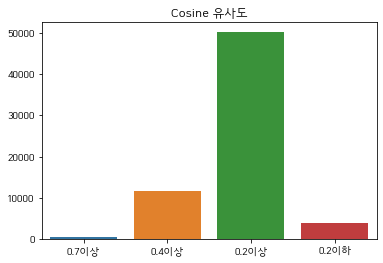

In [13]:
score_list3 = []

for j in range(len(title_list)):
    #idx = id2web['마물전담부대'] #마물전담부대 :  0번 인덱스
    idx = id2web[title_list[j]]
    sim_scores = [(i,c) for i,c in enumerate(cosine_matrix[idx]) if i != idx]
    #자기 자신을 제외한 영화들의 유사도 및 인덱스 추출

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True) #유사도가 높은 순서대로 정렬
    sim_scores[0:10] #상위 10개의 인덱스와 유사도 추출
    
#     sim_scores = [(web2id[i], score) for i, score in sim_scores[0:10]]
    sim_scores = [(score) for i, score in sim_scores[0:10]]
    
    score_list3.extend(sim_scores[0:10])

score3_high = []
score3_mid = []
score3_low = []
score3_2low = []

for i in range(len(score_list3)):
    if score_list3[i] > 0.7:
        score3_high.append(score_list3[i])
    elif score_list3[i] > 0.4:
        score3_mid.append(score_list3[i])
    elif score_list3[i] > 0.2:
        score3_2low.append(score_list3[i])
    elif score_list3[i] <=0.2:
        score3_low.append(score_list3[i])

        
print('0.7이상:',len(score3_high),', 0.4이상:',len(score3_mid),', 0.2이상 :', len(score3_2low),', 0.2이하:',len(score3_low))
        
import matplotlib.pyplot as plt

x = ['0.7이상','0.4이상','0.2이상','0.2이하']
y = [len(score3_high),len(score3_mid),len(score3_2low),len(score3_low)]

#한글 쓰기
plt.rcParams['font.family'] = 'HCR Dotum'
plt.title('Cosine 유사도')

sns.barplot(
    x= x,
    y= y
)

# plt.bar(x, y, width=0.4)
# plt.legend()
# plt.bar(x,y)

### 1순위의 유사도가 0.2 보다 낮은 웹툰

In [14]:
score_list4 = []
for j in range(len(title_list)):
    #idx = id2web['마물전담부대'] #마물전담부대 :  0번 인덱스
    idx = id2web[title_list[j]]
    print(web2id[j])
    sim_scores = [(i,c) for i,c in enumerate(cosine_matrix[idx]) if i != idx]
    #자기 자신을 제외한 영화들의 유사도 및 인덱스 추출

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True) #유사도가 높은 순서대로 정렬
    sim_scores[0:10] #상위 10개의 인덱스와 유사도 추출
    
    sim_scores = [(score) for i, score in sim_scores[0:1]]
    print(sim_scores)

    score_list4.extend(sim_scores[0:1])

마물전담부대
[0.3625494608861375]
불릿
[0.4720736646231415]
더
[0.3446885598421951]
각자의
[0.7929770404687283]
노선도
[0.39611638475901373]
말하는대로
[0.6062593083211505]
연주동
[0.4095655235611935]
의도적
[0.437829517710507]
맘마미안
[0.34338824053929656]
로맨스는
[0.4958936947832803]
대디고라운드
[0.6786701963931578]
도리내리
[0.36064264985836075]
아내를
[0.3905549867411084]
오늘또오늘
[0.30314303470534515]
토끼대왕
[0.44345156935803703]
복학생
[0.4085281829564875]
살人스타그램
[0.3753047964438492]
당신의
[0.369344772201039]
스몰
[0.42775719873508716]
도를
[0.3876241906494319]
불티
[0.36485176836630423]
제7원
[0.4634816235959733]
DEY
[0.5375920973500558]
금혼령-조선혼인금지령
[0.36082661757625767]
재혼
[0.39424915385873643]
당신의
[0.369344772201039]
늑대가
[0.38612161381304083]
흥부놀부전
[0.6334247439947581]
죽여주는
[0.6769628608344485]
뫼신
[0.3874245024597236]
셈하는
[0.4932099164314916]
소년,
[0.3772807716462806]
줄라이
[0.41807879950818816]
하슬라
[0.4379626610119427]
합격시켜주세용휴재
[0.38003105293759093]
감히
[0.4337986611974858]
인터셉트
[0.4692616045209797]
별종
[0.4114038489476877]
지금은
[0.340076480

[0.4182925747587107]
2인용
[0.5375807254412223]
신을
[0.4116194183111205]
마루한
[0.43815101447407806]
구원자
[0.4660918584447221]
스퍼맨
[0.5317098027799008]
수평선
[0.5938129194177437]
점핑오버
[0.6228439756574827]
씬커
[0.5855572713180734]
또한번
[0.631914703071576]
열렬하게,
[0.48755104964334495]
이계
[0.38856349067483337]
모퉁이
[0.36294443749497973]
어서와
[0.5037457443824286]
다함께
[0.4515215847905387]
동토의
[0.5397571468871308]
꽃미남
[0.3669770595608931]
아르마
[0.46689775474046635]
용이산다
[0.4056213417153061]
로베스의
[0.32193553298831773]
마왕이
[0.3889315095891603]
우리
[0.7107590934994648]
소녀
[0.5244884033561148]
용비불패
[0.6497754039937537]
내
[0.42894851827136027]
참새는
[0.2577535964571191]
플랫다이어리
[0.35174519713570357]
Doll
[0.594974962322389]
가령의
[0.4584806002321556]
내
[0.42894851827136027]
귀인
[0.3363290625316984]
헬프탑
[0.37577291165005283]
금요일
[0.6118222843382456]
라스트
[0.5389207250287934]
5kg을
[0.43476792354627947]
옆반의
[0.38129870916714187]
꿀벌과
[0.3380935667919915]
머니게임
[0.41349752623995106]
부로콜리왕자
[0.6196965292738064]
백귀야행지
[0.4011

[0.4167613397011365]
라크리모사
[0.6234791474839587]
데드데이즈(DEAD
[0.437829517710507]
아이소포스
[0.5577169489560735]
장미아파트
[0.3604965769265262]
공주는
[0.7042262045128]
안
[0.5059692186132266]
바람이
[0.4258276357681723]
시큼새큼
[0.6255330587805633]
크레이터
[0.5040138172665766]
심연의
[0.6391826666938006]
남과
[0.4982827269916858]
2015
[0.4403870769009614]
두근거려요
[0.528333031950956]
일등당첨
[0.5371537685103315]
Ho!
[0.4768897480008454]
신령
[0.2959876481253082]
저승에서
[0.4770403693039776]
낚시신공컷툰
[0.39712739282846166]
블랙시저스휴재
[0.4820738724551334]
우리
[0.7107590934994648]
모태솔로수용소
[0.33693613866187677]
언더클래스
[0.36142572843055654]
조석축구만화컷툰
[0.42997750033447735]
웃지
[0.7675393400429504]
프린스의
[0.45066925248845463]
노네임드(NoNameD)
[0.38115873222662316]
지새는
[1.0]
버닝헬
[0.24266824431546746]
불만시대
[0.4155710423919105]
차차차
[0.29341685890547664]
재앙은
[0.38654785605687025]
빨간책컷툰
[0.43377431095611707]
한국만화거장전
[0.5028075538578867]
언더프린
[0.44275961134150815]
플로우
[0.5727983913691236]
딥(DEEP)
[0.49106374710369377]
질풍기획
[0.4270682463685063]
버퍼링
[0

[0.4893859193102074]
AA
[0.543389489337812]
사랑in
[0.49739396352721665]
까뱅
[0.40233682722152936]
와탕카
[0.4285548256029048]
타투
[0.5195170097462273]
신의 탑
[0.6928859808602845]
참교육
[0.62522396637307]
뷰티풀 군바리
[0.45285016884864115]
윈드브레이커
[0.3344992578818412]
백수세끼
[0.3780239065554698]
신입일기
[0.365337508616638]
파이게임
[0.4890273619543083]
장씨세가 호위무사
[0.37843789797760885]
앵무살수
[0.36567348727886567]
삼매경
[0.36515834624139193]
만렙돌파
[0.5052871905313552]
요리GO
[0.3414637548676808]
칼가는 소녀
[0.6096303103657164]
유일무이 로맨스
[0.4625727843400055]
아, 쫌 참으세요 영주님!
[0.40919838781207957]
리턴 투 플레이어
[0.532971560347524]
히어로메이커
[0.40475583397826087]
물어보는 사이
[0.15528357655162767]
잔불의 기사
[0.4172403372523627]
하루의 하루
[0.40661103232097257]
소녀의 세계
[0.3534531024379971]
결혼생활 그림일기
[0.6193411249972461]
오늘의 순정망화
[0.3728427757679704]
팔이피플
[0.37185299154854656]
수영만화일기
[0.3878722116471183]
꼬리잡기
[0.377689345767086]
장난감
[0.34777047876413897]
황제와의 하룻밤
[0.37088601212827194]
평범한 8반
[0.38969498942199543]
아는 여자애
[0.4720487360285243]
순정말고 순종
[0

[0.3673411596068629]
도무지 그애는
[0.4432017668642299]
방과후 선녀
[0.7101442095582802]
아찔한 전남편
[0.15528357655162767]
빨리감기
[0.4625635904894686]
트럼프
[0.40663713934349405]
썸내일
[0.2778637239222931]
구독금지
[0.5399600866737602]
꽃 피우는 남자
[0.38789190094687315]
나쁜 쪽으로
[0.4425511482591523]
백년게임
[0.45414151766530464]
구주의 시간
[0.43374106710605176]
진짜 정말 맹세코 좋아해
[0.4040583817955098]
찬란하지 않아도 괜찮아, 새벽
[0.3738557985831416]
합법해적 파르페
[0.4547307323026044]
강림전기 개정기
[0.4968607370084259]
히트포인트
[0.4324531874045705]
매지컬 메디컬
[0.8302235583546428]
호랑이형님
[0.3373471467252772]
프리드로우
[0.4464108717145757]
취사병 전설이 되다
[0.31963436367538317]
광장
[0.48230732205913607]
스퍼맨 : 전하지 못한 이야기
[0.4182925747587107]
욕망일기
[0.48869969149245945]
힙한남자
[0.6091588691246497]
아홉수 우리들
[0.43978183502110085]
갓핑크
[0.46319856211950133]
나이트런
[0.42836548565420546]
청춘 블라썸
[0.6354490748669708]
나를 바꿔줘
[0.31765229133379336]
좀비 파이트
[0.3935129138041557]
동트는 로맨스
[0.4662727104940719]
어글리후드
[0.37099907478716554]
반드시 해피엔딩
[0.6031466132878724]
감 비서가 고장났다
[0.4609709170347

[0.3530160280188674]
유색의 멜랑꼴리
[0.4224634682730886]
보글보글ㅤㅊㅑㅂㅤㅊㅑㅂ
[0.44086880243382653]
같은 방에서
[0.33032720611605537]
특별직
[0.36713969360573573]
용의주도 황비
[0.28820659367389456]
내추럴 리드미칼 2
[0.5445398630718767]
경성야상곡
[0.606537660094793]
괴물아기
[0.4111073187693617]
카페 보문
[0.35211716437419277]
묘씨맥주점
[0.3361363372085538]
일생에 변태를 세 번 만날 확률
[0.40171921146799777]
게뭐야
[0.5287855447534232]
여자만화 구두
[0.6898659513746188]
우리학교 김선생님
[0.6017341027074922]
큐레이터
[0.3232203422420391]
오늘도 꽐랄라라
[0.5722941090408102]
트레이스
[0.4877890889199836]
조우
[0.320910861798324]
사내 맞선
[0.3381667422750128]
크라이시스
[0.5898997283606295]
진심이 닿다
[0.42122602999682796]
레드스톰
[0.3892053418847204]
방탕일기
[0.32336853786055186]
꽃같은 인생
[0.6392899471919751]
우리 집에 왜 왔니
[0.5715262868026143]
창백한 말
[0.6622624264468738]
심봉사전
[0.3477818618838367]
표류감옥
[0.44171102964046755]
어름치
[0.2810224353307733]
작약만가 : 불환곡
[0.4678304519334925]
여의주
[0.5399453166914274]
어둠이 걷힌 자리엔
[0.3737954179674074]
내 일진이 이렇게 귀여울리가 없어
[0.797380136368151]
찬란한 액션 유치원
[0.7167408581104302]

[0.62223463271549]
외발로 살다
[0.47180808397267016]
마녀
[0.5553094045605566]
십이야
[0.4348445154278778]
9교시엔  XOXO
[0.48119192382928433]
저스트 원 샷
[0.729563856089404]
인기 있는 남자
[0.5184897451246464]
폐어
[0.49994604514541185]
수사전
[0.2768850506677049]
가우시안 블러
[0.514836090675544]
동
[0.42308858489792117]
결혼해도 똑같네
[0.5386249330137569]
지옥철
[0.5511515296811962]
우리집 새새끼
[0.4222824972849284]
안되는 건 안되는 거다
[0.40135120687294557]
은밀하게 위대하게 : 슬럼버
[0.46990836318119567]
검둥이 이야기
[0.5524353393401156]
피노키오
[0.5339007522253902]
다이아몬드 더스트
[0.6603828643352562]
헌티드 스쿨
[0.6283750122591457]
세상 밖으로
[0.3240399789275815]
커밍업!
[0.3116429620179061]
돼지고기 동동
[0.2867589442040117]
한여름밤의 꿈
[0.4104204250481871]
루드비코의 만화영화
[0.5045869946368073]
다시, 봄
[0.35630913290595845]
언더시티
[0.5745866352986096]
애썸
[0.6125464109311113]
오세요 타로샵
[0.3198980812128892]
아코르
[0.6198967960268754]
다이어터
[0.3143978195305887]
나는 매일 그를 훔쳐본다
[0.4414319534143463]
레이어즈 아나키
[0.7342532387886496]
오! 마이 레이스
[0.5399402074345451]
란의 공식
[0.3863989392677485]
코알랄라
[0.530149

[0.4651572136568224]
파수꾼의 왈츠
[0.5037457443824286]
0.1초의 설렘
[0.6125464109311113]
그루밍 선데이
[0.6520350260750892]
파이팅 스타
[0.34830844635445385]
올망동은 평화롭습니다
[0.40547312147665077]
트릭코드
[0.6010928780020546]
웨이크 업 데드맨
[0.5627835426833043]
노루
[0.31595389094258836]
굿모닝 사회인 야구
[0.31303456798704266]
고.흔.연
[0.4736499680624491]
용사에게 소중한 것
[0.39857752134944113]
미세스 선녀
[0.2936483928637163]
모든걸 걸었어
[0.34753648852601593]
순정큐피트
[0.6991656956346092]
날 좋아해줘
[0.3418569190686557]
소녀K
[0.4647958333910126]
보고 있으면 기분 좋아져라
[0.503717843049367]
창작의 고통
[0.38191892593555254]
아침에 시 한 수
[0.4253667410048373]
무늬만 사람
[0.3382878135164841]
그녀의 수염
[0.49652534956918803]
광해이야기2
[0.7353042972531856]
마왕의 성
[0.5104059421471416]
아쉬탕가
[0.2997885576501832]
비산
[0.3262960503291426]
가론피
[0.6834875068924304]
모르모트
[0.3700913144781221]
노숙자 블루스
[0.5057028133867282]
차이니즈 봉봉클럽 북경편
[0.33925958060509204]
앞으로 나란히
[0.6019234416432432]
겨울하나
[0.4116556069788181]
마당에 데굴데굴 열매
[0.3077725275642148]
디스라이크
[0.3326639325810636]
미소식가
[0.32059249163430203]


[0.4539366574587683]
이세계의 황비
[0.3475595728703866]
다섯번째 혼인은 사양합니다 [연재]
[0.39364557040634135]
내 생애 최고의 늑대
[0.2753093251435503]
저 아이에게 키스와 흰 백합꽃을
[0.4555898242975581]
비밀스러운 짝사랑
[0.4630278921869889]
하나군과 사랑하는 나
[0.43876538427603773]
못난이에게 꽃다발을
[0.46184992689136295]
하나노이 군과 상사병
[0.523608780907463]
다정한 공작님의 비밀 [연재]
[0.4666296529341955]
아디오스 에이프릴 [연재]
[0.5282631733642463]
깊은 곡선
[0.39716013075365897]
네가 쏟아지다
[0.4503579848912192]
러브 인 디 오션
[0.5464165006416247]
러브 팬텀
[0.5920537115192579]
하나와 히나는 방과후
[0.5624490815569303]
사신의 연인
[0.4156697440031589]
압구정 몬스터
[0.5910010869490078]
딜리셔스 블러드 [연재]
[0.4350189032379531]
스파이스와 커스터드
[0.4051961695845077]
사랑은 개싸움!
[0.4815823441487579]
보스 오빠, 제발! [연재]
[0.4090014379444616]
발렌타인 키스 [연재]
[0.45996871681226675]
빨강머리 백설공주
[0.37733145198141105]
대공비 후보지만 견실하게 할 생각입니다
[0.43602269064907695]
해피 슈가 라이프
[0.4034848852949941]
추락 여고생과 폐인 교사
[0.4463353715765837]
면사포를 쓰고픈 남자
[0.5722941090408102]
달빛천사
[0.43787754524233424]
헌터의 약혼자로 살아남기
[0.39751577198678084]
신음 소리는 조용히 [개정판]
[0.

[0.46902507742948363]
당신이 원하는대로 [개정판]
[0.5487075107082738]
누드를 입은 유성
[0.4000228929975904]
DOT
[0.5562592593672152]
두근두근 아따끄
[0.38613248740920925]
남장황제x여장귀비
[0.45608949401538895]
후르츠바스켓 another(어나더)
[0.4480212498117895]
시간을 멈춰서 너에게 나쁜 짓을
[0.4253458515269773]
그 고양이가 통치하는 세상
[0.3485823246879074]
카드캡터 사쿠라(애장판)
[0.4137555451981624]
스미카 스미레
[0.3644730880301997]
우주를 누비는 쏙독새
[0.4365826985385984]
흐트러진 사랑의 함락직전-야쿠자 그녀의 위장남친-
[0.3712551209104687]
그들만의 수업 [베리즈]
[0.4327483777806826]
비밀.
[0.38129870916714187]
상속녀는 망했다
[0.31856359896626185]
16세, 선생님에게 더럽혀지다
[0.3918205427258121]
전남친과 이런 일이 벌어지다니
[0.4404500537361323]
너의 진심을 말해줘
[0.3743002443675573]
나의 왕자놈
[0.4459398849634958]
그녀와 카메라와 그녀의 계절
[0.4668663812979442]
킬링 허니
[0.38131227029151554]
선생님, 사랑을 가르쳐줘!
[0.38616486718344506]
세상에서 젤 어려운 연애
[0.3675828834553636]
몸으로 느끼는 거짓 사랑
[0.42986181850199573]
바보여왕기사단
[0.8596024816184074]
필로소피아
[0.46341521191916946]
오빠 친구
[0.3748951763138185]
울트라 비서
[0.4323158656647958]
미성년이지만 어린애는 아냐
[0.533513364576404]


[0.31799344565506465]
블러드 러브
[0.3802271909475918]
내 귀여운 인형님
[0.4115933034921858]
기다리셨던 첫사랑입니다.
[0.4353734052844785]
피터판다 (PETER PANDA) [연재]
[0.422935857705418]
아침까지 못 기다려요!
[0.4533511534542918]
결혼을 못 하는 데는 이유가 있다
[0.5385671061157733]
절대쾌락소녀
[1.0000000000000002]
엄마는 코코넛 크래시
[0.4487473059403514]
러브 시그널
[0.45012282413896015]
아사의 강
[0.6717012842697252]
파란 봄봄
[0.37898694207862776]
나와 상사의 비밀사정
[0.48095336432988023]
방과 후 여닌자
[0.377697331334681]
어린 늑대에겐 '기다려'가 통하지 않는다
[0.42606966218730463]
나에게 어른의 사랑을 가르쳐줘
[0.41593818272880734]
침대 위에서는 키스보다 더
[0.4570999160856872]
선생님과 한 지붕 아래에서 XX
[0.3658742574199399]
선생님, 괴롭혀 드릴게요
[0.42971358853908653]
기억 캡슐 - 오빠와 함께
[0.48526443182963275]
공주님의 우울
[0.40939782656835133]
선생님의 전부를 보여줘
[0.38595413739801204]
옆자리의 엉큼한 사신 [베리즈]
[0.3721642670558245]
두 마리의 상냥한 늑대
[0.651039641835261]
소악마군의 달콤한 속삭임
[0.5008123457992599]
꽃과 유전자-15세에 시집가다?!-
[0.40688267834037867]
늑대들의 사정
[0.41321073822339344]
그녀와 나의 생태계
[0.7145480924459346]
세상에서 가장 아찔한 프로포즈
[0.4157506313801139]
호스트가 오늘부터 내 

[0.5291906481965424]
신부 수업(런던 로망스 시리즈 2)
[0.4164540499068764]
아가씨, 잘 부탁합니다
[0.7104361833918258]
신에게 맹세코
[0.43747454078086045]
소녀생리학
[0.7497570117937858]
서투른 사랑일지라도
[0.41269976439227557]
좋아하는 것만으로는 부족해
[0.4464763850556412]
너에게 격렬한 키스를
[0.38983088806134114]
CLOVER
[0.3155951562295153]
고고걸즈
[0.6011868398806586]
남자일까요?
[0.5592036765299105]
크로스 로드~그날의 약속~
[0.5420164999096015]
컬러풀 데이즈
[0.4107788439723959]
소녀가 죽는 이야기
[0.4232057972689505]
VISION (비젼)
[0.4045128679044816]
봄의 소리
[0.4027561500134773]
공주님의 날개
[0.3764533344422832]
이 거리에서 너에게
[0.3653015660637031]
너와 함께 있으면
[0.6015585245396398]
프리티 보이
[0.3588012993409335]
눈 오는 벚나무 아래서…
[0.42548474384975726]
콩깍지 컴퍼니
[0.4405383659561731]
엉터리 댄스
[0.47580832026922715]
아주 특별한 걸
[0.4421110546530562]
MONDAY MAN (먼데이 맨)
[0.34571775403500776]
나쁜 남자 [개정판]
[0.6781085486980973]
사랑의 처방전
[0.5413335208562682]
Nice Family Plus (나이스 패밀리 플러스)
[0.4058907399639506]
사랑스러운 그대에게
[0.7171413447654542]
오르페우스의 창 외전
[0.2967586416853164]
나를 바꾸는 사랑을 하자
[0.4364785036984522]
제멋대로 동

[0.39579615940016355]
제5열 Born to kill
[0.3138200266991237]
히나마츠리
[0.19199152278609788]
여신님이 아니야
[0.3633362544602095]
일곱 개의 대죄
[0.3736564986927558]
8만년만에 회귀하다 [연재]
[0.3092176920818976]
여기는 내게 맡기고 먼저 가라고 말한 지 10년이 지났더니 전설이 되어 있었다.
[0.46198764097689127]
성녀가 아니어서 왕궁에서 느긋하게 밥을 짓기로 했습니다
[0.3599483749760503]
천존! 도시에 재림하다 [연재]
[0.3417689480952124]
전직 법사 [연재]
[0.3449665552105848]
그라운드레스 - 외눈의 저격수
[0.2836077107175753]
낭만협객 마수검
[0.40756223496696803]
넥스트 라이프
[0.45703001675092]
나에게 천사가 내려왔다
[0.3880080337278879]
별빛속에
[0.4243039431947587]
칼바니아 이야기
[0.476233445435357]
쓰르라미 울적에 2. 와타나가시편
[0.5570270105837687]
요괴 학교 선생님이 되었습니다
[0.4573034239886523]
통
[1.0000000000000002]
요자쿠라 일가의 대작전 [연재]
[0.6101827380579505]
신 펫숍 오브 호러즈
[0.4317920458979497]
독고 리와인드
[0.6427502500934622]
카구야 님은 고백받고 싶어
[0.35523539924734426]
무법지대 : 요괴전쟁
[0.3200567976974515]
아인
[0.4483446214841721]
그레이 - 영웅 죽이기
[0.35199470286264134]
한때는 신이었던 짐승들에게
[0.40592014548739014]
켄간 아슈라
[0.3946704536172668]
티어문 제국 이야기
[0.42089592301765866]
팬텀 프린세스 버서스

[0.40541790032570096]
이세계 마법은 뒤떨어졌다! (코믹스)
[0.4304193138868666]
미니멈
[0.39273323338771676]
서브미션
[0.4430889387214183]
까칠한 마법 소녀
[0.7288030786809728]
콘다 테루의 합법 레시피
[0.5222624799908903]
그런 만화가가 있었다
[0.4958936947832803]
최초의 헌터
[0.45640681696359114]
망자카페
[0.39639659809925204]
위치 크래프트 워크스
[0.5054360900879]
꼴데툰 2013
[0.5965365008034368]
꼴데툰 2015
[0.7834086534623824]
레드허니
[0.4614534683953834]
주선청운지
[0.3470464577641121]
족구왕
[0.37510358580416264]
고기해방연합
[0.44150346870785084]
여고생
[0.5960940425027806]
월하노인
[0.41728306644027674]
김무녀는 무녓무녓해!!
[0.4369460462866498]
네오 마그넷
[0.5113088297281255]
이방의 오즈월드
[0.3977857763629617]
나와 히어로와 마법소녀
[0.36312160983975106]
금사 - 거문고의 기억
[0.4803305504911975]
세계 최강의 후위
[0.6099225650993061]
우리들은 고양이로소이다
[0.4615263178818556]
사랑에 빠진 일진녀
[0.4301146314713582]
진격의 거인 Before the fall
[0.36426594900424036]
몽환백서
[0.34995510105511246]
이세계 전생 모험가
[0.5032750082663852]
책벌레의 하극상
[0.39465697147978834]
츠바사
[0.46504994445303]
사신 짱 드롭킥
[0.42534886859893783]
저희 사역마가 죄송합니다
[0.410322089065354

[0.5489776168869831]
지금부터 컴뱃
[0.43434638767643535]
도시 전설 탐정 사무소 (Urban Legend Creation) [연재]
[0.5161196150080669]
티라노 그녀
[0.5536694614810094]
홍각의 판도라
[0.3964943714490714]
허구의 왕
[0.4674512122061329]
X (엑스)
[0.35544246464447227]
마법소녀라면 1105호실에 있습니다
[0.5794808408825147]
바람의 나라 SE
[0.41656410813475797]
나는 편의주의적 해결 담당 왕녀로소이다
[0.6723030236148562]
나와 마녀의 시간
[0.4598002275356483]
Kiss My Ass
[0.4217722184676225]
아마기 브릴리언트 파크 (코믹스)
[0.3742955161534772]
굿모닝! 티처
[0.3335217212525151]
홍심왕자
[0.4820335414004693]
그 열등기사, 레벨 999
[0.3726087851494058]
게임부!
[0.3264126976721194]
이누야시키
[0.5896468714588246]
환각소년
[0.41968500597011993]
마흔 네개의 꿈
[0.2981868394627384]
녹정기
[0.44679390241131245]
데미는 이야기 하고 싶어
[0.36179520436489204]
삽질무쌍
[0.40822150448240074]
도쿄 슈퍼 시크님!!
[0.38633141682542926]
노래하라! 헤이안쿄
[0.4331702272386801]
EIGHTH
[0.4367113037024041]
프런티어 다이어리
[0.265584215963966]
여기 여기 붙어라
[0.3309063297796386]
노아-NOAH-
[0.39799518542719675]
달빛왕자
[0.40418470493748554]
천신결
[0.9093616576961245]
타블로 게이트
[0.40199919995202

[0.41676949588997714]
DAYS(데이즈)
[0.6951789196943415]
히어로 매니저[개정판]
[0.3115461893065793]
내가 하면 짝사랑
[0.4185511403336983]
아베가 저를 노리고 있습니다
[0.39879878626329296]
도시괴담
[0.41056569323286995]
봄을 기다리는 우리들
[0.48755104964334495]
야쿠자의 대두목이 유녀로 환생한 이야기
[0.3712551209104687]
약사의 혼잣말(코믹)
[0.31065709591881496]
술 한잔 인생 한입
[0.5239470074772016]
요시노즈이카라
[0.5784467969512401]
생존주의
[0.43850721557837175]
34세 무직씨
[0.3378546130225742]
초년의 맛
[0.3126717645335347]
매분구
[0.42305179943600013]
메꽃 ~오후 3시의 연인들~
[0.4409937405417168]
나의 아빠
[0.4474054396306296]
오늘도 항해
[0.4137837010750255]
날씨의 아이(코믹)
[0.5465891504134517]
고양이화가 주베의 기묘한 이야기
[0.3774693398974187]
동거인은 무릎, 때때로 머리 위
[0.289445718280239]
이게 무슨 일이야?[개정판]
[0.4429391717565987]
안쌤의 시카고 일기
[0.41191441894749625]
마당 씨의 가족 앨범
[0.43919458814097745]
재벌 라이프 [연재]
[0.4048223191357034]
언밸런스X3
[0.42735967479664466]
신부간택 ~대부호와 108명의 후보~
[0.6239735296065279]
꼬르륵 배고픈 남자들의 밥
[0.655648476803713]
오만과 낭만
[0.40870721916093783]
미스터리라 하지 말지어다
[0.45282979526075035]
튄 공
[0.48401737935133826]
데

[0.667808985262757]
비밀
[0.464421911530629]
어서 와! 오컬트 연구부
[0.4235642972773387]
제국의 귀
[0.3480319041830307]
홀로
[0.36335694372292093]
소음
[0.5157544189824086]
불편하고 행복하게
[0.41147347877363616]
세계신대백과 [연재]
[0.3794092346686075]
먹짱 겜블러!
[0.39482110266555787]
기담
[0.39830737540521755]
나는 아프다
[0.39391315478557853]
여탕일기
[0.37019446534393424]
코우노도리
[0.4090620756663451]
식사혼
[0.45779094767627043]
제멋대로인 여자들 ~민폐 엄마의 유모차~
[0.33674367922585063]
해안 놀이
[0.4202006974707728]
클로토를 찾아서
[0.46803960942374184]
스위트 펫 라이프
[0.3917569782685917]
달의 속삭임 [연재]
[0.4528123007668677]
여자고등학생
[0.43755015181815077]
7의 잔재
[0.37919274737127484]
메이지 비색기담(메이지 시리즈1부)
[0.40331185655929963]
H2 오리지널
[0.4399266551191614]
카페알파
[0.41353279475322763]
멍멍이와 주인님
[0.5426297208152044]
여기는 지금부터 윤리 시간입니다.
[0.3870024379233521]
사춘기 비터 체인지
[0.505197460268676]
소년탐정 김전일 흡혈귀전설 살인사건
[0.37919274737127484]
선술집 탐정
[0.3671025622313682]
히카리맨
[0.3388760233759167]
우리는
[0.44842156888166085]
디어 (dire)
[0.41147347930737954]
29세, 7살 연하와 사랑할 수 있을까
[0.427213830343443

[0.40685010523683335]
천사의 집
[0.35297343249387836]
교정 뒤에는 천사가 묻혀 있다
[0.47822945011794094]
별똥별에 소원을 빌 정도로 우리는 순수하지 않아
[0.37757287011018303]
와가츠마 님은 내 신부
[0.5067242770854012]
아르테
[0.34757579700566255]
아이스 프린스
[0.4142590370479593]
녹풍당의 사계절
[0.34974230945830403]
동거종료일기
[0.4048817326671965]
시르크
[0.42783276935227477]
우리들은 모두 카와이네
[0.3310047798155075]
행복카페 3번가
[0.42577719658365976]
청춘시대-청춘이라는 이름 아래 지워지는 것들
[0.4390041721516693]
don't like this
[0.34760936395098196]
센과 만
[0.37322526993488464]
절대영역
[0.4374679305101312]
나의 선생님
[0.6203768312494249]
프레쉬
[0.4576520238033297]
그녀만의 EX
[0.4168792240509632]
가르쳐줘! 갸루코짱
[0.34178689465244544]
마이 러블리 투투
[0.4225270621846208]
나만이 없는 거리
[0.4727382738299333]
즐겁게 놀아보세
[0.3430001978377713]
하염없이 어여쁜
[0.5610661862908162]
미안합니다
[0.5492814845674455]
짝사랑 맛집 일기
[0.3808121944015664]
위저드 소울 ~사랑의 성전~
[0.4334279022683302]
휴대폰 남자친구
[0.432336737387383]
기묘한 플로리스트
[0.38886290441955096]
허식당
[0.5563584600272978]
몽외몽
[0.4111523560544173]
코바토
[0.4619110611850316]
카코와 가짜탐정
[0.432336

[0.47996127850363685]
Escape, ray (이스케이프, 레이) [연재]
[0.3860005046798903]
그림자 왕관 [연재]
[0.3736597912707814]
마도조사 [연재]
[0.41559985113063447]
남첩
[0.8841194220152024]
피장파장의 오류
[0.40053931945927335]
Teach Me!
[0.3491484616514903]
시작부터 끝까지
[0.8991657532789145]
풀스 리마스터
[0.41785502719084855]
우주, 소년
[0.46750321674734385]
베이비 페이스 몬스터 [개정판]
[0.4354289256991922]
아스란히
[0.37648564677781027]
비터 레몬 [연재]
[0.5712713510680394]
구해줘, 룸메이트!
[0.40171771419465724]
요정을 아십니까?
[0.38094195934748537]
소년이 소년에게
[0.3165609077301327]
화우요 [연재]
[0.6832457921898696]
명령불복종 [연재]
[0.3113764296460814]
주인의 사정[개정판]
[0.4242935412211301]
인시크릿[개정판]
[0.3949353160451692]
꽃놀이패 [개정판]
[0.9030068583279351]
4와 2분의 1 정거장
[0.6993624312690329]
늪의 나락
[0.46139826260064143]
울프 인더 하우스[개정판]
[0.693719432214574]
너의 목소리를 보고 싶어
[0.43928813093442065]
애신록
[0.4136260908175307]
한 철 어스름
[0.38105723024614835]
키세스x키스x키세스
[0.3847433441631517]
각설탕 소리
[0.9072799868329329]
미스테이크 러버
[0.4362591069002269]
OFF STAGE (오프 스테이지) [개정판] [연재]
[0.4415002953938592]
당신을 바라보

[0.3986401385712211]
란덴과 사가 [개정판]
[0.46139094349286675]
오해가 계속되면 오예입니다
[0.49261691140687913]
이 별에서 가장 밝은 너
[0.3880080337278879]
프리펙트의 모형 정원
[0.3802423338652165]
사수생도 연애를 한다
[0.6298317773988671]
이루지 못한 그 사랑을 다시
[0.5045907569188056]
우리들의 혼탁한 레종데트르 [연재]
[0.43966648185575086]
[웹툰판] 아무것도 말하지 않아
[0.34479924318013994]
넘버 콜
[0.34572405371093123]
하나 둘 셋!
[0.39176445973518065]
음마에겐 내가 필요해!
[0.3269242408132339]
노발리스 -당신은 나의 키메라-
[0.335218375150378]
아이러니 드레스에 작별을
[0.37964869020912806]
파쿠리인 내가 어시를
[0.897107700766684]
나와 너의 스토커 방지법
[0.3712382085371036]
슈가베이브
[0.428724388866209]
이런 솔로탈출은 싫어!
[0.40409811599023915]
해필리 에버 애프터(Happily ever after)
[0.4999472143762108]
사쿠라 카나에는 비밀이 있다
[0.39611352243057774]
만지지 마!
[0.3333669191586707]
어둠의 고동
[0.40452578673628403]
달콤살벌한 키스
[0.37347949712917855]
달콤한 피
[0.4243524519305625]
푸른 하늘의 맑은 빛이
[0.47075807589736973]
두 사람의 라이온
[0.4085651362568521]
한밤중의 카페에서 차를
[0.3603669366830402]
비즈니스 퍼포먼스 [개정판]
[1.0000000000000002]
나만의 짝사랑
[0.3728595059324393]
부수고, 사랑하고
[0.3288530785

[0.43175773080623775]
나와 그가 결혼하게 된 이유 [개정판]
[1.0]
노안 중학생과 동안 아저씨
[0.35989690215434195]
H군
[0.5197719819612445]
라스투 단편선 [개정판]
[0.28973303320815497]
저의 아빠가 되어주세요
[0.43614035844207516]
준교수의 첫사랑 연구 생활 [개정판]
[0.4436739858805975]
셀프 포트레이트
[0.43252394632002333]
상냥하고 훌륭한 변호의 기술 [로제]
[0.3915138293306464]
금어초가 사는 곳
[0.43777643242071995]
보이위시
[0.4251842332326419]
달과 전제군주
[0.41593818272880734]
스타의 매니저
[0.41304690872830185]
학생이면 안 되나요?
[0.3779021211912072]
병아리, 노란 오리를 사랑하다
[0.31750745436746747]
내가 사랑하는 노말선배 part.1+2
[0.36700630332233014]
어느 날 갑자기 호모가 되어버렸다☆
[0.4697661075333846]
따르지 않는 고양이를 쓰다듬는 방법
[0.406306278757246]
연애 오버런
[0.44894370385458165]
전유호 단편
[0.4296059678078909]
불꽃은 이미 쏘아졌다
[0.37867025053053005]
순애에로기
[0.45277035579423897]
방과 후 불순한 관계
[0.4266301939948972]
내일이 바뀌는 사랑을 한다
[0.31516237299159483]
사랑도 되지 않아
[0.34000851628790624]
그들은 XX가 아니라고 말한다
[0.3664222848547281]
그의 동생을 사랑하다
[0.38660425241376517]
망상가, 사랑하다
[0.21874112934202894]
바이바이, 왕따군 [로제]
[0.412355581164918]
잠든 고양이는 입맞춤으로 눈뜨지 않는다
[0.383

[0.5933592434734971]
오 나의 어시님(개정판)[BL]
[0.5563053670746702]
리셋하여 만렙 플레이어
[0.34318668190702306]
재생
[0.3686897555854932]
100일의 경국지색
[0.5784097574291466]
연하의 곰신
[0.4350225722522248]
Mr 뱀파이어 길들이기
[0.4512439823910638]
헬로 마이 안드로이드
[0.4801961328867955]
포근한 그 남자
[0.6459951194977271]
별의 아이
[0.44785674715820767]
까마귀 우는 밤
[0.49009498471008706]
남의 BL만화 [BL]
[0.34824077751085325]
우리는 매일매일
[0.42215023192361695]
겨울과 봄사이
[0.8003683898819332]
역학적 행운 보존의 법칙
[0.4331424851375348]
트라이버(TRYVOR)
[0.5493875633649472]
조력자 A군
[0.3720979487971513]
고홍[BL]
[0.23018929491550705]
어덕행덕
[0.40572955249535264]
999번의 키스
[0.47574286944940486]
선배, 열 번만 자요.
[0.47008807266109687]
사랑이 많아
[0.3678133012486039]
무색무취[BL]
[0.34608586403330444]
영원의 안식처 (Eternal Sabbath)
[0.46384555971506997]
보표
[0.2977504991307633]
제왕의 꽃
[0.6000881704258185]
황성 천하제일 컬렉션
[0.31871107416816014]
내가 하면 짝사랑
[0.4185511403336983]
달을 삼킨 범 [BL/개정판]
[0.5607502402829764]
황성 지존귀환 컬렉션
[0.5933592434734971]
용권풍 [개정판]
[0.3085934329540028]
멜팅 포인트
[0.4311156445579323

[0.4011087556257832]
황후귀환
[0.45996871681226675]
너에게 가는 길 [BL]
[0.41644098932397233]
귀여운 야수님!
[0.3547233251158869]
달콤씁쓸한 순정
[0.36517216501212496]
이번에는 닿기를
[0.3963390721064192]
묵검향 창천비도 패키지
[0.4989349471740017]
내 여자, 꼬봉이 [독점]
[0.4383254548898397]
천하제일고수-학교에 가다
[0.36521409738992966]
체포하라
[0.29945163997532637]
청학동 프로젝트
[0.3657969420582507]
이세계의 황비
[0.3475595728703866]
지구의 주인은 고양이다
[0.3678142083524565]
요나의 법칙
[0.4297414252395112]
덕후의 여자
[0.36535605998232057]
오만과 낭만
[0.40870721916093783]
단 하나의 여름
[0.38248501279138614]
회장님의 그림체만 다르다
[0.37845238280111804]
늪의 나락[BL]
[0.559460089775814]
야설록 대륙지존 컬렉션
[1.0000000000000002]
레인돌
[0.3430001978377713]
남자친구를 조심해
[0.5053328301960206]
자룡팽봉 [개정판]
[0.37953135979328845]
소라해나!
[0.33001540403751856]
수호신이 인큐버스 [BL]
[0.4521706817450124]
에이리언 아이돌
[0.3720979487971513]
소녀예찬
[0.35459458562128293]
혼의 나라
[0.689226842642249]
히 러브즈 미
[0.3682817278459787]
야설록 무쌍난무 컬렉션
[0.6228995929914144]
갤러리 페이크
[0.3468361587341448]
20살 남편에게는 비밀이 있다 [개정판]
[0.4084553227203312]
신림과 봉천 사이 

[0.8420273253620745]
시간선
[0.3726796359828167]
절세요제
[0.3012241394106555]
체이서
[0.7700546339400325]
오토마타 스투피
[0.33117053133427854]
사마달 불사천마 컬렉션
[0.46352482370920606]
오니를 키우다
[0.40559815759264295]
연애소설 읽는 교수
[1.0000000000000002]
야설록 무적자 컬렉션
[0.5933592434734971]
와일드 시티
[0.6294162928757443]
너의 돈이 보여
[0.4900368563242729]
히어로즈 오브 레전드
[0.5059191363530275]
마왕
[0.35494887583968876]
극락청춘 하키부
[0.42516589900984136]
카페 벨로마노
[0.6211244453001579]
먼치킨 퀘스트
[0.4218134920359307]
그라운드 제로
[0.5500196962949406]
뱀파이어 셰프
[0.42297390762161163]
그 남자의 하이힐 [완결]
[0.5532786003268634]
4인4색 무림천왕 컬렉션
[0.3722815180323453]
사랑을 주세요 [BL]
[0.40662819596307853]
연민의 굴레
[0.36171427906320175]
나의 K군
[0.4760468251623347]
치렐루야
[0.4588883900457487]
퍼스트 러브 콤플렉스
[0.388788315397153]
짱
[0.4350038282309142]
키스톤 로맨틱 콤비
[0.3937914567125122]
야설록 용호상박 컬렉션
[0.6489573942737852]
야설록 중원대난투 컬렉션
[0.47844260942896827]
장밋빛 성전[완결]
[0.3551182332173646]
흑황책 [개정판]
[0.5201521174276427]
사랑은 반짝 [선연재]
[0.9300250663927441]
입술이 닿기까지 [BL]
[0.3777815974009848]
너

In [17]:
cnt = 0

for i in range(len(score_list4)):
    if score_list4[i] < 0.2:
        cnt +=1
        
print('1순위의 유사도가 0.3 보다 낮은 웹툰 :',cnt,'개')

1순위의 유사도가 0.3 보다 낮은 웹툰 : 37 개


### 장르별로 구분하기

In [16]:
for j in range(len(title_list)):
    #idx = id2web['마물전담부대'] #마물전담부대 :  0번 인덱스
    idx = id2web[title_list[j]]
    print(web2id[j])
    sim_scores = [(i,c) for i,c in enumerate(cosine_matrix[idx]) if i != idx]
    #자기 자신을 제외한 영화들의 유사도 및 인덱스 추출

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True) #유사도가 높은 순서대로 정렬
    sim_scores[0:10] #상위 10개의 인덱스와 유사도 추출
    
    sim_scores = [[web2id[i], score] for i, score in sim_scores[0:10]]

    
    for k in range(10):        
        title = sim_scores[k][0]

        series = web_combined['title'] == title
        index = series.tolist().index(True)
        
        sim_scores[k].append(web_combined['platform'][web_combined['title']== title][index])
        
    print(sim_scores)
                                       

마물전담부대
[['던전 속 사정[개정판]', 0.3625494608861375, '레진코믹스'], ['김무녀는 무녓무녓해!!', 0.33584992795865076, '레진코믹스'], ['괴기목욕탕', 0.3160499672146246, '레진코믹스'], ['괴기목욕탕 시즌2', 0.2921808182637281, '레진코믹스'], ['보석의 나라', 0.18827495305619124, '레진코믹스'], ['게딱지', 0.18827495305619124, '레진코믹스'], ['사라사(컬러판) [연재]', 0.09719722068930932, '레진코믹스'], ['레코닝', 0.09221690318235755, '네이버 웹툰'], ['인챈트-나람이야기', 0.06149035030826022, '네이버 웹툰'], ['신의 탑', 0.05924023072844767, '네이버 웹툰']]
불릿
[['아오라', 0.4720736646231415, '레진코믹스'], ['집사의 환상카페', 0.44161880524302605, '레진코믹스'], ['잘 먹겠습니다와 다녀왔습니다와', 0.36000503962304087, '레진코믹스'], ['어덕행덕', 0.35606877943241516, '레진코믹스'], ['인피니티', 0.35391572300224555, '네이버 웹툰'], ['퍼펙트 게임', 0.3433992488344017, '다음 웹툰'], ['고백', 0.34280109246590157, '다음 웹툰'], ['레이드', 0.3297171832118567, '카카오 페이지'], ['50픽셀 데이즈', 0.3266997016529435, '다음 웹툰'], ['MLB카툰', 0.32500585559685896, '네이버 웹툰']]
더
[['서울 불시착', 0.3446885598421951, '레진코믹스'], ['시월드 판타지', 0.3297753875197757, '네이버 웹툰'], ['꼬리', 0.3182320069904731, '네이버 웹툰'], ['정령사: 나

[['컨트롤제트', 0.4634816235959733, '네이버 웹툰'], ['감방에서 남자주인공을 만났습니다', 0.4528232275055191, '다음 웹툰'], ['Courage', 0.4035247024761537, '레진코믹스'], ['미래소녀', 0.38127964136003223, '네이버 웹툰'], ['메모리스트', 0.37638904492521347, '다음 웹툰'], ['메트로놈', 0.3708027271020115, '다음 웹툰'], ['나는 어디에나 있다', 0.358611693133966, '네이버 웹툰'], ['두번째 생일', 0.3390788801321654, '네이버 웹툰'], ['기억흔적', 0.3239273631017331, '네이버 웹툰'], ['향수', 0.31199505169983444, '네이버 웹툰']]
DEY
[['연', 0.5375920973500558, '네이버 웹툰'], ['연', 0.5375920973500558, '네이버 웹툰'], ['공포단편선X', 0.5027001457968783, '네이버 웹툰'], ['DEY', 0.44196885918521556, '네이버 웹툰'], ['기기괴괴', 0.4002188750289336, '네이버 웹툰'], ['건널목 타임', 0.3523574616748712, '레진코믹스'], ['귀전구담', 0.3318161563368516, '네이버 웹툰'], ['간질간질', 0.32945439319183306, '네이버 웹툰'], ['수호신이 인큐버스 [BL]', 0.32016139812187616, '카카오 페이지'], ['스틸레인2 : 강철비', 0.3044071564990908, '다음 웹툰']]
금혼령-조선혼인금지령
[['고기해방연합', 0.36082661757625767, '레진코믹스'], ['특수', 0.35927979843703817, '네이버 웹툰'], ['2018', 0.3431614288906956, '네이버 웹툰'], ['스파이스와 커스터드', 0.34291

[['큐피트의 화살', 0.4408216145120462, '레진코믹스'], ['바보개와 아가씨 [개정판]', 0.40304822639571397, '레진코믹스'], ['뮤지션', 0.34681268746750593, '레진코믹스'], ['뮤지션', 0.34681268746750593, '레진코믹스'], ['건널목 타임', 0.33312943866553485, '레진코믹스'], ['폭신폭신파이널~이래서 고양이는 그만둘 수 없다~', 0.31012025499880763, '레진코믹스'], ['이안에나', 0.30345073564831765, '레진코믹스'], ['AI가 세상을 지배한다면', 0.2950938426578071, '네이버 웹툰'], ['와라!', 0.2898270358883236, '네이버 웹툰'], ['미미&쇼', 0.28912996329281176, '레진코믹스']]
인간의
[['꼬리', 0.46048594927172287, '네이버 웹툰'], ['적생', 0.43176123522524773, '네이버 웹툰'], ['토끼대왕', 0.4240316491970699, '네이버 웹툰'], ['굿모닝', 0.3634482100529655, '네이버 웹툰'], ['욕망일기', 0.36216444785891677, '네이버 웹툰'], ['후유증', 0.33408709836522277, '네이버 웹툰'], ['사소한', 0.3305727194498775, '네이버 웹툰'], ['그날의', 0.3275655826766718, '네이버 웹툰'], ['기기괴괴', 0.31085756670756354, '네이버 웹툰'], ['아이덴티티', 0.2893141037695602, '네이버 웹툰']]
미스테리
[['새와', 0.5586595097265463, '네이버 웹툰'], ['하루', 0.5280566027300564, '네이버 웹툰'], ['컨트롤제트', 0.48815496859562246, '네이버 웹툰'], ['연', 0.4859596892009074, '네이버

[['용사가 죽었다!', 0.4077093520298776, '레진코믹스'], ['푸른사막', 0.3382888350154563, '네이버 웹툰'], ['바보개와 아가씨 [개정판]', 0.15911956258113016, '레진코믹스'], ['또한번', 0.10054999114133394, '네이버 웹툰'], ['35cm휴재', 0.09363851059253898, '네이버 웹툰'], ['2015', 0.08396973801899754, '네이버 웹툰'], ['첫사랑입니다만', 0.08241016291094183, '네이버 웹툰'], ['2D남친', 0.08226433111323136, '네이버 웹툰'], ['방', 0.08179657897785798, '네이버 웹툰'], ['모락모락 왕세자님', 0.0811885743424623, '네이버 웹툰']]
상연
[['원', 0.3697676738796835, '네이버 웹툰'], ['모태솔로수용소', 0.33899373779156766, '네이버 웹툰'], ['팀', 0.3171925862286861, '네이버 웹툰'], ['코드네임 카마엘', 0.3067070009039645, '카카오 페이지'], ['구독금지', 0.2900470928485142, '네이버 웹툰'], ['교화하라', 0.2735478056277805, '레진코믹스'], ['인사의 눈', 0.1652420267902175, '레진코믹스'], ['볍신을 부탁해', 0.1652420267902175, '레진코믹스'], ['구두 수선인', 0.1652420267902175, '레진코믹스'], ['우리는', 0.08436931644713158, '네이버 웹툰']]
사장님을
[['너의 돈이 보여', 0.4949031753175469, '레진코믹스'], ['악연', 0.4383692583629395, '네이버 웹툰'], ['악랄한 대표님의 순진한 그녀', 0.42005485876603266, '레진코믹스'], ['사장님은 이웃사촌', 0.38433168340

[['찐:종합게임동아리', 0.37561542132389686, '네이버 웹툰'], ['히로인 시작했습니다.', 0.37076072767557056, '레진코믹스'], ['뚱뚱한 로맨스', 0.3602504656222184, '레진코믹스'], ['ASMR로 가자', 0.35469556334504465, '레진코믹스'], ['우타카타 다이얼로그', 0.34522749153691107, '레진코믹스'], ['그랑블루', 0.3364832461868401, '레진코믹스'], ['GLOW!', 0.31697006687961676, '레진코믹스'], ['전설의 과학도들', 0.30613641455423624, '레진코믹스'], ['한 번도 상처받지 않은 것처럼', 0.30110241431188633, '카카오 페이지'], ['싸나운 그대', 0.25884629351358324, '레진코믹스']]
한강예찬
[['사랑의 소리', 0.35759743664672894, '레진코믹스'], ["don't like this", 0.32989571019509273, '레진코믹스'], ['빌드업', 0.30411027852262984, '네이버 웹툰'], ['화이트멜로우', 0.29502463467523127, '네이버 웹툰'], ['도령의 가족', 0.28783102291416546, '카카오 페이지'], ['마음에 불을 지펴줘', 0.28261098896635567, '레진코믹스'], ['진조크루', 0.28096439903768416, '레진코믹스'], ['첫사랑 좀비', 0.2796772253373358, '레진코믹스'], ['일상생활 가능하세요?[개정판]', 0.2767783922604134, '레진코믹스'], ['소녀의 세계', 0.274651434092829, '네이버 웹툰']]
하루달콤
[['단짠남녀', 0.5183301529492615, '다음 웹툰'], ['다시피는 꽃', 0.5164258879668195, '다음 웹툰'], ['Dandy Butch (댄디 부치)',

[['각자의', 0.5004734364589518, '네이버 웹툰'], ['이런 남친은 싫어', 0.4304807602296685, '레진코믹스'], ['2015', 0.3968639444764338, '네이버 웹툰'], ['어빌리티', 0.3960101466593023, '네이버 웹툰'], ['학교생활!', 0.3894827995076808, '레진코믹스'], ['공부하기', 0.3747661445125727, '네이버 웹툰'], ['우리 집 살인마', 0.35644461167435126, '레진코믹스'], ['17살,', 0.348743911590061, '네이버 웹툰'], ['우리 아빠가 대표님 이래요 [연재]', 0.33231712195011875, '레진코믹스'], ['바로크 기사단', 0.2969493492549635, '카카오 페이지']]
지구멸망버튼
[['살신성인', 0.339217945473441, '레진코믹스'], ['철인 캉타우', 0.3270499457913686, '레진코믹스'], ['모래의 신, 하늘의 인간', 0.32323794869483014, '레진코믹스'], ['조력자 A군', 0.32068636961540586, '레진코믹스'], ['폭군 남친의 은밀한 시선 [베리즈]', 0.31531837225801684, '레진코믹스'], ['어쨌든 귀여워', 0.3136982505353074, '레진코믹스'], ['에이리언 아이돌', 0.2986342039485433, '카카오 페이지'], ['징벌 소녀', 0.29842553137960964, '레진코믹스'], ['지구의 주인은 고양이다', 0.284912946379244, '카카오 페이지'], ['에어리어제로', 0.27177744718042945, '다음 웹툰']]
[드라마원작]
[['우리 집에 사는 남자', 0.5841511894691112, '다음 웹툰'], ['우리집 아이돌', 0.4493941990369184, '카카오 페이지'], ['취향저격 그녀', 0.4161176771

[['청춘극장', 0.5417665977949316, '다음 웹툰'], ['3단합체김창남', 0.4232030451994872, '네이버 웹툰'], ['미친녀석', 0.3969238719780283, '레진코믹스'], ['MY', 0.37804695154350365, '네이버 웹툰'], ['은주의 방 2~3부', 0.3682161655892015, '네이버 웹툰'], ['샌드보이', 0.3485516147777794, '레진코믹스'], ['인생이 마음대로 되지 않는 26살 이야기', 0.348539123832311, '카카오 페이지'], ['극한고딩', 0.3420648892267966, '카카오 페이지'], ['너와 나', 0.33547701519438494, '레진코믹스'], ['컬러풀 다희', 0.32505755698786787, '레진코믹스']]
비질란테
[['체인지', 0.2907938425657311, '네이버 웹툰'], ['숨:킬더바디', 0.2382813207742741, '네이버 웹툰'], ['인형의', 0.23685142303345488, '네이버 웹툰'], ['킬러분식', 0.22739575939898532, '네이버 웹툰'], ['MZ-퓨어', 0.21620518859814297, '네이버 웹툰'], ['내추럴 리드미칼 2', 0.19165015122252452, '다음 웹툰'], ['소녀K', 0.19051353494509005, '다음 웹툰'], ['정의는 죽지 않는다', 0.18440002716260376, '다음 웹툰'], ['전설의', 0.18437109690012263, '네이버 웹툰'], ['탐정 사용설명서', 0.17813183438127195, '다음 웹툰']]
우리는
[['지존신마', 0.44842156888166085, '레진코믹스'], ['굿바이 악마', 0.36480100931796083, '레진코믹스'], ['그늘 핀 들꽃', 0.3258104502225833, '레진코믹스'], ['치키타★GUGU', 0.3237

[['청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.4390041721516693, '레진코믹스'], ['질풍기획', 0.42680538841524435, '네이버 웹툰'], ['나의 하늘', 0.4064351330394676, '레진코믹스'], ['질풍기획', 0.37599709468155557, '네이버 웹툰'], ['그대의 이름을', 0.3615969303959729, '레진코믹스'], ['심부름센터', 0.33990677142763215, '네이버 웹툰'], ['심 도시전설', 0.33295793503702137, '레진코믹스'], ['SM', 0.3164644717054435, '네이버 웹툰'], ['파티션', 0.3116819642942595, '레진코믹스'], ['나비는 세 번 변태한다', 0.29810211675336246, '다음 웹툰']]
갓물주
[['법대로', 0.41222727435740936, '네이버 웹툰'], ['지박소년 하나코군', 0.36844719624121597, '레진코믹스'], ['피플', 0.3614808403868121, '네이버 웹툰'], ['니가 내맘 알아? [연재]', 0.33144464069468177, '레진코믹스'], ['괴짜 하우스는 지금 만실', 0.3186698966095586, '레진코믹스'], ['도쿄 후회망상 아가씨', 0.30713590343784747, '레진코믹스'], ['불티', 0.2916804471474763, '네이버 웹툰'], ['타투', 0.2897345427309416, '네이버 웹툰'], ['Ho!', 0.27660665347483226, '네이버 웹툰'], ['복학왕', 0.27026152912752094, '네이버 웹툰']]
죽어도
[['유일무이 로맨스', 0.4625727843400055, '네이버 웹툰'], ['바보개와 아가씨 [개정판]', 0.44920607643273114, '레진코믹스'], ['매의 검', 0.44683938764902853, '레진코믹스'], 

[['트라이버(TRYVOR)', 0.26822301193598397, '카카오 페이지'], ['그들이 사귀는 세상', 0.2611881329218999, '네이버 웹툰'], ['숨겨진 세계 [연재]', 0.25344994428243245, '레진코믹스'], ['22XX', 0.2502067713002444, '레진코믹스'], ['MODERN', 0.24345594637907603, '네이버 웹툰'], ['날씨의 아이(코믹)', 0.22945308711780357, '레진코믹스'], ['모바일 걸 메루메루', 0.22438541480592436, '레진코믹스'], ['타마요미', 0.22033913675494257, '레진코믹스'], ['NATURALS', 0.21554436233566812, '레진코믹스'], ['침묵의 독서부', 0.21401092159243476, '카카오 페이지']]
화장
[['대새녀의 메이크업 이야기', 0.49168149265410044, '다음 웹툰'], ['신비', 0.3816099503298275, '네이버 웹툰'], ['겟 레디 위드 미', 0.3342854278823492, '다음 웹툰'], ['쓰레기 머학생', 0.31117436435481705, '다음 웹툰'], ['나의 신님', 0.26021425424315164, '레진코믹스'], ['숨겨진 세계 [연재]', 0.2491327442854856, '레진코믹스'], ['귀왕', 0.247071463571305, '레진코믹스'], ['로맨틱 코미디 오브 더 데드', 0.24592144217969908, '레진코믹스'], ['멀리서 보면 푸른 봄', 0.2445210497479528, '다음 웹툰'], ['굿모닝 키스', 0.23802427215333685, '레진코믹스']]
악마와
[['대표님의 삐뚤어진 사랑 [연재]', 0.694926193749522, '레진코믹스'], ['크리스마스는 쨈과 함께', 0.44961990704396115, '다음 웹툰'], ['지옥사원', 

[['50픽셀 데이즈', 0.32665240370851484, '다음 웹툰'], ['저승사자 온라인', 0.2832155365251673, '다음 웹툰'], ['후궁공략', 0.2597099192781255, '다음 웹툰'], ['언더시티2', 0.24852845115731403, '다음 웹툰'], ['라그나로크', 0.24063390368109197, '다음 웹툰'], ['오타쿠에게 사랑은 어려워', 0.23060921363435755, '레진코믹스'], ['악역 영애는 서민에게 시집가고 싶어!!', 0.22794785230214387, '레진코믹스'], ['더스크 하울러', 0.22775347354633793, '다음 웹툰'], ['철벽!', 0.2276265370568324, '네이버 웹툰'], ['마법사의 소원', 0.22690933058817425, '레진코믹스']]
노력의
[['프로의 탄생', 0.42499094767310486, '레진코믹스'], ['아홉수 우리들', 0.3382734452683197, '네이버 웹툰'], ['할부로 해주세요, 마왕님!', 0.3014244929038986, '레진코믹스'], ['사랑의 SOS[BL]', 0.2910872818734538, '카카오 페이지'], ['블랙 베히모스', 0.2723437719395671, '다음 웹툰'], ['파워!!', 0.26728601852301026, '레진코믹스'], ['밤의 제왕', 0.261579573343882, '레진코믹스'], ['해바라기 -켄이치 전설-', 0.26114526496215046, '레진코믹스'], ['2018 다음웹툰 능력고사', 0.25571488993744435, '다음 웹툰'], ['아버지의 복수는 끝이 없어라', 0.2524706923293287, '다음 웹툰']]
운수
[['환상적인', 0.4801713499681968, '네이버 웹툰'], ['타인은', 0.39656000885503845, '네이버 웹툰'], ['도무지 그애는', 0.33844

[['가짜인간', 0.45246243942320097, '네이버 웹툰'], ['감염자', 0.35663183153902134, '네이버 웹툰'], ['괴물아기', 0.3533924155520661, '다음 웹툰'], ['바 레몬하트', 0.35336699263562177, '레진코믹스'], ['코우노도리', 0.34335807589231565, '레진코믹스'], ['아부쟁이', 0.33766753866281574, '네이버 웹툰'], ['포식동물', 0.31573770612548885, '네이버 웹툰'], ['피와', 0.2979689931900117, '네이버 웹툰'], ['잿빛설원', 0.27657736986229126, '레진코믹스'], ['압구정 몬스터', 0.27325048353912434, '레진코믹스']]
패밀리
[['헤이안 미니 사랑두루마리', 0.3775033780333336, '레진코믹스'], ['골판지 상자 안 고양이씨 시즌1', 0.34946899368035794, '레진코믹스'], ['소소한가', 0.32888940446653414, '다음 웹툰'], ['찡한 일상단편', 0.3156496768825261, '다음 웹툰'], ['제게도 주세요', 0.311785181359783, '레진코믹스'], ['사랑하는 가족에게', 0.2854801305170681, '다음 웹툰'], ['바퀴멘터리', 0.28343403931231304, '레진코믹스'], ['그래도 되는가', 0.26231326018235845, '다음 웹툰'], ['3월의 라이온', 0.25500281026291205, '레진코믹스'], ['친구엄마', 0.2546943207858669, '다음 웹툰']]
비스트사인
[['야간객잔', 0.4014940559191057, '레진코믹스'], ['이안에나', 0.37853818572922693, '레진코믹스'], ['호랭총각', 0.34468006912910115, '네이버 웹툰'], ['연하어택', 0.3316222188891613

[['바람이 준 계절', 0.3810570557454632, '레진코믹스'], ['기기묘묘', 0.3264844672418781, '레진코믹스'], ['펫숍 오브 호러즈 파사쥬 편', 0.3237360885455506, '레진코믹스'], ['도시정벌 1~3부 세트 [개정판]', 0.2854997706012715, '카카오 페이지'], ['파리의', 0.27434054986902273, '네이버 웹툰'], ['야옹이와 흰둥이', 0.2715681056211805, '다음 웹툰'], ['바보개와 아가씨 [개정판]', 0.1629156494907295, '레진코믹스'], ['또한번', 0.1029487942736473, '네이버 웹툰'], ['35cm휴재', 0.09587242777109757, '네이버 웹툰'], ['2015', 0.08597298902173883, '네이버 웹툰']]
법대로
[['지박소년 하나코군', 0.46087632000319173, '레진코믹스'], ['니가 내맘 알아? [연재]', 0.45735076929341856, '레진코믹스'], ['갓물주', 0.41222727435740936, '네이버 웹툰'], ['피플', 0.4087578648195585, '네이버 웹툰'], ['괴짜 하우스는 지금 만실', 0.39861182482457924, '레진코믹스'], ['불티', 0.36485176836630423, '네이버 웹툰'], ['블랙수트', 0.36010660312246534, '네이버 웹툰'], ['100일의 경국지색', 0.32044613536617544, '카카오 페이지'], ['돌아온 여기사', 0.31081543925874716, '네이버 웹툰'], ['너도 좋고 너도 좋고 너도 좋고', 0.3082786171678533, '레진코믹스']]
어글리
[['그곳의 자물쇠 열어주지 않을래요? [개정판]', 0.3613568432935195, '레진코믹스'], ['용의주도 대표님의 연애 게임 [연재]', 0.353540743939209

[['레그널 트리거', 0.36596251254440887, '레진코믹스'], ['히어로 매니저[개정판]', 0.3115461893065793, '레진코믹스'], ['밤의 베란다', 0.29817623666307486, '다음 웹툰'], ['키스톤 로맨틱 콤비', 0.2969492622653123, '레진코믹스'], ['인사의 눈', 0.16515026671282282, '레진코믹스'], ['볍신을 부탁해', 0.16515026671282282, '레진코믹스'], ['구두 수선인', 0.16515026671282282, '레진코믹스'], ['우리는', 0.08432246556326563, '네이버 웹툰'], ['오늘부터', 0.08314209890327459, '네이버 웹툰'], ['블랙수트', 0.08130458181096956, '네이버 웹툰']]
요괴대전
[['마운틴스쿨', 0.4161800304692636, '레진코믹스'], ['강시대소동', 0.3916532456273701, '네이버 웹툰'], ['나쁜남자 길들이기', 0.36449120260450935, '레진코믹스'], ['화면 속 그대', 0.3292531782281904, '레진코믹스'], ['극락청춘 하키부', 0.31997366771183255, '카카오 페이지'], ['내', 0.31659102095778213, '네이버 웹툰'], ['짝사랑인데 KISS ~소꿉친구를 좋아하는데 매일 아침~', 0.3063938871436424, '레진코믹스'], ['밀색오피스', 0.30473136418929664, '레진코믹스'], ['나에게 어른의 사랑을 가르쳐줘', 0.29941118825370655, '레진코믹스'], ['공전 노이즈의 공주', 0.2950110535051668, '레진코믹스']]
유령극단
[['유령이 들러붙었습니다', 0.41461540209111575, '레진코믹스'], ['네가 죽는 여름에', 0.4087065267094688, '레진코믹스'], ['내 귀여운 인형님', 0.

[['행운의 신', 0.4322235840654082, '레진코믹스'], ['사랑하게 될 거야', 0.4221466707602235, '레진코믹스'], ['사랑하게 될 거야 [BL]', 0.4035346202027601, '카카오 페이지'], ['신과함께', 0.39661631079110865, '네이버 웹툰'], ['역전!', 0.3877268455768412, '네이버 웹툰'], ['회장님의 그림체만 다르다', 0.37845238280111804, '카카오 페이지'], ['희망안식처', 0.3546378097753051, '레진코믹스'], ['회춘', 0.34799186949893096, '네이버 웹툰'], ['N번째 연애', 0.34462472611157485, '다음 웹툰'], ['백련성신 [연재]', 0.2992348674606247, '레진코믹스']]
방
[['바보개와 아가씨 [개정판]', 0.5140573393428758, '레진코믹스'], ['아오하라이드', 0.4982826369291889, '레진코믹스'], ['유니크한 그녀', 0.4906398281543374, '카카오 페이지'], ['고양이의 보은', 0.4866089737689262, '레진코믹스'], ['키스보다 가까이, 그대보다 깊이', 0.4839677242753989, '레진코믹스'], ['썸 인 썸머', 0.4515615254863288, '레진코믹스'], ['연놈', 0.4343038526737429, '네이버 웹툰'], ['네가 죽는 여름에', 0.4273938785744329, '레진코믹스'], ['달빛왕자', 0.40418470493748554, '레진코믹스'], ['너도 좋고 너도 좋고 너도 좋고', 0.4036390180902315, '레진코믹스']]
밀웜
[['화폐개혁', 0.3665419973950963, '다음 웹툰'], ['백조소년', 0.33319708266908205, '레진코믹스'], ['인사의 눈', 0.16216291285336945, '레진코믹스']

[['후궁비의 관리인', 0.41542943437084284, '레진코믹스'], ['스펙터즈', 0.4154135936191613, '레진코믹스'], ['최애가 부도칸에 가 준다면 난 죽어도 좋아', 0.40790299434190413, '레진코믹스'], ['현계지문', 0.3798389834179639, '레진코믹스'], ['악령주의보', 0.32449936909745963, '네이버 웹툰'], ['전무: 최강 무도 계승패 [연재]', 0.31351179080897595, '레진코믹스'], ['새벽녘의 교실', 0.31085278997217336, '레진코믹스'], ['모락모락 왕세자님', 0.3072511317207421, '네이버 웹툰'], ['폭군의 눈물 [연재]', 0.29296161775430657, '레진코믹스'], ['반중력소녀', 0.28550795912844334, '네이버 웹툰']]
환생소녀
[['이상징후', 0.3586439729292976, '다음 웹툰'], ['휴먼 [개정판]', 0.3326421909688465, '카카오 페이지'], ['증거', 0.32042477053236046, '네이버 웹툰'], ['빙속성 남자와 쿨한 동료 여자', 0.3118004316346958, '레진코믹스'], ['겟 레디 위드 미', 0.3078287264853983, '다음 웹툰'], ['기생충', 0.30243210561743183, '레진코믹스'], ['성진변 [연재]', 0.3014664549405235, '레진코믹스'], ['잠자는 공주와 꿈꾸는 악마', 0.2786888966264073, '레진코믹스'], ['귀연', 0.2756759119958427, '레진코믹스'], ['암행 전학생', 0.2753546031230694, '레진코믹스']]
방정사
[['크레이터', 0.3341598283249891, '네이버 웹툰'], ['용의 귀로 [연재]', 0.3106657344608335, '레진코믹스'], ['정글쥬스', 0.30245059833

[['도망치는 건 부끄럽지만 도움이 된다', 0.4146156884178215, '레진코믹스'], ['DOT', 0.33613988380495285, '레진코믹스'], ['잔망스러운 정주임', 0.325500283549047, '레진코믹스'], ['저승GO', 0.30448868576746363, '레진코믹스'], ['정순애', 0.29829248445190876, '네이버 웹툰'], ['THIS(디스)', 0.2970698070802342, '레진코믹스'], ['향기로운 회사생활 [연재]', 0.28624258608188385, '레진코믹스'], ['터무니없는 스킬로 이세계 방랑 밥 : 스이의 대모험', 0.2849192443402678, '레진코믹스'], ['BLACK-BOX(블랙박스)', 0.279188607920849, '레진코믹스'], ['악취', 0.2704285256995207, '네이버 웹툰']]
언럭키
[['취향저격 그녀', 0.4820256044667803, '다음 웹툰'], ['같은 방에서', 0.43627090711655725, '다음 웹툰'], ['MY', 0.3388547601631131, '네이버 웹툰'], ['은주의 방 2~3부', 0.33004313345071884, '네이버 웹툰'], ['우리', 0.31267698986127496, '네이버 웹툰'], ['이것도', 0.31005189346084727, '네이버 웹툰'], ['극한고딩', 0.3066029643300263, '카카오 페이지'], ['우리 집에 사는 남자', 0.30166704748949186, '다음 웹툰'], ['무능력자', 0.29741958077329805, '다음 웹툰'], ['우리집 아이돌', 0.2957632197422632, '카카오 페이지']]
창공의
[['아카시야 은하상점가', 0.5148674822658701, '레진코믹스'], ['지구생활백서[리메이크]', 0.4267143553727614, '레진코믹스'], ['취업의소리', 0.411450

[['곱배기 연애', 0.43815101447407806, '레진코믹스'], ['브레이커2', 0.43679782678611406, '다음 웹툰'], ['하숙집 도로시', 0.43341573319113674, '다음 웹툰'], ['빌드업', 0.4074334490234781, '네이버 웹툰'], ['강림전기 개정기', 0.3942124291209736, '네이버 웹툰'], ['용비불패', 0.37316789284718466, '네이버 웹툰'], ['귀여운 스님의 승복마저 사랑스러워', 0.3525645316977503, '레진코믹스'], ['룬의 이야기', 0.33804706613481766, '다음 웹툰'], ['사무라이8 하치마루전', 0.3295905847067483, '레진코믹스'], ['블라인드', 0.32658209496230206, '네이버 웹툰']]
구원자
[['나노리스트', 0.4660918584447221, '네이버 웹툰'], ['이제 그만 여장을 벗겨도 될까요?', 0.3900923825421635, '레진코믹스'], ['블랙수트', 0.28702145069005636, '네이버 웹툰'], ['난약', 0.22645399313114672, '네이버 웹툰'], ['보석의 나라', 0.21552746745864823, '레진코믹스'], ['게딱지', 0.21552746745864823, '레진코믹스'], ['아인슈타인의 괴물', 0.21164362719755653, '레진코믹스'], ['오모와 위르시스', 0.21095323373814046, '레진코믹스'], ['조선의 혁명가 옥균', 0.1957445042315986, '레진코믹스'], ['2인용', 0.18944452329968509, '네이버 웹툰']]
스퍼맨
[['원령도사', 0.5317098027799008, '레진코믹스'], ['어느 날 갑자기 호모가 되어버렸다☆', 0.41992615965374946, '레진코믹스'], ['블랙수트', 0.4112946052630061, '네이버 

[['선택은 하나', 0.42894851827136027, '다음 웹툰'], ['소문난 쿄코짱', 0.4172134258001498, '레진코믹스'], ['칼바니아 이야기', 0.39187438525094853, '레진코믹스'], ['미래의 사진', 0.3801030332997208, '다음 웹툰'], ['키스 식스 센스', 0.37162407941403375, '네이버 웹툰'], ['재벌 라이프 [연재]', 0.3692600476261051, '레진코믹스'], ['미래에서 왔습니다', 0.35664858089072254, '카카오 페이지'], ['citrus 시트러스', 0.33892999104372545, '레진코믹스'], ['루리미야 몽환 골동품점', 0.33516908032232756, '레진코믹스'], ['귀여운 사람', 0.33021218548751485, '레진코믹스']]
참새는
[['압구정 몬스터', 0.2577535964571191, '레진코믹스'], ['오직', 0.24939920849091504, '네이버 웹툰'], ['뱀파이어 기사 memories', 0.23061643408322313, '레진코믹스'], ['모바일 걸 메루메루', 0.2303442017907521, '레진코믹스'], ['파라노이드 안드로이드', 0.22120627711481136, '레진코믹스'], ['뱀파이어 셰프', 0.2172128138712436, '레진코믹스'], ['사라지다', 0.21668988597292743, '네이버 웹툰'], ['미스테리', 0.2165033399320766, '네이버 웹툰'], ['나의 마녀', 0.2112653610030393, '레진코믹스'], ['흔해빠진 세계관 만화', 0.20955396236838683, '레진코믹스']]
플랫다이어리
[['같이 피크닉 어떠세요?', 0.35174519713570357, '레진코믹스'], ['드래곤 엑스(Dragon-X)', 0.3282243258373022, '레진코믹스'], ['당신을 바라

[['사마달 불사천마 컬렉션', 0.39930776581738797, '카카오 페이지'], ['체인지', 0.21467911689768238, '네이버 웹툰'], ['로맨스는', 0.19027481659457735, '네이버 웹툰'], ['바보개와 아가씨 [개정판]', 0.18484692406635905, '레진코믹스'], ['숨:킬더바디', 0.17591164608470578, '네이버 웹툰'], ['인형의', 0.17485602131100145, '네이버 웹툰'], ['킬러분식', 0.1678753593381792, '네이버 웹툰'], ['MZ-퓨어', 0.1596138987931101, '네이버 웹툰'], ['내추럴 리드미칼 2', 0.14148609494184458, '다음 웹툰'], ['소녀K', 0.1406469857759206, '다음 웹툰']]
냥하무인
[['11me', 0.371967475724024, '네이버 웹툰'], ['겨울의 천사(런던 로망스 시리즈 3)', 0.3406099856175846, '레진코믹스'], ['고(故)길창덕화백', 0.3354180956881638, '네이버 웹툰'], ['옆집의 인기 배우와 키스해버렸다 [개정판]', 0.3305486797073231, '레진코믹스'], ['조선 스트리머', 0.3139439341196976, '레진코믹스'], ['오컬트 짱은 말할 수 없어', 0.29408267350399886, '레진코믹스'], ['국가의', 0.28712020985799924, '네이버 웹툰'], ['마음의소리', 0.22819546663401624, '네이버 웹툰'], ['신세계의 주민', 0.2236802901432533, '레진코믹스'], ['우리들은', 0.20639682828118008, '네이버 웹툰']]
MZ-레이징
[['아머드 구울', 0.32584025591451427, '레진코믹스'], ['신림과 봉천 사이', 0.3199285786380771, '레진코믹스'], ['오!주예수여', 0.296

[['가우스전자', 0.44629560255868506, '네이버 웹툰'], ['허식당', 0.39461304168348954, '레진코믹스'], ['야!', 0.37361009674834966, '네이버 웹툰'], ['환각소년', 0.350861616650948, '레진코믹스'], ['놓지마', 0.330653339383603, '네이버 웹툰'], ['얼룩말', 0.3038415713922533, '네이버 웹툰'], ['3단합체김창남', 0.2935934682430315, '네이버 웹툰'], ['수상한 레시피', 0.2816278063638273, '레진코믹스'], ['마이너스 1억 소녀', 0.2803414084451782, '카카오 페이지'], ['백수세끼', 0.27458933694122817, '네이버 웹툰']]
신시의
[['MZ', 0.5480356631541635, '네이버 웹툰'], ['×××HOLiCㆍ戾 (×××홀릭ㆍ려)', 0.3934677980966698, '레진코믹스'], ['카페 벨로마노', 0.3913507804043314, '카카오 페이지'], ['김무녀는 무녓무녓해!!', 0.3820739690459206, '레진코믹스'], ['왕녀님은 파혼하고 싶어', 0.3722295766428298, '레진코믹스'], ['여우크림타르트', 0.3654596007254129, '레진코믹스'], ['선술집 탐정', 0.3590316382480765, '레진코믹스'], ['치즈인더트랩', 0.3533597874514742, '네이버 웹툰'], ['불쾌한 방문자(런던 로망스 시리즈 4)', 0.343960087947898, '레진코믹스'], ['없다 있으니까', 0.34395412743944803, '레진코믹스']]
성공한
[['연애혁명', 0.33818295271194165, '네이버 웹툰'], ['HAPPY TOGETHER (해피 투게더)', 0.3361952165414969, '레진코믹스'], ['카사네', 0.31851500447022757,

[['주인의 사정[개정판]', 0.4242935412211301, '레진코믹스'], ['마법선생 네기마', 0.34445582640406447, '레진코믹스'], ['두근두근 BL 패키지 3 [소프트BL 편]', 0.33460698159748187, '레진코믹스'], ['마이티 도미노', 0.3248528913698312, '레진코믹스'], ['욕망 첫사랑', 0.31913025764388253, '레진코믹스'], ['좋아해요 선생님!(순정 모음)', 0.3064312405966886, '카카오 페이지'], ['건널목에서 만나요+횡단보도에선 일단 멈춤', 0.3021905491885978, '레진코믹스'], ['어른이 되어도', 0.29392247619452316, '레진코믹스'], ['이세계에서 느긋하게 치유사 시작합니다', 0.29258821856171124, '레진코믹스'], ['컴비 마이티처[BL]', 0.29053060748401405, '카카오 페이지']]
밥
[['별의', 0.39698822215224244, '네이버 웹툰'], ['페퍼민트 그래피티', 0.3265423613156186, '레진코믹스'], ['만렙돌파', 0.299985252932853, '네이버 웹툰'], ['남편을 만렙으로 키우려 합니다', 0.2998371160056122, '네이버 웹툰'], ['마도사는 평범을 바란다 (코믹스)', 0.29564895452349055, '레진코믹스'], ['달을 삼킨 범 [BL/개정판]', 0.28610951700994147, '카카오 페이지'], ['야부리맨컷툰', 0.27989785584013305, '네이버 웹툰'], ['아이덴티티', 0.2793366428820749, '네이버 웹툰'], ['성녀가 될 거라 두 번째 인생은 멋대로 살겠습니다', 0.2771686673706623, '레진코믹스'], ['용 주의보! [BL]', 0.2670468386275344, '카카오 페이지']]
창궐
[['조선좀비실록', 0.466421467583

[['꽃무늬 한 움큼 [개정판]', 0.45998407010288567, '레진코믹스'], ['미앙 가문의 돼지', 0.3357906796330614, '레진코믹스'], ['최강의 냄새', 0.32714776247576305, '레진코믹스'], ['최강의 냄새', 0.3083241815545263, '레진코믹스'], ['애매하게 또', 0.3029771280080623, '레진코믹스'], ['낭만두더지 나두', 0.2991135512504269, '레진코믹스'], ['엘리제를 위해', 0.2987763196648794, '레진코믹스'], ['세상에서 제일 나쁜 마녀', 0.29739318367301815, '레진코믹스'], ['닥터', 0.29313953480636656, '네이버 웹툰'], ['로베스의', 0.2891036401396182, '네이버 웹툰']]
나는
[['내', 0.4244641088406967, '네이버 웹툰'], ['빈둥빈둥 환타스틱 유럽 여행기', 0.384812737158132, '다음 웹툰'], ['청춘의 시간', 0.38116650532279217, '레진코믹스'], ['우리의', 0.32522593861071264, '네이버 웹툰'], ['바퀴멘터리', 0.2706742861599786, '레진코믹스'], ['여행해도 똑같네', 0.2556785389702137, '다음 웹툰'], ['마음이 만든 것', 0.25347996556042884, '다음 웹툰'], ['괴물과 짐승', 0.2510750913557432, '레진코믹스'], ['엘레강스맨', 0.24201660887390797, '레진코믹스'], ['노바', 0.23916337221735118, '레진코믹스']]
꼬리
[['인간의', 0.46048594927172287, '네이버 웹툰'], ['적생', 0.451535157130728, '네이버 웹툰'], ['토끼대왕', 0.44345156935803703, '네이버 웹툰'], ['그렇고 그런 사이', 0.3360038319

[['레드초콜릿', 0.36913699316492343, '네이버 웹툰'], ['열아홉스물하나', 0.35510921514949734, '네이버 웹툰'], ['아무것도 하고 싶지 않아', 0.30073501757442733, '레진코믹스'], ['데이트는 저와 해주세요', 0.3005541506527761, '레진코믹스'], ['이런 미래는 들은 적 없어!', 0.2957805247991321, '레진코믹스'], ['물고기의 밤', 0.29427467125709356, '레진코믹스'], ['누군가가 누군가를 사랑하고 있다', 0.2935299103351094, '레진코믹스'], ['열일곱', 0.2916798894435109, '네이버 웹툰'], ['30살까지 동정이면 마법사가 될 수 있대', 0.2786521759137675, '레진코믹스'], ['열혈전사의 부활 - 헌터학원 [연재]', 0.27754373093934054, '레진코믹스']]
귀각시
[['손각시', 0.4539723414296456, '레진코믹스'], ['마음에 불을 지펴줘', 0.35959849862310855, '레진코믹스'], ['첫사랑 좀비', 0.35586553338998306, '레진코믹스'], ['죽어도', 0.3218580066322407, '네이버 웹툰'], ['우리반 숙경이', 0.316072213603308, '다음 웹툰'], ['방과후에 2', 0.309505394822754, '레진코믹스'], ['빌드업', 0.3038305629001293, '네이버 웹툰'], ['원펀맨', 0.2998018666603111, '레진코믹스'], ['호리미야', 0.2997163303176551, '레진코믹스'], ['귀신이면 어때', 0.299171966112932, '다음 웹툰']]
방백남녀
[['우리', 0.7107590934994648, '네이버 웹툰'], ['지저스님! -사랑과 열반 사이-', 0.5578522283970844, '레진코믹스'], ['수퍼우먼2', 0.45551

[['청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.4390041721516693, '레진코믹스'], ['질풍기획', 0.42680538841524435, '네이버 웹툰'], ['나의 하늘', 0.4064351330394676, '레진코믹스'], ['질풍기획', 0.37599709468155557, '네이버 웹툰'], ['그대의 이름을', 0.3615969303959729, '레진코믹스'], ['심부름센터', 0.33990677142763215, '네이버 웹툰'], ['심 도시전설', 0.33295793503702137, '레진코믹스'], ['SM', 0.3164644717054435, '네이버 웹툰'], ['파티션', 0.3116819642942595, '레진코믹스'], ['나비는 세 번 변태한다', 0.29810211675336246, '다음 웹툰']]
불괴
[['나노마신', 0.40934363996809997, '네이버 웹툰'], ['백은아란전', 0.38770038303070115, '레진코믹스'], ['일진', 0.3688502038998965, '레진코믹스'], ['트리니티 원더', 0.3503259345985884, '다음 웹툰'], ['장씨세가 호위무사', 0.3496459724116054, '네이버 웹툰'], ['강림전기 개정기', 0.3100077187890972, '네이버 웹툰'], ['정열맨 시즌3', 0.30790171293781, '레진코믹스'], ['최후의', 0.2912115045354698, '네이버 웹툰'], ['수퍼우먼2', 0.28239028907978714, '다음 웹툰'], ['최강 고수', 0.27955693266394493, '카카오 페이지']]
2018
[['고기해방연합', 0.40741727941004524, '레진코믹스'], ['컷 : 죽음의 소리', 0.3910349428069357, '다음 웹툰'], ['엽총소년', 0.38820724771847986, '네이버 웹툰'], ['웰캄투실버라이프', 0.37

[['고기해방연합', 0.40741727941004524, '레진코믹스'], ['컷 : 죽음의 소리', 0.3910349428069357, '다음 웹툰'], ['엽총소년', 0.38820724771847986, '네이버 웹툰'], ['웰캄투실버라이프', 0.3792676498711566, '네이버 웹툰'], ['10월 27일', 0.3650304052773497, '네이버 웹툰'], ['눈 먼 정원', 0.35969768076637626, '레진코믹스'], ['친구의 비밀계정', 0.3590932151830045, '네이버 웹툰'], ['2015', 0.35747628282687316, '네이버 웹툰'], ['스파이스와 커스터드', 0.35332464329106106, '레진코믹스'], ['피노키오', 0.3438377770814636, '네이버 웹툰']]
스피릿
[['NATURALS', 0.4798832408560519, '레진코믹스'], ['트라이앵글', 0.41894850566025815, '다음 웹툰'], ['별신마을 각시', 0.3546106857658186, '다음 웹툰'], ['연하의', 0.31888977705397115, '네이버 웹툰'], ['그림자 공주의 혼례', 0.3092142878816566, '레진코믹스'], ['신풍괴도 쟌느', 0.3061873608860797, '레진코믹스'], ['컴비 마이티처[BL]', 0.299829927756672, '카카오 페이지'], ['표준규격전사', 0.2956232307087823, '레진코믹스'], ['러브레터', 0.29550758491329177, '레진코믹스'], ['마르스 (MARS)', 0.2912063625110086, '레진코믹스']]
ㄹㅇ
[['일탈 18', 0.39587601177539916, '레진코믹스'], ['이상한 제과점의 일상', 0.38638745931622887, '레진코믹스'], ['듣자하니 반한 상대는 어둠 속성', 0.37114396309899655, '레진코믹

[['2016', 0.4438634412408256, '네이버 웹툰'], ['미쳐', 0.38802338627996535, '네이버 웹툰'], ['차린 건 없지만', 0.3542401706348536, '레진코믹스'], ['지금은 가난중', 0.35188370724293094, '레진코믹스'], ['일탈 18', 0.35065257036973224, '레진코믹스'], ['몸으로 가르쳐줘, 너에 대해', 0.34600144209428874, '레진코믹스'], ['2014', 0.34484925966894586, '네이버 웹툰'], ['남과', 0.34222838954867796, '네이버 웹툰'], ['소녀의 마음 꿈의 마음', 0.3359277167738584, '레진코믹스'], ['창작의 고통', 0.3318763634794465, '다음 웹툰']]
첩보의
[['첩보의', 1.0000000000000002, '네이버 웹툰'], ['표준규격전사', 0.4520278638425791, '레진코믹스'], ['야설록 무쌍난무 컬렉션', 0.4444837344753428, '카카오 페이지'], ['트라이앵글', 0.4423065439069969, '다음 웹툰'], ['치정 (개정판)[GL]', 0.44082179435012614, '카카오 페이지'], ['마음의소리', 0.4400010914269813, '네이버 웹툰'], ['던전밥', 0.4184341664311245, '레진코믹스'], ['KOBAN', 0.3820645595362422, '레진코믹스'], ['별신마을 각시', 0.3743816357725893, '다음 웹툰'], ['우주전함', 0.3640776107880459, '네이버 웹툰']]
우리집에
[['미스터리라 하지 말지어다', 0.45282979526075035, '레진코믹스'], ['마지막 좀비', 0.40010040604429165, '카카오 페이지'], ['볕내', 0.27335731606767644, '레진코믹스'], ['볕내 [제2회 세계

[['도로시밴드', 0.6268586559898002, '다음 웹툰'], ['더 콩쿠르', 0.4425631073701523, '레진코믹스'], ['포코알레그레토', 0.43492065054306506, '다음 웹툰'], ['쇼와 팡파르', 0.3952041862351693, '레진코믹스'], ['더와일드', 0.3589326698693101, '레진코믹스'], ['러브 캘린더', 0.35668575090758836, '레진코믹스'], ['상냥한 도깨비의 새 [개정판]', 0.3480996240520874, '레진코믹스'], ['비애선언', 0.34262938182793845, '레진코믹스'], ['어른의 사랑 외톨이의 세계', 0.3403770005596875, '레진코믹스'], ['미스테리오소', 0.3309678586426144, '네이버 웹툰']]
조선좀비실록
[['아인슈타인의 괴물', 0.610666147231342, '레진코믹스'], ['창궐', 0.4664214675837936, '네이버 웹툰'], ['시월드 판타지', 0.35614234898005365, '네이버 웹툰'], ['이세계 전생 모험가', 0.3484151919895818, '레진코믹스'], ['크레이터', 0.3354032171169193, '네이버 웹툰'], ['형을 땡땡하다', 0.3351429588822448, '레진코믹스'], ['레드 후드 Red Hood', 0.3303733664652257, '레진코믹스'], ['헌터의 약혼자로 살아남기', 0.32147500893837727, '레진코믹스'], ['블랙수트', 0.3165606560955086, '네이버 웹툰'], ['캐슬', 0.3079498356456252, '네이버 웹툰']]
목욕의
[['내일', 0.3559345395556824, '네이버 웹툰'], ['클럽 아모르', 0.35010837236181824, '레진코믹스'], ['눈이 나려 꽃 [연재]', 0.33388546631154997, '레진코믹스'], ['보

[['카페 로파무드라', 0.6147800005351157, '레진코믹스'], ['마음의소리', 0.32488311978587525, '네이버 웹툰'], ['우리들은', 0.29384828048947637, '네이버 웹툰'], ['가슴털 로망스', 0.274334710263575, '네이버 웹툰'], ['웃지', 0.27332601305607107, '네이버 웹툰'], ['키드갱', 0.2690860479770625, '네이버 웹툰'], ['우주전함', 0.2688235832629455, '네이버 웹툰'], ['웃지', 0.2556730774596498, '네이버 웹툰'], ['이말년씨리즈', 0.2535991815496325, '네이버 웹툰'], ['KOBAN', 0.199734647884253, '레진코믹스']]
문유
[['마음의소리', 0.5461351560189682, '네이버 웹툰'], ['정년이', 0.47992521683142, '네이버 웹툰'], ['탐구생활3', 0.42430554952675903, '네이버 웹툰'], ['듣기 좋은 꽃노래', 0.3897065778808852, '카카오 페이지'], ['나를 햇볕에 묻어줘', 0.3887645451330024, '레진코믹스'], ['말할 수 있나요', 0.38119170813914727, '레진코믹스'], ['넌 내가 책임진다!', 0.3668322988639424, '레진코믹스'], ['아이러니 드레스에 작별을', 0.3633014118737639, '레진코믹스'], ['죽어 마땅한 자', 0.3583163119326027, '다음 웹툰'], ['두번째 썸', 0.33118994071316926, '다음 웹툰']]
웃지
[['웃지', 0.7675393400429504, '네이버 웹툰'], ['마음의소리', 0.4803136253881493, '네이버 웹툰'], ['우리들은', 0.4344311055895937, '네이버 웹툰'], ['요리대마왕', 0.41507022819218076, '네이버

[['마음의소리', 0.5163772424654669, '네이버 웹툰'], ['오늘도', 0.4523229142578275, '네이버 웹툰'], ['가슴털 로망스', 0.4360343538064809, '네이버 웹툰'], ['웃지', 0.4344311055895937, '네이버 웹툰'], ['키드갱', 0.42769200053208456, '네이버 웹툰'], ['우주전함', 0.427274832642877, '네이버 웹툰'], ['웃지', 0.40637309441711905, '네이버 웹툰'], ['이말년씨리즈', 0.40307679311380434, '네이버 웹툰'], ['먹어도 괜찮아, 요리 남자 [개정판]', 0.37325030831035105, '레진코믹스'], ['반지 이야기', 0.34103282445081723, '레진코믹스']]
원티드
[['뱀파이어', 0.5923796284151855, '네이버 웹툰'], ['이따위 인연', 0.5508826603072061, '레진코믹스'], ['주작의 귀환', 0.46887162511359454, '레진코믹스'], ['백도사', 0.435554561495282, '레진코믹스'], ['팬텀 인 더 트와일라잇', 0.404829713360478, '레진코믹스'], ['아디오스 에이프릴 [연재]', 0.3979600590136689, '레진코믹스'], ['무기가게 사장님 [연재]', 0.3886289903334802, '레진코믹스'], ['식야묘은: 밤을 그리는 퇴마사', 0.34684915334942046, '레진코믹스'], ['탈(TAL)', 0.341799067931287, '네이버 웹툰'], ['잿빛설원', 0.3385897897445618, '레진코믹스']]
오즈랜드
[['고키챠', 0.33773411531438885, '레진코믹스'], ['주말 도미 시식회', 0.32409828136269697, '다음 웹툰'], ['미르의 전설 : 금갑도룡', 0.3207869836583095, '카카오 페이지'],

[['우렁집사', 0.2958281760172533, '네이버 웹툰'], ['아주 특별한 걸', 0.29087482190385816, '레진코믹스'], ['하데스쿨!', 0.25352211528452323, '레진코믹스'], ['매지컬 메디컬', 0.24937203443125114, '네이버 웹툰'], ['성전 -RG VEDA-', 0.2471695601570602, '레진코믹스'], ['당신도 보정해 드릴까요?', 0.24217561615031533, '다음 웹툰'], ['마기', 0.22666888321705794, '카카오 페이지'], ['란과 잿빛의 세계', 0.21087021292205224, '레진코믹스'], ['가우시안 블러', 0.2098689636603072, '다음 웹툰'], ['오로지 오로라', 0.20369898292660554, '네이버 웹툰']]
한국만화거장전
[['한국만화거장전', 0.5028075538578867, '네이버 웹툰'], ['한국만화거장전', 0.42870901497881364, '네이버 웹툰'], ['녹정기', 0.36822610843860404, '레진코믹스'], ['바퀴멘터리', 0.28797429410226233, '레진코믹스'], ['움비처럼', 0.28694554706080433, '네이버 웹툰'], ['생활의참견', 0.2675483981089525, '네이버 웹툰'], ['네코비타시', 0.26087988782906024, '레진코믹스'], ['쇼보냥', 0.2598423655911629, '레진코믹스'], ['주먹꾹', 0.25873061474441184, '레진코믹스'], ['레바툰', 0.2558084915346145, '레진코믹스']]
레코닝
[['뱀파이어', 0.5954706982120088, '네이버 웹툰'], ['대귀갑사 [연재]', 0.5933065071391931, '레진코믹스'], ['탈(TAL)', 0.5725356923082235, '네이버 웹툰'], ['2인용', 0.53716935

[['아이소포스', 0.5577169489560735, '네이버 웹툰'], ['묵회', 0.3663490358508671, '네이버 웹툰'], ['소녀생리학', 0.3092072242692482, '레진코믹스'], ['환생하여 의녀가 되다 [연재]', 0.2907092932995168, '레진코믹스'], ['맛있는 스캔들', 0.2828695563802777, '레진코믹스'], ['블랙수트', 0.28274073699700975, '네이버 웹툰'], ['여혜', 0.27901121616189845, '다음 웹툰'], ['프롬, 스타', 0.27286020351463186, '다음 웹툰'], ['고딩한테는 아직 일러', 0.2695327104724234, '레진코믹스'], ['독희', 0.267043518384692, '레진코믹스']]
놓지마
[['놓지마', 0.718439765548397, '네이버 웹툰'], ['허식당', 0.3955127666509672, '레진코믹스'], ['못 잡아먹어 안달', 0.3934640379891371, '다음 웹툰'], ['우리 남매의 일상은', 0.38518604499958403, '다음 웹툰'], ['오빠', 0.37303201589203727, '네이버 웹툰'], ['환각소년', 0.35166158756747856, '레진코믹스'], ['온실 속 화초', 0.3338877104774393, '네이버 웹툰'], ['가우스전자', 0.330653339383603, '네이버 웹툰'], ['3단합체김창남', 0.29426286673158547, '네이버 웹툰'], ['리버스', 0.29179487488895034, '네이버 웹툰']]
중립디자인구역
[['그 여름, 나는 [완결]', 0.412335051062223, '카카오 페이지'], ['야만의 시대', 0.3503379002998077, '네이버 웹툰'], ['타임셰어하우스', 0.34640371433057787, '카카오 페이지'], ['취준진담', 0.33579837049

[['데모니악', 0.44308725300949936, '네이버 웹툰'], ['기기괴괴', 0.4192774943611577, '네이버 웹툰'], ['황성 백협전기 컬렉션', 0.3653166641442336, '카카오 페이지'], ['지배', 0.32289071954967735, '다음 웹툰'], ['테리아', 0.29085970902747355, '레진코믹스'], ['용의주도 황비', 0.2822760169208958, '다음 웹툰'], ['망치를 부수는 변호사', 0.2781634989998509, '다음 웹툰'], ['너에게 투 혼(魂)!', 0.27769259565096405, '다음 웹툰'], ['마야비', 0.27486403037680057, '다음 웹툰'], ['조명가게', 0.2584158378513969, '다음 웹툰']]
스페이스
[['가디언즈 오브 갤럭시 :  죽음의 보석', 0.4016492806201129, '다음 웹툰'], ['소년이여, 큰 뜻이나 여러 가지를 품어라', 0.3148453987215154, '레진코믹스'], ['수요웹툰의 나강림', 0.31219308234396537, '네이버 웹툰'], ['니체선생', 0.3007120447124868, '레진코믹스'], ['칼의 우주', 0.29155041609664567, '레진코믹스'], ['우주, 소년', 0.2900171884850021, '레진코믹스'], ['황성 마왕강림 컬렉션', 0.2881367868666839, '카카오 페이지'], ['블러드 오션', 0.2852006726235272, '다음 웹툰'], ['나의 왕자놈', 0.2811274026220747, '레진코믹스'], ['승리호', 0.27600429112978603, '다음 웹툰']]
엄마와
[['눈부시게 찬란하게', 0.3665421566703743, '레진코믹스'], ['허식당', 0.36449728970210465, '레진코믹스'], ['먹는 존재', 0.33059075962116147, '레진코믹스

[['오로지 오로라', 0.376575467736732, '네이버 웹툰'], ['잠깐만 회사 좀 관두고 올게', 0.373876084953499, '레진코믹스'], ['흔해빠진 세계관 만화', 0.3588861435782237, '레진코믹스'], ['창공의', 0.3309700462239387, '네이버 웹툰'], ['니편내편', 0.3236930596019809, '네이버 웹툰'], ['리라이프 -Relife-', 0.3135371512518687, '레진코믹스'], ['왕따협상', 0.312203668101179, '네이버 웹툰'], ['장난감', 0.30079057805976517, '네이버 웹툰'], ['4와 2분의 1 정거장', 0.29864031897371246, '레진코믹스'], ['소녀가 되는 법', 0.29775812225841813, '카카오 페이지']]
천국의
[['천국의', 0.4691709059315231, '네이버 웹툰'], ['만렙돌파', 0.372734045220299, '네이버 웹툰'], ['태왕광개토', 0.3483404245230649, '네이버 웹툰'], ['아일랜드', 0.3418436350852214, '네이버 웹툰'], ['스크립토리움', 0.32581917727683823, '네이버 웹툰'], ['여기가', 0.32412623225481924, '네이버 웹툰'], ['이세계 소환은 두 번째라구요', 0.3128224159363779, '레진코믹스'], ['블러드레인', 0.3091190926768858, '네이버 웹툰'], ['태양의 시', 0.3043154930233479, '다음 웹툰'], ['커피우유신화', 0.3029294493949534, '네이버 웹툰']]
2015
[['대다크', 0.4403870769009614, '레진코믹스'], ['나이트런', 0.37145953388064074, '네이버 웹툰'], ['뱀피르', 0.351691426658331, '네이버 웹툰'], ['지새는', 0.351691426

[['대다크', 0.4403870769009614, '레진코믹스'], ['나이트런', 0.37145953388064074, '네이버 웹툰'], ['뱀피르', 0.351691426658331, '네이버 웹툰'], ['지새는', 0.351691426658331, '네이버 웹툰'], ['넘버 콜', 0.3393566071981077, '레진코믹스'], ['2012', 0.3349606614585431, '네이버 웹툰'], ['선배, 그 립스틱 바르지 마요', 0.31449337946085165, '네이버 웹툰'], ['죽어도 숨은 쉰다', 0.2997938811975111, '레진코믹스'], ['해피', 0.29791848565580387, '네이버 웹툰'], ['영수의', 0.29791848565580387, '네이버 웹툰']]
두근거려요
[['3인칭', 0.528333031950956, '네이버 웹툰'], ['러브 팬텀', 0.41230158071086115, '레진코믹스'], ['카라멜마끼아또', 0.4057607407734505, '네이버 웹툰'], ['고류', 0.37494102884093233, '네이버 웹툰'], ['잡다한컷컷툰', 0.3319342009655934, '네이버 웹툰'], ['유니크한 그녀', 0.3298130900206258, '카카오 페이지'], ['12월', 0.31848205514545774, '다음 웹툰'], ['사화', 0.30726693903725544, '다음 웹툰'], ['남의 사랑 이야기', 0.30705129667155145, '다음 웹툰'], ['고마워 다행이야', 0.3010688137531027, '다음 웹툰']]
일등당첨
[['이웃잔혹사', 0.5371537685103315, '다음 웹툰'], ['5月 하늘의 돋보기', 0.5312788303778201, '레진코믹스'], ['인사의 눈', 0.4656703147432353, '레진코믹스'], ['볍신을 부탁해', 0.4656703147432353, '레진코믹스'

[['한국만화거장전', 0.5028075538578867, '네이버 웹툰'], ['한국만화거장전', 0.42870901497881364, '네이버 웹툰'], ['녹정기', 0.36822610843860404, '레진코믹스'], ['바퀴멘터리', 0.28797429410226233, '레진코믹스'], ['움비처럼', 0.28694554706080433, '네이버 웹툰'], ['생활의참견', 0.2675483981089525, '네이버 웹툰'], ['네코비타시', 0.26087988782906024, '레진코믹스'], ['쇼보냥', 0.2598423655911629, '레진코믹스'], ['주먹꾹', 0.25873061474441184, '레진코믹스'], ['레바툰', 0.2558084915346145, '레진코믹스']]
언더프린
[['라스트', 0.44275961134150815, '네이버 웹툰'], ['그라운드 제로', 0.39478799665916087, '레진코믹스'], ['소설가J', 0.38697356106328623, '네이버 웹툰'], ['무사만리행', 0.3640959974855394, '네이버 웹툰'], ['새와', 0.36324491026289096, '네이버 웹툰'], ['갓 오브 하이스쿨', 0.35916771151453775, '네이버 웹툰'], ['무(武)림수사대2', 0.35076522357394246, '다음 웹툰'], ['사랑하는 가족에게', 0.3502235497279371, '다음 웹툰'], ['그 남자, 운명이니까', 0.3257367154682236, '레진코믹스'], ['9레벨의 열람요원 [연재]', 0.3240284303991106, '레진코믹스']]
플로우
[['이블헌터', 0.5727983913691236, '카카오 페이지'], ['써커트릭', 0.5141535530519703, '레진코믹스'], ['아깨사', 0.4715049280975659, '레진코믹스'], ['무적 왕자와 달콤 소녀', 0.438908595299

파라다이스
[['다이스(DICE)', 0.4943685132980342, '네이버 웹툰'], ['식샤를 합시다 2', 0.47291881887267784, '레진코믹스'], ['순정만화', 0.41543990220501703, '다음 웹툰'], ['동쪽으로', 0.40883238883823286, '다음 웹툰'], ['생쥐와 소녀', 0.4023983602484819, '레진코믹스'], ['에이스메이드', 0.33873949142926496, '레진코믹스'], ['대표님이', 0.30899800473652234, '네이버 웹툰'], ['X (엑스)', 0.3053391610380094, '레진코믹스'], ['행운을 빌어요, 용사님!', 0.30508736677626547, '네이버 웹툰'], ['어차피 이제 도망갈 수 없어', 0.30233021170961855, '레진코믹스']]
혈액형에
[['각자의', 0.4374562376515827, '네이버 웹툰'], ['레코닝', 0.3548594690923302, '네이버 웹툰'], ['지원이들', 0.33082442296748904, '네이버 웹툰'], ['바퀴멘터리', 0.3120993663840855, '레진코믹스'], ['2015', 0.3029086182572894, '네이버 웹툰'], ['한국만화', 0.2925016864553044, '네이버 웹툰'], ['소년들은', 0.2860450345080262, '네이버 웹툰'], ['단 한가지의 룰', 0.27374410837537494, '레진코믹스'], ['이것은 사랑 이야기', 0.2713033165842692, '레진코믹스'], ['상아의 탑', 0.2690982357825949, '레진코믹스']]
사이드킥
[['사이드킥', 0.6521860653476255, '네이버 웹툰'], ['프리드로우', 0.36459044780031596, '네이버 웹툰'], ['그런 게 아닙니다만 [개정판]', 0.35604443547959663, '레진코믹스'], ['꿈

[['모든 순간이 너였다', 0.5192824162499772, '레진코믹스'], ['탐구생활3', 0.4299893403769059, '네이버 웹툰'], ['놓정동화컷툰', 0.40235027353365455, '네이버 웹툰'], ['아이돌', 0.36532096270292874, '네이버 웹툰'], ['코미 양은 커뮤증입니다', 0.3560735287923018, '레진코믹스'], ['웹툰 킬러', 0.34448786451101066, '레진코믹스'], ['라이벌은 나의 것', 0.3373002997689044, '레진코믹스'], ['야부리맨컷툰', 0.33082676920956433, '네이버 웹툰'], ['카사네', 0.3297155942016707, '레진코믹스'], ['마도', 0.3224960480263138, '네이버 웹툰']]
버프소녀
[['천리마', 0.4627407131968645, '네이버 웹툰'], ['이기자,', 0.38737123676597496, '네이버 웹툰'], ['미미&쇼', 0.360625288254573, '레진코믹스'], ['야옹야옹 허니', 0.35601705975400344, '레진코믹스'], ['2016', 0.335801581393693, '네이버 웹툰'], ['언브레이커블 마스터 [연재]', 0.32892947147088636, '레진코믹스'], ['가로지나 세로지나 꽃은 핀다 [개정판] [연재]', 0.31699704446855226, '레진코믹스'], ['회춘', 0.31149433505352103, '네이버 웹툰'], ['컨트롤제트', 0.23547448646656613, '네이버 웹툰'], ['마음의소리', 0.2335138346633914, '네이버 웹툰']]
2014
[['2012', 0.5386119607254396, '네이버 웹툰'], ['2017', 0.5068159390659686, '네이버 웹툰'], ['2016', 0.42276495570519657, '네이버 웹툰'], ['묵검향 영웅비전 

[['빈둥빈둥 환타스틱 유럽 여행기', 0.48362354486646214, '다음 웹툰'], ['사랑하게 될 거야', 0.43920227085373564, '레진코믹스'], ['사랑하게 될 거야 [BL]', 0.41983825489368676, '카카오 페이지'], ['마음이 만든 것', 0.4188851747689349, '다음 웹툰'], ['유니크한 그녀', 0.37728085534681943, '카카오 페이지'], ['괴물과 짐승', 0.3675793167938258, '레진코믹스'], ['두 번째인 당신', 0.3569141776034737, '레진코믹스'], ['엘레강스맨', 0.3543175042265886, '레진코믹스'], ['노바', 0.35014030458800627, '레진코믹스'], ['연아', 0.34002685910288294, '레진코믹스']]
코끼리를
[['깁스맨', 0.4753080019207935, '네이버 웹툰'], ['심장이뛰다', 0.448785789582312, '네이버 웹툰'], ['판사 이한영', 0.38362318792181366, '네이버 웹툰'], ['취향저격 그녀', 0.3708047487852478, '다음 웹툰'], ['권태', 0.3641253933447883, '카카오 페이지'], ['일검진천 [개정판]', 0.36367541066873127, '카카오 페이지'], ['아이덴티티', 0.35642779553294734, '네이버 웹툰'], ['히트포인트', 0.35160929280415, '네이버 웹툰'], ['너와 나의 거리, 80cm', 0.33485995559242665, '레진코믹스'], ['팬텀 프린세스 버서스', 0.3336502940149018, '레진코믹스']]
네가
[['하나(HANA)', 0.732516658024502, '네이버 웹툰'], ['송곳', 0.6033499966449477, '네이버 웹툰'], ['후유증', 0.5789604365264958, '네이버 웹툰'], ['빙탕

[['섹스리스', 0.3705691433380872, '레진코믹스'], ['착한건 돈이된다', 0.35944484455099285, '네이버 웹툰'], ['심심한', 0.3260725410546694, '네이버 웹툰'], ['소년들은', 0.29610631665489184, '네이버 웹툰'], ['표준규격전사', 0.29075486234968195, '레진코믹스'], ['잡다한컷컷툰', 0.2723829013456397, '네이버 웹툰'], ['내일은', 0.2637118067394622, '네이버 웹툰'], ['3인칭', 0.24655571207493313, '네이버 웹툰'], ['오늘도', 0.24091127584863037, '네이버 웹툰'], ['마음의소리', 0.22430925342877825, '네이버 웹툰']]
고고루키루
[['강특고 아이들', 0.3852907961056424, '레진코믹스'], ['섹스리스', 0.38305188108015614, '레진코믹스'], ['만찢남녀', 0.3551776503882618, '네이버 웹툰'], ['방과후 선녀', 0.349916470203526, '네이버 웹툰'], ['선녀야', 0.3417061585875676, '네이버 웹툰'], ['싸우자귀신아', 0.330699642606357, '네이버 웹툰'], ['봄날의 팔광', 0.31127231282729256, '다음 웹툰'], ['소음', 0.2986650738189916, '레진코믹스'], ['오컬트', 0.2967391696622926, '네이버 웹툰'], ['호랑이 들어와요', 0.28877228015219203, '네이버 웹툰']]
아랫집
[['2020', 0.3909096004986358, '네이버 웹툰'], ['낮에', 0.34466721516650445, '네이버 웹툰'], ['Frail (프레일)', 0.2927258895036239, '레진코믹스'], ['트럼프', 0.2788490890278797, '네이버 웹툰'], ['후레자식',

[['사라사(컬러판) [연재]', 0.43298233774462946, '레진코믹스'], ['잔불의 기사', 0.4172403372523627, '네이버 웹툰'], ['블루윙 [연재]', 0.4014824636178246, '레진코믹스'], ['월하노인', 0.3805729927407453, '레진코믹스'], ['환생하여 의녀가 되다 [연재]', 0.3757766593134304, '레진코믹스'], ['인헤일', 0.3673381097440488, '레진코믹스'], ['입술이 닿기까지', 0.3620988081402444, '레진코믹스'], ['쿠로', 0.3568610889721181, '레진코믹스'], ['오늘의 초능력', 0.35005637361135383, '다음 웹툰'], ['은하수를 건너!', 0.3478637258564301, '레진코믹스']]
삵의
[['소울 버스터(SOUL BUSTER)', 0.39198241786582494, '레진코믹스'], ['삼국전투기', 0.32409647248689716, '네이버 웹툰'], ['킬, 마이 달링', 0.26254802501911007, '레진코믹스'], ['우가우가', 0.2587428198542958, '레진코믹스'], ['청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.25795596167060286, '레진코믹스'], ['꽃이여 피어라', 0.25225692070157585, '레진코믹스'], ['여혜', 0.2469283803562316, '다음 웹툰'], ['먼데이 블루스 [연재]', 0.2409142971460098, '레진코믹스'], ['몽홀', 0.22549622814384387, '네이버 웹툰'], ['누에화가', 0.22453467420595247, '레진코믹스']]
카오스어택
[['호두일기', 0.4328580718807133, '레진코믹스'], ['계약우정', 0.35742313858446895, '다음 웹툰'], ['워스트', 0.3511597063040469, '레진코믹스'

[['오늘의', 0.41387639451301295, '네이버 웹툰'], ['그 남자의 하이힐 [완결]', 0.39056107105528204, '카카오 페이지'], ['나쁜 남자가 날 좋아한다면', 0.3856188253525435, '레진코믹스'], ['불편하고 행복하게', 0.3853810080016687, '레진코믹스'], ['싸귀2', 0.38123922243882213, '네이버 웹툰'], ['내가 예쁘게 해줄게', 0.3627846423383709, '레진코믹스'], ['살롱H', 0.36257561637025065, '레진코믹스'], ['흘러 넘칠 것 같아', 0.35989906079774975, '레진코믹스'], ['손의', 0.3579975375887194, '네이버 웹툰'], ['우동 나라의 황금색 털뭉치', 0.35176964109089387, '레진코믹스']]
꽃밭에솔
[['시크릿 동맹', 0.5287094194770913, '레진코믹스'], ['우리는', 0.5034102655439102, '네이버 웹툰'], ['계약우정', 0.4413538848040724, '다음 웹툰'], ['소녀180', 0.42817040246826304, '네이버 웹툰'], ['내 룸메이트는 마네킹', 0.4167411110109158, '네이버 웹툰'], ['늘', 0.38210876852324877, '네이버 웹툰'], ['상아의 탑', 0.37199182563885824, '레진코믹스'], ['친구엄마', 0.36634931032811047, '다음 웹툰'], ['그', 0.34787348334513174, '네이버 웹툰'], ['청춘 블라썸', 0.34318347219323553, '네이버 웹툰']]
심심한
[['마법소녀라면 1105호실에 있습니다', 0.5794808408825147, '레진코믹스'], ['파워 오브 러브 [제3회 세계만화공모전 수상작]', 0.5391890057758278, '레진코믹스'], ['마왕의 성', 0.5104059421

[['어느 날 갑자기 팬더가 되었습니다', 0.3574151823044084, '레진코믹스'], ['코우노도리', 0.3570014976407251, '레진코믹스'], ['흑교사와 살고 있습니다', 0.33859556704558397, '레진코믹스'], ['오버더문', 0.33766753866281574, '네이버 웹툰'], ['Caramel Honey', 0.3331601832021917, '레진코믹스'], ['순애 특공대장!', 0.32445533816186434, '레진코믹스'], ['베이비 페이스 몬스터 [개정판]', 0.2881915249642352, '레진코믹스'], ['댄스 댄스', 0.2828325428645342, '레진코믹스'], ['인사의 눈', 0.16974842593185815, '레진코믹스'], ['볍신을 부탁해', 0.16974842593185815, '레진코믹스']]
크레이지
[['가우시안 블러', 0.4126268007718322, '다음 웹툰'], ['나는', 0.40946615756365773, '네이버 웹툰'], ['겨울하나', 0.31247664761251576, '다음 웹툰'], ['기적!', 0.2972978971644433, '네이버 웹툰'], ['삼봉이발소', 0.29640621546494517, '네이버 웹툰'], ['그라운드 제로', 0.29270121069523247, '레진코믹스'], ['어른의 취미', 0.28541802525149235, '다음 웹툰'], ['마음이 만든 것', 0.28500746271464006, '다음 웹툰'], ['모든 순간이 너였다', 0.28199658730888355, '레진코믹스'], ['풋프린트', 0.28177884882622306, '다음 웹툰']]
악당의
[['여친, 빌리겠습니다', 0.3364479153399521, '레진코믹스'], ['밥수저 들고! [연재]', 0.3221499845782186, '레진코믹스'], ['우라메시야 외전 카고메', 0.3179729398

[['밥', 0.39698822215224244, '네이버 웹툰'], ['하숙집 도로시', 0.37502040905418316, '다음 웹툰'], ['룬의 이야기', 0.34922924902201025, '다음 웹툰'], ['유니버스', 0.3415928342137975, '네이버 웹툰'], ['미드나잇 파트너', 0.33555610370037314, '레진코믹스'], ['발끝에 빛의 길', 0.3346496804317523, '레진코믹스'], ['흥부놀부전', 0.3305976806371297, '네이버 웹툰'], ['의도적', 0.31608240024682305, '네이버 웹툰'], ['신비', 0.30530653981034606, '네이버 웹툰'], ['블라인드', 0.30439502842294336, '네이버 웹툰']]
폭풍의
[['폭풍의', 1.0000000000000004, '네이버 웹툰'], ['지옥급식', 0.4130792825736184, '네이버 웹툰'], ['못생겨서 좋겠다', 0.3399871208104544, '레진코믹스'], ['조선팔도', 0.30744027722620837, '네이버 웹툰'], ['재난은 날 너무 좋아해', 0.30421257191233153, '레진코믹스'], ['왕게임', 0.2974575367056568, '레진코믹스'], ['힘내라! 나카무라군!!', 0.2954123282471915, '레진코믹스'], ['피라미드 게임', 0.2953033593127636, '네이버 웹툰'], ['학교생활!', 0.2886846150355301, '레진코믹스'], ['닭은 의외로 위대하다', 0.28578348298320844, '다음 웹툰']]
키드갱
[['여름은', 0.6426752641120964, '네이버 웹툰'], ['경비', 0.378400500053372, '네이버 웹툰'], ['크로싱 코드', 0.3675449098074783, '레진코믹스'], ['영구지명 부탁해요', 0.3218551891433096, '

[['우리집 걔는 물어요', 0.5287211565319386, '레진코믹스'], ['도망자', 0.45232596044538803, '네이버 웹툰'], ['여자고등학생', 0.43755015181815077, '레진코믹스'], ['스쿨홀릭', 0.43394260757578873, '네이버 웹툰'], ['오라존미', 0.37495337271058693, '네이버 웹툰'], ['항해1', 0.35710230677469035, '다음 웹툰'], ['살아남은 로맨스', 0.3151554694142019, '네이버 웹툰'], ['킥', 0.3132420338474766, '네이버 웹툰'], ['달의 상자', 0.30781786121157206, '레진코믹스'], ['퓨리스틱', 0.3016265925149476, '네이버 웹툰']]
만화사랑
[['호곡', 0.2708677902987015, '네이버 웹툰'], ['바퀴멘터리', 0.26156252152049825, '레진코믹스'], ['너의 돈이 보여', 0.2610634042962937, '레진코믹스'], ['서울역 드루이드', 0.25654174585541734, '네이버 웹툰'], ['브릴리 [개정판] [연재]', 0.2548619289069691, '레진코믹스'], ['소녀가 되는 법', 0.2534861976819978, '카카오 페이지'], ['룩앳미', 0.25303641423433065, '레진코믹스'], ['귀도', 0.25030549333648733, '네이버 웹툰'], ['옆집친구', 0.24749207341380855, '네이버 웹툰'], ['사랑보험', 0.23373091939009621, '다음 웹툰']]
폭풍의
[['폭풍의', 1.0000000000000004, '네이버 웹툰'], ['지옥급식', 0.4130792825736184, '네이버 웹툰'], ['못생겨서 좋겠다', 0.3399871208104544, '레진코믹스'], ['조선팔도', 0.30744027722620837, '네이버 웹

[['우월한하루', 0.6773750904244679, '네이버 웹툰'], ['컨트롤제트', 0.38654785605687025, '네이버 웹툰'], ['연', 0.3848095135261894, '네이버 웹툰'], ['연', 0.3848095135261894, '네이버 웹툰'], ['제왕의 꽃', 0.33409557215803815, '레진코믹스'], ['춤추는 도련님', 0.3326908559503921, '레진코믹스'], ['미스테리', 0.314506769892144, '네이버 웹툰'], ['2015', 0.313497327906331, '네이버 웹툰'], ['피리부는', 0.30932903982112486, '네이버 웹툰'], ['Mr 뱀파이어 길들이기', 0.2955728812955459, '카카오 페이지']]
불량
[['화이트 블러드', 0.5032593175005768, '네이버 웹툰'], ['노인의 집', 0.4461250806220991, '다음 웹툰'], ['어둠이 스러지는 꽃', 0.4445335396764678, '레진코믹스'], ['첫사랑의 세계', 0.3950076793471261, '레진코믹스'], ['안식의 밤', 0.3853420766285945, '네이버 웹툰'], ['지랄발광', 0.3365583104307741, '네이버 웹툰'], ['지킬박사는 하이드씨', 0.30204410316684094, '다음 웹툰'], ['[특집] 15인의 반전만화', 0.29593835853868705, '다음 웹툰'], ['정의는 죽지 않는다', 0.29205450424118856, '다음 웹툰'], ['지혜가 쫀득쫀득', 0.28385602958366213, '다음 웹툰']]
스토커
[['러브 트릭', 0.5068282881227889, '레진코믹스'], ['나는', 0.37701064552478164, '네이버 웹툰'], ['체험! XX의 현장[개정판]', 0.36085632128482464, '레진코믹스'], ['인 유어 드림 (In Y

[['온 더 힐', 0.3479311111647, '레진코믹스'], ['오컬트', 0.3256256289879101, '네이버 웹툰'], ['호랑이 들어와요', 0.31688319228581896, '네이버 웹툰'], ['탑스타의 시크릿', 0.30326667668718627, '레진코믹스'], ['호러전파상', 0.2939888115804629, '네이버 웹툰'], ['쿠베라', 0.28766780705102785, '네이버 웹툰'], ['언더클래스', 0.2822046790847387, '네이버 웹툰'], ['소음', 0.27652257658267165, '레진코믹스'], ['싸우자귀신아', 0.26888911229634965, '네이버 웹툰'], ['돼지우리', 0.24521172564451735, '네이버 웹툰']]
입시명문사립
[['벨제붑 아가씨의 뜻대로.', 0.3785119683264053, '레진코믹스'], ['마에스트로 갱스터!', 0.3317459762244468, '레진코믹스'], ['그녀의 심청 [GL]', 0.31816944243655265, '카카오 페이지'], ['사립갱생고교', 0.3023171399263724, '레진코믹스'], ['완벽하지', 0.30169385852275565, '네이버 웹툰'], ['사립갱생고교', 0.2806542452954301, '레진코믹스'], ['마음의소리', 0.20524629358882432, '네이버 웹툰'], ['우리들은', 0.18563990178272224, '네이버 웹툰'], ['가슴털 로망스', 0.1733121207450642, '네이버 웹툰'], ['웃지', 0.1726748719913277, '네이버 웹툰']]
미호이야기
[['진솔한 세계', 0.42732537763515527, '레진코믹스'], ['준교수의 첫사랑 연구 생활 [개정판]', 0.41323410771950686, '레진코믹스'], ['요괴주의보', 0.40145648664290134, '레진코믹스'], ['바람 [제

[['도로시밴드', 0.6268586559898002, '다음 웹툰'], ['더 콩쿠르', 0.4425631073701523, '레진코믹스'], ['포코알레그레토', 0.43492065054306506, '다음 웹툰'], ['쇼와 팡파르', 0.3952041862351693, '레진코믹스'], ['더와일드', 0.3589326698693101, '레진코믹스'], ['러브 캘린더', 0.35668575090758836, '레진코믹스'], ['상냥한 도깨비의 새 [개정판]', 0.3480996240520874, '레진코믹스'], ['비애선언', 0.34262938182793845, '레진코믹스'], ['어른의 사랑 외톨이의 세계', 0.3403770005596875, '레진코믹스'], ['미스테리오소', 0.3309678586426144, '네이버 웹툰']]
스마일브러시
[['동전 하나 [연재]', 0.403098685191223, '레진코믹스'], ['연애소설 읽는 교수', 0.3904713668214493, '레진코믹스'], ['연애소설 읽는 교수', 0.3904713668214493, '레진코믹스'], ['더 나우', 0.3667099116621607, '네이버 웹툰'], ['엉터리 댄스', 0.3287639032573094, '레진코믹스'], ['근거리 연애', 0.3199722004986309, '레진코믹스'], ['깊은 잠의 종말', 0.3155436739933323, '레진코믹스'], ['10월', 0.3144263610459109, '네이버 웹툰'], ['대표님 꼭 안아주세요 [연재]', 0.3075844932579762, '레진코믹스'], ['아프니까', 0.30447174825871237, '네이버 웹툰']]
연옥님이
[['송곳', 0.42395165636856025, '네이버 웹툰'], ['아깨사', 0.38526096157402295, '레진코믹스'], ['한', 0.3427598842702897, '네이버 웹툰'], ['연애혁명', 0.32

[['골방환상곡', 0.3580133213642609, '네이버 웹툰'], ['컴비 마이티처[BL]', 0.24945578722882503, '카카오 페이지'], ['러브레터', 0.24585963708885858, '레진코믹스'], ['파쿠리인 내가 어시를', 0.2360390992515571, '레진코믹스'], ['밍글라바 버마기행', 0.23513282523142667, '레진코믹스'], ['연하의', 0.23233529838480688, '네이버 웹툰'], ['볕내', 0.2314769056442318, '레진코믹스'], ['볕내 [제2회 세계만화공모전 수상작]', 0.2314769056442318, '레진코믹스'], ['블루 피리어드', 0.228830743822704, '레진코믹스'], ['파쿠리인 내가 어시를?! [BL]', 0.2278024519281246, '카카오 페이지']]
번데기스
[['진진돌이', 0.8634973370585617, '네이버 웹툰'], ['로봇빠찌', 0.8634973370585617, '네이버 웹툰'], ['번개기동대', 0.8634973370585617, '네이버 웹툰'], ['리턴', 0.4920756040645544, '네이버 웹툰'], ['용비불패', 0.35702491221081106, '네이버 웹툰'], ['인피니티', 0.3422300468072709, '네이버 웹툰'], ['자율공상축구탐구만화', 0.33972172975120807, '네이버 웹툰'], ['도시정벌 4~5부 세트 [개정판]', 0.33591078294964616, '카카오 페이지'], ['슈퍼트리오', 0.31733034871696786, '네이버 웹툰'], ['4컷용사', 0.31653727567038187, '레진코믹스']]
플루타크
[['곱게 자란 자식', 0.3766144837671982, '다음 웹툰'], ['로마의 딸', 0.2964769392380091, '레진코믹스'], ['잡다한컷컷툰', 0.29455558079026517

[['야설록 제왕군림 컬렉션', 0.4520739389925146, '카카오 페이지'], ['탐정 메모리즈', 0.4294140672224923, '레진코믹스'], ['컨트롤제트', 0.42736317348933217, '네이버 웹툰'], ['미래소녀', 0.3515670723992723, '네이버 웹툰'], ['메모리스트', 0.34705759304510986, '다음 웹툰'], ['메트로놈', 0.3419066088604062, '다음 웹툰'], ['우리 집에 왜 왔니', 0.3315649917480853, '다음 웹툰'], ['나는 어디에나 있다', 0.3306656044721894, '네이버 웹툰'], ['두번째 생일', 0.3126549552325122, '네이버 웹툰'], ['제7원', 0.31199505169983444, '네이버 웹툰']]
개편
[['2014', 0.3147462449950004, '네이버 웹툰'], ['고(故)노무현', 0.2980206934985154, '네이버 웹툰'], ['구석구석캠페인', 0.2946211190530616, '네이버 웹툰'], ['힘내요', 0.2907766499484073, '네이버 웹툰'], ['2017', 0.28872532170412823, '네이버 웹툰'], ['바퀴멘터리', 0.2639358662281968, '레진코믹스'], ['해피', 0.26194808703947103, '네이버 웹툰'], ['영수의', 0.26194808703947103, '네이버 웹툰'], ['뱀피르', 0.25978886304931065, '네이버 웹툰'], ['지새는', 0.25978886304931065, '네이버 웹툰']]
에피소드메이비
[['너의 봄 나의 봄', 0.532929034788237, '레진코믹스'], ['하이빠이브', 0.44586197228305696, '레진코믹스'], ['커피남자에게 시럽을', 0.4438250362800063, '레진코믹스'], ['레코닝', 0.4323450889902727

[['병의', 0.45285016884864115, '네이버 웹툰'], ['소년의 기록', 0.42216550065910385, '네이버 웹툰'], ['카루나', 0.4160309661163364, '네이버 웹툰'], ['청년시장', 0.4156405256633462, '카카오 페이지'], ['목소리의 형태', 0.3755816669651424, '레진코믹스'], ['동네 한 바퀴', 0.3565319622965878, '레진코믹스'], ['연애 오버런', 0.35584508683738625, '레진코믹스'], ['이병 일학년', 0.3536227041036629, '다음 웹툰'], ['연애의', 0.35047602123806737, '네이버 웹툰'], ['베르사유의 장미', 0.34550468558938685, '카카오 페이지']]
윈드브레이커
[['씬커', 0.3344992578818412, '네이버 웹툰'], ['사랑스러운 너는 가깝고도 먼', 0.3119759928714782, '레진코믹스'], ['인형의 가면', 0.30836321657139604, '레진코믹스'], ['1미터 사이', 0.30078990212314133, '레진코믹스'], ['마음에 불을 지펴줘', 0.30078990212314133, '레진코믹스'], ['인피니티', 0.2896895064167158, '네이버 웹툰'], ['아웃사이더 커뮤니케이션 [개정판]', 0.2796861139554568, '레진코믹스'], ['푸른불꽃', 0.27025225815253145, '네이버 웹툰'], ['미성년', 0.2673974267860465, '레진코믹스'], ['MLB카툰', 0.2660260049814151, '네이버 웹툰']]
백수세끼
[['스윙 배이비 [BL]', 0.3780239065554698, '카카오 페이지'], ['얼룩말', 0.3558178892880994, '네이버 웹툰'], ['어른의 취미', 0.32890199246429574, '다음 웹툰'], ['폐쇄인간', 0

[['반라 엉덩이를 다루는 법♂', 0.37185299154854656, '레진코믹스'], ['인사의 눈', 0.1597839061058254, '레진코믹스'], ['볍신을 부탁해', 0.1597839061058254, '레진코믹스'], ['구두 수선인', 0.1597839061058254, '레진코믹스'], ['우리는', 0.0815825077872939, '네이버 웹툰'], ['오늘부터', 0.08044049573170083, '네이버 웹툰'], ['블랙수트', 0.07866268656197503, '네이버 웹툰'], ['일등당첨', 0.07440662184720327, '네이버 웹툰'], ['안나라수마나라', 0.07348300854972555, '네이버 웹툰'], ['2호선', 0.06480551974913318, '네이버 웹툰']]
수영만화일기
[['살리에르 앤 모차르트 [GL]', 0.3878722116471183, '카카오 페이지'], ['살리에르 앤 모차르트', 0.38024433907384775, '레진코믹스'], ['여의주', 0.3786427120915069, '다음 웹툰'], ['기네스 세계기록 세우기', 0.35844146416255973, '다음 웹툰'], ['달콤한', 0.3506542051036926, '네이버 웹툰'], ['테제', 0.3303750408355643, '네이버 웹툰'], ['얼룩말', 0.308104057519442, '네이버 웹툰'], ['31세, 첫 그이.', 0.302022089659628, '레진코믹스'], ['로판 빙의 만화', 0.30139016530165935, '네이버 웹툰'], ['러브 시그널', 0.29947963266558353, '레진코믹스']]
꼬리잡기
[['그들의 사정', 0.377689345767086, '레진코믹스'], ['붉은 실을 조심하세요 [연재]', 0.3727009931642017, '레진코믹스'], ['크레센도', 0.3347101240496685, '다음 웹툰'], ['Go

[['또한번', 0.4706990258277735, '네이버 웹툰'], ['교육해주겠어 [개정판]', 0.4372141020989205, '레진코믹스'], ['꿈은 물거품', 0.38665786726717627, '레진코믹스'], ['우리집 아이돌', 0.3821896625066197, '카카오 페이지'], ['[드라마원작]', 0.37296597323839453, '네이버 웹툰'], ['리바이벌 블루', 0.3705015453267768, '레진코믹스'], ['러브 도서관', 0.36637307482145903, '레진코믹스'], ['갤러리 페이크', 0.3468361587341448, '카카오 페이지'], ['냐한남자', 0.3346802388298109, '네이버 웹툰'], ['무능력자', 0.32786460690371166, '다음 웹툰']]
마지막 지수
[['루커피쳐', 0.4192648238583573, '네이버 웹툰'], ['별의 아이, 센츄리온!', 0.3536614783676285, '레진코믹스'], ['아무런 말도 없이', 0.33466677861452027, '레진코믹스'], ['너에게', 0.31671032159359114, '네이버 웹툰'], ['바보개와 아가씨 [개정판]', 0.16325463981156868, '레진코믹스'], ['또한번', 0.10316300724158452, '네이버 웹툰'], ['35cm휴재', 0.09607191643379726, '네이버 웹툰'], ['2015', 0.08615187920953285, '네이버 웹툰'], ['첫사랑입니다만', 0.0845517750589517, '네이버 웹툰'], ['2D남친', 0.08440215349625944, '네이버 웹툰']]
백호랑
[['바로잡는', 0.2939056260724584, '네이버 웹툰'], ['Courage', 0.2760235996678501, '레진코믹스'], ['진협 [연재]', 0.2620418989922597, '레진코믹스'], ['무적 왕자와

[['청년시장', 0.598484017200437, '카카오 페이지'], ['걸어서 30분', 0.5310315921435113, '네이버 웹툰'], ['스테어스', 0.5142374590880108, '네이버 웹툰'], ['체인지', 0.46535715561059965, '네이버 웹툰'], ['그 남자, 운명이니까', 0.3836699367023614, '레진코믹스'], ['내추럴 리드미칼 2', 0.3673465301415167, '다음 웹툰'], ['튜토리얼 탑의 고인물', 0.3668308817431728, '네이버 웹툰'], ['데드라이프', 0.35888531656695755, '네이버 웹툰'], ['새와', 0.3449092781220875, '네이버 웹툰'], ['맛있는 스캔들', 0.3432181733461693, '레진코믹스']]
엽총소년
[['장미의 성흔', 0.4630571656592571, '레진코믹스'], ['2018', 0.38820724771847986, '네이버 웹툰'], ['2D남친', 0.3746266704473873, '네이버 웹툰'], ['그림형제 잔혹동화', 0.3420229131272549, '다음 웹툰'], ['10월 27일', 0.3355145224417132, '네이버 웹툰'], ['눈 먼 정원', 0.3306129950846892, '레진코믹스'], ['친구의 비밀계정', 0.33005740580060394, '네이버 웹툰'], ['러브 시그널', 0.31772998960682924, '레진코믹스'], ['세계 만화 공모전 축전', 0.30600670383116113, '레진코믹스'], ['사장님의 고뇌', 0.30454543941432793, '레진코믹스']]
하루만 네가 되고 싶어
[['친애하는', 0.5810823675251553, '네이버 웹툰'], ['칼가는 소녀', 0.5694202038507389, '네이버 웹툰'], ['당신이 해주지 않더라도', 0.3867951532080219, '레진코믹스'],

[['홀로', 0.30549717846716756, '레진코믹스'], ['휴먼 [개정판]', 0.29024543392655017, '카카오 페이지'], ['플라스틱', 0.28985194310045453, '네이버 웹툰'], ['레드돌', 0.2843876297359468, '네이버 웹툰'], ['별의 아이, 센츄리온!', 0.2702505511907866, '레진코믹스'], ['애제자', 0.26973100250611387, '레진코믹스'], ['어느날 갑자기 서울은', 0.25910103501718124, '네이버 웹툰'], ['내 여동생은 지상최강의 육병기!!', 0.24925095387888538, '레진코믹스'], ['풀 뜯어먹는 소리', 0.24509119054275874, '다음 웹툰'], ['까락', 0.22698487221771887, '다음 웹툰']]
아이레
[['강철의 연금술사', 0.5501761273981023, '레진코믹스'], ['미라클!', 0.5141663325823207, '네이버 웹툰'], ['표준규격전사', 0.5119825710953323, '레진코믹스'], ['트라이앵글', 0.5012153528340062, '다음 웹툰'], ['던전에서 만남을 추구하면 안 되는 걸까 (코믹스)', 0.47711841827931945, '레진코믹스'], ['데드퀸', 0.42653954933864924, '네이버 웹툰'], ['별신마을 각시', 0.42424383327185566, '다음 웹툰'], ['더 퀸 : 침묵의 교실', 0.36358559915048877, '다음 웹툰'], ['이세계는 스마트폰과 함께.', 0.32149224989227093, '레진코믹스'], ['카루나', 0.31960022576199965, '네이버 웹툰']]
견우와 선녀
[['나는 어디에나 있다', 0.42241270410293014, '네이버 웹툰'], ['블랙수트', 0.3910962410352485, '네이버 웹툰'], ['내 처음을 너에게 줄게',

[['외모윤리', 0.6384430633572356, '레진코믹스'], ['수수, 한', 0.36147358639507254, '레진코믹스'], ['시바토라', 0.3503813286705635, '레진코믹스'], ['표범왕 이야기', 0.34203421663895206, '레진코믹스'], ['두 사람의 라이온', 0.3342691999383397, '레진코믹스'], ['구주의 시간', 0.3299689979956819, '네이버 웹툰'], ['나쁜 쪽으로', 0.32634010838609273, '네이버 웹툰'], ['용의주도 대표님의 연애 게임 [연재]', 0.30816202500774237, '레진코믹스'], ['하나와 히나는 방과후', 0.3024364149244968, '레진코믹스'], ['그 눈에 빛이 담길 때 [연재]', 0.29581652736164643, '레진코믹스']]
빛빛빛
[['레코닝', 0.44255217109438666, '네이버 웹툰'], ['괜찮아! 골드미스', 0.43109227008165873, '레진코믹스'], ['고고걸즈', 0.4241497500473249, '레진코믹스'], ['가랑가랑', 0.40292109132442383, '다음 웹툰'], ['유리구두를 든 남자', 0.3975633931936851, '카카오 페이지'], ['너에게 격렬한 키스를', 0.38983088806134114, '레진코믹스'], ['나와 호랑이님', 0.38297062067560034, '레진코믹스'], ['좌우', 0.3797371418226235, '레진코믹스'], ['깁스맨', 0.3522343147660282, '네이버 웹툰'], ['미르신화전기', 0.35195651813032336, '카카오 페이지']]
열녀박씨 계약결혼뎐
[['반드시 해피엔딩', 0.35628311938526924, '네이버 웹툰'], ['밍기뉴', 0.3527392508461764, '레진코믹스'], ['히트포인트', 0.34489367576509156, '

[['도자기', 0.4893859193102074, '네이버 웹툰'], ['레코닝', 0.3923546996836944, '네이버 웹툰'], ['타원을 그리는 법', 0.3522828206089317, '다음 웹툰'], ['어제 오늘 그리고 내일', 0.3378537428941136, '다음 웹툰'], ['DAYS(데이즈)', 0.3333781913872804, '레진코믹스'], ['나의 하늘', 0.3268331686720562, '레진코믹스'], ['아이덴티티', 0.30874004066831173, '네이버 웹툰'], ['스바루와 스우 씨', 0.30223648508968903, '레진코믹스'], ['언더페인팅', 0.30198364126831995, '레진코믹스'], ['소녀180', 0.29015097269848866, '네이버 웹툰']]
찐:종합게임동아리
[['50픽셀 데이즈', 0.41719872425590177, '다음 웹툰'], ['ASMR로 가자', 0.41623138798143444, '레진코믹스'], ['전설의 과학도들', 0.4007479330708795, '레진코믹스'], ['그랑블루', 0.3948594317674141, '레진코믹스'], ['한 번도 상처받지 않은 것처럼', 0.394158174073612, '카카오 페이지'], ['히로인 시작했습니다.', 0.3911913198750261, '레진코믹스'], ['뚱뚱한 로맨스', 0.3801018948686081, '레진코믹스'], ['소심한', 0.37561542132389686, '네이버 웹툰'], ['GLOW!', 0.37196092796212354, '레진코믹스'], ['우타카타 다이얼로그', 0.3642510869965776, '레진코믹스']]
하나in세인
[['어쩐지', 0.3542969493046195, '네이버 웹툰'], ['인생이 마음대로 되지 않는 26살 이야기', 0.29169193070361893, '카카오 페이지'], ['귀여운 사람', 0.285487559

[['MODERN', 0.4562458141234236, '네이버 웹툰'], ['방', 0.4343038526737429, '네이버 웹툰'], ['가타부타타', 0.397719098290201, '네이버 웹툰'], ['네가 죽는 여름에', 0.38664861522905497, '레진코믹스'], ['바람이', 0.37180201464856194, '네이버 웹툰'], ['데빌샷', 0.3672315192601724, '네이버 웹툰'], ['여름은', 0.3492054812717543, '네이버 웹툰'], ['겟 레디 위드 미', 0.34417502947861095, '다음 웹툰'], ['아무것도 하고 싶지 않아', 0.3431456587306833, '레진코믹스'], ['도롱이', 0.3372197226892108, '네이버 웹툰']]
고삼무쌍
[['테러대부활', 0.5249114391522666, '네이버 웹툰'], ['남궁세가 소공자', 0.4157901827804376, '다음 웹툰'], ['드래곤의 구원자', 0.4034386496864146, '레진코믹스'], ['오랑캐', 0.39422777273623677, '다음 웹툰'], ['사랑을 사랑하는 유카리짱', 0.3840999371934009, '레진코믹스'], ['햇님의 락', 0.3840999371934009, '레진코믹스'], ['허약선생', 0.37722193735129195, '다음 웹툰'], ['강호협영록', 0.3678216063348563, '레진코믹스'], ['풍운 3부', 0.36740544332636016, '레진코믹스'], ['트리니티 원더', 0.3480163993671286, '다음 웹툰']]
닥터앤닥터 육아일기
[['나는 엄마다', 0.3865174492597941, '다음 웹툰'], ['외과의사 엘리제', 0.3625876341884804, '카카오 페이지'], ['메리의 양', 0.3484152996576016, '레진코믹스'], ['틴맘', 0.307155246678260

[['왕자님이 있다', 0.4001712387996266, '레진코믹스'], ['인터셉트', 0.398221237736816, '네이버 웹툰'], ['자수하여 광명찾자', 0.38688165449534334, '카카오 페이지'], ['진심이 닿다', 0.3724286364785353, '다음 웹툰'], ['원존: 용의 비상 [연재]', 0.3697855474756482, '레진코믹스'], ['타고난 성별이 잘못되었다!', 0.3376300867419454, '레진코믹스'], ['바보개와 아가씨 [개정판]', 0.16772981125637743, '레진코믹스'], ['또한번', 0.10599093387632523, '네이버 웹툰'], ['35cm휴재', 0.0987054605558438, '네이버 웹툰'], ['2015', 0.0885134931287459, '네이버 웹툰']]
반짝반짝 작은 눈
[['남기한엘리트만들기', 0.36055105970468165, '네이버 웹툰'], ['웰컴 투 고스트시티', 0.3388440809911802, '다음 웹툰'], ['사랑과 평강의 온달!', 0.33095220087180066, '네이버 웹툰'], ['큐레이터', 0.3232203422420391, '다음 웹툰'], ['보고 싶은 얼굴', 0.306158570594952, '레진코믹스'], ['이세계에서 느긋하게 치유사 시작합니다', 0.2686464142408246, '레진코믹스'], ['테제', 0.26258146021781686, '네이버 웹툰'], ['라서드', 0.25052666928519396, '네이버 웹툰'], ['나는 편의주의적 해결 담당 왕녀로소이다', 0.24995492482518233, '레진코믹스'], ['코드 브레이커 [개정판]', 0.24798027657164487, '카카오 페이지']]
아도나이
[['안개무덤', 0.3639119782261903, '네이버 웹툰'], ['빨간책컷툰', 0.3496026330888129, '네이버 웹툰'], 

[['월식(Lunar Eclipse)', 0.4710562820732583, '레진코믹스'], ['사랑하는 나의 엄마에게', 0.42392243630736975, '다음 웹툰'], ['강철의 연금술사', 0.4112441106180259, '레진코믹스'], ['마왕성에서 잘 자요', 0.3959566143781496, '레진코믹스'], ['엄마들', 0.3941443276192265, '다음 웹툰'], ['올바른 인생을 살아가는 법', 0.35610319395876083, '레진코믹스'], ['천사의 용도', 0.3475621833712572, '레진코믹스'], ['HOME, SWEET HOME (홈 스위트 홈)', 0.33777559284290853, '레진코믹스'], ['바이바이, 사랑해', 0.32386622320852365, '레진코믹스'], ['쓰르라미 울적에 3. 타타리고로시편', 0.3227859377805822, '레진코믹스']]
천도
[['진격의 거인', 0.4462493055516731, '레진코믹스'], ['괴담도시', 0.40914886862355015, '카카오 페이지'], ['오파츠', 0.3916172357029464, '네이버 웹툰'], ['바람 [제3회 세계만화공모전 수상작]', 0.3849250221270198, '레진코믹스'], ['아르카나 판타지', 0.35785270664027136, '레진코믹스'], ['아르카나 판타지 [제4회 세계만화공모전 수상작]', 0.35785270664027136, '레진코믹스'], ['쉴라 건', 0.35467612260212267, '레진코믹스'], ['죽음에', 0.3400510329642047, '네이버 웹툰'], ['퍼펫플레이', 0.3382590645692211, '레진코믹스'], ['나만의 짝사랑', 0.3297440026719003, '레진코믹스']]
수상한 비밀상담부
[['귀전구담', 0.3545162800455127, '네이버 웹툰'], ['먹이', 0.3389501383596

[['사수생도 연애를 한다', 0.4092203665455132, '레진코믹스'], ['용왕님의 셰프가 되었습니다', 0.3957663032749641, '네이버 웹툰'], ['사수생도 연애를 한다', 0.36585422042498805, '레진코믹스'], ['피와', 0.3499361086523491, '네이버 웹툰'], ['아는 여자애', 0.3080623463929889, '네이버 웹툰'], ['황혼 저편', 0.29345402830445005, '레진코믹스'], ['래더토너먼트', 0.28939665502776696, '카카오 페이지'], ['취사병 전설이 되다', 0.28757968710851967, '네이버 웹툰'], ['고등패왕전기', 0.2843184236674755, '다음 웹툰'], ['절대령역', 0.28296698274155563, '레진코믹스']]
트롤트랩
[['흡혈마법소녀 G쨩', 0.3775001889919608, '레진코믹스'], ['신인왕좌', 0.36108253538267726, '레진코믹스'], ['샤랄라! 역변의 아이돌', 0.35760454616719384, '레진코믹스'], ['아르마', 0.34918962332911196, '네이버 웹툰'], ['미스테이크 러버', 0.31111324139640417, '레진코믹스'], ['모기전쟁', 0.3008685607475753, '레진코믹스'], ['롯카 씨와 니노 군', 0.29852704423237353, '레진코믹스'], ['블러디 발렌타인: 인류종말 [연재]', 0.2965380532186225, '레진코믹스'], ['러브러브 원더랜드[개정판]', 0.294120082280866, '레진코믹스'], ['미스테이크 러버', 0.28643692782266117, '레진코믹스']]
신비
[['화장', 0.3816099503298275, '네이버 웹툰'], ['미드나잇 파트너', 0.34652668042555906, '레진코믹스'], ['퐁당퐁당', 0.3337785944393

[['일진에게', 0.3941701512860386, '네이버 웹툰'], ['나쁜남자 길들이기', 0.37914066992897094, '레진코믹스'], ['내', 0.36688253422341327, '네이버 웹툰'], ['백억년을 자는 남자', 0.36532909394139346, '레진코믹스'], ['도냐츠', 0.35403248022711997, '레진코믹스'], ['두 사람의 비밀', 0.3433941473692373, '레진코믹스'], ['극락청춘 하키부', 0.33283390619314024, '카카오 페이지'], ['마운틴스쿨', 0.3258351404186034, '레진코믹스'], ['짝사랑인데 KISS ~소꿉친구를 좋아하는데 매일 아침~', 0.3187083331605901, '레진코믹스'], ['프리마돈나', 0.31720261838602115, '레진코믹스']]
루커피쳐
[['룬의 이야기', 0.488411090305949, '다음 웹툰'], ['아무런 말도 없이', 0.4206667600385102, '레진코믹스'], ['마지막 지수', 0.4192648238583573, '네이버 웹툰'], ['블라인드', 0.39427824054941024, '네이버 웹툰'], ['하숙집 도로시', 0.3785772836539175, '다음 웹툰'], ['벽 속의 천사', 0.36685112440025713, '레진코믹스'], ['큐피트의 화살', 0.3609154271202696, '레진코믹스'], ['오전 0시, 키스하러 와줘', 0.3579444614716912, '레진코믹스'], ['신부 수업(런던 로망스 시리즈 2)', 0.3266099023133607, '레진코믹스'], ['윈터우즈', 0.32070645953663335, '네이버 웹툰']]
어차피 남편은!
[['망자의 서', 0.3597599336773591, '다음 웹툰'], ['아저씨 후작은 사랑을 하는 나이', 0.3417583387159182, '레진코믹스'], ['대표님, 저 결

[['풀스 리마스터', 0.41785502719084855, '레진코믹스'], ['아인슈타인의 괴물', 0.3703068570064919, '레진코믹스'], ['헌터의 약혼자로 살아남기', 0.35807573611318766, '레진코믹스'], ['크레이터', 0.3292381670122999, '네이버 웹툰'], ['형을 땡땡하다', 0.32898269258700774, '레진코믹스'], ['캐슬', 0.3022894064381058, '네이버 웹툰'], ['조선좀비실록', 0.29947088532140836, '네이버 웹툰'], ['시월드 판타지', 0.29496400653712146, '네이버 웹툰'], ['방탈출', 0.29208398425027216, '네이버 웹툰'], ['이세계 전생 모험가', 0.28856422512505875, '레진코믹스']]
외모지상주의
[['못생겨서 좋겠다', 0.5413282950661945, '레진코믹스'], ['너만 유혹할래', 0.4964528471744375, '레진코믹스'], ['블랙수트', 0.4337052445478284, '네이버 웹툰'], ['극한견주', 0.42398215721600097, '카카오 페이지'], ['삼봉이발소', 0.38887089489954174, '네이버 웹툰'], ['눈은 입만큼 사랑을 말한다', 0.3802423338652165, '레진코믹스'], ['프리펙트의 모형 정원', 0.3802423338652165, '레진코믹스'], ['용의주도 대표님의 연애 게임 [연재]', 0.36563079344069405, '레진코믹스'], ['하나와 히나는 방과후', 0.3588374211631835, '레진코믹스'], ['외모윤리', 0.33420635404169513, '레진코믹스']]
갓 오브 하이스쿨
[['나는 XX가 좋다', 0.5466784206310565, '레진코믹스'], ['계약우정', 0.4632319209663686, '다음 웹툰'], ['미친녀석', 0.4305685910

[['나의 히어로 아카데미아', 0.406976332638033, '레진코믹스'], ['칼의 우주', 0.35480602640082665, '레진코믹스'], ['헤븐즈 소울', 0.3443539444760831, '다음 웹툰'], ['레사', 0.29459730354712693, '네이버 웹툰'], ['빌런즈', 0.29081060061622865, '카카오 페이지'], ['영웅의 변수', 0.27857511917640265, '다음 웹툰'], ['은퇴한 히어로', 0.2759270662613482, '카카오 페이지'], ['쿠로', 0.26358923962447045, '레진코믹스'], ['뇌신과 샐러리맨', 0.25601093079900095, '레진코믹스'], ['나는 인어로소이다', 0.2543126960964067, '레진코믹스']]
네버엔딩달링
[['문화의 바다로 (모 웹툰 불법복제 사이트 운영자 검거 기념)', 0.3234667597776962, '레진코믹스'], ['구원', 0.30928784117150454, '다음 웹툰'], ['가슴도 리콜이 되나요', 0.2795322277180059, '다음 웹툰'], ['앞으로 나란히', 0.2569916142568297, '다음 웹툰'], ['N번째 연애', 0.25525975741890744, '다음 웹툰'], ['저녁 같이 드실래요?', 0.23609405437003825, '다음 웹툰'], ['찮은 관계', 0.22052247466422, '다음 웹툰'], ['달콩분식', 0.2202474643281669, '다음 웹툰'], ['오늘도 꽐랄라라', 0.21424464083991207, '다음 웹툰'], ['연', 0.20697392391654487, '네이버 웹툰']]
환상의 용
[['내가 하면 짝사랑', 0.4185511403336983, '레진코믹스'], ['여신강림', 0.3729470565068927, '네이버 웹툰'], ['러브러브 에일리언', 0.3679012036355066, '레진코

[['하루 한 번, 당신을 좋아하게 해줘', 0.5078420889205668, '레진코믹스'], ['시크와 밀애의 키스 컬렉션 [할리퀸]', 0.44102550550877007, '카카오 페이지'], ['아네미아', 0.4011234935986535, '다음 웹툰'], ['수의 계절', 0.3848085761921556, '다음 웹툰'], ['그래도 좋아해', 0.3815678779936395, '레진코믹스'], ['겟 레디 위드 미', 0.3444206529930629, '다음 웹툰'], ['성진변 [연재]', 0.33730209149614265, '레진코믹스'], ['스크립토리움', 0.3370074850329584, '네이버 웹툰'], ['초록인간', 0.32019248426938907, '네이버 웹툰'], ['2012', 0.319739907793031, '네이버 웹툰']]
킬러방 : 퍼스트 킬
[['피리부는', 0.5559851963082436, '네이버 웹툰'], ['신의 속도', 0.4562231477464491, '레진코믹스'], ['구해줘, 룸메이트! [제4회 세계만화공모전 수상작]', 0.41878229209895795, '레진코믹스'], ['낭만협객 마수검', 0.40756223496696803, '레진코믹스'], ['통 2부', 0.3993502777672894, '레진코믹스'], ['통', 0.3993502777672894, '레진코믹스'], ['신기록', 0.3789265236622725, '레진코믹스'], ['체인지', 0.37672083978612697, '네이버 웹툰'], ['박씨유대기', 0.35454406564436114, '레진코믹스'], ['신의 속도', 0.34974250323107975, '레진코믹스']]
너의 미소가 함정
[['열불', 0.4025632805712638, '네이버 웹툰'], ['남자주인공의 여자사람친구입니다', 0.40243294713396033, '네이버 웹툰'], ['우리 집 욕조 사정', 0.3

[['마기', 0.8302235583546428, '카카오 페이지'], ['당신도 보정해 드릴까요?', 0.5603312920184838, '다음 웹툰'], ['따스한 햇살', 0.4846281628772654, '레진코믹스'], ['란과 잿빛의 세계', 0.4512750607141381, '레진코믹스'], ['연의', 0.4505707306054947, '네이버 웹툰'], ['오로지 오로라', 0.4359281930520538, '네이버 웹툰'], ['까칠한 마법 소녀', 0.42987236709887616, '레진코믹스'], ['마법소녀라면 1105호실에 있습니다', 0.4140131919175249, '레진코믹스'], ['흡혈마법소녀 G쨩', 0.41377748552398813, '레진코믹스'], ['매지컬', 0.40766034939917645, '네이버 웹툰']]
호랑이형님
[['공백기', 0.3373471467252772, '레진코믹스'], ['마운틴스쿨', 0.2860037843678215, '레진코믹스'], ['빌더', 0.2806559667346955, '레진코믹스'], ['원', 0.27192956323088613, '네이버 웹툰'], ['이프 시즌1', 0.27067083167202965, '레진코믹스'], ['이프 시즌2', 0.27067083167202965, '레진코믹스'], ['어둠에 비친 붉은 달 [연재]', 0.2670436971712471, '레진코믹스'], ['호랑이 들어와요', 0.2662536892135597, '네이버 웹툰'], ['이토록 다채로운 핏빛', 0.26103683763686786, '레진코믹스'], ['소녀종말여행', 0.2560935840081791, '레진코믹스']]
프리드로우
[['102030', 0.4464108717145757, '네이버 웹툰'], ['그런 게 아닙니다만 [개정판]', 0.4014424566101604, '레진코믹스'], ['꿈꿨던 사랑은 조금 더', 0.3972489942671652

[['페퍼민트 그래피티', 0.4159715355059111, '레진코믹스'], ['NG 라이프', 0.4092262552975425, '레진코믹스'], ['행운을 빌어요, 용사님!', 0.39466717121625017, '네이버 웹툰'], ['황제의 시녀님은 청혼 당하는 중', 0.3885155372744193, '레진코믹스'], ['망자의 서', 0.364502842862037, '다음 웹툰'], ['성녀가 될 거라 두 번째 인생은 멋대로 살겠습니다', 0.35307601652596665, '레진코믹스'], ['아저씨 후작은 사랑을 하는 나이', 0.34626392316793697, '레진코믹스'], ['대표님, 저 결혼했어요', 0.34287309577063996, '레진코믹스'], ['만렙돌파', 0.341978346581256, '네이버 웹툰'], ['마도사는 평범을 바란다 (코믹스)', 0.33703503638244214, '레진코믹스']]
지옥급식
[['폭풍의', 0.4130792825736184, '네이버 웹툰'], ['폭풍의', 0.4130792825736184, '네이버 웹툰'], ['재난은 날 너무 좋아해', 0.3451099599498831, '레진코믹스'], ['방주', 0.3441428432238557, '레진코믹스'], ['피라미드 게임', 0.3350030206340814, '네이버 웹툰'], ['라멘 너무 좋아 코이즈미 씨', 0.3234115738221087, '레진코믹스'], ['두근두근 연극부', 0.3213277597644876, '네이버 웹툰'], ['죽지 않으려면', 0.3207325180599806, '네이버 웹툰'], ['달콤달콤&짜릿짜릿[완결]', 0.3162037751039635, '카카오 페이지'], ['선생님은 거짓말쟁이', 0.3151809616257074, '레진코믹스']]
나태 공자, 노력 천재 되다
[['팔용신 전설 클래식', 0.37360881414674224, '레진코믹스'], ['그대 마음 한 

[['창백한 말', 0.42750742040935896, '다음 웹툰'], ['형제가 사랑한 마녀', 0.40829834366878637, '다음 웹툰'], ['달의 아이, 항아', 0.37540546995441865, '카카오 페이지'], ['프린스 메이커', 0.36716636012346726, '네이버 웹툰'], ['마녀사냥', 0.35984977217310077, '네이버 웹툰'], ['세상에서 제일 나쁜 마녀', 0.3557035387705495, '레진코믹스'], ['지금', 0.3444709655139892, '네이버 웹툰'], ['두번째 첫사랑', 0.3361164778225416, '레진코믹스'], ['마녀 어머니와 좀비 아들', 0.3161125196862763, '카카오 페이지'], ['하지메 알고리즘', 0.3135292288640627, '레진코믹스']]
율리
[['날자! 고도리', 0.3431503208536258, '레진코믹스'], ['신에게 치즈가 필요할 때', 0.3328240460917234, '레진코믹스'], ['11me', 0.3307908233771285, '네이버 웹툰'], ['지금부터 컴뱃', 0.3256180286733758, '레진코믹스'], ['니체선생', 0.3182202954381259, '레진코믹스'], ['프로의 탄생', 0.3144492478056783, '레진코믹스'], ['신이', 0.2834698151780771, '네이버 웹툰'], ['아디오스 에이프릴 [연재]', 0.2749108806711705, '레진코믹스'], ['[코믹] 신들에게 주워진 남자', 0.27261285129794327, '레진코믹스'], ['푸른바다에 사로잡힌 공주', 0.26057786633446833, '레진코믹스']]
동네몬스터
[['돈게쓰', 0.48363806990648006, '레진코믹스'], ['계약우정', 0.4440615526349096, '다음 웹툰'], ['슈퍼 큐브: 최강 고딩이 되는 법 [연재]', 0.

[['아, 쫌 참으세요 영주님!', 0.3780003159767379, '네이버 웹툰'], ['모락모락 왕세자님', 0.36339475426250434, '네이버 웹툰'], ['일생의 사랑', 0.35784026575786493, '레진코믹스'], ['북극의 밤', 0.31960873425470876, '레진코믹스'], ['스승의 날', 0.3103928459226624, '레진코믹스'], ['폭군의 눈물 [연재]', 0.30207234745445233, '레진코믹스'], ['달의 죽음', 0.28834823273204674, '레진코믹스'], ['새벽녘의 교실', 0.2733852851473891, '레진코믹스'], ['대치동 일타강사', 0.2711876613928615, '다음 웹툰'], ['8군 플레이 그라운드 쑈', 0.2488256157458993, '레진코믹스']]
어른의 계절
[['동거인에게는 비밀이 있다', 0.3632530135095735, '레진코믹스'], ['집사군은 충전 중', 0.3488395612870373, '레진코믹스'], ['로그인 러브시티', 0.33681529080831996, '카카오 페이지'], ['낢', 0.3226097727747478, '네이버 웹툰'], ['적당한 온도', 0.29492252316987905, '다음 웹툰'], ['인사의 눈', 0.16693065611848343, '레진코믹스'], ['볍신을 부탁해', 0.16693065611848343, '레진코믹스'], ['구두 수선인', 0.16693065611848343, '레진코믹스'], ['우리는', 0.08523149724293631, '네이버 웹툰'], ['오늘부터', 0.08403840573340024, '네이버 웹툰']]
탑코너
[['언밸런스X2 AS', 0.5371870095905887, '레진코믹스'], ['바닐라 소다 스카이 [일반판]', 0.4403409299979564, '레진코믹스'], ['인피니티', 0.3905815804103213

혀로 만난 사이
[['뱀파이어 셰프', 0.42297390762161163, '레진코믹스'], ['와이키키 뱀파이어', 0.3679536330534776, '네이버 웹툰'], ['무색무취[BL]', 0.34608586403330444, '카카오 페이지'], ['우연의 접점', 0.25100990062911405, '카카오 페이지'], ['신선비', 0.24611587342393912, '네이버 웹툰'], ['운빨로맨스', 0.23442917506754957, '네이버 웹툰'], ['열렬하게,', 0.21868112065285178, '네이버 웹툰'], ['쑥', 0.20956136415384782, '다음 웹툰'], ['100%의 그녀 [웹툰판]', 0.20796848929395959, '레진코믹스'], ['옥탑방 마왕성', 0.20506374619170664, '카카오 페이지']]
생존로그
[['돼지우리', 0.433255040965064, '네이버 웹툰'], ['로스트 프린세스 [연재]', 0.3971349760845677, '레진코믹스'], ['죄의', 0.3741560185071842, '네이버 웹툰'], ['러브루저', 0.34260774178296916, '카카오 페이지'], ['아이들의', 0.3294032363566124, '네이버 웹툰'], ['단군할배요', 0.3260069371950159, '네이버 웹툰'], ['플라잉 위치(flying witch)', 0.324156618884781, '레진코믹스'], ['저승에서', 0.3226322977245439, '네이버 웹툰'], ['백령담', 0.3121162263219661, '레진코믹스'], ['하렘의 남자들', 0.30910781727376474, '네이버 웹툰']]
전설의 화석
[['마녀의 하인과 마왕의 뿔', 0.3215432846380899, '레진코믹스'], ['테라그램', 0.30644381366976176, '레진코믹스'], ['가면 쓴 여자', 0.2992899256019160

[['우리는', 0.38953682093527053, '네이버 웹툰'], ['보석의 나라', 0.22088147617444015, '레진코믹스'], ['게딱지', 0.22088147617444015, '레진코믹스'], ['사라사(컬러판) [연재]', 0.19696586306701735, '레진코믹스'], ['바보개와 아가씨 [개정판]', 0.18837322457187225, '레진코믹스'], ['또한번', 0.11903581027196997, '네이버 웹툰'], ['35cm휴재', 0.11085367442127304, '네이버 웹툰'], ['레코닝', 0.10818754896768117, '네이버 웹툰'], ['십이야', 0.10444301366940403, '다음 웹툰'], ['생쥐와 소녀', 0.10262895074390849, '레진코믹스']]
가짜인간
[['오버더문', 0.45246243942320097, '네이버 웹툰'], ['바 레몬하트', 0.36208811122130496, '레진코믹스'], ['원존: 용의 비상 [연재]', 0.3450575099198045, '레진코믹스'], ['킥', 0.32157890187305505, '네이버 웹툰'], ['Retry: 다시 한번 최강 신선으로 [연재]', 0.3205305290688683, '레진코믹스'], ['킬링타임', 0.3197255766494519, '네이버 웹툰'], ['부토', 0.31344054341550603, '네이버 웹툰'], ['환생하여 의녀가 되다 [연재]', 0.2854269128900932, '레진코믹스'], ['절세요제', 0.28258558781864374, '카카오 페이지'], ['레사', 0.2799812409403888, '네이버 웹툰']]
두근두근 연극부
[['지옥급식', 0.3213277597644876, '네이버 웹툰'], ['장막의 뒤에서', 0.3049488754882944, '레진코믹스'], ['재난은 날 너무 좋아해', 0.2966919191803829, 

[['악마에게', 0.4632901659325675, '네이버 웹툰'], ['섹시 스위치', 0.43069105828077286, '레진코믹스'], ['죽음의 법칙 [개정판]', 0.4015038496267772, '카카오 페이지'], ['바보개와 아가씨 [개정판]', 0.3935615260621268, '레진코믹스'], ['호야', 0.367527790594883, '네이버 웹툰'], ['호랑이굴 다이닝', 0.34154862288845994, '레진코믹스'], ['연애가 제일 쉬웠어요', 0.3267339463189452, '다음 웹툰'], ['또한번', 0.2486973148819452, '네이버 웹툰'], ['35cm휴재', 0.2316026673853776, '네이버 웹툰'], ['2015', 0.20768821697171197, '네이버 웹툰']]
저기요 손님
[['꿈을 안고 내일로', 0.5466489090310197, '레진코믹스'], ['인사의 눈', 0.3604200268578814, '레진코믹스'], ['볍신을 부탁해', 0.3604200268578814, '레진코믹스'], ['구두 수선인', 0.3604200268578814, '레진코믹스'], ['방울토마토', 0.35680866704340963, '네이버 웹툰'], ['소년의 기록', 0.336268804234776, '네이버 웹툰'], ['난 있잖아 넌 없잖아', 0.3301735148808319, '레진코믹스'], ['DAYS(데이즈)', 0.3270931503363198, '레진코믹스'], ['레코닝', 0.32317809261063335, '네이버 웹툰'], ['나의 하늘', 0.32067151822524237, '레진코믹스']]
우리가 사랑하는 방법
[['크리미 크리피 보이', 0.3913233291304167, '카카오 페이지'], ['오늘은 꼭 고백할 거야!', 0.3614693852258856, '다음 웹툰'], ['사랑스러운 복희씨', 0.35691207429359106

[['귀전구담', 0.5662457258854707, '네이버 웹툰'], ['라크리모사', 0.5310381905224894, '네이버 웹툰'], ['먼 트리트먼트', 0.5095477139258665, '다음 웹툰'], ['귀신이면 어때', 0.4666042780108188, '다음 웹툰'], ['먹이', 0.39765349952480666, '네이버 웹툰'], ['식야묘은: 밤을 그리는 퇴마사', 0.39563426825161885, '레진코믹스'], ['악령주의보', 0.39309296049560677, '네이버 웹툰'], ['싸우자귀신아', 0.38053190270733367, '네이버 웹툰'], ['귀곡의 문', 0.374797004374962, '네이버 웹툰'], ['2020', 0.3685351399782328, '네이버 웹툰']]
아싸가 알아버렸다
[['계약우정', 0.45598199680779716, '다음 웹툰'], ['도나스 학교괴담', 0.39359629295234383, '다음 웹툰'], ['카메라ON', 0.35681208158367606, '다음 웹툰'], ['고교대장부', 0.34509788802715247, '다음 웹툰'], ['애니멀 스쿨', 0.34495097669718966, '카카오 페이지'], ['사랑을 사랑하는 유카리짱', 0.3218104672425575, '레진코믹스'], ['햇님의 락', 0.3218104672425575, '레진코믹스'], ['끼리끼리', 0.3172847745412399, '다음 웹툰'], ['그놈은 여고생', 0.3014368420336263, '다음 웹툰'], ['카케구루이 트윈', 0.27812665587133895, '레진코믹스']]
도깨비언덕에 왜 왔니?
[['뿔', 0.4220940766897279, '다음 웹툰'], ['요괴백정', 0.38544427172983564, '다음 웹툰'], ['도깨비훈장', 0.36322815856049084, '다음 웹툰'], ['고고고', 0.341

[['옴', 0.42091848846460733, '레진코믹스'], ['네가 없는 시간', 0.36362527838707054, '레진코믹스'], ['결백한', 0.2979918554847266, '네이버 웹툰'], ['십이야', 0.2898743207619545, '다음 웹툰'], ['도박묵시록 카이지', 0.2873141312396808, '레진코믹스'], ['순정 히포크라테스', 0.2857264587421683, '다음 웹툰'], ['순정큐피트', 0.28283245729499185, '다음 웹툰'], ['인 마이 클로젯', 0.2747216150598575, '레진코믹스'], ['12월', 0.26659399019646585, '다음 웹툰'], ['닥터 파인의 하루', 0.2600468848427522, '다음 웹툰']]
너에게 투 혼(魂)!
[['사랑을 사랑하는 유카리짱', 0.27800139576433996, '레진코믹스'], ['햇님의 락', 0.27800139576433996, '레진코믹스'], ['마야고', 0.27769259565096405, '네이버 웹툰'], ['하이스쿨 러브러브', 0.2689562863650201, '레진코믹스'], ['보스가 결혼하재요 시즌1', 0.2633659706938785, '레진코믹스'], ['소라소라', 0.25975184192033574, '레진코믹스'], ['새빛남고 학생회 고문입니다 [개정판]', 0.25702117997513263, '레진코믹스'], ['오전 0시, 키스하러 와줘', 0.252720470581837, '레진코믹스'], ['달수', 0.2463221391670028, '네이버 웹툰'], ['연애의', 0.24363736546624049, '네이버 웹툰']]
후크
[['마도사는 평범을 바란다 (코믹스)', 0.33267319645934296, '레진코믹스'], ['가정마도사의 이세계 생활', 0.32354304614475254, '레진코믹스'], ['여기는 내게 맡기고 먼저 가라고 말한

[['중립디자인구역', 0.3224354239395141, '네이버 웹툰'], ['게임회사 여직원들', 0.27721186571353573, '다음 웹툰'], ['무차별! 강팀장', 0.2679653833447233, '다음 웹툰'], ['야만의 시대', 0.24223200932224215, '네이버 웹툰'], ['타임셰어하우스', 0.23951181898154997, '카카오 페이지'], ['취준진담', 0.23217903042554425, '레진코믹스'], ['그런지', 0.2213655091078313, '네이버 웹툰'], ['미생', 0.21997961228750523, '다음 웹툰'], ['바퀴멘터리', 0.21846944912175534, '레진코믹스'], ['뽀짜툰', 0.20425773619076584, '다음 웹툰']]
정의는 죽지 않는다
[['금붕어', 0.384384001715309, '네이버 웹툰'], ['체인지', 0.34763518374840074, '네이버 웹툰'], ['어그래비티 보이즈 [연재]', 0.34678960247452933, '레진코믹스'], ['노인의 집', 0.3317511542227928, '다음 웹툰'], ['남과', 0.33052908334833364, '네이버 웹툰'], ['도플갱어의', 0.3031676686325003, '네이버 웹툰'], ['불량', 0.29205450424118856, '네이버 웹툰'], ['사랑을 사랑하는 유카리짱', 0.29031261270693925, '레진코믹스'], ['햇님의 락', 0.29031261270693925, '레진코믹스'], ['어둠이 스러지는 꽃', 0.2895131096794356, '레진코믹스']]
이세계 전담반
[['흩날리는', 0.397555811359762, '다음 웹툰'], ['표범왕 이야기', 0.36257107004895206, '레진코믹스'], ['시바토라', 0.3240347303763103, '레진코믹스'], ['애프터눈 히어로즈', 0.3187

[['무장', 0.4171880710194978, '다음 웹툰'], ['외발로 살다', 0.37738364331264657, '다음 웹툰'], ['레드스톰', 0.37051468184130043, '다음 웹툰'], ['단두 (斷頭)', 0.3665154564629647, '다음 웹툰'], ['브레이커2', 0.2937552536649777, '다음 웹툰'], ['묘진전', 0.28939846747278863, '다음 웹툰'], ['하늘이 내린 연애', 0.2785539217608077, '카카오 페이지'], ['공정 드래곤즈', 0.2754074982020986, '레진코믹스'], ['클라우드', 0.2714530390905637, '레진코믹스'], ['노라줘요 -우리 집 웰시코기 이야기-', 0.2687641336511923, '레진코믹스']]
멀리서 보면 푸른 봄
[['연애혁명', 0.3626836798049109, '네이버 웹툰'], ['인사의 눈', 0.3479604844572339, '레진코믹스'], ['볍신을 부탁해', 0.3479604844572339, '레진코믹스'], ['구두 수선인', 0.3479604844572339, '레진코믹스'], ['카사네', 0.3415908252263025, '레진코믹스'], ['환상 구르메', 0.3312765144908095, '레진코믹스'], ['키스중독증', 0.3038284690239153, '레진코믹스'], ['나의 빛나는 세계', 0.29973507768516433, '다음 웹툰'], ['쓰레기 머학생', 0.2956439120729662, '다음 웹툰'], ['성공한', 0.2916128084988112, '네이버 웹툰']]
사귄 건 아닌데
[['머리 위로 부는 바람', 0.696305402997145, '다음 웹툰'], ['포 더 프린세스', 0.5452886114009861, '다음 웹툰'], ['찌질의', 0.4326332722364456, '네이버 웹툰'], ['가랑가랑', 0.43195370

[['인문학적 감수성', 0.3522828206089317, '네이버 웹툰'], ['요리GO', 0.3414637548676808, '네이버 웹툰'], ['손아귀', 0.3326986775613111, '네이버 웹툰'], ['트릭코드', 0.3255330421401799, '다음 웹툰'], ['레코닝', 0.2974729726375409, '네이버 웹툰'], ['구슬의 주인', 0.2890876271403774, '다음 웹툰'], ['미스테리 컬렉션', 0.27605282584078117, '레진코믹스'], ['이야기군과 편집양', 0.2591962670452774, '레진코믹스'], ['잘 자 내 꿈 꿔', 0.2578261884685363, '레진코믹스'], ['DAYS(데이즈)', 0.25275854140258874, '레진코믹스']]
악녀의 탄생
[['인기 있는 남자', 0.5184897451246464, '다음 웹툰'], ['강림전기 개정기', 0.4968607370084259, '네이버 웹툰'], ['가랑가랑', 0.47485577501119197, '다음 웹툰'], ['크리스마스는 쨈과 함께', 0.4697496303471553, '다음 웹툰'], ['침대 위의 악마', 0.44474689595373995, '레진코믹스'], ['지옥사원', 0.4081031887412174, '다음 웹툰'], ['악마에게', 0.4066569640796288, '네이버 웹툰'], ['사랑예감', 0.3939478565154771, '레진코믹스'], ['나와 호랑이님', 0.3725191175367878, '레진코믹스'], ['내 일진이 이렇게 귀여울리가 없어', 0.36521583341848224, '다음 웹툰']]
남의 사랑 이야기
[['3인칭', 0.581169978219447, '네이버 웹툰'], ['고마워 다행이야', 0.4630588471789251, '다음 웹툰'], ['500년 동안의 사랑', 0.4497709755473969, '레진코믹스'], ['

[['오늘은 자체 휴강', 0.4031298530037152, '다음 웹툰'], ['삼백이론', 0.3933298785956242, '다음 웹툰'], ['1학년 A반의 몬스터', 0.3216092271929468, '레진코믹스'], ['우리 손만 잡고 자요', 0.30300050292214953, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.29338820626352174, '레진코믹스'], ['햇님의 락', 0.29338820626352174, '레진코믹스'], ['그녀와 32분의 1', 0.29330328595580585, '다음 웹툰'], ['ONE', 0.2912150020154265, '다음 웹툰'], ['피그말리온 컴플렉스', 0.29099530499931414, '다음 웹툰'], ['일단 뜨겁게 청소하라?!', 0.29041879546184846, '레진코믹스']]
흑우
[['리즌', 0.3335411247722241, '네이버 웹툰'], ['콘스탄쯔', 0.2708632856495577, '네이버 웹툰'], ['SAVAGE', 0.2605412648167665, '다음 웹툰'], ['특수', 0.23808763605634303, '네이버 웹툰'], ['야설록 강호외사 컬렉션', 0.20623887321574524, '카카오 페이지'], ['달토끼와 안드로이드', 0.19339186332605732, '레진코믹스'], ['잭슨의', 0.1873821030299927, '네이버 웹툰'], ['금혼령-조선혼인금지령', 0.18152294491203097, '네이버 웹툰'], ['귀인', 0.16992728830244946, '네이버 웹툰'], ['갑자기', 0.16991097698853774, '네이버 웹툰']]
블랙윈터
[['창위의일루젼', 0.5845443798675491, '네이버 웹툰'], ['반중력소녀', 0.5360718978858976, '네이버 웹툰'], ['신의 탑', 0.49722744420740433, '네이버 웹툰'], 

[['스퍼맨', 0.42945082958061265, '네이버 웹툰'], ['묵검향 절대무왕 컬렉션', 0.34920247982671115, '카카오 페이지'], ['사랑일까?', 0.32140422454826795, '네이버 웹툰'], ['격투기특성화사립고교', 0.3087341952435265, '네이버 웹툰'], ['사랑을 사랑하는 유카리짱', 0.3061150991635644, '레진코믹스'], ['햇님의 락', 0.3061150991635644, '레진코믹스'], ['철벽선생', 0.2787362828250836, '레진코믹스'], ['모브코의 사랑', 0.2783370806312875, '레진코믹스'], ['액괴', 0.2775835154111496, '다음 웹툰'], ['2018 다음웹툰 능력고사', 0.2714616499134511, '다음 웹툰']]
록산
[['신선비', 0.37982659184773926, '네이버 웹툰'], ['섹시 호스트 군단과 순진녀 [베리즈]', 0.33595249160066176, '레진코믹스'], ['꽃이여 피어라', 0.3299413165139334, '레진코믹스'], ['네번의 이야기', 0.3291465173601825, '레진코믹스'], ['장군님의 남자', 0.3271521400526576, '카카오 페이지'], ['남첩', 0.31513327603550934, '레진코믹스'], ['비 내리는 밤', 0.31508000469371994, '레진코믹스'], ['심인애씨의 소유', 0.30874939176185795, '다음 웹툰'], ['딥(DEEP)', 0.3082842181413294, '네이버 웹툰'], ['신인왕좌', 0.3067946109890752, '레진코믹스']]
우리집이거든요!
[['두번째 집', 0.4491076781887477, '다음 웹툰'], ['좋아하는', 0.35497328691399516, '네이버 웹툰'], ['두번째 썸', 0.345165146133924, '다음 웹툰'], [

[['수줍음을 떨쳐내', 0.33032720611605537, '레진코믹스'], ['더 라스트 미션', 0.3171379676822106, '레진코믹스'], ['피아노 마주보기', 0.2979884343570567, '레진코믹스'], ['그림자 신부', 0.26295759890411, '네이버 웹툰'], ['언메이크', 0.26045185754216393, '네이버 웹툰'], ['스틸레인3 : 정상회담', 0.25958535868251703, '다음 웹툰'], ['스틸레인2 : 강철비', 0.2476293025679756, '다음 웹툰'], ['다음웹툰 팬클럽 모집', 0.23792822259701044, '다음 웹툰'], ['사춘기 메들리', 0.23123380987847492, '다음 웹툰'], ['스틸레인3 : 정상회담', 0.22222170849951708, '다음 웹툰']]
특별직
[['랫츠', 0.36713969360573573, '다음 웹툰'], ['스파이 패밀리 [연재]', 0.35986764286043305, '레진코믹스'], ['신세개냥', 0.32579382890497965, '카카오 페이지'], ['정보전사', 0.31983931463200704, '네이버 웹툰'], ['쿠니미츠의 정치', 0.3149011456988024, '카카오 페이지'], ['안티스캔들', 0.30000347519575493, '카카오 페이지'], ['착한건 돈이된다', 0.2956860549492972, '네이버 웹툰'], ['남은 고양이', 0.29391278240605556, '다음 웹툰'], ['아이KILL유 아이FEEL유', 0.29351658996092156, '레진코믹스'], ['심펭져스', 0.29351658996092156, '레진코믹스']]
용의주도 황비
[['마녀는 300살부터', 0.28820659367389456, '레진코믹스'], ['용의주도 황비', 0.28213406583736095, '다음 웹툰'], ['충희', 0.2762120253

[['DAYS(데이즈)', 0.5715262868026143, '레진코믹스'], ['탐정 메모리즈', 0.4973604290977546, '레진코믹스'], ['레코닝', 0.45937870566707745, '네이버 웹툰'], ['굿모닝 키스', 0.4447520403742806, '레진코믹스'], ['35cm휴재', 0.41076119786710763, '네이버 웹툰'], ['현계지문', 0.4098499673575072, '레진코믹스'], ['반중력소녀', 0.3910785100566175, '네이버 웹툰'], ['슈가베이브', 0.39089783024718583, '레진코믹스'], ['페인킬러', 0.382152985658553, '레진코믹스'], ['폐쇄인간', 0.3787447417422787, '카카오 페이지']]
창백한 말
[['형제가 사랑한 마녀', 0.6622624264468738, '다음 웹툰'], ['세상에서 제일 나쁜 마녀', 0.6082004560108412, '레진코믹스'], ['마녀', 0.5553094045605566, '다음 웹툰'], ['프린스 메이커', 0.5092344197389124, '네이버 웹툰'], ['위치 크래프트 워크스', 0.5054360900879, '레진코믹스'], ['마녀사냥', 0.49908681684271916, '네이버 웹툰'], ['별똥별이 떨어지는 그 곳에서 기다려', 0.48168069306317535, '다음 웹툰'], ['지금', 0.47775747261113943, '네이버 웹툰'], ['롤랑롤랑', 0.47090213359470456, '네이버 웹툰'], ['슐르스의 마녀', 0.4607577574833194, '레진코믹스']]
심봉사전
[['브레이커2', 0.3477818618838367, '다음 웹툰'], ['에디슈타인', 0.3246041220316781, '레진코믹스'], ['에디슈타인', 0.3199896150313179, '레진코믹스'], ['강림전기 개정기', 0.3138750

[['해피버스데이', 0.4801961328867955, '레진코믹스'], ['인사의 눈', 0.1923201507168671, '레진코믹스'], ['볍신을 부탁해', 0.1923201507168671, '레진코믹스'], ['구두 수선인', 0.1923201507168671, '레진코믹스'], ['바보개와 아가씨 [개정판]', 0.18953818637275277, '레진코믹스'], ['또한번', 0.18142881565741514, '네이버 웹툰'], ['여혜', 0.12405159663831503, '다음 웹툰'], ['그녀는', 0.12080296503860798, '네이버 웹툰'], ['35cm휴재', 0.1115392299001981, '네이버 웹툰'], ['우연의 접점', 0.10796513236781283, '카카오 페이지']]
망자의 서
[['아저씨 후작은 사랑을 하는 나이', 0.4569039015470735, '레진코믹스'], ['FULL MOON (만월)', 0.3976543724176314, '레진코믹스'], ['대표님, 저 결혼했어요', 0.39502434317907537, '레진코믹스'], ['당신은 남편한테 속고 있다', 0.38014438322361926, '레진코믹스'], ['당신이 해주지 않더라도', 0.3730969775176025, '레진코믹스'], ['프로미스 신데렐라', 0.3668715171734212, '레진코믹스'], ['다녀왔어, 어서 와 -빛나는 나날-', 0.36529325754494907, '레진코믹스'], ['남편을 만렙으로 키우려 합니다', 0.364502842862037, '네이버 웹툰'], ['80세 마리코', 0.3644645537863762, '레진코믹스'], ['시월드 판타지', 0.3632576706049715, '네이버 웹툰']]
달리는 여자
[['너와 헤어진 세 번의 가을', 0.4746803220583648, '레진코믹스'], ['가랑가랑', 0.4724782672113579, '다음 웹툰'

[['맛있는 스캔들', 0.4275391737487301, '레진코믹스'], ['지원이들', 0.3891105944272439, '네이버 웹툰'], ['안개숲', 0.36812843591432043, '다음 웹툰'], ['컷 : 죽음의 소리', 0.3517147310377791, '다음 웹툰'], ['에 사는 사람들', 0.35049521086430785, '다음 웹툰'], ['미스테리', 0.3467383943490826, '네이버 웹툰'], ['지배', 0.34289698776145466, '다음 웹툰'], ['현계지문', 0.3266459539740484, '레진코믹스'], ['아메리칸 유령잭', 0.3221133284715706, '다음 웹툰'], ['2015', 0.32153053577341006, '네이버 웹툰']]
네 살 차이
[['나쁜 남자의 부드러운 손끝', 0.40531392488429596, '레진코믹스'], ['결혼 할 생각 없습니다!', 0.3420634983323473, '레진코믹스'], ['침범', 0.3307381436143089, '네이버 웹툰'], ['달빛천사', 0.3303524419718473, '레진코믹스'], ['괜찮아! 골드미스', 0.32498502801668877, '레진코믹스'], ['아츠모리 군의 아내(←미정)', 0.3126491678598541, '레진코믹스'], ['주선청운지', 0.29757740687555606, '레진코믹스'], ['키스로 시작하는 위험한 방과 후', 0.28714268566536155, '레진코믹스'], ['츠바키쵸 론리 플래닛', 0.28260701162224994, '레진코믹스'], ['너와 사는 그 집', 0.2800271287173944, '카카오 페이지']]
들쥐
[['트릭코드', 0.41005980613811954, '다음 웹툰'], ['Dr.브레인', 0.37707595301581504, '다음 웹툰'], ['망치를 부수는 변호사', 0.36314726025995425, 

[['신세개냥', 0.5330331442622532, '카카오 페이지'], ['탐묘인간', 0.5014627648752621, '다음 웹툰'], ['상상고양이', 0.4967084639061961, '다음 웹툰'], ['그루밍 선데이', 0.44082908309744917, '다음 웹툰'], ['하필 너야?!', 0.394623105665056, '다음 웹툰'], ['고양이 장례식', 0.3469903777614297, '다음 웹툰'], ['공부하는 고양이', 0.3292915436800441, '다음 웹툰'], ['아이KILL유 아이FEEL유', 0.3179001292867729, '레진코믹스'], ['개같은 세상', 0.31336974923806243, '다음 웹툰'], ['스파이 패밀리 [연재]', 0.3089236280476422, '레진코믹스']]
더블랙LABEL
[['니브', 0.3236579068476277, '카카오 페이지'], ['대표님 혼나볼래요 [연재]', 0.3096451339111849, '레진코믹스'], ['캐슬', 0.30809338408017056, '네이버 웹툰'], ['사장님은 이웃사촌', 0.29396042890428326, '레진코믹스'], ['열무가 익어간다', 0.2926070507291959, '레진코믹스'], ['악랄한 대표님의 순진한 그녀', 0.28801258702910454, '레진코믹스'], ['이끼', 0.27274927701097296, '다음 웹툰'], ['사장님을', 0.27076224899526213, '네이버 웹툰'], ['지금여기우리', 0.26762717384587387, '레진코믹스'], ['인랑:프리퀄', 0.26686085970937595, '다음 웹툰']]
뿔
[['도깨비훈장', 0.7715288119223707, '다음 웹툰'], ['요괴백정', 0.7214466954763487, '다음 웹툰'], ['도깨비 카페 - 기다리는 자의 성역', 0.5245308189151136, '레진코믹스

[['연화', 0.39011100993584674, '레진코믹스'], ['헤븐 투 헬', 0.28042029851923933, '다음 웹툰'], ['엄마는 마담', 0.2662052260933594, '레진코믹스'], ['무신', 0.2653059879624519, '레진코믹스'], ['플루타크', 0.26472627694051426, '네이버 웹툰'], ['무신', 0.26033219463873525, '레진코믹스'], ['멈춰있는 동안에', 0.25195291848520707, '다음 웹툰'], ['에이머휴재', 0.24318111704818787, '네이버 웹툰'], ['부암동 복수자 소셜클럽', 0.227158948171729, '다음 웹툰'], ['홍도', 0.22461643212129204, '다음 웹툰']]
미래의 시간
[['부암동 복수자 소셜클럽', 0.5165470235514869, '다음 웹툰'], ['멈춰있는 동안에', 0.4998347191660596, '다음 웹툰'], ['The 윷놀리스트', 0.4636687785444076, '다음 웹툰'], ['그래도 되는가', 0.4394401868107559, '다음 웹툰'], ['홍도', 0.42247266277658385, '다음 웹툰'], ['안식의 밤', 0.3207310878805574, '네이버 웹툰'], ['안녕,', 0.3149672372747291, '네이버 웹툰'], ['간질간질', 0.31152205202973254, '네이버 웹툰'], ['수학', 0.2969650578573741, '네이버 웹툰'], ['지킬박사는 하이드씨', 0.2914790857343488, '다음 웹툰']]
빛나는 손을
[['애프터눈 히어로즈', 0.45205452836122106, '다음 웹툰'], ['100일의 경국지색', 0.43937284292353485, '카카오 페이지'], ['무능력자', 0.437249091711185, '다음 웹툰'], ['묵시록 앨리스', 0.4265199418266

[['이프 시즌1', 0.41980023243959363, '레진코믹스'], ['이프 시즌2', 0.41980023243959363, '레진코믹스'], ['신도림', 0.32077342008236276, '네이버 웹툰'], ['사랑하게 될 거야', 0.2966291276573693, '레진코믹스'], ['사랑하게 될 거야 [BL]', 0.2835510277855098, '카카오 페이지'], ['신과함께', 0.27868975034857946, '네이버 웹툰'], ['행운의 신', 0.27225863177823295, '레진코믹스'], ['백련성신 [연재]', 0.26830852339775735, '레진코믹스'], ['트레이스', 0.25937417189978224, '다음 웹툰'], ['이제', 0.2541762413337172, '네이버 웹툰']]
오랑캐
[['트리니티 원더', 0.7014265838542193, '다음 웹툰'], ['남궁세가 소공자', 0.6525463823482983, '다음 웹툰'], ['브레이커2', 0.522287051380933, '다음 웹툰'], ['허약선생', 0.4686102479721651, '다음 웹툰'], ['브레이커1', 0.4595966233993676, '다음 웹툰'], ['무(武)림수사대2', 0.4512219905901085, '다음 웹툰'], ['관존 이강진', 0.45115674511520576, '다음 웹툰'], ['일사월마', 0.4351694226766491, '카카오 페이지'], ['무림수사대', 0.4191022709322503, '다음 웹툰'], ['고삼무쌍', 0.39422777273623677, '네이버 웹툰']]
고양이 마마님
[['열화광비', 0.4232775372471478, '레진코믹스'], ['당신의', 0.3766666592702271, '네이버 웹툰'], ['실', 0.361129028939961, '다음 웹툰'], ['화양연화', 0.3512138856250383, '네이버 웹툰'

[['도로시밴드', 0.5346041642437926, '다음 웹툰'], ['엘리베이터에 낀 그 남자는 어떻게 되었나', 0.3405983294990874, '다음 웹툰'], ['온실 속 화초', 0.3404272345328132, '네이버 웹툰'], ['네번의 이야기', 0.3291678392682179, '레진코믹스'], ['아파트', 0.3095228570739526, '다음 웹툰'], ['지옥철', 0.3008056953976097, '다음 웹툰'], ['고키챠', 0.2951314213792283, '레진코믹스'], ['소음', 0.29205564173320153, '레진코믹스'], ['CCTV', 0.29177286703019517, '다음 웹툰'], ['미르의 전설 : 금갑도룡', 0.2803220467050006, '카카오 페이지']]
그림형제 잔혹동화
[['그림동화 메르헨의 진실', 0.43859449179593946, '레진코믹스'], ['2019', 0.3859338021362051, '네이버 웹툰'], ['2D남친', 0.36994357321221644, '네이버 웹툰'], ['헌티드 스쿨', 0.3530323737322433, '다음 웹툰'], ['학원기이야담', 0.3481665662928521, '다음 웹툰'], ['엽총소년', 0.3420229131272549, '네이버 웹툰'], ['뱀이', 0.34061530547036345, '네이버 웹툰'], ['장산범 : 거부할 수 없는 목소리', 0.3361771574057313, '다음 웹툰'], ['2011', 0.32401339469396184, '네이버 웹툰'], ['하숙집 도로시', 0.3227156353334742, '다음 웹툰']]
은밀하게 위대하게
[['피에는', 0.6859939164015199, '네이버 웹툰'], ['은밀하게 위대하게2', 0.5451115226093693, '다음 웹툰'], ['은밀하게 위대하게 : 슬럼버', 0.46990836318119567, '다

[['괴물 같은 아이돌', 0.3242295613495481, '다음 웹툰'], ['기대지 마시오 [연재]', 0.2650079402928113, '레진코믹스'], ['매생이가 나타났다', 0.26403002249935725, '다음 웹툰'], ['우리가 사랑하는 방법', 0.2573826854620497, '다음 웹툰'], ['구최애로부터 비밀을 사수하라!', 0.25356333978587003, '레진코믹스'], ['최애가 부도칸에 가 준다면 난 죽어도 좋아', 0.2389590626951847, '레진코믹스'], ['클래식×러버', 0.23822165186622682, '레진코믹스'], ['국민적 아이돌이 남동생이 된다면', 0.23175875445045757, '레진코믹스'], ['골드 울프(Gold Wolf)', 0.2307083135712586, '레진코믹스'], ['커밍업!', 0.22331886752491936, '다음 웹툰']]
도깨비훈장
[['뿔', 0.7715288119223707, '다음 웹툰'], ['요괴백정', 0.6018041670394727, '다음 웹툰'], ['금빛도깨비 쿠비', 0.5255522998731679, '다음 웹툰'], ['도깨비 카페 - 기다리는 자의 성역', 0.490682928143487, '레진코믹스'], ['귀왕', 0.46814580412122014, '레진코믹스'], ['강남도깨비', 0.42670614233147347, '네이버 웹툰'], ['우렁집사', 0.4181770283689576, '네이버 웹툰'], ['이매망량', 0.3890156544173357, '레진코믹스'], ['Bloody Chain (블러디 체인)', 0.3887680848895163, '레진코믹스'], ['귀하신 님', 0.3873199631618701, '카카오 페이지']]
구리의 구리구리
[['구리의 구리구리 컴백', 0.9423728405806902, '다음 웹툰'], ['루드비코의 만화일기', 0.5397850460776

[['더 테일', 0.3731368325733215, '레진코믹스'], ['사랑이 가득한 계절', 0.2772457917849878, '레진코믹스'], ['수신의 신부', 0.2760011322040623, '레진코믹스'], ['먹이', 0.266041998523427, '네이버 웹툰'], ['타마코 식당 -메뉴는 당신 몸에 묻겠어요-', 0.2582336285562362, '레진코믹스'], ['무신', 0.25712092515316953, '레진코믹스'], ['헤븐 투 헬', 0.25610630450947275, '다음 웹툰'], ['신입사원입니다', 0.25596540117792005, '레진코믹스'], ['무신', 0.2523005803477757, '레진코믹스'], ['LOST', 0.24061874567832306, '네이버 웹툰']]
무장
[['아비무쌍', 0.4171880710194978, '다음 웹툰'], ['음양사', 0.3961855480102693, '다음 웹툰'], ['고수', 0.3786934964531693, '네이버 웹툰'], ['외발로 살다', 0.3614967211783776, '다음 웹툰'], ['레드스톰', 0.3549169260712137, '다음 웹툰'], ['용비불패', 0.35233014741668417, '네이버 웹툰'], ['단두 (斷頭)', 0.3510860582338284, '다음 웹툰'], ['별안간 아씨', 0.2950463336329677, '레진코믹스'], ['별안간 아씨', 0.2947690209041559, '레진코믹스'], ['울트라 비서', 0.28435569615528994, '레진코믹스']]
살아말아
[['새빨간 결혼', 0.5397726400774904, '레진코믹스'], ['가슴도 리콜이 되나요', 0.4683354354637873, '다음 웹툰'], ['내일도 출근!', 0.4593252998810138, '다음 웹툰'], ['호랑이 들어와요', 0.4110104319941687, '네이버

[['멈춰있는 동안에', 0.5567849535392164, '다음 웹툰'], ['그래도 되는가', 0.53288416593225, '다음 웹툰'], ['미래의 시간', 0.5165470235514869, '다음 웹툰'], ['The 윷놀리스트', 0.5164983331893431, '다음 웹툰'], ['홍도', 0.4706084089318738, '다음 웹툰'], ['안녕,', 0.3508540160334935, '네이버 웹툰'], ['간질간질', 0.3470162928161671, '네이버 웹툰'], ['아버지의 복수는 끝이 없어라', 0.3315778879156487, '다음 웹툰'], ['수학', 0.33080070191553884, '네이버 웹툰'], ['이쇼핑', 0.3266027631088755, '다음 웹툰']]
빅토리아처럼 감아차라
[['모든걸 걸었어', 0.33107981530807795, '다음 웹툰'], ['학교대표', 0.29952816967645435, '다음 웹툰'], ['얼티미터', 0.2679536465723668, '카카오 페이지'], ['실버볼1', 0.26516335513842715, '다음 웹툰'], ['찐따들의 제국', 0.24922504559391817, '레진코믹스'], ['인피니티', 0.24177417084693087, '네이버 웹툰'], ['영웅재림:영웅같은 소리하고 있네 [연재]', 0.2327180345603804, '레진코믹스'], ['MLB카툰', 0.2220246690109028, '네이버 웹툰'], ['귓속말', 0.22162881878047816, '레진코믹스'], ['킥오프 (KICK OFF)', 0.2215435619460643, '레진코믹스']]
아스팔트 정원
[['51번째 남자', 0.5819051261175805, '다음 웹툰'], ['나의 빛나는 세계', 0.5502207604418587, '다음 웹툰'], ['왕자와 마녀와 공주와', 0.5276067276820251, '레진코믹스'], 

[['[드라마원작]', 0.5841511894691112, '네이버 웹툰'], ['아이덴티티', 0.41644016387987026, '네이버 웹툰'], ['친구엄마', 0.40334840562323887, '다음 웹툰'], ['인사의 눈', 0.3955005636900709, '레진코믹스'], ['볍신을 부탁해', 0.3955005636900709, '레진코믹스'], ['구두 수선인', 0.3955005636900709, '레진코믹스'], ['사랑하는 가족에게', 0.38312751555966224, '다음 웹툰'], ['네가', 0.3828489389667975, '네이버 웹툰'], ['하나(HANA)', 0.3776146477566799, '네이버 웹툰'], ['온실 속 화초', 0.36421549242456874, '네이버 웹툰']]
죽어 마땅한 자
[['백의조각', 0.415692989211532, '다음 웹툰'], ['문유', 0.3583163119326027, '네이버 웹툰'], ['정년이', 0.3427615256093693, '네이버 웹툰'], ['페리테일', 0.3425436911548697, '레진코믹스'], ['미스테리', 0.3286108083510385, '네이버 웹툰'], ['리안소울의', 0.31191519591944744, '네이버 웹툰'], ['대나무숲에서 알립니다', 0.302877703765177, '다음 웹툰'], ['아짱은 주근깨 투성이', 0.29752191675312173, '레진코믹스'], ['사신 도련님과 검은 메이드 [연재]', 0.2970847860837847, '레진코믹스'], ['심연의', 0.29384480904249244, '네이버 웹툰']]
양말도깨비
[['금빛도깨비 쿠비', 0.4563381844017164, '다음 웹툰'], ['뿔', 0.4232884460197833, '다음 웹툰'], ['요괴백정', 0.3865349357358555, '다음 웹툰'], ['도깨비훈장', 0.36425595922

[['매치스틱 트웬티', 0.632614568443367, '레진코믹스'], ['사화', 0.6225059441144055, '다음 웹툰'], ['죽는남자', 0.540950318228377, '다음 웹툰'], ['폐쇄인간', 0.49268348343038404, '카카오 페이지'], ['노수', 0.4891169421006735, '레진코믹스'], ['그레이스 길들이기', 0.46624679073784003, '레진코믹스'], ['죽음에', 0.4467114159890961, '네이버 웹툰'], ['이세계 현자의 전생 무쌍', 0.44437414802833053, '레진코믹스'], ['이야기군과 편집양', 0.4319837301114493, '레진코믹스'], ['황혼의 제국', 0.4278163565242383, '레진코믹스']]
지하철도의 밤
[['2호선', 0.4712341690842265, '네이버 웹툰'], ['보글보글ㅤㅊㅑㅂㅤㅊㅑㅂ', 0.3490580356378687, '다음 웹툰'], ['나는', 0.3341478777313452, '네이버 웹툰'], ['2016', 0.3053240939803486, '네이버 웹툰'], ['아침에 시 한 수', 0.2990839504489635, '다음 웹툰'], ['MODERN', 0.29537552336063955, '네이버 웹툰'], ['레사', 0.29297671047349244, '네이버 웹툰'], ['피터팬날다', 0.28486677620858475, '네이버 웹툰'], ['트라이버(TRYVOR)', 0.2807086839289639, '카카오 페이지'], ['날씨의 아이(코믹)', 0.27838640502379036, '레진코믹스']]
파인
[['원피스', 0.2223455920749681, '레진코믹스'], ['하늘을 연모하다', 0.20900135972312567, '레진코믹스'], ['용사가 있었는데요 [연재]', 0.20870631399949302, '레진코믹스'], ['마계인섬', 0.20

[['앞으로 나란히', 0.6019234416432432, '다음 웹툰'], ['가슴도 리콜이 되나요', 0.49153894348805516, '다음 웹툰'], ['언젠가 사랑이 될 때까지 [개정판]', 0.4591313356683354, '레진코믹스'], ['이토록 보통의', 0.44100260028493676, '다음 웹툰'], ['십이야', 0.43255309620521465, '다음 웹툰'], ['지킬박사는 하이드씨', 0.4282251967607692, '다음 웹툰'], ['발자국이 녹기 전에', 0.4227108181323938, '다음 웹툰'], ['12월', 0.3978139753327159, '다음 웹툰'], ['N번째 연애', 0.38921432022690544, '다음 웹툰'], ['애완견의 법칙', 0.3884492676766874, '다음 웹툰']]
순간
[['취향저격 그녀', 0.5232240491473681, '다음 웹툰'], ['빌린 몸', 0.4663929689007648, '다음 웹툰'], ['숲속의 담', 0.4598372380778286, '네이버 웹툰'], ['권태', 0.45459508563824863, '카카오 페이지'], ['비밀 사이', 0.4359914329309095, '다음 웹툰'], ['심장이뛰다', 0.3842141974585747, '네이버 웹툰'], ['볕내', 0.3807220480891277, '레진코믹스'], ['볕내 [제2회 세계만화공모전 수상작]', 0.3807220480891277, '레진코믹스'], ['오만상과 편견', 0.37383503591932404, '다음 웹툰'], ['움비처럼', 0.3632550165547345, '네이버 웹툰']]
괴물 같은 아이돌
[['51번째 남자', 0.3835238075259412, '다음 웹툰'], ['가슴도 리콜이 되나요', 0.37806693462211916, '다음 웹툰'], ['키스해주세요', 0.36715122186632937, '다음 웹툰']

기세기세2
[['기네스 세계기록 세우기', 0.47812633260767823, '다음 웹툰'], ['서뱀프 (SERVAMP)', 0.29116042887491456, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.2874321074115925, '레진코믹스'], ['햇님의 락', 0.2874321074115925, '레진코믹스'], ['10월 27일', 0.28065776758393324, '네이버 웹툰'], ['눈 먼 정원', 0.2765576418553579, '레진코믹스'], ['친구의 비밀계정', 0.27609289163521794, '네이버 웹툰'], ['미스터리 마스터', 0.2739633298757764, '레진코믹스'], ['앰버', 0.26879414653861905, '레진코믹스'], ['먹짱 겜블러!', 0.2647289751177997, '레진코믹스']]
러브메이커
[['가슴도 리콜이 되나요', 0.43458834147983755, '다음 웹툰'], ['1호선', 0.4291923405492182, '다음 웹툰'], ['빌어먹을 것들', 0.42748598195575344, '다음 웹툰'], ['십이야', 0.3633383671182634, '다음 웹툰'], ['N번째 연애', 0.3546007135322662, '다음 웹툰'], ['12월', 0.3341580062246046, '다음 웹툰'], ['저녁 같이 드실래요?', 0.32797617997790995, '다음 웹툰'], ['미래의 너에게', 0.327340343040481, '다음 웹툰'], ['파워 오브 러브', 0.3240760600833541, '레진코믹스'], ['밤하늘에 구름운', 0.3231196088514726, '네이버 웹툰']]
더 퀸 : 침묵의 교실
[['일진의 크기', 0.4156385974704596, '다음 웹툰'], ['아이레', 0.36358559915048877, '네이버 웹툰'], ['TEN', 0.3534538798532504, '다음 웹

[['안녕! 바북아', 0.5524353393401156, '다음 웹툰'], ['아띠아띠', 0.5186226052099463, '다음 웹툰'], ['어른들의 크리스마스', 0.39360750425514957, '레진코믹스'], ['위 아 애니멀스', 0.3467207653635571, '다음 웹툰'], ['12월', 0.34440690686120934, '다음 웹툰'], ['보글보글', 0.31690169245963207, '네이버 웹툰'], ['견원지간', 0.2988633990012855, '네이버 웹툰'], ['해치지않아', 0.281348163991329, '다음 웹툰'], ['3인칭', 0.2808542549008936, '네이버 웹툰'], ['한여름밤의 꿈', 0.2595991308232671, '다음 웹툰']]
피노키오
[['패션왕', 0.5339007522253902, '네이버 웹툰'], ['가슴도 리콜이 되나요', 0.47380834980686987, '다음 웹툰'], ['너에게 가는 거리 2091km', 0.44936818074719875, '다음 웹툰'], ['발자국이 녹기 전에', 0.4263700925585762, '다음 웹툰'], ['소녀가 되는 법', 0.41742322050591785, '카카오 페이지'], ['리얼 러브 독[BL]', 0.4123565471030696, '카카오 페이지'], ['나를 깨우러 온', 0.40041618451461647, '카카오 페이지'], ['나의 빛나는 세계', 0.40010517635384474, '다음 웹툰'], ['십이야', 0.3961283258534306, '다음 웹툰'], ['오모와 위르시스', 0.3952072407065502, '레진코믹스']]
다이아몬드 더스트
[['가슴도 리콜이 되나요', 0.6603828643352562, '다음 웹툰'], ['12월', 0.580668273637947, '다음 웹툰'], ['N번째 연애', 0.5398886529109339, '다음 웹툰'],

[['이건 좀 아닌 것 같아! [연재]', 0.5706531525547108, '레진코믹스'], ['첫사랑 좀비', 0.5211516965827249, '레진코믹스'], ['인기 있는 남자', 0.47735087810940946, '다음 웹툰'], ['괴기목욕탕', 0.4765493914151078, '레진코믹스'], ['홍하후궁 이야기 ~소옥전~', 0.4683395613146059, '레진코믹스'], ['나쁜 X이 끌리는 이유 컬렉션 [할리퀸]', 0.44717866577396614, '카카오 페이지'], ['작약만가 : 서리꽃', 0.393277925050869, '다음 웹툰'], ['나비는 세 번 변태한다', 0.3902480497147259, '다음 웹툰'], ['작약만가 : 불환곡', 0.38546520381450783, '다음 웹툰'], ['아티스트', 0.37216628999673906, '다음 웹툰']]
흰둥이
[['블랙수트', 0.31534905110982603, '네이버 웹툰'], ['무늬만 사람', 0.31443506451155223, '다음 웹툰'], ['아띠아띠', 0.2747395991649303, '다음 웹툰'], ['아무것도 하고 싶지 않아', 0.2719570475751522, '레진코믹스'], ['엘리베이터에 낀 그 남자는 어떻게 되었나', 0.2708453723035884, '다음 웹툰'], ['야옹이와 흰둥이', 0.2615201929477688, '다음 웹툰'], ['탐정 메모리즈', 0.26148496461395215, '레진코믹스'], ['아무것도 하고 싶지 않아', 0.250115567158009, '레진코믹스'], ['한여름밤의 꿈', 0.24817045231779059, '다음 웹툰'], ['씨방것들', 0.24221375498353623, '다음 웹툰']]
도사랜드
[['도사 가온', 0.6522792819734304, '네이버 웹툰'], ['바람', 0.3490532886958778, '레진코믹스'], ['헬

[['레이어즈 아나키', 0.7342532387886496, '다음 웹툰'], ['위대한 로맨스', 0.3120877719076096, '다음 웹툰'], ['사랑을 사랑하는 유카리짱', 0.3022297859404684, '레진코믹스'], ['햇님의 락', 0.3022297859404684, '레진코믹스'], ['빛나는 손을', 0.2534896147016088, '다음 웹툰'], ['DAGASY 방과 후 초능력 전쟁', 0.2529272850142303, '레진코믹스'], ['언플래시레슨', 0.25276002218869237, '네이버 웹툰'], ['애프터눈 히어로즈', 0.23184390719049874, '다음 웹툰'], ['CELL', 0.23170702306294294, '다음 웹툰'], ['무능력자', 0.22868494432589262, '다음 웹툰']]
보지 못하고 듣지 못하고 사랑해
[['3인칭', 0.4169935831166703, '네이버 웹툰'], ['악마와 함께 춤을 [개정판]', 0.4146454442646618, '레진코믹스'], ['악마와 함께 춤을', 0.39602167107717456, '카카오 페이지'], ['앞으로 나란히', 0.39589939042303673, '다음 웹툰'], ['유니크한 그녀', 0.3840676559360039, '카카오 페이지'], ['어떤 거짓말', 0.3539314959000725, '다음 웹툰'], ['그대를 사랑합니다', 0.32341315429049905, '다음 웹툰'], ['연애혁명', 0.31804335004001205, '네이버 웹툰'], ['너도 좋고 너도 좋고 너도 좋고', 0.3159643441613557, '레진코믹스'], ['됐다, 연애', 0.31487942001412256, '레진코믹스']]
트레져헌터2
[['환상의 용', 0.3489399977797038, '네이버 웹툰'], ['애프터눈 히어로즈', 0.3025747957465452, '다음 웹툰'], ['크라이시스'

[['백서사시', 0.6073939106611776, '레진코믹스'], ['수퍼우먼2', 0.5635971021549312, '다음 웹툰'], ['사조영웅전', 0.530800268920285, '레진코믹스'], ['개인영웅 [연재]', 0.5154880944614773, '레진코믹스'], ['신의', 0.5101096060089474, '네이버 웹툰'], ['수퍼우먼1', 0.47372272815651867, '다음 웹툰'], ['히로이나', 0.44918138109863454, '카카오 페이지'], ['피팅룸 문지기의 전설', 0.4432708759968506, '카카오 페이지'], ['마이 리틀 히어로', 0.440568079014109, '카카오 페이지'], ['브이', 0.43295568357697706, '다음 웹툰']]
크레이지
[['가우시안 블러', 0.4126268007718322, '다음 웹툰'], ['나는', 0.40946615756365773, '네이버 웹툰'], ['겨울하나', 0.31247664761251576, '다음 웹툰'], ['기적!', 0.2972978971644433, '네이버 웹툰'], ['삼봉이발소', 0.29640621546494517, '네이버 웹툰'], ['그라운드 제로', 0.29270121069523247, '레진코믹스'], ['어른의 취미', 0.28541802525149235, '다음 웹툰'], ['마음이 만든 것', 0.28500746271464006, '다음 웹툰'], ['모든 순간이 너였다', 0.28199658730888355, '레진코믹스'], ['풋프린트', 0.28177884882622306, '다음 웹툰']]
셔틀맨
[['고교호구왕', 0.5326845701543056, '다음 웹툰'], ['일진의 크기', 0.4666109861717377, '다음 웹툰'], ['TEN', 0.3968001635273386, '다음 웹툰'], ['공주는', 0.38075473538924043, '네이버 웹툰']

[['십이야', 0.48605964860259976, '다음 웹툰'], ['찮은 관계', 0.42514821177645123, '다음 웹툰'], ['커피와 하루 the start', 0.4121737877271639, '다음 웹툰'], ['커피와 하루 ternate', 0.4088426133832778, '다음 웹툰'], ['커피와하루', 0.4041349752009947, '다음 웹툰'], ['내일도 출근!', 0.4030821443071392, '다음 웹툰'], ['카라멜마끼아또', 0.37019547448796625, '네이버 웹툰'], ['애썸', 0.35578316932393433, '다음 웹툰'], ['가슴도 리콜이 되나요', 0.34775384222767525, '다음 웹툰'], ['용사해주세요!', 0.33200248219206335, '레진코믹스']]
도로시밴드
[['구름의', 0.6268586559898002, '네이버 웹툰'], ['화자', 0.5346041642437926, '다음 웹툰'], ['8군 플레이 그라운드 쑈', 0.4379032510700218, '레진코믹스'], ['더와일드', 0.437432961351507, '레진코믹스'], ['각설탕 소리', 0.42991459490012424, '레진코믹스'], ['비애선언', 0.41756406624563525, '레진코믹스'], ['각설탕 소리', 0.41637972020825587, '레진코믹스'], ['더 믹스(THE MIX)', 0.4063759457235337, '레진코믹스'], ['서투른 그녀', 0.40012430387173414, '레진코믹스'], ['그녀는 거짓말을 너무 사랑해', 0.3901548051850062, '레진코믹스']]
브이
[['오리지널 씬2', 0.44070262526883036, '다음 웹툰'], ['이스크라', 0.43295568357697706, '다음 웹툰'], ['수퍼우먼2', 0.35485886201964656, '다음 웹툰'], ['만렙

[['하고 싶은 건, 이상한 게 아니야!', 0.5520255453375096, '레진코믹스'], ['사랑을 잘 잊는 방법', 0.4432467824446251, '레진코믹스'], ['미래의 너에게', 0.40147314356524416, '다음 웹툰'], ['두 번째인 당신', 0.3346090427651611, '레진코믹스'], ['젠틀한 야수', 0.3209261228777113, '다음 웹툰'], ['착각은 자유', 0.3169792713155277, '레진코믹스'], ['욕망 첫사랑', 0.3127490621672502, '레진코믹스'], ['침대 위의 악마', 0.3085500316576457, '레진코믹스'], ['사랑은 키스 후에', 0.3060930240917012, '레진코믹스'], ['Bitter Love Choice(비터 러브 초이스)', 0.29770587349033784, '레진코믹스']]
하렘생존기
[['피그맨', 0.35261407933598776, '레진코믹스'], ['초상화', 0.3178531684843447, '다음 웹툰'], ['겟라이프', 0.3132538406651795, '네이버 웹툰'], ['헬헌터', 0.3036245045793931, '레진코믹스'], ['악마와 함께 춤을 [개정판]', 0.29146911609967374, '레진코믹스'], ['악마와 함께 춤을', 0.27837779968831355, '카카오 페이지'], ['천수의 나라', 0.26537826810886783, '레진코믹스'], ['대작', 0.2365918401189561, '네이버 웹툰'], ['오늘의 포도알', 0.23493625192114068, '카카오 페이지'], ['아르테', 0.23025030051255677, '레진코믹스']]
백의사자
[['남성복 매장의 공주님', 0.395618367602108, '레진코믹스'], ['이토록 다채로운 핏빛', 0.3913951808649646, '레진코믹스'], ['소울 버스터(SOUL BUS

[['2015', 0.7203781301724234, '네이버 웹툰'], ['각자의', 0.5795036509795236, '네이버 웹툰'], ['고백을 못하고', 0.4388446948875089, '카카오 페이지'], ['옆집친구', 0.42963082058981944, '네이버 웹툰'], ['고마워! 코로', 0.40586809178250954, '레진코믹스'], ['옆집 여자 [개정판]', 0.384507247889679, '레진코믹스'], ['남고생을 키우고 싶은 누나 이야기', 0.36865123421403145, '레진코믹스'], ['겟 레디 위드 미', 0.36456834023393814, '다음 웹툰'], ['그녀의 발칙한 망상 [베리즈]', 0.36015713555816775, '레진코믹스'], ['옆집화랑', 0.34778869567017306, '네이버 웹툰']]
멸종인간
[['피와', 0.3597173909926899, '네이버 웹툰'], ['리즌', 0.3411030958311513, '네이버 웹툰'], ['심연의', 0.3322514139630351, '네이버 웹툰'], ['골드 그레이(Gold gray) [개정판] [연재]', 0.30288996585096145, '레진코믹스'], ['컷 : 죽음의 소리', 0.29675831527595325, '다음 웹툰'], ['51번째 남자', 0.2840158931849719, '다음 웹툰'], ['이프 시즌1', 0.27386672497169173, '레진코믹스'], ['이프 시즌2', 0.27386672497169173, '레진코믹스'], ['2015', 0.27129048540091616, '네이버 웹툰'], ['사람의 조각', 0.2672312270852392, '네이버 웹툰']]
조류공포증
[['아귀', 0.5433434055022504, '다음 웹툰'], ['불멸의 날들', 0.4600836330031842, '레진코믹스'], ['시크릿 동맹', 0.288023028448037, 

[['백의조각', 0.3490161959942811, '다음 웹툰'], ['WISH (위시)', 0.33340674158815614, '레진코믹스'], ['페리테일', 0.3319678804940705, '레진코믹스'], ['리안소울의', 0.3022850198588446, '네이버 웹툰'], ['망상 연애', 0.2603183256841184, '레진코믹스'], ['아짱은 주근깨 투성이', 0.24979966057897862, '레진코믹스'], ['엉터리 댄스', 0.24948099099421936, '레진코믹스'], ['사신 도련님과 검은 메이드 [연재]', 0.24943264528806924, '레진코믹스'], ['레벨5로 살아남기', 0.24610004398353438, '카카오 페이지'], ['기사님을 지켜줘', 0.24259832479132393, '네이버 웹툰']]
수의 계절
[['도깨비 고개', 0.3848085761921556, '네이버 웹툰'], ['신과함께', 0.3583399788552087, '네이버 웹툰'], ['빛나는 손을', 0.35677858053040995, '다음 웹툰'], ['무능력자', 0.3405321571487119, '다음 웹툰'], ['시크와 밀애의 키스 컬렉션 [할리퀸]', 0.3364901038705616, '카카오 페이지'], ['사랑하게 될 거야', 0.33043104972578324, '레진코믹스'], ['N번째 연애', 0.3269820330057511, '다음 웹툰'], ['사랑하게 될 거야 [BL]', 0.3158626548307655, '카카오 페이지'], ['행운의 신', 0.3032834509741781, '레진코믹스'], ['그래도 좋아해', 0.2911255999845939, '레진코믹스']]
채널뽁스
[['익명의 독서중독자들', 0.30782303685557666, '다음 웹툰'], ['맛집남녀컷툰', 0.30692957597102505, '네이버 웹툰'], ['진진돌이', 0.2565919

[['그놈의 스캔들', 0.406921943845968, '다음 웹툰'], ['유부녀의 탄생', 0.3235988256400435, '다음 웹툰'], ['결혼해도 똑같네', 0.31935794060193634, '다음 웹툰'], ['아빠는 16세', 0.3133610076342015, '다음 웹툰'], ['유미의', 0.3086776937819465, '네이버 웹툰'], ['아이 앰 쌤!(BL)', 0.30427240117450227, '카카오 페이지'], ['어쿠스틱 라이프', 0.3042200531408022, '다음 웹툰'], ['투엔티스', 0.27350150338146845, '네이버 웹툰'], ['젠틀한 야수', 0.24360996272523622, '다음 웹툰'], ['또한번', 0.2330127428863213, '네이버 웹툰']]
치삼 탐정 사무소
[['하필 너야?!', 0.35855158132996573, '다음 웹툰'], ['고교대장부', 0.33758506823121676, '다음 웹툰'], ['슈퍼스타 마광길', 0.2950979719168568, '다음 웹툰'], ['신형빈 도시액션 시즌6', 0.29158979448598815, '카카오 페이지'], ['하푸하푸', 0.28995744402266993, '다음 웹툰'], ['육갑 : 여섯개의 갑', 0.284993217128244, '다음 웹툰'], ['찬란한 액션 유치원', 0.276327854929419, '다음 웹툰'], ['해동고 짱짱맨 시즌1', 0.26824545450449816, '카카오 페이지'], ['에이스 하이', 0.26786619147793955, '다음 웹툰'], ['지구 전세냈냐', 0.26503923849389616, '다음 웹툰']]
호아전
[['경성야상곡', 0.606537660094793, '다음 웹툰'], ['귀신이면 어때', 0.2974023348198431, '다음 웹툰'], ['투랑 ~ 별이 져도 울지 않는다 ~', 0.29570076119740

[['난년[개정판]', 0.3190085239141288, '레진코믹스'], ['키몽의 호구로운 생활', 0.29985755972162004, '다음 웹툰'], ['탄', 0.2861650460670092, '다음 웹툰'], ['유사과학 탐구영역', 0.2712869625768444, '다음 웹툰'], ['남색시대', 0.26953965081519166, '카카오 페이지'], ['위 아 애니멀스', 0.24265623128010555, '다음 웹툰'], ['견원지간', 0.2424815120337744, '네이버 웹툰'], ['안녕! 바북아', 0.2330910560076017, '다음 웹툰'], ['해치지않아', 0.2114305884684628, '다음 웹툰'], ['금수친구들', 0.20918501342589785, '다음 웹툰']]
작가의 사생활
[['힘내요', 0.3723838683731283, '네이버 웹툰'], ['결혼해도 똑같네', 0.3109709038194558, '다음 웹툰'], ['[비애] 슬슬 결혼하지 않을래요?', 0.30513648993380577, '레진코믹스'], ['한국만화', 0.28112473569241697, '네이버 웹툰'], ['미쳐', 0.26327777935579955, '네이버 웹툰'], ['아빠는 16세', 0.248039050773458, '다음 웹툰'], ['차린 건 없지만', 0.24035552696319323, '레진코믹스'], ['지금은 가난중', 0.23875664279565237, '레진코믹스'], ['창작의 고통', 0.22518145835288347, '다음 웹툰'], ['바퀴멘터리', 0.22233926224682793, '레진코믹스']]
리와 구
[['찰나는 가냘프게 울린다', 0.352850058255944, '레진코믹스'], ['당신만', 0.3352017350950519, '네이버 웹툰'], ['사랑스러운 복희씨', 0.31363384745035433, '다음 웹툰'], ['검은 고양이의

[['보이지 않는 사람', 0.37107431619537407, '레진코믹스'], ['평행도시', 0.3647568556968896, '네이버 웹툰'], ['표범왕 이야기', 0.3436687610760426, '레진코믹스'], ['거울 죽이기', 0.3410875406891252, '다음 웹툰'], ['악몽게임', 0.3374662457384584, '레진코믹스'], ['신과함께', 0.3292589960034868, '네이버 웹툰'], ['십미견의 주인', 0.32298836720735985, '레진코믹스'], ['니브', 0.3078547326455199, '카카오 페이지'], ['키스보다 맛있어', 0.295610033608629, '레진코믹스'], ['바로잡는', 0.29381727545627345, '네이버 웹툰']]
용이라고 불러줘
[['랑데부', 0.4124592225766634, '다음 웹툰'], ['아버지의 복수는 끝이 없어라', 0.39031346391549643, '다음 웹툰'], ['이쇼핑', 0.38445704746701004, '다음 웹툰'], ['술', 0.36543459271108736, '다음 웹툰'], ['왈퐈', 0.3551601589703488, '다음 웹툰'], ['흥부놀부전', 0.34655095431493466, '네이버 웹툰'], ['네오 마그넷', 0.3375082416232447, '레진코믹스'], ['유리구두 [연재]', 0.30210264023318134, '레진코믹스'], ['캐슬', 0.2894668508654384, '네이버 웹툰'], ['3인칭', 0.2845960665985494, '네이버 웹툰']]
당신의 소원은 무엇입니까
[['프롬, 스타', 0.347200325902242, '다음 웹툰'], ['소원큐브', 0.305805138784605, '레진코믹스'], ['야옹! 도와주세요 점장님!', 0.30168634869978816, '카카오 페이지'], ['천년만년 너만 사랑해', 0.3011981

[['고마워 다행이야', 0.3405546381457911, '다음 웹툰'], ['화이트 블러드', 0.332118353939249, '네이버 웹툰'], ['원주민 공포만화', 0.32115082868982303, '네이버 웹툰'], ['오라존미', 0.3038656371993278, '네이버 웹툰'], ['지혜가 쫀득쫀득', 0.29785020481061386, '다음 웹툰'], ['첫사랑의 세계', 0.2976450702481983, '레진코믹스'], ['불량', 0.29593835853868705, '네이버 웹툰'], ['내가 안했어요', 0.28366629395178594, '레진코믹스'], ['지랄발광', 0.2805315903188093, '네이버 웹툰'], ['살인자o난감', 0.27140554594018645, '네이버 웹툰']]
스타워즈 : 깨어난 포스 그 이전의 이야기
[['몽홀', 0.3149506822754544, '네이버 웹툰'], ['용사에게 소중한 것', 0.28896684895667596, '다음 웹툰'], ['연의', 0.2832192568946997, '네이버 웹툰'], ['에리타', 0.25420749987952507, '네이버 웹툰'], ['감기 4부작', 0.2507906019637212, '레진코믹스'], ['미결', 0.23779910074395144, '네이버 웹툰'], ['우리는', 0.22570129711371648, '네이버 웹툰'], ['광해이야기2', 0.2003374767318608, '다음 웹툰'], ['보석의 나라', 0.1625641998512215, '레진코믹스'], ['게딱지', 0.1625641998512215, '레진코믹스']]
잡초 이야기 : LIVE
[['풀 뜯어먹는 소리', 0.41545495018161915, '다음 웹툰'], ['제 0시 : 대통령을 죽여라', 0.36930677045259636, '다음 웹툰'], ['잡초이야기', 0.3552697173159213, '다음 웹툰'], 

[['나의 행복한 결혼', 0.380111272704343, '레진코믹스'], ['혈계전선 Back 2 back', 0.3689818563523493, '레진코믹스'], ['허식당', 0.33383329190546723, '레진코믹스'], ['바람의 검심 완전판', 0.30576523154988927, '카카오 페이지'], ['어른스러운', 0.30200181352903377, '네이버 웹툰'], ['히어로즈 플랜비', 0.28834076822875127, '레진코믹스'], ['수퍼우먼1', 0.28770818669822834, '다음 웹툰'], ['플루타크', 0.28650756404356714, '네이버 웹툰'], ['아스란영웅전', 0.25885763761712166, '네이버 웹툰'], ['3단합체김창남', 0.24837312413036558, '네이버 웹툰']]
팬더댄스
[['빈둥빈둥 환타스틱 유럽 여행기', 0.368597951526866, '다음 웹툰'], ['더 쉐프', 0.36818551702244523, '레진코믹스'], ['논논비요리', 0.3202981650269043, '레진코믹스'], ['우리의', 0.2914703919035731, '네이버 웹툰'], ['코알랄라', 0.28423226041722766, '다음 웹툰'], ['오무라이스 잼잼', 0.2776177516662509, '다음 웹툰'], ['미소식가', 0.27366486774699605, '다음 웹툰'], ['여행해도 똑같네', 0.2567591838294266, '다음 웹툰'], ['대선비쇼에 어서오세요!', 0.25502570827584814, '다음 웹툰'], ['팬더댄스와 차봉클럽', 0.2481562485667353, '다음 웹툰']]
은밀하게 위대하게2
[['은밀하게 위대하게', 0.5451115226093693, '다음 웹툰'], ['은밀하게 위대하게 : 슬럼버', 0.3139227984976537, '다음 웹툰'], ['정보전사', 0.302874798945

[['슈퍼스타 마광길', 0.40547312147665077, '다음 웹툰'], ['신의', 0.34895317856046504, '네이버 웹툰'], ['SM', 0.3103835382855271, '네이버 웹툰'], ['암브로시아', 0.28613742501558903, '다음 웹툰'], ['행성인간', 0.2722192977812619, '네이버 웹툰'], ['자취로운', 0.2677786425894641, '네이버 웹툰'], ['후크는 악당이다', 0.2609185548866188, '다음 웹툰'], ['동네몬스터', 0.24182550611333825, '네이버 웹툰'], ['도깨비 카페 - 기다리는 자의 성역', 0.24072389650389558, '레진코믹스'], ['돈게쓰', 0.23703852463269132, '레진코믹스']]
트릭코드
[['Dr.브레인', 0.6010928780020546, '다음 웹툰'], ['망치를 부수는 변호사', 0.46139583792505434, '다음 웹툰'], ['러브판타지페이퍼', 0.45590237529167255, '네이버 웹툰'], ['11번가의 기묘한 이야기', 0.4543775130119353, '레진코믹스'], ['방과후에 2', 0.4271526429323047, '레진코믹스'], ['환상숲', 0.4255993992633353, '다음 웹툰'], ['들쥐', 0.41005980613811954, '다음 웹툰'], ['미스테리 컬렉션', 0.4099836734732464, '레진코믹스'], ['옴', 0.40949208676568327, '레진코믹스'], ['랫츠', 0.4026899007491105, '다음 웹툰']]
웨이크 업 데드맨
[['의령수', 0.5627835426833043, '네이버 웹툰'], ['1호선', 0.39132016227066685, '다음 웹툰'], ['배고픈 자들의 도시', 0.3736747196916804, '다음 웹툰'], ['드림사이드', 0.34389285554

[['기네스 세계기록 세우기', 0.3700913144781221, '다음 웹툰'], ['뽀짜툰', 0.32818314403678034, '다음 웹툰'], ['여왕의 나라', 0.31735265573948396, '레진코믹스'], ['여의주', 0.3111781132275091, '다음 웹툰'], ['스위트♥허니(Sweet♥Honey)', 0.29435127670445915, '레진코믹스'], ['Love호!', 0.29009882090879296, '레진코믹스'], ['망고의 뼈', 0.2800390920673212, '레진코믹스'], ['테제', 0.271510525837949, '네이버 웹툰'], ['피앙세 대소동', 0.263790646889953, '레진코믹스'], ['이스크라', 0.2624518173975584, '다음 웹툰']]
노숙자 블루스
[['데우스', 0.5057028133867282, '네이버 웹툰'], ['탁구공', 0.32471686007252293, '다음 웹툰'], ['월식(Lunar Eclipse)', 0.29399949415208937, '레진코믹스'], ['파파 투 파파', 0.28442456949591804, '레진코믹스'], ['올바른 인생을 살아가는 법', 0.2826511235385343, '레진코믹스'], ['해귀', 0.28145218630947166, '네이버 웹툰'], ['가랑가랑', 0.2782966672849412, '다음 웹툰'], ['잠깐만 회사 좀 관두고 올게', 0.25644773915336, '레진코믹스'], ['천사의 용도', 0.24864474678300366, '레진코믹스'], ['빛빛빛', 0.24775902315905876, '네이버 웹툰']]
차이니즈 봉봉클럽 북경편
[['차이니즈 봉봉클럽 광저우편', 0.33925958060509204, '다음 웹툰'], ['익명의 독서중독자들', 0.3243133098426069, '다음 웹툰'], ['비행접시', 0.258546344349253, '

[['두근두근 BL 패키지 3 [소프트BL 편]', 0.3802286174248141, '레진코믹스'], ['20세 보고서', 0.29886155831182903, '다음 웹툰'], ['쿠루네코', 0.2917616264962171, '레진코믹스'], ['조석축구만화컷툰', 0.2745786862605886, '네이버 웹툰'], ['인피니티', 0.26333464922779176, '네이버 웹툰'], ['황제는 여기 있어 기사는 퇴근할 거야', 0.25278156247479583, '카카오 페이지'], ['MLB카툰', 0.24182396378030982, '네이버 웹툰'], ['장미아파트', 0.24129995346226615, '네이버 웹툰'], ['욕망 첫사랑', 0.2279073510878635, '레진코믹스'], ['잡다한컷컷툰', 0.21992793038462796, '네이버 웹툰']]
카메라ON
[['계약우정', 0.4735909022133926, '다음 웹툰'], ['에로만화부!', 0.47158345485019704, '레진코믹스'], ['트러블데블', 0.37792185011880086, '레진코믹스'], ['고교대장부', 0.35842472134180714, '다음 웹툰'], ['아싸가 알아버렸다', 0.35681208158367606, '다음 웹툰'], ['사랑을 사랑하는 유카리짱', 0.3342379975307616, '레진코믹스'], ['햇님의 락', 0.3342379975307616, '레진코믹스'], ['끼리끼리', 0.32953753368665717, '다음 웹툰'], ['그놈은 여고생', 0.3130775929279405, '다음 웹툰'], ['수퍼우먼2', 0.3085756362707608, '다음 웹툰']]
종달새가 말했다
[['여중생A', 0.4636235591381095, '네이버 웹툰'], ['미래의 사진', 0.41005097414504144, '다음 웹툰'], ['50픽셀 데이즈', 0.3968201357736721

[['이토 준지의 고양이 일기 욘&무', 0.3560360861398695, '레진코믹스'], ['너의 곁에서 잠들길…', 0.352374136680926, '레진코믹스'], ['서하', 0.3475232623654471, '레진코믹스'], ['짐승남과 동거', 0.33728719596888057, '레진코믹스'], ['고등매직', 0.332282542390429, '네이버 웹툰'], ['버츄얼 패밀리', 0.32687306249426273, '레진코믹스'], ['친하게 지내자', 0.31713566327567744, '레진코믹스'], ['은의 니나', 0.31439825001675925, '레진코믹스'], ['시크릿 와이프', 0.3118501823628495, '레진코믹스'], ['중매쟁이 아가 황녀님', 0.2981617368336673, '네이버 웹툰']]
미스타임 (Miss time) [연재]
[['내 룸메이트는 마네킹', 0.3942777080039628, '네이버 웹툰'], ['카페 로파무드라', 0.3674374677633886, '레진코믹스'], ['우리사이에 비밀이 어딨어?', 0.32484148696272214, '카카오 페이지'], ['우렁강도', 0.31739338379316023, '레진코믹스'], ['오라존미', 0.3057000651250958, '네이버 웹툰'], ['유성 렌즈', 0.28405275685784526, '레진코믹스'], ['블루홀 메리지', 0.27365455946199047, '카카오 페이지'], ['사랑을 모르는 우리는', 0.2614117722693623, '레진코믹스'], ['목숨', 0.24215350113078352, '레진코믹스'], ['네가', 0.24066453092502996, '네이버 웹툰']]
소라해나! [연재]
[['학원 폴리체', 0.34165865924625644, '레진코믹스'], ['좋아해요 선생님!(순정 모음)', 0.24271180830515532, '카카오 페이지'], ['우리들

[['내 부인은 16살', 0.38206854106873495, '레진코믹스'], ['오! 나의 왕자님', 0.3766337224831541, '레진코믹스'], ['아이 앰 쌤!(BL)', 0.3350582639270722, '카카오 페이지'], ['오! 나의 왕자님', 0.3000993393015024, '레진코믹스'], ['바보개와 아가씨 [개정판]', 0.16282511032256233, '레진코믹스'], ['또한번', 0.10289158124207859, '네이버 웹툰'], ['35cm휴재', 0.09581914737791437, '네이버 웹툰'], ['2015', 0.08592521016847822, '네이버 웹툰'], ['첫사랑입니다만', 0.08432931595593589, '네이버 웹툰'], ['2D남친', 0.0841800880535613, '네이버 웹툰']]
이성연애박사
[['이성연애박사', 0.8420273253620745, '레진코믹스'], ['해피 허니 라이프', 0.4860846157541393, '레진코믹스'], ['크리미 크리피 보이', 0.3533441574725944, '카카오 페이지'], ['가슴도 리콜이 되나요', 0.3208639375467951, '다음 웹툰'], ['파쿠리인 내가 어시를?! [BL]', 0.31761993652845144, '카카오 페이지'], ['욕망이라는 것에 대하여', 0.3061710652017756, '카카오 페이지'], ['고백을 못하고', 0.30390472168807375, '카카오 페이지'], ['사수생도 연애를 한다', 0.3026249504236277, '레진코믹스'], ['N번째 연애', 0.2930025333082359, '다음 웹툰'], ['전학생 [GL]', 0.28308441823002517, '카카오 페이지']]
속도위반 대표님과 계약 아내 [연재]
[['또 하나를 위한 선택', 0.4873317268700305, '레진코믹스'], ['로렌스를 구해줘', 0.38478619

[['플라워 오브 라이프', 0.32288663895486647, '레진코믹스'], ['사랑에 관한 낡은 환상', 0.31207002969313985, '레진코믹스'], ['이노우에, 시작할까요?', 0.2710681036856066, '레진코믹스'], ['우리', 0.26648737376869147, '네이버 웹툰'], ['나비소리', 0.17572234868327286, '레진코믹스'], ['사랑을 담아 당신에게', 0.1643574324806721, '레진코믹스'], ['하나와 히나는 방과후', 0.16136785452455008, '레진코믹스'], ['루미너스 = 블루', 0.16104850882359215, '레진코믹스'], ['비밀, 하나', 0.15880194113314477, '레진코믹스'], ['너와 나의 거리', 0.15705561961843614, '레진코믹스']]
10년째 차이는 소꿉친구
[['새벽의 연화', 0.6079661941362677, '레진코믹스'], ['오늘, 그 녀석（♂）에게 심쿵한 날', 0.5025768014134295, '레진코믹스'], ['서열 1위 상속자의 여자가 되었다', 0.4501245129553418, '레진코믹스'], ['카카오79%', 0.4295824768640619, '레진코믹스'], ['나에게 꽃의 멜랑콜리', 0.4091626349138611, '레진코믹스'], ['하고 싶다면 나를 봐', 0.3902125697664654, '레진코믹스'], ['사랑의 증명 ~키스만으로 끝내지 말아줘~', 0.3872392354566376, '레진코믹스'], ['잠겨진 양호실에서 선생님과', 0.3796065375553755, '레진코믹스'], ['심장은 없지만 너를 사랑해', 0.3796065375553755, '카카오 페이지'], ['17세, 오늘부터 동거 시작합니다!', 0.3680748336980703, '레진코믹스']]
황비님의 비밀수업 [연재]
[['도망자', 0.45731529474133015, '네이

[['제왕의 꽃', 0.3439654052732293, '레진코믹스'], ['우월한하루', 0.33606289916381143, '네이버 웹툰'], ['골판지 상자 안 고양이씨 시즌1', 0.31401078857766446, '레진코믹스'], ['춤추는 도련님', 0.30652050175611356, '레진코믹스'], ['이 콤플렉스', 0.30363521753719624, '다음 웹툰'], ['남다른', 0.2950612162561338, '네이버 웹툰'], ['Mr 뱀파이어 길들이기', 0.27232232644747, '카카오 페이지'], ['준교수의 첫사랑 연구 생활 [개정판]', 0.2679973241908929, '레진코믹스'], ['멜로홀릭', 0.2677194965027984, '네이버 웹툰'], ['고교수와 나', 0.25687470672244656, '레진코믹스']]
서는 여자[개정판]
[['면사포를 쓰고픈 남자', 0.4228915749775687, '레진코믹스'], ['엉덩이가 잘못했네 [연재]', 0.41936322544953025, '레진코믹스'], ['완벽한 가족', 0.40458801492030055, '네이버 웹툰'], ['코바토', 0.3724532671505502, '레진코믹스'], ['따라오지마!', 0.3673201606028956, '레진코믹스'], ['님과 함께', 0.3655544529621865, '레진코믹스'], ['오늘도 꽐랄라라', 0.34769298810066274, '다음 웹툰'], ['모브코의 사랑', 0.3460559625403171, '레진코믹스'], ['애정 결핍의 처방전 [개정판]', 0.3306219699592474, '레진코믹스'], ['데드엔드 [개정판]', 0.32863183224685194, '레진코믹스']]
사신 도련님과 검은 메이드 [연재]
[['아짱은 주근깨 투성이', 0.6595883531926021, '레진코믹스'], ['백의조각', 0.471299824971995, '다음 웹툰']

[['비밀로 해줄게', 0.3474973123827414, '레진코믹스'], ['연모', 0.34571722597260335, '카카오 페이지'], ['바람이', 0.3355281239790012, '네이버 웹툰'], ['Magic Hour (매직아워)', 0.3182105110144387, '레진코믹스'], ['배달부들', 0.31410225590822877, '레진코믹스'], ['사정을 모르는 전학생이 거침없이 다가온다.', 0.3020287909406463, '레진코믹스'], ['소년탐정 김전일 - 아케치 소년의 화려한 사건수첩', 0.299287430535514, '레진코믹스'], ['어너더데이', 0.29858762322744414, '레진코믹스'], ['니지와 쿠로', 0.29678577644558973, '레진코믹스'], ['사유리네 동생은 천사', 0.2682105128013921, '레진코믹스']]
장밋빛의 약속 [연재]
[['이번 생은 악녀로 살겠습니다 [연재]', 0.4452452261442792, '레진코믹스'], ['바로크 기사단', 0.4296009076745762, '카카오 페이지'], ['또한번', 0.4231958892861466, '네이버 웹툰'], ['현계지문', 0.378324106378003, '레진코믹스'], ['4월의 너, 스피카', 0.37619013492771136, '레진코믹스'], ['살맛 : 전생에 나라를 구했습니다[개정판]', 0.3645496855721775, '레진코믹스'], ['꽃과 유전자-15세에 시집가다?!-', 0.3449558010308222, '레진코믹스'], ['카케구루이', 0.32759815635723327, '레진코믹스'], ['청춘의 승부', 0.31724496049348083, '레진코믹스'], ['첫날밤이 떨리는 이유 컬렉션 [할리퀸]', 0.288136289656424, '카카오 페이지']]
비 마이 게스트[개정판]
[['반드시 해피엔딩', 0.3416500244433418, '네

[['방', 0.4982826369291889, '네이버 웹툰'], ['무용과 남학생', 0.40757809332426465, '네이버 웹툰'], ['송곳', 0.4027670751900883, '네이버 웹툰'], ['오렌지', 0.39190672951897987, '네이버 웹툰'], ['아이즈', 0.3595049190904747, '네이버 웹툰'], ['왕자님은 사랑이 서툴어', 0.35892381703375026, '레진코믹스'], ['어린 양 플레이~짓궂은 사랑법~', 0.34938926246395774, '레진코믹스'], ['무심코 두근 거렸다', 0.34822391578388895, '레진코믹스'], ['시선 끝, 30도', 0.3441593620608065, '레진코믹스'], ['그래도 네가', 0.34264492224209153, '레진코믹스']]
어쨌든 귀여워
[['레바툰', 0.4526415374860013, '레진코믹스'], ['폭군 남친의 은밀한 시선 [베리즈]', 0.3691493618007068, '레진코믹스'], ['살신성인', 0.3623904498791233, '레진코믹스'], ['누드를 입은 유성', 0.34617667821869214, '레진코믹스'], ['모래의 신, 하늘의 인간', 0.34531883471564684, '레진코믹스'], ['변덕쟁이 오렌지로드 애장판', 0.34082829953750193, '레진코믹스'], ['우이 러브 -순수한 사랑 이야기-', 0.33395718761019044, '레진코믹스'], ['여친, 빌리겠습니다', 0.33296272665155147, '레진코믹스'], ['남수!', 0.32764159292025885, '레진코믹스'], ['허니 컴 허니', 0.3228516739834393, '레진코믹스']]
개기면 죽는다
[['하드코어 바닐라[개정판]', 0.4317736342087792, '레진코믹스'], ['복수는 달콤해', 0.42104929438848365, '레진코믹스'], ['사

[['심장은 없지만 너를 사랑해', 0.38515024644520635, '카카오 페이지'], ['고백', 0.3122293155447789, '다음 웹툰'], ['그렇고 그런 사이', 0.26909931384014607, '레진코믹스'], ['결혼과 이혼 사이', 0.2663098305257732, '레진코믹스'], ['그녀와 썸남들 ~아홉수에 시작한 연애~', 0.2663098305257732, '레진코믹스'], ['오빠는 역시 늑대야', 0.2593916958029986, '레진코믹스'], ['나만 아는 사랑', 0.2579141353024751, '다음 웹툰'], ['철벽선생', 0.24681344464288782, '레진코믹스'], ['추락 여고생과 폐인 교사', 0.24499828187021905, '레진코믹스'], ['세상이 끝나버릴 것만 같은 키스를 해줄게', 0.24061947904809156, '레진코믹스']]
매일 키스해도 될까요?
[['평범해지고 싶어', 0.4278039501455653, '레진코믹스'], ['오늘부터', 0.41957832184097243, '네이버 웹툰'], ['내가 너무 귀여운 걸 어쩌겠어! [연재]', 0.41747391175387105, '레진코믹스'], ['카카오79%', 0.39040800019479294, '레진코믹스'], ['흑표와 16세', 0.3902700436094739, '레진코믹스'], ['나에게 꽃의 멜랑콜리', 0.3718502840647788, '레진코믹스'], ['기다리셨던 첫사랑입니다.', 0.3704170837927773, '레진코믹스'], ['너를 한입', 0.3648607788061249, '레진코믹스'], ['새벽의 연화', 0.3607805256625821, '레진코믹스'], ['사랑의 증명 ~키스만으로 끝내지 말아줘~', 0.35192612281395874, '레진코믹스']]
첫사랑에게 [연재]
[['월하의 두 사람 ~더이상 없는 당신은 이 사랑을 용서하지 않겠죠~', 0.39

[['꽃같은 인생', 0.43397711657422816, '다음 웹툰'], ['NG불가', 0.3891743521092711, '네이버 웹툰'], ['사악한 신데렐라에겐 악당이 필요해', 0.32364333487999186, '카카오 페이지'], ['바보개와 아가씨 [개정판]', 0.16153963553819145, '레진코믹스'], ['또한번', 0.10207927082540687, '네이버 웹툰'], ['35cm휴재', 0.09506267254691186, '네이버 웹툰'], ['2015', 0.08524684618153215, '네이버 웹툰'], ['첫사랑입니다만', 0.08366355126503625, '네이버 웹툰'], ['2D남친', 0.08351550148994956, '네이버 웹툰'], ['방', 0.08304063524318056, '네이버 웹툰']]
로젠 블러드 ~배덕의 저택~
[['미성년이지만 어린애는 아냐', 0.4760996508351441, '레진코믹스'], ['사랑을 모르는 우리는', 0.45767753189561433, '레진코믹스'], ['네코비타시', 0.39265980571904613, '레진코믹스'], ['뮤지션', 0.3847380113689861, '레진코믹스'], ['뮤지션', 0.3847380113689861, '레진코믹스'], ['35cm휴재', 0.3801428310257863, '네이버 웹툰'], ['반중력소녀', 0.3684413076384029, '네이버 웹툰'], ['마티네와 소와레', 0.3648577201964205, '레진코믹스'], ['여고생', 0.36297890674430944, '레진코믹스'], ['야설록 재림천마 컬렉션', 0.35468504517754823, '카카오 페이지']]
연화
[['엄마는 마담', 0.4947729866615984, '레진코믹스'], ['무신', 0.49310164931680467, '레진코믹스'], ['무신', 0.48385728317896726, '레진코믹스']

[['엘리제를 위해', 0.36149815596376017, '레진코믹스'], ['구남친이 내게 반했다', 0.3393821806662166, '네이버 웹툰'], ['도사님이 오셨습니다', 0.32371668202890036, '레진코믹스'], ['Kiss me 프린세스', 0.32170865694413314, '레진코믹스'], ['계마로의 블로그', 0.25441430081119465, '다음 웹툰'], ['바보개와 아가씨 [개정판]', 0.16458183204666285, '레진코믹스'], ['또한번', 0.10400167952874295, '네이버 웹툰'], ['35cm휴재', 0.09685294110573749, '네이버 웹툰'], ['2015', 0.08685225810998944, '네이버 웹툰'], ['첫사랑입니다만', 0.08523914577901939, '네이버 웹툰']]
은밀한 화원
[['언플래시레슨', 0.4287024409991606, '네이버 웹툰'], ['속삭이듯 사랑을 노래하다', 0.401994899559171, '레진코믹스'], ['여름방학, 임시 아빠가 되었습니다 [로제]', 0.39536216296562465, '레진코믹스'], ['은밀한 화원 [GL]', 0.37239957967553305, '카카오 페이지'], ['악마 게임 (ACMA:GAME)', 0.3676545908778907, '레진코믹스'], ['호시아카리 그래픽스', 0.3496953197975025, '레진코믹스'], ['필로소피아', 0.29839033860727626, '레진코믹스'], ['사랑은 앵초색', 0.2853571813629298, '레진코믹스'], ['방울토마토', 0.2640100266637623, '네이버 웹툰'], ['사라사(컬러판) [연재]', 0.25937759525500687, '레진코믹스']]
망고의 뼈
[['울린 거 책임져', 0.4179179832358336, '레진코믹스'], ['됐다, 연애', 0.325677734389292

[['좋아해요 선생님!(순정 모음)', 0.2943549001330075, '카카오 페이지'], ['이 연애에 의리 없음!', 0.2725625026886624, '레진코믹스'], ['독재자와 강제 결혼', 0.2477553638906321, '레진코믹스'], ['우리들의 학교 파라다이스', 0.24003855577452818, '레진코믹스'], ['졸업식까지만 기다려줘!', 0.23944883756517324, '레진코믹스'], ['방과 후 에지', 0.22874981641258677, '레진코믹스'], ['남자의 본분!', 0.22438031911809186, '레진코믹스'], ['애니멀 스쿨', 0.22392180748996682, '카카오 페이지'], ['언플래시레슨', 0.22234226978640345, '네이버 웹툰'], ['세상은 돈과 권력', 0.22231636737069674, '네이버 웹툰']]
S러브
[['됐다, 연애', 0.38423703777721935, '레진코믹스'], ['사라사(컬러판) [연재]', 0.3378248605621816, '레진코믹스'], ['청춘, 실격', 0.32964536376818077, '레진코믹스'], ['셈하는', 0.32335560885033043, '네이버 웹툰'], ['소녀가 죽는 이야기', 0.3094955465099152, '레진코믹스'], ['개기면 죽는다', 0.30450676030192325, '레진코믹스'], ['서북의', 0.30352989300986416, '네이버 웹툰'], ['구름의', 0.3019938136481448, '네이버 웹툰'], ['최고의 왕자님', 0.30152083686420567, '레진코믹스'], ['그녀와 카메라와 그녀의 계절', 0.3009374145940234, '레진코믹스']]
아름다운 나날
[['컨트리 다이어리', 0.5423324069955361, '레진코믹스'], ['최강의 냄새', 0.32991061327762916, '레진코믹스'], ['행복을 부

[['발렌타인 키스 [연재]', 0.2753093251435503, '레진코믹스'], ['잠깐만 회사 좀 관두고 올게', 0.2567741881163143, '레진코믹스'], ['카페 벨로마노', 0.25306595250933767, '카카오 페이지'], ['오로지 오로라', 0.24663845211119642, '네이버 웹툰'], ['4와 2분의 1 정거장', 0.2398644840347229, '레진코믹스'], ['흔해빠진 세계관 만화', 0.23505281283530544, '레진코믹스'], ['창공의', 0.22730676908778713, '네이버 웹툰'], ['헬', 0.22481251705526933, '네이버 웹툰'], ['세기말 풋사과 보습학원', 0.22478709462304036, '네이버 웹툰'], ['니가 내맘 알아? [연재]', 0.22478709462304036, '레진코믹스']]
저 아이에게 키스와 흰 백합꽃을
[['살리에르 앤 모차르트', 0.4555898242975581, '레진코믹스'], ['킬더킹휴재', 0.39026472146126945, '네이버 웹툰'], ['리안소울의', 0.3731885905074133, '네이버 웹툰'], ['거짓 결혼 ~몸만 첫날밤~', 0.37302778161643957, '레진코믹스'], ['더 복서', 0.35803132931654785, '네이버 웹툰'], ['빨간머리의 페니', 0.35541471373432165, '레진코믹스'], ['오! 나의 왕자님', 0.3550347396841929, '레진코믹스'], ['키스로 시작하는 위험한 방과 후', 0.33061587595747377, '레진코믹스'], ['최애가 부도칸에 가 준다면 난 죽어도 좋아', 0.32293620067192946, '레진코믹스'], ['트러블 메이커!', 0.31121389399870053, '레진코믹스']]
비밀스러운 짝사랑
[['아기 호랑이가 ♂(수컷)인데 들이대는 이야기', 0.4630278921869889,

[['돌아온 여기사', 0.43602269064907695, '네이버 웹툰'], ['우리들은 미쳤다', 0.4224937664582963, '레진코믹스'], ['월급쟁이, 아직 살아있다', 0.40703268815429194, '레진코믹스'], ['창위의일루젼', 0.3668513590157535, '네이버 웹툰'], ['소년이여', 0.35928856294948597, '레진코믹스'], ['내세를 기약하고 전생했더니 곤란해졌습니다', 0.35926750291423204, '레진코믹스'], ['전학생 [GL]', 0.3588941370003175, '카카오 페이지'], ['JOKER', 0.3519941571649975, '레진코믹스'], ['악한 기사', 0.3493049288509905, '다음 웹툰'], ['당신의 숲', 0.34021804921237053, '레진코믹스']]
해피 슈가 라이프
[['우물 밑에서', 0.4034848852949941, '레진코믹스'], ['후루마푸라', 0.38686710032720106, '레진코믹스'], ['수린당 -비늘 고치는 집-', 0.3662357057406269, '다음 웹툰'], ['먹어도 괜찮아, 요리 남자 [개정판]', 0.3497563423810156, '레진코믹스'], ['하나와 히나는 방과후', 0.3303408511700259, '레진코믹스'], ['반지 이야기', 0.3195667643296545, '레진코믹스'], ['설령 닿지 않을 실이라 해도', 0.31050436254121777, '레진코믹스'], ['사도', 0.31016019790379973, '레진코믹스'], ['클럽 아모르', 0.3056640273569409, '레진코믹스'], ['나만 빼고 인류 전원 백합', 0.30082420491647166, '레진코믹스']]
추락 여고생과 폐인 교사
[['나는 인어로소이다', 0.4463353715765837, '레진코믹스'], ['연하의 곰신', 0.4350225722522248, '카카

[['서유기 플러스 어게인(PLUS AGAIN)', 0.3518751901836204, '레진코믹스'], ['쓰레기 머학생', 0.30175901882910366, '다음 웹툰'], ['숨겨진 세계 [연재]', 0.2829432400775846, '레진코믹스'], ['로맨틱 코미디 오브 더 데드', 0.27929612325524505, '레진코믹스'], ['굿모닝 키스', 0.27032720637877855, '레진코믹스'], ['원수를 사랑하라', 0.2639054986431053, '네이버 웹툰'], ['크레센도', 0.2628026167110279, '다음 웹툰'], ['안녕,', 0.26237069508310384, '네이버 웹툰'], ['무명시기', 0.2488384925064933, '레진코믹스'], ['여친, 빌리겠습니다', 0.2423100030430283, '레진코믹스']]
새빨간 결혼
[['선생님과 나는', 0.6649634580886244, '레진코믹스'], ['살아말아', 0.5397726400774904, '다음 웹툰'], ['또한번', 0.45221351698678935, '네이버 웹툰'], ['가짜 커플', 0.4404974979399092, '레진코믹스'], ['헤어져도 될까요?', 0.39305446832414964, '레진코믹스'], ['대리 신부 컬렉션 [할리퀸]', 0.3912525619797849, '카카오 페이지'], ['호랑이 들어와요', 0.3777349887969304, '네이버 웹툰'], ['유물 읽는 감정사', 0.3563619702021346, '카카오 페이지'], ['난 이 세상이 싫어, 너만 좋아해', 0.35633884658016335, '카카오 페이지'], ['GLOW!', 0.35147043661578364, '레진코믹스']]
있잖아요 용님!
[['우리는', 0.33163360116398877, '네이버 웹툰'], ['그', 0.3255386056330434, '네이버 웹툰'], ['청춘 블라썸', 0

[['달콤한 키스를 하자!', 0.665289471909228, '레진코믹스'], ['선배! 지금부터 고백합니다!', 0.66168598830075, '레진코믹스'], ['결혼과 이혼 사이', 0.6543972182696296, '레진코믹스'], ['그녀와 썸남들 ~아홉수에 시작한 연애~', 0.6543972182696296, '레진코믹스'], ['당신이 달아오르게 하잖아요', 0.4294144160724122, '레진코믹스'], ['너의 봄 나의 봄', 0.39931645424799433, '레진코믹스'], ['고백', 0.39579260505051045, '다음 웹툰'], ['바른연애 길잡이', 0.39279716708361045, '네이버 웹툰'], ['KOBAN', 0.38539417725518055, '레진코믹스'], ['그래도 내 천생연분', 0.3792357334335564, '레진코믹스']]
클럽 아모르
[['파티시에와 아가씨', 0.4461612103359768, '레진코믹스'], ['하나와 히나는 방과후', 0.3665093431282832, '레진코믹스'], ['보통남남', 0.3566111323655481, '레진코믹스'], ['목욕의', 0.35010837236181824, '네이버 웹툰'], ['염라대왕이 유쾌할 리 없잖아', 0.3475811152868856, '레진코믹스'], ['보통남남', 0.3448991312984682, '레진코믹스'], ['설령 닿지 않을 실이라 해도', 0.3445009890553135, '레진코믹스'], ['내일', 0.34103814014879946, '네이버 웹툰'], ['타투', 0.33679185519755334, '네이버 웹툰'], ['나만 빼고 인류 전원 백합', 0.33376096643970965, '레진코믹스']]
숨겨진 세계 [연재]
[['그들이 사귀는 세상', 0.4293242111647331, '네이버 웹툰'], ['쓰레기 머학생', 0.4073755074102341, '다음 웹툰']

[['악랄한 대표님의 순진한 그녀', 0.4014236361592286, '레진코믹스'], ['블랙하운드', 0.36583583769167743, '카카오 페이지'], ['그대 마음 한 스푼 [연재]', 0.3547231901288153, '레진코믹스'], ['너의 돈이 보여', 0.34747436408937604, '레진코믹스'], ['보스 사용 설명서 컬렉션 [할리퀸]', 0.34054784588596015, '카카오 페이지'], ['사장님을', 0.33930948336442185, '네이버 웹툰'], ['사장님은 이웃사촌', 0.3302322845043493, '레진코믹스'], ['열무가 익어간다', 0.32871191263585214, '레진코믹스'], ['살맛 : 전생에 나라를 구했습니다[개정판]', 0.32414823106937246, '레진코믹스'], ['감 비서가 고장났다', 0.3233745171112864, '네이버 웹툰']]
환생하여 배우님 유혹하기 [연재]
[['보스가 결혼하재요 시즌1', 0.39378462373792467, '레진코믹스'], ['아이고', 0.3895344637061508, '네이버 웹툰'], ['오전 0시, 키스하러 와줘', 0.3778674790700781, '레진코믹스'], ['나의 위험한 수호신', 0.37400857099553225, '레진코믹스'], ['프롬, 스타', 0.3719274288380925, '다음 웹툰'], ['소원큐브', 0.3663321570432642, '레진코믹스'], ['지박소년 하나코군', 0.33881204851855673, '레진코믹스'], ['백년게임', 0.3323340109605798, '네이버 웹툰'], ['순정말고 순종', 0.33226697210159634, '네이버 웹툰'], ['×××HOLiC (×××홀릭)', 0.3295461165318201, '레진코믹스']]
별안간 아씨
[['너에게만', 0.37771771833063605, '네이버 웹툰'], ['꽃왕자와 비밀

[['소년 가라사대', 0.4880446060195367, '다음 웹툰'], ['카카오79%', 0.47856649196570106, '레진코믹스'], ['새벽의 연화', 0.44224880240603825, '레진코믹스'], ['사랑의 증명 ~키스만으로 끝내지 말아줘~', 0.4313949763891468, '레진코믹스'], ['첫사랑은 죽었다', 0.42215919098024585, '다음 웹툰'], ['너와 헤어진 세 번의 가을', 0.41977605942109797, '레진코믹스'], ['17세, 오늘부터 동거 시작합니다!', 0.41004531476614464, '레진코믹스'], ['10년째 차이는 소꿉친구', 0.4091626349138611, '레진코믹스'], ["어린 늑대에겐 '기다려'가 통하지 않는다", 0.40581679893005096, '레진코믹스'], ['너의 모든 걸 빼앗는 키스', 0.4002334320479233, '레진코믹스']]
방과 후 찻집에서
[['계략 왕자와 사랑의 노예', 0.3843207186827977, '레진코믹스'], ['걸프렌즈', 0.3013679108969793, '레진코믹스'], ['그 남자의 하이힐', 0.28133441325390834, '다음 웹툰'], ['바보개와 아가씨 [개정판]', 0.16034768726020546, '레진코믹스'], ['또한번', 0.10132606118324666, '네이버 웹툰'], ['35cm휴재', 0.0943612360947029, '네이버 웹툰'], ['2015', 0.0846178375102467, '네이버 웹툰'], ['첫사랑입니다만', 0.0830462252104843, '네이버 웹툰'], ['2D남친', 0.08289926784639558, '네이버 웹툰'], ['방', 0.08242790548276475, '네이버 웹툰']]
오전 0시, 키스하러 와줘
[['블라인드', 0.6401126244673302, '네이버 웹툰'], ['큐피트의 화살', 0.58594

[['그놈은 여고생', 0.5648330975422988, '다음 웹툰'], ['루미너스 = 블루', 0.45388116687986346, '레진코믹스'], ['계약우정', 0.4157644755474322, '다음 웹툰'], ['N센스', 0.41459004881521544, '레진코믹스'], ['너는 내 최애가 아니야', 0.384201319951232, '레진코믹스'], ['너의 그 말', 0.3670181020652466, '레진코믹스'], ['하나와 히나는 방과후', 0.36070610825353466, '레진코믹스'], ['소년 가라사대', 0.3434210129856632, '다음 웹툰'], ['설령 닿지 않을 실이라 해도', 0.3390462300114999, '레진코믹스'], ['클럽 아모르', 0.33376096643970965, '레진코믹스']]
난 하렘을 원하지 않아! [연재]
[['선생님의 전부를 보여줘', 0.3850048758301345, '레진코믹스'], ['도장을 찍어주세요', 0.3403042761846924, '카카오 페이지'], ['오만과 낭만', 0.3205894763033722, '레진코믹스'], ['블랙엔젤', 0.3032524428995067, '네이버 웹툰'], ['입덕학개론', 0.2937351073886451, '레진코믹스'], ['연인계약 지침서', 0.2934538943491894, '레진코믹스'], ['라일락 200%', 0.291378410833875, '네이버 웹툰'], ['호시노, 눈을 감아.', 0.2821513741484206, '레진코믹스'], ['나는 악녀가 아니다', 0.27418116083041505, '레진코믹스'], ['체험! XX의 현장[개정판]', 0.2737209911397628, '레진코믹스']]
그녀는 하고 싶어 [개정판]
[['절벽 위의 하나씨', 0.42668005494112937, '레진코믹스'], ['악마 게임 (ACMA:GAME)', 0.42079354953846965,

[['로렌스를 구해줘', 0.3552328317323174, '다음 웹툰'], ['악마와', 0.3452114882476959, '네이버 웹툰'], ['거짓 결혼 ~몸만 첫날밤~', 0.34221859257024445, '레진코믹스'], ['빌런투킬', 0.3306036256183713, '네이버 웹툰'], ['홍심왕자', 0.3292931266418968, '레진코믹스'], ['속도위반 대표님과 계약 아내 [연재]', 0.32626233363635515, '레진코믹스'], ['삶이', 0.3246263479190099, '네이버 웹툰'], ['세상은 돈과 권력', 0.30236835477644675, '네이버 웹툰'], ['도장을 찍어주세요', 0.29956590766561475, '카카오 페이지'], ['팡테옹', 0.2920198979000814, '레진코믹스']]
밤을 걷는 선비 [컬러] [스크롤]
[['뱀파이어님의 대리식사', 0.4729520115132949, '다음 웹툰'], ['뱀파이어 신드롬', 0.4720057569590522, '다음 웹툰'], ['조선의 혁명가 옥균', 0.46655173322245114, '레진코믹스'], ['팔려 온 신부', 0.4475719944081589, '네이버 웹툰'], ['호곡', 0.42243321133026335, '네이버 웹툰'], ['화이트 블러드', 0.4124017320651893, '네이버 웹툰'], ['뱀파이어 기사 memories', 0.38236817464875844, '레진코믹스'], ['헬로 브리', 0.3511368547345492, '다음 웹툰'], ['창궐', 0.3381782796833304, '네이버 웹툰'], ['잡다한컷컷툰', 0.32820936218126573, '네이버 웹툰']]
오데뜨
[['초콜릿 컨퓨전', 0.5283003945613293, '레진코믹스'], ['엉터리 댄스', 0.47580832026922715, '레진코믹스'], ['거짓말쟁이★허니', 0.46734

[['나비소리', 0.43630306711330324, '레진코믹스'], ['리트머스 [컬러연재] ', 0.40640451975565334, '레진코믹스'], ['레이디악숀', 0.3586601707534679, '네이버 웹툰'], ['좋은데 어떡해', 0.3469453579012582, '네이버 웹툰'], ['피장파장의 오류', 0.3392579396499593, '레진코믹스'], ['월화x목금', 0.33336335194684785, '레진코믹스'], ['크라이시스', 0.3318495130479731, '다음 웹툰'], ['식스틴', 0.329709200082562, '네이버 웹툰'], ['메트로놈', 0.32811712113447317, '다음 웹툰'], ['무빙', 0.3205830826160074, '다음 웹툰']]
황제의 시녀님은 청혼 당하는 중
[['독신 하즈키 씨와', 0.42756257830785205, '레진코믹스'], ['원한 빛', 0.4201226461387213, '다음 웹툰'], ['데블즈라인', 0.4193140671518602, '레진코믹스'], ['NG 라이프', 0.4162578193301904, '레진코믹스'], ['행운을 빌어요, 용사님!', 0.401448572580572, '네이버 웹툰'], ['남편을 만렙으로 키우려 합니다', 0.3885155372744193, '네이버 웹툰'], ['극주부도', 0.36106478372283163, '레진코믹스'], ['메트로놈', 0.3610147012974455, '다음 웹툰'], ['열화광비', 0.32864844458242803, '레진코믹스'], ['유가미 군은 친구가 없다 [연재]', 0.3278821345312079, '레진코믹스']]
내가 너무 귀여운 걸 어쩌겠어! [연재]
[['평범해지고 싶어', 0.4338069949690025, '레진코믹스'], ['매일 키스해도 될까요?', 0.41747391175387105, '레진코믹스'], ['흑표와 16세', 0.395

[['비밀', 0.4288272606141632, '레진코믹스'], ['설령 닿지 않을 실이라 해도', 0.4212614099343804, '레진코믹스'], ['비밀, 하나', 0.39790552772839227, '레진코믹스'], ['나의 말못할 증후군', 0.38982378314607535, '레진코믹스'], ['끼리끼리', 0.3626516751991721, '다음 웹툰'], ['도련님의 비밀', 0.35883914296799957, '레진코믹스'], ['인덴 씨와 연분 맺기', 0.2593471769541065, '레진코믹스'], ['미친녀석', 0.2555472799174481, '레진코믹스'], ['망상보다 더 굉장한 거, 할래?', 0.2483503897075504, '레진코믹스'], ['처음부터 끝까지', 0.24481481220958934, '레진코믹스']]
애플 다이너마이트
[['각자의', 0.5000285335036179, '네이버 웹툰'], ['다카스기가의 도시락', 0.41622866808006115, '레진코믹스'], ['냐한남자', 0.4003963046254258, '네이버 웹툰'], ['2015', 0.3965111466476172, '네이버 웹툰'], ['그런 공 캐릭터는 유행이 지났습니다!', 0.37806799612048714, '레진코믹스'], ['4와 2분의 1 정거장', 0.3662245886902095, '레진코믹스'], ['쇼보냥', 0.35406146747412676, '레진코믹스'], ['오피스 누나 이야기', 0.3510148486226801, '네이버 웹툰'], ['×××HOLiCㆍ戾 (×××홀릭ㆍ려)', 0.3241847809953283, '레진코믹스'], ['나의 계절', 0.30640263226228714, '네이버 웹툰']]
난년[개정판]
[['블러드레인', 0.48948559410761844, '네이버 웹툰'], ['스크립토리움', 0.3507163733433527, '네이버 웹툰'], ['태양의 시

[['사랑일까?', 0.4829687317529101, '네이버 웹툰'], ['모브코의 사랑', 0.4182524576994544, '레진코믹스'], ['스튜디오', 0.3939348832792865, '네이버 웹툰'], ['선생님은 거짓말쟁이', 0.3863525246886301, '레진코믹스'], ['천사가', 0.3857527418677264, '네이버 웹툰'], ['고백', 0.3766000908945415, '다음 웹툰'], ['선생님의 밤을 알고 싶어', 0.37208328388782974, '레진코믹스'], ['방주', 0.3711597670342326, '레진코믹스'], ['남주의 첫날밤을 가져버렸다', 0.3680604682888781, '네이버 웹툰'], ['선생님 따위 진짜 싫어!', 0.3640479194676731, '레진코믹스']]
야가미 군은, 오늘도 심술궂어
[['그렇고 그런 사이', 0.440863548265349, '레진코믹스'], ['엄마는 코코넛 크래시', 0.42933705771038283, '레진코믹스'], ['두 마리의 상냥한 늑대', 0.4250017462351236, '레진코믹스'], ['블루홀 메리지', 0.41266214603233514, '카카오 페이지'], ['평범한 코이코 짱', 0.40188617107536484, '레진코믹스'], ['가정부입니다만!', 0.40088246266052, '레진코믹스'], ['세상에서 가장 아찔한 프로포즈', 0.3977676310366493, '레진코믹스'], ['후아유', 0.393199661673182, '레진코믹스'], ['망고의 뼈', 0.3867318564686848, '레진코믹스'], ['우리들의 잼은 달지 않다', 0.3800589564555549, '레진코믹스']]
미카미 선생님의 사랑법
[['땁', 0.6055211079063876, '레진코믹스'], ['안쓰러운 누님은 어떠세요?', 0.44915517454390685, '레진코믹스'], ['뷰티플', 0

[['도덕과부도', 0.3923325223884787, '카카오 페이지'], ['별의 안내인', 0.3911822391360656, '레진코믹스'], ['푸른 하늘의 맑은 빛이', 0.38657994268184226, '레진코믹스'], ['노하라 노하라노', 0.37679742476899253, '레진코믹스'], ['유니크한 그녀', 0.2933129439655545, '카카오 페이지'], ['방', 0.24519592579620142, '네이버 웹툰'], ['너도 좋고 너도 좋고 너도 좋고', 0.2413023605131574, '레진코믹스'], ['무지개빛 데이즈', 0.21098351380884087, '레진코믹스'], ['3인칭', 0.20265416058154728, '네이버 웹툰'], ['사랑에 빠진 여인들', 0.20233501493957237, '레진코믹스']]
레이디 빅토리안
[['악마와 함께 춤을 [개정판]', 0.3508234237737236, '레진코믹스'], ['펫숍 오브 호러즈 (애장판)', 0.3482535050198404, '레진코믹스'], ['쉼없이 시간을 거슬러, 너에게', 0.336675957589137, '레진코믹스'], ['악마와 함께 춤을', 0.33506621248973995, '카카오 페이지'], ['천사의 용도', 0.2976605344522869, '레진코믹스'], ['천수의 나라', 0.2856335474923174, '레진코믹스'], ['무사만리행', 0.2633247824703105, '네이버 웹툰'], ['귀하신 님', 0.2593762363329452, '카카오 페이지'], ['초상화', 0.25869231494283695, '다음 웹툰'], ['오늘의 포도알', 0.25286801194759095, '카카오 페이지']]
나쁜 연애는 없다
[['미결', 0.4321751905539929, '네이버 웹툰'], ['레이디악숀', 0.40181837584629665, '네이버 웹툰'], ['사막에 뜬 달의 유혹

[['손의', 0.604732035919686, '네이버 웹툰'], ['천국에서 별이 떨어지다', 0.40761774882844604, '레진코믹스'], ['사람은 고쳐 쓰는 게 아니야!', 0.3905806056348509, '네이버 웹툰'], ['레코닝', 0.36036763258747556, '네이버 웹툰'], ['비밀.', 0.34709452989621126, '레진코믹스'], ['아사의 강', 0.280929311156245, '레진코믹스'], ['십이야', 0.26251879869088723, '다음 웹툰'], ['순정큐피트', 0.2561414778815342, '다음 웹툰'], ['플로우', 0.2546750940080663, '네이버 웹툰'], ['조은 단편집', 0.2533649647934339, '레진코믹스']]
연애 잭(JACK)
[['신데렐라 리미트', 0.46902507742948363, '레진코믹스'], ['남주를 공략하는 방법 [연재]', 0.4003735389556714, '레진코믹스'], ['모형정원의 솔레이유', 0.3970633997908371, '레진코믹스'], ['친구라고 했잖아', 0.35863581764143626, '레진코믹스'], ['세상에서 가장 아찔한 프로포즈', 0.3540382039692688, '레진코믹스'], ['최후의 금빛아이', 0.3431273016793684, '네이버 웹툰'], ['16세, 선생님에게 더럽혀지다', 0.3297782194999336, '레진코믹스'], ['아디오스 에이프릴 [연재]', 0.3255391754084043, '레진코믹스'], ['언니의 취향', 0.32274908047183304, '레진코믹스'], ['J오타쿠 소년☆아사히나', 0.31815900271068903, '레진코믹스']]
당신이 원하는대로 [개정판]
[['독희', 0.5487075107082738, '레진코믹스'], ['드래곤 엑스(Dragon-X)', 0.5040696335405623, '레진코믹스'],

[['B형 남자에게 휘둘리고 있습니다', 0.3743002443675573, '레진코믹스'], ['49일', 0.35904628130982913, '레진코믹스'], ['아는 귀신', 0.3546272405459523, '레진코믹스'], ['잔불의 기사', 0.33394559472986035, '네이버 웹툰'], ['클로버 트레플', 0.33384296982052225, '레진코믹스'], ['곱배기 연애', 0.32185287314052746, '레진코믹스'], ['나의 은하', 0.31395906664258644, '레진코믹스'], ['첫사랑 갤러리', 0.3094700424642962, '레진코믹스'], ['극처 데이즈', 0.309072360609818, '레진코믹스'], ['인사하고, 키스', 0.30830067158096974, '카카오 페이지']]
나의 왕자놈
[['다이아몬드 하트', 0.4459398849634958, '레진코믹스'], ['가디언즈 오브 갤럭시 :  죽음의 보석', 0.4146840629818069, '다음 웹툰'], ['애플', 0.405869214325587, '레진코믹스'], ['보석성의 신입', 0.3938485366076671, '레진코믹스'], ['나의', 0.3637080831404435, '네이버 웹툰'], ['연인계약 지침서', 0.3580312602105154, '레진코믹스'], ['칼의 우주', 0.3462748287369413, '레진코믹스'], ['우주, 소년', 0.34445381220146626, '레진코믹스'], ['우주, 소년 [제1회 레진만화왕전 수상작]', 0.3223289430282589, '레진코믹스'], ['나이트런', 0.3181754388532823, '네이버 웹툰']]
그녀와 카메라와 그녀의 계절
[['월화x목금', 0.4668663812979442, '레진코믹스'], ['비밀, 하나', 0.42988634827656264, '레진코믹스'], ['됐다, 연애', 0.3991555927543

[['유니크한 그녀', 0.594711708261711, '카카오 페이지'], ['너도 좋고 너도 좋고 너도 좋고', 0.4892567545372828, '레진코믹스'], ['교정 뒤에는 천사가 묻혀 있다', 0.47822945011794094, '레진코믹스'], ['무지개빛 데이즈', 0.4277832550310131, '레진코믹스'], ['사랑에 빠진 여인들', 0.4102478422841206, '레진코믹스'], ['사라사(컬러판) [연재]', 0.3816445843829408, '레진코믹스'], ['쑥', 0.3617650377465458, '다음 웹툰'], ['기억흔적', 0.3607326694340378, '네이버 웹툰'], ['떨림', 0.3536820159435624, '네이버 웹툰'], ['커즌', 0.34326129428907576, '레진코믹스']]
그 키스의 의미를 가르쳐줘
[['어른이 사랑을 끝내는 법', 0.39200443885428937, '레진코믹스'], ['그녀의', 0.3915372153584442, '네이버 웹툰'], ['그 비스크 돌은 사랑을 한다', 0.35947969322799156, '레진코믹스'], ['저 너머의 아스트라', 0.3476726787931124, '레진코믹스'], ['비 갠 뒤 우리들을 따라', 0.33481164449960793, '레진코믹스'], ['Weekend Cinderella (위크엔드 신데렐라)', 0.3282572938142384, '레진코믹스'], ['사쿠라 카나에는 비밀이 있다', 0.3201725440314158, '레진코믹스'], ['좋아한다는 말은 절대 하지 않을 거야', 0.3156567676619766, '레진코믹스'], ['사랑은 계속될 거야, 언제까지나', 0.3083406154391782, '카카오 페이지'], ['행복을 부르는 고양이', 0.2898830302135002, '레진코믹스']]
독재자와 강제 결혼
[['우리들은 미쳤다', 0.4110751077412548, 

[['나홀로 주부', 0.38085824916946853, '다음 웹툰'], ['우리들은 미쳤다', 0.37184133855029255, '레진코믹스'], ['우리집 아이돌', 0.2893405150698246, '카카오 페이지'], ['아츠모리 군의 아내(←미정)', 0.24124696300788606, '레진코믹스'], ['비너스의 짝사랑', 0.2371831153182652, '카카오 페이지'], ['연애를 만화로 배웠어요', 0.23677676027766623, '레진코믹스'], ['결혼생활 그림일기', 0.23154220834314188, '네이버 웹툰'], ['사춘기 비터 체인지', 0.23146004466217163, '레진코믹스'], ['백억년을 자는 남자', 0.22571560408960525, '레진코믹스'], ['대공비 후보지만 견실하게 할 생각입니다', 0.22553458845238908, '레진코믹스']]
사고 한 번 치겠습니다!
[['랑데부', 0.3166452988554388, '다음 웹툰'], ['아버지의 복수는 끝이 없어라', 0.30755494975248115, '다음 웹툰'], ['이쇼핑', 0.3029402745412417, '다음 웹툰'], ['왈퐈', 0.27985523161419207, '다음 웹툰'], ['흥부놀부전', 0.24133388807132677, '네이버 웹툰'], ['네오 마그넷', 0.23503665245438413, '레진코믹스'], ['계약 아내 컬렉션 [할리퀸]', 0.22874471806772742, '카카오 페이지'], ['선배, 그 립스틱 바르지 마요', 0.2266578308398795, '네이버 웹툰'], ['악한 기사', 0.2208855003749755, '다음 웹툰'], ['유리구두 [연재]', 0.22067870755890892, '레진코믹스']]
성녀가 될 거라 두 번째 인생은 멋대로 살겠습니다
[['달을 삼킨 범 [BL/개정판]', 0.5607502402829764, '카카오 페

[['원하는 건 너 하나', 0.4372141020989205, '네이버 웹툰'], ['여름의 문', 0.39507194511007154, '레진코믹스'], ['꿈은 물거품', 0.3370557375959645, '레진코믹스'], ['리바이벌 블루', 0.32297201793199515, '레진코믹스'], ['러브 도서관', 0.3193731653309913, '레진코믹스'], ['갤러리 페이크', 0.3023425286373637, '카카오 페이지'], ['인덴 씨와 연분 맺기', 0.29558293356784343, '레진코믹스'], ['망상보다 더 굉장한 거, 할래?', 0.2830496849999067, '레진코믹스'], ['신부 수업(런던 로망스 시리즈 2)', 0.2659220665010829, '레진코믹스'], ['모브코의 사랑', 0.25942092128206123, '레진코믹스']]
우당탕탕 열애기
[['두번째 생일', 0.34738996478188733, '네이버 웹툰'], ['장의사 리들', 0.3143709277516895, '레진코믹스'], ['교환일기', 0.30475084751032355, '네이버 웹툰'], ['황룡전 [개정판]', 0.30229259814832393, '레진코믹스'], ['머쉬룸 스프', 0.3007648681866526, '레진코믹스'], ['재난은 날 너무 좋아해', 0.300220861969697, '레진코믹스'], ['천재 유교수의 생활', 0.28918652596391964, '레진코믹스'], ['정열맨 시즌3', 0.2873778176309187, '레진코믹스'], ['백은아란전', 0.2794330798557695, '레진코믹스'], ['불괴', 0.27725195308016537, '네이버 웹툰']]
우리들의 잼은 달지 않다
[['못 잡아먹어 안달', 0.6390256677531219, '다음 웹툰'], ['우리 남매의 일상은', 0.4215047050872146, '다음 웹툰'], ['그렇고 그런 

[['오빠 친구', 0.3748951763138185, '레진코믹스'], ['딜리셔스 블러드 [연재]', 0.3614144905702994, '레진코믹스'], ['유가미 군은 친구가 없다 [연재]', 0.3267846776055323, '레진코믹스'], ['화려한 위장결혼', 0.304084876210351, '레진코믹스'], ['가면 쓴 여자', 0.29899638851234056, '카카오 페이지'], ['짝사랑의 유서', 0.2986453803685246, '네이버 웹툰'], ['집사랑', 0.2885706613817217, '레진코믹스'], ['우리', 0.2882698337246347, '네이버 웹툰'], ['CHERISH FILM', 0.2862204706256742, '레진코믹스'], ['에이리언 아이돌', 0.2723914907367725, '카카오 페이지']]
할로윈 로맨스
[['꿈의 정원', 0.35845091162567816, '레진코믹스'], ['소년탐정 김전일 - 아케치 소년의 화려한 사건수첩', 0.33910457458067295, '레진코믹스'], ['스터디그룹휴재', 0.3299228186606938, '네이버 웹툰'], ['새콤달콤', 0.3261053387786131, '레진코믹스'], ['내세를 기약하고 전생했더니 곤란해졌습니다', 0.3246910542679229, '레진코믹스'], ['취향의 발견', 0.3217830408505628, '레진코믹스'], ['네게 물든 소녀', 0.31021153991542616, '레진코믹스'], ['에클레어', 0.30027382955349474, '레진코믹스'], ['취향의 발견', 0.2958137814513756, '레진코믹스'], ['여성향 게임의 파멸 플래그밖에 없는 악역 영애로 환생해버렸다… [컬러웹툰]', 0.2956388356693786, '레진코믹스']]
마르스 (MARS)
[['만남 사이트의 그녀', 0.39579719414961806, '레진코믹스'], ['선생님의 전

[['우연일까?', 0.49474404523962223, '네이버 웹툰'], ['순정큐피트', 0.4514568126912023, '다음 웹툰'], ['12월', 0.42553699192733097, '다음 웹툰'], ['힘을 내요 모로보시 군', 0.39181150024259737, '레진코믹스'], ['아사의 강', 0.38851287549151636, '레진코믹스'], ['여혜', 0.38310743154632476, '다음 웹툰'], ['대디보이', 0.3796302430654155, '다음 웹툰'], ['수줍어서 그래', 0.37445087209667577, '레진코믹스'], ['벨트 위 벨트 아래', 0.3679306346622748, '다음 웹툰'], ['13월의 동화', 0.3482684134984476, '레진코믹스']]
사랑은 키스 후에
[['침대 위의 악마', 0.4446898460394262, '레진코믹스'], ['메트로놈', 0.43067398143258917, '다음 웹툰'], ['몸으로 느끼는 거짓 사랑', 0.42643879587355543, '레진코믹스'], ['오타쿠에게 사랑은 어려워', 0.4117945147604413, '레진코믹스'], ['하고 싶은 건, 이상한 게 아니야!', 0.39182701826619254, '레진코믹스'], ['치즈인더트랩', 0.38927469083138894, '네이버 웹툰'], ['이번 생도 잘 부탁해', 0.38395849233986834, '네이버 웹툰'], ['괜찮은 관계', 0.37054202992488294, '카카오 페이지'], ['너의 HEART를 나에게 줄래?', 0.36810352705520644, '레진코믹스'], ['귀를 기울이면', 0.36497051673617886, '레진코믹스']]
아름다운 그녀
[['에클레어', 0.4115673354523255, '레진코믹스'], ['모든 순간이 너였다', 0.30734508425276225, '레진코믹스'], ['공백기', 0.3

[['빨간머리의 페니', 0.4123609486091272, '레진코믹스'], ['킬더킹휴재', 0.40711568432076933, '네이버 웹툰'], ['더 복서', 0.3734905094603756, '네이버 웹툰'], ['달빛천사', 0.3661732121108292, '레진코믹스'], ['괜찮아! 골드미스', 0.3602237988207153, '레진코믹스'], ['그레이스 길들이기 [GL]', 0.3584322579679368, '카카오 페이지'], ['나와 마녀의 시간', 0.35397046014244254, '레진코믹스'], ['끼니 때! ~그대와 한지붕 아래~', 0.35279173323125296, '레진코믹스'], ['아츠모리 군의 아내(←미정)', 0.3465503368937618, '레진코믹스'], ['복수의 리아', 0.3335420263670496, '레진코믹스']]
환상게임
[['뱀파이어 도서관', 0.35508574885180966, '레진코믹스'], ['마이 맨(my man)', 0.3436022851937298, '레진코믹스'], ['흔해빠진 세계관 만화 II', 0.31561854983409876, '레진코믹스'], ['러브 도서관', 0.3139361658697611, '레진코믹스'], ['별의 아이', 0.3109668545095797, '카카오 페이지'], ['QP 톰 & 제리 외전 달에 손을 뻗어라', 0.28868721024649047, '레진코믹스'], ['나우', 0.2720470457238159, '레진코믹스'], ['리퍼스', 0.2681941191592666, '카카오 페이지'], ['바보개와 아가씨 [개정판]', 0.16798543056490284, '레진코믹스'], ['또한번', 0.10615246347577144, '네이버 웹툰']]
두번째 첫사랑
[['키스 식스 센스', 0.586566682581662, '네이버 웹툰'], ['신데렐라 리미트', 0.5155626313318866, '레진코믹스'], 

[['만', 0.38311286060370175, '네이버 웹툰'], ['당신을 좀 더 찍고 싶어 -요코하마 미나와 미라이의 눈물-', 0.38211850778248513, '레진코믹스'], ['반했습니다, 선배', 0.3607012418806455, '레진코믹스'], ['제로의 세계', 0.35537518503884996, '카카오 페이지'], ['요리남자의 일상', 0.3448879495948467, '레진코믹스'], ['스위트 페인', 0.33449638365013634, '레진코믹스'], ['바보개와 아가씨 [개정판]', 0.1672640836285123, '레진코믹스'], ['또한번', 0.10569663374065062, '네이버 웹툰'], ['35cm휴재', 0.09843138965778654, '네이버 웹툰'], ['2015', 0.08826772179638628, '네이버 웹툰']]
그녀는 신사에서 XX한다 [개정판]
[['육식 계장은 내 몸을 한입에 먹어 치운다 [개정판]', 1.0000000000000002, '레진코믹스'], ['위험한 상사와 러브호텔 -되돌릴 수 없는 밤- [개정판]', 1.0000000000000002, '레진코믹스'], ['전남친 대 스토커 [개정판]', 0.9517337862200508, '레진코믹스'], ['럽미닥터! [개정판]', 0.9383535689129464, '레진코믹스'], ['사랑이 아니다 [웹툰판] [연재]', 0.9383535689129464, '레진코믹스'], ['옵스큐라 [개정판]', 0.9383535689129464, '레진코믹스'], ['적의 심장, 그를 가지다(개정판)', 0.9383535689129464, '레진코믹스'], ['악연의 발견 [개정판]', 0.9383535689129464, '레진코믹스'], ['호랑이 장가 드는 날 [개정판] [연재]', 0.9383535689129464, '레진코믹스'], ['탐닉 [개정판]', 0.9383535689129464, '레진코믹스']]
천면남

[['기억 캡슐 - 오빠와 함께', 0.4816797085323278, '레진코믹스'], ['천사의 한숨', 0.4019586206642983, '레진코믹스'], ['다이돌~Die DoL~', 0.36578167677853296, '레진코믹스'], ['공주님의 우울', 0.35792908116529537, '레진코믹스'], ['왕게임 - 기원', 0.34406342604320095, '레진코믹스'], ['우리집 아이돌', 0.3375310702134713, '카카오 페이지'], ['팬텀 게임(Fantom Game)', 0.3332249232635544, '레진코믹스'], ['[드라마원작]', 0.32938516252564465, '네이버 웹툰'], ['탈격소년', 0.32152830070533234, '레진코믹스'], ['사신 짱 드롭킥', 0.3182522677551356, '레진코믹스']]
그가 남동생이 되었으니,
[['악랄한 대표님의 순진한 그녀', 0.44193232931009946, '레진코믹스'], ['사랑이라 하기엔 기분 나빠', 0.41036688886185346, '레진코믹스'], ['나와 상사의 비밀사정', 0.3842285716442839, '레진코믹스'], ['골든 카무이', 0.3663266926877124, '레진코믹스'], ['노래하라! 헤이안쿄', 0.34605512724221466, '레진코믹스'], ['실버 다이아몬드', 0.3401259537316719, '레진코믹스'], ['금단의 과외수업', 0.33719569034895336, '레진코믹스'], ['걔네들 분명 했을걸?', 0.3130880058392307, '레진코믹스'], ['FREAK-QUENCY : 프릭-퀀시', 0.3126059743906782, '레진코믹스'], ['첫사랑 일기', 0.2851368884448601, '레진코믹스']]
고딩한테는 아직 일러
[['환생하여 의녀가 되다 [연재]', 0.5719755910665387, '레진코믹스'], ['독희', 0

[['당신만', 0.5319933520925322, '네이버 웹툰'], ['알콩달콤 로맨스 시리즈', 0.5115363484182741, '레진코믹스'], ['너에게 가는 거리 2091km', 0.49870075892480803, '다음 웹툰'], ['솔로가 하는 연애', 0.48940926600385737, '레진코믹스'], ['반하다', 0.4812782281312461, '레진코믹스'], ['나에게 꽃의 멜랑콜리', 0.47856649196570106, '레진코믹스'], ['프린스의', 0.4665718366614869, '네이버 웹툰'], ['새벽의 연화', 0.4643198564984973, '레진코믹스'], ['사랑의 증명 ~키스만으로 끝내지 말아줘~', 0.45292435489124655, '레진코믹스'], ['공주님 마음대로!', 0.4431500631816564, '레진코믹스']]
분홍분홍해
[['강변살다', 0.3250211616407006, '네이버 웹툰'], ['만찢남녀', 0.2925197201228338, '네이버 웹툰'], ['내숭18단', 0.2759254544826216, '레진코믹스'], ['벌건 대낮', 0.27236816327295754, '레진코믹스'], ['STEP', 0.271615493151518, '레진코믹스'], ['엘피스 전기: SOUL LAND [연재]', 0.2667974318021663, '레진코믹스'], ['Caramel Honey', 0.26678855911847305, '레진코믹스'], ['널 기다리는 앙상블', 0.26034389469921465, '레진코믹스'], ['짝사랑 권고', 0.2546226685127875, '레진코믹스'], ['악어남작', 0.25093736135437267, '레진코믹스']]
왕자님 따윈 필요 없어
[['당신이 달아오르게 하잖아요', 0.3555225691166508, '레진코믹스'], ['부탁이야, 멈추지 말아줘', 0.3416146407982357, '레진코믹스']

[['고고 스윗맘', 0.4257033273950901, '레진코믹스'], ['애매하게 또', 0.3599168808556198, '레진코믹스'], ['낭만두더지 나두', 0.3553272060352901, '레진코믹스'], ['최강의 냄새', 0.33256559667781643, '레진코믹스'], ['가슴도 리콜이 되나요', 0.32687015888215143, '다음 웹툰'], ['13월의 동화', 0.32059081276661777, '레진코믹스'], ['최강의 냄새', 0.3134302818790547, '레진코믹스'], ['너와 함께 있으면', 0.3117433879942793, '레진코믹스'], ['N번째 연애', 0.2984872196844127, '다음 웹툰'], ['닥터', 0.2979941649760154, '네이버 웹툰']]
사랑에 빠진 여인들
[['유니크한 그녀', 0.6898264093088705, '카카오 페이지'], ['개미', 0.6152217338458215, '네이버 웹툰'], ['Q.P.DE (큐피드)', 0.6063083003329809, '레진코믹스'], ['너도 좋고 너도 좋고 너도 좋고', 0.5675056090606555, '레진코믹스'], ['100%의 그녀 [웹툰판]', 0.5204730459975351, '레진코믹스'], ['평범한 코이코 짱', 0.5115086693242016, '레진코믹스'], ['무지개빛 데이즈', 0.4962003987495794, '레진코믹스'], ['군주는 꽃을 달콤하게 사랑한다 [개정판]', 0.475762999289516, '레진코믹스'], ['은주의 방 2~3부', 0.4511499097611528, '네이버 웹툰'], ['사라사(컬러판) [연재]', 0.4426825798445612, '레진코믹스']]
너는 키스를 거부할 수 없어
[['밍기뉴', 0.37020096185882656, '레진코믹스'], ['선생님의 밤을 알고 싶어', 0.36697705956089305, '레진코

[['당신이 달아오르게 하잖아요', 0.3628757018671889, '레진코믹스'], ['오빠는 역시 늑대야', 0.34826815246724824, '레진코믹스'], ['너의 봄 나의 봄', 0.33744148584411593, '레진코믹스'], ['달콤한 키스를 하자!', 0.3214864537849509, '레진코믹스'], ['그래도 내 천생연분', 0.32047231716508984, '레진코믹스'], ['선배! 지금부터 고백합니다!', 0.3197451498631599, '레진코믹스'], ['작은 성 : 시들지 않는 꽃', 0.3118984803763415, '레진코믹스'], ['Courage', 0.30630367022644833, '레진코믹스'], ['무적 왕자와 달콤 소녀', 0.30518531307013774, '레진코믹스'], ['최강왕따', 0.3041772833706686, '레진코믹스']]
너 같은 건 절대로
[['당신은 남편한테 속고 있다', 0.4059227240113161, '레진코믹스'], ['천재 유교수의 생활', 0.3786330908512427, '레진코믹스'], ['귀차니스트 남자가 아침에 일어나니 여자가 되어 있었던 이야기', 0.36216725512641357, '레진코믹스'], ["어린 늑대에겐 '기다려'가 통하지 않는다", 0.36143068138920836, '레진코믹스'], ['스파이스와 커스터드', 0.34139894052769726, '레진코믹스'], ['스캔들', 0.33565774453687586, '네이버 웹툰'], ['기묘한 플로리스트', 0.3276373113681916, '레진코믹스'], ['교활한 당신이 바꾸는 세계', 0.32188288947125815, '레진코믹스'], ['국제결혼 절대로 하지 마라', 0.3195840368127355, '레진코믹스'], ['언밸런스X2 AS', 0.31587627767145365, '레진코믹스']]
여왕님의 사랑
[['결혼을 못 하는 데는 이유가 있다'

[['오! 나의 왕자님', 0.6758766558100895, '레진코믹스'], ['아이 앰 쌤!(BL)', 0.3475561624173138, '카카오 페이지'], ['리안소울의', 0.3342503998361537, '네이버 웹툰'], ['거짓 결혼 ~몸만 첫날밤~', 0.33410636961263557, '레진코믹스'], ['저 아이에게 키스와 흰 백합꽃을', 0.3088132323502484, '레진코믹스'], ['인생이 마음대로 되지 않는 26살 이야기', 0.3003939688058041, '카카오 페이지'], ['별과 하나의 시', 0.3000993393015024, '레진코믹스'], ['귀여운 사람', 0.2940045032506306, '레진코믹스'], ['트러블 메이커!', 0.278742092201143, '레진코믹스'], ['너와 사는 그 집', 0.2758939847837546, '카카오 페이지']]
난 널 좋아하지 않을거야!
[['그 녀석이 찾아왔다', 0.40955944869383626, '레진코믹스'], ['어른이 사랑을 끝내는 법', 0.39029024033009835, '레진코믹스'], ['전남친과 이런 일이 벌어지다니', 0.357731169207831, '레진코믹스'], ['물레', 0.3506382777630285, '네이버 웹툰'], ['브릴리언트 블루', 0.32579437342945383, '레진코믹스'], ['캠비온(cambion)', 0.29883688890176363, '카카오 페이지'], ['바보개와 아가씨 [개정판]', 0.16651918469119686, '레진코믹스'], ['또한번', 0.1052259211498586, '네이버 웹툰'], ['35cm휴재', 0.09799303232509454, '네이버 웹툰'], ['2015', 0.0878746276500577, '네이버 웹툰']]
사랑에 빠져버렸다
[['가정부 스다 군(17)', 0.4449572394079431, '레진코믹스'], ['랑데부', 0.

[['어른이 사랑을 끝내는 법', 0.3661518289462096, '레진코믹스'], ['삼국지 가후전 R', 0.36010473221063555, '레진코믹스'], ['리라이프 -Relife-', 0.3563580163030089, '레진코믹스'], ['클로버 트레플', 0.3558651494052805, '레진코믹스'], ['그 비스크 돌은 사랑을 한다', 0.3357720834211702, '레진코믹스'], ['그 키스의 의미를 가르쳐줘', 0.3282572938142384, '레진코믹스'], ['저 너머의 아스트라', 0.3247437390933341, '레진코믹스'], ['고(故)길창덕화백', 0.31868115608494757, '네이버 웹툰'], ['비 갠 뒤 우리들을 따라', 0.3127308872938242, '레진코믹스'], ['보스 따님과 돌보미', 0.30109245056107325, '레진코믹스']]
클리어! ~내 여자친구는 오피셜 돌~
[['소녀생리학', 0.3848981083423109, '레진코믹스'], ['환생하여 의녀가 되다 [연재]', 0.36187206600024546, '레진코믹스'], ['맛있는 스캔들', 0.35211323867256, '레진코믹스'], ['고딩한테는 아직 일러', 0.3355116641999142, '레진코믹스'], ['사랑은 계속될 거야, 언제까지나', 0.3195165801357841, '카카오 페이지'], ['중요 체크 플러스', 0.2958825680541724, '레진코믹스'], ['프롬, 스타', 0.29531357415454806, '다음 웹툰'], ['독희', 0.28901824030472906, '레진코믹스'], ['100일의 경국지색', 0.27230495886639144, '카카오 페이지'], ['완벽하지', 0.2671132158433272, '네이버 웹툰']]
그놈에게 약점을 잡혔습니다
[['4월은 너의 거짓말', 0.48632996150511787, '레진코믹스'], ['0거

[['카카오79%', 0.42606966218730463, '레진코믹스'], ['나에게 꽃의 멜랑콜리', 0.40581679893005096, '레진코믹스'], ['스캔들', 0.39485497583498463, '네이버 웹툰'], ['새벽의 연화', 0.3937358778921477, '레진코믹스'], ['사랑의 증명 ~키스만으로 끝내지 말아줘~', 0.38407267317118665, '레진코믹스'], ['국제결혼 절대로 하지 마라', 0.37594647877721227, '레진코믹스'], ['언밸런스X2 AS', 0.3715848122583813, '레진코믹스'], ['우리집 아이돌', 0.3712618601017587, '카카오 페이지'], ['샌프란시스코', 0.3656973583328789, '네이버 웹툰'], ['17세, 오늘부터 동거 시작합니다!', 0.36506498402403736, '레진코믹스']]
나에게 어른의 사랑을 가르쳐줘
[['달과 전제군주', 0.41593818272880734, '레진코믹스'], ['나쁜남자 길들이기', 0.39634077400081813, '레진코믹스'], ['내', 0.3835265354379703, '네이버 웹툰'], ['극락청춘 하키부', 0.3479332565905374, '카카오 페이지'], ['마운틴스쿨', 0.34061698465207707, '레진코믹스'], ['짝사랑인데 KISS ~소꿉친구를 좋아하는데 매일 아침~', 0.33316686249735067, '레진코믹스'], ['쓰레기 머학생', 0.33229251883985517, '다음 웹툰'], ['밀색오피스', 0.33135906678153887, '레진코믹스'], ['화면 속 그대', 0.3171814386571466, '레진코믹스'], ['숨겨진 세계 [연재]', 0.3115728646617091, '레진코믹스']]
침대 위에서는 키스보다 더
[['또한번', 0.4570999160856872, '네이버 웹툰'], ['고백연습', 0.410

[['누드를 입은 유성', 0.35430177021482556, '레진코믹스'], ['변덕쟁이 오렌지로드 애장판', 0.3488278600592493, '레진코믹스'], ['됐다, 연애', 0.34759674415271413, '레진코믹스'], ['우이 러브 -순수한 사랑 이야기-', 0.3417954766771062, '레진코믹스'], ['여친, 빌리겠습니다', 0.3407776747851118, '레진코믹스'], ['허니 컴 허니', 0.3304293062078838, '레진코믹스'], ['5등분의 신부', 0.3085813988160904, '레진코믹스'], ['결계녀', 0.3080284503220113, '네이버 웹툰'], ['여동생은 로봇', 0.3025323017631179, '레진코믹스'], ['어쨌든 귀여워', 0.30187289772481374, '레진코믹스']]
저곳이 소문의 에노시마 레스토랑 [개정판]
[['그래도 좋아하니까, 괜찮아', 0.42700436478079995, '레진코믹스'], ['나데시코 야마토', 0.42646728785072907, '레진코믹스'], ['우리 포치가 말하길', 0.40353448314910617, '레진코믹스'], ['나쁜 남자 [개정판]', 0.28390494669646127, '레진코믹스'], ['육식 계장은 내 몸을 한입에 먹어 치운다 [개정판]', 0.2685988053705692, '레진코믹스'], ['그녀는 신사에서 XX한다 [개정판]', 0.2685988053705692, '레진코믹스'], ['위험한 상사와 러브호텔 -되돌릴 수 없는 밤- [개정판]', 0.2685988053705692, '레진코믹스'], ['호스트가 오늘부터 내 주인님?!', 0.26090508104990284, '레진코믹스'], ['호시가미는 정상이 아니야', 0.2585165628166102, '레진코믹스'], ['세상에서 가장 아찔한 프로포즈', 0.2564562071158368, '레진코믹스']]
당신의 철벽은 안녕

[['유니크한 그녀', 0.5771894003775337, '카카오 페이지'], ['너도 좋고 너도 좋고 너도 좋고', 0.4748415221342191, '레진코믹스'], ['무지개빛 데이즈', 0.41517924909297904, '레진코믹스'], ['사랑에 빠진 여인들', 0.39816049155357414, '레진코믹스'], ['사라사(컬러판) [연재]', 0.37039998667788954, '레진코믹스'], ['쑥', 0.35110616171457026, '다음 웹툰'], ['기억흔적', 0.35010421061963226, '네이버 웹툰'], ['떨림', 0.34326129428907576, '네이버 웹툰'], ['사랑하고 사랑받고, 차고 차이고', 0.34326129428907576, '레진코믹스'], ['크레센도', 0.3288241074966858, '다음 웹툰']]
아이리스
[['힌놈의 낭떠러지', 0.42774647782577735, '레진코믹스'], ['못난이에게 꽃다발을', 0.4051564312318474, '레진코믹스'], ['낭만두더지 나두', 0.3234974496807619, '레진코믹스'], ['키스중독증', 0.31109545480024114, '레진코믹스'], ['백룡 레전드 - 원자력 마피아 편', 0.3048819544581087, '레진코믹스'], ['뜨거운', 0.3022551181444888, '네이버 웹툰'], ['Bitter Love Choice(비터 러브 초이스)', 0.29906513055384876, '레진코믹스'], ['나의 은하', 0.2828672208949107, '레진코믹스'], ['시모츠키 선생님의 달콤하지 않은 연애 강좌', 0.261454649611527, '레진코믹스'], ['하나 둘 셋!', 0.2611860106309201, '레진코믹스']]
두 번째 사랑에 빠지고 싶어
[['난쿠루', 0.3860662376022666, '레진코믹스'], ['망자의 서', 0.3134435773695

[['FM보이', 0.6000881704258185, '네이버 웹툰'], ['바보여왕기사단', 0.49063648909036284, '레진코믹스'], ['메종 드 단아', 0.45944193947279616, '레진코믹스'], ['우월한하루', 0.41938345187366305, '네이버 웹툰'], ['나랑', 0.4126291759822368, '네이버 웹툰'], ['여름방학 한정 남자친구', 0.40904117301227877, '레진코믹스'], ['바보여왕 기사단', 0.4010257950970401, '카카오 페이지'], ['춤추는 도련님', 0.3825165658463998, '레진코믹스'], ['남다른', 0.36821616338916585, '네이버 웹툰'], ['생존결혼 [연재]', 0.3439654052732293, '레진코믹스']]
화려한 위장결혼
[['딜리셔스 블러드 [연재]', 0.4092188108081584, '레진코믹스'], ['그녀의 이중생활', 0.38172898940956135, '레진코믹스'], ['선생님의 전부를 보여줘', 0.36549707240880036, '레진코믹스'], ['하드캐리', 0.35207441506388865, '네이버 웹툰'], ['더 쉐프', 0.3492242635618067, '레진코믹스'], ['데스크레센도', 0.34405862415812055, '레진코믹스'], ['가면 쓴 여자', 0.33854466197490396, '카카오 페이지'], ['짝사랑의 유서', 0.33814722595907154, '네이버 웹툰'], ['마르스 (MARS)', 0.3376498841684722, '레진코믹스'], ['요리남자의 일상', 0.33457355116781645, '레진코믹스']]
나는 XX가 좋다
[['갓 오브 하이스쿨', 0.5466784206310565, '네이버 웹툰'], ['호시가미는 정상이 아니야', 0.4592183241342585, '레진코믹스'], ['계약우정', 0.438496092

[['겉과 속의 아지랑이', 0.443585822180668, '레진코믹스'], ['팡테옹', 0.42257607009584003, '레진코믹스'], ['연필의 각도', 0.42074258809241794, '레진코믹스'], ['천사가', 0.399424585369527, '네이버 웹툰'], ['어너더데이', 0.39126910182002267, '레진코믹스'], ['그의 동생을 사랑하다', 0.38660425241376517, '레진코믹스'], ['철벽선생', 0.3863525246886301, '레진코믹스'], ['선생님의 밤을 알고 싶어', 0.38527065464330396, '레진코믹스'], ['방주', 0.38431440651777204, '레진코믹스'], ['선생님 따위 진짜 싫어!', 0.37695050094517507, '레진코믹스']]
넌 내가 책임진다!
[['그는 한창 먹고 싶을 때', 0.46599960393680173, '레진코믹스'], ['문유', 0.3668322988639424, '네이버 웹툰'], ['컨트리 다이어리', 0.3632767917531084, '레진코믹스'], ['정년이', 0.3509078270069023, '네이버 웹툰'], ['제로의 세계', 0.3378800784945625, '카카오 페이지'], ['그 눈에 빛이 담길 때 [연재]', 0.32485729720987494, '레진코믹스'], ['말할 수 있나요', 0.31073755465308883, '레진코믹스'], ['뽕규네 식탁', 0.28963667549949107, '레진코믹스'], ['듣기 좋은 꽃노래', 0.28494249441056807, '카카오 페이지'], ['나를 햇볕에 묻어줘', 0.28425370654751025, '레진코믹스']]
더럽혀진 천사-교복 속의 비밀-
[['벽 속의 천사', 0.4463577916758734, '레진코믹스'], ['야생천사 보호구역', 0.4259296515278335, '네이버 웹툰'], ['그들만의 수업 [

[['로미오가 줄리엣', 0.40314228010151437, '레진코믹스'], ['흑교사와 살고 있습니다', 0.36026315452756635, '레진코믹스'], ['네가 안경을 벗으면', 0.353772690231275, '레진코믹스'], ['나의 위험한 수호신', 0.3522194414381048, '레진코믹스'], ['그는 한창 먹고 싶을 때', 0.3440635614520606, '레진코믹스'], ['16세, 선생님에게 더럽혀지다', 0.3348674927140147, '레진코믹스'], ['망상을 너무 해서 현실이 되었나 봅니다.', 0.32332776956720516, '레진코믹스'], ['사랑은 비가 갠 뒤처럼 [화별 연재]', 0.32161803173345277, '레진코믹스'], ['별빛속에', 0.31605445702194573, '레진코믹스'], ['유아so러블리', 0.3134459144331989, '레진코믹스']]
내일도 너를 좋아할 거야
[['옆자리 스가와라 군은 20살', 0.42601390512556325, '레진코믹스'], ['페퍼민트 그래피티', 0.4076417379898997, '레진코믹스'], ['에로만화부!', 0.3626492588363489, '레진코믹스'], ['광고회사, 남자기숙사의 오카즈', 0.3553948966096907, '레진코믹스'], ['좋아하는 것만으로는 부족해', 0.34245381785006673, '레진코믹스'], ['비밀의 아이', 0.3272126851584325, '레진코믹스'], ['마사츠구 군의 생리적 사정 Returns [로제]', 0.3038142876304636, '레진코믹스'], ['짝사랑 맛집 일기', 0.281078846531612, '레진코믹스'], ['은빛 하모니', 0.27823285380263085, '레진코믹스'], ['가비지타임휴재', 0.27755546624597704, '네이버 웹툰']]
너를 한입
[['평범해지고 싶어', 0.37913544674200184

[['방', 0.4839677242753989, '네이버 웹툰'], ['헝키 도리', 0.40012251518318626, '레진코믹스'], ['달콤한 키스를 하자!', 0.3853768465692552, '레진코믹스'], ['어른이 되어도', 0.37544499957155925, '레진코믹스'], ['나비는 세 번 변태한다', 0.36992823350025816, '다음 웹툰'], ['불완전 결혼 컬렉션 [할리퀸]', 0.3638019429990693, '카카오 페이지'], ['사랑에 있어 쓸데없는 것들', 0.35552885233078285, '레진코믹스'], ['히카리맨', 0.3388760233759167, '레진코믹스'], ['키스의 정석을 알려줄게', 0.33322783642837556, '레진코믹스'], ['펜코이', 0.327802167863448, '레진코믹스']]
마이 트레저(My Treasure)
[['금단복종 티켓 ~악마의 달콤한 속삭임~', 0.39997420384204396, '레진코믹스'], ['이상적 보이프렌드', 0.392668526458794, '레진코믹스'], ['시트 속에는 두 사람뿐', 0.37952353473966083, '레진코믹스'], ['브릴리언트 블루', 0.3537333363693304, '레진코믹스'], ['동경 카운슬러', 0.3425071578879726, '레진코믹스'], ['부탁이야, 멈추지 말아줘', 0.3352176586854378, '레진코믹스'], ['달과 전제군주', 0.3305208429371243, '레진코믹스'], ['보랏빛 콘파냐', 0.32895503578734436, '레진코믹스'], ['침대 위에서는 키스보다 더', 0.3236066111287024, '레진코믹스'], ['남자 가정부를 원해?', 0.3042084527446781, '레진코믹스']]
스위트♥허니(Sweet♥Honey)
[['망고의 뼈', 0.43731211398186776, '레진코믹스'], ['블루홀 메리지', 0

[['저녁 같이 드실래요?', 0.5297030140866047, '다음 웹툰'], ['저녁 같이 드실래요?', 0.503668476622686, '다음 웹툰'], ['싸귀2', 0.46982816711851216, '네이버 웹툰'], ['흘러 넘칠 것 같아', 0.44352917047881896, '레진코믹스'], ['모락모락 왕세자님', 0.43736529919811584, '네이버 웹툰'], ['거만한 부사장에게 잡혔습니다', 0.41941234554036716, '레진코믹스'], ['신선비', 0.40940641208651823, '네이버 웹툰'], ['하늘을 연모하다', 0.40027862076177967, '레진코믹스'], ['손의', 0.3945202811155513, '네이버 웹툰'], ['쇼트 서킷', 0.37230152431501706, '레진코믹스']]
양의 시간
[['팬텀 게임(Fantom Game)', 0.5077235047049339, '레진코믹스'], ['35cm휴재', 0.3783292257681392, '네이버 웹툰'], ['반중력소녀', 0.36668352861922654, '네이버 웹툰'], ['두 번째인 당신', 0.30783874240205844, '레진코믹스'], ['폐하의 무릎 위 [연재]', 0.29985184720664604, '레진코믹스'], ['우리의', 0.29553754363576207, '네이버 웹툰'], ['빛빛빛', 0.2902813850470023, '네이버 웹툰'], ['사랑은 키스 후에', 0.2901844026300605, '레진코믹스'], ['복수는 달콤해', 0.28822594961501646, '레진코믹스'], ['의 새벽', 0.2875984674419547, '다음 웹툰']]
이건 분명 사랑이 아니야
[['나비, 호랑이를 물다', 0.37575614677904934, '레진코믹스'], ['일회용 배우 - THE DISPOSABLE ACTOR', 0.36891165194073033, '레진

[['맛있게 먹는 방법, 가르쳐줘', 0.4293910644046024, '레진코믹스'], ['귀엽기만 한 게 아닌 시키모리 양', 0.4292384741779663, '레진코믹스'], ['로미오가 줄리엣', 0.4139410677475638, '레진코믹스'], ['늑대들의 사정', 0.41321073822339344, '레진코믹스'], ['물빛 펙톨라이트', 0.3953689963893576, '레진코믹스'], ['흑교사와 살고 있습니다', 0.36991335867251346, '레진코믹스'], ['나의 위험한 수호신', 0.3616541823239838, '레진코믹스'], ['옆방의 늑대 군', 0.353772690231275, '레진코믹스'], ['그는 한창 먹고 싶을 때', 0.3532798345155772, '레진코믹스'], ['16세, 선생님에게 더럽혀지다', 0.3438374348954031, '레진코믹스']]
들장미 소녀 제니
[['사랑하는 나의 엄마에게', 0.3547478700316276, '다음 웹툰'], ['나의 기사님이랑', 0.33198437623575355, '레진코믹스'], ['엄마들', 0.32982887606965255, '다음 웹툰'], ['바이바이, 사랑해', 0.3080354346651299, '레진코믹스'], ['섹시 호스트 군단과 순진녀 [베리즈]', 0.29781692163029344, '레진코믹스'], ['나쁜 남자의 부드러운 손끝', 0.2948260683445, '레진코믹스'], ['강철의 연금술사', 0.289729088392816, '레진코믹스'], ['아가씨라고 부르지 말아줘', 0.2842047464928915, '레진코믹스'], ['카사네', 0.26330269941342527, '레진코믹스'], ['우주, 소년', 0.26119205517580557, '레진코믹스']]
4월의 너, 스피카
[['바로크 기사단', 0.4437242371550641, '카카오 페이지'], ['첫사랑 갤러리', 0.42501

[['도령의 가족', 0.36718102544261066, '카카오 페이지'], ['다이쇼 로맨티카', 0.3296105958756147, '레진코믹스'], ['흑막 여주가 날 새엄마로 만들려고 해', 0.3194317470190108, '네이버 웹툰'], ['천마는 평범하게 살 수 없다', 0.30953614945788527, '네이버 웹툰'], ['괴물공작의 딸', 0.29683843117598024, '네이버 웹툰'], ['클래식×러버', 0.29560698754078646, '레진코믹스'], ['늑대 공작의 구혼', 0.2925097783300509, '레진코믹스'], ['악당에게 사랑을 강요받고 있습니다', 0.2901098367901677, '카카오 페이지'], ['생존률 극악 엑스트라에 빙의했다 [연재]', 0.2737558060578697, '레진코믹스'], ['ASIAN STAR', 0.27261079600139887, '레진코믹스']]
너에게 사랑을!
[['야부리맨컷툰', 0.41009951091066854, '네이버 웹툰'], ['나무 한 그루', 0.39946251173467584, '레진코믹스'], ['당신이 달아오르게 하잖아요', 0.3435285792308221, '레진코믹스'], ['태양을 피하는 코이데 군', 0.33644683149173443, '레진코믹스'], ['오빠는 역시 늑대야', 0.3296998476139493, '레진코믹스'], ['너의 봄 나의 봄', 0.31945041679311237, '레진코믹스'], ['달콤한 키스를 하자!', 0.304346045057379, '레진코믹스'], ['그래도 내 천생연분', 0.30338597826212604, '레진코믹스'], ['선배! 지금부터 고백합니다!', 0.3026975806956597, '레진코믹스'], ['작은 성 : 시들지 않는 꽃', 0.29526926514124124, '레진코믹스']]
이런 남친은 싫어
[['개미', 0.4387252501376685, '네

[['샬롯의 편지', 0.5488368266781587, '레진코믹스'], ['해피 허니 라이프', 0.45823214818499935, '레진코믹스'], ['성녀님의 어리광을 받아 주고 싶어, 단 용사 넌 안 된다', 0.41817924984815136, '레진코믹스'], ['아웃', 0.40228061371771806, '레진코믹스'], ['기로', 0.39042850283389385, '네이버 웹툰'], ['2015', 0.3902849991238173, '네이버 웹툰'], ['사라사(컬러판) [연재]', 0.3804729174361348, '레진코믹스'], ['겟 레디 위드 미', 0.3770375396808137, '다음 웹툰'], ['유니크한 그녀', 0.33287828766896166, '카카오 페이지'], ['에다 선생님의 비밀 연인', 0.31207671205799564, '레진코믹스']]
새콤달콤
[['내세를 기약하고 전생했더니 곤란해졌습니다', 0.3540032062381131, '레진코믹스'], ['취향의 발견', 0.3508326659352705, '레진코믹스'], ['네게 물든 소녀', 0.3382165239806925, '레진코믹스'], ['에클레어', 0.3273816663997795, '레진코믹스'], ['할로윈 로맨스', 0.3261053387786131, '레진코믹스'], ['2015', 0.3236557360902118, '네이버 웹툰'], ['취향의 발견', 0.32251897829250703, '레진코믹스'], ['여성향 게임의 파멸 플래그밖에 없는 악역 영애로 환생해버렸다… [컬러웹툰]', 0.3223282389206312, '레진코믹스'], ['내 신랑이 너무 어려', 0.3133021471328902, '레진코믹스'], ['겟 레디 위드 미', 0.31266987640568344, '다음 웹툰']]
좋아해를 저에게 주세요
[['키스보다 맛있어', 0.4889958766448535, '레진코믹스'], ['태시트', 0

[['절대쾌락소녀', 1.0000000000000002, '레진코믹스'], ['사랑의 미열이 떨어지지 않아', 0.9470662153463946, '레진코믹스'], ['수수께끼에 반할 나이', 0.9470662153463946, '레진코믹스'], ['혼쭐나서 홀딱', 0.8965258422892584, '레진코믹스'], ['너만 유혹할래', 0.43441976920692604, '레진코믹스'], ['와라!', 0.37226589868365295, '네이버 웹툰'], ['여자 제갈량', 0.35602750765894486, '레진코믹스'], ['셰이크와 금빛☆보석', 0.3396546921847095, '레진코믹스'], ['피곤한 직장인 일기', 0.3292550311652746, '레진코믹스'], ['설희', 0.3259957179087936, '레진코믹스']]
괜찮아! 골드미스
[['금수저', 0.6399418848442835, '네이버 웹툰'], ['또한번', 0.491541545845749, '네이버 웹툰'], ['빛빛빛', 0.43109227008165873, '네이버 웹툰'], ['달빛천사', 0.41443093464509584, '레진코믹스'], ['아츠모리 군의 아내(←미정)', 0.3922219738373022, '레진코믹스'], ['고고걸즈', 0.3882865990421098, '레진코믹스'], ['가랑가랑', 0.3688528879605374, '다음 웹툰'], ['유리구두를 든 남자', 0.36394819949697776, '카카오 페이지'], ['키스로 시작하는 위험한 방과 후', 0.3602237988207153, '레진코믹스'], ['너에게 격렬한 키스를', 0.35686950118446314, '레진코믹스']]
작전타임
[['남성복 매장의 공주님', 0.456327115968962, '레진코믹스'], ['달의 속삭임 [연재]', 0.4528123007668677, '레진코믹스'], ['세로토닌', 0.3175871440188998,

[['레인보우 스마일', 0.3559782060654719, '레진코믹스'], ['소녀예찬', 0.3390175628858847, '카카오 페이지'], ['니체선생', 0.3265987699042708, '레진코믹스'], ['퓨어러브(Pure Love)', 0.30848446734129337, '카카오 페이지'], ['이세계에서 느긋하게 치유사 시작합니다', 0.2910441851085197, '레진코믹스'], ['나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.28411378232910617, '레진코믹스'], ['아이엠', 0.2819805830287935, '레진코믹스'], ['오, 나의 황비님 [연재]', 0.2800977029160388, '레진코믹스'], ['비하인드 스토리', 0.2753792637329841, '레진코믹스'], ['아이엠', 0.26908756791562655, '레진코믹스']]
망상 연애
[['프레쉬', 0.3987594507162754, '레진코믹스'], ['몸으로 가르쳐줘, 너에 대해', 0.39567768458581454, '레진코믹스'], ['남동생인 척하고 웃는 건 이제 관둘래', 0.371446695003558, '레진코믹스'], ['엉터리 댄스', 0.35651903609558466, '레진코믹스'], ['스퍼맨', 0.34959211351857605, '네이버 웹툰'], ['이말년씨리즈', 0.3382775691361524, '네이버 웹툰'], ['친하게 지내자', 0.33647982537673904, '레진코믹스'], ['악어남작', 0.3211094152275464, '레진코믹스'], ['결혼까지 망상했어!', 0.31550478012602645, '네이버 웹툰'], ['로또 400억에 당첨되었지만 이세계로 이주한다 (코믹스)', 0.3124943424087372, '레진코믹스']]
부치지 못한 편지
[['아사의 강', 0.6486337585876305, '레진코믹스'], ['순정큐피트', 0.5452098

[['도박타천록 카이지 원포커 편', 0.4232057972689505, '레진코믹스'], ['됐다, 연애', 0.3594814074292248, '레진코믹스'], ['하루의 하루', 0.350460595642264, '네이버 웹툰'], ['너와 함께 있으면', 0.3480057405503426, '레진코믹스'], ['진짜 사랑 하트 체인지', 0.3479470010595925, '레진코믹스'], ['세상이 끝나버릴 것만 같은 키스를 해줄게', 0.3298950033408121, '레진코믹스'], ['순애', 0.32044389108268145, '레진코믹스'], ['하루', 0.3137845824947936, '네이버 웹툰'], ['S러브', 0.3094955465099152, '레진코믹스'], ['청춘, 실격', 0.30840696671363454, '레진코믹스']]
VISION (비젼)
[['오리오리 수프', 0.4045128679044816, '레진코믹스'], ['용사해주세요!', 0.3735335092033759, '레진코믹스'], ['빨간책컷툰', 0.34833150327645096, '네이버 웹툰'], ['귀여운 사람', 0.31383994355051636, '레진코믹스'], ['전설의 읍내최강', 0.30511492206158075, '레진코믹스'], ['병아리 사랑', 0.304753426123946, '레진코믹스'], ['구제불능일수록 귀여워', 0.29508244563445285, '레진코믹스'], ['커피 앤 페이퍼', 0.28880231674061024, '다음 웹툰'], ['신장개업', 0.28647475727957283, '레진코믹스'], ['울린 거 책임져', 0.2803249158214036, '레진코믹스']]
봄의 소리
[['유리의 벽', 0.4027561500134773, '다음 웹툰'], ['천사들의 진화론', 0.36684557508377724, '레진코믹스'], ['도시정벌 6부 [개정판]', 0.3457445399096

[['폭군 바델의 신부 초야편', 0.3909968693520773, '레진코믹스'], ['용의주도 대표님의 연애 게임 [연재]', 0.3236555704037538, '레진코믹스'], ['됐다, 연애!', 0.31203512150072876, '카카오 페이지'], ['31세, 첫 그이.', 0.30572650004899066, '레진코믹스'], ['그 남자! 그 여자!', 0.28635886341031375, '레진코믹스'], ['고독한 깡패, 긴지로', 0.2649117254999901, '레진코믹스'], ['우주를 누비는 쏙독새', 0.25965266355996064, '레진코믹스'], ['나비의 지문', 0.25421427240325967, '레진코믹스'], ['여신과 만난 아침', 0.25060596894411685, '레진코믹스'], ['거절 못하는 여자[개정판]', 0.24676041745726926, '레진코믹스']]
내숭18단 Plus
[['미성년이지만 어린애는 아냐', 0.3960920030348481, '레진코믹스'], ['청춘 블라썸', 0.37464780716865925, '네이버 웹툰'], ['로젠 블러드 ~배덕의 저택~', 0.3517285955381335, '레진코믹스'], ['서열 1위 상속자의 여자가 되었다', 0.33845230590189956, '레진코믹스'], ['네코비타시', 0.32667406641805213, '레진코믹스'], ['녹두전', 0.32595103411911147, '네이버 웹툰'], ['웰컴 투 미미살롱', 0.31669418221795914, '레진코믹스'], ['완벽한 교실', 0.3139496031919228, '레진코믹스'], ['버텨내라 김숙희', 0.30894794082425536, '레진코믹스'], ['SOUL SAVER (소울 세이버)', 0.3002146587830372, '레진코믹스']]
중요 체크 플러스 2부
[['한국만화거장전', 0.3903448240056747, '네이버 웹툰']

[['같은 학교 친구', 0.32882323739897334, '네이버 웹툰'], ['창위의일루젼', 0.3208767889608153, '네이버 웹툰'], ['한여름 이겨울', 0.3204290119774803, '레진코믹스'], ['착한아이에 대하여', 0.31142902078840895, '레진코믹스'], ['블랙윈터', 0.30961227370703565, '다음 웹툰'], ['가슴이 떨리는 건 너 때문', 0.29965782023156695, '레진코믹스'], ['남첩', 0.29899674758354383, '레진코믹스'], ['노수', 0.2961851024071757, '레진코믹스'], ['그래도 좋아해', 0.2961837890292662, '레진코믹스'], ['늑대들의 사정', 0.28938260743446353, '레진코믹스']]
마법사의 소원
[['악마에 입문했습니다! 이루마 군', 0.4684443610461, '레진코믹스'], ['G 혼자만 레벨업 [연재]', 0.4526861467197667, '레진코믹스'], ['우리 시작은 결혼?!', 0.442632510250254, '레진코믹스'], ['50픽셀 데이즈', 0.41775912265456333, '다음 웹툰'], ['만져도 될까?', 0.4168980810664192, '레진코믹스'], ['혈압상승주의보', 0.4122101546957142, '레진코믹스'], ['소년탐정 김전일', 0.3633421670863101, '레진코믹스'], ['저승사자 온라인', 0.36220726594277064, '다음 웹툰'], ['가슴도 리콜이 되나요', 0.35344978282451556, '다음 웹툰'], ['하이드', 0.3480149334356115, '다음 웹툰']]
볼래?!
[['사신 짱 드롭킥', 0.38542786922490885, '레진코믹스'], ['아가씨와 우렁총각', 0.37719642326306313, '레진코믹스'], ['엘리베이터에서', 0.35187382749053

[['셈하는', 0.4932099164314916, '네이버 웹툰'], ['어느 날 갑자기 호모가 되어버렸다☆', 0.3932305155436939, '레진코믹스'], ['스퍼맨', 0.38900929974552023, '네이버 웹툰'], ['A와 B의 초상', 0.32536568665744275, '레진코믹스'], ['사자님은 지금', 0.3239567870276133, '레진코믹스'], ['100일의 경국지색', 0.25966342026048805, '카카오 페이지'], ['법대로', 0.25379233605279833, '네이버 웹툰'], ['돌아온 여기사', 0.2518594893817879, '네이버 웹툰'], ['님과 함께', 0.24581650537169591, '레진코믹스'], ['야가미 군은, 오늘도 심술궂어', 0.24309052580753462, '레진코믹스']]
짧은 여행
[['내가 원하는 건', 0.4265155125416189, '레진코믹스'], ['공방의', 0.3807435627125177, '네이버 웹툰'], ['나의 K군', 0.37228683217537495, '카카오 페이지'], ['팬텀 인 더 트와일라잇', 0.31955159647582454, '레진코믹스'], ['바보개와 아가씨 [개정판]', 0.16325463981156868, '레진코믹스'], ['또한번', 0.10316300724158452, '네이버 웹툰'], ['35cm휴재', 0.09607191643379726, '네이버 웹툰'], ['2015', 0.08615187920953285, '네이버 웹툰'], ['첫사랑입니다만', 0.0845517750589517, '네이버 웹툰'], ['2D남친', 0.08440215349625944, '네이버 웹툰']]
따라오지마!
[['마이 스위트 보디가드', 0.3822964946234851, '레진코믹스'], ['엉덩이가 잘못했네 [연재]', 0.36981707460476587, '레진코믹스'], ['서는 여자[개정판]',

[['사랑에 빠진 여인들', 0.6063083003329809, '레진코믹스'], ['개미', 0.46427537370919864, '네이버 웹툰'], ['100%의 그녀 [웹툰판]', 0.3927735394286766, '레진코믹스'], ['평범한 코이코 짱', 0.38600859745553595, '레진코믹스'], ['군주는 꽃을 달콤하게 사랑한다 [개정판]', 0.35903322678698546, '레진코믹스'], ['은주의 방 2~3부', 0.34045902709562265, '네이버 웹툰'], ['허니허니', 0.3256607518431866, '네이버 웹툰'], ['이런 남친은 싫어', 0.3200638137382721, '레진코믹스'], ['허브캔디 1부', 0.31489455739605177, '레진코믹스'], ['유니크한 그녀', 0.305537537912743, '카카오 페이지']]
April은 잔인할까?
[['레인보우', 0.4688037258719394, '네이버 웹툰'], ['우리는 우연히 그리고', 0.4114501153306799, '레진코믹스'], ['허니문은 강의가 끝나고', 0.3538212358233107, '레진코믹스'], ['연애레슨 시간입니다', 0.35330745536541625, '레진코믹스'], ['연애하자고 해볼까?', 0.35011133807624095, '레진코믹스'], ['식극의 소마', 0.34108000237989744, '레진코믹스'], ['타인의', 0.3362068492339644, '네이버 웹툰'], ['나쁜사람', 0.336039359850001, '네이버 웹툰'], ['대디고라운드', 0.31109509538857977, '네이버 웹툰'], ['마도구사 달리아는 고개 숙이지 않아', 0.30863591661139655, '레진코믹스']]
틴에이저 아무도 건들지마
[['내 침대에 오빠가 두 사람?!', 0.4271401241660653, '레진코믹스'], ['꽃이 될 수 있다면', 0.372548

[['나만이 없는 거리', 0.4727382738299333, '레진코믹스'], ['생존주의', 0.43850721557837175, '레진코믹스'], ['니와군의 사랑의 폭주', 0.41795495622843726, '레진코믹스'], ['흑황책 [개정판]', 0.4009083082943994, '카카오 페이지'], ['아이키우는만화', 0.40033450133049286, '네이버 웹툰'], ['나락의 함정', 0.3997009769903447, '레진코믹스'], ['오민혁', 0.38392931464351193, '네이버 웹툰'], ['해피 엔딩까지 한 걸음 [연재]', 0.3806774226207647, '레진코믹스'], ['어둠이 걷힌 자리엔', 0.3737954179674074, '다음 웹툰'], ['이안에나', 0.35583990586308734, '레진코믹스']]
귀멸의 칼날
[['그런 공 캐릭터는 유행이 지났습니다!', 0.3329129807261818, '레진코믹스'], ['×××HOLiCㆍ戾 (×××홀릭ㆍ려)', 0.33252014277445774, '레진코믹스'], ['4와 2분의 1 정거장', 0.32248410520636184, '레진코믹스'], ['냐한남자', 0.3148305725285374, '네이버 웹툰'], ['쇼보냥', 0.31177370130936155, '레진코믹스'], ['놀아죠 패밀리', 0.30198653760108957, '다음 웹툰'], ['향밀침침', 0.2929227666120844, '레진코믹스'], ['오피스 누나 이야기', 0.2760020621600879, '네이버 웹툰'], ['애플 다이너마이트', 0.2666642801558499, '레진코믹스'], ['나와 그녀와 그녀와 그녀의 건전하지 못한 관계', 0.24678648624659139, '레진코믹스']]
BJ 엘프의 요리 채널
[['관종교장', 0.8113550249346414, '네이버 웹툰'], ['BJ 알렉스[개정판]', 0.370561393

[['사상 최강의 대마왕, 마을 사람 A로 전생하다', 0.32722329932897176, '레진코믹스'], ['마왕을 위한 동화', 0.3198612423994268, '다음 웹툰'], ['그녀는 로쿠로쿠비', 0.2987371962721505, '레진코믹스'], ['이대로 멈출 순 없다', 0.24877838047557127, '다음 웹툰'], ['당신과 당신의 도서관', 0.23330283082323872, '다음 웹툰'], ['표류감옥', 0.20394190662798492, '다음 웹툰'], ['보석의 나라', 0.19221093361445513, '레진코믹스'], ['게딱지', 0.19221093361445513, '레진코믹스'], ['사라사(컬러판) [연재]', 0.0992291764260675, '레진코믹스'], ['레코닝', 0.09414474293043457, '네이버 웹툰']]
흑역사처리반
[['고인의', 0.3691276412616573, '네이버 웹툰'], ['보석의 나라', 0.18386257714487936, '레진코믹스'], ['게딱지', 0.18386257714487936, '레진코믹스'], ['사라사(컬러판) [연재]', 0.09491932515273216, '레진코믹스'], ['레코닝', 0.0900557254175373, '네이버 웹툰'], ['인챈트-나람이야기', 0.06004927417957666, '네이버 웹툰'], ['신의 탑', 0.05785188797332427, '네이버 웹툰'], ['난약', 0.05782564502421309, '네이버 웹툰'], ['호접몽', 0.05628062638973927, '레진코믹스'], ['고류', 0.05449563078002098, '네이버 웹툰']]
꼴데툰 2021
[['오늘', 0.3831472841485431, '네이버 웹툰'], ['표준규격전사', 0.3805795061252055, '레진코믹스'], ['트라이앵글', 0.37239475594516475, '다음 웹툰'

[['엉덩이가 잘못했네 [연재]', 0.38196299845718684, '레진코믹스'], ['심장에게 주다 [웹툰판]', 0.3197640331480705, '레진코믹스'], ['위대한 로맨스', 0.28370062452948774, '다음 웹툰'], ['체인지', 0.1841344723431516, '네이버 웹툰'], ['숨:킬더바디', 0.15088285530008264, '네이버 웹툰'], ['인형의', 0.1499774253099311, '네이버 웹툰'], ['킬러분식', 0.14398997516784695, '네이버 웹툰'], ['MZ-퓨어', 0.1369039590698066, '네이버 웹툰'], ['내추럴 리드미칼 2', 0.12135538757794687, '다음 웹툰'], ['소녀K', 0.12063566725424461, '다음 웹툰']]
새벽을 얽매는 뱀 - 흔세만 스핀오프 2
[['전생했더니 슬라임이었던 건에 대하여 (코믹스)', 0.4791217697433984, '레진코믹스'], ['정령사: 나타르 전기', 0.4550621559213902, '레진코믹스'], ['용의주도 황비', 0.35186448264264497, '다음 웹툰'], ['사노라면', 0.34897768301096554, '네이버 웹툰'], ['신주쿠 로맨스', 0.3435878402429741, '레진코믹스'], ['너와 헤어진 세 번의 가을', 0.33012748499483596, '레진코믹스'], ['헤븐 투 헬', 0.3249242197801733, '다음 웹툰'], ['비하인드 스토리', 0.32237212861518477, '레진코믹스'], ['네가보고 내가느끼는', 0.31161040936901335, '레진코믹스'], ['흔해빠진 세계관 만화', 0.3110300286958047, '레진코믹스']]
단다단 [연재]
[['메탈하트[컬러]', 0.35970679899194596, '레진코믹스'], ['취미학배틀', 0.3305374836323568, '다음

[['레코닝', 0.4776247435877598, '네이버 웹툰'], ['불량', 0.4445335396764678, '네이버 웹툰'], ['노인의 집', 0.4422429975270262, '다음 웹툰'], ['윙즈: 영광을 위한 날개', 0.4096268789477335, '레진코믹스'], ['아가사', 0.3975636957167359, '네이버 웹툰'], ['안식의 밤', 0.38198891396978557, '네이버 웹툰'], ['별을 삼킨 너에게', 0.3591475998348878, '네이버 웹툰'], ['폭주검찰 1부 [개정판]', 0.32337737943444445, '카카오 페이지'], ['그림자정원', 0.309090087296962, '다음 웹툰'], ['정의는 죽지 않는다', 0.2895131096794356, '다음 웹툰']]
블랙 서바이벌 - Bottomless Pit
[['월화x목금', 0.3903601919247501, '레진코믹스'], ['MO`SOME STING (모 썸 스팅)', 0.37823442471748275, '레진코믹스'], ['괴물아기', 0.37733316711185083, '다음 웹툰'], ['고마워! 코로', 0.37006697987506365, '레진코믹스'], ['단장', 0.35455721649214716, '레진코믹스'], ['이담', 0.34986667949183586, '다음 웹툰'], ['물거품 연인', 0.3312297563026443, '레진코믹스'], ['선생님 따위 진짜 싫어!', 0.32924282571605, '레진코믹스'], ['아웃사이더 (アウトサイダー) [제1회 세계만화공모전 수상작]', 0.3232705582284094, '레진코믹스'], ['카고메 카고메', 0.3198748247761351, '레진코믹스']]
달이 속삭이는 이야기
[['에클레어', 0.4989541231315152, '레진코믹스'], ['심령사건부', 0.39997636009077125, '레진코믹스'], 

[['공주는', 0.4101966137501105, '네이버 웹툰'], ['아르마', 0.36940907566485714, '네이버 웹툰'], ['메트로헌터', 0.36358983073098233, '네이버 웹툰'], ['시노노메 탐정 이문록', 0.3439906185478161, '레진코믹스'], ['구주', 0.3303781411609831, '네이버 웹툰'], ['미르신화전기', 0.3169128134691636, '카카오 페이지'], ['데드라이프', 0.3158873891767893, '네이버 웹툰'], ['재건! 마왕성', 0.31410114486064483, '카카오 페이지'], ['사노라면', 0.31178474244885346, '네이버 웹툰'], ['신주쿠 로맨스', 0.30696933212015, '레진코믹스']]
카스텔라 레시피
[['버그: 스티그마', 0.3575457533715901, '네이버 웹툰'], ['가족의', 0.33118796595357036, '네이버 웹툰'], ['사 ~Sa~', 0.32447343716597393, '레진코믹스'], ['고시생툰', 0.2821641817521329, '네이버 웹툰'], ['김전일 37세의 사건부', 0.2779741214916216, '레진코믹스'], ['암흑여자', 0.2698529621431649, '레진코믹스'], ['보석의 나라', 0.19221093361445513, '레진코믹스'], ['게딱지', 0.19221093361445513, '레진코믹스'], ['사라사(컬러판) [연재]', 0.0992291764260675, '레진코믹스'], ['레코닝', 0.09414474293043457, '네이버 웹툰']]
트러블X트러블 돌
[['마법소녀라면 1105호실에 있습니다', 0.395269162578529, '레진코믹스'], ['라비린토스', 0.3921130697694267, '카카오 페이지'], ['colors', 0.37983803974577657, '레진코믹스'], ['내 일

[['표류감옥', 0.4374781057818207, '다음 웹툰'], ['판타지 괴물원', 0.4362145933828207, '레진코믹스'], ['용이산다', 0.4056213417153061, '네이버 웹툰'], ['우주교도소 바다붐', 0.3672093245876996, '레진코믹스'], ['번 더 위치', 0.35526818974102514, '레진코믹스'], ['고홈런', 0.33447752253784013, '레진코믹스'], ['헌팅', 0.3293088510665692, '네이버 웹툰'], ['표류감옥', 0.3240960148108227, '다음 웹툰'], ['스톤 오션(Stone Ocean)', 0.32183959093980224, '레진코믹스'], ['조선왕조실톡휴재', 0.3016313278798981, '네이버 웹툰']]
무림제왕의 은퇴생활 [연재]
[['B형 남자에게 휘둘리고 있습니다', 0.3074523647057417, '레진코믹스'], ['아는 귀신', 0.29129284668021244, '레진코믹스'], ['잔불의 기사', 0.274304824342936, '네이버 웹툰'], ['클로버 트레플', 0.2742205276545729, '레진코믹스'], ['곱배기 연애', 0.26437179356265794, '레진코믹스'], ['인사하고, 키스', 0.25323993757497315, '카카오 페이지'], ['약사의 혼잣말 ~마오마오의 후궁 수수께끼 풀이수첩~', 0.25231271303925273, '레진코믹스'], ['히어로메이커', 0.25202311164893626, '네이버 웹툰'], ['장난스런 키스', 0.24885756729191358, '레진코믹스'], ['너의 진심을 말해줘', 0.24798043306930487, '레진코믹스']]
노멀 모드
[['도냐츠', 0.4031295049088879, '레진코믹스'], ['오컬트 짱은 말할 수 없어', 0.4013116694464305, '레진코믹스'], ['아메리카노

[['이따위 인연', 0.4662842915807076, '레진코믹스'], ['뱀파이어', 0.43744031852343057, '네이버 웹툰'], ['원티드', 0.3886289903334802, '네이버 웹툰'], ['소년전[Limit]', 0.3730065434901805, '네이버 웹툰'], ['주작의 귀환', 0.34623633764214623, '레진코믹스'], ['재워드립니다!', 0.34258813600412397, '카카오 페이지'], ['아디오스 에이프릴 [연재]', 0.33684582500949306, '레진코믹스'], ['백도사', 0.3216334880126764, '레진코믹스'], ['팬텀 인 더 트와일라잇', 0.2989448493256406, '레진코믹스'], ['도쿄 후회망상 아가씨', 0.2601502258299521, '레진코믹스']]
나는 100만 명의 목숨 위에 서 있다
[['러브 팬텀', 0.36217977275453705, '레진코믹스'], ['전지적 독자 시점', 0.3565124918005119, '네이버 웹툰'], ['판도라의 상자', 0.2943902126714385, '카카오 페이지'], ['LOVE WINS', 0.2873022632867909, '레진코믹스'], ['데자뷰', 0.2861949938582381, '다음 웹툰'], ['2017', 0.2671204063577446, '네이버 웹툰'], ['살인자o난감', 0.2663080440769187, '네이버 웹툰'], ['구남친이 내게 반했다', 0.2584706024065346, '네이버 웹툰'], ['보석의 나라', 0.19148203449288687, '레진코믹스'], ['게딱지', 0.19148203449288687, '레진코믹스']]
마도구사 달리아는 고개 숙이지 않아
[['결벽 씨와 불능 군', 0.5002014407671708, '레진코믹스'], ['죽은 장미의 전장 - 흔세만 스핀오프 3', 0.410789301767433, '레진코믹스'

[['아마기 브릴리언트 파크 (코믹스)', 0.3742955161534772, '레진코믹스'], ['펫숍 오브 호러즈 (애장판)', 0.36207156080439523, '레진코믹스'], ['히스토리에', 0.3486836182874745, '레진코믹스'], ['마에스트로 갱스터!', 0.34822631741586957, '레진코믹스'], ['대답하세요! 프라임 미니스터 [연재]', 0.33308330735627206, '레진코믹스'], ['데일리 위치', 0.30344900027334526, '레진코믹스'], ['컷 : 죽음의 소리', 0.2911946010925779, '다음 웹툰'], ['식야묘은: 밤을 그리는 퇴마사', 0.2893220688256551, '레진코믹스'], ['아파트', 0.2749411306279956, '다음 웹툰'], ['가론피', 0.27041311117090006, '다음 웹툰']]
그녀의 히어로
[['선택은 하나', 0.5292088162008017, '다음 웹툰'], ['미래의 사진', 0.3638289068519842, '다음 웹툰'], ['빌더', 0.3606122623739285, '레진코믹스'], ['미래의 너에게', 0.3138133500729772, '다음 웹툰'], ['키스 식스 센스', 0.30651860822194643, '네이버 웹툰'], ['원피스', 0.2993494623624606, '레진코믹스'], ['나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.2952459106736109, '레진코믹스'], ['미래에서 왔습니다', 0.2941666934266701, '카카오 페이지'], ['여중생A', 0.2903716468607, '네이버 웹툰'], ['미래소녀', 0.2883096206996506, '네이버 웹툰']]
엘피스 전기: 더 라스트 [연재]
[['처음부터 끝까지', 0.5480718181672409, '레진코믹스'], ['레코닝', 0.5353229277488858, '네이버 웹툰'], [

[['아스타드 왕립유랑극단 - 흔세만 스핀오프 1', 0.3599483749760503, '레진코믹스'], ['해피엔딩은 이제부터', 0.3063399884622913, '레진코믹스'], ['사냥꾼의 식사', 0.3024383495360376, '레진코믹스'], ['보석의 나라', 0.18711972179377298, '레진코믹스'], ['게딱지', 0.18711972179377298, '레진코믹스'], ['사라사(컬러판) [연재]', 0.0966008308555169, '레진코믹스'], ['레코닝', 0.09165107194591122, '네이버 웹툰'], ['인챈트-나람이야기', 0.06111305330799513, '네이버 웹툰'], ['신의 탑', 0.05887674017689273, '네이버 웹툰'], ['난약', 0.05885003233121263, '네이버 웹툰']]
천존! 도시에 재림하다 [연재]
[['크레이터', 0.3417689480952124, '네이버 웹툰'], ['불합격인간', 0.3222337241519402, '다음 웹툰'], ['사랑하는 가족에게', 0.31613738427323035, '다음 웹툰'], ['정글쥬스', 0.3093376704206283, '네이버 웹툰'], ['방정사', 0.29404785023609775, '네이버 웹툰'], ['그래도 되는가', 0.29048266085641333, '다음 웹툰'], ['소소한가', 0.28608006022254384, '다음 웹툰'], ['친구엄마', 0.2820455357669, '다음 웹툰'], ['노아-NOAH-', 0.27448620031999665, '레진코믹스'], ['백작가의 불청객들', 0.27305165047278124, '다음 웹툰']]
전직 법사 [연재]
[['열무가 익어간다', 0.3449665552105848, '레진코믹스'], ['찬란하지', 0.3395754946292318, '네이버 웹툰'], ['코스믹 콘키스타', 0.3215967599512939

[['숨:킬더바디', 0.3946704536172668, '네이버 웹툰'], ['3월의 라이온', 0.30986451216626354, '레진코믹스'], ['한 번 더! 비뚤어진 체이서', 0.3000280011100314, '레진코믹스'], ['사랑밖에 모르는 바보', 0.2957224084975709, '레진코믹스'], ['전남친과 이런 일이 벌어지다니', 0.2932205658995603, '레진코믹스'], ['프리티 보이', 0.2932205658995603, '레진코믹스'], ['무한동력', 0.2911962441386326, '네이버 웹툰'], ['그녀들의 크리스마스', 0.28736960173181864, '레진코믹스'], ['샐러리맨 김태랑 격투 머니전쟁 -프롤로그-', 0.2855385305383158, '레진코믹스'], ['영원의 안식처 (Eternal Sabbath)', 0.2853830828318209, '카카오 페이지']]
티어문 제국 이야기
[['상중하', 0.42089592301765866, '네이버 웹툰'], ['군주의 여인', 0.35546842761539066, '레진코믹스'], ['황혼의 제국', 0.33864272966427345, '레진코믹스'], ['독희', 0.32460192885158595, '레진코믹스'], ['테오도르의 노래 [연재]', 0.3181166861904979, '레진코믹스'], ['소녀생리학', 0.3115394029862666, '레진코믹스'], ['불가역 [연재]', 0.30716415427536203, '레진코믹스'], ['환생하여 의녀가 되다 [연재]', 0.2929019523755616, '레진코믹스'], ['도서관에는 마녀가 필요하다', 0.2883135462297536, '카카오 페이지'], ['달의 요람', 0.2880578566077602, '네이버 웹툰']]
팬텀 프린세스 버서스
[['심장이뛰다', 0.3921811610573222, '네이버 웹툰'], ['히트포인트', 0.39075

[['새와', 0.2864156112656615, '네이버 웹툰'], ['갓 오브 하이스쿨', 0.28320077373107355, '네이버 웹툰'], ['언더프린', 0.26399327214012236, '네이버 웹툰'], ['그 남자, 운명이니까', 0.2568407094953623, '레진코믹스'], ['9레벨의 열람요원 [연재]', 0.2554937408291479, '레진코믹스'], ['한림체육관', 0.2506675973987884, '네이버 웹툰'], ['스테어스', 0.243545647677311, '네이버 웹툰'], ['어바웃 제인', 0.24254611468951687, '레진코믹스'], ['마계탈출록', 0.23778515647794396, '레진코믹스'], ['맛있는 스캔들', 0.22976102822024888, '레진코믹스']]
내 여동생은 지상최강의 육병기!!
[['Q 쿠', 0.3673415127233011, '레진코믹스'], ['나의', 0.31990205118275655, '네이버 웹툰'], ['휴먼 [개정판]', 0.30514981486728593, '카카오 페이지'], ['플라스틱', 0.3047361179105047, '네이버 웹툰'], ['레드돌', 0.29899120682267566, '네이버 웹툰'], ['홀로', 0.2872121034379128, '레진코믹스'], ['별의 아이, 센츄리온!', 0.2841281757580368, '레진코믹스'], ['애제자', 0.28358194775094075, '레진코믹스'], ['어느날 갑자기 서울은', 0.27240612125330865, '네이버 웹툰'], ['미확인거주물체', 0.26861373089299256, '다음 웹툰']]
런 바니 런
[['각자의', 0.3838407647220654, '네이버 웹툰'], ['팔용신 전설 플러스', 0.3613888037675496, '레진코믹스'], ['2015', 0.2657835588239702, '네이버 웹툰'], ['제국

[['백랑, 신이 되다', 0.3963569684495023, '레진코믹스'], ['파우스트', 0.38475846659169166, '네이버 웹툰'], ['동천 만물수리점', 0.34670433411052687, '카카오 페이지'], ['부탁이야, 멈추지 말아줘', 0.33633771972435433, '레진코믹스'], ['보랏빛 콘파냐', 0.3300541715565807, '레진코믹스'], ['처음부터 끝까지', 0.32545810074964604, '레진코믹스'], ['쿠킹 걸', 0.32513774519628635, '레진코믹스'], ['침대 위에서는 키스보다 더', 0.3246878762341342, '레진코믹스'], ['그 남자와 계약하지 않을 수 없어', 0.3245368640803279, '레진코믹스'], ['남은 시간 3개월', 0.3239367071265253, '레진코믹스']]
성검의 신전 [연재]
[['마왕의 성', 0.34747829145337106, '다음 웹툰'], ['심심한', 0.305964900040657, '네이버 웹툰'], ['쿨내나는 연애', 0.29537291069625526, '카카오 페이지'], ['그', 0.2772170628547375, '네이버 웹툰'], ['마왕님과 슈운', 0.2751206744947674, '레진코믹스'], ['마계인섬', 0.27286339279474514, '네이버 웹툰'], ['아는 귀신', 0.2622582706520903, '레진코믹스'], ['옥탑방 마왕성', 0.2556782065219095, '카카오 페이지'], ['마법소녀라면 1105호실에 있습니다', 0.25092132245801135, '레진코믹스'], ['마녀의 하인과 마왕의 뿔', 0.24145317705276798, '레진코믹스']]
길 잃은 마왕의 딸이 숲속 나무꾼 부려먹는 만화
[['풍검', 0.3895188024144849, '다음 웹툰'], ['마왕의 성', 0.35346877077183475, '다음 웹툰

[['투신전생기', 0.3971453728483018, '네이버 웹툰'], ['천공기사', 0.31186830759038947, '레진코믹스'], ['OH,', 0.3011482853310878, '네이버 웹툰'], ['성전 -RG VEDA-', 0.2962304581535919, '레진코믹스'], ['백로식당', 0.25577856285727923, '다음 웹툰'], ['매지컬', 0.25352211528452323, '네이버 웹툰'], ['체인지', 0.18865590011021638, '네이버 웹툰'], ['숨:킬더바디', 0.1545877885635101, '네이버 웹툰'], ['인형의', 0.153660125711437, '네이버 웹툰'], ['킬러분식', 0.14752565354255995, '네이버 웹툰']]
아웃
[['저, 남학교 출신입니다', 0.40228061371771806, '레진코믹스'], ['샬롯의 편지', 0.38792402275727617, '레진코믹스'], ['카페알파', 0.3444397352788836, '레진코믹스'], ['하고 싶다면 나를 봐', 0.3147941699526617, '레진코믹스'], ['성녀님의 어리광을 받아 주고 싶어, 단 용사 넌 안 된다', 0.29557378249663774, '레진코믹스'], ['체인지', 0.187471403269368, '네이버 웹툰'], ['숨:킬더바디', 0.1536171921120859, '네이버 웹툰'], ['인형의', 0.15269535369337012, '네이버 웹툰'], ['킬러분식', 0.14659939748344297, '네이버 웹툰'], ['MZ-퓨어', 0.13938496683075502, '네이버 웹툰']]
어크로서
[['흡혈마법소녀 G쨩', 0.35654415537468653, '레진코믹스'], ['신인왕좌', 0.3410378891262189, '레진코믹스'], ['아르마', 0.32980518406610526, '네이버 웹툰'], ['소녀신선', 0.3

[['오니를 키우다', 0.37205778718087223, '카카오 페이지'], ['누드를 입은 유성', 0.2850726399924684, '레진코믹스'], ['CITY(시티)', 0.2805206934721742, '레진코믹스'], ['군주', 0.2788944224639214, '네이버 웹툰'], ['궁서의 약속 -위장 Ω(오메가)- [연재]', 0.27113417859764544, '레진코믹스'], ['흰선의 저편', 0.26756420963631544, '레진코믹스'], ['원테이크', 0.2602548675888521, '레진코믹스'], ['인싸라이프', 0.2593135596860935, '네이버 웹툰'], ['보건실은 출입금지', 0.2479469519673545, '레진코믹스'], ['사랑이 무럭무럭', 0.23865425255026587, '레진코믹스']]
바리데기 별자국
[['5CATS (파이브 캣츠)', 0.40918270560387854, '레진코믹스'], ['고류', 0.37805901271966735, '네이버 웹툰'], ['나와 호랑이님', 0.3383186532632836, '레진코믹스'], ['사람의 사이로', 0.31198497174579626, '레진코믹스'], ['요괴 학교 선생님이 되었습니다', 0.307544937205588, '레진코믹스'], ['바람', 0.30409158156734856, '레진코믹스'], ['요괴주의보', 0.30178070166083515, '레진코믹스'], ['등뒤의 사람', 0.293166921778084, '레진코믹스'], ['오컬트 짱은 말할 수 없어', 0.2892204531569574, '레진코믹스'], ['여우요괴 킨코', 0.2882966092004502, '레진코믹스']]
크로싱 코드
[['경비', 0.4355242217358049, '네이버 웹툰'], ['키드갱', 0.3675449098074783, '네이버 웹툰'], ['새와', 0.36378104981181614, '네이

[['창위의일루젼', 0.4762361310218069, '네이버 웹툰'], ['블랙윈터', 0.4595176604223294, '다음 웹툰'], ['착한아이에 대하여', 0.3228997194493342, '레진코믹스'], ['같은 학교 친구', 0.3038009126975678, '네이버 웹툰'], ['바보', 0.2998282122847625, '다음 웹툰'], ['미스터리라 하지 말지어다', 0.29838809906903624, '레진코믹스'], ['소년들은', 0.29777371659053287, '네이버 웹툰'], ['한여름 이겨울', 0.29604545914565084, '레진코믹스'], ['겨울동화', 0.28598936281970616, '네이버 웹툰'], ['한걸음 다가서봐', 0.28185993488511407, '레진코믹스']]
지존신마
[['우리는', 0.44842156888166085, '네이버 웹툰'], ['피라미드 게임', 0.4117337386746959, '네이버 웹툰'], ['굿바이 악마', 0.3796875056164841, '레진코믹스'], ['그늘 핀 들꽃', 0.33910585220166956, '레진코믹스'], ['치키타★GUGU', 0.3369194472819037, '레진코믹스'], ['TV를 꺼드립니다', 0.3216936865667468, '레진코믹스'], ['도라의 저택', 0.30800733640349764, '레진코믹스'], ['피그말리온 컴플렉스', 0.2877216072725503, '다음 웹툰'], ['더 복서', 0.24242284877214804, '네이버 웹툰'], ['반중력소녀', 0.22932370179896613, '네이버 웹툰']]
신인왕좌
[['흡혈마법소녀 G쨩', 0.4551346560580757, '레진코믹스'], ['아르마', 0.42100190608468513, '네이버 웹툰'], ['꽃이여 피어라', 0.39289503642494195, '레진코믹스'], ['남첩', 0.375

[['고딩한테는 아직 일러', 0.4071296786747669, '레진코믹스'], ['여친, 빌리겠습니다', 0.3685651023340762, '레진코믹스'], ['22XX', 0.3541852349346276, '레진코믹스'], ['우라메시야 외전 카고메', 0.3483265128912435, '레진코믹스'], ['우주를 누비는 쏙독새', 0.3420526698295021, '레진코믹스'], ['[비애] 우리들의 식탁', 0.33894092421064514, '레진코믹스'], ['인어의 연못', 0.3232193695107208, '카카오 페이지'], ['악당의', 0.3221499845782186, '네이버 웹툰'], ['퍼스트 러브 콤플렉스', 0.31760354630749454, '카카오 페이지'], ['어둠이 걷힌 자리엔', 0.3151805545683319, '다음 웹툰']]
9레벨의 열람요원 [연재]
[['튜토리얼 탑의 고인물', 0.6913839457232946, '네이버 웹툰'], ['더 게이머', 0.4866185708221057, '네이버 웹툰'], ['아이키우는만화', 0.42448755640976277, '네이버 웹툰'], ['레벨5로 살아남기', 0.4207328532634507, '카카오 페이지'], ['새와', 0.35154987173670904, '네이버 웹툰'], ['갓 오브 하이스쿨', 0.3476039425398173, '네이버 웹툰'], ['식야묘은: 밤을 그리는 퇴마사', 0.3300405592660478, '레진코믹스'], ['탈(TAL)', 0.32523520512391735, '네이버 웹툰'], ['언더프린', 0.3240284303991106, '네이버 웹툰'], ['잿빛설원', 0.3221814511869139, '레진코믹스']]
인간이 없는 나라
[['메트로놈', 0.36521330118171785, '다음 웹툰'], ['언노운 코드', 0.35671472884063854, '레진코믹스'], ['꿈의 기업'

최강마존 데릴사위(무삭제판)
[['황홀한 치킨', 0.3859468650064967, '카카오 페이지'], ['김철수씨 이야기', 0.32466580215442514, '레진코믹스'], ['폭주검찰 1부 [개정판]', 0.32187064227302686, '카카오 페이지'], ['사랑예감', 0.28812030794616755, '레진코믹스'], ['마이너스의', 0.27379809557746, '네이버 웹툰'], ['신암행어사', 0.2699587220031132, '네이버 웹툰'], ['얼굴천재', 0.26920201017167233, '네이버 웹툰'], ['레사', 0.26896626281970903, '네이버 웹툰'], ['네코마타 카페', 0.258971350197197, '레진코믹스'], ['언럭키 데이(송현주 단편집)', 0.2568840834363935, '레진코믹스']]
악마 게임 (ACMA:GAME)
[['그녀는 하고 싶어 [개정판]', 0.42079354953846965, '레진코믹스'], ['언플래시레슨', 0.3988346747814655, '네이버 웹툰'], ['은밀한 화원', 0.3676545908778907, '레진코믹스'], ['노 컬러', 0.33614640419470526, '레진코믹스'], ['여름방학, 임시 아빠가 되었습니다 [로제]', 0.32349100057710967, '레진코믹스'], ['절벽 위의 하나씨', 0.3220747632852807, '레진코믹스'], ['은밀한 화원 [GL]', 0.3047026851029432, '카카오 페이지'], ['오버 스팀', 0.30332680852949634, '다음 웹툰'], ['호시아카리 그래픽스', 0.2861257335549889, '레진코믹스'], ['아쉬탕가', 0.24973449211645898, '다음 웹툰']]
이세계에서 슬로 라이프를 (희망)
[['겟라이프', 0.4938554221264339, '네이버 웹툰'], ['테리아', 0.33426861152550

[['죽어도', 0.44683938764902853, '네이버 웹툰'], ['마술사', 0.4434781870642809, '네이버 웹툰'], ['아르세니아의 마법사', 0.4284513534985727, '네이버 웹툰'], ['칼란 기행 [제1회 레진만화왕전 수상작]', 0.3769863614182257, '레진코믹스'], ['여자 제갈량', 0.3632208499502297, '레진코믹스'], ['팔용신 전설 플러스', 0.35245534968588843, '레진코믹스'], ['엘피스 전기: 절세당문', 0.33980927121927773, '레진코믹스'], ['드림 업!', 0.33798518894406093, '레진코믹스'], ['유일무이 로맨스', 0.32958086834035316, '네이버 웹툰'], ['마법선생 네기마', 0.3145465292213831, '레진코믹스']]
무동건곤: Force Cosmos
[['유리의 벽', 0.38275233392671354, '다음 웹툰'], ['풀문 인게이지', 0.29900532547395525, '레진코믹스'], ['다시는 집에 돌아가지 않아요!', 0.29046044595067166, '레진코믹스'], ['레드 후드 Red Hood', 0.2888766828071565, '레진코믹스'], ['흑집사', 0.28272523783196624, '레진코믹스'], ['린지 앤 린지안', 0.27954286679069834, '레진코믹스'], ['그 기사가 레이디로 사는 법', 0.2750310201312498, '네이버 웹툰'], ['궁서의 약속 -위장 Ω(오메가)- [연재]', 0.2664381805013531, '레진코믹스'], ['귀족 전생', 0.2628158208678297, '레진코믹스'], ['사신 도련님과 검은 메이드 [연재]', 0.2588797391492554, '레진코믹스']]
린지 앤 린지안
[['LOVE WINS', 0.42475892655974923, '레진코믹스'], ['유리의 벽

[['묵회', 0.4063290296632459, '네이버 웹툰'], ['뫼신', 0.3874245024597236, '네이버 웹툰'], ['내 남자친구는 나만 볼 수 있어!', 0.366876085656286, '레진코믹스'], ['남장여자가 구혼을 시작했습니다', 0.33092988330872464, '레진코믹스'], ['What Does the Fox Say? [GL]', 0.30678522234867284, '카카오 페이지'], ['마도', 0.30628473562977576, '네이버 웹툰'], ['꽃가족', 0.2833189127902316, '네이버 웹툰'], ['라이벌은 나의 것', 0.26699720038140323, '레진코믹스'], ['카사네', 0.2609933659538735, '레진코믹스'], ['내', 0.2545995164720668, '네이버 웹툰']]
하트 기어
[['신의 탑', 0.5837073460491098, '네이버 웹툰'], ['에 사는 사람들', 0.3362719963734509, '다음 웹툰'], ['최후의 금빛아이', 0.3002413618627327, '네이버 웹툰'], ['이토록 다채로운 핏빛', 0.29918304683109953, '레진코믹스'], ['소원큐브', 0.2966036345070897, '레진코믹스'], ['반중력소녀', 0.28876068202875516, '네이버 웹툰'], ['의 새벽', 0.2828115443248667, '다음 웹툰'], ['소울 버스터(SOUL BUSTER)', 0.28272113824082773, '레진코믹스'], ['남성복 매장의 공주님', 0.2719233182749778, '레진코믹스'], ['멸망X초이스', 0.2702385650221435, '네이버 웹툰']]
루갈 시즌 1
[['기레기', 0.4294878684414928, '레진코믹스'], ['일상다정사', 0.40908776432373134, '레진코믹스'], ['썸머', 0.380083427427670

[['전설의 가문 1부 [개정판]', 0.38295473906917993, '카카오 페이지'], ['동거', 0.3333832775877524, '다음 웹툰'], ['크로우즈', 0.2730284311753822, '레진코믹스'], ['땁', 0.24762961537833805, '레진코믹스'], ['최강전설 강해효', 0.24426601913311516, '네이버 웹툰'], ['사랑은 앵초색', 0.23817576288455544, '레진코믹스'], ['방울토마토', 0.22035818131326038, '네이버 웹툰'], ['천둥소리', 0.21586841427566242, '레진코믹스'], ['방주', 0.20983514828804778, '레진코믹스'], ['그라운드 제로', 0.20890647990799815, '레진코믹스']]
신들에게 물어봐
[['거래', 0.2974024407369306, '네이버 웹툰'], ['네가 울고 있었으니까', 0.29523282250772, '레진코믹스'], ['보석의 나라', 0.18570007495588298, '레진코믹스'], ['게딱지', 0.18570007495588298, '레진코믹스'], ['사라사(컬러판) [연재]', 0.09586793609302509, '레진코믹스'], ['레코닝', 0.09095573019769806, '네이버 웹툰'], ['인챈트-나람이야기', 0.06064939853098495, '네이버 웹툰'], ['신의 탑', 0.058430051943198606, '네이버 웹툰'], ['난약', 0.05840354672559161, '네이버 웹툰'], ['호접몽', 0.056843087383155945, '레진코믹스']]
뽀로의 유학일기
[['미성년이지만 어린애는 아냐', 0.358759401559551, '레진코믹스'], ['네코비타시', 0.332050309456908, '레진코믹스'], ['DAGASY 방과 후 초능력 전쟁', 0.3188210988889398, '레진코믹스'], ['로

[['트라이앵글', 0.6435557531976672, '다음 웹툰'], ['못난 오빠입니다만', 0.4137451681996114, '레진코믹스'], ['별신마을 각시', 0.41074782571547047, '다음 웹툰'], ['강철의 연금술사', 0.3556984954636686, '레진코믹스'], ['미라클!', 0.3324175328771899, '네이버 웹툰'], ['아이레', 0.32149224989227093, '네이버 웹툰'], ['카루나', 0.3094331314553102, '네이버 웹툰'], ['환상주사위', 0.308591555964996, '다음 웹툰'], ['던전에서 만남을 추구하면 안 되는 걸까 (코믹스)', 0.3084654078732108, '레진코믹스'], ['표준규격전사', 0.30839578131652345, '레진코믹스']]
왕실교사 하이네
[['시모츠키 선생님의 달콤하지 않은 연애 강좌', 0.37148456668575114, '레진코믹스'], ['보건실은 출입금지', 0.33881157133305734, '레진코믹스'], ['가정교사 히트맨 리본!', 0.32851481004951427, '레진코믹스'], ['Love호!', 0.3255244177153692, '레진코믹스'], ['연애 오버런', 0.2911206845995136, '레진코믹스'], ['에피소드칵테일', 0.27775622057089216, '네이버 웹툰'], ['증년증녀', 0.2716509149564812, '레진코믹스'], ['망상교사 모리시타', 0.26107912824703117, '레진코믹스'], ['너와 나', 0.2569337157872797, '레진코믹스'], ['하이누즈카 집안의 사남', 0.25620370437950885, '레진코믹스']]
용이 잠드는 별
[['기억의 실', 0.4361087297002333, '레진코믹스'], ['호접몽', 0.4113520286547203, '레진코믹스'], ['메트로놈', 0.393009948

[['꼴데툰 2015', 0.5965365008034368, '레진코믹스'], ['꼴데툰 2017', 0.4712278689435311, '레진코믹스'], ['꼴데툰 2018', 0.4224040801803749, '레진코믹스'], ['마음의소리', 0.38527042404911904, '네이버 웹툰'], ['KOBAN', 0.33454047668219394, '레진코믹스'], ['우주전함', 0.31879088081393603, '네이버 웹툰'], ['클리셰 레시피', 0.31343236434107247, '레진코믹스'], ['공주님을 프로듀스', 0.27214161179500496, '레진코믹스'], ['식스센스', 0.2677772940566506, '네이버 웹툰'], ['내일은', 0.26710042609238593, '네이버 웹툰']]
꼴데툰 2015
[['꼴데툰 2018', 0.7834086534623824, '레진코믹스'], ['꼴데툰 2013', 0.5965365008034368, '레진코믹스'], ['데명의 그림일기', 0.5000469644177024, '레진코믹스'], ['꼴데툰 2017', 0.4962470449821571, '레진코믹스'], ['마음의소리', 0.4057258113405614, '네이버 웹툰'], ['머리 위로 부는 바람', 0.38647837184112, '다음 웹툰'], ['요시노즈이카라', 0.3668712479538341, '레진코믹스'], ['KOBAN', 0.3523024292953163, '레진코믹스'], ['우주전함', 0.33571663094937265, '네이버 웹툰'], ['클리셰 레시피', 0.33007361163663873, '레진코믹스']]
레드허니
[['뱀파이어님의 대리식사', 0.4614534683953834, '다음 웹툰'], ['뱀파이어 신드롬', 0.4605302194495906, '다음 웹툰'], ['화이트 블러드', 0.38492183389341705, '네이버 웹툰'], ['계약우정

[['메트로놈', 0.46504994445303, '다음 웹툰'], ['엄마는 코코넛 크래시', 0.4231277552504197, '레진코믹스'], ['난약', 0.38503520943250286, '네이버 웹툰'], ['뮤즈에게 축복받은 자 ~liebeslieder~', 0.36994986240827316, '레진코믹스'], ['원하는 건 너의 마음', 0.3646990255234882, '레진코믹스'], ['카드캡터 사쿠라(애장판)', 0.36191460491552985, '레진코믹스'], ['내 사랑을 부탁해', 0.35484274831592516, '레진코믹스'], ['전남친과 이런 일이 벌어지다니', 0.3536538105408201, '레진코믹스'], ['고기건달', 0.351611491923821, '레진코믹스'], ['사랑이라 생각하지 않아', 0.35156728607027415, '레진코믹스']]
사신 짱 드롭킥
[['탈격소년', 0.42534886859893783, '레진코믹스'], ['크리스마스는 쨈과 함께', 0.4072285926738908, '다음 웹툰'], ['볼래?!', 0.38542786922490885, '레진코믹스'], ['다이돌~Die DoL~', 0.36842088420078195, '레진코믹스'], ['천사의 한숨', 0.3640156488408703, '레진코믹스'], ['지옥사원', 0.35378694623771006, '다음 웹툰'], ['주님, 악마가 되게 해주세요!', 0.3488800002629165, '네이버 웹툰'], ['왕게임 - 기원', 0.3465459307868364, '레진코믹스'], ['공주님의 우울', 0.324142287343096, '레진코믹스'], ['엘리베이터에서', 0.3183646290585599, '레진코믹스']]
저희 사역마가 죄송합니다
[['크리스마스는 쨈과 함께', 0.41032208906535494, '다음 웹툰'], ['지옥사원', 0.3564744752109272, '다

[['4월은 너의 거짓말', 0.4333408394133589, '레진코믹스'], ['그놈에게 약점을 잡혔습니다', 0.3940859773313539, '레진코믹스'], ['공부하는 고양이', 0.3001721539049602, '다음 웹툰'], ['하필 너야?!', 0.2835452223282111, '다음 웹툰'], ['상상고양이', 0.2759705252760045, '다음 웹툰'], ['일렉시드', 0.27187832748452195, '네이버 웹툰'], ['고양이 장례식', 0.2679315256090988, '다음 웹툰'], ['냥냐라냥냥', 0.25899275217579026, '다음 웹툰'], ['네가 나에게 들려주는 이야기', 0.25290845745861795, '레진코믹스'], ['밤을 걷는 고양이 ', 0.226453874776619, '레진코믹스']]
십미견의 주인
[['표범왕 이야기', 0.39104170752279843, '레진코믹스'], ['악몽게임', 0.38398420779267717, '레진코믹스'], ['보이지 않는 사람', 0.37667856018018403, '레진코믹스'], ['키스보다 맛있어', 0.3363583351051583, '레진코믹스'], ['도플', 0.32298836720735985, '다음 웹툰'], ['부장님은 언니', 0.30883504833982817, '레진코믹스'], ['만져도 될까?', 0.3053971098831229, '레진코믹스'], ['카구야 님은 고백받고 싶어', 0.29840430138291524, '레진코믹스'], ['마왕의 성', 0.26898589812955703, '다음 웹툰'], ['진눈깨비', 0.25615708698858536, '네이버 웹툰']]
아오라
[['불릿', 0.4720736646231415, '네이버 웹툰'], ['저승사자 온라인', 0.4340127164020276, '다음 웹툰'], ['미친녀석', 0.43259603360621973, '레진코믹스'], 

[['고류', 0.43005586343894814, '네이버 웹툰'], ['사람의 사이로', 0.420626372184499, '레진코믹스'], ['노멀 모드', 0.4013116694464305, '레진코믹스'], ['도냐츠', 0.38553514452532645, '레진코믹스'], ['나와 호랑이님', 0.3848497606232958, '레진코믹스'], ['용사가 죽었다!', 0.3726217228244636, '레진코믹스'], ['국가의', 0.364167568116472, '네이버 웹툰'], ['파워 오브 러브 [제3회 세계만화공모전 수상작]', 0.35061660461231636, '레진코믹스'], ['요괴 학교 선생님이 되었습니다', 0.34984354046943145, '레진코믹스'], ['바람', 0.34591522295603283, '레진코믹스']]
마도사는 평범을 바란다 (코믹스)
[['가정마도사의 이세계 생활', 0.46640430198874183, '레진코믹스'], ['여기는 내게 맡기고 먼저 가라고 말한 지 10년이 지났더니 전설이 되어 있었다.', 0.46198764097689127, '레진코믹스'], ['만렙돌파', 0.3916514368968464, '네이버 웹툰'], ['페퍼민트 그래피티', 0.3670533458051208, '레진코믹스'], ['저승사자 온라인', 0.3661536446853959, '다음 웹툰'], ['남편을 만렙으로 키우려 합니다', 0.33703503638244214, '네이버 웹툰'], ['후궁공략', 0.3357645370425691, '다음 웹툰'], ['50픽셀 데이즈', 0.33485368396548393, '다음 웹툰'], ['후크', 0.33267319645934296, '다음 웹툰'], ['달을 삼킨 범 [BL/개정판]', 0.321604385605829, '카카오 페이지']]
실험체 7호 [연재]
[['EIGHTH', 0.4367113037024041, '레진코믹스'], ['헬퍼', 0.

[['지원이들', 0.3827832183722052, '네이버 웹툰'], ['바퀴멘터리', 0.33948371262150534, '레진코믹스'], ['나는 편의주의적 해결 담당 왕녀로소이다', 0.3014202562282872, '레진코믹스'], ['포근한 그 남자', 0.2962348546515931, '카카오 페이지'], ['최후의 금빛아이', 0.295355700713233, '네이버 웹툰'], ['귀연', 0.2830416764087576, '레진코믹스'], ['그들에게 사랑 받는 법', 0.26868017518227444, '레진코믹스'], ['그녀의 히어로 [제1회 레진만화왕전 수상작]', 0.26422616284714306, '레진코믹스'], ['우리는 사랑이 서툴러', 0.262555034453218, '레진코믹스'], ['천둥소리', 0.25061753512577384, '레진코믹스']]
이상한 제과점의 일상
[['일탈 18', 0.4317958139862485, '레진코믹스'], ['듣자하니 반한 상대는 어둠 속성', 0.40481970335534306, '레진코믹스'], ['ㄹㅇ', 0.38638745931622887, '네이버 웹툰'], ['후르츠바스켓 another(어나더)', 0.3856807117978726, '레진코믹스'], ['남자일까요?', 0.38417493862313784, '레진코믹스'], ['데빌샷', 0.3719268382151557, '네이버 웹툰'], ['안녕! 나의 단팥크림', 0.36455932948918135, '레진코믹스'], ['소울카르텔', 0.35471940586390693, '네이버 웹툰'], ['대표님의 삐뚤어진 사랑 [연재]', 0.34706385882906626, '레진코믹스'], ['서뱀프 (SERVAMP)', 0.34012127431399125, '레진코믹스']]
이도바타는 홀리기 쉬워
[['용사 IN 마왕의 집', 0.37938766141753166, '레진코믹스'], ['언젠가 사랑이 될 

[['허구의 왕', 0.3463494808235011, '레진코믹스'], ['봉수황 : 산음공주', 0.3254407796572342, '레진코믹스'], ['아우의 남편', 0.3224659176732102, '레진코믹스'], ['수요웹툰의 나강림', 0.3120842293274657, '네이버 웹툰'], ['플레이어', 0.30912767867168234, '네이버 웹툰'], ['황제에게 하트를 심어주세요', 0.3029368092609529, '네이버 웹툰'], ['솔미솔파, 나의 노래', 0.2962706893760325, '레진코믹스'], ['아이덴티티', 0.2950095248125299, '네이버 웹툰'], ['튀어나왔어요, BL만화!', 0.294315822513332, '레진코믹스'], ['선술집 탐정', 0.29081602248708255, '레진코믹스']]
나와 선배의 철권교제
[['라커, 오프너', 0.39896966398129197, '네이버 웹툰'], ['이세계에서 느긋하게 치유사 시작합니다', 0.3603776656454619, '레진코믹스'], ['아버지', 0.35365673764768907, '레진코믹스'], ['나와 마녀의 시간', 0.3010786507072885, '레진코믹스'], ['나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.2915986702606678, '레진코믹스'], ['아이엠', 0.28940927249800796, '레진코믹스'], ['비하인드 스토리', 0.2826340435286709, '레진코믹스'], ['마오 [연재]', 0.280370497322314, '레진코믹스'], ['아이엠', 0.27617659497061087, '레진코믹스'], ['퓨어러브(Pure Love)', 0.27527933187524367, '카카오 페이지']]
팬텀 인 더 트와일라잇
[['뱀파이어', 0.4556758326449032, '네이버 웹툰'], ['이따위 인연', 0.42375514430956845, '레진코믹스

[['지구생활백서[리메이크]', 0.4111649304955121, '레진코믹스'], ['내가 원하는 건', 0.37806814826060803, '레진코믹스'], ['육식녀의 추천', 0.2999042210989114, '레진코믹스'], ['문 트릭(MOON TRICK)', 0.2952990525245463, '레진코믹스'], ['트라이버(TRYVOR)', 0.2805571914234456, '카카오 페이지'], ['그들이 사귀는 세상', 0.2731988149592136, '네이버 웹툰'], ['숨겨진 세계 [연재]', 0.2651047873225694, '레진코믹스'], ['22XX', 0.261712477704481, '레진코믹스'], ['MODERN', 0.2546512175016225, '네이버 웹툰'], ['날씨의 아이(코믹)', 0.2400044396659534, '레진코믹스']]
반짝이는 소녀
[['쏘쏘리', 0.3850250295908804, '다음 웹툰'], ['그런 게 아닙니다만', 0.35415266858407163, '카카오 페이지'], ['바퀴멘터리', 0.2974853243590939, '레진코믹스'], ['보석의 나라', 0.21796066132024366, '레진코믹스'], ['게딱지', 0.21796066132024366, '레진코믹스'], ['잡다한컷컷툰', 0.18734015956029695, '네이버 웹툰'], ['노곤하개', 0.1811388679563627, '네이버 웹툰'], ['웰캄투실버라이프', 0.17962511370961515, '네이버 웹툰'], ['란과 잿빛의 세계', 0.1794595372351267, '레진코믹스'], ['돼지만화컷툰휴재', 0.17626033019433943, '네이버 웹툰']]
후궁비의 관리인
[['좀비소녀', 0.41542943437084284, '네이버 웹툰'], ['스펙터즈', 0.36679733888537014, '레진코믹스'], ['최애가 부도칸에 가 준다면 난 죽어도 좋아

[['주선', 0.34455613163116705, '다음 웹툰'], ['수린당 -비늘 고치는 집-', 0.3391518817312066, '다음 웹툰'], ['충사', 0.2961039782378266, '카카오 페이지'], ['노력의 卍(만)', 0.29247875769726583, '다음 웹툰'], ['달이 뜨면 만나요', 0.2799404863475913, '레진코믹스'], ['보석의 나라', 0.1892477625335458, '레진코믹스'], ['게딱지', 0.1892477625335458, '레진코믹스'], ['사라사(컬러판) [연재]', 0.09769943500897436, '레진코믹스'], ['레코닝', 0.09269338439205574, '네이버 웹툰'], ['인챈트-나람이야기', 0.06180806859513121, '네이버 웹툰']]
나우
[['흔해빠진 세계관 만화 II', 0.34478739975795014, '레진코믹스'], ['별의 아이', 0.2987673351500905, '카카오 페이지'], ['QP 톰 & 제리 외전 달에 손을 뻗어라', 0.2773617420843185, '레진코믹스'], ['환상게임', 0.2720470457238159, '레진코믹스'], ['리퍼스', 0.2576726140491976, '카카오 페이지'], ['보석의 나라', 0.1892477625335458, '레진코믹스'], ['게딱지', 0.1892477625335458, '레진코믹스'], ['사라사(컬러판) [연재]', 0.09769943500897436, '레진코믹스'], ['레코닝', 0.09269338439205574, '네이버 웹툰'], ['인챈트-나람이야기', 0.06180806859513121, '네이버 웹툰']]
천랑열전
[['적소신검', 0.43911814347895123, '레진코믹스'], ['브레이커2', 0.38247944354811003, '다음 웹툰'], ['제국의 귀', 0.3480319041830307, '레진코믹스']

[['아테나', 0.4873057969373272, '네이버 웹툰'], ['커피우유신화', 0.46896663846098174, '네이버 웹툰'], ['롤플레잉겜만화', 0.39855359677014973, '레진코믹스'], ['헌팅', 0.3975806727554157, '네이버 웹툰'], ['징크스의 연인', 0.34288559059514107, '다음 웹툰'], ['30일의 당신에게', 0.3425716635633179, '카카오 페이지'], ['징크스의 연인', 0.2977231095532102, '다음 웹툰'], ['신의 탑', 0.25688697176529485, '네이버 웹툰'], ['오모와 위르시스', 0.23919452380510373, '레진코믹스'], ['반중력소녀', 0.23561275701098666, '네이버 웹툰']]
수신의 신부
[['우리는 매일매일', 0.3840988259974037, '카카오 페이지'], ['미치기 좋은 날[BL]', 0.30178842013275337, '카카오 페이지'], ['바보개와 아가씨 [개정판]', 0.15911956258113016, '레진코믹스'], ['또한번', 0.10054999114133394, '네이버 웹툰'], ['35cm휴재', 0.09363851059253898, '네이버 웹툰'], ['2015', 0.08396973801899754, '네이버 웹툰'], ['첫사랑입니다만', 0.08241016291094183, '네이버 웹툰'], ['2D남친', 0.08226433111323136, '네이버 웹툰'], ['방', 0.08179657897785798, '네이버 웹툰'], ['모락모락 왕세자님', 0.0811885743424623, '네이버 웹툰']]
알리시아 씨의 다이어트 퀘스트
[['처음부터 끝까지', 0.27226742747897814, '레진코믹스'], ['마나마나', 0.24557958193443588, '레진코믹스'], ['나태 공자, 노력 천재 되다', 0.232333949

[['블랙보이', 0.41911736482618617, '레진코믹스'], ['다테바시라', 0.36571619358684954, '레진코믹스'], ['66666년 만에 환생한 흑마법사', 0.3648607312781598, '네이버 웹툰'], ['예스! 마이 퀸', 0.3639816983579632, '레진코믹스'], ['아이언 걸', 0.3467039555720268, '카카오 페이지'], ['쩔해주세요', 0.34527981299694654, '레진코믹스'], ['보물과 괴물의 도시', 0.3341146171557818, '네이버 웹툰'], ['트러블데블', 0.33342657932131176, '레진코믹스'], ['우리 집 살인마', 0.3333922667472015, '레진코믹스'], ['너의 소리가 그치지 않아', 0.3115028144854711, '레진코믹스']]
미기와 다리
[['그리워서', 0.42144008642978675, '레진코믹스'], ['야!', 0.38057531842345355, '네이버 웹툰'], ['삐뚤어질테다', 0.337206630707114, '레진코믹스'], ['동네몬스터', 0.3248881656616613, '네이버 웹툰'], ['도깨비 카페 - 기다리는 자의 성역', 0.3234081732033002, '레진코믹스'], ['돈게쓰', 0.31845694317690476, '레진코믹스'], ['너와 만난 겨울 -CHAIN THE END-', 0.31623244167925996, '레진코믹스'], ['바이바이, 사랑해', 0.3144474819592938, '레진코믹스'], ['소년들은', 0.30861573747204035, '네이버 웹툰'], ['묵시의 인플루언서', 0.29975085974193155, '네이버 웹툰']]
혼의 나라
[['혼의 나라', 0.689226842642249, '레진코믹스'], ['첫사랑 갤러리', 0.3782369136672103, '레진코믹스'], ['널 기다리는 앙상블', 0.354

[['싸귀2', 0.4870854200779766, '네이버 웹툰'], ['용사가 있었는데요 [연재]', 0.45516715425460735, '레진코믹스'], ['마계인섬', 0.4548221947885482, '네이버 웹툰'], ['내가 예쁘게 해줄게', 0.40027862076177967, '레진코믹스'], ['흘러 넘칠 것 같아', 0.3970948128923766, '레진코믹스'], ['손의', 0.3532168065579559, '네이버 웹툰'], ['해오와 사라', 0.34790528398477116, '다음 웹툰'], ['피플', 0.3447994974203286, '네이버 웹툰'], ['수심 3000m에 닿으면', 0.3400907949485756, '다음 웹툰'], ['거만한 부사장에게 잡혔습니다', 0.3368080187035302, '레진코믹스']]
사립갱생고교
[['마에스트로 갱스터!', 0.3378788387611493, '레진코믹스'], ['사립갱생고교', 0.3079059626839485, '레진코믹스'], ['완벽하지', 0.3072711589124841, '네이버 웹툰'], ['나이트런', 0.28400927648607277, '네이버 웹툰'], ['입시명문사립', 0.2806542452954301, '네이버 웹툰'], ['선배, 그 립스틱 바르지 마요', 0.2775490435734084, '네이버 웹툰'], ['2015', 0.2767162243643427, '네이버 웹툰'], ['미결', 0.26098741647896956, '네이버 웹툰'], ['혈투', 0.256881924527313, '네이버 웹툰'], ['칼부림', 0.24739504023861356, '네이버 웹툰']]
졸업 후 용사님
[['최초의 헌터', 0.3613411655627613, '레진코믹스'], ['완벽한 세계', 0.35700250825988766, '레진코믹스'], ['암흑기사인 내가 최강의 성기사를 목표로 합니다', 0.3480000584811

[['유리의 벽', 0.44265951930686664, '다음 웹툰'], ['다시는 집에 돌아가지 않아요!', 0.3359223967705472, '레진코믹스'], ['레드 후드 Red Hood', 0.33409074802627436, '레진코믹스'], ['흑집사', 0.3269764983290231, '레진코믹스'], ['린지 앤 린지안', 0.32329603263223267, '레진코믹스'], ['그 기사가 레이디로 사는 법', 0.3180780059961359, '네이버 웹툰'], ['궁서의 약속 -위장 Ω(오메가)- [연재]', 0.30814024227036496, '레진코믹스'], ['귀족 전생', 0.3039509223577159, '레진코믹스'], ['사신 도련님과 검은 메이드 [연재]', 0.299398777570977, '레진코믹스'], ['무동건곤: Force Cosmos', 0.29900532547395525, '레진코믹스']]
마나카의 숲
[['오늘부터 신령님', 0.3805604592116077, '레진코믹스'], ['아리스 or 아리스', 0.35541539186147314, '레진코믹스'], ['백기야행', 0.33568863120797915, '레진코믹스'], ['신에게 치즈가 필요할 때', 0.33113530937751195, '레진코믹스'], ['신이', 0.3285202456154255, '네이버 웹툰'], ['[코믹] 신들에게 주워진 남자', 0.31593783913133916, '레진코믹스'], ['푸른바다에 사로잡힌 공주', 0.301990194604549, '레진코믹스'], ['OH,', 0.29561051070031824, '네이버 웹툰'], ['11me', 0.29295279253829976, '네이버 웹툰'], ['신의 태궁', 0.2802834263148999, '다음 웹툰']]
내 신랑이 너무 어려
[['마녀는 300살부터', 0.3939349169354085, '레진코믹스'], ['팔려 온 신부', 0.37

[['슈가 솔저', 0.3874671809146823, '카카오 페이지'], ['메트로놈', 0.3571259082523144, '다음 웹툰'], ['난약', 0.29568017482386943, '네이버 웹툰'], ['22XX', 0.25712238124731845, '레진코믹스'], ['츠바사', 0.25358255442253896, '레진코믹스'], ['엘피스 전기: 더 라스트 [연재]', 0.24650679425682395, '레진코믹스'], ['컨트롤제트', 0.2464474732932603, '네이버 웹툰'], ['집사야, 이리 와 봐', 0.24586099688715357, '레진코믹스'], ['메모리스트', 0.2455528390679431, '다음 웹툰'], ['전이', 0.2420905682538841, '레진코믹스']]
야미큔!
[['거의 사랑해', 0.34728021016163363, '레진코믹스'], ['보석의 나라', 0.18386257714487936, '레진코믹스'], ['게딱지', 0.18386257714487936, '레진코믹스'], ['사라사(컬러판) [연재]', 0.09491932515273216, '레진코믹스'], ['레코닝', 0.0900557254175373, '네이버 웹툰'], ['인챈트-나람이야기', 0.06004927417957666, '네이버 웹툰'], ['신의 탑', 0.05785188797332427, '네이버 웹툰'], ['난약', 0.05782564502421309, '네이버 웹툰'], ['호접몽', 0.05628062638973927, '레진코믹스'], ['고류', 0.05449563078002098, '네이버 웹툰']]
단장
[['랑데부', 0.46183526995026014, '다음 웹툰'], ['킬러분식', 0.4196290718206931, '네이버 웹툰'], ['괴물아기', 0.4187541667516363, '다음 웹툰'], ['성진변 [연재]', 0.3944592351982983, '레진코믹

[['날자! 고도리', 0.43434638767643535, '레진코믹스'], ['손맛', 0.3705544911808202, '카카오 페이지'], ['월남특급', 0.32851296623524323, '네이버 웹툰'], ['율리', 0.3256180286733758, '네이버 웹툰'], ['니체선생', 0.3206979249096025, '레진코믹스'], ['치즈인더트랩', 0.2988541287324863, '네이버 웹툰'], ['없다 있으니까', 0.29089928942176224, '레진코믹스'], ['신시의', 0.2856256897852875, '네이버 웹툰'], ['×××HOLiCㆍ戾 (×××홀릭ㆍ려)', 0.28414200434319414, '레진코믹스'], ['MZ', 0.28062956435383546, '네이버 웹툰']]
도시 전설 탐정 사무소 (Urban Legend Creation) [연재]
[['여신과 만난 아침', 0.5161196150080669, '레진코믹스'], ['레코닝', 0.4847454797364521, '네이버 웹툰'], ['란과 잿빛의 세계', 0.38331244501129313, '레진코믹스'], ['보물과 괴물의 도시', 0.338940684844802, '네이버 웹툰'], ['도서관의 대마법사', 0.32176177129470473, '레진코믹스'], ['DNA는 가르쳐주지 않아', 0.308294195034277, '레진코믹스'], ['진협 [연재]', 0.308294195034277, '레진코믹스'], ['뱀파이어', 0.2886517292737803, '네이버 웹툰'], ['대귀갑사 [연재]', 0.2876026474339468, '레진코믹스'], ['나를 바꾸는 사랑을 하자', 0.2850732790235361, '레진코믹스']]
티라노 그녀
[['뱀파이어 기사 memories', 0.5536694614810094, '레진코믹스'], ['또 만나고 싶어서', 0.3650555022736761, '레진코믹스

[['뱀파이어님의 대리식사', 0.36179520436489204, '다음 웹툰'], ['뱀파이어 신드롬', 0.3610713458094795, '다음 웹툰'], ['화이트 블러드', 0.27849593623277286, '네이버 웹툰'], ['헬로 브리', 0.2686099795035135, '다음 웹툰'], ['밤을 걷는 선비 [컬러] [스크롤]', 0.26389785471229044, '레진코믹스'], ['뱀파이어 기사 memories', 0.2582141986920404, '레진코믹스'], ['아웃사이더 (アウトサイダー) [제1회 세계만화공모전 수상작]', 0.2501184671246569, '레진코믹스'], ['크리퍼스큘', 0.23769148761864564, '네이버 웹툰'], ['레드허니', 0.2359438304754905, '레진코믹스'], ['거짓말, 뱀파이어가 어디 있어?', 0.23243273020409672, '레진코믹스']]
삽질무쌍
[['허식당', 0.40822150448240074, '레진코믹스'], ['아스란영웅전', 0.31653899367455784, '네이버 웹툰'], ['마법선생 네기마', 0.3096249283997615, '레진코믹스'], ['착각은 자유', 0.30547786002652605, '레진코믹스'], ['3단합체김창남', 0.3037182116461986, '네이버 웹툰'], ['수상한 레시피', 0.29133990688055345, '레진코믹스'], ['마이너스 1억 소녀', 0.2900091467731996, '카카오 페이지'], ['사랑을 잘 잊는 방법', 0.2849010831956459, '레진코믹스'], ['가정마도사의 이세계 생활', 0.2763235617805429, '레진코믹스'], ['100%의 그녀 [웹툰판]', 0.27440373885131464, '레진코믹스']]
도쿄 슈퍼 시크님!!
[['성경의 역사', 0.38633141682542926, '네이버 웹툰'], ['남주의 첫날밤을 

[['어둠이 스러지는 꽃', 0.4096268789477335, '레진코믹스'], ['아가사', 0.3695611469913229, '네이버 웹툰'], ['별을 삼킨 너에게', 0.33385090329960554, '네이버 웹툰'], ['폭주검찰 1부 [개정판]', 0.30060017185269045, '카카오 페이지'], ['그림자정원', 0.287319210520924, '다음 웹툰'], ['이세계에서 느긋하게 치유사 시작합니다', 0.2702048016927622, '레진코믹스'], ['집행자여', 0.26800129116396837, '다음 웹툰'], ['테제', 0.2641046655577105, '네이버 웹툰'], ['라서드', 0.25197994614687497, '네이버 웹툰'], ['나는 편의주의적 해결 담당 왕녀로소이다', 0.25140488506194314, '레진코믹스']]
아이 엠 셜록
[['해치지않아', 0.36236912585298986, '다음 웹툰'], ['죽고 못사는 연애', 0.36059780851663936, '카카오 페이지'], ['하녀와 흡혈귀', 0.36058613568209835, '레진코믹스'], ['기계증식증', 0.30510542617028197, '네이버 웹툰'], ['전하는 말', 0.30273605290861494, '레진코믹스'], ['교환일기', 0.29381645932375783, '네이버 웹툰'], ['위황후, 궐을 쓰다 [연재]', 0.29091042048103344, '레진코믹스'], ['보석의 나라', 0.19309054521968003, '레진코믹스'], ['게딱지', 0.19309054521968003, '레진코믹스'], ['사라사(컬러판) [연재]', 0.09968327720753686, '레진코믹스']]
바이러스 L
[['FREAK-QUENCY : 프릭-퀀시 [제3회 세계만화공모전 수상작]', 0.48767067013050147, '레진코믹스'], ['저승에서', 0.37025088547

[['비스트사인', 0.37853818572922693, '네이버 웹툰'], ['AI가 세상을 지배한다면', 0.3687119766846717, '네이버 웹툰'], ['큐피트의 화살', 0.36065560050856604, '레진코믹스'], ['이름 없는 가게', 0.35583990586308734, '레진코믹스'], ['연하어택', 0.35215715391420194, '카카오 페이지'], ['건널목 타임', 0.348968798368294, '레진코믹스'], ['유리구두 [연재]', 0.3446713139046151, '레진코믹스'], ['타투', 0.33449238999781444, '네이버 웹툰'], ['마녀의 괴화집', 0.3332662555261215, '레진코믹스'], ['비밀의 왕자님 카페', 0.3322221903356076, '레진코믹스']]
전이
[['마음속엔 언제나', 0.4472542515351017, '레진코믹스'], ['메트로놈', 0.44397456905286425, '다음 웹툰'], ['지원', 0.4387967303697602, '네이버 웹툰'], ['3월의 라이온', 0.4100412737063925, '레진코믹스'], ['사랑의 형태 : 마음이 향하는 곳 [연재]', 0.3935866532353383, '레진코믹스'], ['2gether 4ever (투게더 포에버)', 0.3833203657980014, '레진코믹스'], ['난약', 0.36758598343460364, '네이버 웹툰'], ['천재는 연애 중', 0.3652930187910678, '레진코믹스'], ['상냥하고 훌륭한 변호의 기술 [로제]', 0.3591736050627874, '레진코믹스'], ['과장님은 독점욕이 너무 강해요', 0.34699835395713585, '레진코믹스']]
레인맨
[['리얼 어카운트', 0.40894023981657324, '레진코믹스'], ['달의 아이', 0.40023527048734064, '레진코믹스'], ['장미정원',

[['결혼반지 이야기', 0.4427149221551376, '레진코믹스'], ['이토 준지의 고양이 일기 욘&무', 0.40968839365728654, '레진코믹스'], ['서하', 0.3998927430662379, '레진코믹스'], ['인피니티', 0.36200059506847776, '네이버 웹툰'], ['아기가 생겼어요 [연재]', 0.352374136680926, '레진코믹스'], ['검국의 비색', 0.341653387536582, '레진코믹스'], ['MLB카툰', 0.33243030891299563, '네이버 웹툰'], ['반하다', 0.3283545807331549, '레진코믹스'], ['블루 피리어드', 0.31335364436854835, '레진코믹스'], ['남동생인 척하고 웃는 건 이제 관둘래', 0.3127520854205664, '레진코믹스']]
슈퍼울트라 하이스쿨
[['빌런투킬', 0.3557758180595877, '네이버 웹툰'], ['홍심왕자', 0.35436553756266514, '레진코믹스'], ['악마와', 0.2834050664820206, '네이버 웹툰'], ['파동', 0.2748714498143931, '레진코믹스'], ['팡테옹', 0.2690399840918769, '레진코믹스'], ['저승사자 온라인', 0.2660322502074634, '다음 웹툰'], ['오! 순정', 0.2630679771961416, '카카오 페이지'], ['경이로운 소문 시즌1', 0.2575634289615534, '카카오 페이지'], ['이율같지 않은 이유', 0.2430422811907383, '레진코믹스'], ['아 지갑놓고나왔다', 0.2352865780073591, '다음 웹툰']]
SOUL SAVER (소울 세이버)
[['신과 나~신님의 젓가락 건너기~', 0.7014390859268211, '레진코믹스'], ['김무녀는 무녓무녓해!!', 0.4205472554405005, '레진코믹스'], ['창룡의 시종', 0

[['백년게임', 0.3542955940826283, '네이버 웹툰'], ['복수를 꿈꾸는 신데렐라 [연재]', 0.33111757384461943, '레진코믹스'], ['꽃미남 카페에 어서오세요', 0.32127968897154174, '레진코믹스'], ['극주부도', 0.3202028806866606, '레진코믹스'], ['메트로놈', 0.3201584661172997, '다음 웹툰'], ['왕녀님은 파혼하고 싶어', 0.3118158421993516, '레진코믹스'], ['Still sick(스틸시크)', 0.3006374883586765, '레진코믹스'], ['나는 어디에나 있다', 0.2977973704638465, '네이버 웹툰'], ['바퀴멘터리', 0.2892492212520521, '레진코믹스'], ['컨트롤제트', 0.2521523787969724, '네이버 웹툰']]
왓치가이
[['폰령', 0.4701980078799808, '네이버 웹툰'], ['10월 27일', 0.3497177462210538, '네이버 웹툰'], ['폭군의 눈물 [연재]', 0.332662590708044, '레진코믹스'], ['아케비의 세일러복', 0.3192756102498685, '레진코믹스'], ['기프트', 0.3184743028204078, '다음 웹툰'], ['빨강', 0.3146834549163748, '네이버 웹툰'], ['우라메시야 외전 카고메', 0.3006361160463705, '레진코믹스'], ['Magic Hour (매직아워)', 0.2990352907874493, '레진코믹스'], ['수상한 레시피', 0.2937633727493086, '레진코믹스'], ['동토의', 0.2936949249013652, '네이버 웹툰']]
삼국지 가후전 R
[['흡혈유희', 0.5234141138556143, '레진코믹스'], ['리라이프 -Relife-', 0.47840859441473604, '레진코믹스'], ['보스 따님과 돌보미', 0.404214

[['찌질의', 0.42823350229699847, '네이버 웹툰'], ['Yes', 0.3493985481049886, '네이버 웹툰'], ['연애부족', 0.3126849030527661, '레진코믹스'], ['사귄 건 아닌데', 0.29739936875472767, '다음 웹툰'], ['훈남님 제가 꼬셔보겠습니다', 0.2941200331435729, '카카오 페이지'], ['머리 위로 부는 바람', 0.29125312173486784, '다음 웹툰'], ['너라는 녀석은 이렇게나', 0.29121385795017357, '레진코믹스'], ['풋내기들', 0.28723509592119834, '네이버 웹툰'], ['투엔티스', 0.2677206989262584, '네이버 웹툰'], ['인사의 눈', 0.17045011636431592, '레진코믹스']]
조국과 민족
[['단편.zip', 0.37397064838321087, '네이버 웹툰'], ['한섬세대', 0.3111927361123016, '네이버 웹툰'], ['마인정전', 0.2936182321469884, '카카오 페이지'], ['인사의 눈', 0.1626393896097641, '레진코믹스'], ['볍신을 부탁해', 0.1626393896097641, '레진코믹스'], ['구두 수선인', 0.1626393896097641, '레진코믹스'], ['우리는', 0.0830404612875812, '네이버 웹툰'], ['오늘부터', 0.0818780404394788, '네이버 웹툰'], ['블랙수트', 0.08006846020543856, '네이버 웹툰'], ['일등당첨', 0.07573633574922652, '네이버 웹툰']]
방과후에 3
[['불편한 진실', 0.4440016680647342, '레진코믹스'], ['방과후에 2', 0.41503280481150945, '레진코믹스'], ['황제의 보물', 0.35514496415354113, '레진코믹스'], ['9', 0.350675535986

[['4번타자 왕종훈', 0.4838294441483444, '레진코믹스'], ['백코트', 0.4515151739485348, '레진코믹스'], ['신데렐라 진화론', 0.39219654549600813, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.3659556243852112, '레진코믹스'], ['햇님의 락', 0.3659556243852112, '레진코믹스'], ['바람의', 0.3389914005199848, '네이버 웹툰'], ['꼴데툰 2016', 0.3207194840070037, '레진코믹스'], ['두근두근 아따끄', 0.3180036195790884, '레진코믹스'], ['기프트', 0.27050423799950907, '다음 웹툰'], ['사라사(컬러판) [연재]', 0.2312413919820699, '레진코믹스']]
도박사의 유산
[['설희', 0.3996000160911684, '레진코믹스'], ['슈트와 본능의 틈새 컬렉션 [리즈]', 0.3555484400088072, '카카오 페이지'], ['상속녀는 망했다', 0.31523313994826874, '레진코믹스'], ['화폐개혁', 0.2840630809806001, '다음 웹툰'], ['티라레', 0.26391527186316244, '다음 웹툰'], ['트릭코드', 0.19224568967509748, '다음 웹툰'], ['메모리스트', 0.16266179395812766, '다음 웹툰'], ['딥(DEEP)', 0.15064959544426942, '네이버 웹툰'], ['네번의 이야기', 0.14061820908153783, '레진코믹스'], ['온실 속 화초', 0.13238895642843226, '네이버 웹툰']]
레이디 셜록
[['명탐정 코난 범인 한자와씨', 0.3689176943380542, '레진코믹스'], ['미성년이지만 어린애는 아냐', 0.3569880064167272, '레진코믹스'], ['용비불패', 0.345884461

[['고양이가 서쪽으로 향하면', 0.3632933319488874, '레진코믹스'], ['이상징후', 0.3138222012901596, '다음 웹툰'], ['휴먼 [개정판]', 0.3011809114228928, '카카오 페이지'], ['증거', 0.29011901391800854, '네이버 웹툰'], ['빙속성 남자와 쿨한 동료 여자', 0.28231036450389424, '레진코믹스'], ['환생소녀', 0.2753546031230694, '네이버 웹툰'], ['기생충', 0.2738280942297347, '레진코믹스'], ['그녀와 32분의 1', 0.2411433797482611, '다음 웹툰'], ['아빠는 16세', 0.23916962816010542, '다음 웹툰'], ['이상기후', 0.23797795992694723, '카카오 페이지']]
오늘 뭐 먹지?
[['조만국박람회', 0.4420176335027308, '레진코믹스'], ['복슬복슬 신령님 찾기', 0.42025826497292584, '레진코믹스'], ['뱀이', 0.3973833209627181, '네이버 웹툰'], ['누나는 항상 곁에 있고, 세상은 별일 없이 돌아간다.', 0.31904633967771723, '레진코믹스'], ['폭군의 눈물 [연재]', 0.2937458799439783, '레진코믹스'], ['바퀴멘터리', 0.28084630584980336, '레진코믹스'], ['빨강', 0.2778700429509598, '네이버 웹툰'], ['10월 27일', 0.2686160148375253, '네이버 웹툰'], ['수상한 레시피', 0.25939730776427805, '레진코믹스'], ['동토의', 0.25933686732436684, '네이버 웹툰']]
남수!
[['레바툰', 0.4009062350364236, '레진코믹스'], ['어쨌든 귀여워', 0.32764159292025885, '레진코믹스'], ['블루 러스트', 0.3233992514485466,

[['사춘기 비터 체인지', 0.39010555410597714, '레진코믹스'], ['블랙보이', 0.3455774651996225, '레진코믹스'], ['룩앳미', 0.34421666713376287, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.339327732232503, '레진코믹스'], ['햇님의 락', 0.339327732232503, '레진코믹스'], ['H2 오리지널', 0.3371246848961084, '레진코믹스'], ['마왕의 사랑, 마음대로 안돼.', 0.33541847135786, '레진코믹스'], ['우리들은 미쳤다', 0.3113430837211641, '레진코믹스'], ['부토', 0.3052739896003977, '네이버 웹툰'], ['수컷의 경우', 0.2979008766280371, '레진코믹스']]
튀어나왔어요, BL만화!
[['선술집 탐정', 0.34186878641438934, '레진코믹스'], ['아우의 남편', 0.3367025595825317, '레진코믹스'], ['플레이어', 0.32277544677463116, '네이버 웹툰'], ['황제에게 하트를 심어주세요', 0.31631125486351497, '네이버 웹툰'], ['허구의 왕', 0.3096083815668988, '레진코믹스'], ['솔미솔파, 나의 노래', 0.30935083050632356, '레진코믹스'], ['오라존미', 0.2978775590230338, '네이버 웹툰'], ['캐릭터 컴퍼니', 0.294315822513332, '레진코믹스'], ['봉수황 : 산음공주', 0.2909176963279257, '레진코믹스'], ['2019', 0.2794150451801983, '네이버 웹툰']]
아이KILL유 아이FEEL유
[['묵시록 앨리스', 0.4360960328521682, '레진코믹스'], ['콜로세움', 0.3614121922748113, '다음 웹툰'], ['신세개냥', 0.35238310998886285, '카카오 

노라줘요 -우리 집 웰시코기 이야기-
[['모두에게', 0.29995206285342685, '네이버 웹툰'], ['제멋대로인 여자들 ~의욕상실 와이프~', 0.29651696198740346, '레진코믹스'], ['사랑예감', 0.2882554439827783, '레진코믹스'], ['바퀴멘터리', 0.28251231875383637, '레진코믹스'], ['나는 엄마다', 0.2795456208404959, '다음 웹툰'], ['얼굴천재', 0.2693282730268024, '네이버 웹툰'], ['아비무쌍', 0.2687641336511923, '다음 웹툰'], ['네코마타 카페', 0.25909281460250344, '레진코믹스'], ['무장', 0.2574498254148298, '다음 웹툰'], ['언럭키 데이(송현주 단편집)', 0.2570045688584432, '레진코믹스']]
하드코어 바닐라[개정판]
[['개기면 죽는다', 0.4317736342087792, '레진코믹스'], ['사랑스러운 복희씨', 0.3708462688262767, '다음 웹툰'], ['짝사랑 동아리', 0.36689005241836536, '레진코믹스'], ['언밸런스X3', 0.3562297467780778, '레진코믹스'], ['오늘은 꼭 고백할 거야!', 0.3486345277646537, '다음 웹툰'], ['신부 수업(런던 로망스 시리즈 2)', 0.33957245991661084, '레진코믹스'], ['쑥', 0.3384252577762283, '다음 웹툰'], ['소년, 잠깐 땡땡이 칠래?', 0.3324397407281698, '레진코믹스'], ['도서관의 대마법사', 0.3225598127423237, '레진코믹스'], ['나만 아는 사랑', 0.3195910169871134, '다음 웹툰']]
스킵과 로퍼
[['각자의', 0.41086080833277877, '네이버 웹툰'], ['홀로', 0.36335694372292093, '레진코믹스'], ['데드데

[['황비는 여우해 [연재]', 0.39977533705063534, '레진코믹스'], ['슬기로운 생활', 0.37104619869641686, '레진코믹스'], ['너와 연주하는 불협화음', 0.3295058210372814, '레진코믹스'], ['애플', 0.3224804540748111, '레진코믹스'], ['설레는 기분', 0.2846191953868281, '레진코믹스'], ['마녀', 0.23591672489667587, '다음 웹툰'], ['사라사(컬러판) [연재]', 0.22414880867264678, '레진코믹스'], ['트릭코드', 0.22188137790230472, '다음 웹툰'], ['엘리베이터에 낀 그 남자는 어떻게 되었나', 0.20765272022790754, '다음 웹툰'], ['아수라발발타', 0.20130846334942412, '다음 웹툰']]
눈이 나려 꽃 [연재]
[['인간 더비~돈의 욕망에 사로잡힌 엄마들~', 0.4229399692288519, '레진코믹스'], ['모두에게', 0.3757319117720202, '네이버 웹툰'], ['이번에는 닿기를', 0.3462134911043721, '레진코믹스'], ['캉캉교를 건너', 0.33577005904724483, '레진코믹스'], ['목욕의', 0.33388546631154997, '네이버 웹툰'], ['맑음 후 사계부', 0.33264523032715454, '레진코믹스'], ['내일', 0.325235519749095, '네이버 웹툰'], ['별안간 아씨', 0.32064066970342314, '레진코믹스'], ['클럽 아모르', 0.31991185400480693, '레진코믹스'], ['보통남남', 0.3027215285206338, '레진코믹스']]
겁쟁이 페달
[['당신을 바라보는 건 너무 힘들어!', 0.30020875908448363, '레진코믹스'], ['야행성 파트너 [BL]', 0.2812865693171316, '카카오 페이지'], ['인생

[['전설의', 0.47728190362958095, '네이버 웹툰'], ['병아리 사랑', 0.39689952038270726, '레진코믹스'], ['10댄스! 댄스! 댄스!!', 0.3967849257645747, '레진코믹스'], ['TRAP YOU', 0.39641572280986703, '레진코믹스'], ['2012', 0.3870306610746795, '네이버 웹툰'], ['빵점동맹', 0.3632253864889419, '네이버 웹툰'], ['2013', 0.35772700170640503, '네이버 웹툰'], ['2019', 0.3383034065251302, '네이버 웹툰'], ['잠자는 공주와 꿈꾸는 악마', 0.33773845043152306, '레진코믹스'], ['텍사스홀덤', 0.3269627338827764, '네이버 웹툰']]
버텨내라 김숙희
[['창작의 고통', 0.3816659343000244, '다음 웹툰'], ['줄라이', 0.3782374282156795, '네이버 웹툰'], ['청춘 블라썸', 0.37423571719877025, '네이버 웹툰'], ['머리 위로 부는 바람', 0.35674732408962423, '다음 웹툰'], ['완벽한 교실', 0.34963330138491366, '레진코믹스'], ['여름방학, 임시 아빠가 되었습니다 [로제]', 0.3384815840804206, '레진코믹스'], ['서열 1위 상속자의 여자가 되었다', 0.3380800287982325, '레진코믹스'], ['달리는 여자', 0.33745853038487217, '다음 웹툰'], ['끼니 때! ~그대와 한지붕 아래~', 0.3359575253008182, '레진코믹스'], ['SOUL SAVER (소울 세이버)', 0.3343372350443512, '레진코믹스']]
리쿠도
[['신형빈 도시액션 시즌6', 0.3561803556329888, '카카오 페이지'], ['해동고 짱짱맨 시즌1', 0.3276649704108079, 

[['리치리치걸 [연재]', 0.40798339291668045, '레진코믹스'], ['방과후에 3', 0.35514496415354113, '레진코믹스'], ['49일', 0.34750656156440146, '레진코믹스'], ['불편한 진실', 0.3468613435185657, '레진코믹스'], ['극처 데이즈', 0.341767654617767, '레진코믹스'], ['왕으로', 0.34130643572488933, '네이버 웹툰'], ['착한아이에 대하여', 0.3375457205160346, '레진코믹스'], ['우리의 온도', 0.3289162046653728, '레진코믹스'], ['파륜아이', 0.32402958083686695, '다음 웹툰'], ['절벽귀', 0.3239658681565022, '네이버 웹툰']]
안아줄게 (Burn It)
[['식극의 소마', 0.37923652633338156, '레진코믹스'], ['우리는 우연히 그리고', 0.35920520844594717, '레진코믹스'], ['대디고라운드', 0.3458972162287941, '네이버 웹툰'], ['나쁜사람', 0.3305286676784986, '네이버 웹툰'], ['영광의', 0.32351506541788333, '네이버 웹툰'], ['허니문은 강의가 끝나고', 0.3088938999673629, '레진코믹스'], ['연애레슨 시간입니다', 0.30844535806739254, '레진코믹스'], ['연애하자고 해볼까?', 0.30565507576025747, '레진코믹스'], ['마도구사 달리아는 고개 숙이지 않아', 0.30357461209553843, '레진코믹스'], ['April은 잔인할까?', 0.29396996315670526, '레진코믹스']]
바다가 소년에게
[['새비지 가든', 0.3898774687020985, '카카오 페이지'], ['고3여교생', 0.3896679174230401, '레진코믹스'], ['공백기', 0.385978318389236

[['쇼보냥', 0.42450884962777663, '레진코믹스'], ['그런 공 캐릭터는 유행이 지났습니다!', 0.346802361612372, '레진코믹스'], ['4와 2분의 1 정거장', 0.33593838553265953, '레진코믹스'], ['냐한남자', 0.32796554169353603, '네이버 웹툰'], ['공작의 교실', 0.32786946568689035, '레진코믹스'], ['마이 리틀 도기', 0.3227371018206755, '레진코믹스'], ['인수방열전', 0.3227371018206755, '레진코믹스'], ["don't like this", 0.3180017567652499, '레진코믹스'], ['×××HOLiCㆍ戾 (×××홀릭ㆍ려)', 0.29737520446491217, '레진코믹스'], ['안개무덤', 0.292757639095029, '네이버 웹툰']]
미스터 요리왕
[['타블로 게이트', 0.4019991999520205, '레진코믹스'], ['신기록', 0.35945465464084836, '레진코믹스'], ['구름이 피워낸 꽃', 0.3446233821133269, '네이버 웹툰'], ['히든 로맨스', 0.3411181645647633, '레진코믹스'], ['꽃중년 러브 스토리', 0.3342787991750432, '레진코믹스'], ['잠깐만 회사 좀 관두고 올게', 0.3247679398617183, '레진코믹스'], ['트러블 메이커!', 0.3058506278288754, '레진코믹스'], ['창공의', 0.28749755438745217, '네이버 웹툰'], ['니편내편', 0.28117639064169275, '네이버 웹툰'], ['사또(Satto)', 0.2808954248026831, '네이버 웹툰']]
사랑하는 죽음
[['매치스틱 트웬티', 0.41010560917082717, '레진코믹스'], ['들숨날숨', 0.3614609358799836, '다음 웹툰'], ['이야기군과 편집양', 0

[['여우요괴 킨코', 0.4474054396306296, '레진코믹스'], ['메이지 멜랑콜리아(메이지 시리즈 2부)', 0.40631110318461383, '레진코믹스'], ['비너스의 짝사랑', 0.3982262045870662, '카카오 페이지'], ['메이지 비색기담(메이지 시리즈1부)', 0.39006396522144987, '레진코믹스'], ['공백기', 0.3782115893341563, '레진코믹스'], ['헤이안 미니 사랑두루마리', 0.3272926968236148, '레진코믹스'], ['이야기가 수놓인 비단', 0.31156173553989763, '레진코믹스'], ['꿈을 안고 내일로', 0.2726929536304112, '레진코믹스'], ['하나(HANA)', 0.26371540184237485, '네이버 웹툰'], ['청춘, 실격', 0.25241896875066644, '레진코믹스']]
오늘도 항해
[['볕내', 0.4137837010750255, '레진코믹스'], ['볕내 [제2회 세계만화공모전 수상작]', 0.4137837010750255, '레진코믹스'], ['움비처럼', 0.39479984397672746, '네이버 웹툰'], ['바퀴멘터리', 0.31607931937376915, '레진코믹스'], ['순간', 0.2916278461703631, '다음 웹툰'], ['나비소리', 0.2749084502452967, '레진코믹스'], ['보고 있으면 기분 좋아져라', 0.27277142120672027, '다음 웹툰'], ['반중력소녀', 0.27156241430582306, '네이버 웹툰'], ['의 새벽', 0.26596760068176856, '다음 웹툰'], ['내 여친은 양데레', 0.26199013316417263, '레진코믹스']]
날씨의 아이(코믹)
[['시동', 0.5465891504134517, '다음 웹툰'], ['타마요미', 0.5019699020335805, '레진코믹스'], ['2주간 재워주세요',

[['암행 전학생', 0.3632933319488874, '레진코믹스'], ['허니 컴 허니', 0.34845452302922536, '레진코믹스'], ['사랑의 소리', 0.32128537550655223, '레진코믹스'], ['노안 중학생과 동안 아저씨', 0.2921914251033365, '레진코믹스'], ['인사의 눈', 0.16515026671282282, '레진코믹스'], ['볍신을 부탁해', 0.16515026671282282, '레진코믹스'], ['구두 수선인', 0.16515026671282282, '레진코믹스'], ['우리는', 0.08432246556326563, '네이버 웹툰'], ['오늘부터', 0.08314209890327459, '네이버 웹툰'], ['블랙수트', 0.08130458181096956, '네이버 웹툰']]
룩앳미
[['H2 오리지널', 0.4166985300922379, '레진코믹스'], ['됐다, 연애!', 0.4080474206769368, '카카오 페이지'], ['블랙보이', 0.3873970667094493, '레진코믹스'], ['고독한 깡패, 긴지로', 0.34642429280863885, '레진코믹스'], ['그놈학 개론', 0.34421666713376287, '레진코믹스'], ['소녀가 되는 법', 0.3438126036045168, '카카오 페이지'], ['부토', 0.3422163191270904, '네이버 웹툰'], ['여신과 만난 아침', 0.32771669657594155, '레진코믹스'], ['호곡', 0.32500491046473545, '네이버 웹툰'], ['용의주도 대표님의 연애 게임 [연재]', 0.32337681115136746, '레진코믹스']]
전이현상
[['아이즈', 0.35981938767374755, '네이버 웹툰'], ['무명의 등불', 0.3279008369097368, '레진코믹스'], ['낢이', 0.3238376775941744, '네이버 웹툰'], ['레코닝', 0

[['하염없이 어여쁜', 0.5610661862908162, '레진코믹스'], ['러브미 파파', 0.3737441295120314, '레진코믹스'], ['기적!', 0.36296344548796927, '네이버 웹툰'], ['노수', 0.33793075013064167, '레진코믹스'], ['대디고라운드', 0.33522571156107905, '네이버 웹툰'], ['고고고', 0.3234931884491014, '네이버 웹툰'], ['선생님.선생님.선생님', 0.31697083601509857, '레진코믹스'], ['남첩', 0.29958792276541335, '레진코믹스'], ['마녀 어머니와 좀비 아들', 0.2964029785731331, '카카오 페이지'], ['괴물공작의 딸', 0.2947855730972323, '네이버 웹툰']]
4번타자 왕종훈
[['야신을 위하여', 0.4838294441483444, '레진코믹스'], ['신데렐라 진화론', 0.34896349605785615, '레진코믹스'], ['리턴', 0.3471738360365758, '네이버 웹툰'], ['사랑을 사랑하는 유카리짱', 0.3256151935912417, '레진코믹스'], ['햇님의 락', 0.3256151935912417, '레진코믹스'], ['우리는 우연히 그리고', 0.31507492304209894, '레진코믹스'], ['식극의 소마', 0.2942703157436741, '레진코믹스'], ['나쁜사람', 0.2899214490306632, '네이버 웹툰'], ['허니문은 강의가 끝나고', 0.27094462850762363, '레진코믹스'], ['연애레슨 시간입니다', 0.27055119238450687, '레진코믹스']]
필부필부 [연재]
[['비법은 비밀이에요', 0.3334533448497524, '카카오 페이지'], ['괴물신부', 0.3074300257928971, '네이버 웹툰'], ['인어가 사랑하는 방법, 사랑받는 방법', 0.294156391

[['네버엔딩달링', 0.3234667597776962, '네이버 웹툰'], ['구원', 0.30346738274144325, '다음 웹툰'], ['인사의 눈', 0.16139464800552922, '레진코믹스'], ['볍신을 부탁해', 0.16139464800552922, '레진코믹스'], ['구두 수선인', 0.16139464800552922, '레진코믹스'], ['우리는', 0.08240492079983393, '네이버 웹툰'], ['오늘부터', 0.08125139640415141, '네이버 웹툰'], ['블랙수트', 0.079455665581431, '네이버 웹툰'], ['일등당첨', 0.07515669653460846, '네이버 웹툰'], ['안나라수마나라', 0.07422377252071613, '네이버 웹툰']]
기묘한 생물학
[['0.1초의 설렘', 0.34818759260811344, '다음 웹툰'], ['Love호!', 0.3018642194815372, '레진코믹스'], ['이건 좀 아닌 것 같아! [연재]', 0.29063522963625193, '레진코믹스'], ['떨어지면 끝장', 0.2796500774482949, '레진코믹스'], ['젤로(Zelo)', 0.2585824925150733, '레진코믹스'], ['피플', 0.24905695927112773, '네이버 웹툰'], ["What's Home 왓츠홈", 0.24819838687691614, '레진코믹스'], ['밍글라바 버마기행', 0.2451461248869534, '레진코믹스'], ['아일랜드', 0.23252571051271043, '네이버 웹툰'], ['아일랜드', 0.23252571051271043, '네이버 웹툰']]
블루 피리어드
[['결혼반지 이야기', 0.38501807816233324, '레진코믹스'], ['슬로모션을 다시 한번', 0.37156752558806644, '레진코믹스'], ['Real 백의의 천사', 0.3678270202880098, '레진

[['컨트리 다이어리', 0.3273175592179104, '레진코믹스'], ['제로의 세계', 0.3044347591473957, '카카오 페이지'], ['그 눈에 빛이 담길 때 [연재]', 0.29270104788067225, '레진코믹스'], ['넌 내가 책임진다!', 0.28963667549949107, '레진코믹스'], ['바퀴멘터리', 0.2531267182275539, '레진코믹스'], ['잡다한컷컷툰', 0.159405509780653, '네이버 웹툰'], ['노곤하개', 0.15412890463766732, '네이버 웹툰'], ['웰캄투실버라이프', 0.15284086918412776, '네이버 웹툰'], ['돼지만화컷툰휴재', 0.14997781497934345, '네이버 웹툰'], ['찡한 일상단편', 0.1471728645318362, '다음 웹툰']]
파이널 신장개업
[['부활남', 0.5011507265519254, '네이버 웹툰'], ['살신성인', 0.3433356176179384, '레진코믹스'], ['테러대부활', 0.3360125638013496, '네이버 웹툰'], ['키드갱', 0.3316538714307504, '네이버 웹툰'], ['신장개업', 0.31947025965823955, '레진코믹스'], ['참교육', 0.31333144500554055, '네이버 웹툰'], ['아시야 씨네 고양이', 0.3006434798590193, '레진코믹스'], ['구제불능일수록 귀여워', 0.2894925074594818, '레진코믹스'], ['교토 담배가게 요리코', 0.28656103843407404, '레진코믹스'], ['최후의', 0.2795932054975269, '네이버 웹툰']]
우라메시야 외전 카고메
[['런던 연애 기담(런던 로망스 시리즈 1)', 0.38678268484646017, '레진코믹스'], ['여친, 빌리겠습니다', 0.3637862322834878, '레진코믹스'], ['도깨비의 강', 0.36150

[['붉은 메리포핀스', 0.390689740308034, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.33469279115635403, '레진코믹스'], ['햇님의 락', 0.33469279115635403, '레진코믹스'], ['반중력소녀', 0.2372453687261201, '네이버 웹툰'], ['박살소녀', 0.23511072096824426, '다음 웹툰'], ['의 새벽', 0.23235756558669915, '다음 웹툰'], ['밤에 사는 소녀', 0.23042888017256657, '다음 웹툰'], ['푸른 오케스트라', 0.22776965045299424, '레진코믹스'], ['삼백이론', 0.22174153463292975, '다음 웹툰'], ['피그말리온 컴플렉스', 0.21632504627240745, '다음 웹툰']]
열애 프린스
[['모모모 괴 레스토랑', 0.4221231497720393, '레진코믹스'], ['공백기', 0.3953586171483831, '레진코믹스'], ['그렇고 그런 사이', 0.34772001842866646, '레진코믹스'], ['엄마는 코코넛 크래시', 0.33862878935345536, '레진코믹스'], ['두 마리의 상냥한 늑대', 0.3352094216329836, '레진코믹스'], ['야가미 군은, 오늘도 심술궂어', 0.33267963426839525, '레진코믹스'], ['세상에서 가장 아찔한 프로포즈', 0.31372919929216503, '레진코믹스'], ['망고의 뼈', 0.30502501009066274, '레진코믹스'], ['미씽 : 비오는 날마다', 0.30255735987947563, '레진코믹스'], ['우리들의 잼은 달지 않다', 0.29976192829433873, '레진코믹스']]
괴기목욕탕 시즌2
[['괴기목욕탕', 0.46162288203158275, '레진코믹스'], ['낮에', 0.3739472160468066, '네이버 웹툰'], ['Penguin'

[['아내, 초등학생이 되다', 0.4512898956084284, '레진코믹스'], ['저의 아빠가 되어주세요', 0.4199478845149346, '레진코믹스'], ['코미 양은 커뮤증입니다', 0.4102527387647667, '레진코믹스'], ['사랑이라 생각하지 않아', 0.3807115069310937, '레진코믹스'], ['사귀자', 0.3759871297626012, '다음 웹툰'], ['방울토마토', 0.3678637537755269, '네이버 웹툰'], ['꿈을 안고 내일로', 0.36474609238178396, '레진코믹스'], ['파라노이드 안드로이드', 0.35108688423052936, '레진코믹스'], ['소년의 기록', 0.3466874995734421, '네이버 웹툰'], ['심심한 칠드런', 0.34456381802410185, '레진코믹스']]
BECK(벡)
[['기타맨', 0.3652513503278003, '네이버 웹툰'], ['기묘한 이야기', 0.3519092086629508, '레진코믹스'], ['러브 인 더 헬', 0.34366765428094986, '카카오 페이지'], ['기븐-given-', 0.33827511555126205, '레진코믹스'], ['이건 분명 사랑이 아니야', 0.3272105713198602, '레진코믹스'], ['너의 고양이가 되고싶어', 0.3176108898483258, '레진코믹스'], ['사라사(컬러판) [연재]', 0.23588795524884357, '레진코믹스'], ['그녀는', 0.23047552173421765, '네이버 웹툰'], ['허식당', 0.220900276795544, '레진코믹스'], ['유니크한 그녀', 0.20637994197878276, '카카오 페이지']]
카사네
[['축제를 위하여', 0.6481839713832448, '레진코믹스'], ['사랑하는 나의 엄마에게', 0.4353968285032603, '다음 웹툰'], ['엄마들', 0.4332

[['백로식당', 0.5933045694866437, '다음 웹툰'], ['고기건달', 0.4369591449100789, '레진코믹스'], ['보글보글', 0.4190494583015237, '네이버 웹툰'], ['조개소년[개정판]', 0.3889004135548112, '레진코믹스'], ['아시야 씨네 고양이', 0.3599853752005318, '레진코믹스'], ['구제불능일수록 귀여워', 0.34663339103316965, '레진코믹스'], ['부엉이 식당', 0.34406836203282, '다음 웹툰'], ['교토 담배가게 요리코', 0.3431233000194048, '레진코믹스'], ['최후의', 0.33478013570007953, '네이버 웹툰'], ['나의 이탈리아 요리', 0.33331919186850195, '레진코믹스']]
레드문
[['레드카펫', 0.48888294518881614, '네이버 웹툰'], ['화이트멜로우', 0.47118906181677384, '네이버 웹툰'], ['계약우정', 0.44992143861816464, '다음 웹툰'], ['가랑가랑', 0.38968129692772924, '다음 웹툰'], ['친구엄마', 0.37346087666763644, '다음 웹툰'], ['그레이 - 영웅 죽이기', 0.35199470286264134, '레진코믹스'], ['빛빛빛', 0.3469213570255124, '네이버 웹툰'], ['깁스맨', 0.34066006361021595, '네이버 웹툰'], ['금수저', 0.33176318494580925, '네이버 웹툰'], ['복수는 우리의 것', 0.3282632811202794, '레진코믹스']]
좀비 마을에 오신 것을 환영합니다!
[['그 비스크 돌은 사랑을 한다', 0.37357769463868773, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.37053587817477834, '레진코믹스'], ['햇님의 락', 0.37053587817477834, '레

[['그라제니 - 쩐의 그라운드', 0.38524922594986977, '레진코믹스'], ['나비, 호랑이를 물다', 0.33425248897673565, '레진코믹스'], ['H2 오리지널', 0.3083086522522774, '레진코믹스'], ['그래도 야구', 0.3028018938414956, '레진코믹스'], ['타마요미', 0.2941513157484924, '레진코믹스'], ['크게 휘두르며', 0.2731011402981411, '레진코믹스'], ['잠든 고양이는 입맞춤으로 눈뜨지 않는다', 0.2684292080159808, '레진코믹스'], ['꼴데툰 2019', 0.2438364598033302, '레진코믹스'], ['용의 귀여운 일곱 아이', 0.23969726259994129, '레진코믹스'], ['피치 : 마운드의 여왕', 0.23934212784091163, '레진코믹스']]
정직 부동산
[['식사혼', 0.45779094767627043, '레진코믹스'], ['그 사람의 위장에는 내가 부족해', 0.35848338558322346, '레진코믹스'], ['숨길 수 없는 본능 컬렉션 [할리퀸]', 0.34381519282941087, '카카오 페이지'], ['안녕, 나의 크라머', 0.305531170964012, '레진코믹스'], ['진솔한 세계 [제1회 BL 공모전 수상작]', 0.2970123488773158, '레진코믹스'], ['고삼이', 0.29200069655516636, '네이버 웹툰'], ['거짓말풀이 수사학', 0.2850923780904411, '레진코믹스'], ['왕자님이 있다', 0.2726951068554681, '레진코믹스'], ['죽여주는', 0.2703049549326841, '네이버 웹툰'], ['불가역 [연재]', 0.24840295059000556, '레진코믹스']]
치하야후루
[['너와 오물오물 하고 싶어!', 0.3986401385712211, '레진코믹스'], ['땁', 0.392364199

[['독신', 0.6180652643233522, '레진코믹스'], ['오만과 낭만', 0.6019154683659234, '레진코믹스'], ['내 여친은 최고 입니다', 0.512512112273044, '레진코믹스'], ['또한번', 0.5079900604031953, '네이버 웹툰'], ['결혼을 못 하는 데는 이유가 있다', 0.5065595993024253, '레진코믹스'], ['결혼반지 이야기', 0.5030259582928719, '레진코믹스'], ['태주씨의 완벽한 결혼생활', 0.4832159965264838, '레진코믹스'], ['맛있는 스캔들', 0.4624867735618955, '레진코믹스'], ['부마님 거기 있어줄래요', 0.44011098616495214, '레진코믹스'], ['타투', 0.41992133146725463, '네이버 웹툰']]
심심한 칠드런
[['우리의 색채', 0.34456381802410185, '레진코믹스'], ['저의 아빠가 되어주세요', 0.3378058706242878, '레진코믹스'], ['코미 양은 커뮤증입니다', 0.33000710017745544, '레진코믹스'], ['아내, 초등학생이 되다', 0.3281701721534462, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.327964458254379, '레진코믹스'], ['햇님의 락', 0.327964458254379, '레진코믹스'], ['사랑이라 생각하지 않아', 0.3062441478996641, '레진코믹스'], ['탐정 메모리즈', 0.2889512359380094, '레진코믹스'], ['사귀자', 0.27341130901085586, '다음 웹툰'], ['아무것도 하고 싶지 않아', 0.2663819558558847, '레진코믹스']]
사촌 누나는 집안일을 정말 못해
[['신의 접착제', 0.5030010038398453, '레진코믹스'], ['더 콩쿠르', 0.4895715405756903, '레진코믹스'], ['코알랄라',

[['사촌 누나는 집안일을 정말 못해', 0.33001399896489225, '레진코믹스'], ['Berry VERY MUCH (베리베리머치)', 0.3212061066505418, '레진코믹스'], ['어느 날 잠에서 깨어보니 베이글녀가 되어 있었다', 0.31199533394047335, '레진코믹스'], ['독립일기', 0.29929147110905924, '네이버 웹툰'], ['오라존미', 0.29319260842154354, '네이버 웹툰'], ['바퀴멘터리', 0.27863116338737726, '레진코믹스'], ['스멜스 라이크 30 스피릿', 0.23435624542519307, '다음 웹툰'], ['코알랄라', 0.2342896510957006, '다음 웹툰'], ['목숨', 0.23224599774256052, '레진코믹스'], ['네가', 0.23081794747927975, '네이버 웹툰']]
얼굴에 드러나지 않는 카시와다 양과 얼굴에 드러나는 오오타 군
[['극락청춘 하키부', 0.4011167891148043, '카카오 페이지'], ['무련전봉 [연재]', 0.3714992283301743, '레진코믹스'], ['편지창조', 0.35028049869251304, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.3462049481283987, '레진코믹스'], ['햇님의 락', 0.3462049481283987, '레진코믹스'], ['도련님은 사랑 중독', 0.33751496514657353, '레진코믹스'], ['썸머레터', 0.3368177154943044, '레진코믹스'], ['선의의 경쟁', 0.3287761783480712, '네이버 웹툰'], ['착각은 자유', 0.29042951720263527, '레진코믹스'], ['사랑을 잘 잊는 방법', 0.2708663863097451, '레진코믹스']]
다카스기가의 도시락
[['애플 다이너마이트', 0.41622866808006115, '레진코믹스'], ['천국에서 보낸사람

[['아저씨 후작은 사랑을 하는 나이', 0.40745686934201375, '레진코믹스'], ['하루만 네가 되고 싶어', 0.3867951532080219, '네이버 웹툰'], ['망자의 서', 0.3730969775176025, '다음 웹툰'], ['FULL MOON (만월)', 0.35461943992342587, '레진코믹스'], ['해피하우스', 0.3527715768722088, '다음 웹툰'], ['미스터 초밥왕 스크롤', 0.3497667350709263, '카카오 페이지'], ['싸움의 기술 2', 0.3495912434588052, '레진코믹스'], ['모기전쟁', 0.3456189151168246, '레진코믹스'], ['살인자o난감', 0.3439094475963929, '네이버 웹툰'], ['모기전쟁', 0.3342427341403727, '레진코믹스']]
볍신을 부탁해
[['인사의 눈', 1.0, '레진코믹스'], ['구두 수선인', 1.0, '레진코믹스'], ['우리는', 0.5105802566452564, '네이버 웹툰'], ['오늘부터', 0.5034330283453254, '네이버 웹툰'], ['블랙수트', 0.49230669395374826, '네이버 웹툰'], ['일등당첨', 0.4656703147432353, '네이버 웹툰'], ['안나라수마나라', 0.4598899247153059, '네이버 웹툰'], ['2호선', 0.405582272511302, '네이버 웹툰'], ['우리 집에 사는 남자', 0.3955005636900709, '다음 웹툰'], ['프리드로우', 0.39387775080817056, '네이버 웹툰']]
메시아 콤플렉스
[['미완의 계절 [개정판]', 0.4614761564724859, '레진코믹스'], ['미씽 : 비오는 날마다', 0.4035893972607807, '레진코믹스'], ['스닙, 스네일&도그 테일', 0.38569962833325133, '레진코믹스'], ['블랙수트', 0.2995

[['사랑을 사랑하는 유카리짱', 0.31091084582389383, '레진코믹스'], ['햇님의 락', 0.31091084582389383, '레진코믹스'], ['요리대마왕', 0.271310655091382, '네이버 웹툰'], ['호수의 인어', 0.26865903320747986, '네이버 웹툰'], ['하이빠이브', 0.2617181069640557, '레진코믹스'], ['에이스메이드', 0.25323093531985047, '레진코믹스'], ['악플게임', 0.2502545126561403, '네이버 웹툰'], ['고홈런', 0.24861903925116724, '레진코믹스'], ['프리티 보이', 0.2464224561278376, '레진코믹스'], ['메리지 블루', 0.24295430928544423, '레진코믹스']]
세월이 흘러 다리로 간다
[['비스타', 0.667808985262757, '네이버 웹툰'], ['낮에', 0.5744698123225435, '네이버 웹툰'], ['두 번째인 당신', 0.5149304693093075, '레진코믹스'], ['49일', 0.49555580497703955, '레진코믹스'], ['그림자 황비', 0.4918976866891851, '카카오 페이지'], ['언젠가 교복을 벗고', 0.4576815365497007, '레진코믹스'], ['귀혼식 [BL]', 0.43416875022360263, '카카오 페이지'], ['파라노이드 안드로이드', 0.40433632899241956, '레진코믹스'], ['짝사랑 동아리', 0.3864797234512248, '레진코믹스'], ['사노라면', 0.38560038969340993, '네이버 웹툰']]
비밀
[['난 남자다', 0.464421911530629, '레진코믹스'], ['나의 말못할 증후군', 0.44332625979629847, '레진코믹스'], ['속삭임', 0.4288272606141632, '레진코믹스'], ['충희', 0.427642577

[['소년탐정 김전일 흡혈귀전설 살인사건', 0.37919274737127484, '레진코믹스'], ['다시, 봄', 0.33894345522197533, '다음 웹툰'], ['옥탑방 마왕성', 0.3202279902577584, '카카오 페이지'], ['완벽한 결혼의 정석', 0.31055491495470344, '네이버 웹툰'], ['후유증', 0.30434259789091056, '네이버 웹툰'], ['5억원의 신부', 0.27977550503954696, '레진코믹스'], ['모두에게', 0.2665107501437104, '네이버 웹툰'], ['블랙 버드 [개정판]', 0.26214386313586835, '레진코믹스'], ['굿 리스너', 0.2610243882089654, '네이버 웹툰'], ['나를 햇볕에 묻어줘', 0.25982233964427603, '레진코믹스']]
메이지 비색기담(메이지 시리즈1부)
[['메이지 멜랑콜리아(메이지 시리즈 2부)', 0.40331185655929963, '레진코믹스'], ['비너스의 짝사랑', 0.395286637858867, '카카오 페이지'], ['나의 아빠', 0.39006396522144987, '레진코믹스'], ['헤이안 미니 사랑두루마리', 0.3248767364702198, '레진코믹스'], ['이야기가 수놓인 비단', 0.30926189564733514, '레진코믹스'], ['의 새벽', 0.28417834247887597, '다음 웹툰'], ['나의 하늘', 0.26589089931734033, '레진코믹스'], ['반중력소녀', 0.2572225640451993, '네이버 웹툰'], ['사랑은 앵초색', 0.2567259006897174, '레진코믹스'], ['나를 깨우러 온', 0.22920187070990605, '카카오 페이지']]
H2 오리지널
[['그라제니 - 쩐의 그라운드', 0.4399266551191614, '레진코믹스'], ['이스크라', 0.4279662353413895, 

[['사춘기 비터 체인지', 0.37804255005548026, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.36532343312391746, '레진코믹스'], ['햇님의 락', 0.36532343312391746, '레진코믹스'], ['여자고등학생', 0.34682915689782495, '레진코믹스'], ['MY', 0.2858372708937715, '네이버 웹툰'], ['은주의 방 2~3부', 0.27840431840878044, '네이버 웹툰'], ['폭신폭신파이널~이래서 고양이는 그만둘 수 없다~', 0.2626163936258892, '레진코믹스'], ['이것도', 0.2615409239629221, '네이버 웹툰'], ['테리아', 0.260139949957994, '레진코믹스'], ['겟라이프', 0.25919875788368746, '네이버 웹툰']]
인간 더비~돈의 욕망에 사로잡힌 엄마들~
[['눈이 나려 꽃 [연재]', 0.4229399692288519, '레진코믹스'], ['모두에게', 0.4087281376088127, '네이버 웹툰'], ['아저씨 후작은 사랑을 하는 나이', 0.3899743233549816, '레진코믹스'], ['캉캉교를 건너', 0.3652568935439602, '레진코믹스'], ['망자의 서', 0.3570886940455202, '다음 웹툰'], ['FULL MOON (만월)', 0.3394039628193868, '레진코믹스'], ['레사', 0.3310634503299826, '네이버 웹툰'], ['당신이 해주지 않더라도', 0.31844385845811296, '레진코믹스'], ['80세 마리코', 0.3110759555093752, '레진코믹스'], ['텃밭부', 0.30844701316890966, '네이버 웹툰']]
내 부인은 16살
[['스바루와 스우 씨', 0.3955793913903106, '레진코믹스'], ['별과 하나의 시', 0.38206854106873495, '레진코믹스'

[['꿈의 상속자', 0.3112035587555448, '레진코믹스'], ['권왕무적 [연재]', 0.2991605405256801, '레진코믹스'], ['천신결', 0.2923943438995267, '레진코믹스'], ['천신결', 0.2872357168063807, '레진코믹스'], ['인사의 눈', 0.16365247795587423, '레진코믹스'], ['볍신을 부탁해', 0.16365247795587423, '레진코믹스'], ['구두 수선인', 0.16365247795587423, '레진코믹스'], ['우리는', 0.08355772419534244, '네이버 웹툰'], ['오늘부터', 0.08238806257354238, '네이버 웹툰'], ['블랙수트', 0.08056721037979511, '네이버 웹툰']]
지금 남편이 무슨 말을 하는거지?
[['달콤한', 0.3757678950381985, '네이버 웹툰'], ['일진이', 0.34436816929397, '네이버 웹툰'], ['악몽게임', 0.33069079632562276, '레진코믹스'], ['사랑에 빠지면 파멸', 0.3285554147704088, '레진코믹스'], ['비터 레몬 [연재]', 0.3201058014328967, '레진코믹스'], ['지금여기우리', 0.3062254434836217, '레진코믹스'], ['동트는 로맨스', 0.2983865735580684, '네이버 웹툰'], ['너의 목소리를 보고 싶어', 0.298078330833905, '레진코믹스'], ['가정마도사의 이세계 생활', 0.28568316700122715, '레진코믹스'], ['그날', 0.28405432138923453, '네이버 웹툰']]
우리집에 놀러와
[['마법사 프람 테일', 0.36590943258084496, '레진코믹스'], ['나의 계절', 0.3513062962342501, '네이버 웹툰'], ['꽃이여 피어라', 0.34156775359152114, '레진코믹스'], ['남첩',

[['못난이에게 꽃다발을', 0.46184992689136295, '레진코믹스'], ['먹이', 0.4611042872497225, '네이버 웹툰'], ['공백기', 0.44322300269169423, '레진코믹스'], ['아이리스', 0.42774647782577735, '레진코믹스'], ['백룡 레전드 - 원자력 마피아 편', 0.37939279259419756, '레진코믹스'], ['우리는', 0.3246965082389822, '네이버 웹툰'], ['꿈을 안고 내일로', 0.3195665948093214, '레진코믹스'], ['하나(HANA)', 0.3090458768500468, '네이버 웹툰'], ['우연의 접점', 0.29838560802853475, '카카오 페이지'], ['청춘, 실격', 0.2958076812584538, '레진코믹스']]
6센티의 인연
[['소녀가 되는 법', 0.2925906188305385, '카카오 페이지'], ['룩앳미', 0.2920714488777123, '레진코믹스'], ['호곡', 0.27658493865229383, '네이버 웹툰'], ['너의 돈이 보여', 0.26657361357739673, '레진코믹스'], ['서울역 드루이드', 0.2619565174616227, '네이버 웹툰'], ['브릴리 [개정판] [연재]', 0.26024124497713397, '레진코믹스'], ['20세 보고서', 0.25696320602637407, '다음 웹툰'], ['귀도', 0.25558863769833906, '네이버 웹툰'], ['옆집친구', 0.25271583552477994, '네이버 웹툰'], ['사랑보험', 0.2386642277746078, '다음 웹툰']]
아버지
[['라커, 오프너', 0.41747646329492244, '네이버 웹툰'], ['이웃잔혹사', 0.38643078719734375, '다음 웹툰'], ['도쿄 후회망상 아가씨', 0.36471280280617424, '레진코믹스'], ['

[['영월동', 0.4520628455569737, '네이버 웹툰'], ['하나하나둘', 0.39914097967740786, '다음 웹툰'], ['메트로놈', 0.35700319597306857, '다음 웹툰'], ['세월이 흘러 다리로 간다', 0.3418715673767424, '레진코믹스'], ['파라노이드 안드로이드', 0.3009228751421815, '레진코믹스'], ['낮에', 0.295996168325821, '네이버 웹툰'], ['그녀들의 크리스마스', 0.2946823081084184, '레진코믹스'], ['비스타', 0.2868684139335185, '네이버 웹툰'], ['마주쳤다', 0.28542511035540463, '네이버 웹툰'], ['리치리치걸 [연재]', 0.2836437263118765, '레진코믹스']]
우리집 걔는 물어요
[['지상', 0.5287211565319386, '네이버 웹툰'], ['여자의 집', 0.49361958785846793, '레진코믹스'], ['여자고등학생', 0.4276457347432753, '레진코믹스'], ['스쿨홀릭', 0.4241198511348862, '네이버 웹툰'], ['우리들은 미쳤다', 0.3873042868423433, '레진코믹스'], ['백억년을 자는 남자', 0.33193935678203346, '레진코믹스'], ['복학왕', 0.3285118396959146, '네이버 웹툰'], ['우리는', 0.3199242911815814, '네이버 웹툰'], ['8억버는 아저씨', 0.30549964718172706, '레진코믹스'], ['바라카몬', 0.30286915304171624, '레진코믹스']]
내가 몰랐던 당신의 모습
[['볕내', 0.25136773448530747, '레진코믹스'], ['볕내 [제2회 세계만화공모전 수상작]', 0.25136773448530747, '레진코믹스'], ['키스 식스 센스', 0.24447966155953024, '네이버 웹툰'], [

[['셧업앤댄스', 0.39008660361740216, '네이버 웹툰'], ['시집 안 갈 거야!', 0.3559056529244407, '레진코믹스'], ['B형 남자에게 휘둘리고 있습니다', 0.32267562298460195, '레진코믹스'], ['곱배기 연애', 0.3153940949012842, '레진코믹스'], ['아는 귀신', 0.30571597933050587, '레진코믹스'], ['약사의 혼잣말 ~마오마오의 후궁 수수께끼 풀이수첩~', 0.30100767819711466, '레진코믹스'], ['아무것도 하고 싶지 않아', 0.28980079822544075, '레진코믹스'], ['잔불의 기사', 0.28788680863538574, '네이버 웹툰'], ['클로버 트레플', 0.2877983380638253, '레진코믹스'], ['아이고', 0.2792986139513972, '네이버 웹툰']]
우리 집 욕조 사정
[['남자주인공의 여자사람친구입니다', 0.5738406635591002, '네이버 웹툰'], ['우리집 아이돌', 0.49754463640937585, '카카오 페이지'], ['사촌 누나는 집안일을 정말 못해', 0.4480536521948565, '레진코믹스'], ['메종 드 단아', 0.43208952565092695, '레진코믹스'], ['무능력자', 0.4268228385967523, '다음 웹툰'], ['늑대처럼 울어라', 0.42213186708578865, '다음 웹툰'], ['열불', 0.40055501626592455, '네이버 웹툰'], ['당신의 로멘스 [BL/개정판]', 0.3957121629285439, '카카오 페이지'], ['타고난 사람들', 0.3711471863783569, '다음 웹툰'], ['호두일기', 0.3688937146865787, '레진코믹스']]
나쁜 사랑 ~어떤 비행소녀 이야기~
[['죽지 않는 꿈', 0.5763569850593687, '레진코믹스'], ['기억의 언저리', 0.410

[['하루의 하루', 0.4312877445393015, '네이버 웹툰'], ['샐러리맨 김태랑 격투 머니전쟁 -프롤로그-', 0.4024200347183414, '레진코믹스'], ['다녀왔어, 어서 와 -빛나는 나날-', 0.3991665255007458, '레진코믹스'], ['초콜릿 컨퓨전', 0.3945082027263581, '레진코믹스'], ['다녀왔어, 어서 와', 0.38120691759404796, '레진코믹스'], ['상남자', 0.3715086664092794, '네이버 웹툰'], ['미남 카즈라의 정원', 0.36727911534635455, '레진코믹스'], ['하루', 0.3391195751499676, '네이버 웹툰'], ['목숨', 0.3362601865291631, '레진코믹스'], ['하루의 하루', 0.33501241060603393, '네이버 웹툰']]
은혜는 평생 잊지 않겠습니다
[['박씨가 없어서요', 0.35789828880692776, '카카오 페이지'], ['갓 블레스 유', 0.344454343797217, '레진코믹스'], ['갓블레스유', 0.33934726583090674, '카카오 페이지'], ['저녁 같이 드실래요?', 0.28348818649292384, '다음 웹툰'], ['신선비', 0.2750356917316804, '네이버 웹툰'], ['러브미 파파', 0.26742234582477853, '레진코믹스'], ['우리 집에 사는 남자', 0.2668614357782843, '다음 웹툰'], ['모락모락 왕세자님', 0.25497581753114124, '네이버 웹툰'], ['어느 날 갑자기 팬더가 되었습니다', 0.23592085954388015, '레진코믹스'], ['스위트 펫 라이프', 0.2336612698144579, '레진코믹스']]
사정을 모르는 전학생이 거침없이 다가온다.
[['어너더데이', 0.4510921893917019, '레진코믹스'], ['망상교사 모리시타', 0.41503306

[['계약우정', 0.38968144586963976, '다음 웹툰'], ['솔직한 키스는 야근 후에', 0.349452531727569, '카카오 페이지'], ['친구엄마', 0.3234581904844404, '다음 웹툰'], ['주간소년열애사', 0.2369030841885456, '다음 웹툰'], ['연애혁명', 0.23526668531365436, '네이버 웹툰'], ['그놈은 여고생', 0.23243606154396101, '다음 웹툰'], ['몇 번이고 사랑을 한다', 0.2277399727201312, '레진코믹스'], ['소년 가라사대', 0.22003725566379703, '다음 웹툰'], ['넘어가면 안 돼요! 이 녀석은 남자예요', 0.21656107729035068, '레진코믹스'], ['B형 남자에게 휘둘리고 있습니다', 0.21645558888556035, '레진코믹스']]
발효시킨 수박
[['나타나주세요!', 0.3492874749369307, '네이버 웹툰'], ['러브 트릭', 0.3483231315043919, '레진코믹스'], ['인 유어 드림 (In Your Dream)', 0.3394334552628171, '레진코믹스'], ['미니멈', 0.33001698867633295, '레진코믹스'], ['체험! XX의 현장[개정판]', 0.32351305832938726, '레진코믹스'], ['비밀로 해줄게', 0.29846408828746784, '레진코믹스'], ['스토커', 0.28991929080980705, '네이버 웹툰'], ['첫사랑, 그 3cm의 거리', 0.28454610717576817, '레진코믹스'], ['타블로 게이트', 0.27151800061571907, '레진코믹스'], ['나는', 0.2575401093957472, '네이버 웹툰']]
골동
[['미라클!', 0.35146659699474286, '네이버 웹툰'], ['텍사스홀덤', 0.31750644749767803, '네이버 웹툰'], ['김철

[['스위트 페인', 0.3778735018558463, '레진코믹스'], ['반했습니다, 선배', 0.37327029919726273, '레진코믹스'], ['결혼생활 그림일기', 0.3662006603124871, '네이버 웹툰'], ['조신한 남편 모집 중!', 0.3448879495948467, '레진코믹스'], ['생활의참견', 0.34467155358181784, '네이버 웹툰'], ['하드캐리', 0.3435351728347573, '네이버 웹툰'], ['더 쉐프', 0.3407541491449351, '레진코믹스'], ['우리들은 미쳤다', 0.3363003524813016, '레진코믹스'], ['그녀의 이중생활', 0.3357504215127021, '레진코믹스'], ['데스크레센도', 0.33571379759020675, '레진코믹스']]
밤과 콘크리트
[['그러니까, 오늘도 너를 좋아해', 0.42371175823462287, '레진코믹스'], ['열아홉스물하나', 0.39698784121148717, '네이버 웹툰'], ['복수할까? 연애할까?', 0.3818265948728556, '레진코믹스'], ['우리는 아무에게도 말 못 할 사랑을 했다', 0.3762425109387497, '레진코믹스'], ['왕비님은 술을 좋아해', 0.369187407490002, '레진코믹스'], ['바퀴멘터리', 0.33284334103447066, '레진코믹스'], ['좋아한다는 걸 잊지마', 0.275555429951681, '레진코믹스'], ['단 한가지의 룰', 0.27068262856775194, '레진코믹스'], ['사라사(컬러판) [연재]', 0.25491724493562357, '레진코믹스'], ['홍심왕자', 0.2544435794426878, '레진코믹스']]
감기 4부작
[['연의', 0.421604623595942, '네이버 웹툰'], ['에리타', 0.3784172675158882, '네이버 웹툰'], ['미결', 0.35399146

[['동물택시', 0.5797919804547593, '레진코믹스'], ['짐승남과 동거', 0.3751033879943129, '레진코믹스'], ['세계 최강의 후위', 0.35362821194297356, '레진코믹스'], ['고등매직', 0.33213841870913985, '네이버 웹툰'], ['삐딱한 사랑의 사이다', 0.3307012003373885, '레진코믹스'], ['버츄얼 패밀리', 0.32673128511185195, '레진코믹스'], ['DOT', 0.3225146576348153, '레진코믹스'], ['친하게 지내자', 0.3169981093767259, '레진코믹스'], ['은의 니나', 0.3142618834389147, '레진코믹스'], ['시크릿 와이프', 0.28098444135328565, '레진코믹스']]
사냥꾼의 식사
[['고기해방연합', 0.44150346870785084, '레진코믹스'], ['해피엔딩은 이제부터', 0.3648547509050819, '레진코믹스'], ['사냥개들', 0.3571836323316607, '네이버 웹툰'], ['아스타드 왕립유랑극단 - 흔세만 스핀오프 1', 0.3479069269650897, '레진코믹스'], ['라멘대백과', 0.3465433533398324, '레진코믹스'], ['웹툰 킬러', 0.32795955713102665, '레진코믹스'], ['완벽한 세계', 0.3034210336652739, '레진코믹스'], ['성녀가 아니어서 왕궁에서 느긋하게 밥을 짓기로 했습니다', 0.3024383495360376, '레진코믹스'], ['일진사냥', 0.2901117130165409, '카카오 페이지'], ['나 혼자 자동사냥', 0.27906459312230847, '카카오 페이지']]
라멘대백과
[['고기해방연합', 0.40434807185663324, '레진코믹스'], ['사냥꾼의 식사', 0.3465433533398324, '레진코믹스'], ['인사의 눈', 0.1613946

[['우리의 온도', 0.3468831410424056, '레진코믹스'], ['인 유어 드림 (In Your Dream)', 0.33735380325008063, '레진코믹스'], ['대나무숲에서 알립니다', 0.33484256745027696, '다음 웹툰'], ['감옥 맨튼슨', 0.3227735012942682, '레진코믹스'], ['홀리데이 러브~부부간 연애~', 0.31185134309701834, '레진코믹스'], ['보들보들', 0.29887506303783273, '레진코믹스'], ['걔네들 분명 했을걸?', 0.2973566741153858, '레진코믹스'], ['FREAK-QUENCY : 프릭-퀀시', 0.2968988626831772, '레진코믹스'], ['첫사랑 일기', 0.2708099806899384, '레진코믹스'], ['노바', 0.2692578496517974, '레진코믹스']]
헬로, 굿바이
[['누구라도 길을 잃는다', 0.4249065119188292, '레진코믹스'], ['볕내', 0.33870931965834716, '레진코믹스'], ['볕내 [제2회 세계만화공모전 수상작]', 0.33870931965834716, '레진코믹스'], ['착각은 자유', 0.32418434496435095, '레진코믹스'], ['안녕, 가시나무 공주', 0.3077719792173015, '레진코믹스'], ['사랑을 잘 잊는 방법', 0.3023475122792677, '레진코믹스'], ['문센의 여왕', 0.3005114476391311, '레진코믹스'], ['100%의 그녀 [웹툰판]', 0.29120734421655853, '레진코믹스'], ['러브루저', 0.2893423081432751, '카카오 페이지'], ['악역 영애는 서민에게 시집가고 싶어!!', 0.2809284040765662, '레진코믹스']]
시마네의 변호사
[['아름다운 그대에게', 0.351728115171022, '레진코믹스'], ['작은 성 : 시들지 않는 꽃

[['언덕 위의 제임스', 0.35626397231686363, '네이버 웹툰'], ['킬러 5 [연재]', 0.34780449582328715, '레진코믹스'], ['죽은 남자', 0.3116288803354585, '레진코믹스'], ['흡혈마법소녀 G쨩', 0.30600365192642387, '레진코믹스'], ['신인왕좌', 0.2926954149850887, '레진코믹스'], ['총수 [개정판]', 0.286735737366723, '카카오 페이지'], ['아르마', 0.2830549575057197, '네이버 웹툰'], ['투신전생기', 0.25803265252925894, '네이버 웹툰'], ['수호자: The Last Guardian', 0.24884239010997541, '카카오 페이지'], ['모기전쟁', 0.243885648334247, '레진코믹스']]
붉은 꽃
[['또 만나고 싶어서', 0.3676423223209264, '레진코믹스'], ['아가씨와 우렁총각', 0.3465616780844421, '레진코믹스'], ['뱀파이어 기사 memories', 0.31216526186741245, '레진코믹스'], ['선율에 감추고… [로제]', 0.2845797640911596, '레진코믹스'], ['티라노 그녀', 0.276155106402446, '레진코믹스'], ['그 여름', 0.2732064222387166, '레진코믹스'], ['만약에 네가.', 0.26128784532006283, '레진코믹스'], ['이윽고 네가 된다', 0.261102490968954, '레진코믹스'], ['다녀왔어, 어서 와 -쉬어 가기-', 0.2596855720690261, '레진코믹스'], ['만남 사이트의 그녀', 0.25664626897901105, '레진코믹스']]
첫사랑, 그 3cm의 거리
[['러브 트릭', 0.38132945532076395, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.3580375882814732, '레진코믹스']

[['메트로놈', 0.35297343249387836, '다음 웹툰'], ['새벽녘의 교실', 0.35125595574071483, '레진코믹스'], ['소나기야', 0.3187390354288317, '네이버 웹툰'], ['행복을 부르는 고양이', 0.3118993612814709, '레진코믹스'], ['모락모락 왕세자님', 0.2948479260107858, '네이버 웹툰'], ['그녀들의 크리스마스', 0.29135600734536204, '레진코믹스'], ['복슬복슬 신령님 찾기', 0.28302919761731676, '레진코믹스'], ['마주쳤다', 0.2822033025432392, '네이버 웹툰'], ['폭군의 눈물 [연재]', 0.2811352554239935, '레진코믹스'], ['컨트롤제트', 0.27799699234832986, '네이버 웹툰']]
교정 뒤에는 천사가 묻혀 있다
[['사랑하고 사랑받고, 차고 차이고', 0.47822945011794094, '레진코믹스'], ['난쿠루', 0.37981944996683786, '레진코믹스'], ['여고생 괴식가 키리타니', 0.29571131136117607, '레진코믹스'], ['산카레아', 0.29547523390200536, '레진코믹스'], ['맨발의 니나', 0.29114123224649996, '레진코믹스'], ['수줍음을 떨쳐내', 0.28494330314415733, '레진코믹스'], ['모죠의 일지', 0.2827961388987852, '네이버 웹툰'], ['전학생은 복실맨', 0.26359508646000906, '레진코믹스'], ['마계왕자', 0.2622693410931165, '레진코믹스'], ['아저씨와 고양이와 소녀', 0.2557988278353954, '레진코믹스']]
별똥별에 소원을 빌 정도로 우리는 순수하지 않아
[['바람을 기다리는 이', 0.37757287011018303, '레진코믹스'], ['지령과 키스', 0.3052847294563533, '레진

[['레인돌', 0.3430001978377713, '카카오 페이지'], ['작은 성 : 시들지 않는 꽃', 0.3277628148956416, '레진코믹스'], ['사랑에 빠지면 파멸', 0.3197257818460477, '레진코믹스'], ['나에게 사랑은 어울리지 않아', 0.30408715461272845, '레진코믹스'], ['황혼의 제국', 0.3017704060366631, '레진코믹스'], ['은아전설 위드', 0.3004972601689973, '레진코믹스'], ['꽃놀이패 [개정판]', 0.2913739488547216, '레진코믹스'], ['꽃과 유전자-15세에 시집가다?!-', 0.28616333693550344, '레진코믹스'], ['바퀴멘터리', 0.2830410888090741, '레진코믹스'], ['꽃놀이패', 0.2817827206342727, '카카오 페이지']]
하염없이 어여쁜
[['냠냠토끼 [연재]', 0.5610661862908162, '레진코믹스'], ['동방미인 [BL]', 0.40046405413116914, '카카오 페이지'], ['러브미 파파', 0.3812885899708044, '레진코믹스'], ['기적!', 0.37029028528620034, '네이버 웹툰'], ['노수', 0.34475227582388207, '레진코믹스'], ['대디고라운드', 0.3419926329009236, '네이버 웹툰'], ['고고고', 0.33002327514805, '네이버 웹툰'], ['선생님.선생님.선생님', 0.3233692614352446, '레진코믹스'], ['남첩', 0.30563545384016383, '레진코믹스'], ['마녀 어머니와 좀비 아들', 0.30238621784066927, '카카오 페이지']]
미안합니다
[['소녀 해미', 0.5492814845674455, '네이버 웹툰'], ['방과후에', 0.4437781509030745, '레진코믹스'], ['파워!!', 0.4144783392935851,

[['고양이 손은 빌리지 않아!', 0.32810998487244386, '레진코믹스'], ['바퀴멘터리', 0.24736457825358865, '레진코믹스'], ['잡다한컷컷툰', 0.15577682582974867, '네이버 웹툰'], ['노곤하개', 0.1506203365624561, '네이버 웹툰'], ['웰캄투실버라이프', 0.14936162176153944, '네이버 웹툰'], ['돼지만화컷툰휴재', 0.14656374170824946, '네이버 웹툰'], ['찡한 일상단편', 0.14382264274671627, '다음 웹툰'], ['공백기', 0.13687167217389923, '레진코믹스'], ['뽀짜툰', 0.13268768797248062, '다음 웹툰'], ['루드비코의 만화일기', 0.12742762452673415, '다음 웹툰']]
그녀의 발칙한 망상 [베리즈]
[['옆집남자', 0.36015713555816775, '다음 웹툰'], ['옆집 여자 [개정판]', 0.34556232725717256, '레진코믹스'], ['남고생을 키우고 싶은 누나 이야기', 0.331312294216572, '레진코믹스'], ['옆집친구', 0.3128257015310776, '네이버 웹툰'], ['고마워! 코로', 0.2955234225669328, '레진코믹스'], ['블루윙 [연재]', 0.2952090160796186, '레진코믹스'], ['영구지명 부탁해요', 0.2829606869805696, '레진코믹스'], ['옆집화랑', 0.28092977962461896, '네이버 웹툰'], ['FREAK-QUENCY : 프릭-퀀시', 0.27812887876320996, '레진코믹스'], ['어덕행덕', 0.27753707497062263, '레진코믹스']]
아뢰옵기 황송하오나
[['거품 사랑', 0.3470721798534703, '레진코믹스'], ['ReRe헬로', 0.30635762194397503, '레진코믹스'], ['인사의 눈', 0

[['언덕 위의 마법사', 0.5511805871260882, '레진코믹스'], ['공부하는 고양이', 0.4320329565040155, '다음 웹툰'], ['하필 너야?!', 0.40810208112719, '다음 웹툰'], ['새벽녘의 교실', 0.4040130877556564, '레진코믹스'], ['식극의 소마', 0.4025835653733017, '레진코믹스'], ['너와', 0.38017550355032426, '네이버 웹툰'], ['소나기야', 0.36661226603348746, '네이버 웹툰'], ['고수의 손맛', 0.36491684047540307, '레진코믹스'], ['상상고양이', 0.3621961172459742, '다음 웹툰'], ['밤을 걷는 고양이 ', 0.3546546041751397, '레진코믹스']]
상사는 차도남?!
[['스위트 펫 라이프', 0.3917569782685917, '레진코믹스'], ['피구와 키스', 0.366187101330599, '레진코믹스'], ['선배! 지금부터 고백합니다!', 0.36567442176476894, '레진코믹스'], ['궁에는 개꽃이 산다', 0.36262592011004424, '카카오 페이지'], ['꼬르륵 배고픈 남자들의 밥', 0.3609429145582614, '레진코믹스'], ['건널목 타임', 0.3600780322347683, '레진코믹스'], ['한자와 나오키', 0.35808940325467453, '레진코믹스'], ['크레이지 덴티스트', 0.35127289790025934, '레진코믹스'], ['네 옆에서 3번 기도한다', 0.3408239079342818, '레진코믹스'], ['너와의 거리', 0.3302839631176217, '레진코믹스']]
잔다르크 -숨겨진 잔혹한 이야기-
[['제국의 칼', 0.394137653608639, '레진코믹스'], ['그녀는', 0.3519654909437166, '네이버 웹툰'], ['카이니스의 황금새', 0.2419622

[['악마공작의 어린신부', 0.3327497043495001, '레진코믹스'], ['황혼의 제국', 0.31834867648220266, '레진코믹스'], ['은아전설 위드', 0.3170055881811884, '레진코믹스'], ['일부다처제로 민법개정', 0.2933238980558028, '레진코믹스'], ['동인녀 츠즈이 씨', 0.2922677871752022, '레진코믹스'], ['너의 췌장을 먹고 싶어 (코믹스)', 0.28128073181228247, '레진코믹스'], ['꽃과 유전자-15세에 시집가다?!-', 0.2706220404921988, '레진코믹스'], ['즐겁게 놀아보세', 0.26362905863029984, '레진코믹스'], ['아사나는 스트레이트가 아냐!', 0.2566525433394216, '레진코믹스'], ['남벌', 0.25561584882648425, '레진코믹스']]
리얼터
[['찰나는 가냘프게 울린다', 0.3644752467782151, '레진코믹스'], ['검은 고양이의 우울', 0.3574989855743509, '레진코믹스'], ['서툰 남자와의 사랑은 힘들어 [개정판]', 0.3549496091803696, '레진코믹스'], ['컬러풀 데이즈', 0.35204965431904467, '레진코믹스'], ['달콤하게 살고 싶어', 0.33988043903133847, '카카오 페이지'], ['오컬트', 0.3374752987366377, '네이버 웹툰'], ['또다시, 계약 부부', 0.32365225817057114, '네이버 웹툰'], ['10th', 0.32261297707030745, '레진코믹스'], ['짝사랑 캔디', 0.3208478517171314, '레진코믹스'], ['해피 라이프', 0.3178937500571078, '레진코믹스']]
망상교사 모리시타
[['교복의 시간-비밀의 Kiss', 0.4359371976860163, '레진코믹스'], ['영원보다 더 멀리', 0.42459810697

[['왕비가 된 외과의사', 0.4150488684206769, '레진코믹스'], ['그가 있는 집', 0.37770732838751014, '레진코믹스'], ['그가 있는 집', 0.36799949696868245, '레진코믹스'], ['영광의', 0.35363773618332806, '네이버 웹툰'], ['나의 수하[개정판]', 0.34583485842600503, '레진코믹스'], ['없다 있으니까', 0.34491375901170146, '레진코믹스'], ['달콤살벌한 부부', 0.3357121879722655, '네이버 웹툰'], ['685일', 0.3324678670246298, '레진코믹스'], ['아짱은 주근깨 투성이', 0.3242687980279176, '레진코믹스'], ['사신 도련님과 검은 메이드 [연재]', 0.3237923698095397, '레진코믹스']]
집사군은 충전 중
[['로그인 러브시티', 0.3635196586931432, '카카오 페이지'], ['어른의 계절', 0.3488395612870373, '네이버 웹툰'], ['낢', 0.3481878575307599, '네이버 웹툰'], ['타투', 0.3274183862023052, '네이버 웹툰'], ['사도', 0.28328724663295224, '레진코믹스'], ['시바토라', 0.2729377770780457, '레진코믹스'], ['황홀한 치킨', 0.26037502936193835, '카카오 페이지'], ['아카시야 은하상점가', 0.2564723965675509, '레진코믹스'], ['이 남자 진짜 재수 없어!', 0.25625234756446247, '레진코믹스'], ['결혼과 이혼 사이', 0.25501702557244227, '레진코믹스']]
날개 있는 천사 천씨청년
[['엔젤 버디 [BL]', 0.6793617035351727, '카카오 페이지'], ['파리대왕', 0.4098596974742813, '네이버 웹툰'], ['벽 속의 천사', 0.343695

[['취준진담', 0.6518054670672029, '레진코믹스'], ['판다독', 0.45396570208692555, '네이버 웹툰'], ['한스와', 0.41618349378976666, '네이버 웹툰'], ['2020', 0.41187827421357137, '네이버 웹툰'], ['취준생물', 0.4020315800138185, '다음 웹툰'], ['담색의 나날', 0.3449923759599447, '레진코믹스'], ['국가의', 0.34108160219707256, '네이버 웹툰'], ['마지막 부탁', 0.3302223734621374, '레진코믹스'], ['어떻게든 중간만 간다면', 0.3202641864801815, '다음 웹툰'], ['이방의 오즈월드', 0.31953663121646536, '레진코믹스']]
웨이터's 스토리
[['건널목 타임', 0.43752971741946955, '레진코믹스'], ['미녀가 야수', 0.4200403405721257, '레진코믹스'], ['폭신폭신파이널~이래서 고양이는 그만둘 수 없다~', 0.4073096273905502, '레진코믹스'], ['미미&쇼', 0.37974113498872053, '레진코믹스'], ['내', 0.35888806946440976, '네이버 웹툰'], ['레코닝', 0.3543779799555737, '네이버 웹툰'], ['큐피트의 화살', 0.332711445174298, '레진코믹스'], ['지원이들', 0.33037554565208294, '네이버 웹툰'], ['타고난 성별이 잘못되었다!', 0.33002594319494843, '레진코믹스'], ['바퀴멘터리', 0.3116758960596585, '레진코믹스']]
히든 로맨스
[['꽃중년 러브 스토리', 0.6650055486696659, '레진코믹스'], ['천년만년 그녀석', 0.37549535704616666, '레진코믹스'], ['오늘의 케르베로스', 0.3434363281317482, '레진코믹스'], ['

[['카드캡터 사쿠라(애장판)', 0.4137555451981624, '레진코믹스'], ['헬퍼 2 : 킬베로스', 0.3967208664096888, '네이버 웹툰'], ['시티 오브 플라워', 0.3890361553469232, '레진코믹스'], ['우리는', 0.27468971634877704, '네이버 웹툰'], ['우연의 접점', 0.25243098078402826, '카카오 페이지'], ['아빠와 아버지의 우리집밥', 0.22628529503937678, '레진코믹스'], ['열렬하게,', 0.21991917301666408, '네이버 웹툰'], ['쑥', 0.2107477854666701, '다음 웹툰'], ['킬더킹휴재', 0.20885102602498606, '네이버 웹툰'], ['츠바메의 가위', 0.20705739414380725, '레진코믹스']]
한 걸음 더
[['애완견의 법칙', 0.4936613993041352, '다음 웹툰'], ['애완견의 법칙', 0.44311091576549394, '다음 웹툰'], ['5kg을', 0.43476792354627947, '네이버 웹툰'], ['달콤포근 베이커리', 0.4077115975214746, '카카오 페이지'], ['얌얌숲 당근길 토요요', 0.32851883130844206, '다음 웹툰'], ['인사의 눈', 0.20950407895094508, '레진코믹스'], ['볍신을 부탁해', 0.20950407895094508, '레진코믹스'], ['구두 수선인', 0.20950407895094508, '레진코믹스'], ['우리는', 0.1069686463990016, '네이버 웹툰'], ['오늘부터', 0.10547127291697243, '네이버 웹툰']]
셰이크와 금빛☆보석
[['디멘션 W', 0.4338101616896078, '레진코믹스'], ['현혹', 0.4141011520552393, '네이버 웹툰'], ['여자 제갈량', 0.3810358498883281, '레진코믹스'], 

[['폭신폭신파이널~이래서 고양이는 그만둘 수 없다~', 0.6518371478097527, '레진코믹스'], ['야옹야옹 허니', 0.6000244371343824, '레진코믹스'], ['건널목 타임', 0.4518948607908677, '레진코믹스'], ['네가 나에게 들려주는 이야기', 0.4313846665432848, '레진코믹스'], ['이기자,', 0.42137582021037684, '네이버 웹툰'], ['상상고양이', 0.3942980821780149, '다음 웹툰'], ["웨이터's 스토리", 0.37974113498872053, '레진코믹스'], ['내', 0.37067122010969017, '네이버 웹툰'], ['냥냐라냥냥', 0.3700407693132701, '다음 웹툰'], ['버프소녀', 0.360625288254573, '네이버 웹툰']]
LUCKY MAN (럭키 맨)
[['남과', 0.35718977880605823, '네이버 웹툰'], ['일탈 18', 0.323761421107151, '레진코믹스'], ['볕내', 0.3214198625407287, '레진코믹스'], ['볕내 [제2회 세계만화공모전 수상작]', 0.3214198625407287, '레진코믹스'], ['몸으로 가르쳐줘, 너에 대해', 0.31946698260176243, '레진코믹스'], ['소녀의 마음 꿈의 마음', 0.31016579988935095, '레진코믹스'], ['한국만화', 0.3056097586068524, '네이버 웹툰'], ['원테이크', 0.28664890111763897, '레진코믹스'], ['문센의 여왕', 0.28517180539795794, '레진코믹스'], ['자판귀', 0.2748451078636894, '네이버 웹툰']]
꽃이여 피어라
[['먼데이 블루스 [연재]', 0.5514969062874043, '레진코믹스'], ['마당 씨의 가족 앨범', 0.4359982469753009, '레진코믹스'], ['청춘시대-청춘이라는

[['FREAK-QUENCY : 프릭-퀀시 [제3회 세계만화공모전 수상작]', 0.4288502397021656, '레진코믹스'], ['바이러스 L', 0.3352896481895146, '레진코믹스'], ['당신이 달아오르게 하잖아요', 0.28742174875990933, '레진코믹스'], ['작은 성 : 시들지 않는 꽃', 0.28078675943707265, '레진코믹스'], ['오빠는 역시 늑대야', 0.2758515957515264, '레진코믹스'], ['최강왕따', 0.27383574805804267, '레진코믹스'], ['바퀴멘터리', 0.2709492201272373, '레진코믹스'], ['너의 봄 나의 봄', 0.2672761539733934, '레진코믹스'], ['용사해주세요!', 0.2564212492817256, '레진코믹스'], ['어쩐지 기분 좋은 날 [개정판]', 0.2546760924861772, '레진코믹스']]
DORIS (도리스)
[['귀연', 0.3791805471782947, '레진코믹스'], ['미스터리', 0.3700801619961082, '네이버 웹툰'], ['불행 군은 키스할 수밖에 없어', 0.36976755277557144, '레진코믹스'], ['산신과 소녀', 0.3696397632295768, '레진코믹스'], ['엔도군 실험노트', 0.35940408194557416, '레진코믹스'], ['미스터', 0.3560024788026392, '네이버 웹툰'], ['지저스님! -사랑과 열반 사이-', 0.34795775038124405, '레진코믹스'], ['너의 찬란', 0.34348941476123895, '레진코믹스'], ['신부의 바람', 0.3433339938639107, '레진코믹스'], ['별종', 0.33735538096476325, '네이버 웹툰']]
샐러리맨 김태랑
[['말하는대로', 0.39012672547677096, '네이버 웹툰'], ['엔젤파이브', 0.3896481769296331,

[['블루 피리어드', 0.37156752558806644, '레진코믹스'], ['Real 백의의 천사', 0.34644845882512576, '레진코믹스'], ['보이위시', 0.3325143787480302, '레진코믹스'], ['오빠', 0.31670211622791666, '네이버 웹툰'], ['리얼주주', 0.29687392667707324, '네이버 웹툰'], ['울트라병장', 0.2914533790733769, '다음 웹툰'], ['세월이 흘러 다리로 간다', 0.2884868968976431, '레진코믹스'], ['스타의 학교생활', 0.28482093317130386, '다음 웹툰'], ['진정친구', 0.2833645434464885, '네이버 웹툰'], ['윌유메리미', 0.2785950954744601, '네이버 웹툰']]
돌아갈 귀
[['인사의 눈', 0.15750662173893992, '레진코믹스'], ['볍신을 부탁해', 0.15750662173893992, '레진코믹스'], ['구두 수선인', 0.15750662173893992, '레진코믹스'], ['우리는', 0.08041977135079527, '네이버 웹툰'], ['오늘부터', 0.0792940355664762, '네이버 웹툰'], ['블랙수트', 0.07754156422412109, '네이버 웹툰'], ['일등당첨', 0.07334615811931586, '네이버 웹툰'], ['안나라수마나라', 0.07243570841368324, '네이버 웹툰'], ['2호선', 0.0638818935804573, '네이버 웹툰'], ['우리 집에 사는 남자', 0.062293957682669515, '다음 웹툰']]
태엽냥이 네지코
[['주먹꾹', 0.6654702198106148, '레진코믹스'], ['술 한잔 인생 한입', 0.4320180822255072, '레진코믹스'], ['네가 나에게 들려주는 이야기', 0.392259295671853, '레진코믹스'], ['나루사와는 맛

[['겉과 속의 아지랑이', 0.4448514290368752, '레진코믹스'], ['선생님은 거짓말쟁이', 0.42257607009584003, '레진코믹스'], ['미친녀석', 0.36720630102389973, '레진코믹스'], ['빌런투킬', 0.36596757461834145, '네이버 웹툰'], ['홍심왕자', 0.3645168944237031, '레진코믹스'], ['어너더데이', 0.3547191105328581, '레진코믹스'], ['그의 동생을 사랑하다', 0.3504900231235525, '레진코믹스'], ['경이로운 소문 시즌1', 0.34841218244413674, '카카오 페이지'], ['연필의 각도', 0.345777104328762, '레진코믹스'], ['악마와', 0.3405165478738076, '네이버 웹툰']]
Magic Hour (매직아워)
[['배달부들', 0.38301798789580976, '레진코믹스'], ['각양각색', 0.36962352776691704, '레진코믹스'], ['새로운 상사는 귀여운 허당', 0.3607830006535872, '레진코믹스'], ['그날, 죽었던 사랑을 다시 한 번', 0.3593013443939007, '레진코믹스'], ['한자와 나오키', 0.35781661531891734, '레진코믹스'], ['연모', 0.3454709707036236, '카카오 페이지'], ['10월 27일', 0.33470931240998125, '네이버 웹툰'], ['소년탐정 김전일 - 아케치 소년의 화려한 사건수첩', 0.3299197335408399, '레진코믹스'], ['폭군의 눈물 [연재]', 0.31838609336694046, '레진코믹스'], ['오늘부터 너의 닌자', 0.3182105110144387, '레진코믹스']]
BLACK-BOX(블랙박스)
[['저승GO', 0.2936659205294956, '레진코믹스'], ['정순애', 0.2876899573880995, '네이버 웹툰']

[['아빠와 아버지의 우리집밥', 0.4404558266340968, '레진코믹스'], ['오늘부터 집사입니다', 0.40363998517266086, '레진코믹스'], ['겉과 속의 아지랑이', 0.36529360737847566, '레진코믹스'], ['연애 말고 결혼 먼저 합시다!', 0.336157445025372, '레진코믹스'], ['플리츠 백작은 언제나 심기불편!', 0.320422169492087, '레진코믹스'], ['모던패밀리', 0.31447101520616344, '네이버 웹툰'], ['모던패밀리컷툰', 0.31447101520616344, '네이버 웹툰'], ['특명! 10대에 하지 않으면 안될 50가지', 0.31099690687048615, '레진코믹스'], ['중독연구소', 0.30956620481431485, '네이버 웹툰'], ['바 레몬하트', 0.3064928881812618, '레진코믹스']]
기다리지 않는다
[['아스타 꽃말을 그대에게', 0.41042664147870567, '레진코믹스'], ['흩날리는', 0.3802405001925865, '다음 웹툰'], ['16세, 선생님에게 더럽혀지다', 0.35490079546288206, '레진코믹스'], ['헬크', 0.3454272896752588, '카카오 페이지'], ['또 하나를 위한 선택', 0.34415646520894144, '레진코믹스'], ['그림자 왕관 [연재]', 0.3291374081025267, '레진코믹스'], ['심 도시전설', 0.3281831924407051, '레진코믹스'], ['섀도우', 0.31050974472114745, '네이버 웹툰'], ['무법지대 : 요괴전쟁', 0.30838232935588583, '레진코믹스'], ['하루의 하루', 0.2665663090646521, '네이버 웹툰']]
고독한 깡패, 긴지로
[['됐다, 연애!', 0.6121834544524698, '카카오 페이지'], ['용의주도 대표님의 연애 게임 [연재]

[['엔도군 실험노트', 0.4085281829564875, '레진코믹스'], ['까치우는', 0.3759622606615173, '네이버 웹툰'], ['아이러니 드레스에 작별을', 0.37291277314509436, '레진코믹스'], ['아웃사이더 커뮤니케이션 [개정판]', 0.3714677331075056, '레진코믹스'], ['미스터리', 0.3637002673151086, '네이버 웹툰'], ['미성년', 0.35514639808972515, '레진코믹스'], ['사랑스러운 너는 가깝고도 먼', 0.351537329752749, '레진코믹스'], ['1미터 사이', 0.3389327429835925, '레진코믹스'], ['마음에 불을 지펴줘', 0.3389327429835925, '레진코믹스'], ['DORIS (도리스)', 0.3354774701314737, '레진코믹스']]
라온의 남자
[['오늘은 꼭 고백할 거야!', 0.35286504188660645, '다음 웹툰'], ['사랑스러운 복희씨', 0.3484162122519488, '다음 웹툰'], ['미완의 계절 [개정판]', 0.34058996905068006, '레진코믹스'], ['짝사랑 동아리', 0.3216236405831858, '레진코믹스'], ['우리사이에 비밀이 어딨어? [개정판]', 0.312805749354843, '레진코믹스'], ['TRAP YOU', 0.3126206831803826, '레진코믹스'], ['럽미닥터! [개정판]', 0.3073077663375195, '레진코믹스'], ['사랑이 아니다 [웹툰판] [연재]', 0.3073077663375195, '레진코믹스'], ['옵스큐라 [개정판]', 0.3073077663375195, '레진코믹스'], ['적의 심장, 그를 가지다(개정판)', 0.3073077663375195, '레진코믹스']]
애정보이스
[['어빌리티', 0.5416552791793834, '네이버 웹툰'], ['D-졸업 [BL]', 0.531053

[['완전무결하게 사로잡히다', 0.4397658953484758, '레진코믹스'], ['글과 그림 사이', 0.3552387816643655, '레진코믹스'], ['오라존미', 0.3416252431050752, '네이버 웹툰'], ['최강의 냄새', 0.3404693234937522, '레진코믹스'], ['블랙수트', 0.31677501871348224, '네이버 웹툰'], ['아이엠', 0.30442711102541675, '레진코믹스'], ['멜팅 포인트', 0.27561918624904946, '카카오 페이지'], ['목숨', 0.27061083110563533, '레진코믹스'], ['네가', 0.26894688049997023, '네이버 웹툰'], ['유성 렌즈', 0.2680221511261054, '레진코믹스']]
혼약
[['바르도의 궁[BL] [개정판]', 0.3604033988508022, '카카오 페이지'], ['폐하의 무릎 위 [연재]', 0.3574597531824704, '레진코믹스'], ['Conrad (콘라드) [BL]', 0.3509210168288001, '카카오 페이지'], ['혼약', 0.3326411296126709, '레진코믹스'], ['등불 아래 꽃[BL]', 0.3258365810107232, '카카오 페이지'], ['황제는 여기 있어 기사는 퇴근할 거야', 0.3088820727266203, '카카오 페이지'], ['재생', 0.3058007978680122, '카카오 페이지'], ['100일의 경국지색', 0.30159025323800487, '카카오 페이지'], ['새비지 가든', 0.3008963969594894, '카카오 페이지'], ['황제에게 하트를 심어주세요', 0.25498925984607373, '네이버 웹툰']]
BJ 알렉스[개정판]
[['BJ 엘프의 요리 채널', 0.3705613936685017, '레진코믹스'], ['관종교장', 0.3692260262113424, '네이버 웹툰'], ['일진사

[['두 사람의 라이온', 0.3741664291840399, '레진코믹스'], ['말할 수 없는 남매', 0.34610525550589283, '레진코믹스'], ['수수, 한', 0.34471572455788124, '레진코믹스'], ['외모윤리', 0.34022664547842474, '레진코믹스'], ['눈은 입만큼 사랑을 말한다', 0.3379241777234057, '레진코믹스'], ['페이드 [개정판]', 0.3198007143544687, '레진코믹스'], ['나쁜 쪽으로', 0.3112110293770083, '네이버 웹툰'], ['citrus 시트러스', 0.30093408598287835, '레진코믹스'], ['너를 한입', 0.29673332434962657, '레진코믹스'], ['그 눈에 빛이 담길 때 [연재]', 0.2821025170403884, '레진코믹스']]
하테마테
[['팬티요정 미미미', 0.3485959323872231, '레진코믹스'], ['당신의 철벽은 안녕하십니까?!', 0.3379576451098376, '레진코믹스'], ['하테마테', 0.32432805929639336, '레진코믹스'], ['그런 게 아닙니다만 [개정판]', 0.2915037258497169, '레진코믹스'], ['요즘 요괴', 0.28503537844200494, '레진코믹스'], ['클라우드', 0.2827666678244778, '레진코믹스'], ['도깨비도 수풀이 있어야 모인다[개정판]', 0.27864649156314064, '레진코믹스'], ['그녀의 레시피', 0.2676155651251445, '레진코믹스'], ['조상님이 돌아왔다', 0.25348094316549846, '다음 웹툰'], ['최강의 냄새', 0.13983163497042217, '레진코믹스']]
남고덕뿐
[['아름다운 그대', 0.42209056059650696, '레진코믹스'], ['열일곱', 0.4142658747717374, '네이버 웹툰'], ['일곱 개의 

[['두근두근 사내연애', 0.38094195934748537, '레진코믹스'], ['안녕', 0.3801970594563107, '네이버 웹툰'], ['신세개냥', 0.35327469677352236, '카카오 페이지'], ['수호자: The Last Guardian', 0.3336614233689122, '카카오 페이지'], ['디어 마이 유니버스', 0.30949197543783236, '카카오 페이지'], ['보살님이 캐리해!', 0.2872032891929677, '네이버 웹툰'], ['지구방위연구소', 0.2718180426648858, '다음 웹툰'], ['해피 허니 라이프', 0.07548814947194679, '레진코믹스'], ['최강의 냄새', 0.0741598563507016, '레진코믹스'], ['오전 2시의 아름다움', 0.07361328947338941, '레진코믹스']]
소년이 소년에게
[['모든 순간이 너였다', 0.3165609077301327, '레진코믹스'], ['돌고도는 목소리', 0.3057153331146911, '레진코믹스'], ['아이덴티티', 0.2995711532714035, '네이버 웹툰'], ['기적!', 0.2911842642704633, '네이버 웹툰'], ['삼봉이발소', 0.29031091911024437, '네이버 웹툰'], ['[드라마원작]', 0.2824783938881392, '네이버 웹툰'], ['네가', 0.27540690865759354, '네이버 웹툰'], ['누에화가', 0.27344138388322575, '레진코믹스'], ['하나(HANA)', 0.2716415594180671, '네이버 웹툰'], ['복서들', 0.26492405588946355, '레진코믹스']]
화우요 [연재]
[['적루', 0.6832457921898696, '레진코믹스'], ['너의 눈동자에 비춰줘', 0.4454467161836928, '레진코믹스'], ['남자와 남자의 비밀', 0.406688539882

[['루갈 시즌 1', 0.40908776432373134, '레진코믹스'], ['원수를 사랑하라', 0.31292473298204493, '네이버 웹툰'], ['라라파루자', 0.29541286756678187, '네이버 웹툰'], ['연애는 전쟁!', 0.288079228016511, '네이버 웹툰'], ['오!주예수여', 0.27856818847816717, '네이버 웹툰'], ['일진녀 과외하기[개정판]', 0.27378947809599813, '레진코믹스'], ['트러블X트러블 돌', 0.2730112013240808, '레진코믹스'], ['피아체볼레 ~piacevole~', 0.26855865919686855, '카카오 페이지'], ['위황후, 궐을 쓰다 [연재]', 0.25872829918071166, '레진코믹스'], ['너는 내 최애가 아니야', 0.2500017617220159, '레진코믹스']]
조개소년[개정판]
[['신장개업', 0.3889004135548112, '레진코믹스'], ['보글보글', 0.36346344235801636, '네이버 웹툰'], ['고기건달', 0.343728690147728, '레진코믹스'], ['49일', 0.283187754865731, '레진코믹스'], ['백로식당', 0.2776929166243308, '다음 웹툰'], ['부엉이 식당', 0.27065726574312404, '다음 웹툰'], ['사랑하게 될 거야', 0.268240269953595, '레진코믹스'], ['입술이 닿기까지', 0.2650245646114663, '레진코믹스'], ['세월이 흘러 다리로 간다', 0.22783242109526802, '레진코믹스'], ['브릴리 [개정판] [연재]', 0.22534890584036754, '레진코믹스']]
신림과 봉천 사이
[['신림과 봉천 사이 [완결]', 0.5946309428386879, '카카오 페이지'], ['귀신잡는 공무원', 0.39133909606778045, '레진코믹스'], 

[['호시노, 눈을 감아.', 0.5415580071428896, '레진코믹스'], ['러브 트릭', 0.43355032878975724, '레진코믹스'], ['입덕학개론', 0.4232202566256693, '레진코믹스'], ['인 유어 드림 (In Your Dream)', 0.3797277237340363, '레진코믹스'], ['비밀로 해줄게', 0.37149184738348406, '레진코믹스'], ['각설탕 소리', 0.36969822435406224, '레진코믹스'], ['로미오의 순정', 0.3696623607669202, '레진코믹스'], ['스토커', 0.36085632128482464, '네이버 웹툰'], ['첫사랑, 그 3cm의 거리', 0.3541684348928871, '레진코믹스'], ['타블로 게이트', 0.33795263016518395, '레진코믹스']]
어는 점
[['탄생소녀', 0.36494699816835485, '레진코믹스'], ['천둥소리', 0.2789576205454913, '레진코믹스'], ['포근한 그 남자', 0.2459603655079715, '카카오 페이지'], ['인 마이 클로젯', 0.240835251903126, '레진코믹스'], ['사장님의 고뇌', 0.23801579107566267, '레진코믹스'], ['저의 아빠가 되어주세요', 0.23339799723328392, '레진코믹스'], ['물빛 펙톨라이트', 0.2253143933281983, '레진코믹스'], ['우리사이에 비밀이 어딨어? [개정판]', 0.22470729027028466, '레진코믹스'], ['콤플렉스 실험실', 0.2190122681886695, '레진코믹스'], ['우리는 사랑이 서툴러', 0.2179964012540759, '레진코믹스']]
단 하나의 여름
[['단 하나의 여름', 0.38248501279138614, '레진코믹스'], ['취향의 발견', 0.3254151520263191, '레진코믹스'], ['키스 블루',

[['애정보이스', 0.33536699011634175, '레진코믹스'], ['슈가베이브', 0.32381543610164176, '레진코믹스'], ['네가 나에게 들려주는 이야기', 0.29999456599839, '레진코믹스'], ['남자아이는 언제나', 0.2837749027076477, '레진코믹스'], ['아저씨와 리코 [개정판]', 0.27919092328564277, '레진코믹스'], ['히어로가 우리 아빠 좋아한대요!', 0.27380039046579074, '레진코믹스'], ['목숨', 0.27134589029125533, '레진코믹스'], ['인덴 씨와 연분 맺기', 0.26582583158506673, '레진코믹스'], ['해피 라이프', 0.26429054041573236, '레진코믹스'], ['여중생A', 0.2621168442889722, '네이버 웹툰']]
다녀왔어, 어서 와 -쉬어 가기-
[['꽃놀이패 [개정판]', 0.3699879715069092, '레진코믹스'], ['선율에 감추고… [로제]', 0.3507618836220506, '레진코믹스'], ['또 만나고 싶어서', 0.3432840630031006, '레진코믹스'], ['뮤즈에게 축복받은 자', 0.3333354830958266, '레진코믹스'], ['뱀파이어 기사 memories', 0.32515462973283143, '레진코믹스'], ['너를 만나다', 0.3175220221530698, '다음 웹툰'], ['가족의', 0.31263063379753886, '네이버 웹툰'], ['꽃놀이패', 0.3023766381910264, '카카오 페이지'], ['내가 너무 귀여운 걸 어쩌겠어! [연재]', 0.29878420741961376, '레진코믹스'], ['티라노 그녀', 0.28764607193626907, '레진코믹스']]
원테이크
[['G 혼자만 레벨업 [연재]', 0.4850717303243425, '레진코믹스'], ['세상이 끝나버릴 것만 같은 키스를 해줄게

[['블루 러스트', 0.40208630026051234, '레진코믹스'], ['구해줘, 룸메이트!', 0.3631283101013372, '레진코믹스'], ['그냥 같이 잘까', 0.3103945023382197, '레진코믹스'], ['남수!', 0.29738973418219655, '레진코믹스'], ['그 남자, 아이돌 매니저', 0.2894861425248917, '레진코믹스'], ['마음에 불을 지펴줘', 0.28260433461408585, '레진코믹스'], ['첫사랑 좀비', 0.2796706400634013, '레진코믹스'], ['방과후에 2', 0.274045528228161, '레진코믹스'], ['빌드업', 0.2690208587462854, '네이버 웹툰'], ['원펀맨', 0.26545372806753254, '레진코믹스']]
금지 구역
[['파티시에와 아가씨', 0.36761683419760255, '레진코믹스'], ['어른들의 크리스마스', 0.36016700570084154, '레진코믹스'], ['언니의 취향', 0.34345367151051126, '레진코믹스'], ['키세스x키스x키세스', 0.3189280563821645, '레진코믹스'], ['결국 좋아한다고 말하고 싶은데', 0.31454032775426366, '레진코믹스'], ['그렇고 그런 사이', 0.3124389442691632, '레진코믹스'], ['엄마는 코코넛 크래시', 0.3042701479277734, '레진코믹스'], ['두 마리의 상냥한 늑대', 0.3011977230340901, '레진코믹스'], ['겨울동화', 0.2993635152634508, '네이버 웹툰'], ['야가미 군은, 오늘도 심술궂어', 0.2989246180889412, '레진코믹스']]
아기 사슴 카운터
[['야화첩[개정판]', 0.4616817554046655, '레진코믹스'], ['남색시대', 0.4253033722334791, '카카오 페이지'], ['천연 스위트 하트', 0.3

[['옆집남자와 소설가와 기묘한 이야기 [연재]', 0.40805693533124426, '레진코믹스'], ['파워!!', 0.32650861910867934, '레진코믹스'], ['레사', 0.3239145597951406, '네이버 웹툰'], ['바람을 기다리는 이', 0.3235027729952591, '레진코믹스'], ['미안합니다', 0.322155606290299, '레진코믹스'], ['황성 무림혈투 컬렉션', 0.3216932523505182, '카카오 페이지'], ['월식(Lunar Eclipse)', 0.31088376405312224, '레진코믹스'], ['귀여운 스님의 승복마저 사랑스러워', 0.29884591620429996, '레진코믹스'], ['엄마는 마담', 0.2950417457354869, '레진코믹스'], ['네이버', 0.28587644518772587, '네이버 웹툰']]
악마와 함께 춤을 [개정판]
[['악마와 함께 춤을', 0.8670964337653246, '카카오 페이지'], ['초상화', 0.4847933201694265, '다음 웹툰'], ['보지 못하고 듣지 못하고 사랑해', 0.4146454442646618, '다음 웹툰'], ['천수의 나라', 0.39959435321559117, '레진코믹스'], ['오전 2시의 아름다움', 0.3887486461054927, '레진코믹스'], ['선배', 0.3887486461054927, '레진코믹스'], ['천사의 용도', 0.3735085715481291, '레진코믹스'], ['무사만리행', 0.36838493608559797, '네이버 웹툰'], ['귀하신 님', 0.36286101652588715, '카카오 페이지'], ['앞으로 나란히', 0.3622025537651129, '다음 웹툰']]
그런 게 아닙니다만 [개정판]
[['프리드로우', 0.4014424566101604, '네이버 웹툰'], ['당신의 철벽은 안녕하십니까?!', 0.39161290295340

[['외모지상주의', 0.3802423338652165, '네이버 웹툰'], ['프리펙트의 모형 정원', 0.3440274023780339, '레진코믹스'], ['말할 수 없는 남매', 0.3388640307802161, '레진코믹스'], ['왜 속이고 난리', 0.3379241777234057, '레진코믹스'], ['극한견주', 0.3048805990379494, '카카오 페이지'], ['citrus 시트러스', 0.29463793384548026, '레진코믹스'], ['너를 한입', 0.29052506067540973, '레진코믹스'], ['해피 허니 라이프', 0.07476629500180376, '레진코믹스'], ['최강의 냄새', 0.07345070366665267, '레진코믹스'], ['오전 2시의 아름다움', 0.07290936332815987, '레진코믹스']]
셔플 [개정판] [연재]
[['미완의 계절 [개정판]', 0.35606225980774964, '레진코믹스'], ['럽미닥터! [개정판]', 0.32126811615619605, '레진코믹스'], ['사랑이 아니다 [웹툰판] [연재]', 0.32126811615619605, '레진코믹스'], ['옵스큐라 [개정판]', 0.32126811615619605, '레진코믹스'], ['적의 심장, 그를 가지다(개정판)', 0.32126811615619605, '레진코믹스'], ['악연의 발견 [개정판]', 0.32126811615619605, '레진코믹스'], ['호랑이 장가 드는 날 [개정판] [연재]', 0.32126811615619605, '레진코믹스'], ['탐닉 [개정판]', 0.32126811615619605, '레진코믹스'], ['은밀한 잠입 수사대 [개정판]', 0.32126811615619605, '레진코믹스'], ['비즈니스 퍼포먼스 [개정판]', 0.32126811615619605, '레진코믹스']]
Take on me! [연재]
[['그대와 캄비아레!', 0.439316619

[['HAPPY TOGETHER (해피 투게더)', 0.4095757710426985, '레진코믹스'], ['착각은 자유', 0.3926467979778142, '레진코믹스'], ['에리타', 0.37781822860582914, '네이버 웹툰'], ['데이빗', 0.37641787602807186, '네이버 웹툰'], ['못생겨서 좋겠다', 0.37621741001536624, '레진코믹스'], ['조선팔도', 0.3402022540051867, '네이버 웹툰'], ['나쁜 남자가 날 좋아한다면', 0.33826577437905114, '레진코믹스'], ['달의 선물', 0.3336073038066779, '레진코믹스'], ['왕게임', 0.3291557156111891, '레진코믹스'], ['학교생활!', 0.3194479188536678, '레진코믹스']]
그 녀석의 순정
[['금어초가 사는 곳', 0.43777643242071995, '레진코믹스'], ['젤로(Zelo)', 0.4246954342351973, '레진코믹스'], ['스텔라리움', 0.38265321104913935, '레진코믹스'], ['롯카 씨와 니노 군', 0.38246450636185486, '레진코믹스'], ['킬링 미 텐더', 0.3774868825339512, '레진코믹스'], ['꽃왕자와 비밀의 피앙세', 0.33622039829344463, '레진코믹스'], ['권태', 0.33173391101831584, '카카오 페이지'], ['남자아이는 언제나', 0.3227025804489312, '레진코믹스'], ['황성 천하제일 컬렉션', 0.31871107416816014, '카카오 페이지'], ['사랑에 관한 낡은 환상', 0.3175680395682535, '레진코믹스']]
사장님의 고뇌
[['사랑 이야기', 0.48937882521474113, '레진코믹스'], ['2D남친', 0.44441663950552046, '네이버 웹툰'], ['공심연인', 0.4243159630

[['란의 공식', 0.3836717969295142, '다음 웹툰'], ['고요새 [개정판]', 0.3011678529967864, '레진코믹스'], ['파수', 0.30036931616595103, '레진코믹스'], ['회장님은 메이드 사마!', 0.27929579138210003, '레진코믹스'], ['내 사랑을 부탁해', 0.2787162057652873, '레진코믹스'], ['나님의 카페에 어서 와요', 0.2708945486341242, '레진코믹스'], ['클로에의 방식', 0.2703498653023637, '레진코믹스'], ['만남 사이트의 그녀', 0.25450421922109506, '레진코믹스'], ['도박묵시록 카이지', 0.24491295208008224, '레진코믹스'], ['어름치', 0.20926807063596783, '다음 웹툰']]
아기 호랑이가 ♂(수컷)인데 들이대는 이야기
[['비밀스러운 짝사랑', 0.4630278921869889, '레진코믹스'], ['데드엔드 [개정판]', 0.44855644638645026, '레진코믹스'], ['AI남친과 연애실습', 0.41914637571926744, '레진코믹스'], ['코이이지', 0.4046730783611335, '레진코믹스'], ['아베가 저를 노리고 있습니다', 0.39879878626329296, '레진코믹스'], ['공백기', 0.37649214646358586, '레진코믹스'], ['인 마이 클로젯', 0.31077318562479933, '레진코믹스'], ['착한아이에 대하여', 0.30521375020231983, '레진코믹스'], ['OFF\xa0STAGE\xa0(오프\xa0스테이지) [개정판] [연재]', 0.30103933955278345, '레진코믹스'], ['괴물 같은 아이돌', 0.29975289992041215, '다음 웹툰']]
없다 있으니까
[['치즈인더트랩', 0.6390249943705915, '네이버 웹툰'], ['너와 나의 거리', 0

[['미스테이크 러버', 0.37619583089282715, '레진코믹스'], ['미완의 계절 [개정판]', 0.3671902229865551, '레진코믹스'], ['샤랄라! 역변의 아이돌', 0.3627972047222973, '레진코믹스'], ['롯카 씨와 니노 군', 0.3609766943538249, '레진코믹스'], ['러브 미 베이비', 0.32713088425845194, '레진코믹스'], ['스닙, 스네일&도그 테일', 0.30689588302047405, '레진코믹스'], ['앉아, 기다려, 키스해 [개정판]', 0.30636009864868796, '레진코믹스'], ['러브러브 원더랜드[개정판]', 0.29839090371715, '레진코믹스'], ['이루지 못한 그 사랑을 다시', 0.29095764707307875, '레진코믹스'], ['미스테이크 러버', 0.290596184688094, '레진코믹스']]
등불 아래 꽃 [일반판]
[['A와 B의 초상', 0.42637530877143615, '레진코믹스'], ['냥의 탈을 쓴 네코토 양', 0.37920227491585073, '레진코믹스'], ['라이벌은 나의 것', 0.35555978470143673, '레진코믹스'], ['저기요, 황태자님!', 0.32444319962283175, '레진코믹스'], ['무한동력', 0.31559102748715656, '네이버 웹툰'], ['어린이 스타', 0.31281343150808233, '레진코믹스'], ['쓰담쓰담', 0.31146678600095795, '레진코믹스'], ['그녀들의 크리스마스', 0.3114438105044492, '레진코믹스'], ['영원의 안식처 (Eternal Sabbath)', 0.30929087222522306, '카카오 페이지'], ['꽃가족', 0.3049013774183881, '네이버 웹툰']]
진솔한 세계
[['준교수의 첫사랑 연구 생활 [개정판]', 0.4436739858805975, '레진코믹스'

[['소유', 0.45609538245561937, '네이버 웹툰'], ['30살까지 동정이면 마법사가 될 수 있대', 0.43273488461523996, '레진코믹스'], ['시가렛 & 체리', 0.3636898457937143, '레진코믹스'], ['연출하다', 0.3316181505071301, '레진코믹스'], ['도라의 저택', 0.3313875323300376, '레진코믹스'], ['준교수의 첫사랑 연구 생활 [개정판]', 0.3196514420587346, '레진코믹스'], ['짐승남과 동거', 0.3102083501053337, '레진코믹스'], ['무균격리구역 AA아파트', 0.3033991403113308, '다음 웹툰'], ['사조영웅전', 0.295023205163844, '레진코믹스'], ['찬란하지', 0.2892188482365033, '네이버 웹툰']]
메마른 땅에도 꽃은 핀다
[['여름에 풀린 사랑의 비밀', 0.5152680934631054, '레진코믹스'], ['야마다 군과 타나카 과장님', 0.44412715901975786, '레진코믹스'], ['하악하악마', 0.43257615919545783, '카카오 페이지'], ['탁구공', 0.38477783220081524, '다음 웹툰'], ['김왕짱', 0.3570024795753261, '네이버 웹툰'], ['쓰레기 머학생', 0.35308414734449495, '다음 웹툰'], ['좋아한다는 걸 잊지마', 0.3525345742848214, '레진코믹스'], ['단 한가지의 룰', 0.34630050747017316, '레진코믹스'], ['불행 군은 키스할 수밖에 없어', 0.322781581593643, '레진코믹스'], ['ASMR로 가자', 0.32152623489190546, '레진코믹스']]
마우리와 용
[['착각은 자유', 0.4073761928833072, '레진코믹스'], ['홍각의 판도라', 0.3964943714490714, '레진코믹스'], ['나쁜

[['신의한수', 0.39468626354647895, '네이버 웹툰'], ['조선여우스캔들', 0.3648520388533685, '네이버 웹툰'], ['딥(DEEP)', 0.33377415238462016, '네이버 웹툰'], ['엄마 아빠 때문에 후배(♀)랑 위장 결혼 했습니다', 0.3316055272509181, '레진코믹스'], ['천사와 테러리스트', 0.3176205831412373, '레진코믹스'], ['라크리모사', 0.3018283447524248, '네이버 웹툰'], ['꿈의 기업', 0.3014616914488378, '네이버 웹툰'], ['빨강', 0.29027274332127034, '네이버 웹툰'], ['황혼 저편', 0.28540596223703374, '레진코믹스'], ['너를 독차지할거야', 0.28508987562980603, '레진코믹스']]
이너뷰티
[['불꽃은 이미 쏘아졌다', 0.37867025053053005, '레진코믹스'], ['꽃이 지더라도', 0.34208872473490387, '레진코믹스'], ['나의 보람', 0.3403745854985334, '레진코믹스'], ['꽃이 지더라도', 0.3057444611198061, '레진코믹스'], ['해피 허니 라이프', 0.07309591451012919, '레진코믹스'], ['최강의 냄새', 0.0718097152707239, '레진코믹스'], ['오전 2시의 아름다움', 0.071280469210017, '레진코믹스'], ['선배', 0.071280469210017, '레진코믹스'], ['남성복 매장의 공주님', 0.06901788367470174, '레진코믹스'], ['착각은 자유', 0.06847342660762079, '레진코믹스']]
아이엠
[['아이엠', 0.8646663890644526, '레진코믹스'], ['나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.5459001703118063, '레진코믹스'], ['비하인드 스토리', 0.5291175

[['얼레디 씬', 0.5777372843792538, '레진코믹스'], ['빙의', 0.5739472278255973, '네이버 웹툰'], ['싸우자귀신아', 0.5530336705547778, '네이버 웹툰'], ['데모니악', 0.4963685872908203, '네이버 웹툰'], ['OFF\xa0STAGE\xa0(오프\xa0스테이지) [개정판] [연재]', 0.4108920703363399, '레진코믹스'], ['절망 VS 소녀', 0.40990537714984854, '레진코믹스'], ['장군님의 남자', 0.4061601947443233, '카카오 페이지'], ['돈게쓰', 0.3426383266436338, '레진코믹스'], ['오필리아 나이트(런던 로망스 시리즈 6)', 0.3358005565455964, '레진코믹스'], ['붉은 달 (외전합본)', 0.31536807470135647, '레진코믹스']]
내가 네 주인이다, 이 자식아!
[['내가 네 주인이다, 이 자식아!', 0.5654916894666813, '레진코믹스'], ['바람의 저편', 0.43280105872526825, '레진코믹스'], ['좋아하는 감정이 아니고 뭐겠어', 0.4262248809462806, '레진코믹스'], ['레이디악숀', 0.3601877825680121, '네이버 웹툰'], ['사막에 뜬 달의 유혹', 0.3588232025648093, '레진코믹스'], ['나쁜 연애는 없다', 0.35776356362695955, '레진코믹스'], ['실험체 7호 [연재]', 0.3495579485452756, '레진코믹스'], ['오디세이', 0.3491351793960494, '레진코믹스'], ['GㆍDEFEND (지 디펜드) [개정판]', 0.334374329024572, '레진코믹스'], ['장밋빛 성전[완결]', 0.317918411461181, '카카오 페이지']]
해피 허니 라이프
[['됐다, 연애!', 0.49735881270370075, '카카오 페이지

[['침대 위의 악마', 0.4955421460356152, '레진코믹스'], ['우리들의 혼탁한 레종데트르 [연재]', 0.43966648185575086, '레진코믹스'], ['지나가는 N [개정판]', 0.40640451975565334, '레진코믹스'], ['크라이시스', 0.3917426452686786, '다음 웹툰'], ['졸업식까지만 기다려줘!', 0.38496221796109586, '레진코믹스'], ['무빙', 0.3784428178269678, '다음 웹툰'], ['테오 -THEO-', 0.35682731548346047, '레진코믹스'], ['비바', 0.348764172806065, '네이버 웹툰'], ['사랑은 키스 후에', 0.34359593192402316, '레진코믹스'], ['러브 오어 헤이트[개정판]', 0.33983007454479597, '레진코믹스']]
괴물과 짐승
[['빈둥빈둥 환타스틱 유럽 여행기', 0.3733583681173691, '다음 웹툰'], ['우리의', 0.3675793167938258, '네이버 웹툰'], ['해피 허니 라이프', 0.32279117821957937, '레진코믹스'], ['오전 2시의 아름다움', 0.3147741812185335, '레진코믹스'], ['선배', 0.3147741812185335, '레진코믹스'], ['키스 블루', 0.29900697233829104, '레진코믹스'], ['신주쿠 로맨스', 0.29147320003774047, '레진코믹스'], ['마음이 만든 것', 0.2864900412299275, '다음 웹툰'], ['엘레강스맨', 0.2735338396520485, '레진코믹스'], ['하나 둘 셋!', 0.2709943873086163, '레진코믹스']]
남탕의 장세신
[['키스중독증', 0.32474983086831105, '레진코믹스'], ['아는 여자애', 0.314486051656999, '네이버 웹툰'], ['컴비 마이티처', 0.30562124933

[['분해서 불쾌합니다', 0.3712382085371036, '레진코믹스'], ['Love & Kiss', 0.35264272673864927, '카카오 페이지'], ['신선비', 0.26983235189693877, '네이버 웹툰'], ['슬기로운 생활', 0.25648925761983066, '레진코믹스'], ['모락모락 왕세자님', 0.2501519860498441, '네이버 웹툰'], ['몬스터 푸치 패닉', 0.2461297857384521, '레진코믹스'], ['저녁 같이 드실래요?', 0.23469878889699114, '다음 웹툰'], ['로맨틱 코미디 오브 더 데드', 0.2286788671613054, '레진코믹스'], ['프린스의', 0.22456794365055038, '네이버 웹툰'], ['가정부입니다만!', 0.22352220949182003, '레진코믹스']]
슈가베이브
[['은밀하게 위대하게 : 슬럼버', 0.428724388866209, '다음 웹툰'], ['어서와, 오레올', 0.3912900816106788, '레진코믹스'], ['우리 집에 왜 왔니', 0.39089783024718583, '다음 웹툰'], ['애정보이스', 0.3900373031058835, '레진코믹스'], ['9회말 2아웃', 0.38562613387525146, '레진코믹스'], ['두 사람의 라이온', 0.38491758317918895, '레진코믹스'], ['한밤중의 카페에서 차를', 0.3603669366830402, '레진코믹스'], ['담색의 나날', 0.3547264058343397, '레진코믹스'], ['union (유니언)', 0.35309381682339497, '레진코믹스'], ['입덕학개론', 0.3519772608827735, '레진코믹스']]
이런 솔로탈출은 싫어!
[['오!솔로', 0.40409811599023915, '다음 웹툰'], ['이걸 먹고 마무리!', 0.35706290355113035, '레진코믹스'], ['마감

[['그 남자의 하이힐 [완결]', 0.5532786003268634, '카카오 페이지'], ['착각은 자유', 0.45722997353267747, '레진코믹스'], ['Penguin', 0.4380030362129315, '네이버 웹툰'], ['우동 나라의 황금색 털뭉치', 0.42658386020533384, '레진코믹스'], ['신사의 집', 0.42146973134388854, '다음 웹툰'], ['오! 마이 레이스', 0.41834403175775436, '다음 웹툰'], ['살롱H', 0.39629316537812603, '레진코믹스'], ['스펙트럼', 0.3856188253525435, '네이버 웹툰'], ['양호실에서 날 안아줘', 0.357819002141623, '레진코믹스'], ['마우리와 용', 0.35095516901948043, '레진코믹스']]
좋아한다는 말은 절대 하지 않을 거야
[['D-졸업', 0.4227223158262017, '레진코믹스'], ['비 갠 뒤 우리들을 따라', 0.39052665960441413, '레진코믹스'], ['사쿠라 카나에는 비밀이 있다', 0.3734515097421662, '레진코믹스'], ['그 비스크 돌은 사랑을 한다', 0.3572239466261621, '레진코믹스'], ['어른이 사랑을 끝내는 법', 0.35209667835770175, '레진코믹스'], ['저 너머의 아스트라', 0.34549102158545725, '레진코믹스'], ['사랑의 SOS[BL]', 0.3448104130654313, '카카오 페이지'], ['오늘, 그 녀석（♂）에게 심쿵한 날', 0.3345895509167086, '레진코믹스'], ['카카오79%', 0.33115274560541674, '레진코믹스'], ['그 키스의 의미를 가르쳐줘', 0.3156567676619766, '레진코믹스']]
아빠 시집가?
[['부부생활컷툰', 0.4770645837191249, '네이버 웹툰'], ['베이스 투 베이스'

[['순애에로기', 0.45277035579423897, '레진코믹스'], ['사랑 이야기를 들려주세요', 0.32876394398635705, '레진코믹스'], ['걔네들 분명 했을걸?', 0.2944150033944639, '레진코믹스'], ['FREAK-QUENCY : 프릭-퀀시', 0.293961720969347, '레진코믹스'], ['첫사랑 일기', 0.2681309293671492, '레진코믹스'], ['노바', 0.2665941531497585, '레진코믹스'], ['그가 남동생이 되었으니,', 0.2618939689334901, '레진코믹스'], ['은밀한 화원 [GL]', 0.25677698485202655, '카카오 페이지'], ['전학생 오덕구', 0.2527158935388527, '카카오 페이지'], ['옵스큐라', 0.2521443055534942, '카카오 페이지']]
남자 셋 친칠라 하나
[['방과 후 에지', 0.4795239767639585, '레진코믹스'], ['우리 숨이 닿을 17시간', 0.4743650037717282, '레진코믹스'], ['이가라시와 나카하라', 0.4191062047570323, '레진코믹스'], ['결혼을 못 하는 데는 이유가 있다', 0.40991264676667005, '레진코믹스'], ['이것은 사랑 이야기', 0.3971164022510332, '레진코믹스'], ['좀비를', 0.3945818891503497, '네이버 웹툰'], ['반귀', 0.3598608288295375, '네이버 웹툰'], ['겨울밤', 0.3516934371701374, '레진코믹스'], ['속삭이듯 사랑을 노래하다', 0.33555833070462615, '레진코믹스'], ['나쁜 쪽으로', 0.328853640030751, '네이버 웹툰']]
BAD DESIGN (나쁜 설계)
[['오라존미', 0.34735859994346874, '네이버 웹툰'], ['심인애씨의 소유', 0.34704216924979914, '다

[['맨발의 니나', 0.5042032580508363, '레진코믹스'], ['쓰담쓰담', 0.33868981590622127, '레진코믹스'], ['은하수를 건너!', 0.331180377057988, '레진코믹스'], ['아름다운 그대에게', 0.3281691415060096, '레진코믹스'], ['구해줘, 룸메이트! [제4회 세계만화공모전 수상작]', 0.32810025367058593, '레진코믹스'], ['전혀 연애자각 없음!', 0.32691009514551506, '레진코믹스'], ['사실은 좋아해', 0.3205902297836482, '레진코믹스'], ['펫다이어리', 0.3199794000449277, '네이버 웹툰'], ['소년이여, 큰 뜻이나 여러 가지를 품어라', 0.3191983428302565, '레진코믹스'], ['광고회사, 남자기숙사의 오카즈', 0.31802617466700267, '레진코믹스']]
부장님은 언니
[['보이지 않는 사람', 0.367652681915573, '레진코믹스'], ['만져도 될까?', 0.35527638495184677, '레진코믹스'], ['표범왕 이야기', 0.32860922935861686, '레진코믹스'], ['키스보다 맛있어', 0.3282986000767187, '레진코믹스'], ['악몽게임', 0.3226785076404518, '레진코믹스'], ['십미견의 주인', 0.30883504833982817, '레진코믹스'], ['카구야 님은 고백받고 싶어', 0.29125401150013, '레진코믹스'], ['사랑 이야기', 0.2829406797050532, '레진코믹스'], ['단 한가지의 룰', 0.28006033980229744, '레진코믹스'], ['도플', 0.27142106941014854, '다음 웹툰']]
짙은 어둠 속에서 너와,
[['네가 정말 좋아서 미치겠어', 0.44251901074297484, '레진코믹스'], ['어서와, 오레올', 0.4197896905807234

[['내 남자친구는 나만 볼 수 있어!', 0.5893528395478763, '레진코믹스'], ['학교 선생님', 0.44888684115727095, '레진코믹스'], ['새빛남고 학생회 고문입니다 [개정판]', 0.3900232413574049, '레진코믹스'], ['푸른 하늘의 맑은 빛이', 0.3695420718838327, '레진코믹스'], ['저승GO', 0.36307145371206057, '레진코믹스'], ['소라소라', 0.33897222182598635, '레진코믹스'], ['모형정원 안은 낙원', 0.33676586272452375, '레진코믹스'], ['달수', 0.32144666301914643, '네이버 웹툰'], ['솔직히 말해봐!', 0.32036340856118906, '레진코믹스'], ['연애의', 0.3179430739792409, '네이버 웹툰']]
남성복 매장의 공주님
[['이토록 다채로운 핏빛', 0.5437406438679625, '레진코믹스'], ['소울 버스터(SOUL BUSTER)', 0.5138224754724682, '레진코믹스'], ['프로젝트', 0.4778968383229129, '네이버 웹툰'], ['작전타임', 0.456327115968962, '레진코믹스'], ['백의사자', 0.395618367602108, '다음 웹툰'], ['세로토닌', 0.3834126363739254, '다음 웹툰'], ['햇빛이 들린다', 0.3787647803808907, '레진코믹스'], ['착각은 자유', 0.36596428602023434, '레진코믹스'], ['운명론적 파트너', 0.3565248630704947, '레진코믹스'], ['신의 탑', 0.3474510226147065, '네이버 웹툰']]
컴비 마이티처
[['Yes', 0.38440252667004665, '네이버 웹툰'], ['파쿠리인 내가 어시를', 0.33926833614484575, '레진코믹스'], ['아는 여자애', 0.3230224202

[['신주쿠 로맨스', 0.4421610379705007, '레진코믹스'], ['비하인드 스토리', 0.4148586716586068, '레진코믹스'], ['면사포를 쓰고픈 남자', 0.4100325019654913, '레진코믹스'], ['코바토', 0.4060831798209262, '레진코믹스'], ['미완의 계절 [개정판]', 0.3795280745083437, '레진코믹스'], ['이 소설이 끝나기 전에, [연재]', 0.36552983033349584, '레진코믹스'], ['사노라면', 0.36137701419899704, '네이버 웹툰'], ['어서와, 오레올', 0.3610837529845611, '레진코믹스'], ['누군가의 로섬', 0.3520676501843317, '네이버 웹툰'], ['럽미닥터! [개정판]', 0.3424408686040423, '레진코믹스']]
검은 깃털의 흉터 [제1회 레진만화왕전 수상작]
[['검은 깃털의 흉터', 0.4303257739246519, '레진코믹스'], ['저승사자와 로맨스를?', 0.38523946265029785, '레진코믹스'], ['슈가베이브', 0.2784776771229518, '레진코믹스'], ['입덕학개론', 0.2755969722634072, '레진코믹스'], ['세월이 흘러 다리로 간다', 0.25256569407713536, '레진코믹스'], ['그가 남긴 연인 [개정판]', 0.23867441939255435, '레진코믹스'], ['블루 러스트', 0.22846453327644956, '레진코믹스'], ['제게도 주세요', 0.22646245358320038, '레진코믹스'], ['면사포를 쓰고픈 남자', 0.22473758600611052, '레진코믹스'], ['파라노이드 안드로이드', 0.22231388063991048, '레진코믹스']]
황혼의 암리타
[['해피 허니 라이프', 0.06958202217059875, '레진코믹스'], ['최강의 냄새', 0.068357653550

[['국립자유경제', 0.35574422624359553, '네이버 웹툰'], ['투게더 더 시리즈(2gether the series) [연재]', 0.34123675040787305, '레진코믹스'], ['국립자유경제고등학교 세실고 [올컬러]', 0.3389161711989088, '레진코믹스'], ['하나밖에 안 보여!', 0.32456903018293276, '다음 웹툰'], ['우리들의 학교 파라다이스', 0.3118967000196939, '레진코믹스'], ['졸업식까지만 기다려줘!', 0.3111304432704569, '레진코믹스'], ['방과 후 에지', 0.2972285541336671, '레진코믹스'], ['남자의 본분!', 0.29155100044859134, '레진코믹스'], ['금단의 사제관계 따윈 개나 줘버려', 0.2886559518634824, '레진코믹스'], ['좋아해요 선생님!(순정 모음)', 0.26438999885854547, '카카오 페이지']]
신에게 치즈가 필요할 때
[['11me', 0.39679752514095923, '네이버 웹툰'], ['얼티미터', 0.3900265768350156, '카카오 페이지'], ['천둥소리', 0.38415053587205306, '레진코믹스'], ['신이', 0.3820048965351655, '네이버 웹툰'], ['프로의 탄생', 0.37719511695606595, '레진코믹스'], ['아디오스 에이프릴 [연재]', 0.3704708469972697, '레진코믹스'], ['애정보이스', 0.3675886424346991, '레진코믹스'], ['[코믹] 신들에게 주워진 남자', 0.36737401472113135, '레진코믹스'], ['기인록', 0.36016681111920945, '카카오 페이지'], ['푸른바다에 사로잡힌 공주', 0.35115562764917313, '레진코믹스']]
너랑 나랑
[['낮은 곳으로', 0.4669234093717828, '레진코믹스'], ['

[['오늘또오늘', 0.30314303470534515, '네이버 웹툰'], ['해피 허니 라이프', 0.07057331411855279, '레진코믹스'], ['최강의 냄새', 0.069331502677381, '레진코믹스'], ['오전 2시의 아름다움', 0.06882052133541972, '레진코믹스'], ['선배', 0.06882052133541972, '레진코믹스'], ['남성복 매장의 공주님', 0.0666360194959664, '레진코믹스'], ['착각은 자유', 0.06611035209202627, '레진코믹스'], ['키스 블루', 0.06537326422258362, '레진코믹스'], ['우리 손만 잡고 자요', 0.06480169102657242, '레진코믹스'], ['두근두근 BL 패키지 3 [소프트BL 편]', 0.06454956125206018, '레진코믹스']]
재와 발라드
[['태백 : 튜토리얼 맨', 0.3848031706348221, '네이버 웹툰'], ['블랙수트', 0.28201678198419367, '네이버 웹툰'], ['최강의 냄새', 0.23790865903331487, '레진코믹스'], ['오전 2시의 아름다움', 0.23615524419067485, '레진코믹스'], ['선배', 0.23615524419067485, '레진코믹스'], ['착각은 자유', 0.22685539195107496, '레진코믹스'], ['키스 블루', 0.22432610036158182, '레진코믹스'], ['우리 손만 잡고 자요', 0.22236476666259689, '레진코믹스'], ['신주쿠 로맨스', 0.21867398546948302, '레진코믹스'], ['비밀 사이', 0.21456548577551787, '다음 웹툰']]
승직 고교 남자 기숙사
[['남첩', 0.3786827191934461, '레진코믹스'], ['결혼반지 이야기', 0.34396955289265047, '레진코믹스'], ['꽃이 될 수 있다면', 0.343

[['럽미닥터! [개정판]', 1.0000000000000002, '레진코믹스'], ['사랑이 아니다 [웹툰판] [연재]', 1.0000000000000002, '레진코믹스'], ['옵스큐라 [개정판]', 1.0000000000000002, '레진코믹스'], ['적의 심장, 그를 가지다(개정판)', 1.0000000000000002, '레진코믹스'], ['악연의 발견 [개정판]', 1.0000000000000002, '레진코믹스'], ['호랑이 장가 드는 날 [개정판] [연재]', 1.0000000000000002, '레진코믹스'], ['탐닉 [개정판]', 1.0000000000000002, '레진코믹스'], ['은밀한 잠입 수사대 [개정판]', 1.0000000000000002, '레진코믹스'], ['비즈니스 퍼포먼스 [개정판]', 1.0000000000000002, '레진코믹스'], ['몸에 좋은 뱀 [개정판]', 1.0000000000000002, '레진코믹스']]
행복의 단델리온
[['경험은 있어야죠, 작가님!', 0.350747917167825, '레진코믹스'], ['채홍사', 0.33310639742862175, '레진코믹스'], ['모브사이코 100', 0.3289762061959084, '레진코믹스'], ['야만의 세계', 0.3232108927151913, '카카오 페이지'], ['야쿠자 공주는 내 아내-인의 없는 전쟁-', 0.3128878546736193, '레진코믹스'], ['극락 환상의 밤', 0.28495859547818836, '레진코믹스'], ['디어 (dire)', 0.2842826560695947, '레진코믹스'], ['공자님, 거기 있어 줄래요', 0.2824813053118613, '레진코믹스'], ['여동생은 로봇', 0.281072885307018, '레진코믹스'], ['에이리언 아이돌', 0.271436445770485, '카카오 페이지']]
나비의 지문
[['가로지나 세로지나 꽃은 핀다 [개정판] [연재]', 0.40

[['친구라고 했잖아', 0.3506806890347959, '레진코믹스'], ['쌉니다', 0.34178109163305953, '네이버 웹툰'], ['기다리셨던 첫사랑입니다.', 0.3227692450638, '레진코믹스'], ['모모모 괴 레스토랑', 0.2851699876910991, '레진코믹스'], ['요리GO', 0.2729264201105346, '네이버 웹툰'], ['미소식가', 0.26595471170171686, '다음 웹툰'], ['해피 허니 라이프', 0.07375606119580892, '레진코믹스'], ['최강의 냄새', 0.07245824598346304, '레진코믹스'], ['오전 2시의 아름다움', 0.07192422017500655, '레진코믹스'], ['선배', 0.07192422017500655, '레진코믹스']]
해피버스데이
[['구해줘, 룸메이트! [제4회 세계만화공모전 수상작]', 0.5146207780375219, '레진코믹스'], ['늑대와 꽃의 폭풍', 0.4937204323175952, '레진코믹스'], ['헬로 마이 안드로이드', 0.4801961328867955, '다음 웹툰'], ['은하수를 건너!', 0.37170655559552535, '레진코믹스'], ['시타를', 0.35285514691998354, '네이버 웹툰'], ['유령이 들러붙었습니다', 0.34343512916070434, '레진코믹스'], ['오만과 낭만', 0.34030369907035035, '레진코믹스'], ['블랙수트', 0.3212227660917501, '네이버 웹툰'], ['복학왕', 0.3126060432893899, '네이버 웹툰'], ['한밤중의 카페에서 차를', 0.31259761323691204, '레진코믹스']]
친구라고 했잖아
[['모형정원의 솔레이유', 0.3746345659613439, '레진코믹스'], ['기다리셨던 첫사랑입니다.', 0.3635309649576041, '레진코믹스'], ['연애 잭(JAC

[['호접몽', 0.5549675242321154, '레진코믹스'], ['꽃을 든 여자[개정판]', 0.5177315071920529, '카카오 페이지'], ['또 만나고 싶어서', 0.470022925364462, '레진코믹스'], ['햇빛이 들린다', 0.37216714358702274, '레진코믹스'], ['라이벌은 나의 것', 0.3634730328114313, '레진코믹스'], ['박배우 X 김남팬', 0.3629536630171477, '레진코믹스'], ['사랑을 잘 잊는 방법', 0.32854726979211485, '레진코믹스'], ['기억의 실', 0.32715830190150796, '레진코믹스'], ['러브 오어 헤이트[개정판]', 0.3245990983254886, '레진코믹스'], ['그냥 같이 잘까', 0.3208914764804788, '레진코믹스']]
날라리와 게임 폐인은 사랑을 했다!
[['심장 없는 엑소시스트', 1.0, '레진코믹스'], ['코우다이가 사람들', 1.0, '레진코믹스'], ['위즈덤즈의 동물 친구들', 1.0, '레진코믹스'], ['마물전담부대', 0.0, '네이버 웹툰'], ['불릿', 0.0, '네이버 웹툰'], ['더', 0.0, '네이버 웹툰'], ['각자의', 0.0, '네이버 웹툰'], ['노선도', 0.0, '네이버 웹툰'], ['말하는대로', 0.0, '네이버 웹툰'], ['연주동', 0.0, '네이버 웹툰']]
짝사랑 권고
[['행복카페 3번가', 0.42577719658365976, '레진코믹스'], ['Caramel Honey', 0.3784674611789463, '레진코믹스'], ['널 기다리는 앙상블', 0.3693250309751688, '레진코믹스'], ['내 약혼자가 남자라니!', 0.34736077747391225, '레진코믹스'], ['엘피스 전기: SOUL LAND [연재]', 0.3126937265461336, '레진코믹스'], ['남성복 매장의 공주님', 0.3038987

[['여우의 초혼', 0.37009738135693504, '레진코믹스'], ['천년만년 너만 사랑해', 0.3496214361304947, '레진코믹스'], ['요신기행', 0.3419355453921247, '카카오 페이지'], ['당신의 소원은 무엇입니까', 0.3009350659862079, '다음 웹툰'], ['남성복 매장의 공주님', 0.28368616506793953, '레진코믹스'], ['진솔한 세계 [제1회 BL 공모전 수상작]', 0.22574625422564298, '레진코믹스'], ['셔플 [개정판] [연재]', 0.21607219954684448, '레진코믹스'], ['짝사랑 권고', 0.21312648279703622, '레진코믹스'], ['골드 그레이(Gold gray) [개정판] [연재]', 0.206329810429126, '레진코믹스'], ['블라인드', 0.20624819186026408, '네이버 웹툰']]
너에게 맺히는 별
[['각자의', 0.3819001073867353, '네이버 웹툰'], ['단 한가지의 룰', 0.3053073064047909, '레진코믹스'], ['상아의 탑', 0.30012575617666154, '레진코믹스'], ['뽀글 사랑! ~밋밋남의 삼각관계~', 0.28110232018780495, '레진코믹스'], ['우주, 소년', 0.2668395161226158, '레진코믹스'], ['2015', 0.2644397859357118, '네이버 웹툰'], ['Cheer Up!', 0.2624769677762932, '레진코믹스'], ['내일 할 말이 있어!', 0.25722794964657236, '레진코믹스'], ['하이빠이브', 0.25554157109285736, '레진코믹스'], ['5CATS (파이브 캣츠)', 0.2502374299513672, '레진코믹스']]
방과 후 에지
[['남자 셋 친칠라 하나', 0.4795239767639585, '레진코믹스'], ['우리 숨이 닿을 17시간',

[['바람이 머무는 자리 [일반판] [연재]', 1.0, '레진코믹스'], ['안티피티[개정판]', 0.6824912776409797, '레진코믹스'], ['퍼펙트 크라임 [개정판] [웹툰판]', 0.651554241712996, '레진코믹스'], ['밥풀때기', 0.3830097922676751, '네이버 웹툰'], ['헤븐 투 헬', 0.3709086435549085, '다음 웹툰'], ['백귀야행지', 0.35219909696974205, '네이버 웹툰'], ['용 주의보! [개정판]', 0.32874529966747085, '레진코믹스'], ['피장파장의 오류', 0.32429302096133794, '레진코믹스'], ['물거품 연인 외전 [개정판]', 0.30842087372446825, '레진코믹스'], ['네가 쏟아지다', 0.304601077339785, '레진코믹스']]
노안 중학생과 동안 아저씨
[['복수는 우리의 것', 0.35989690215434195, '레진코믹스'], ['허니 컴 허니', 0.3522033935724755, '레진코믹스'], ['사랑의 소리', 0.32474194501738207, '레진코믹스'], ['마이 스위트 보디가드', 0.32006198405642, '레진코믹스'], ['고양이가 서쪽으로 향하면', 0.2921914251033365, '레진코믹스'], ['디-프래그!', 0.2849886123135525, '레진코믹스'], ['해피 허니 라이프', 0.07427864883164711, '레진코믹스'], ['최강의 냄새', 0.07297163814204041, '레진코믹스'], ['오전 2시의 아름다움', 0.07243382857289778, '레진코믹스'], ['선배', 0.07243382857289778, '레진코믹스']]
H군
[['언노운 코드', 0.5197719819612445, '레진코믹스'], ['귀왕', 0.3722947745910369, '레진코믹스'], ['출격!', 0.309599683190

[['이너뷰티', 0.37867025053053005, '레진코믹스'], ['나의 보람', 0.3740018844805974, '레진코믹스'], ['천둥소리', 0.28899179374094086, '레진코믹스'], ['방주', 0.28091481607967705, '레진코믹스'], ['크리미 크리피 보이 [개정판]', 0.2502504596691158, '레진코믹스'], ['마음의 강', 0.24534892497218813, '레진코믹스'], ['밤하늘 한 구석에,', 0.2430611925389471, '레진코믹스'], ['사랑은 앵초색', 0.23987647415105168, '레진코믹스'], ['듣자하니 반한 상대는 어둠 속성', 0.23862450583766132, '레진코믹스'], ['[웹툰판] B급 미식가 클럽', 0.2367744501711726, '레진코믹스']]
순애에로기
[['어른 놀이', 0.45277035579423897, '레진코믹스'], ['계약우정', 0.40686205494096, '다음 웹툰'], ['사랑 이야기를 들려주세요', 0.40011388149454924, '레진코믹스'], ['고진감래', 0.3519905254786203, '레진코믹스'], ['넘어가면 안 돼요! 이 녀석은 남자예요', 0.33286770149958156, '레진코믹스'], ['너와 만난 겨울 -CHAIN THE END-', 0.33096105989293123, '레진코믹스'], ['그런 공 캐릭터는 유행이 지났습니다!', 0.318822358230931, '레진코믹스'], ['친구엄마', 0.3084649749410108, '다음 웹툰'], ['새벽녘의 교실', 0.3064657041652619, '레진코믹스'], ['모락모락 왕세자님', 0.30291487635288705, '네이버 웹툰']]
방과 후 불순한 관계
[['흘러 넘칠 것 같아', 0.4266301939948972, '레진코믹스'], ['유랑선생의 사생활', 0.3836523272040

[['N과 S', 0.4086600889263261, '레진코믹스'], ['커밍아웃 스캔들', 0.3313418232740912, '레진코믹스'], ['안나 이야기', 0.3162097299164984, '레진코믹스'], ['오!주예수여', 0.2872187747736212, '네이버 웹툰'], ['독신 하즈키 씨와', 0.2871790244989972, '레진코믹스'], ['죽음의 법칙 [개정판]', 0.27375603333306453, '카카오 페이지'], ['방과후에 3', 0.26741256841973765, '레진코믹스'], ['힘내요', 0.26378805259151256, '네이버 웹툰'], ['작은 약속의 네버랜드', 0.26025522607621776, '레진코믹스'], ['3cm 헌터', 0.25497766124599264, '네이버 웹툰']]
졸업식까지만 기다려줘!
[['좋아해요 선생님!(순정 모음)', 0.6570662731260546, '카카오 페이지'], ['두근두근 BL 패키지 3 [소프트BL 편]', 0.4520735671128412, '레진코믹스'], ['건널목에서 만나요+횡단보도에선 일단 멈춤', 0.408277074397141, '레진코믹스'], ['리트머스 [컬러연재] ', 0.38496221796109586, '레진코믹스'], ['우리들의 학교 파라다이스', 0.38374036944398965, '레진코믹스'], ['선생님, 다시 한 번 들려주세요', 0.3739972806762831, '레진코믹스'], ['하트 스테인 [연재]', 0.37032857552083576, '레진코믹스'], ['방과 후 에지', 0.36569349776818527, '레진코믹스'], ['남자의 본분!', 0.3587081511822436, '레진코믹스'], ['금단의 사제관계 따윈 개나 줘버려', 0.3551462442639022, '레진코믹스']]
콜링(calling)
[['사랑의 미열이 떨어지지 않아', 0.3817067195615145, 

[['킹스메이커', 0.5056859955421878, '레진코믹스'], ['남자의 본분!', 0.47412619577125564, '레진코믹스'], ['저스트 고 고!', 0.3607817556375871, '카카오 페이지'], ['트라이버(TRYVOR)', 0.2860004739167435, '카카오 페이지'], ['그들이 사귀는 세상', 0.278499332543925, '네이버 웹툰'], ['숨겨진 세계 [연재]', 0.27024826712574584, '레진코믹스'], ['22XX', 0.266790140982113, '레진코믹스'], ['MODERN', 0.2595918804270346, '네이버 웹툰'], ['후계자의 화려한 우울', 0.24610569941122387, '레진코믹스'], ['날씨의 아이(코믹)', 0.24466093040896086, '레진코믹스']]
뽀글 사랑! ~밋밋남의 삼각관계~
[['소년들은', 0.5151265437380861, '네이버 웹툰'], ['각자의', 0.4924916700214423, '네이버 웹툰'], ['조선팔도', 0.42427901843057786, '네이버 웹툰'], ['진진돌이', 0.40209091982063455, '네이버 웹툰'], ['플레이, 플리', 0.3942002532050127, '네이버 웹툰'], ['단 한가지의 룰', 0.393718939305714, '레진코믹스'], ['상아의 탑', 0.3870369031507273, '레진코믹스'], ['가담항설', 0.38277858674528814, '네이버 웹툰'], ['더 라스트 미션', 0.3757395947058308, '레진코믹스'], ['드림 업!', 0.36164199459781304, '레진코믹스']]
스승의 날
[['내 양호실에 잘 왔어', 0.388701981951, '레진코믹스'], ['후루야 선생님은 내 거야', 0.3632356251956192, '레진코믹스'], ['엘피스 전기: SOUL LAND [연재]', 0.

[['당신은 남편한테 속고 있다', 0.3820331535503579, '레진코믹스'], ['귀차니스트 남자가 아침에 일어나니 여자가 되어 있었던 이야기', 0.3748219868675975, '레진코믹스'], ['기묘한 플로리스트', 0.33908550892078365, '레진코믹스'], ['너 같은 건 절대로', 0.32188288947125815, '레진코믹스'], ['스파이스와 커스터드', 0.321306756566088, '레진코믹스'], ['천둥소리', 0.2960104870477172, '레진코믹스'], ['방주', 0.28773734523827377, '레진코믹스'], ['크리미 크리피 보이 [개정판]', 0.25632824895012163, '레진코믹스'], ['마음의 강', 0.2513076715346277, '레진코믹스'], ['밤하늘 한 구석에,', 0.24896437734266325, '레진코믹스']]
너와 만난 겨울 -CHAIN THE END-
[['다녀왔어, 어서 와 -내일 또 만나-', 0.3972053134684487, '레진코믹스'], ['고진감래', 0.37393790263212434, '레진코믹스'], ['colors', 0.3619178805234208, '레진코믹스'], ['동네몬스터', 0.36070684401277403, '네이버 웹툰'], ['검은 고양이의 우울', 0.35974268758960204, '레진코믹스'], ['도깨비 카페 - 기다리는 자의 성역', 0.3590636834878872, '레진코믹스'], ['서툰 남자와의 사랑은 힘들어 [개정판]', 0.35717731103566613, '레진코믹스'], ['돈게쓰', 0.35356658403778823, '레진코믹스'], ['바이바이, 사랑해', 0.34911508270639724, '레진코믹스'], ['타투', 0.3445865724418188, '네이버 웹툰']]
남자아이는 언제나
[['후아유', 0.5618308223522804, '레진코믹스'], 

[['어른이 되어도', 0.42681805000844303, '레진코믹스'], ['너의 사랑에 대하여', 0.4020634867521027, '레진코믹스'], ['달콤한 키스를 하자!', 0.39491784009823894, '레진코믹스'], ['나비는 세 번 변태한다', 0.37908675693889987, '다음 웹툰'], ['불완전 결혼 컬렉션 [할리퀸]', 0.372808794383334, '카카오 페이지'], ['일상환상지남', 0.3639759946932389, '레진코믹스'], ['금지된 그 여름에', 0.35684591479760513, '레진코믹스'], ['키스보다 가까이, 그대보다 깊이', 0.35552885233078285, '레진코믹스'], ['키스의 정석을 알려줄게', 0.341477747286653, '레진코믹스'], ['해피 허니 라이프', 0.3389624914271406, '레진코믹스']]
선율에 감추고… [로제]
[['늑대와 꽃의 폭풍', 0.5080373440156098, '레진코믹스'], ['블루 러스트', 0.44715165261688833, '레진코믹스'], ['내 세상은 너로 가득해', 0.4208412263125915, '레진코믹스'], ['또 만나고 싶어서', 0.37619224236189014, '레진코믹스'], ['뱀파이어 기사 memories', 0.35632487043955535, '레진코믹스'], ['다녀왔어, 어서 와 -쉬어 가기-', 0.3507618836220506, '레진코믹스'], ['메종 드 단아', 0.3242072220220089, '레진코믹스'], ['티라노 그녀', 0.31522063640722303, '레진코믹스'], ['그 여름', 0.3118548246691626, '레진코믹스'], ['만약에 네가.', 0.29825021872756047, '레진코믹스']]
상애에로기
[['블루! 블루! 블루!', 0.35428912675505453, '레진코믹스'], ['보스가 결혼하재요 시즌1',

키즈 로그
[['그저 좋아한다는 것만으로도 [개정판]', 0.4240645329686002, '레진코믹스'], ['입술이 닿기까지', 0.3275472200417213, '레진코믹스'], ['은하수를 건너!', 0.31467045402010374, '레진코믹스'], ['다녀왔어, 어서 와 -빛나는 나날-', 0.28313081827500014, '레진코믹스'], ['환생하여 의녀가 되다 [연재]', 0.27240419564369245, '레진코믹스'], ['레사', 0.2672069846583014, '네이버 웹툰'], ['햇살 스타라이트', 0.2612145509934028, '레진코믹스'], ['토르소 멜트', 0.25981579912144254, '레진코믹스'], ['그의 동생을 사랑하다', 0.25642819460485516, '레진코믹스'], ['완벽한 결혼의 정석', 0.25126831962482005, '네이버 웹툰']]
여우의 초혼
[['겁쟁이에게 여우', 0.38506268810907457, '레진코믹스'], ['인연을 바라다 : 희연', 0.37009738135693504, '레진코믹스'], ['황비는 여우해 [연재]', 0.3664374121412343, '레진코믹스'], ['붉은 여우', 0.32700118636493947, '카카오 페이지'], ['천년만년 너만 사랑해', 0.3202611595040107, '레진코믹스'], ['꼬리', 0.31596069311323105, '네이버 웹툰'], ['요신기행', 0.31322070939049773, '카카오 페이지'], ['아야카시코', 0.2942942390000077, '레진코믹스'], ['당신의 소원은 무엇입니까', 0.27566334099773654, '다음 웹툰'], ['해피 허니 라이프', 0.07568306358968813, '레진코믹스']]
삐딱한 사랑의 사이다
[['사랑의 형태 : 마음이 향하는 곳 [연재]', 0.6040435779261832, '레진코믹스'], ['동물택

[['각자의', 0.3885714457949828, '네이버 웹툰'], ['니트짱과 오빠', 0.3880453845631799, '레진코믹스'], ['단 한가지의 룰', 0.3106406601277693, '레진코믹스'], ['상아의 탑', 0.30536859441042535, '레진코믹스'], ['뽀글 사랑! ~밋밋남의 삼각관계~', 0.2860128417326898, '레진코믹스'], ['우주, 소년', 0.27150088352816165, '레진코믹스'], ['2015', 0.2690592329231806, '네이버 웹툰'], ['Cheer Up!', 0.2670621266765841, '레진코믹스'], ['내일 할 말이 있어!', 0.26172141447404923, '레진코믹스'], ['하이빠이브', 0.2600055769026523, '레진코믹스']]
S탐정 레이 ~아야노코지 레이~
[['세 가지 소원', 0.3760062187244585, '레진코믹스'], ['테오 -THEO-', 0.37284571922028187, '레진코믹스'], ['만난 지 5초 만에 배틀', 0.3660281655712941, '레진코믹스'], ['저기요, 황태자님!', 0.3628138071219029, '레진코믹스'], ['그녀만의 EX', 0.36062056070990517, '레진코믹스'], ['사신소년', 0.35427209515636937, '네이버 웹툰'], ['검은 탐정', 0.31955954852172447, '레진코믹스'], ['선생님의 전부를 보여줘', 0.3125661696300058, '레진코믹스'], ['내 여친은 양데레', 0.31177957564825076, '레진코믹스'], ['처녀귀신과 동거중입니다.', 0.311679862159699, '레진코믹스']]
백조소년
[['달콤한건 케이크보다 당신', 0.3926302846376285, '레진코믹스'], ['그 개, 만두', 0.37566212924390635, '네이버 웹툰'], ['동거 양아

[['고요새 [개정판]', 0.3358679803019945, '레진코믹스'], ['양산소년', 0.3236162500429077, '레진코믹스'], ['내일이 바뀌는 사랑을 한다', 0.31516237299159483, '레진코믹스'], ['망상 연애', 0.31133524729575085, '레진코믹스'], ['엉터리 댄스', 0.29837402273793484, '레진코믹스'], ['황혼의 제국', 0.2937845418721148, '레진코믹스'], ['은아전설 위드', 0.29254508774412075, '레진코믹스'], ['꽃과 유전자-15세에 시집가다?!-', 0.27859048853179624, '레진코믹스'], ['즐겁게 놀아보세', 0.27139159878262015, '레진코믹스'], ['일부다처제로 민법개정', 0.2706907029195219, '레진코믹스']]
선생님, 다시 한 번 들려주세요
[['두근두근 BL 패키지 3 [소프트BL 편]', 0.43476240215956063, '레진코믹스'], ['Courage', 0.4266742798088794, '레진코믹스'], ['시작부터 끝까지', 0.421734632172259, '레진코믹스'], ['사장님은 이제 제 겁니다-늑대 비서의 하극상-', 0.4111223691615688, '레진코믹스'], ['달콤한건 케이크보다 당신', 0.4079755579393515, '레진코믹스'], ['각설탕 소리', 0.40374316356107576, '레진코믹스'], ['ESCAPE', 0.3931618349103312, '레진코믹스'], ['건널목에서 만나요+횡단보도에선 일단 멈춤', 0.3926429999993173, '레진코믹스'], ['졸업식까지만 기다려줘!', 0.3739972806762831, '레진코믹스'], ['화면 속 그대', 0.3588212827492844, '레진코믹스']]
사랑을 지저귀는 카나리아
[['없다 있으니까', 0.4031292446835131, '레진코믹스']

[['안녕, 헤론', 0.42874932032658775, '레진코믹스'], ['눈 먼 정원', 0.31125779073071713, '레진코믹스'], ['회장님! 이번 한 번만이에요. [연재]', 0.27104988799425217, '레진코믹스'], ['우리 포치가 말하길', 0.2690770211791495, '레진코믹스'], ['공방의', 0.2646233769663115, '네이버 웹툰'], ['지존중생 [연재]', 0.26344291107208395, '레진코믹스'], ['선생님은 내가 지킨다', 0.25895130153276796, '레진코믹스'], ['내일의 마법 대륙', 0.2530368765750316, '카카오 페이지'], ['18세 새댁, 불륜합니다', 0.25290326857503764, '레진코믹스'], ['도쿄바빌론 (TOKYO BABYLON)', 0.2521254922897961, '레진코믹스']]
베이비★메이비
[['내가 네 주인이다, 이 자식아!', 0.5539395314246887, '레진코믹스'], ['미친녀석', 0.43599386748917995, '레진코믹스'], ['마음의 강', 0.43262410173353943, '레진코믹스'], ['라이벌은 나의 것', 0.40762781566994777, '레진코믹스'], ['화면 속 그대', 0.40194009894112587, '레진코믹스'], ['생활의참견', 0.3861429588484029, '네이버 웹툰'], ['보통남남', 0.3814738888338997, '레진코믹스'], ['한 철 어스름', 0.38105723024614835, '레진코믹스'], ['사장님은 이제 제 겁니다-늑대 비서의 하극상-', 0.37991683532787945, '레진코믹스'], ['FULL MOON (만월)', 0.3679633510832751, '레진코믹스']]
마음속엔 언제나
[['전이', 0.4472542515351017, '레진코믹스'], ['웨스트우드', 0.413105614

[['전유호 단편', 0.4296059678078909, '레진코믹스'], ['블러드 드래곤 블레이드', 0.38740200881632325, '카카오 페이지'], ['허식당', 0.37936881874877604, '레진코믹스'], ['3단합체김창남', 0.28225171363963886, '네이버 웹툰'], ['수상한 레시피', 0.270748295016435, '레진코믹스'], ['마이너스 1억 소녀', 0.2695115916962487, '카카오 페이지'], ['결계녀', 0.2624234352771162, '네이버 웹툰'], ['슬기로운 생활', 0.25486497303320355, '레진코믹스'], ['먹는 존재', 0.2540244125122484, '레진코믹스'], ['하드캐리', 0.25061902738336445, '네이버 웹툰']]
카페 OK
[['레코닝', 0.3623457764115119, '네이버 웹툰'], ['낭만두더지 나두', 0.313523366354457, '레진코믹스'], ['올레', 0.31154822105165403, '레진코믹스'], ['DAYS(데이즈)', 0.307880037359751, '레진코믹스'], ['나의 하늘', 0.30183560526988235, '레진코믹스'], ['키스중독증', 0.3015037501618449, '레진코믹스'], ['29세, 7살 연하와 사랑할 수 있을까', 0.29754136618771065, '레진코믹스'], ['하나 둘 셋!', 0.2930396028537736, '레진코믹스'], ['뜨거운', 0.2929359790379819, '네이버 웹툰'], ['Bitter Love Choice(비터 러브 초이스)', 0.2898443452429291, '레진코믹스']]
캠비온(cambion)
[['어른이 사랑을 끝내는 법', 0.36793753271930174, '레진코믹스'], ['전남친과 이런 일이 벌어지다니', 0.337243185132677, '레진코믹스'], ['브릴리언트 블

[['최강의 냄새', 0.47468591644142444, '레진코믹스'], ['4층복도끝천국', 0.4183798944552425, '네이버 웹툰'], ['천면남친 [BL주의]', 0.39802214400235525, '레진코믹스'], ['나랑', 0.3965429773978039, '네이버 웹툰'], ['기억의 언저리', 0.3725622676012971, '카카오 페이지'], ['꽃놀이패', 0.3613050698222551, '카카오 페이지'], ['인 마이 클로젯', 0.3470879721539468, '레진코믹스'], ['그레이스 길들이기 [GL]', 0.3408382584448223, '카카오 페이지'], ['조력자 A군', 0.3403724352239321, '레진코믹스'], ['청춘은 흐른다[완결]', 0.3295370067395081, '카카오 페이지']]
죽음의 완주 [개정판]
[['선택은 하나', 0.4129864018843822, '다음 웹툰'], ['미래의 사진', 0.39532562608793287, '다음 웹툰'], ['스바루와 스우 씨', 0.38799977674803426, '레진코믹스'], ['당신이 달아오르게 하잖아요', 0.36186925489706834, '레진코믹스'], ['무령검존', 0.3518225582815297, '카카오 페이지'], ['하고 싶은 건, 이상한 게 아니야!', 0.33699965876982263, '레진코믹스'], ['키스 식스 센스', 0.3330539669082425, '네이버 웹툰'], ['사랑을 지저귀는 카나리아', 0.33148533467552754, '레진코믹스'], ['파운딩', 0.32196869779859405, '카카오 페이지'], ['빌더', 0.3209968674770304, '레진코믹스']]
황성 일대기협 컬렉션
[['황성 불사무적 컬렉션', 0.38361171728878657, '카카오 페이지'], ['황성 마왕강림 컬렉션', 0.37953930931864827, '카카

[['무적 왕자와 달콤 소녀', 0.4928437159873332, '레진코믹스'], ['공백기', 0.40474929658753067, '레진코믹스'], ['진심이 닿다', 0.3739552125352407, '다음 웹툰'], ['Courage', 0.32849753543560256, '레진코믹스'], ['삼국지 가후전 R', 0.3158946091121329, '레진코믹스'], ['쓸개', 0.31211132448118284, '다음 웹툰'], ['콘스탄쯔', 0.3030390637222339, '네이버 웹툰'], ['흡혈유희', 0.294441995913279, '레진코믹스'], ['꿈을 안고 내일로', 0.2918268087992652, '레진코믹스'], ['바로잡는', 0.28842286000782014, '네이버 웹툰']]
황제는 여기 있어 기사는 퇴근할 거야
[['바르도의 궁[BL] [개정판]', 0.369968367782557, '카카오 페이지'], ['폐하의 무릎 위 [연재]', 0.36694659887939035, '레진코믹스'], ['Conrad (콘라드) [BL]', 0.36023432695342744, '카카오 페이지'], ['쿠루네코', 0.3437260548112745, '레진코믹스'], ['등불 아래 꽃[BL]', 0.3344841597631283, '카카오 페이지'], ['재생', 0.3139166345672222, '카카오 페이지'], ['100일의 경국지색', 0.30959434368648525, '카카오 페이지'], ['혼약', 0.3088820727266203, '레진코믹스'], ['새비지 가든', 0.3088820727266203, '카카오 페이지'], ['장미아파트', 0.28427686678941744, '네이버 웹툰']]
천검마검 [개정판]
[['히로이나', 0.4261472564361518, '카카오 페이지'], ['이스크라', 0.42091407843651013, '다음 웹툰'], ['크리스마스는 쨈과 함께', 

[['101번째 여주인공', 0.28848583969039443, '레진코믹스'], ['폭군의 행방', 0.18662632623558217, '카카오 페이지'], ['악당에게 사랑을 강요받고 있습니다', 0.17319739355884042, '카카오 페이지'], ['바보여왕 기사단', 0.1717568806662923, '카카오 페이지'], ['오! 순정', 0.17143413085529516, '카카오 페이지'], ['Mr 뱀파이어 길들이기', 0.16574115571217468, '카카오 페이지'], ['황자, 네 무엇이 되고 싶으냐?', 0.16451729192638845, '카카오 페이지'], ['시카 울프', 0.16331834547519092, '카카오 페이지'], ['그림자 황비', 0.16309877768598222, '카카오 페이지'], ['백랑, 신이 되다', 0.1630089961351113, '레진코믹스']]
황제엔딩으로 가겠습니다 [매주 금요일 독점연재]
[['나는 편의주의적 해결 담당 왕녀로소이다', 0.5249251954784012, '레진코믹스'], ['구최애로부터 비밀을 사수하라!', 0.4686022909931732, '레진코믹스'], ['타인의', 0.34469720605831583, '네이버 웹툰'], ['스탠드업 플리즈', 0.315934872956924, '레진코믹스'], ['남자주인공의 여자사람친구입니다', 0.3128329934959092, '네이버 웹툰'], ['전지적 독자 시점', 0.2983180146617381, '네이버 웹툰'], ['계략 왕자와 사랑의 노예', 0.28918661253523437, '레진코믹스'], ['황제에게 하트를 심어주세요', 0.2867213326355563, '네이버 웹툰'], ['치정 [개정판]', 0.2854692678938261, '레진코믹스'], ['전생했더니 슬라임이었던 건에 대하여 (코믹스)', 0.28511581072898246, '레진코믹스']]
염라
[['명검', 0

[['씬커', 0.5855572713180734, '네이버 웹툰'], ['입덕학개론', 0.40992811472964885, '레진코믹스'], ['각설탕 소리', 0.3890218056363279, '레진코믹스'], ['레디-GO!', 0.38185681547969785, '레진코믹스'], ['기억의 언저리', 0.32431725421965785, '카카오 페이지'], ['입덕학개론', 0.31573371917391596, '레진코믹스'], ['호시노, 눈을 감아.', 0.3032824490129561, '레진코믹스'], ['체험! XX의 현장[개정판]', 0.2942206919589641, '레진코믹스'], ['기프트', 0.27869915832093667, '다음 웹툰'], ['각설탕 소리', 0.27580484043452363, '레진코믹스']]
엔젤파이브
[['샐러리맨 김태랑', 0.3896481769296331, '레진코믹스'], ['치하야후루', 0.37576909273125375, '레진코믹스'], ['너와 오물오물 하고 싶어!', 0.33656728472614716, '레진코믹스'], ['땁', 0.3312685817488543, '레진코믹스'], ['구룡특급', 0.3187478691263258, '레진코믹스'], ['일곱개의 숟가락 (애장판)', 0.30792098481449504, '레진코믹스'], ['일검진천 [개정판]', 0.26941418977461834, '카카오 페이지'], ['21’ LCK 서머 : Summer is Coming', 0.23419328041809157, '다음 웹툰'], ['잠깐만 회사 좀 관두고 올게', 0.21816023338122195, '레진코믹스'], ['100일의 경국지색', 0.20867537806641884, '카카오 페이지']]
사랑은 계속될 거야, 언제까지나
[['소녀생리학', 0.41806153982484356, '레진코믹스'], ['환생하여 의녀가 되다 [연재]', 0.3930515371541

[['꿀잠,', 0.4331424851375348, '네이버 웹툰'], ['솔미솔파, 나의 노래', 0.41715121662529664, '레진코믹스'], ['원테이크', 0.34058608716904176, '레진코믹스'], ['시작은 i로부터', 0.2686906496583096, '카카오 페이지'], ['완전무결하게 사로잡히다[외전 연재]', 0.2632173868558435, '카카오 페이지'], ['도쿄 후회망상 아가씨', 0.24146333481075055, '레진코믹스'], ['타투', 0.22778277666205293, '네이버 웹툰'], ['그들이 사귀는 세상', 0.220025246459797, '네이버 웹툰'], ['빌더', 0.21841396083330647, '레진코믹스'], ['Ho!', 0.217461925588229, '네이버 웹툰']]
트라이버(TRYVOR)
[['MODERN', 0.5493875633649472, '네이버 웹툰'], ['나를 깨우러 온', 0.5141692727590242, '카카오 페이지'], ['코드 브레이커 [개정판]', 0.5027998807173305, '카카오 페이지'], ['NATURALS', 0.5020442372868731, '레진코믹스'], ['DAYS(데이즈)', 0.4843822027187165, '레진코믹스'], ['너도 좋고 너도 좋고 너도 좋고', 0.47559846499850156, '레진코믹스'], ['포근한 그 남자', 0.4369138128437663, '카카오 페이지'], ['오모와 위르시스', 0.42158409974961764, '레진코믹스'], ['겨울하나', 0.4116556069788181, '다음 웹툰'], ['최강의 냄새', 0.4074434918860943, '레진코믹스']]
조력자 A군
[['에이리언 아이돌', 0.3720979487971513, '카카오 페이지'], ['징벌 소녀', 0.37183794296445105, '레진코믹스'], ['인 마이 클로젯'

[['가령의', 0.40685597215027713, '네이버 웹툰'], ['오디세이', 0.3970973398374573, '레진코믹스'], ['원펀맨', 0.3671354910551928, '레진코믹스'], ['에디슈타인', 0.3559107467766801, '레진코믹스'], ['캐스트 온 스테이지', 0.3518404083540604, '레진코믹스'], ['에디슈타인', 0.3508511910870449, '레진코믹스'], ['해동고 짱짱맨 시즌2', 0.33187374878527315, '카카오 페이지'], ['1 더하기 1은', 0.31898427857124617, '레진코믹스'], ['심봉사전', 0.28075041210831403, '다음 웹툰'], ['인사의 눈', 0.1743009042964591, '레진코믹스']]
유물 읽는 감정사
[['선생님과 나는', 0.37328441688629593, '레진코믹스'], ['가짜 커플', 0.36886439074244715, '레진코믹스'], ['조선홍보대행사 조대박', 0.36590038861893676, '네이버 웹툰'], ['새빨간 결혼', 0.3563619702021346, '레진코믹스'], ['아방튀르 버진 [개정판]', 0.3458754567650057, '레진코믹스'], ['헤어져도 될까요?', 0.32913648242052446, '레진코믹스'], ['대리 신부 컬렉션 [할리퀸]', 0.32762759964821025, '카카오 페이지'], ['GLOW!', 0.3265031720984113, '레진코믹스'], ['최강의 냄새', 0.30642117830185583, '레진코믹스'], ['청춘, 실격', 0.30564830490061795, '레진코믹스']]
육궁에 부는 바람
[['그림자 황비', 0.3681264218257655, '카카오 페이지'], ['이번 생은 뺏기지 않아요', 0.3310110306390389, '카카오 페이지'], ['황후귀환', 0.327406210701208

[['페인킬러', 0.4594916031854442, '레진코믹스'], ['블러드 드래곤 블레이드', 0.4203992100070769, '카카오 페이지'], ['복수는 달콤해', 0.4061707793383603, '레진코믹스'], ['사랑스러운 그대에게', 0.3977049148055139, '레진코믹스'], ['괴물신부', 0.366064444298729, '네이버 웹툰'], ['아가사', 0.34568140190734886, '네이버 웹툰'], ['체스아일', 0.34001497810710235, '네이버 웹툰'], ['날 버려줘서 고마워', 0.32831445143382215, '레진코믹스'], ['슐르스의 마녀', 0.3268228232797433, '레진코믹스'], ['고향의꽃', 0.3257913004112411, '네이버 웹툰']]
마녀 어머니와 좀비 아들
[['창백한 말', 0.4384262639979194, '다음 웹툰'], ['형제가 사랑한 마녀', 0.41872657377463784, '다음 웹툰'], ['도깨비도 수풀이 있어야 모인다[개정판]', 0.3795718830688233, '레진코믹스'], ['프린스 메이커', 0.3765440501138079, '네이버 웹툰'], ['마녀사냥', 0.36904059130315203, '네이버 웹툰'], ['환희의 초상', 0.3651451892466317, '레진코믹스'], ['세상에서 제일 나쁜 마녀', 0.36478846015042654, '레진코믹스'], ['노수', 0.3552078825921021, '레진코믹스'], ['그린스마일', 0.353999865984284, '네이버 웹툰'], ['지금', 0.3532689989835512, '네이버 웹툰']]
소조
[['킬, 마이 달링', 0.26370046257674445, '레진코믹스'], ['탈(TAL)', 0.26192090659855993, '네이버 웹툰'], ['밤하늘에 구름운', 0.2551359586114959, '네이버 웹

[['메이드 인 헤븐', 0.5329323086729613, '레진코믹스'], ['제멋대로 연예인의 전속 메이드', 0.3696536487420326, '레진코믹스'], ['2017', 0.3352441931860049, '네이버 웹툰'], ['폭군 바델의 신부', 0.3247412577948536, '레진코믹스'], ['레인보우 스마일', 0.31691175895248175, '레진코믹스'], ['나는 귀신과 결혼했다', 0.30979157795178563, '레진코믹스'], ['거짓의 키스 진실한 사랑', 0.3091798444244146, '레진코믹스'], ['괴롭히지 말아요, 나가토로 양', 0.27758795648635937, '레진코믹스'], ['대표님, 사모님이 도망가요 [연재]', 0.2766462359132867, '레진코믹스'], ['이런 남친은 싫어', 0.275870493172994, '레진코믹스']]
만인지상 [개정판/화별]
[['신마천살', 0.458110277011077, '카카오 페이지'], ['현계지문', 0.43816204930508007, '레진코믹스'], ['낚시신공컷툰', 0.3762489021649232, '네이버 웹툰'], ['마경선종 [개정판]', 0.35047693677346237, '카카오 페이지'], ['네가 나에게 들려주는 이야기', 0.2990534025571271, '레진코믹스'], ['잠깐만 회사 좀 관두고 올게', 0.29226561873531315, '레진코믹스'], ['오로지 오로라', 0.280728917259962, '네이버 웹툰'], ['4와 2분의 1 정거장', 0.27301864861618785, '레진코믹스'], ['목숨', 0.2704946054320475, '레진코믹스'], ['발렌타인 키스 [연재]', 0.2690697682873618, '레진코믹스']]
타임셰어하우스
[['만지는 건 아직 기다려줘', 0.3872147801885427, '레진코믹스'], ['그곳의 자물쇠 열어주지 않

[['3단합체김창남', 0.5829970121000386, '네이버 웹툰'], ['허식당', 0.5312458591733163, '레진코믹스'], ['좋아하는', 0.5107102794961411, '네이버 웹툰'], ['극한고딩', 0.4872838274096006, '카카오 페이지'], ['먹는 존재', 0.48032366064201265, '레진코믹스'], ['아스란영웅전', 0.46729643069737437, '네이버 웹툰'], ['수퍼우먼1', 0.40383860089234014, '다음 웹툰'], ['의도적', 0.36852000360337045, '네이버 웹툰'], ['옥탑의 전설', 0.3594425153620102, '다음 웹툰'], ['하드캐리', 0.35095219730123345, '네이버 웹툰']]
로그인 러브시티
[['이두나!', 0.42125495123560974, '네이버 웹툰'], ['85년생 [완전판]', 0.4085381790687705, '카카오 페이지'], ['지수에 관하여', 0.4075852711595007, '레진코믹스'], ['낢', 0.3679049577239488, '네이버 웹툰'], ['집사군은 충전 중', 0.3635196586931432, '레진코믹스'], ['그들의 사정', 0.35217743893543174, '레진코믹스'], ['어른의 계절', 0.33681529080831996, '네이버 웹툰'], ['내가 널 사랑할 때 [연재]', 0.3357591724922929, '레진코믹스'], ['Courage', 0.305577494352593, '레진코믹스'], ['무적 왕자와 달콤 소녀', 0.3044617885650521, '레진코믹스']]
유어 마이 데스티니
[['공백기', 0.28844710672301527, '레진코믹스'], ['블루홀 메리지', 0.2367739475154728, '카카오 페이지'], ['나를 바꾸는 사랑을 하자', 0.22395341496593904, '레진코믹스'], ['

[['야설록 절대패왕 컬렉션', 0.5933592434734971, '카카오 페이지'], ['야설록 대륙지존 컬렉션', 0.5933592434734971, '카카오 페이지'], ['황성 마도천하 컬렉션', 0.568788237791461, '카카오 페이지'], ['야설록 지옥사신 컬렉션', 0.5463458823791497, '카카오 페이지'], ['야설록 무쌍난무 컬렉션', 0.5411263729225929, '카카오 페이지'], ['야설록 무림협객 컬렉션', 0.5411263729225929, '카카오 페이지'], ['황성 백협전기 컬렉션', 0.5411263729225929, '카카오 페이지'], ['야설록 창천수라 컬렉션', 0.5347850810485499, '카카오 페이지'], ['황성 영웅일대기 컬렉션', 0.5266932044903637, '카카오 페이지'], ['황성 패왕지로 컬렉션', 0.5154640312396748, '카카오 페이지']]
사랑은 앵초색
[['필살VS로맨스', 0.44466763707136486, '네이버 웹툰'], ['바른연애 길잡이', 0.30707973538950656, '네이버 웹툰'], ['KOBAN', 0.30129224925643683, '레진코믹스'], ['결혼과 이혼 사이', 0.28742839691789157, '레진코믹스'], ['그녀와 썸남들 ~아홉수에 시작한 연애~', 0.28742839691789157, '레진코믹스'], ['오빠는 역시 늑대야', 0.27996164899835996, '레진코믹스'], ['바보여왕기사단', 0.2716891934006746, '레진코믹스'], ['꽃같은 인생', 0.27004664666250583, '다음 웹툰'], ['치즈인더트랩', 0.26988716652972555, '네이버 웹툰'], ['고양이와 나의 금요일', 0.2679654670960528, '카카오 페이지']]
당신은 나의 신
[['늑대소년과 위험한 왕자', 0.3609704813601492, '레진코

[['아쿠아맨', 0.5132860962276788, '다음 웹툰'], ['나는 어디에나 있다', 0.4123051178853422, '네이버 웹툰'], ['황성 도검난무 컬렉션', 0.39268698656828416, '카카오 페이지'], ['견우와 선녀', 0.352651834797128, '네이버 웹툰'], ['내 처음을 너에게 줄게', 0.3504278585775369, '레진코믹스'], ['마인정전', 0.3446113779408398, '카카오 페이지'], ['꽃무늬 한 움큼 [개정판]', 0.34167756760419854, '레진코믹스'], ['먹어도 괜찮아, 요리 남자 [개정판]', 0.3381313904369984, '레진코믹스'], ['탐정 메모리즈', 0.31653416315521316, '레진코믹스'], ['반지 이야기', 0.3089452320567948, '레진코믹스']]
먹이사슬
[['귀연', 0.36528068318529733, '레진코믹스'], ['불행 군은 키스할 수밖에 없어', 0.35621274694269955, '레진코믹스'], ['산신과 소녀', 0.35608964185987757, '레진코믹스'], ['보통남남', 0.33029294452902325, '레진코믹스'], ['미친녀석', 0.32192382588067686, '레진코믹스'], ['연애의 공정성[BL] [개정판]', 0.32010845991632486, '카카오 페이지'], ['DORIS (도리스)', 0.3056463874231256, '레진코믹스'], ['별종', 0.2937920227772438, '네이버 웹툰'], ['달의 속삭임 [연재]', 0.2874281512696379, '레진코믹스'], ['베이비★메이비', 0.2633103402968561, '레진코믹스']]
아델라이드
[['악당에게 사랑을 강요받고 있습니다', 0.45997486037269164, '카카오 페이지'], ['그녀가 공작저로 가야 했던 사정', 0.385173050378758

[['꽃이 오르는 식탁', 0.6492784286028186, '레진코믹스'], ['카페 벨로마노', 0.3306789836760027, '카카오 페이지'], ['신시의', 0.3248090747262974, '네이버 웹툰'], ['왕녀님은 파혼하고 싶어', 0.3145221736142406, '레진코믹스'], ['여우크림타르트', 0.3088017589173043, '레진코믹스'], ['나의 수하[개정판]', 0.30630576849420704, '레진코믹스'], ['없다 있으니까', 0.3054899511840553, '레진코믹스'], ['선술집 탐정', 0.30337033471797864, '레진코믹스'], ['달콤살벌한 부부', 0.2973401241208834, '네이버 웹툰'], ['685일', 0.2944666306112058, '레진코믹스']]
천년검제 [개정판]
[['도라지꽃 필 무렵', 0.332762404077281, '레진코믹스'], ['X (엑스)', 0.2989271202539541, '레진코믹스'], ['사자님은 지금', 0.28538207800868826, '레진코믹스'], ['백의사자', 0.28087820199036945, '다음 웹툰'], ['박인권 액션 특집 시즌2', 0.13655708353842755, '카카오 페이지'], ['최강왕따', 0.1272574977589831, '레진코믹스'], ['일사월마', 0.1259095476389852, '카카오 페이지'], ['야설록 절대패왕 컬렉션', 0.1256671484968191, '카카오 페이지'], ['야설록 대륙지존 컬렉션', 0.1256671484968191, '카카오 페이지'], ['죽음의 완주 [개정판]', 0.1227850328159677, '카카오 페이지']]
황재 무협 시즌4
[['박인권 액션 특집 시즌2', 0.6770658012798614, '카카오 페이지'], ['야설록 절대패왕 컬렉션', 0.623072244858034, '카카오 페이지'], ['야설

[['감 비서가 고장났다', 0.4609709170347113, '네이버 웹툰'], ['뱀파이어 셰프', 0.3536281201795739, '레진코믹스'], ['마법사의 아이', 0.33888773179660564, '레진코믹스'], ['징벌 소녀', 0.337543123683894, '레진코믹스'], ['노을을 거닐다', 0.3358131536121837, '레진코믹스'], ['[드라마원작]', 0.32987173437350514, '네이버 웹툰'], ['당신의 로멘스 [BL/개정판]', 0.31560765510876176, '카카오 페이지'], ['징벌 소녀', 0.31358328918588246, '레진코믹스'], ['미호이야기', 0.30893593145054815, '네이버 웹툰'], ['요괴주의보', 0.30440001636191516, '레진코믹스']]
목소리의 형태
[['햇빛이 들린다', 0.6518718164342586, '레진코믹스'], ['소년의 기록', 0.4170935747003267, '네이버 웹툰'], ['청년시장', 0.4106469912121879, '카카오 페이지'], ['뷰티풀 군바리', 0.3755816669651424, '네이버 웹툰'], ['호접몽', 0.3703893797037826, '레진코믹스'], ['몸으로 느끼는 거짓 사랑', 0.3677546810372053, '레진코믹스'], ['또 만나고 싶어서', 0.36168000376219933, '레진코믹스'], ['이별의', 0.3597713326339172, '네이버 웹툰'], ['헬로 브리', 0.3563713834886024, '다음 웹툰'], ['수평선', 0.35497196425588307, '네이버 웹툰']]
스펙터즈
[['스펙터즈', 0.570406122879709, '레진코믹스'], ['메지나 [완결]', 0.3490727249903159, '카카오 페이지'], ['신상', 0.32683311319885194, '네이버 웹툰'], ['이말년씨리즈',

[['래더토너먼트', 0.46808773239061535, '카카오 페이지'], ['신에게 치즈가 필요할 때', 0.3900265768350156, '레진코믹스'], ['유니언 로드: 만수귀원', 0.3865838907285484, '카카오 페이지'], ['찐따들의 제국', 0.3692210493590632, '레진코믹스'], ['영웅재림:영웅같은 소리하고 있네 [연재]', 0.34476630035476336, '레진코믹스'], ['아는 여자애', 0.33473730240926397, '네이버 웹툰'], ['귓속말', 0.3283378877244539, '레진코믹스'], ['황혼 저편', 0.31886405776593474, '레진코믹스'], ['절대령역', 0.30746894446153833, '레진코믹스'], ['행운의 신', 0.3041298944391006, '레진코믹스']]
남은 시간 3개월
[['그와 만나다', 0.3798452290952429, '카카오 페이지'], ['남은 시간 3개월', 0.36505152571250227, '레진코믹스'], ['옥정 히구마', 0.33143111353597604, '레진코믹스'], ['우리집 아이돌', 0.26356548457048684, '카카오 페이지'], ['[드라마원작]', 0.25720464760916467, '네이버 웹툰'], ['사촌 누나는 집안일을 정말 못해', 0.24353857393208994, '레진코믹스'], ['우리', 0.23770072283743834, '네이버 웹툰'], ['냐한남자', 0.23080205452134003, '네이버 웹툰'], ['메종 드 단아', 0.22889179557412734, '레진코믹스'], ['우리 집 욕조 사정', 0.22678500985634406, '레진코믹스']]
바닐라 소다 스카이
[['어렴풋이', 0.3326327739336635, '카카오 페이지'], ['MODERN', 0.321079418009572, '네이버 웹툰'], ['가타부타타', 

[['폭군의 행방', 0.20791006754080457, '카카오 페이지'], ['반중력소녀', 0.19996333069431435, '네이버 웹툰'], ['악당에게 사랑을 강요받고 있습니다', 0.19294963641546653, '카카오 페이지'], ['바보여왕 기사단', 0.1913448406783152, '카카오 페이지'], ['오! 순정', 0.19098528296554915, '카카오 페이지'], ['Mr 뱀파이어 길들이기', 0.18464305424364746, '카카오 페이지'], ['황자, 네 무엇이 되고 싶으냐?', 0.1832796152932265, '카카오 페이지'], ['시카 울프', 0.1819439353670642, '카카오 페이지'], ['그림자 황비', 0.1816993270376555, '카카오 페이지'], ['백랑, 신이 되다', 0.1815993063777518, '레진코믹스']]
폭군의 은밀한 시선 컬렉션 [할리퀸]
[['사라사(컬러판) [연재]', 0.3528890232009579, '레진코믹스'], ['첫날밤이 떨리는 이유 컬렉션 [할리퀸]', 0.3197646284340151, '카카오 페이지'], ['유니크한 그녀', 0.3087449550204198, '카카오 페이지'], ['숨길 수 없는 본능 컬렉션 [할리퀸]', 0.30614083825109184, '카카오 페이지'], ['이혼하기 좋은 날 컬렉션 [할리퀸]', 0.270496728852737, '카카오 페이지'], ['우리들은 미쳤다', 0.26461430065030256, '레진코믹스'], ['2D남친', 0.26194828342315835, '네이버 웹툰'], ['너도 좋고 너도 좋고 너도 좋고', 0.25399794988831104, '레진코믹스'], ['박인권 액션 특집 시즌2', 0.25173257907385427, '카카오 페이지'], ['그녀는', 0.25170606558525904, '네이버 웹툰']]
야설록 살수대협 컬렉션
[['야설록 절대

[['비애선언', 0.3858919904283203, '레진코믹스'], ['죄의', 0.3836251676482223, '네이버 웹툰'], ['아이들의', 0.3767553656069157, '네이버 웹툰'], ['단군할배요', 0.3728708441720611, '네이버 웹툰'], ['너의 모든 걸 빼앗는 키스', 0.3707771718059706, '레진코믹스'], ['플라잉 위치(flying witch)', 0.370754540279081, '레진코믹스'], ['만난 지 5초 만에 배틀', 0.3694984985301022, '레진코믹스'], ['스윗솔티', 0.3576365285149142, '네이버 웹툰'], ['저기요, 황태자님!', 0.3560020772113172, '레진코믹스'], ['생존로그', 0.34260774178296916, '네이버 웹툰']]
논픽션 프레이즈
[['러브 스트리밍', 0.29950109918289847, '다음 웹툰'], ['내일은 어느 쪽!', 0.29813577310507483, '레진코믹스'], ['건방진 천사', 0.29539717714473923, '카카오 페이지'], ['제2모드', 0.2743046464002958, '레진코믹스'], ['망치를 부수는 변호사', 0.2525085670718856, '다음 웹툰'], ['옥탑의 전설', 0.2402202700810891, '다음 웹툰'], ['최강의 냄새', 0.13513577444927202, '레진코믹스'], ['그와 만나다', 0.1254345653405598, '카카오 페이지'], ['원테이크', 0.12123793971529946, '레진코믹스'], ['아이엠', 0.12083024981406036, '레진코믹스']]
이해불능
[['새빛남고 학생회 고문입니다[BL]', 0.45826669260477226, '카카오 페이지'], ['왕자님과 나- -S한 학생회의 두근두근 특별 명령-', 0.4439386390537622, '레진코믹스'], ['됐다, 연

[['좋은데 어떡해', 0.4083637100061939, '네이버 웹툰'], ['인 마이 클로젯', 0.29776323805781013, '레진코믹스'], ['그레이스 길들이기 [GL]', 0.2924016722869922, '카카오 페이지'], ['조력자 A군', 0.2920020472877333, '레진코믹스'], ['청춘은 흐른다[완결]', 0.28270644349240825, '카카오 페이지'], ['브로큰 릴리[GL]', 0.2817177938000621, '카카오 페이지'], ['천면남친', 0.27946425438512495, '카카오 페이지'], ['이월의 졸업식', 0.2466933272676266, '카카오 페이지'], ['악연의 발견 [BL]', 0.23974953897341536, '카카오 페이지'], ['포근한 그 남자', 0.2396951780474105, '카카오 페이지']]
85년생 [완전판]
[['이두나!', 0.44310373334198094, '네이버 웹툰'], ['지수에 관하여', 0.42872506252150044, '레진코믹스'], ['로그인 러브시티', 0.4085381790687705, '카카오 페이지'], ['당신이 달아오르게 하잖아요', 0.3807916743700702, '레진코믹스'], ['그들의 사정', 0.37044345124819017, '레진코믹스'], ['스바루와 스우 씨', 0.3592242168369292, '레진코믹스'], ['하고 싶은 건, 이상한 게 아니야!', 0.3546216280838914, '레진코믹스'], ['내가 널 사랑할 때 [연재]', 0.35317363605760443, '레진코믹스'], ['소년의 기록', 0.3423427227771493, '네이버 웹툰'], ['청년시장', 0.3370514858034671, '카카오 페이지']]
고양이와 나의 금요일
[['선생님은 내가 시키는 대로', 0.4559382028084948, '레진코믹스'], ['일진녀 과외하기[개정판]', 

[['북극의 밤', 0.44453038315192694, '레진코믹스'], ['어떤 사이', 0.4344518741146804, '카카오 페이지'], ['레코닝', 0.3891650144308446, '네이버 웹툰'], ['사랑은 앵초색', 0.3482282684264566, '레진코믹스'], ['DAYS(데이즈)', 0.33066796132874665, '레진코믹스'], ['나의 하늘', 0.32417614700493746, '레진코믹스'], ['방울토마토', 0.32217781936742873, '네이버 웹툰'], ['아이덴티티', 0.3062301088248092, '네이버 웹툰'], ['언더페인팅', 0.2995286362233135, '레진코믹스'], ['말하는대로', 0.2875060708311972, '네이버 웹툰']]
곤 [개정판]
[['구구레! 코쿠리 씨', 0.3634591196350874, '레진코믹스'], ['같이 피크닉 어떠세요?', 0.3461791750808539, '레진코믹스'], ['우리는 아내를 사랑한다', 0.3257148455555869, '레진코믹스'], ['놈들의 도시', 0.32249706826373725, '다음 웹툰'], ['신림과 봉천 사이', 0.32206775922669695, '레진코믹스'], ['홀로', 0.31725900066293194, '레진코믹스'], ['슬리피 바메이드', 0.3101716764943765, '레진코믹스'], ['신림과 봉천 사이 [완결]', 0.2881530869259402, '카카오 페이지'], ['파도를', 0.26534283492626515, '네이버 웹툰'], ['귀신잡는 공무원', 0.26520944358878645, '레진코믹스']]
나쁜 X이 끌리는 이유 컬렉션 [할리퀸]
[['빨간봉투', 0.44717866577396614, '다음 웹툰'], ['첫사랑 좀비', 0.35454198677762216, '레진코믹스'], ['미앙 가문의 돼지', 0.348634749243

[['차가운', 0.29945163997532637, '네이버 웹툰'], ['반중력소녀', 0.18445812202116632, '네이버 웹툰'], ['나를 깨우러 온', 0.16436406655000263, '카카오 페이지'], ['코드 브레이커 [개정판]', 0.1607296223908904, '카카오 페이지'], ['35cm휴재', 0.15870575809024692, '네이버 웹툰'], ['DAYS(데이즈)', 0.1548420584841311, '레진코믹스'], ['사랑은 앵초색', 0.14656966250012474, '레진코믹스'], ['신의 탑', 0.1447357540168781, '네이버 웹툰'], ['마기', 0.14220671571646598, '카카오 페이지'], ['소녀생리학', 0.13829877036768318, '레진코믹스']]
청학동 프로젝트
[['은하연인전', 0.3657969420582507, '네이버 웹툰'], ['펜코이', 0.35743063710607004, '레진코믹스'], ['조선방랑야사', 0.31533687408956307, '네이버 웹툰'], ['MY', 0.3143751491675935, '네이버 웹툰'], ['은주의 방 2~3부', 0.30620009369313406, '네이버 웹툰'], ['이것도', 0.2876530647216781, '네이버 웹툰'], ['극한고딩', 0.2844532937948999, '카카오 페이지'], ['꽃같은 인생', 0.26481001675104465, '다음 웹툰'], ['언럭키', 0.25783202287039747, '네이버 웹툰'], ['폭신폭신파이널~이래서 고양이는 그만둘 수 없다~', 0.2491476988888706, '레진코믹스']]
이세계의 황비
[['저기요, 황태자님![BL]', 0.3475595728703866, '카카오 페이지'], ['바보여왕 기사단', 0.3416086441106976, '카카오 페이지'], ['검은머리 황녀님 [연재]', 0.3291

[['스틸레인3 : 정상회담', 0.5461827812926652, '다음 웹툰'], ['신림과 봉천 사이', 0.3177104313370776, '레진코믹스'], ['피아노 마주보기', 0.31206519548998285, '레진코믹스'], ['신림과 봉천 사이 [완결]', 0.2842545983434226, '카카오 페이지'], ['홀로', 0.27920626365357737, '레진코믹스'], ['그림자 신부', 0.27537952835196783, '네이버 웹툰'], ['언메이크', 0.27275541755501626, '네이버 웹툰'], ['파도를', 0.26175295142562865, '네이버 웹툰'], ['귀신잡는 공무원', 0.2616213647698617, '레진코믹스'], ['같은 방에서', 0.25958535868251703, '다음 웹툰']]
연애의 공정성[BL] [개정판]
[['클로토를 찾아서', 0.4019698336603665, '레진코믹스'], ['보통남남', 0.3573361961072181, '레진코믹스'], ['미친녀석', 0.34828184277601243, '레진코믹스'], ['살리에르 앤 모차르트 [GL]', 0.32495406153688317, '카카오 페이지'], ['먹이사슬', 0.32010845991632486, '카카오 페이지'], ['베이비★메이비', 0.2848692863589397, '레진코믹스'], ['아오라', 0.2826492126707952, '레진코믹스'], ['잠깐만 회사 좀 관두고 올게', 0.28250779574601925, '레진코믹스'], ['갓 오브 하이스쿨', 0.2813245240334942, '네이버 웹툰'], ['조의', 0.272482562606525, '네이버 웹툰']]
천신결
[['천신결', 0.9093616576961245, '레진코믹스'], ['고행석 악질의 전설 3탄', 0.403510583446565, '카카오 페이지'], ['꿈의 상속자', 0.32940457932

[['사수생도 연애를 한다', 0.6298317773988671, '레진코믹스'], ['던전 씹어먹는 아티팩트', 0.4092203665455132, '네이버 웹툰'], ['시타를', 0.3395507835206899, '네이버 웹툰'], ['오만과 낭만', 0.32747258659239487, '레진코믹스'], ['가슴도 리콜이 되나요', 0.3133220548660195, '다음 웹툰'], ['이성연애박사', 0.3026249504236277, '레진코믹스'], ['복학왕', 0.30081926778946927, '네이버 웹툰'], ['철벽!', 0.2866053464940016, '네이버 웹툰'], ['N번째 연애', 0.2861155308352375, '다음 웹툰'], ['은하수를 건너!', 0.2855153354429985, '레진코믹스']]
굿바이 악마
[['디펜스 데빌', 0.45833016591700204, '레진코믹스'], ['당신의 스위치를 꺼두세요 [연재]', 0.4541363176359776, '레진코믹스'], ['크리스마스는 쨈과 함께', 0.44577087380319086, '다음 웹툰'], ['어떤 사이', 0.436265682289378, '카카오 페이지'], ['지옥사원', 0.3872712255517855, '다음 웹툰'], ['침대 위의 악마', 0.3766001729576026, '레진코믹스'], ['대표님의 삐뚤어진 사랑 [연재]', 0.3486665022064992, '레진코믹스'], ['먹을 건 당신 밖에 없어요', 0.34405362016705865, '레진코믹스'], ['굿바이 악마', 0.32664662222337865, '레진코믹스'], ['악마와', 0.32176152428166105, '네이버 웹툰']]
거침없이 먹어 줘요 [독점연재]
[['폭군의 행방', 0.5108386154814226, '카카오 페이지'], ['허니버니', 0.41502439211910214, '네이버 웹툰'], ['독희', 0.3278

[['7번째 스트라이크 [BL]', 1.0, '카카오 페이지'], ['반지의제왕', 0.4137618830188537, '네이버 웹툰'], ['따스한 햇살', 0.4090207484420915, '레진코믹스'], ['현혹', 0.4008446947446817, '네이버 웹툰'], ['사막에 뜬 달의 유혹', 0.3983484550635661, '레진코믹스'], ['나의 그녀는 구미호 (무삭제판)', 0.39307040983156555, '레진코믹스'], ['라즈베리 샌드위치', 0.3239736828806056, '레진코믹스'], ['미친녀석', 0.31944087281397665, '레진코믹스'], ['라즈베리 샌드위치', 0.3145668547720895, '레진코믹스'], ['먹짱 겜블러!', 0.3091011966728905, '레진코믹스']]
Love & Kiss
[['카카오79%', 0.3540433533196571, '레진코믹스'], ['나와 너의 스토커 방지법', 0.35264272673864927, '레진코믹스'], ['당신만', 0.3380274528023465, '네이버 웹툰'], ['프린스의', 0.33200013708237675, '네이버 웹툰'], ['알콩달콤 로맨스 시리즈', 0.3250291158555063, '레진코믹스'], ['분해서 불쾌합니다', 0.320630427128702, '레진코믹스'], ['너에게 가는 거리 2091km', 0.3168734093892003, '다음 웹툰'], ['솔로가 하는 연애', 0.3109696144029545, '레진코믹스'], ['늘', 0.3087736620806889, '네이버 웹툰'], ['서북의', 0.3079947224650296, '네이버 웹툰']]
끼리끼리
[['선생님의 선생님', 0.35722813255863695, '레진코믹스'], ['스트러글휴재', 0.350208799884981, '네이버 웹툰'], ['바퀴멘터리', 0.29927629990194743, '레진코믹스']

[['바보개와 아가씨 [개정판]', 0.17867947639084375, '레진코믹스'], ['엔젤 버디 [BL]', 0.16436691197792655, '카카오 페이지'], ['치정 (개정판)[GL]', 0.15305054898558884, '카카오 페이지'], ['최강의 냄새', 0.1527469417873925, '레진코믹스'], ['그와 만나다', 0.1417814514941316, '카카오 페이지'], ['원테이크', 0.1370379131328241, '레진코믹스'], ['아이엠', 0.13657709225940504, '레진코믹스'], ['악마와 함께 춤을', 0.13539274136510213, '카카오 페이지'], ['죽고 못사는 연애', 0.13482906212066284, '카카오 페이지'], ['사랑하게 될 거야 [BL]', 0.13417052835720422, '카카오 페이지']]
가면 쓴 여자
[['딜리셔스 블러드 [연재]', 0.40237103557335413, '레진코믹스'], ['방과 후 여닌자', 0.377697331334681, '레진코믹스'], ['미앙 가문의 돼지', 0.3749303604660022, '레진코믹스'], ['수능일기컷툰', 0.346897724370623, '네이버 웹툰'], ['잡아먹지 마세요 도깨비님! [연재]', 0.342379664481589, '레진코믹스'], ['화려한 위장결혼', 0.33854466197490396, '레진코믹스'], ['세 가지 소원', 0.33685790557476963, '레진코믹스'], ['재난은 날 너무 좋아해', 0.33469040950888373, '레진코믹스'], ['소라소라', 0.33375825915297846, '레진코믹스'], ['죽지 않는 꿈', 0.3333534740499886, '레진코믹스']]
미스터 초밥왕 스크롤
[['당신이 해주지 않더라도', 0.3497667350709263, '레진코믹스'], ['하루만 네가 되고 싶어', 0.308350280

[['파쿠리인 내가 어시를?! [BL]', 0.4568188318297193, '카카오 페이지'], ['두근두근 BL 패키지 3 [소프트BL 편]', 0.3656677943903755, '레진코믹스'], ['죽고 못사는 연애', 0.3531650005924475, '카카오 페이지'], ['욕망 첫사랑', 0.34875440099528693, '레진코믹스'], ['좋아해요 선생님!(순정 모음)', 0.33487656278520656, '카카오 페이지'], ['러브레터', 0.33442795933287156, '레진코믹스'], ['건널목에서 만나요+횡단보도에선 일단 멈춤', 0.33024221754087396, '레진코믹스'], ['어른이 되어도', 0.3212066379448723, '레진코믹스'], ['파쿠리인 내가 어시를', 0.32106967707325457, '레진코믹스'], ['밍글라바 버마기행', 0.31983692746564374, '레진코믹스']]
도서관에는 마녀가 필요하다
[['태주씨의 완벽한 결혼생활', 0.3677579832810434, '레진코믹스'], ['국립자유경제고등학교', 0.3627567035431253, '네이버 웹툰'], ['증년증녀', 0.33593774500708407, '레진코믹스'], ['황혼의 제국', 0.3025656621980399, '레진코믹스'], ['황후의 남자', 0.2915101074984616, '레진코믹스'], ['아리동 라스트 카우보이', 0.2894130988471931, '레진코믹스'], ['티어문 제국 이야기', 0.2883135462297536, '레진코믹스'], ['테오도르의 노래 [연재]', 0.28422634647699757, '레진코믹스'], ['왕국의 아이', 0.28049386439409163, '레진코믹스'], ['군주의 여인', 0.2781549630158728, '레진코믹스']]
황성 전화위복 컬렉션
[['박인권 액션 특집 시즌2', 0.6912968547193631, '카카오 

[['각설탕 소리', 0.9072799868329329, '레진코믹스'], ['더와일드', 0.6439374512246401, '레진코믹스'], ['그녀는 거짓말을 너무 사랑해', 0.574340100155357, '레진코믹스'], ['시작부터 끝까지', 0.43567524682782144, '레진코믹스'], ['도로시밴드', 0.41637972020825587, '다음 웹툰'], ['입덕학개론', 0.4078552519605795, '레진코믹스'], ['꿈 같은 거짓말', 0.3890218056363279, '카카오 페이지'], ['8군 플레이 그라운드 쑈', 0.3322968854271528, '레진코믹스'], ['선생님, 다시 한 번 들려주세요', 0.3259396449119701, '레진코믹스'], ['시작부터 끝까지', 0.32029915824408484, '레진코믹스']]
어렴풋이
[['바닐라 소다 스카이', 0.3326327739336635, '카카오 페이지'], ['폭군의 눈물 [연재]', 0.27814497771412233, '레진코믹스'], ['빨강', 0.26311230958799126, '네이버 웹툰'], ['10월 27일', 0.25434976475206705, '네이버 웹툰'], ['수상한 레시피', 0.24562066504884608, '레진코믹스'], ['동토의', 0.24556343461274482, '네이버 웹툰'], ['커피도둑', 0.2365984231965501, '네이버 웹툰'], ['아케비의 세일러복', 0.23220919508841853, '레진코믹스'], ['빨리감기', 0.22759540805914924, '네이버 웹툰'], ['왓치가이', 0.2272406325259015, '레진코믹스']]
유니언 로드: 만수귀원
[['래더토너먼트', 0.4421681295791824, '카카오 페이지'], ['얼티미터', 0.3865838907285484, '카카오 페이지'], ['아는 여자애', 0.31620176446575

[['아만자', 0.9372028986296446, '레진코믹스'], ['로딩', 0.42419508839150094, '네이버 웹툰'], ['여자만화 구두', 0.4019026350322082, '다음 웹툰'], ['케세라세라', 0.3823670280730907, '카카오 페이지'], ['모모세 헬프!!', 0.3799010169487975, '레진코믹스'], ['꼴데툰 2017', 0.35351205373771516, '레진코믹스'], ['먹을 건 당신 밖에 없어요', 0.34191158990194026, '레진코믹스'], ['랜덤채팅의 그녀!', 0.3341432358609923, '네이버 웹툰'], ['짝사랑인데 KISS ~소꿉친구를 좋아하는데 매일 아침~', 0.33413598267049033, '레진코믹스'], ['연애 말고 결혼 먼저 합시다!', 0.3321015494273575, '레진코믹스']]
청년시장
[['한림체육관', 0.598484017200437, '네이버 웹툰'], ['동네 한 바퀴', 0.590892461085562, '레진코믹스'], ['걸어서 30분', 0.4840672074237732, '네이버 웹툰'], ['스테어스', 0.4687583459368988, '네이버 웹툰'], ['소년의 기록', 0.46158001810918403, '네이버 웹툰'], ['미 앤 아이', 0.44240549624408176, '다음 웹툰'], ['뷰티풀 군바리', 0.4156405256633462, '네이버 웹툰'], ['목소리의 형태', 0.4106469912121879, '레진코믹스'], ['연애 오버런', 0.3890677503728487, '레진코믹스'], ['햇빛이 들린다', 0.3758576988621067, '레진코믹스']]
위험한 결혼 거래 컬렉션 [할리퀸]
[['내 자기님이 로그인 하셨습니다', 0.42176601332297065, '레진코믹스'], ['내 자기님이 로그인 하셨습니다', 0.35284176896077174, '

[['남첩', 0.43403618447305325, '레진코믹스'], ['남첩', 0.4170043982348953, '레진코믹스'], ['취향의 발견', 0.3184985935274267, '레진코믹스'], ['꽃이여 피어라', 0.3140313473552999, '레진코믹스'], ['네게 물든 소녀', 0.3070452031837327, '레진코믹스'], ['에클레어', 0.2972089272731324, '레진코믹스'], ['취향의 발견', 0.29279440299045184, '레진코믹스'], ['여성향 게임의 파멸 플래그밖에 없는 악역 영애로 환생해버렸다… [컬러웹툰]', 0.292621242884306, '레진코믹스'], ['신인왕좌', 0.292000789922822, '레진코믹스'], ['새콤달콤', 0.2902142204914746, '레진코믹스']]
특별한 관계의 법칙 [BL, 선연재]
[['탐닉', 0.3340196447724628, '카카오 페이지'], ['키세스x키스x키세스[완결]', 0.3286613845082476, '카카오 페이지'], ['두근두근 사내 연애 [BL/완결]', 0.32418094104310174, '카카오 페이지'], ['사노라면', 0.31132629102840903, '네이버 웹툰'], ['신주쿠 로맨스', 0.30651796132747416, '레진코믹스'], ['너와 헤어진 세 번의 가을', 0.29450985112635286, '레진코믹스'], ['침대 위의 악마', 0.2890710135676339, '레진코믹스'], ['비하인드 스토리', 0.2875912243636082, '레진코믹스'], ['사랑은 키스 후에', 0.28676911891665885, '레진코믹스'], ['몸으로 느끼는 거짓 사랑', 0.27720690284617117, '레진코믹스']]
퓨어러브(Pure Love)
[['애매하게 또', 0.3974212156926954, '레진코믹스'], ['이세계에서 느긋하게 치유사 시작합니다', 

배고픈 자들의 도시
[['데스크레센도', 0.5479310806936286, '레진코믹스'], ['진정친구', 0.3417613771653097, '네이버 웹툰'], ['죽음의 완주 [개정판]', 0.31163907076989994, '카카오 페이지'], ['무령검존', 0.28533092103601837, '카카오 페이지'], ['파운딩', 0.2611192003615854, '카카오 페이지'], ['포근한 그 남자', 0.24141393380188061, '카카오 페이지'], ['우리는 사랑이 서툴러', 0.21396686686780048, '레진코믹스'], ['천둥소리', 0.2042385090221816, '레진코믹스'], ['지원이들', 0.20336462518691248, '네이버 웹툰'], ['맛있는 스캔들', 0.19451670451334085, '레진코믹스']]
군림단주
[['야설록 천지무쌍 컬렉션', 0.42705605877868746, '카카오 페이지'], ['흑황책 [개정판]', 0.4222665638909162, '카카오 페이지'], ['눈 떠보니 네가 왜', 0.33907810597407734, '레진코믹스'], ['Q의 계보', 0.3190167035208265, '레진코믹스'], ['어글리후드', 0.29541524493680527, '네이버 웹툰'], ['Conrad (콘라드)', 0.29014197221573484, '레진코믹스'], ['박인권 액션 특집 시즌2', 0.13806665532819595, '카카오 페이지'], ['최강왕따', 0.1286642671749352, '레진코믹스'], ['일사월마', 0.1273014161254327, '카카오 페이지'], ['야설록 절대패왕 컬렉션', 0.12705633737926952, '카카오 페이지']]
인 마이 클로젯
[['인 마이 클로젯', 0.7120545261605193, '레진코믹스'], ['브로큰 릴리[GL]', 0.4769582760928549, '카카오 페이지'], 

[['황성 마도천하 컬렉션', 0.6889360656596499, '카카오 페이지'], ['야설록 강호외사 컬렉션', 0.4356850602145719, '카카오 페이지'], ['황성 강호무정 컬렉션', 0.4332996459205826, '카카오 페이지'], ['황성 일취월장 컬렉션', 0.4193442234085752, '카카오 페이지'], ['묵검향 기행천하 컬렉션', 0.4103647668954096, '카카오 페이지'], ['황재 무협 시즌3', 0.40561853378411294, '카카오 페이지'], ['야설록 용호상박 컬렉션', 0.40561853378411294, '카카오 페이지'], ['상남자', 0.3970884389688938, '네이버 웹툰'], ['야설록 절대패왕 컬렉션', 0.37592741173208744, '카카오 페이지'], ['야설록 대륙지존 컬렉션', 0.37592741173208744, '카카오 페이지']]
옥탑방 마왕성
[['쿨내나는 연애', 0.4611056906779494, '카카오 페이지'], ['완벽한 결혼의 정석', 0.44076149350482136, '네이버 웹툰'], ['마왕의 성', 0.4265184531590575, '다음 웹툰'], ['심심한', 0.4147279789006469, '네이버 웹툰'], ['아는 귀신', 0.40941053375538883, '레진코믹스'], ['5억원의 신부', 0.3970771786538384, '레진코믹스'], ['후유증', 0.38197966039683456, '네이버 웹툰'], ['블랙 버드 [개정판]', 0.37205310579528755, '레진코믹스'], ['저리가요 마왕씨', 0.37019229442444007, '카카오 페이지'], ['거짓말쟁이 키스', 0.3645648565219844, '레진코믹스']]
흰 사슴 잉그리드
[['흰 사슴 잉그리드', 0.3403833954732189, '레진코믹스'], ['그녀는', 0.274757556563905, '

[['혼돈검신', 0.5080662581699571, '카카오 페이지'], ['수라도', 0.42140183647655366, '카카오 페이지'], ['야설록 절대패왕 컬렉션', 0.3537317805288716, '카카오 페이지'], ['야설록 대륙지존 컬렉션', 0.3537317805288716, '카카오 페이지'], ['빌어먹을 것들', 0.3414386992539869, '다음 웹툰'], ['황성 마도천하 컬렉션', 0.33908374784902034, '카카오 페이지'], ['야설록 지옥사신 컬렉션', 0.3257047124222077, '카카오 페이지'], ['야설록 무쌍난무 컬렉션', 0.32259309598770686, '카카오 페이지'], ['야설록 무림협객 컬렉션', 0.32259309598770686, '카카오 페이지'], ['황성 백협전기 컬렉션', 0.32259309598770686, '카카오 페이지']]
미숙한 표현
[['퐁당퐁당', 0.3027492411696194, '카카오 페이지'], ['신비', 0.29176498425475716, '네이버 웹툰'], ['히어로 왈츠', 0.26709126449374165, '레진코믹스'], ['최강의 냄새', 0.13312754382592984, '레진코믹스'], ['그와 만나다', 0.12357050279776444, '카카오 페이지'], ['원테이크', 0.11943624253896386, '레진코믹스'], ['아이엠', 0.11903461125061118, '레진코믹스'], ['악마와 함께 춤을', 0.11800238288818643, '카카오 페이지'], ['죽고 못사는 연애', 0.11751110474906462, '카카오 페이지'], ['사랑하게 될 거야 [BL]', 0.11693715556599214, '카카오 페이지']]
동방미인 [BL]
[['하염없이 어여쁜', 0.40046405413116914, '레진코믹스'], ['앉아, 기다려, 키스해 [개정판]', 0.358421822

내겐 너무 완벽한 그녀 컬렉션 [할리퀸]
[['바리스타', 0.3797744258553831, '레진코믹스'], ['기타맨', 0.359971978239899, '네이버 웹툰'], ['연아', 0.35971531403629675, '레진코믹스'], ['3P', 0.35160813362237725, '네이버 웹툰'], ['너의 고양이가 되고싶어', 0.34625858419722605, '레진코믹스'], ['나를 바꾸는 사랑을 하자', 0.3419528818107968, '레진코믹스'], ['설희', 0.33872473630053834, '레진코믹스'], ['란과 잿빛의 세계', 0.3264233187119077, '레진코믹스'], ['어쩌다 발견한 신부 컬렉션 [할리퀸]', 0.3112585398411162, '카카오 페이지'], ['The 윷놀리스트', 0.311019635886232, '다음 웹툰']]
황성 마도천하 컬렉션
[['야설록 강호외사 컬렉션', 0.6970614453020836, '카카오 페이지'], ['황성 강호무정 컬렉션', 0.6932449721492207, '카카오 페이지'], ['황성 무림독존 컬렉션', 0.6889360656596499, '카카오 페이지'], ['황성 일취월장 컬렉션', 0.6709174060370608, '카카오 페이지'], ['야설록 절대패왕 컬렉션', 0.6547416269975195, '카카오 페이지'], ['야설록 대륙지존 컬렉션', 0.6547416269975195, '카카오 페이지'], ['황재 무협 시즌3', 0.6489573942737852, '카카오 페이지'], ['야설록 용호상박 컬렉션', 0.6489573942737852, '카카오 페이지'], ['야설록 지옥사신 컬렉션', 0.6028647836313644, '카카오 페이지'], ['야설록 무쌍난무 컬렉션', 0.5971053214652247, '카카오 페이지']]
악녀의 정의
[['재혼', 0.31380067202345385, '네이버 웹툰'], 

[['도라의 저택', 0.3676927926150752, '레진코믹스'], ['박씨가 없어서요', 0.34498677187947824, '카카오 페이지'], ['은혜는 평생 잊지 않겠습니다', 0.33934726583090674, '레진코믹스'], ['갓 블레스 유', 0.33202782981332224, '레진코믹스'], ['가슴도 리콜이 되나요', 0.274039395230899, '다음 웹툰'], ['N번째 연애', 0.2502438810756042, '다음 웹툰'], ['저녁 같이 드실래요?', 0.23145478575173506, '다음 웹툰'], ['폭군의 행방', 0.2173025939842243, '카카오 페이지'], ['찮은 관계', 0.2161891889359111, '다음 웹툰'], ['달콩분식', 0.2159195825767822, '다음 웹툰']]
두근두근 사내 연애 [BL/완결]
[['낮에', 0.3884092174610422, '네이버 웹툰'], ['조만국박람회', 0.373326811166565, '레진코믹스'], ['2020', 0.3441245307204907, '네이버 웹툰'], ['Frail (프레일)', 0.32987597505542915, '레진코믹스'], ['키세스x키스x키세스[완결]', 0.3262948841772704, '카카오 페이지'], ['특별한 관계의 법칙 [BL, 선연재]', 0.32418094104310174, '카카오 페이지'], ['트럼프', 0.3142380583158198, '네이버 웹툰'], ['후레자식', 0.301770387512769, '네이버 웹툰'], ['괴기목욕탕 시즌2', 0.2889761797775517, '레진코믹스'], ['샴', 0.2880804146077818, '다음 웹툰']]
이성연애박사
[['이성연애박사', 0.8420273253620745, '레진코믹스'], ['해피 허니 라이프', 0.4860846157541393, '레진코믹스'], ['크리미 크리피 보이', 0.3

[['혀로 만난 사이', 0.42297390762161163, '네이버 웹툰'], ['무색무취[BL]', 0.3347043528886078, '카카오 페이지'], ['두 번째인 당신', 0.26060129557671563, '레진코믹스'], ['우리의', 0.25018769944963476, '네이버 웹툰'], ['빛빛빛', 0.24573809142661834, '네이버 웹툰'], ['사랑은 키스 후에', 0.24565599083295692, '레진코믹스'], ['복수는 달콤해', 0.2439980598361495, '레진코믹스'], ['모든 순간이 너였다', 0.24087289068527884, '레진코믹스'], ['아는 여자애', 0.2399843486373699, '네이버 웹툰'], ['뜨거운', 0.23433339469963216, '네이버 웹툰']]
그 남자의 하이힐 [완결]
[['나쁜 남자가 날 좋아한다면', 0.5532786003268634, '레진코믹스'], ['인 마이 클로젯', 0.47356885179513675, '레진코믹스'], ['인 마이 클로젯', 0.4723685687653248, '레진코믹스'], ['신사의 집', 0.4172467939894037, '다음 웹툰'], ['살롱H', 0.40137221770868614, '레진코믹스'], ['스펙트럼', 0.39056107105528204, '네이버 웹툰'], ['우동 나라의 황금색 털뭉치', 0.389409972961506, '레진코믹스'], ['오! 마이 레이스', 0.3818881896210981, '다음 웹툰'], ['키스톤 로맨틱 콤비', 0.371422940177225, '레진코믹스'], ['팬시X팬시', 0.3130641727260752, '네이버 웹툰']]
4인4색 무림천왕 컬렉션
[['박인권 액션 특집 시즌2', 0.3722815180323453, '카카오 페이지'], ['야설록 절대패왕 컬렉션', 0.3425934092684907, '카카오 페이지'], ['야설록 대

[['오! 순정', 0.2884274412616616, '카카오 페이지'], ['폭군의 행방', 0.20956752984695917, '카카오 페이지'], ['악당에게 사랑을 강요받고 있습니다', 0.1944878339309962, '카카오 페이지'], ['바보여왕 기사단', 0.1928702447371601, '카카오 페이지'], ['유니크한 그녀', 0.19009728882729054, '카카오 페이지'], ['Mr 뱀파이어 길들이기', 0.186115031556348, '카카오 페이지'], ['황자, 네 무엇이 되고 싶으냐?', 0.1847407232493163, '카카오 페이지'], ['시카 울프', 0.18339439526191825, '카카오 페이지'], ['그림자 황비', 0.18314783691108655, '카카오 페이지'], ['백랑, 신이 되다', 0.18304701888491967, '레진코믹스']]
고교호구왕
[['셔틀맨', 0.5326845701543056, '다음 웹툰'], ['일진의 크기', 0.36476431805979015, '다음 웹툰'], ['어쩔꼰대', 0.3227956064903916, '네이버 웹툰'], ['TEN', 0.25754145686013385, '다음 웹툰'], ['왕따협상', 0.2513913259683638, '네이버 웹툰'], ['내 일진이 이렇게 귀여울리가 없어', 0.24847439949709804, '다음 웹툰'], ['서브미션', 0.244180010112237, '레진코믹스'], ['일진녀 과외하기[개정판]', 0.23531407624536727, '레진코믹스'], ['일진녀 길들이기[완전판]', 0.23247263570396284, '레진코믹스'], ['우메가타니 남자고교~흑왕자들의 사랑~', 0.23063990790661426, '레진코믹스']]
스타로드
[['리치리치걸 [연재]', 0.3544613828152413, '레진코믹스'], ['착한아이에 대하여', 0.329462246798553

[['사마달 불사천마 컬렉션', 0.46352482370920606, '카카오 페이지'], ['일사월마', 0.434930988377479, '카카오 페이지'], ['남궁세가 소공자', 0.3656646836179267, '다음 웹툰'], ['황성 초전박살 컬렉션', 0.35410207680278183, '카카오 페이지'], ['마황의 귀환 [연재]', 0.34928967263185123, '레진코믹스'], ['오랑캐', 0.3467017254400126, '다음 웹툰'], ['쇼와 팡파르', 0.3388043776200211, '레진코믹스'], ['러브 캘린더', 0.33715820950210906, '레진코믹스'], ['상냥한 도깨비의 새 [개정판]', 0.3290421489367721, '레진코믹스'], ['구름의', 0.321914352179175, '네이버 웹툰']]
오늘의 포도알
[['악마와 함께 춤을 [개정판]', 0.3537561696454012, '레진코믹스'], ['악마와 함께 춤을', 0.3378672342711468, '카카오 페이지'], ['진심이 닿다', 0.33136648796983575, '다음 웹툰'], ['천수의 나라', 0.3220896981799592, '레진코믹스'], ['최애에게 들켜버렸다 [연재]', 0.31525507013998405, '레진코믹스'], ['엔딩을 위한 계약 연애 [연재]', 0.30158525105824735, '레진코믹스'], ['초상화', 0.29170988622635224, '다음 웹툰'], ['아르테', 0.27945487144226394, '레진코믹스'], ['천사의 용도', 0.2692191100491565, '레진코믹스'], ['무사만리행', 0.26552607410697815, '네이버 웹툰']]
소곤소곤
[['돌아봐줘, 유키노!', 0.3913361066856614, '레진코믹스'], ['파라노이드 안드로이드', 0.2915941382263312, '레진코믹스'], ['네코마타 카페'

[['경비', 0.34314739873495725, '네이버 웹툰'], ['크로싱 코드', 0.3333031528788191, '레진코믹스'], ['키드갱', 0.2895868321996981, '네이버 웹툰'], ['박인권 액션 특집 시즌2', 0.13461332108180155, '카카오 페이지'], ['최강왕따', 0.12544610621444652, '레진코믹스'], ['일사월마', 0.12411734290459987, '카카오 페이지'], ['야설록 절대패왕 컬렉션', 0.12387839408767397, '카카오 페이지'], ['야설록 대륙지존 컬렉션', 0.12387839408767397, '카카오 페이지'], ['죽음의 완주 [개정판]', 0.12103730262988688, '카카오 페이지'], ['황성 마도천하 컬렉션', 0.11874858991172253, '카카오 페이지']]
달래야
[['달래야', 0.8557485725615422, '레진코믹스'], ['달래야 [제3회 세계만화공모전 수상작]', 0.8557485725615422, '레진코믹스'], ['첫사랑은 죽었다', 0.35114945953348564, '다음 웹툰'], ['공부하는 고양이', 0.33260331883951, '다음 웹툰'], ['캠비온(cambion)', 0.32846407277981143, '카카오 페이지'], ['하필 너야?!', 0.31417998225548044, '다음 웹툰'], ['상상고양이', 0.30578690066548914, '다음 웹툰'], ['너와 헤어진 세 번의 가을', 0.302775575257039, '레진코믹스'], ['가랑가랑', 0.3005377278844981, '다음 웹툰'], ['고양이 장례식', 0.29687935233171153, '다음 웹툰']]
그 여름, 나는 [완결]
[['중립디자인구역', 0.412335051062223, '네이버 웹툰'], ['안녕,', 0.3516751564760352, '네이버 웹툰'], ['허니

[['완전무결하게 사로잡히다', 0.4397658953484758, '레진코믹스'], ['글과 그림 사이', 0.3552387816643655, '레진코믹스'], ['오라존미', 0.3416252431050752, '네이버 웹툰'], ['최강의 냄새', 0.3404693234937522, '레진코믹스'], ['블랙수트', 0.31677501871348224, '네이버 웹툰'], ['아이엠', 0.30442711102541675, '레진코믹스'], ['멜팅 포인트', 0.27561918624904946, '카카오 페이지'], ['목숨', 0.27061083110563533, '레진코믹스'], ['네가', 0.26894688049997023, '네이버 웹툰'], ['유성 렌즈', 0.2680221511261054, '레진코믹스']]
이월의 졸업식
[['D-졸업 [BL]', 0.4859899011987564, '카카오 페이지'], ['오 나의 어시님(개정판)[BL]', 0.4361635913604102, '카카오 페이지'], ['야설록 지옥사신 컬렉션', 0.37008134168779594, '카카오 페이지'], ['인 마이 클로젯', 0.30638725834049996, '레진코믹스'], ['그레이스 길들이기 [GL]', 0.30087040727571457, '카카오 페이지'], ['조력자 A군', 0.30045920806695436, '레진코믹스'], ['청춘은 흐른다[완결]', 0.29089437870774293, '카카오 페이지'], ['브로큰 릴리[GL]', 0.28987709507436743, '카카오 페이지'], ['천면남친', 0.28755828712678994, '카카오 페이지'], ['강호표사', 0.2529342607628163, '다음 웹툰']]
유리구두를 든 남자
[['그녀는', 0.40793737976983707, '네이버 웹툰'], ['빛빛빛', 0.3975633931936851, '네이버 웹툰'], ['전혀 연애자각 없음!', 0.389

[['성녀님의 어리광을 받아 주고 싶어, 단 용사 넌 안 된다', 0.345626292706248, '레진코믹스'], ['민간인', 0.3269585473192863, '네이버 웹툰'], ['파륜아이', 0.27582406323390324, '다음 웹툰'], ['환생하여 의녀가 되다 [연재]', 0.26577150163409674, '레진코믹스'], ['레사', 0.260700836093749, '네이버 웹툰'], ['입술이 닿기까지', 0.2560977154759381, '레진코믹스'], ['던전오브다단계', 0.2552032281754917, '다음 웹툰'], ['은하수를 건너!', 0.24602982248501487, '레진코믹스'], ['완벽한 결혼의 정석', 0.24515025718294545, '네이버 웹툰'], ['잔불의 기사', 0.24417002292544343, '네이버 웹툰']]
이혼하기 좋은 날 컬렉션 [할리퀸]
[['금사 - 거문고의 기억', 0.47126342761304496, '레진코믹스'], ['오늘의', 0.41842207694548694, '네이버 웹툰'], ['붉은 여우', 0.4142936677139889, '카카오 페이지'], ['아사의 강', 0.3780391772768463, '레진코믹스'], ['여혜', 0.3727794556285712, '다음 웹툰'], ['까칠남의 첫사랑 [베리즈]', 0.36026829092957496, '레진코믹스'], ['우연일까?', 0.3402619198404074, '네이버 웹툰'], ['13월의 동화', 0.3388796429047577, '레진코믹스'], ['사랑이랑 밥이랑 무지개랑', 0.33025657988311263, '레진코믹스'], ['수업시간그녀', 0.3226225730852938, '네이버 웹툰']]
슈가 솔저
[['미아상점', 0.3874671809146823, '레진코믹스'], ['중졸 노동자부터 시작하는 고교생활', 0.36388566136028533, '레진코믹

[['닥터앤닥터 육아일기', 0.3625876341884804, '네이버 웹툰'], ['레이디악숀', 0.32138774213060173, '네이버 웹툰'], ['사막에 뜬 달의 유혹', 0.32017015700581175, '레진코믹스'], ['나쁜 연애는 없다', 0.3192246641762627, '레진코믹스'], ['내가 네 주인이다, 이 자식아!', 0.31744679078870897, '레진코믹스'], ['실험체 7호 [연재]', 0.3119029719048231, '레진코믹스'], ['오디세이', 0.31152574416727025, '레진코믹스'], ['장밋빛 성전[완결]', 0.28367169955844757, '카카오 페이지'], ['호타루~심야의 치과의사~', 0.27597949612983513, '레진코믹스'], ['폭군의 행방', 0.2209069098680049, '카카오 페이지']]
폭군의 행방
[['거침없이 먹어 줘요 [독점연재]', 0.5108386154814226, '카카오 페이지'], ['독희', 0.44053785975899795, '레진코믹스'], ['드래곤 엑스(Dragon-X)', 0.40469968643735815, '레진코믹스'], ['당신이 원하는대로 [개정판]', 0.3988968390754558, '레진코믹스'], ['착각은 자유', 0.38355537958426844, '레진코믹스'], ['아빠와 아버지의 우리집밥', 0.37277377860805494, '레진코믹스'], ['일생의 사랑', 0.36446795562584733, '레진코믹스'], ['시카 울프', 0.3584895711188846, '카카오 페이지'], ['이매망량', 0.35079038444610616, '레진코믹스'], ['히스토리에', 0.34136380712413295, '레진코믹스']]
사마달 천상천하 컬렉션
[['박인권 액션 특집 시즌2', 0.6770658012798614, '카카오 페이지'], ['야설록 절대패왕 컬렉션', 0.

[['사랑하는 나의 엄마에게', 0.4015307773543103, '다음 웹툰'], ['엄마들', 0.39957465457702346, '다음 웹툰'], ['카사네', 0.33993550116790117, '레진코믹스'], ['강철의 연금술사', 0.3279375463879493, '레진코믹스'], ['축제를 위하여', 0.327721980523938, '레진코믹스'], ['바이바이, 사랑해', 0.30675955133791144, '레진코믹스'], ['섹시 호스트 군단과 순진녀 [베리즈]', 0.29658336340253727, '레진코믹스'], ['안녕, 엄마', 0.29653794859195587, '다음 웹툰'], ['우주, 소년', 0.29563714912273, '레진코믹스'], ['나쁜 남자의 부드러운 손끝', 0.2936048982364602, '레진코믹스']]
사마달 패왕신화 컬렉션
[['야설록 절대패왕 컬렉션', 0.5933592434734971, '카카오 페이지'], ['야설록 대륙지존 컬렉션', 0.5933592434734971, '카카오 페이지'], ['황성 마도천하 컬렉션', 0.568788237791461, '카카오 페이지'], ['야설록 지옥사신 컬렉션', 0.5463458823791497, '카카오 페이지'], ['야설록 무쌍난무 컬렉션', 0.5411263729225929, '카카오 페이지'], ['야설록 무림협객 컬렉션', 0.5411263729225929, '카카오 페이지'], ['황성 백협전기 컬렉션', 0.5411263729225929, '카카오 페이지'], ['야설록 창천수라 컬렉션', 0.5347850810485499, '카카오 페이지'], ['황성 영웅일대기 컬렉션', 0.5266932044903637, '카카오 페이지'], ['황성 패왕지로 컬렉션', 0.5154640312396748, '카카오 페이지']]
징크스의 연인
[['징크스의 연인', 0.8436637706174539, '다음 웹툰'], ['아테나', 